## Prelude

In [1]:
suppressPackageStartupMessages(library(rstanarm))
suppressPackageStartupMessages(library(ggformula))
library(tibble)
suppressPackageStartupMessages(library(glue))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(modelr))
library(stringr)
library(tidyr)

In [2]:
# Set the maximum number of columns and rows to display
options(repr.matrix.max.cols=150, repr.matrix.max.rows=200)
# Set the default plot size
options(repr.plot.width=18, repr.plot.height=12)

In [3]:
suppressPackageStartupMessages(library(rstan))
rstan_options(auto_write=TRUE)
options(mc.cores = parallel::detectCores())

In [4]:
download_if_missing <- function(filename, url) {
    if (!file.exists(filename)) {
        dir.create(dirname(filename), showWarnings=FALSE, recursive=TRUE)
        download.file(url, destfile = filename, method="curl")
    }
}

In [5]:
quantile_cutter <- function(x, n, right=TRUE, lowest=-Inf, highest=Inf) {
    x_quantile <- unique(quantile(x, seq(0, 1, length.out=n+1)))
    x_quantile[1] = lowest
    x_quantile[length(x_quantile)] = highest
    function (y) {cut(y, x_quantile, include.lowest=TRUE, right=right)}
}

cut_quantile <- function(x, n, right=TRUE, lowest=-Inf, highest=Inf) {
    quantile_cutter(x, n, right, lowest, highest)(x)
}

# Poisson and negative binomial regression

The folder `RiskyBehaviour` contains data from a randomized trial targeting couples at high risk of HIV infaction.
The intervention provided counseling sessions regarding practices that could reduce their likelihood of contracting HIV.
Couples were randomized either to a control group, a group in which just the woman participated, or a group in which both members of the couple participated.
One of the outcomes examined after three months was "number of unprotected sex acts".

From [El-Bassel, N., Witte, S. S., Gilbert, L., Wu, E., Chang, M., Hill, J., and Steinglass, P. (2003). The efficacy of a relationship-based HIV/STD prevention program for heterosexual couples. American journal of public health, 93, 963--969.]( https://ajph.aphapublications.org/doi/pdfplus/10.2105/AJPH.93.6.963)

In [6]:
filename <- "./data/RiskyBehaviour/risky.csv"

download_if_missing(filename,
                    'https://raw.githubusercontent.com/avehtari/ROS-Examples/master/RiskyBehavior/data/risky.csv')

risky <- read.csv(filename)

In [7]:
risky %>% count(couples, women_alone) %>% mutate(n_couple=n/2)

couples women_alone n   n_couple
1 0       0           126 63      
2 0       1           146 73      
3 1       0           162 81

Let's try to create a table like Table 1 in the Paper to check what the variables mean.

* `bupacts` corresponds to the risk factor "No. of unprotected sexual acts".
* `bs_hiv` likely corresponds to an imputed HIV positive risk factor (it's HIV Positive plus a fraction of HIV unknown).

And it follows that `fupacts` is the "follow up unprotected sext acts" after the intervention.

In [8]:
risky %>% 
mutate(treatment=factor(if_else(couples==1, "couple", if_else(women_alone==1, "woman alone", "no education")),
                        levels=c("couple", "woman alone", "no education")),
      sex = factor(sex, levels=c("woman", "man"))) %>%
group_by(sex, treatment) %>% 
summarise(n=n(), 
          bs_hiv=mean(bs_hiv=='positive') * 100,
          bupacts=mean(bupacts),
          fupacts=mean(fupacts)) %>%
ungroup() %>%
pivot_longer(c(bs_hiv, bupacts, fupacts, n)) %>%
pivot_wider(names_from=c(sex, treatment), values_from=value) %>%
mutate_if(is.numeric, round, 1)

`summarise()` has grouped output by 'sex'. You can override using the `.groups` argument.



name    woman_couple woman_woman alone woman_no education man_couple
1 bs_hiv  27.2         24.7              19.0               30.9      
2 bupacts 27.7         24.2              23.5               28.9      
3 fupacts 17.6         11.9              22.1               14.2      
4 n       81.0         73.0              63.0               81.0      
  man_woman alone man_no education
1 17.8            11.1            
2 24.8            25.4            
3 12.8            21.9            
4 73.0            63.0

## Poisson Regression

Model this outcome as a function of treatment asignment using a Poisson regression.
Does the model fit well?
Is there evidence of overdispersion?

Let's round the follow up acts; I suspect the non-integer values are the result of the Multiple Imputation procedure.

In [9]:
risky <- risky %>% mutate(acts = round(fupacts))

In [10]:
fit_risky_p <- stan_glm(acts  ~ couples + women_alone , family=poisson(link="log"), data=risky)

In [11]:
print(fit_risky_p, digits=2)

stan_glm
 family:       poisson [log]
 formula:      acts ~ couples + women_alone
 observations: 434
 predictors:   3
------
            Median MAD_SD
(Intercept)  3.09   0.02 
couples     -0.32   0.03 
women_alone -0.57   0.03 

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


The coefficients are the same as the log differences between the means

In [12]:
control_mean <- mean(risky[(risky$couples == 0) & (risky$women_alone == 0), "fupacts"])
couple_mean <- mean(risky[(risky$couples == 1), "fupacts"])
women_alone_mean <- mean(risky[(risky$women_alone == 1), "fupacts"])

In [13]:
log(couple_mean) - log(control_mean)

[1] -0.3226331

In [14]:
log(women_alone_mean) - log(control_mean)

[1] -0.5740904

### Checking for Overdispersion

#### Manually
We could manually check each of the categories, comparing the square root of the mean (the standard deviation of the Poisson model) to the standard devation in the data

In [15]:
control_sd <- sd(risky[(risky$couples == 0) & (risky$women_alone == 0), "fupacts"])
couple_sd <- sd(risky[(risky$couples == 1), "fupacts"])
women_alone_sd <- sd(risky[(risky$women_alone == 1), "fupacts"])

In [16]:
c(control_sd, sqrt(control_mean))

[1] 26.627475  4.688528

In [17]:
c(couple_sd, sqrt(couple_mean))

[1] 29.417247  3.990043

In [18]:
c(women_alone_sd, sqrt(women_alone_mean))

[1] 23.092696  3.518636

#### Using residuals

Another way would be to compare the residuals to the standard deviation.
One way to do this would be to bin the results, which gives us the same as above for a categorical variable:

In [19]:
risky %>%
mutate(pred=predict(fit_risky_p, type="response"),
       resid = fupacts - pred) %>%
group_by(pred) %>%
summarise(
    pred = mean(pred),
    sd = sqrt(mean(resid^2)),
    poisson_sd = sqrt(mean(pred)),
    over_dispersion = sd / poisson_sd)

pred     sd       poisson_sd over_dispersion
1 12.39209 23.01348 3.520240   6.537474       
2 15.89784 29.32632 3.987209   7.355100       
3 21.96497 26.52161 4.686680   5.658932

Another way to look at it would be to rescale each point.

For a Poisson distribution the standard deviation should be the squareroot of the mean.
So taking the predictions as the (expected) mean, and the residuals as the deviations, then the mean(resid^2 / pred) should be 1 of a Poisson.

Here it looks very overdispersed.

In [20]:
risky %>%
mutate(pred=predict(fit_risky_p, type="response"),
       resid = fupacts - pred) %>%
summarise(
    over_dispersion = sqrt(mean(resid^2 / pred))
)

over_dispersion
1 6.62327

As a check for a test Poisson distribution this is much closer to 1

In [21]:
n <- 100
condition <- sample(c('couples', 'women_alone', 'control'), n, replace=TRUE)
couples <- if_else(condition == 'couples', 1, 0)
women_alone <- if_else(condition == 'women_alone', 1, 0)
fake_data <- data.frame(
    acts = rpois(n, 3.09 - 0.32 * couples - 0.57 * women_alone),
    couples = couples,
    women_alone = women_alone)


fake_fit <- stan_glm(acts ~ couples + women_alone, data=fake_data, refresh=0)

fake_data %>%
mutate(pred=predict(fake_fit, type="response"),
       resid = acts - pred) %>%
group_by(pred) %>%
summarise(
    over_dispersion = sqrt(mean(resid^2 / pred)),    
)

pred     over_dispersion
1 2.431484 1.3297583      
2 2.623065 0.7926252      
3 2.828654 1.0006520

#### Using a posterior predictive check

It's clear that the generative model does not fit the data well at all.

In [22]:
pred50 <- posterior_predict(fit_risky_p)[1:50,] %>%
t() %>%
as.data.frame() %>%
pivot_longer(everything(), values_to="fupacts", names_to="simulation")

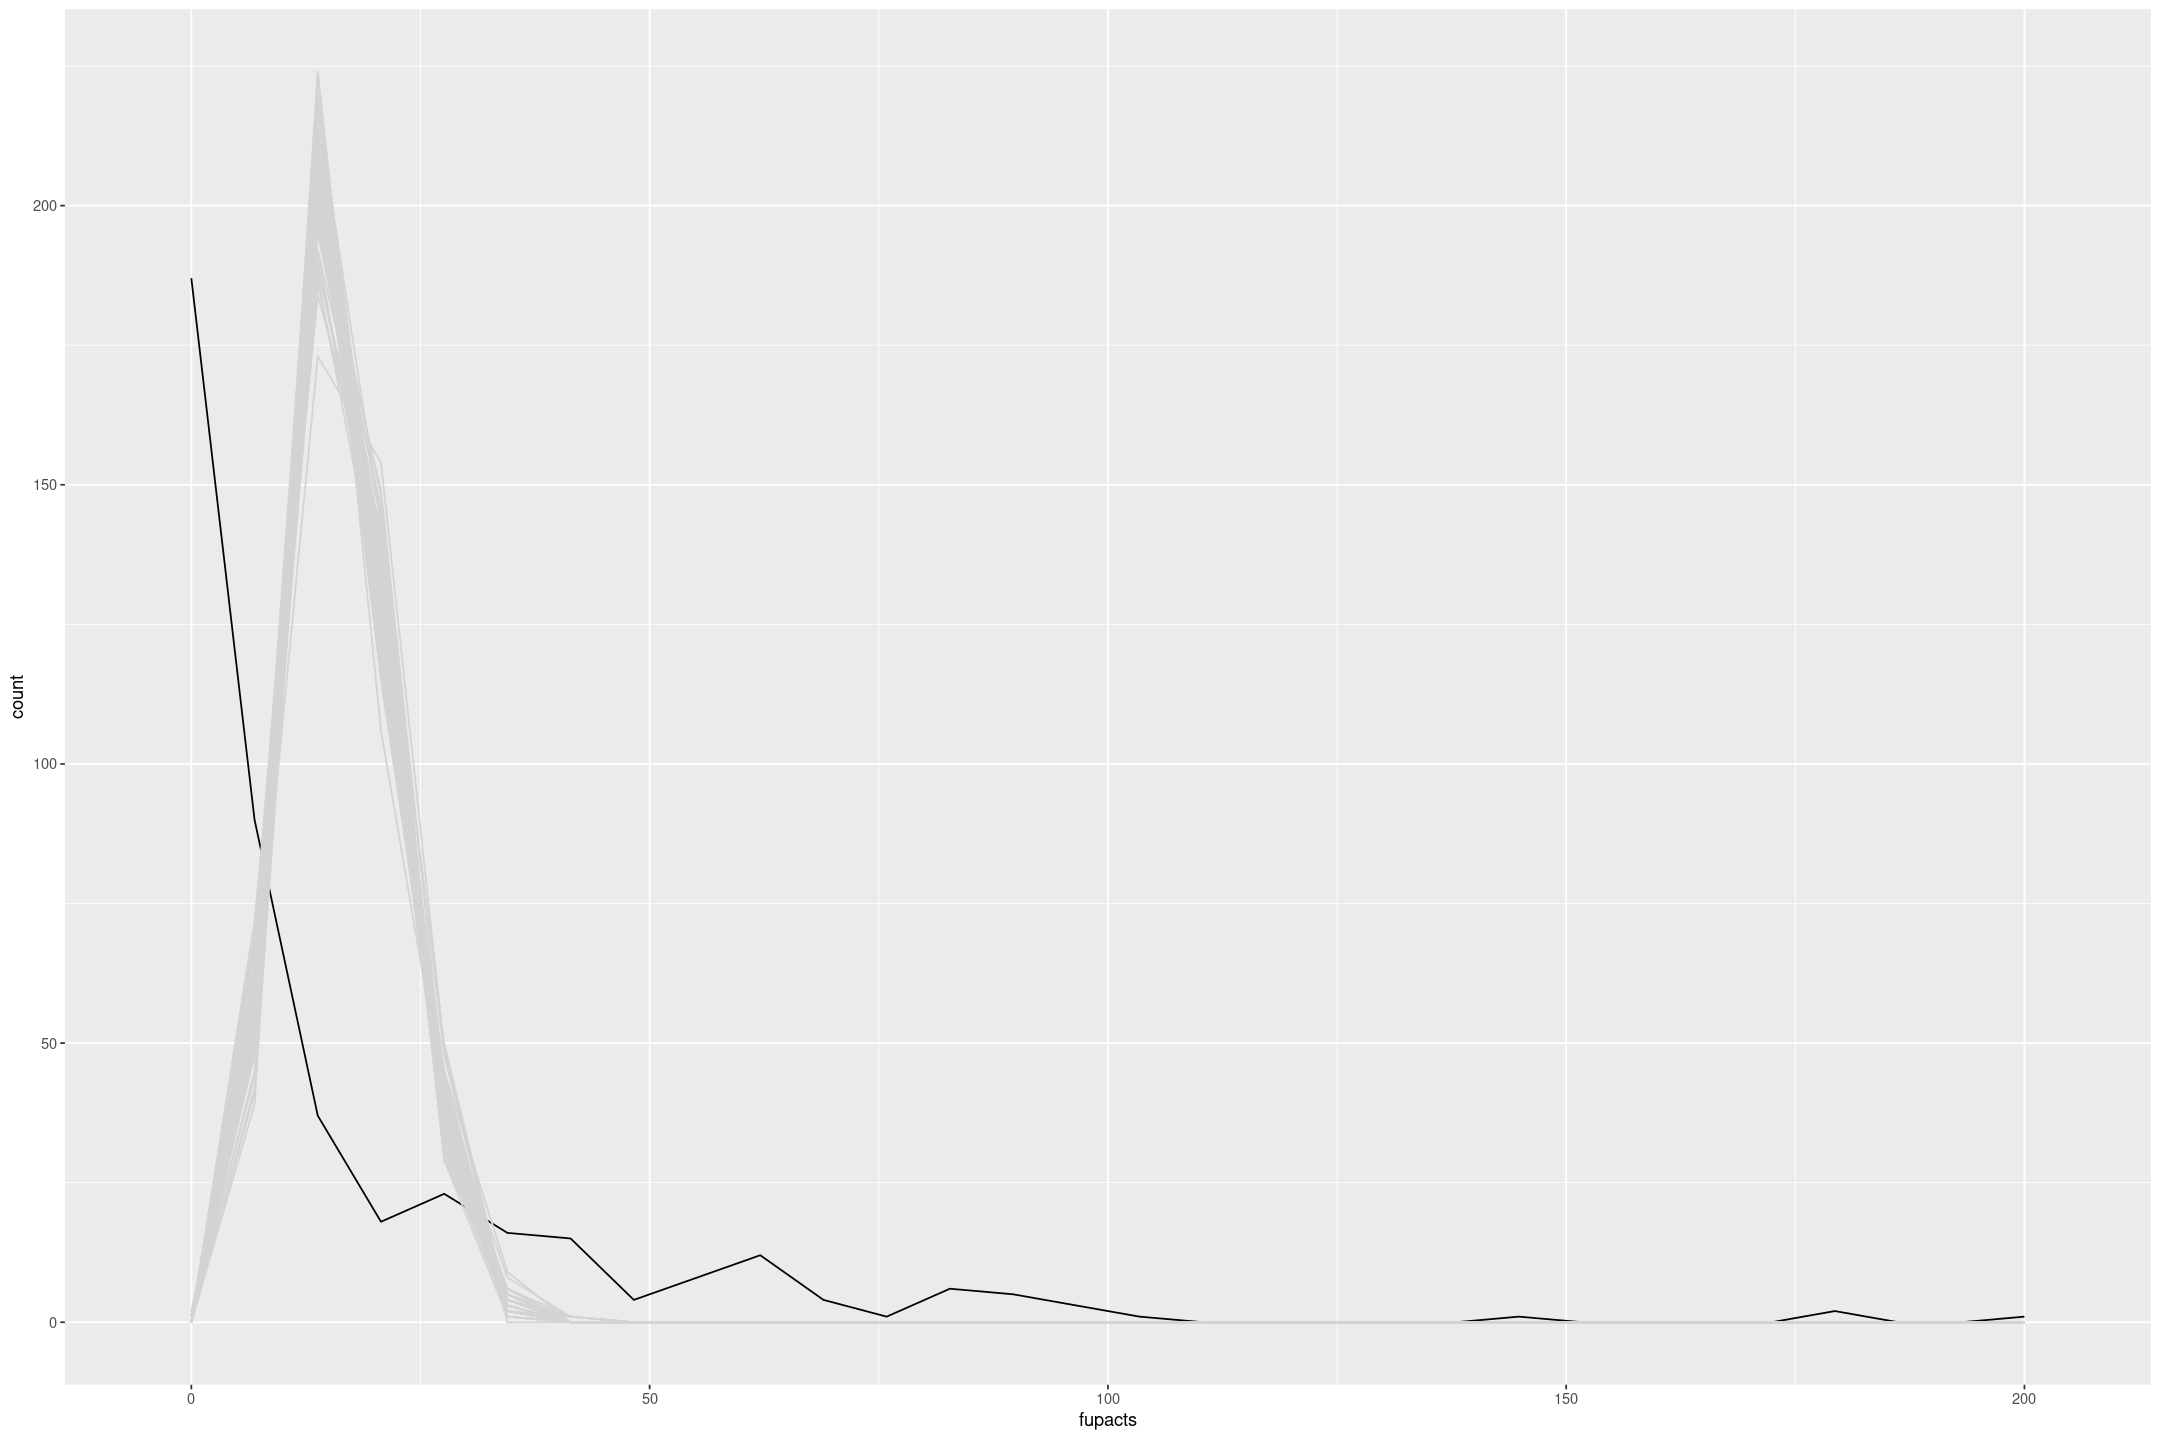

In [23]:
risky %>%
gf_freqpoly(~fupacts, bins=30) %>%
gf_freqpoly(group=~simulation, data=pred50, colour="lightgrey", bins=30)

## Adding pre-treatment measures

Next extend the model to include pre-treatement measures of the outcome and the additional pre-treatment variables in the dataset.
Does the model fit well?
Is there evidence of overdispersion?

To make the model more interpretable let's standardise bupacts

In [24]:
mean(risky$bupacts)

[1] 25.91014

In [25]:
sd(risky$bupacts)

[1] 31.91796

In [26]:
risky <- risky %>%
mutate(bupacts_std = (bupacts - mean(bupacts)) / (2 * sd(bupacts)))

In [27]:
fit_risky_pre <- stan_glm(acts  ~ couples + women_alone + bupacts_std + bs_hiv , family=poisson(link="log"), data=risky)

The sign of the coefficients make intuitive sense; having HIV positive status decreases the chance of unprotected sex acts, and the more prior unprotected acts the more the follows.

After adjusting for these the intervention looks *slightly* more effective.

In [28]:
print(fit_risky_pre, digits=2)

stan_glm
 family:       poisson [log]
 formula:      acts ~ couples + women_alone + bupacts_std + bs_hiv
 observations: 434
 predictors:   5
------
               Median MAD_SD
(Intercept)     3.12   0.02 
couples        -0.41   0.03 
women_alone    -0.65   0.03 
bupacts_std     0.69   0.01 
bs_hivpositive -0.43   0.04 

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


#### Using binned residuals

Plotting the residuals binned by prediction shows it's very overdispersed.

The dashed lines are $\pm 2 \sqrt{\rm pred}$ which, if Poisson, should catch 95% of the points.

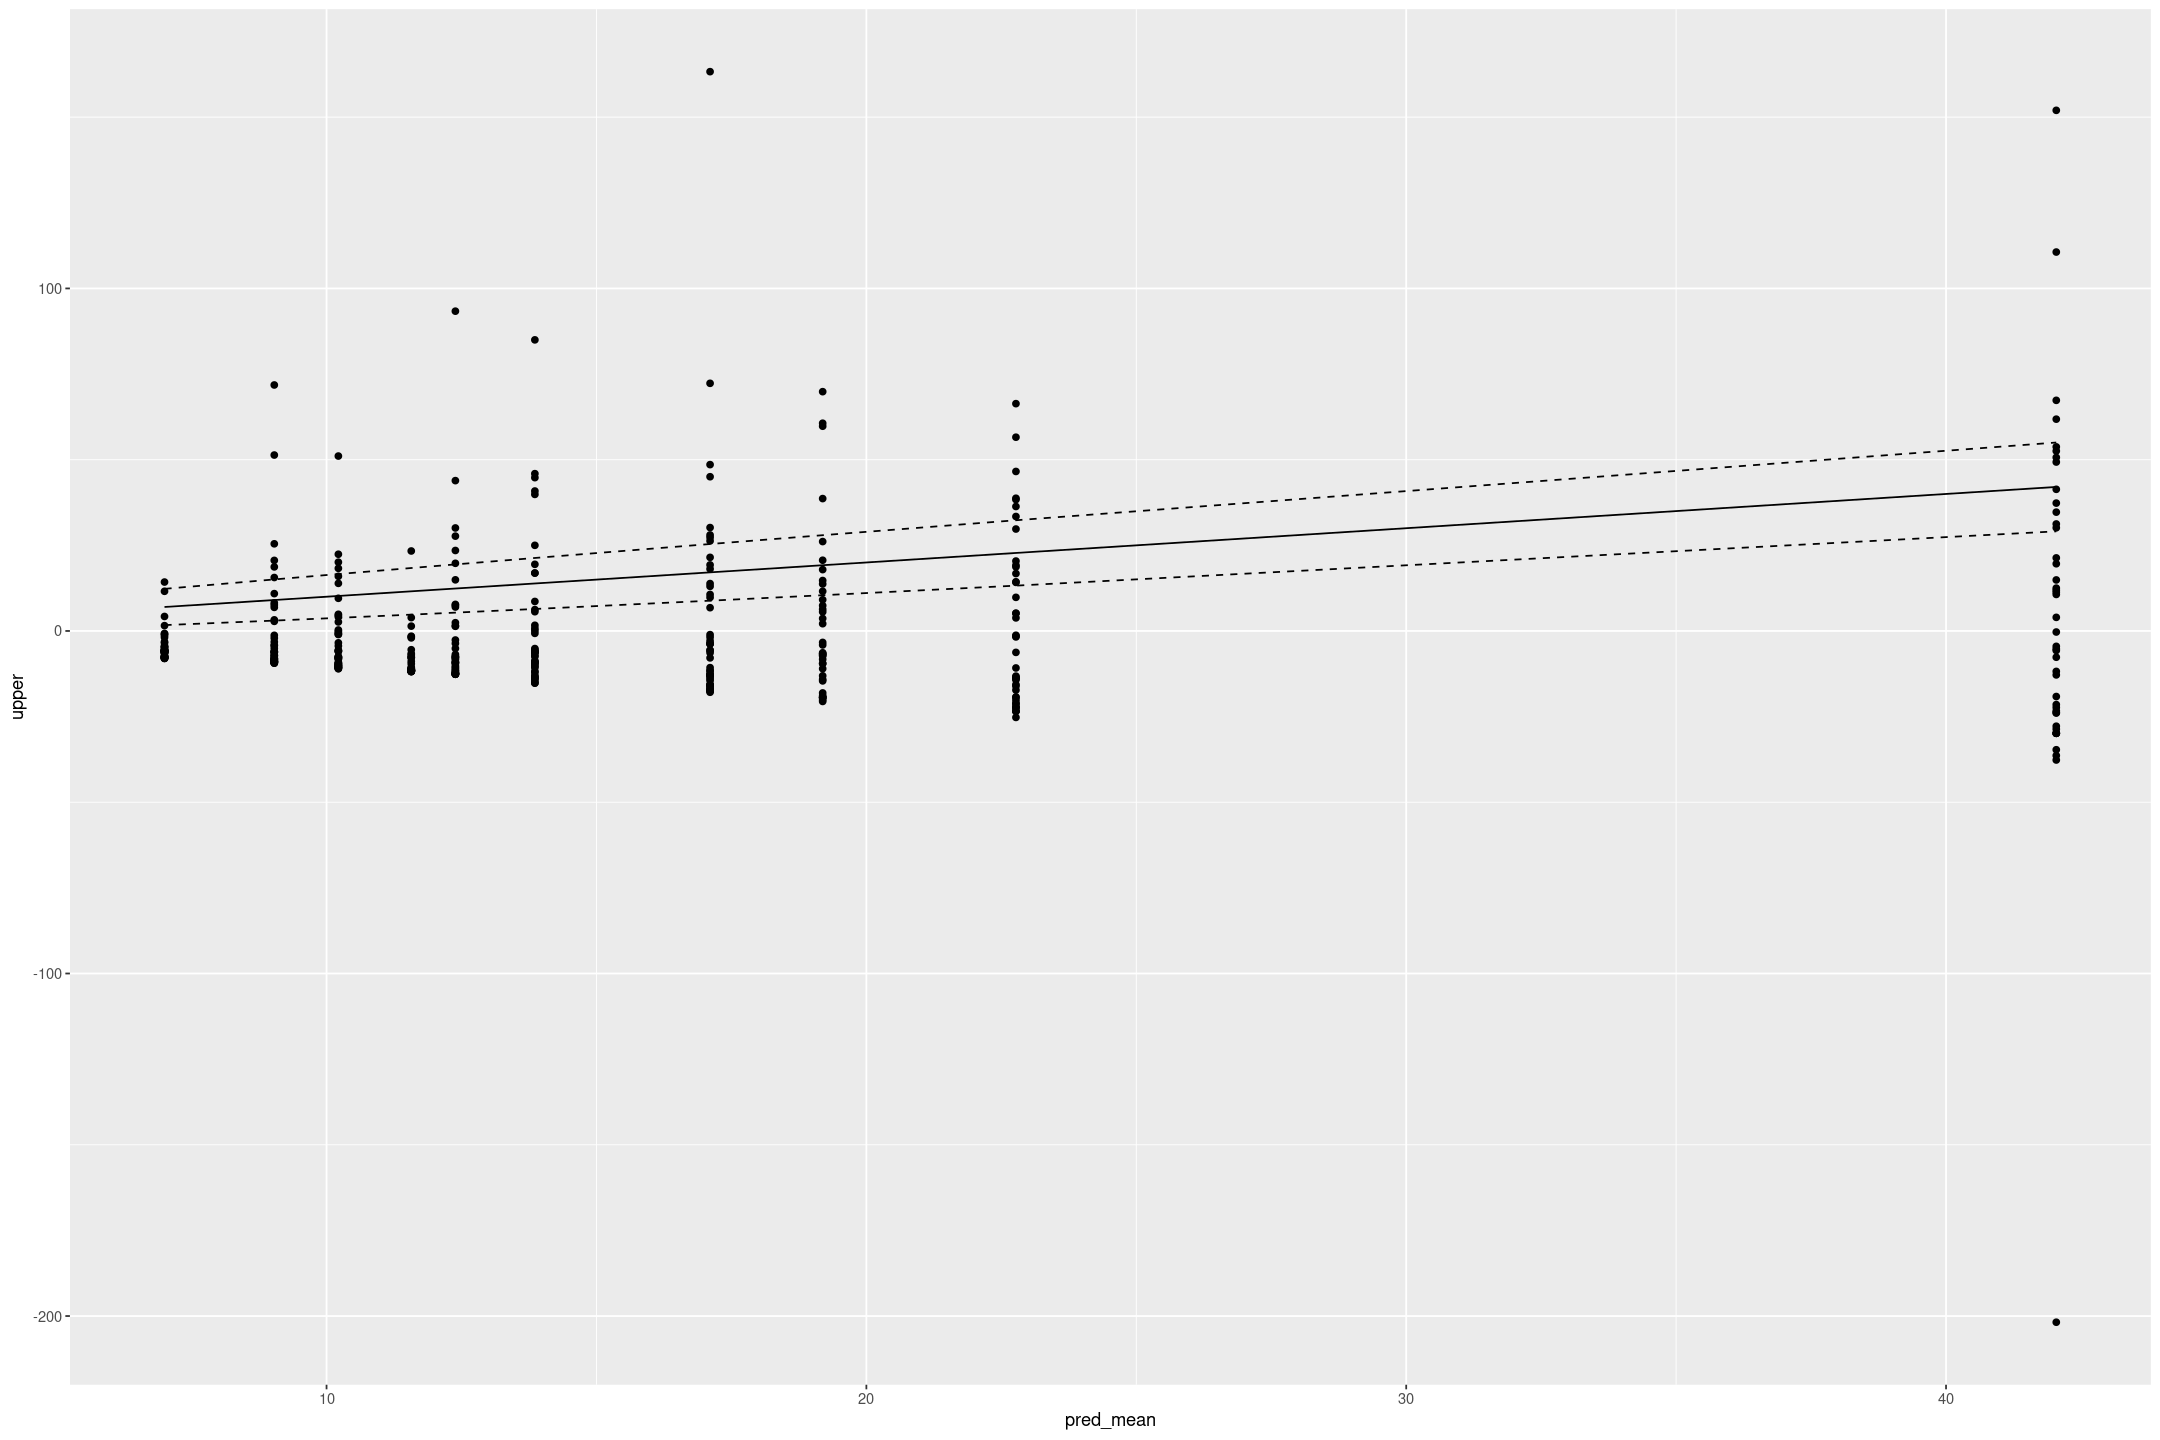

In [29]:
risky %>%
mutate(pred=predict(fit_risky_pre, type="response"),
       resid = fupacts - pred) %>%
group_by(bin = cut_quantile(pred, 10)) %>%
mutate(pred_mean=mean(pred), dispersion = sqrt(mean(resid^2)),
       upper=pred_mean + 2*sqrt(pred_mean), lower=pred_mean - 2*sqrt(pred_mean)) %>%
gf_line(upper ~ pred_mean, linetype="dashed") %>%
gf_line(lower ~ pred_mean, linetype="dashed") %>%
gf_line(pred_mean ~ pred_mean) %>%
gf_point(resid ~ pred_mean)

Or looking at the overdispersion in each bin it is large and grows with predictions.

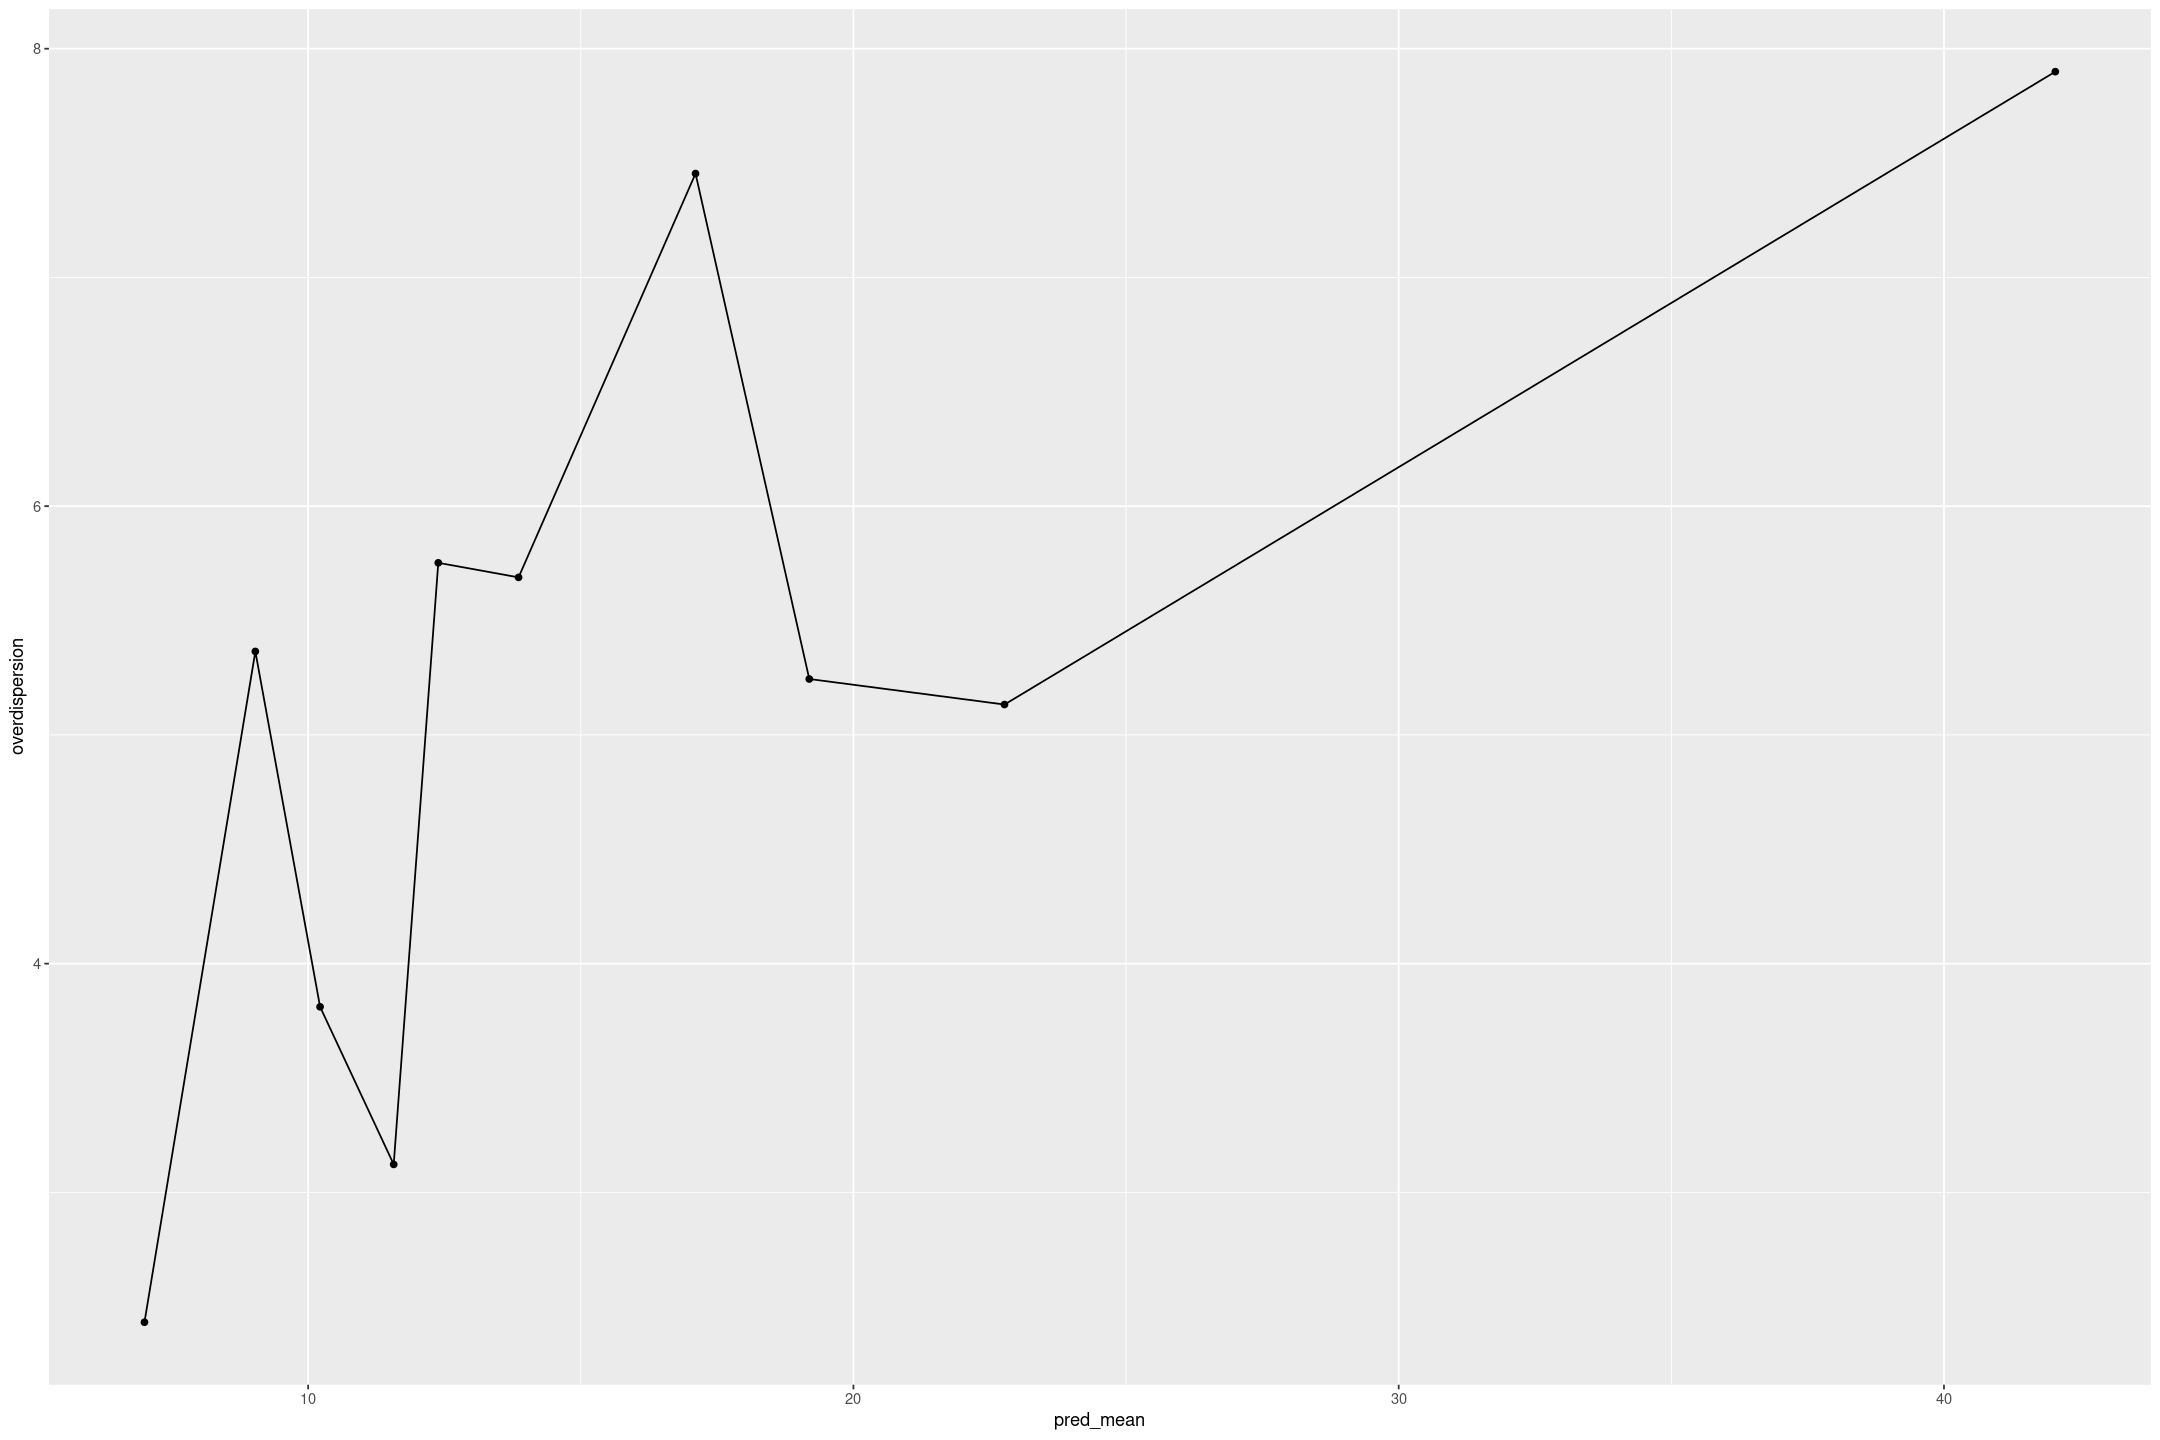

In [30]:
risky %>%
mutate(pred=predict(fit_risky_pre, type="response"),
       resid = fupacts - pred) %>%
group_by(bin = cut_quantile(pred, 10)) %>%
summarise(pred_mean=mean(pred), dispersion = sqrt(mean(resid^2)),
          overdispersion = dispersion / sqrt(pred_mean)) %>%
gf_line(overdispersion ~ pred_mean) %>%
gf_point()

Or we can calculate a typical overdispersion estimate, and again see it's much larget than 1

In [31]:
risky %>%
mutate(pred=predict(fit_risky_pre, type="response"),
       resid = fupacts - pred) %>%
summarise(overdispersion=sqrt(mean(resid^2/pred)))

overdispersion
1 5.443646

### Using a posterior predictive check

Again we see a similar lack of fit with the posterior distribution.

In [32]:
pred50_pre <- posterior_predict(fit_risky_pre)[1:50,] %>%
t() %>%
as.data.frame() %>%
pivot_longer(everything(), values_to="fupacts", names_to="simulation")

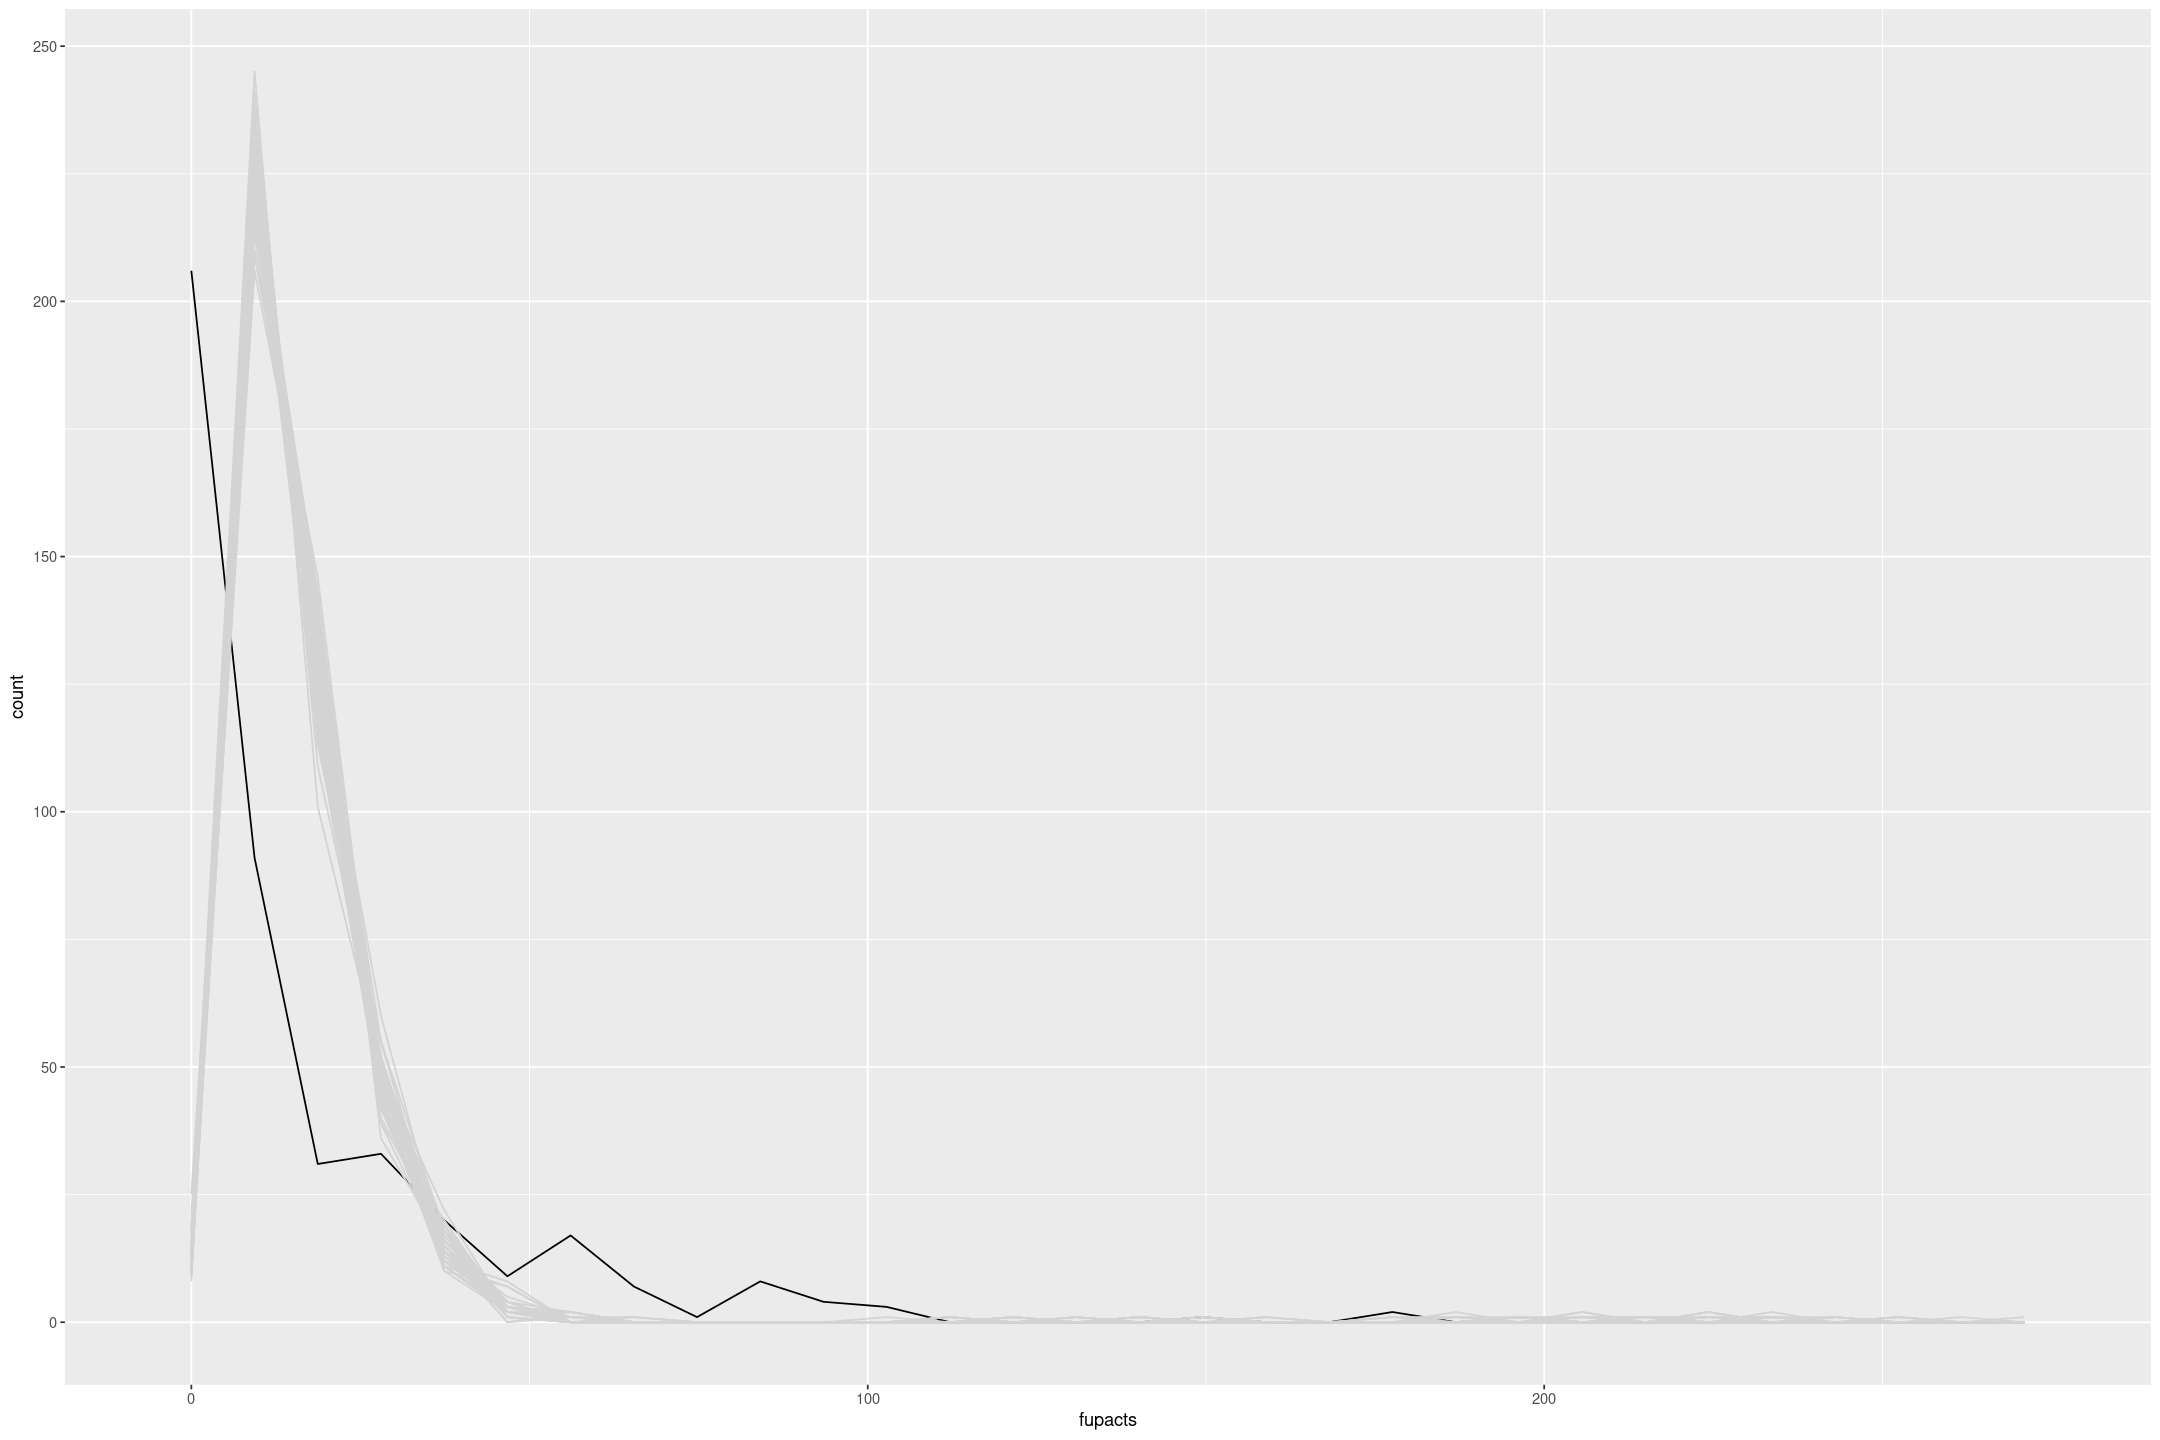

In [33]:
risky %>%
gf_freqpoly(~fupacts, bins=30) %>%
gf_freqpoly(group=~simulation, data=pred50_pre, colour="lightgrey", bins=30)

## Negative Binomial Regression

Fit a negative binomial (overdispersed Poisson) model.
What do you conclude regarding the effectiveness of the intervention?

### Without predictors

In [34]:
fit_risky_p_nbinom <- stan_glm(acts  ~ couples + women_alone , family=neg_binomial_2, data=risky)

The estimates are the same, but the standard deviations are *very* different, showing that the Poisson model was overconfident.

This actually gives us a different amount of confidence in these coefficients, so the model fit is important here.

In [35]:
print(fit_risky_p_nbinom, digits=2)

stan_glm
 family:       neg_binomial_2 [log]
 formula:      acts ~ couples + women_alone
 observations: 434
 predictors:   3
------
            Median MAD_SD
(Intercept)  3.10   0.15 
couples     -0.33   0.20 
women_alone -0.57   0.22 

Auxiliary parameter(s):
                      Median MAD_SD
reciprocal_dispersion 0.34   0.02  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


Gives a similar result to `glm.nb`

In [36]:
MASS::glm.nb(acts  ~ couples + women_alone , data=risky)


Call:  MASS::glm.nb(formula = acts ~ couples + women_alone, data = risky, 
    init.theta = 0.3411983042, link = log)

Coefficients:
(Intercept)      couples  women_alone  
     3.0896      -0.3224      -0.5721  

Degrees of Freedom: 433 Total (i.e. Null);  431 Residual
Null Deviance:	    494.2 
Residual Deviance: 486.7 	AIC: 3041

Visually the posterior distribution is *much* closr to the actual data.

In [37]:
pred50_nbinom <- posterior_predict(fit_risky_p_nbinom)[1:50,] %>%
t() %>%
as.data.frame() %>%
pivot_longer(everything(), values_to="fupacts", names_to="simulation")

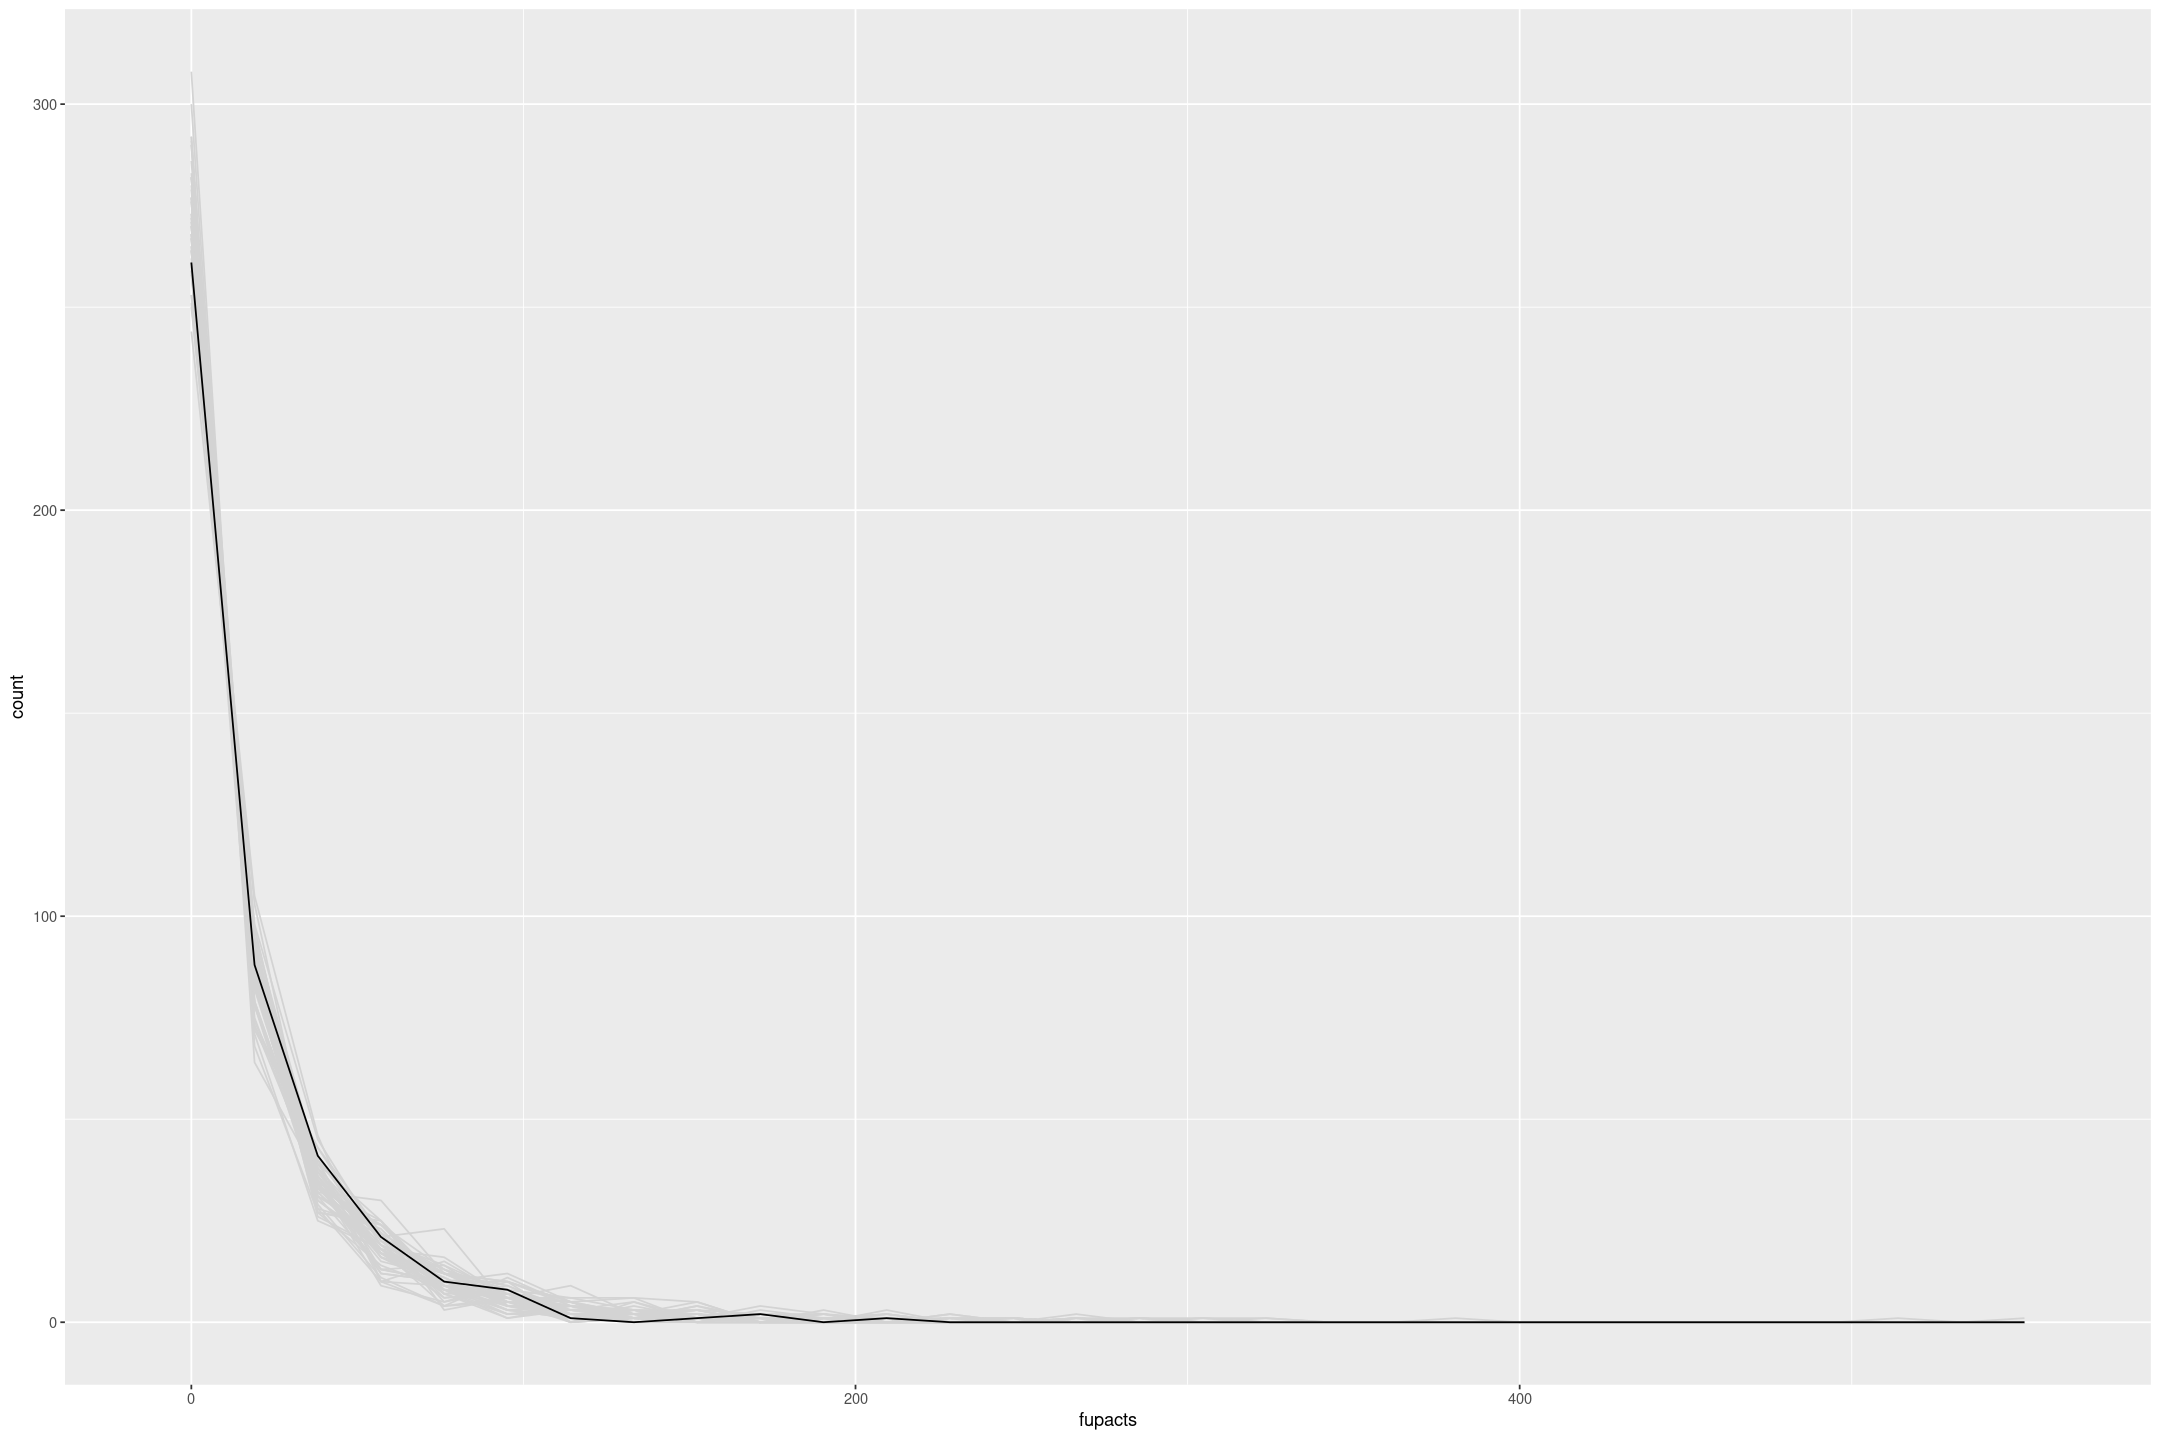

In [38]:
gf_freqpoly(~fupacts, group=~simulation, data=pred50_nbinom, colour="lightgrey", bins=30) %>%
gf_freqpoly(~fupacts, group=FALSE, data=risky, bins=30)

### Adding other pre-treatment measures.

In [39]:
fit_risky_pre_nbinom <- stan_glm(acts  ~ couples + women_alone + bupacts_std + bs_hiv , family=neg_binomial_2, data=risky)

This model gives different predictions to the Poisson, due to the continuous variable, as well as larger uncertainties inthe coefficients.

It also has lower uncertainties in the experimental condition after adding the pre-treatment measues.

In [40]:
print(fit_risky_pre_nbinom, digits=2)

stan_glm
 family:       neg_binomial_2 [log]
 formula:      acts ~ couples + women_alone + bupacts_std + bs_hiv
 observations: 434
 predictors:   5
------
               Median MAD_SD
(Intercept)     3.04   0.15 
couples        -0.35   0.20 
women_alone    -0.72   0.20 
bupacts_std     1.43   0.21 
bs_hivpositive -0.54   0.19 

Auxiliary parameter(s):
                      Median MAD_SD
reciprocal_dispersion 0.41   0.03  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


In [41]:
pred50_pre_nbinom <- posterior_predict(fit_risky_pre_nbinom, draws=50) %>%
t() %>%
as.data.frame() %>%
pivot_longer(everything(), values_to="fupacts", names_to="simulation")

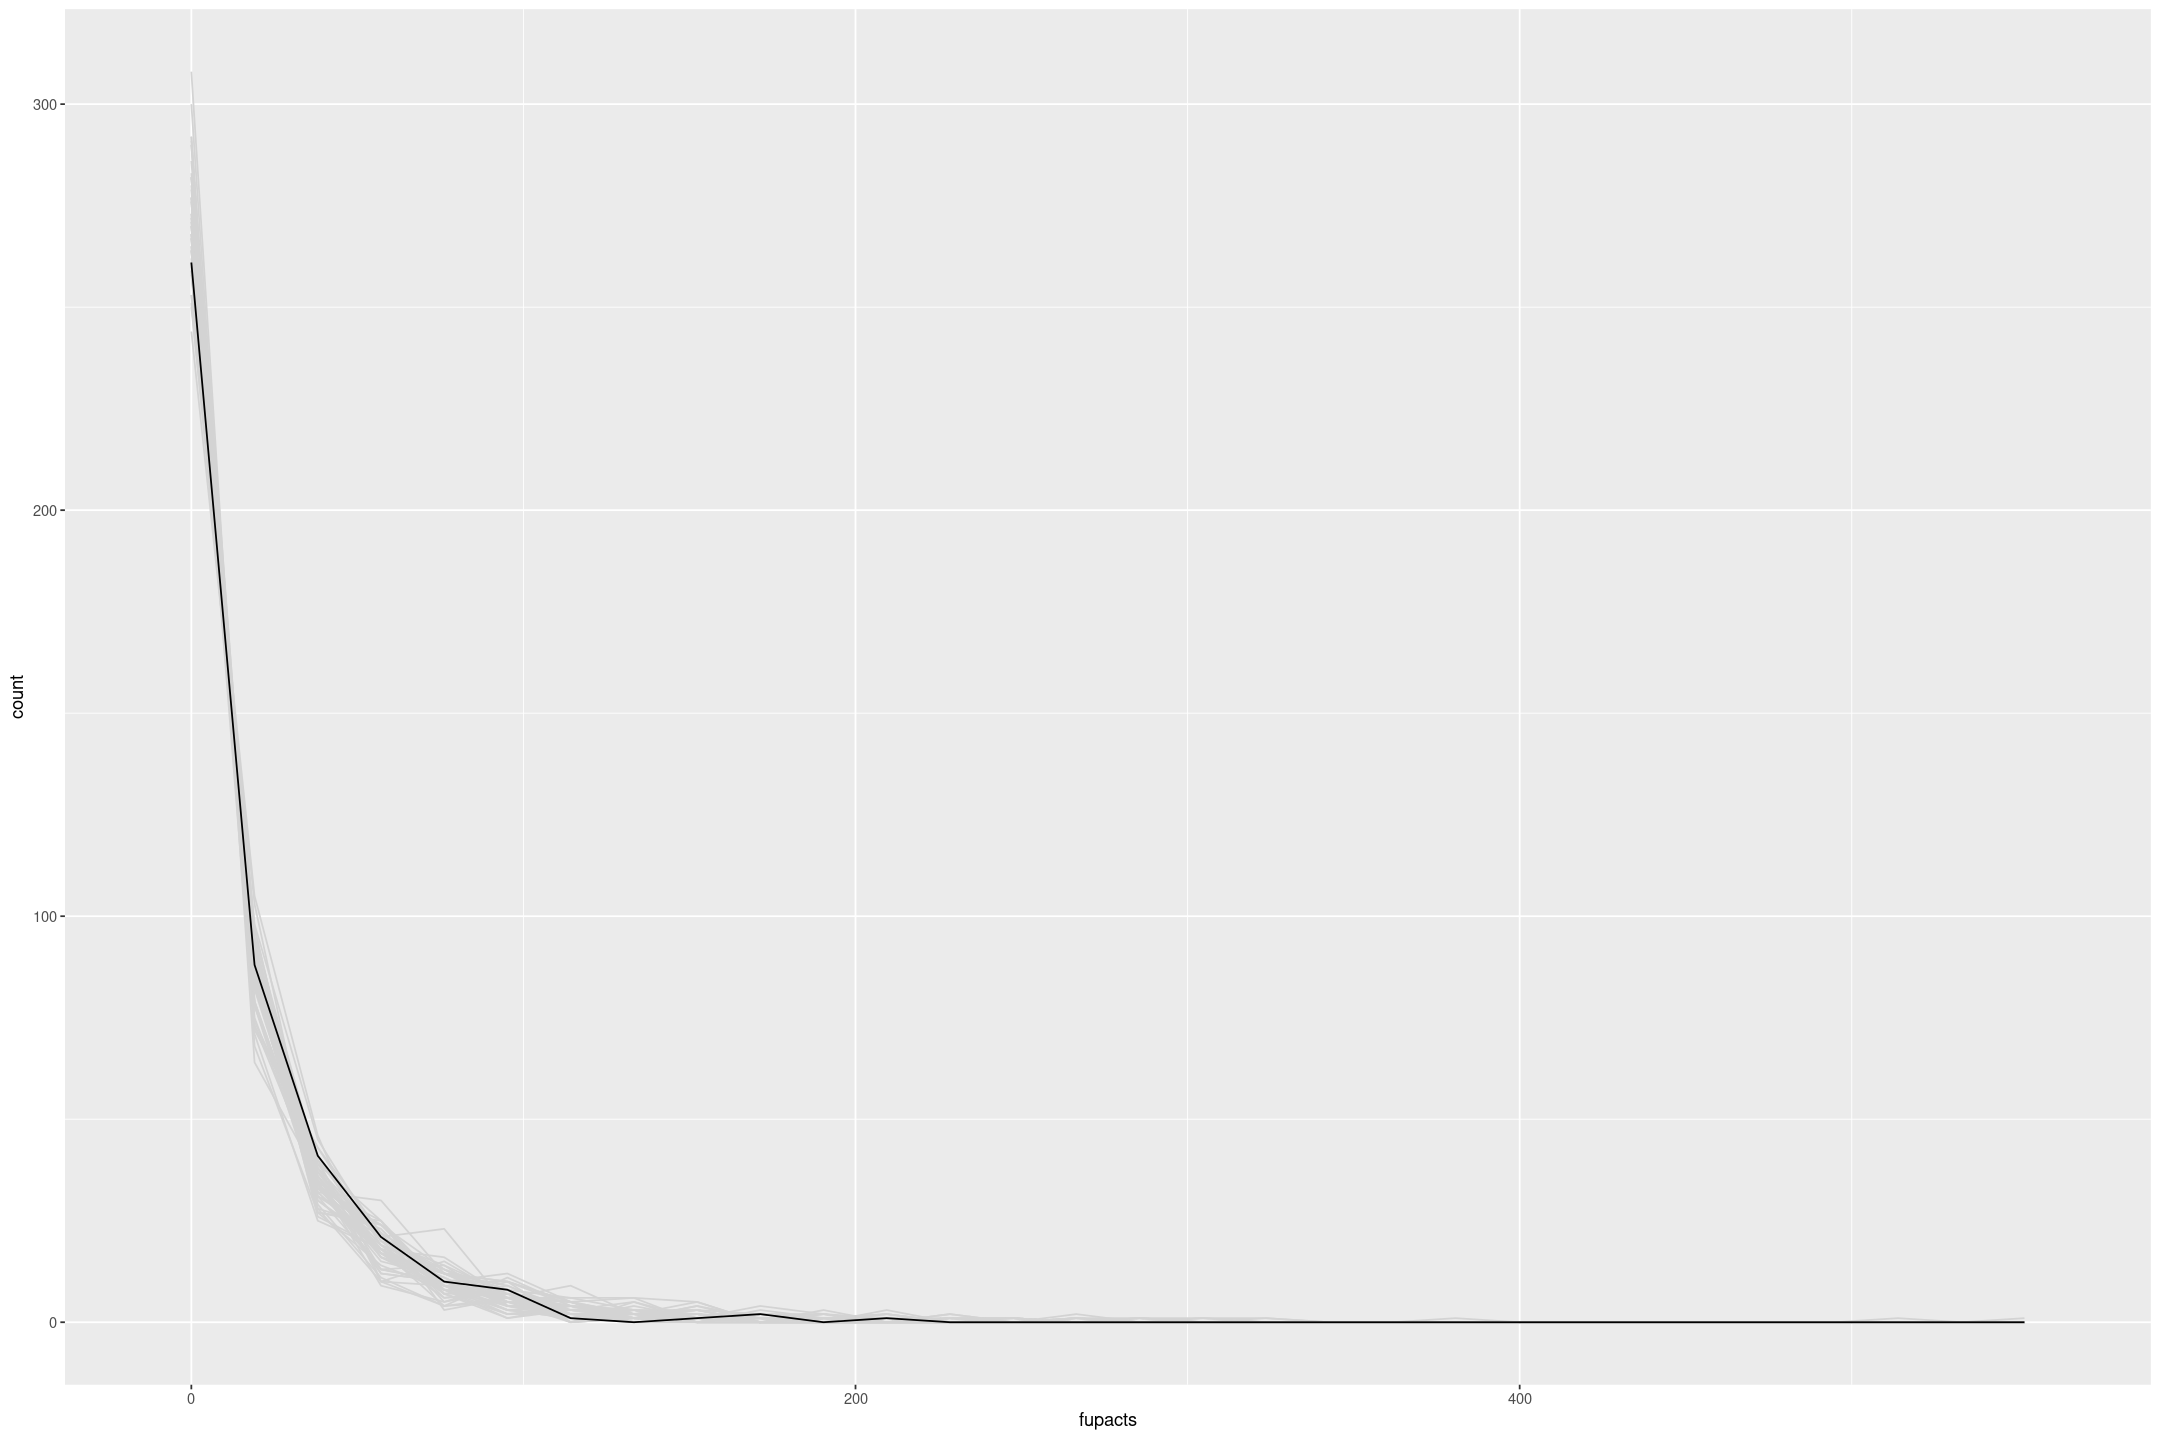

In [42]:
gf_freqpoly(~fupacts, group=~simulation, data=pred50_nbinom, colour="lightgrey", bins=30) %>%
gf_freqpoly(~fupacts, group=FALSE, data=risky, bins=30)

On a log-linear scale it's clear that we're overpredicting small values and large values.

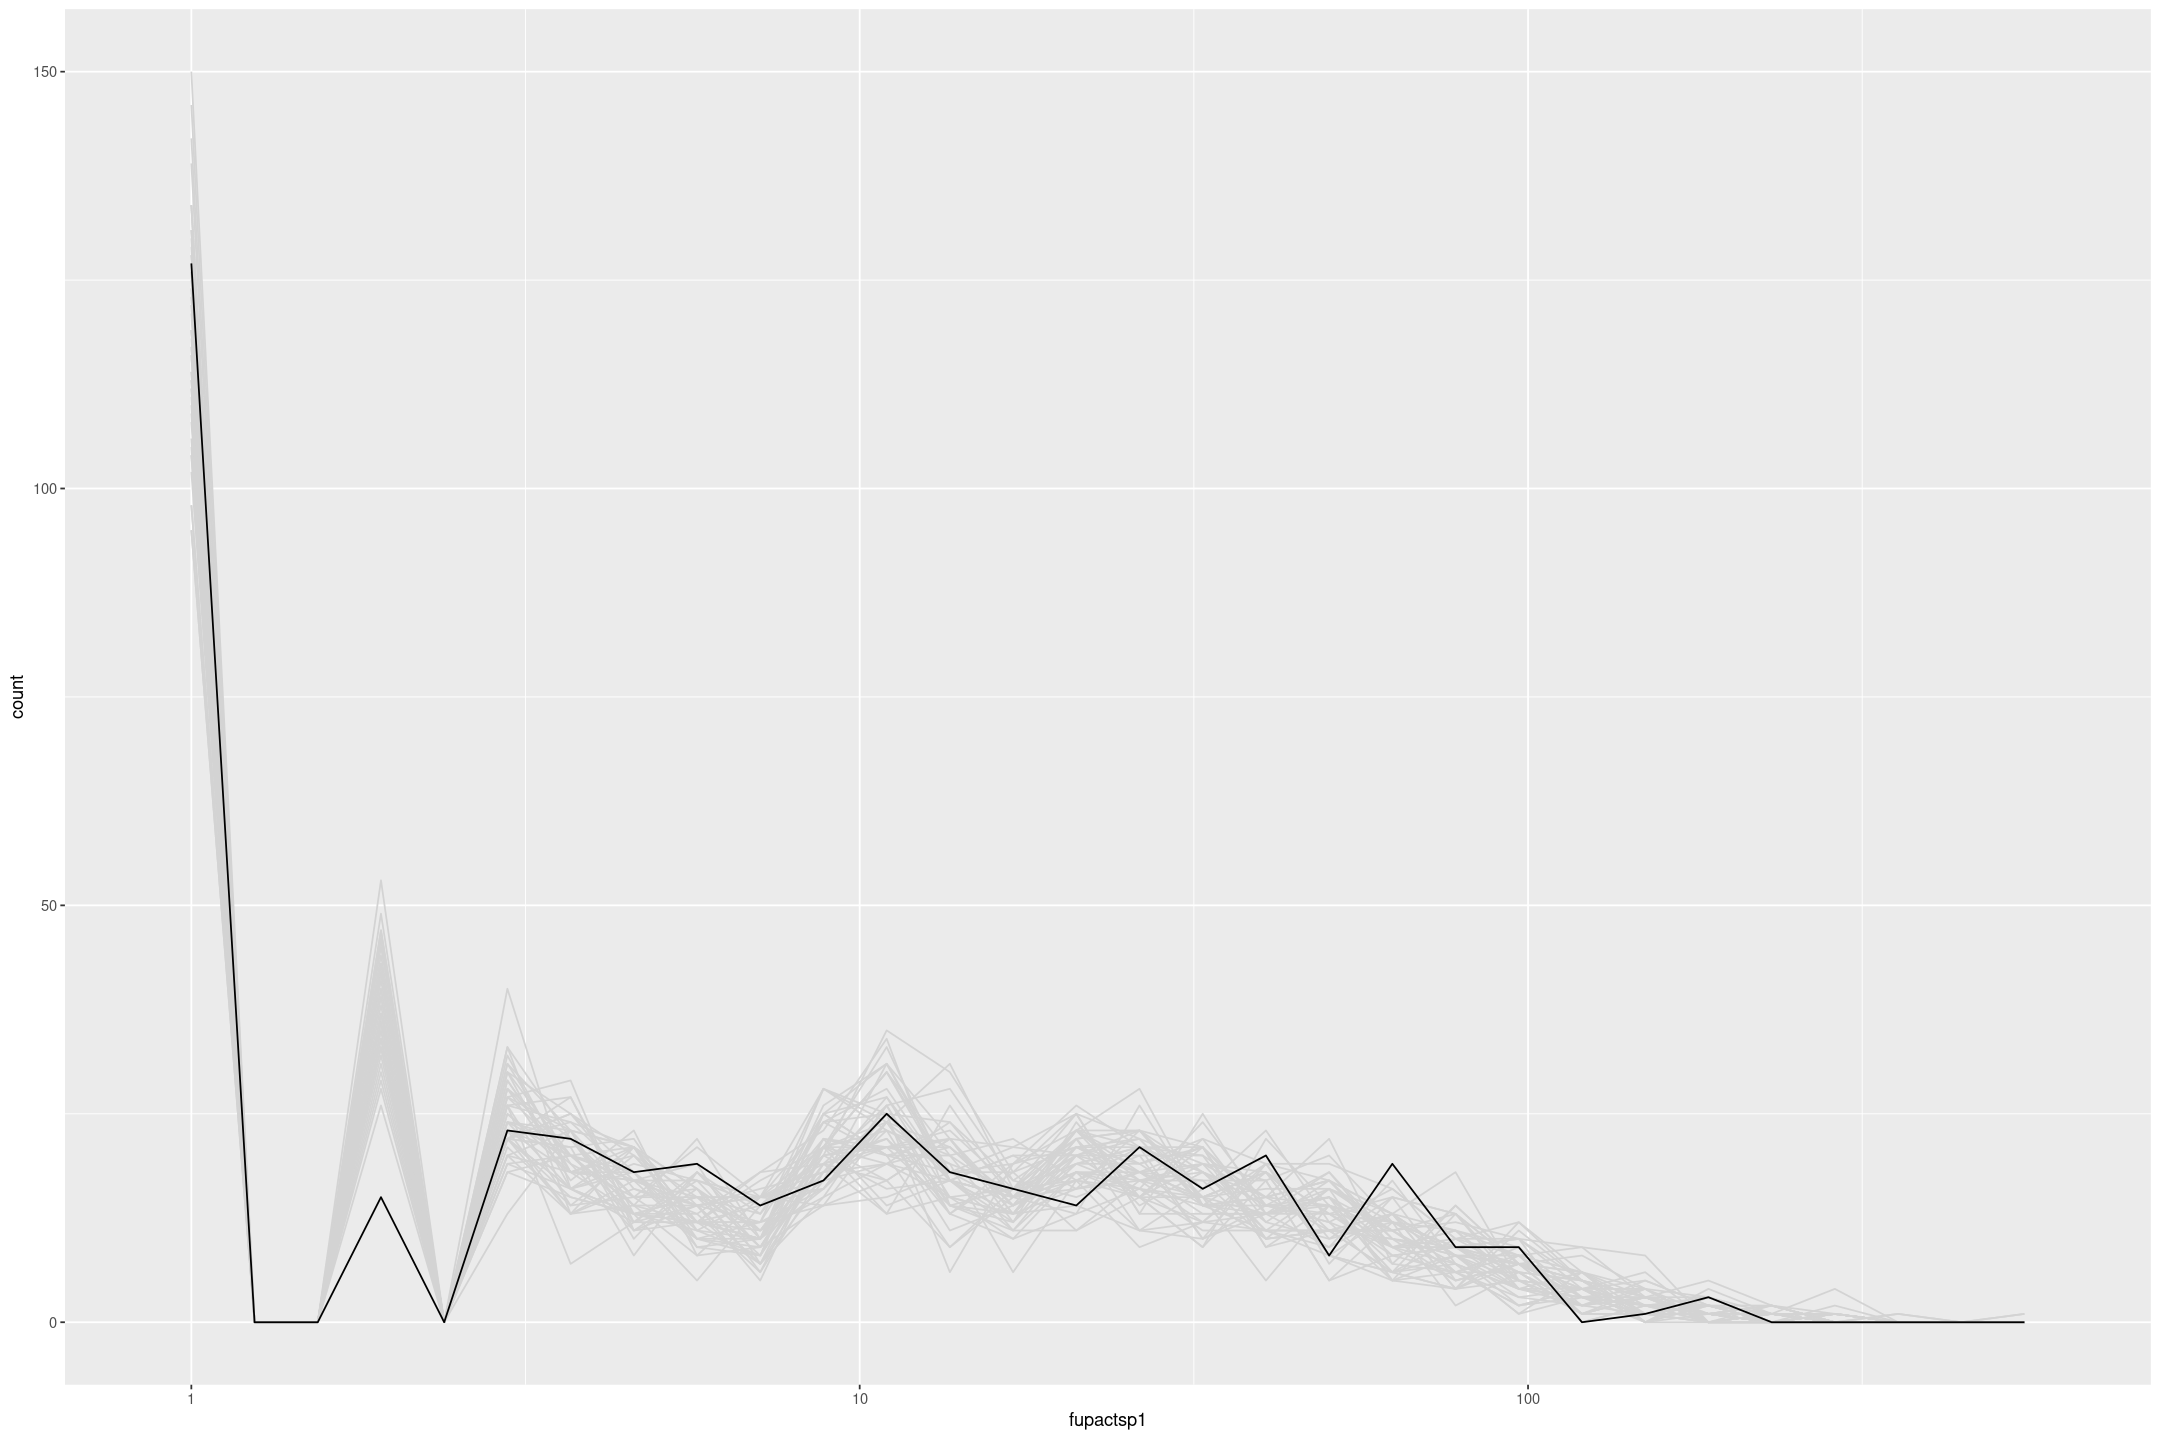

In [43]:
gf_freqpoly(~fupactsp1, group=~simulation, data=pred50_nbinom %>% mutate(fupactsp1 = fupacts+1), colour="lightgrey", bins=30) %>%
gf_freqpoly(~fupactsp1, group=FALSE, data=risky %>% mutate(fupactsp1 = fupacts+1), bins=30) +
scale_x_log10()

Sometimes it predicts a *very* large number of acts

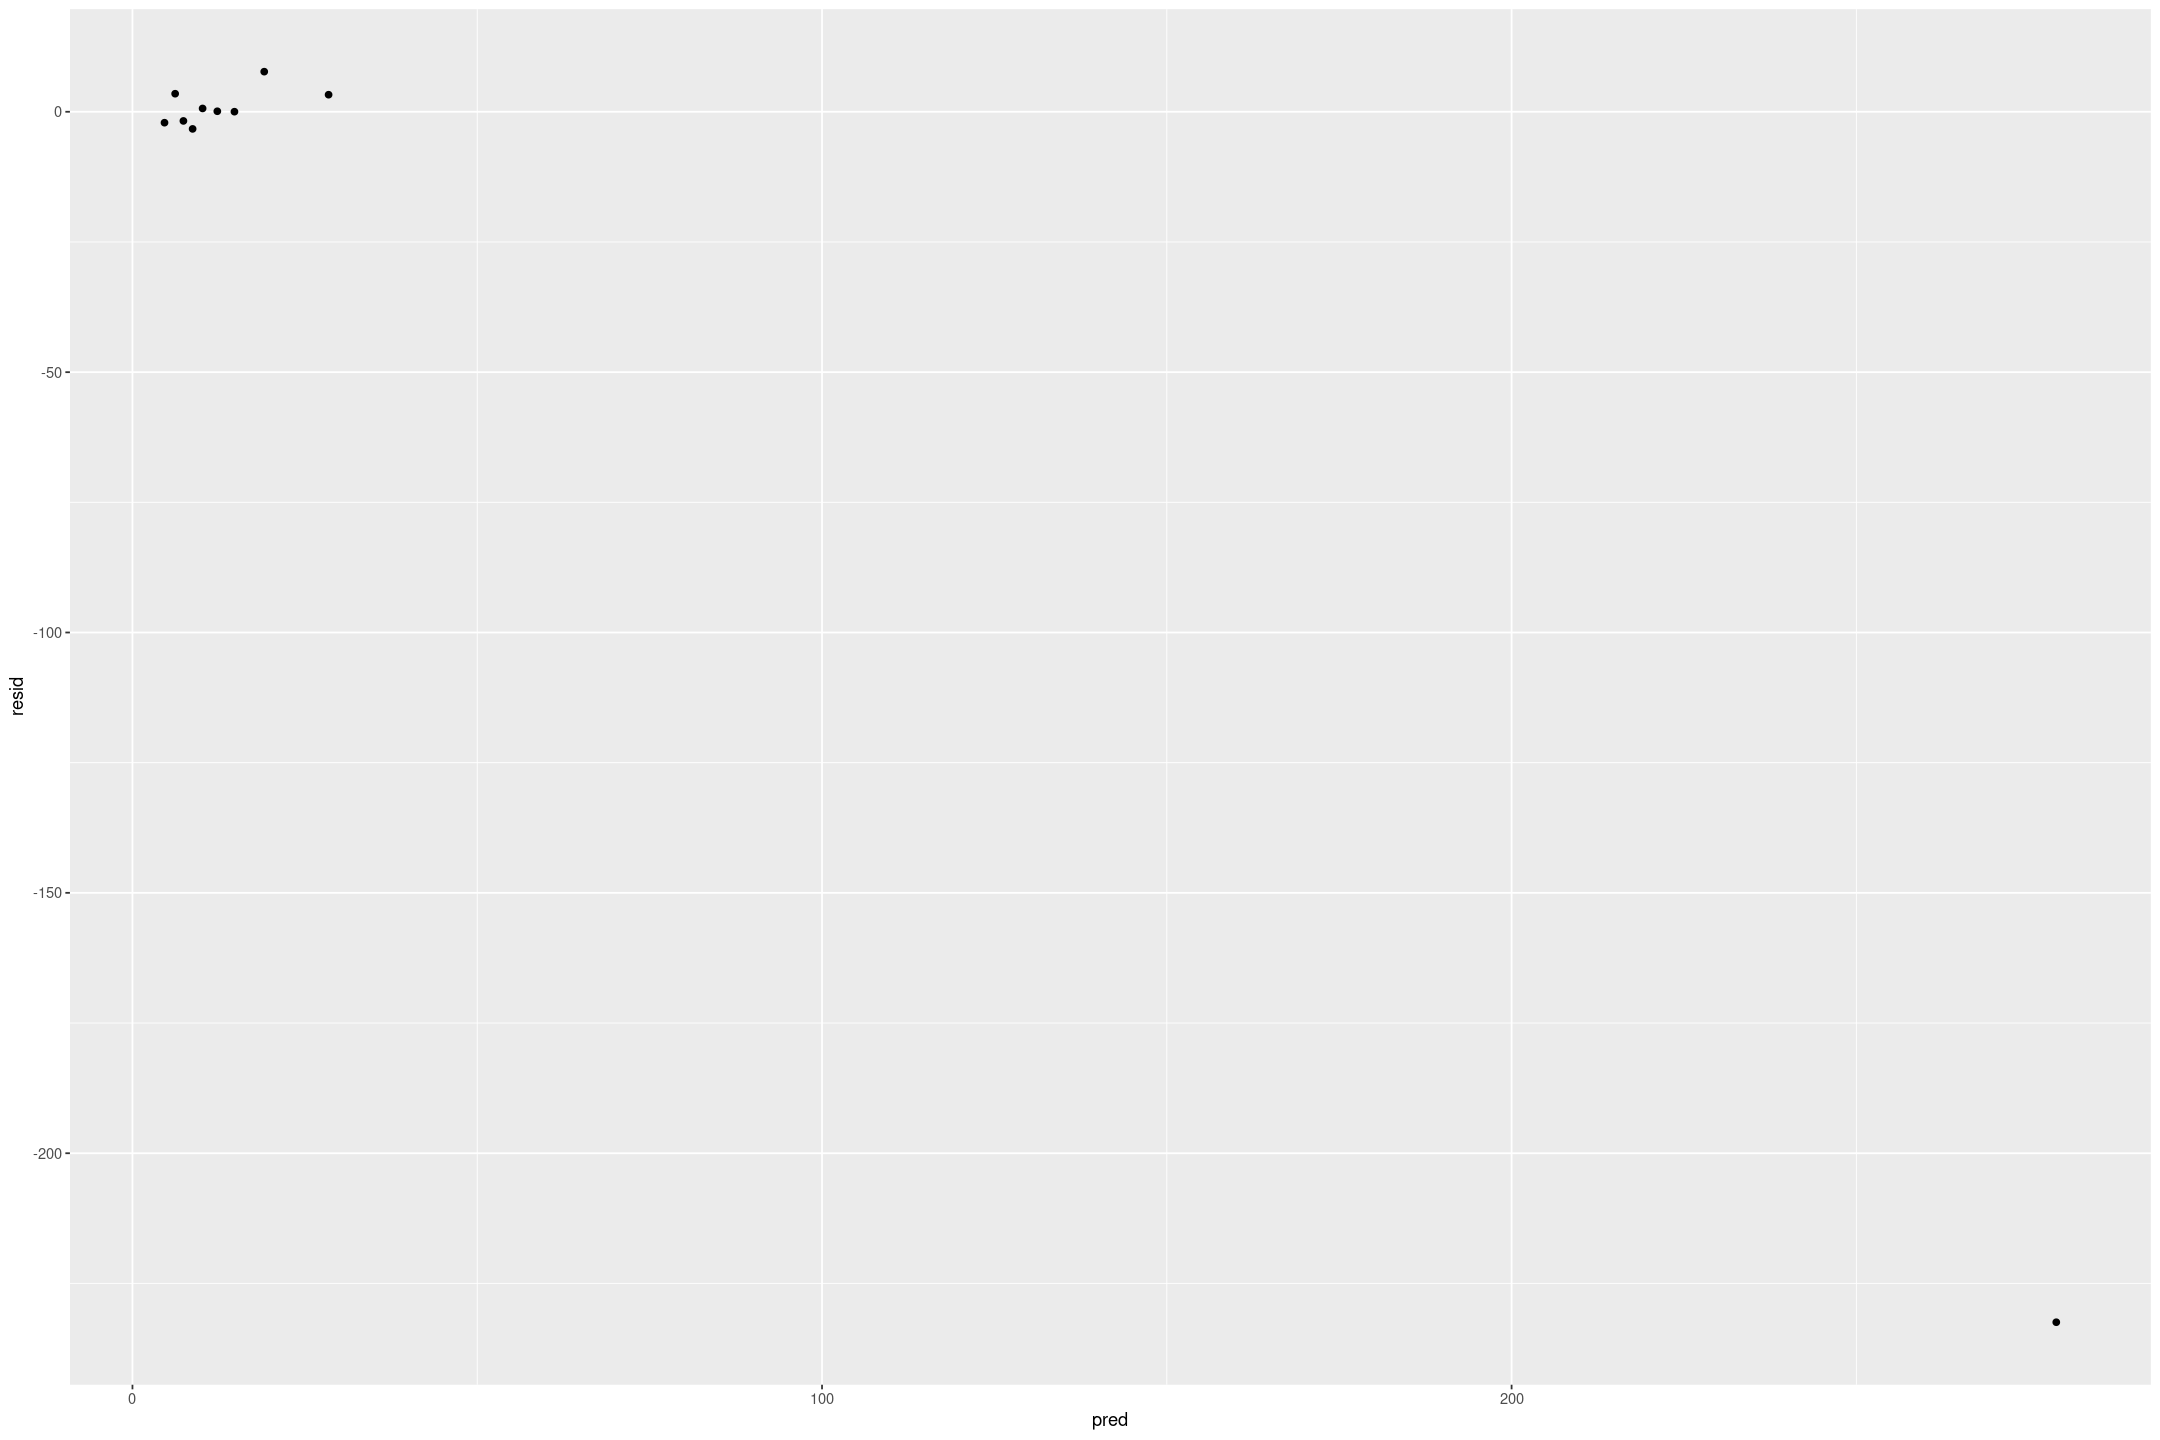

In [44]:
risky %>%
mutate(pred=predict(fit_risky_pre_nbinom, type="response"),
       resid = fupacts - pred) %>%
group_by(bin = cut_quantile(pred, 10)) %>%
summarise(pred=mean(pred), resid=mean(resid)) %>%
gf_point(resid ~ pred)

For a large number of bupacts the predictions for fupacts are *very* high - in the thousands.

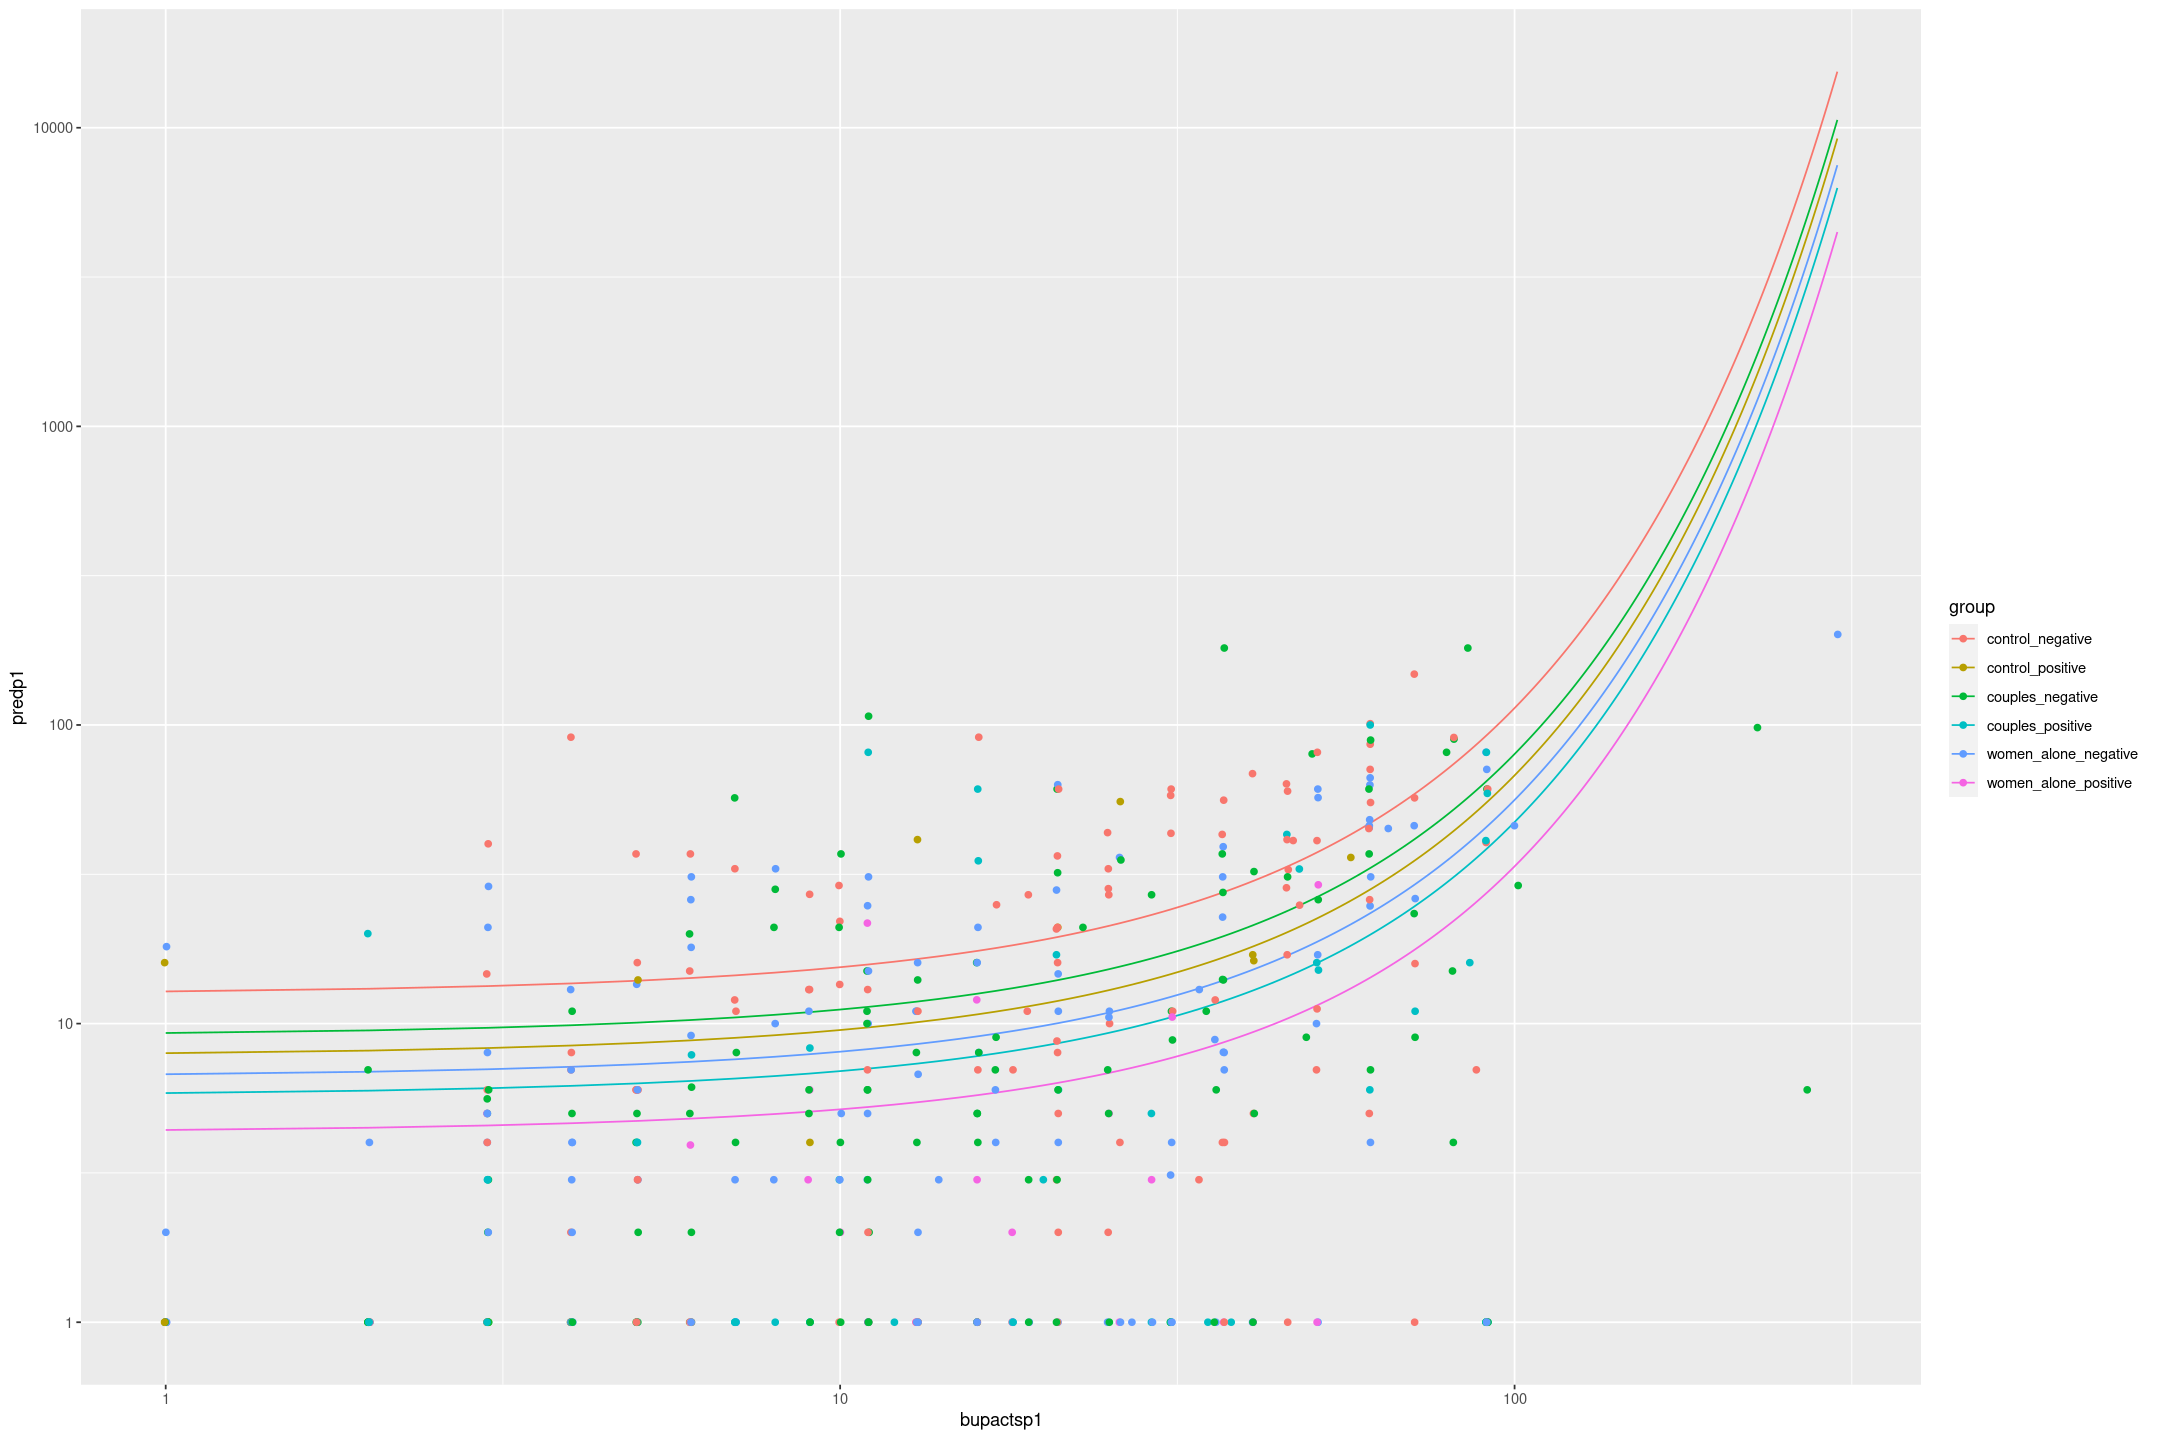

In [45]:
crossing(bupacts=seq(0, 300), condition=c('control', 'women_alone', 'couples'), bs_hiv=c('positive', 'negative')) %>%
mutate(women_alone = if_else(condition == 'women_alone', 1,0),
      couples = if_else(condition == 'couples', 1,0),
      bupacts_std = (bupacts - mean(risky$bupacts)) / (2 * sd(risky$bupacts)),
      group=glue('{condition}_{bs_hiv}'),
      bupactsp1 = bupacts + 1) %>%
mutate(predp1 = predict(fit_risky_pre_nbinom, type="response", newdata=.) + 1) %>%
gf_line(predp1 ~ bupactsp1, col=~group) %>%
gf_jitter(fupactsp1 ~ bupactsp1, data=risky %>% mutate(condition=if_else(women_alone == 1, "women_alone", if_else(couples==1, "couples", "control")),
                               group=glue('{condition}_{bs_hiv}'),
                                                  fupactsp1 = fupacts + 1,
                                                    bupactsp1 = bupacts + 1)) +
scale_x_log10() +
scale_y_log10()

### Log transform of bupacts

I wonder if taking a log transform would produce better results?

In [46]:
fit_risky_pre_nbinom_log <- stan_glm(acts  ~ couples + women_alone + log(bupacts+1) + bs_hiv , family=neg_binomial_2, data=risky)

In [47]:
fit_risky_pre_nbinom_log

stan_glm
 family:       neg_binomial_2 [log]
 formula:      acts ~ couples + women_alone + log(bupacts + 1) + bs_hiv
 observations: 434
 predictors:   5
------
                 Median MAD_SD
(Intercept)       1.3    0.2  
couples          -0.4    0.2  
women_alone      -0.6    0.2  
log(bupacts + 1)  0.6    0.1  
bs_hivpositive   -0.5    0.2  

Auxiliary parameter(s):
                      Median MAD_SD
reciprocal_dispersion 0.4    0.0   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

#### LOO Cross Validation

Cross validation looks a little better with the log-transform.

In [48]:
loo_risky_pre_nbinom_log <- loo(fit_risky_pre_nbinom_log)
loo_risky_pre_nbinom <- loo(fit_risky_pre_nbinom)

In [49]:
loo_compare(loo_risky_pre_nbinom_log, loo_risky_pre_nbinom)

elpd_diff se_diff  elpd_loo  se_elpd_loo p_loo   
fit_risky_pre_nbinom_log  0.00000  0.000000 -1476.273 37.23122    6.655533
fit_risky_pre_nbinom     -7.88107  4.937834 -1484.154 37.31472    6.178682
                         se_p_loo looic    se_looic
fit_risky_pre_nbinom_log 1.109865 2952.546 74.46245
fit_risky_pre_nbinom     1.059737 2968.309 74.62945

#### Residuals

We're not getting the extreme residuals anymore either.

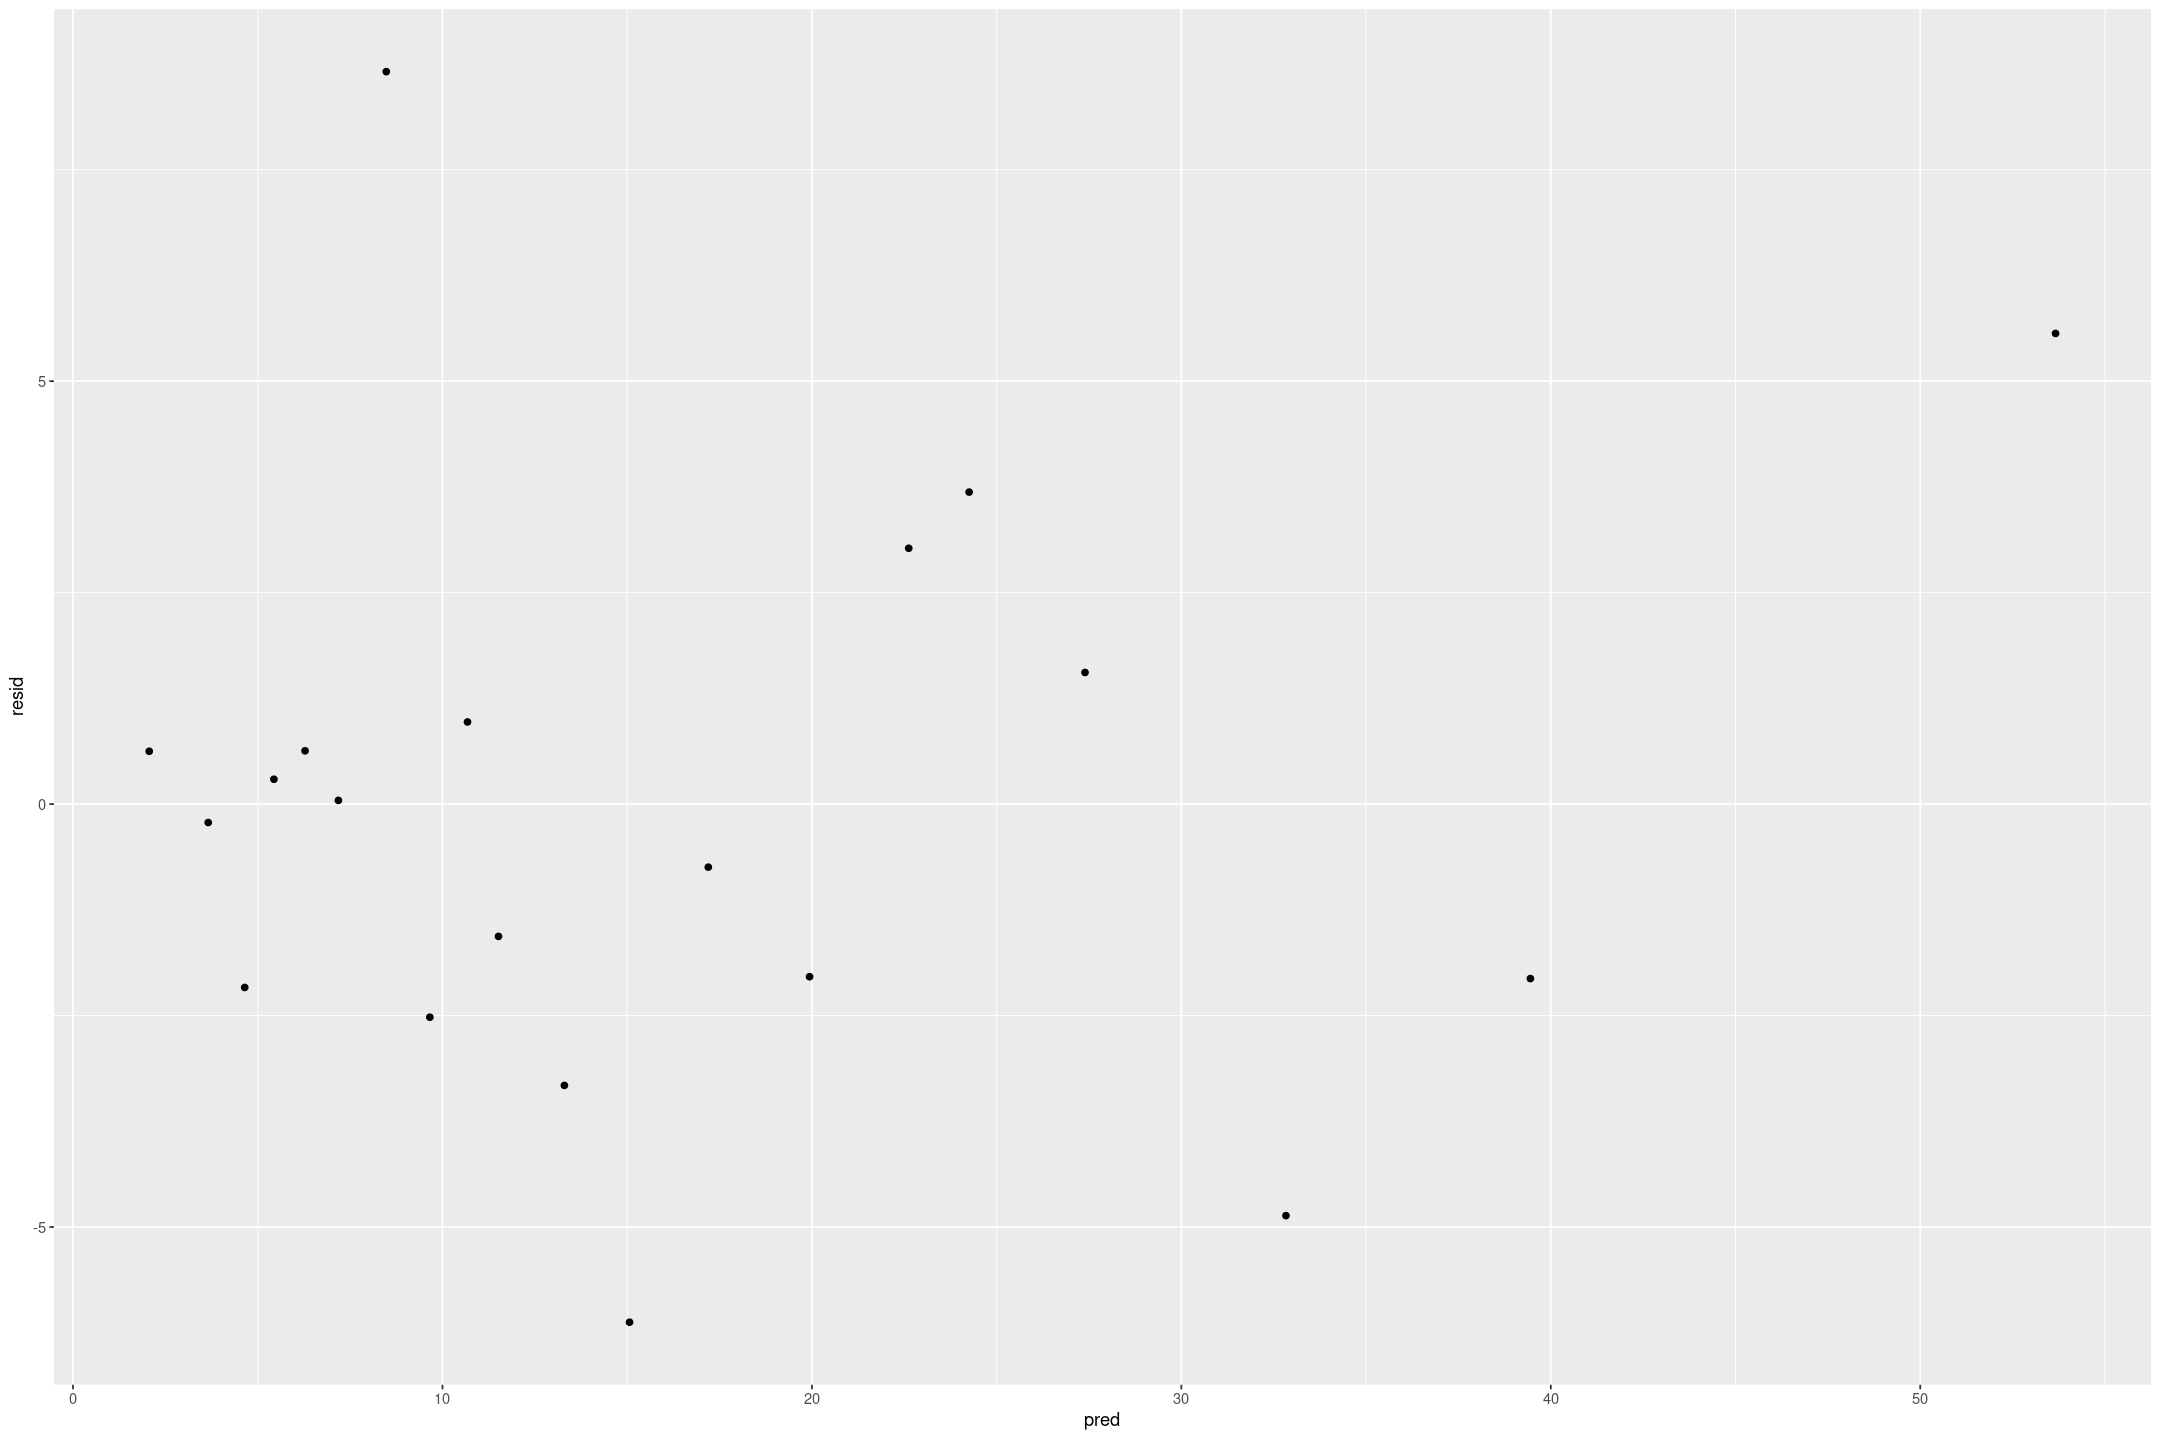

In [50]:
risky %>%
mutate(pred=predict(fit_risky_pre_nbinom_log, type="response"),
       resid = fupacts - pred) %>%
group_by(bin = cut_quantile(pred, 20)) %>%
summarise(pred=mean(pred), resid=mean(resid)) %>%
gf_point(resid ~ pred)

In [51]:
pred50_pre_nbinom_log <- posterior_predict(fit_risky_pre_nbinom_log)[1:50,] %>%
t() %>%
as.data.frame() %>%
pivot_longer(everything(), values_to="fupacts", names_to="simulation")

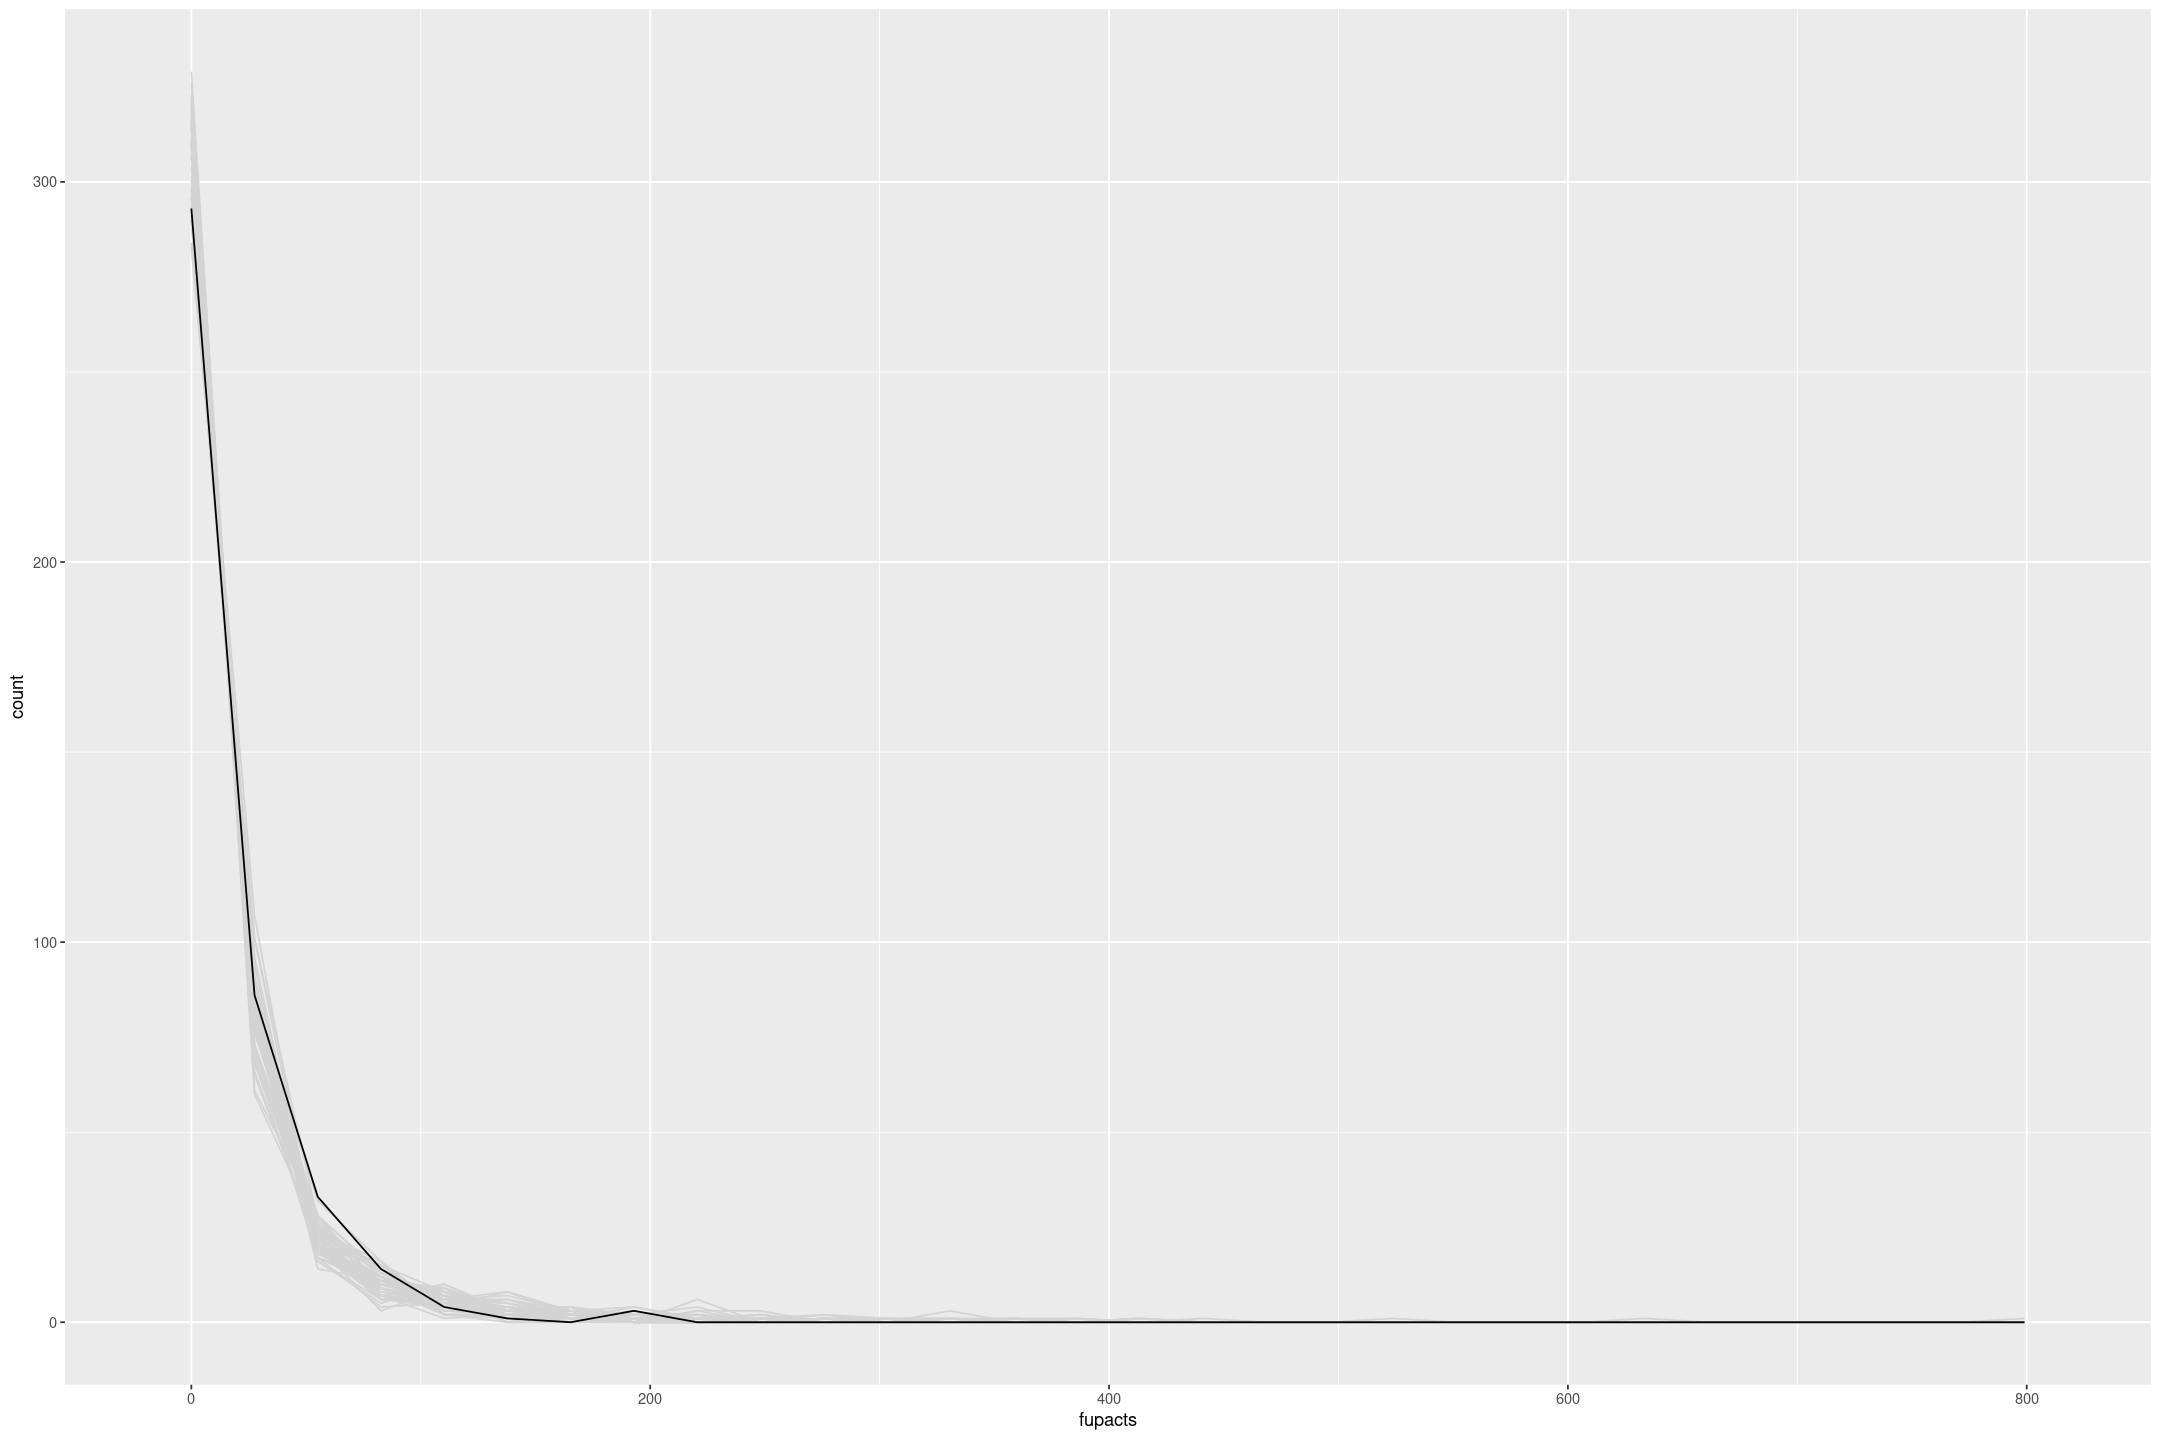

In [52]:
gf_freqpoly(~fupacts, group=~simulation, data=pred50_pre_nbinom_log, colour="lightgrey", bins=30) %>%
gf_freqpoly(~fupacts, group=FALSE, data=risky, bins=30)

Interestingly the distribution looks to have similar mis-fits as before

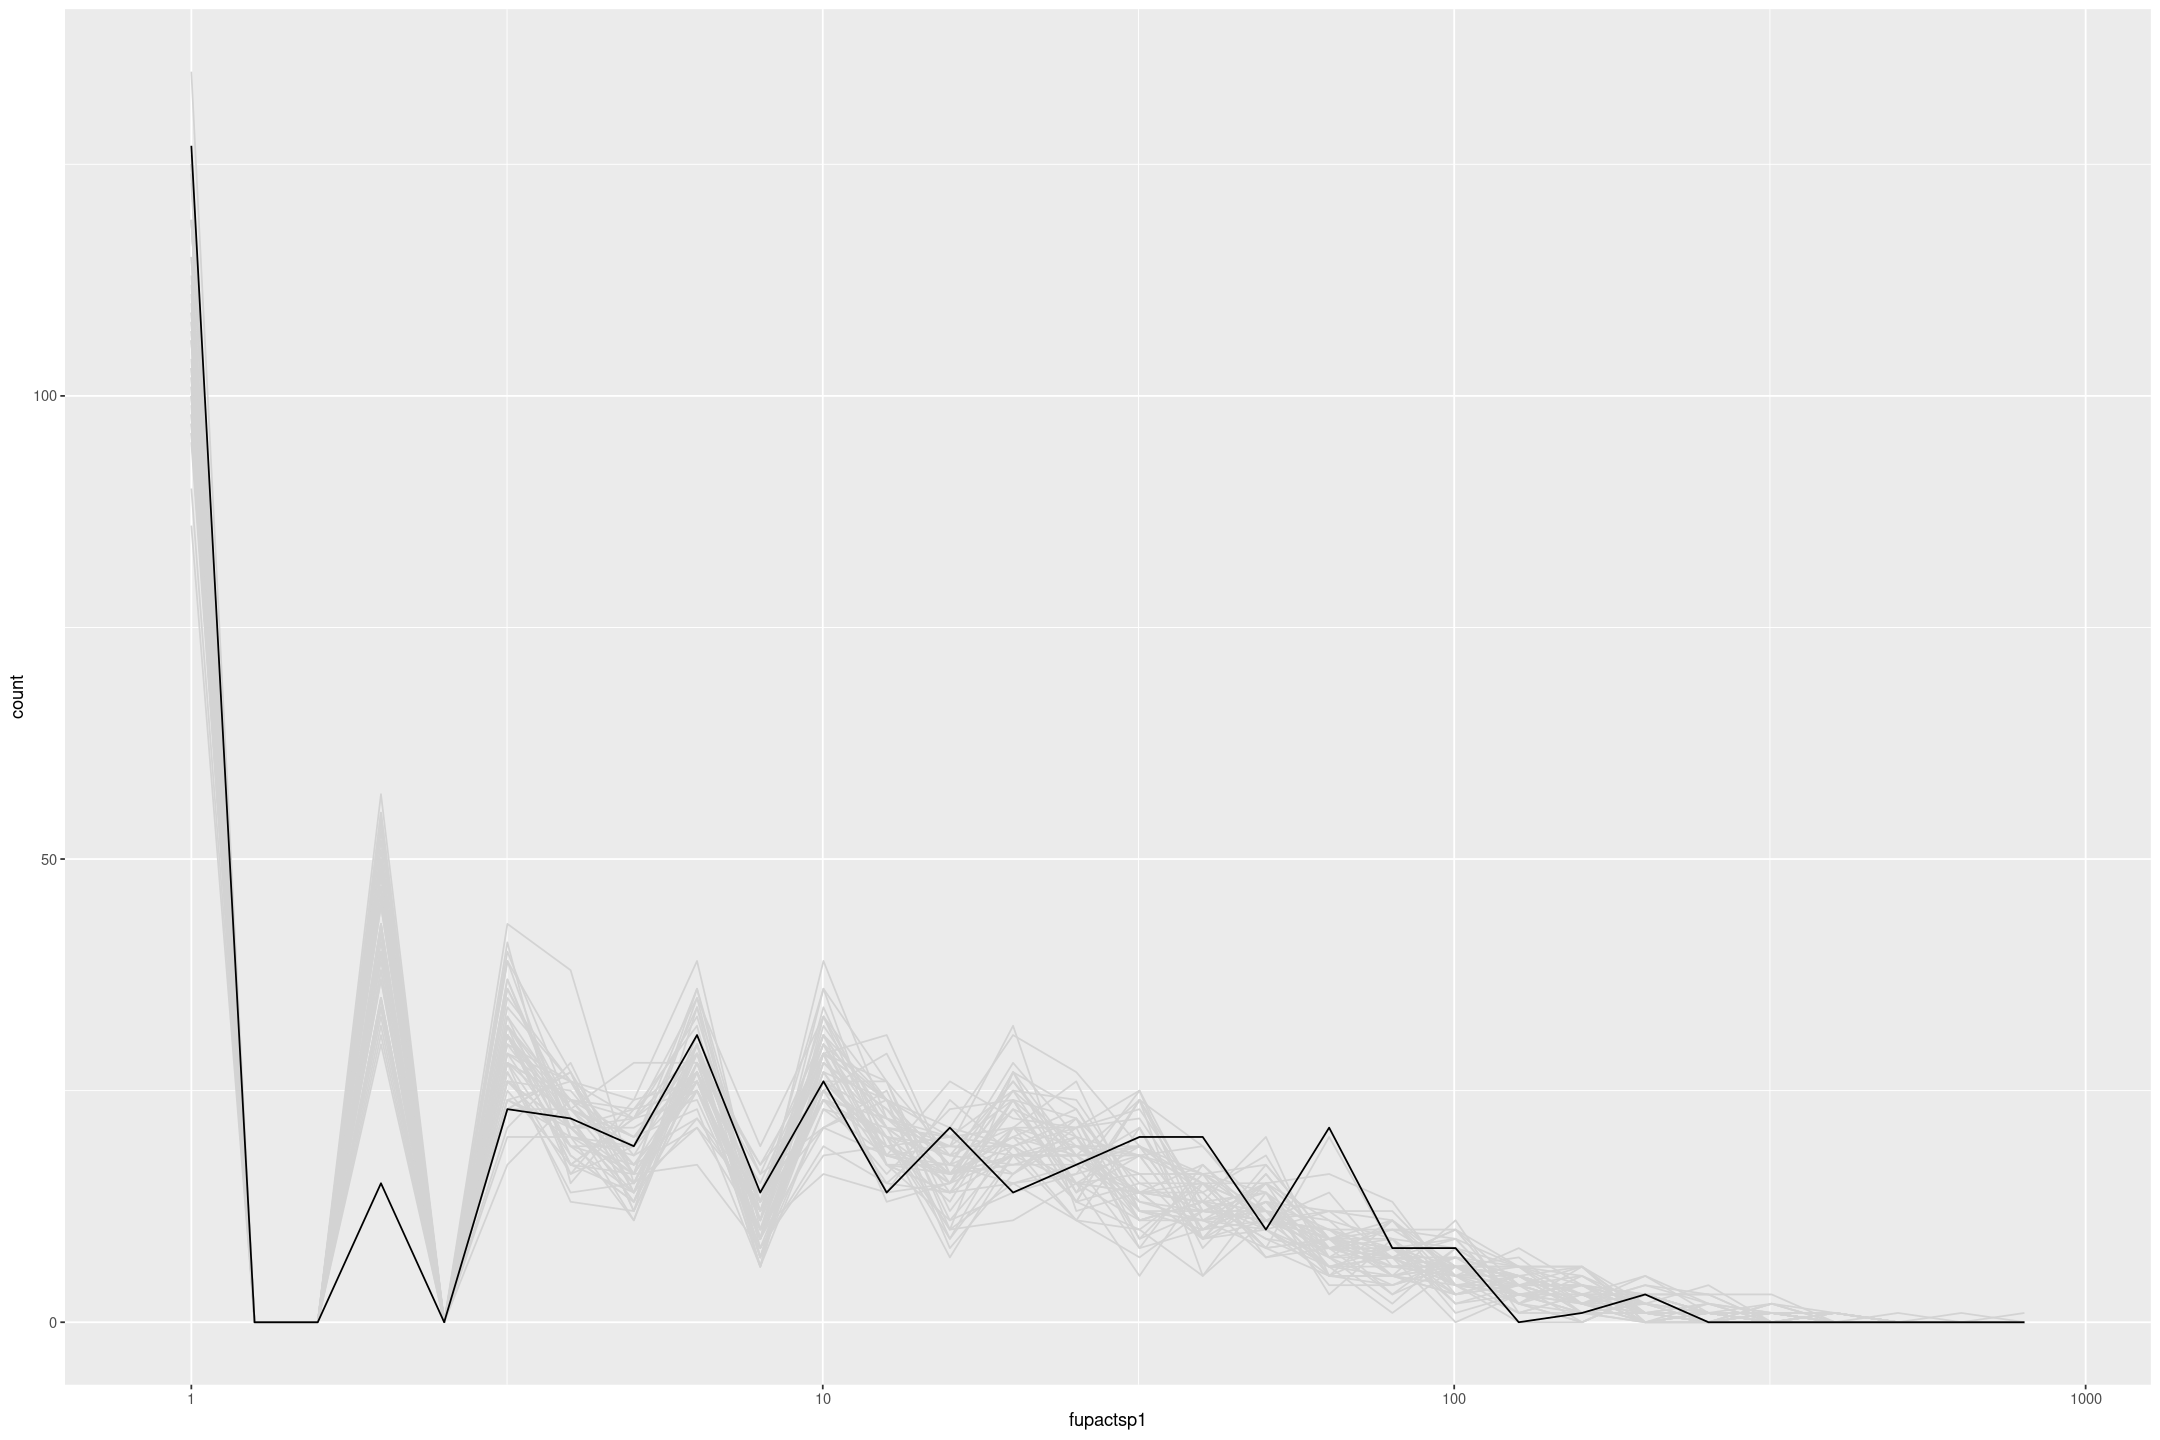

In [53]:
gf_freqpoly(~fupactsp1, group=~simulation, data=pred50_pre_nbinom_log %>% mutate(fupactsp1 = fupacts+1), colour="lightgrey", bins=30) %>%
gf_freqpoly(~fupactsp1, group=FALSE, data=risky %>% mutate(fupactsp1 = fupacts+1), bins=30) +
scale_x_log10()

But the actual predictions on the dataset never get quite so high.

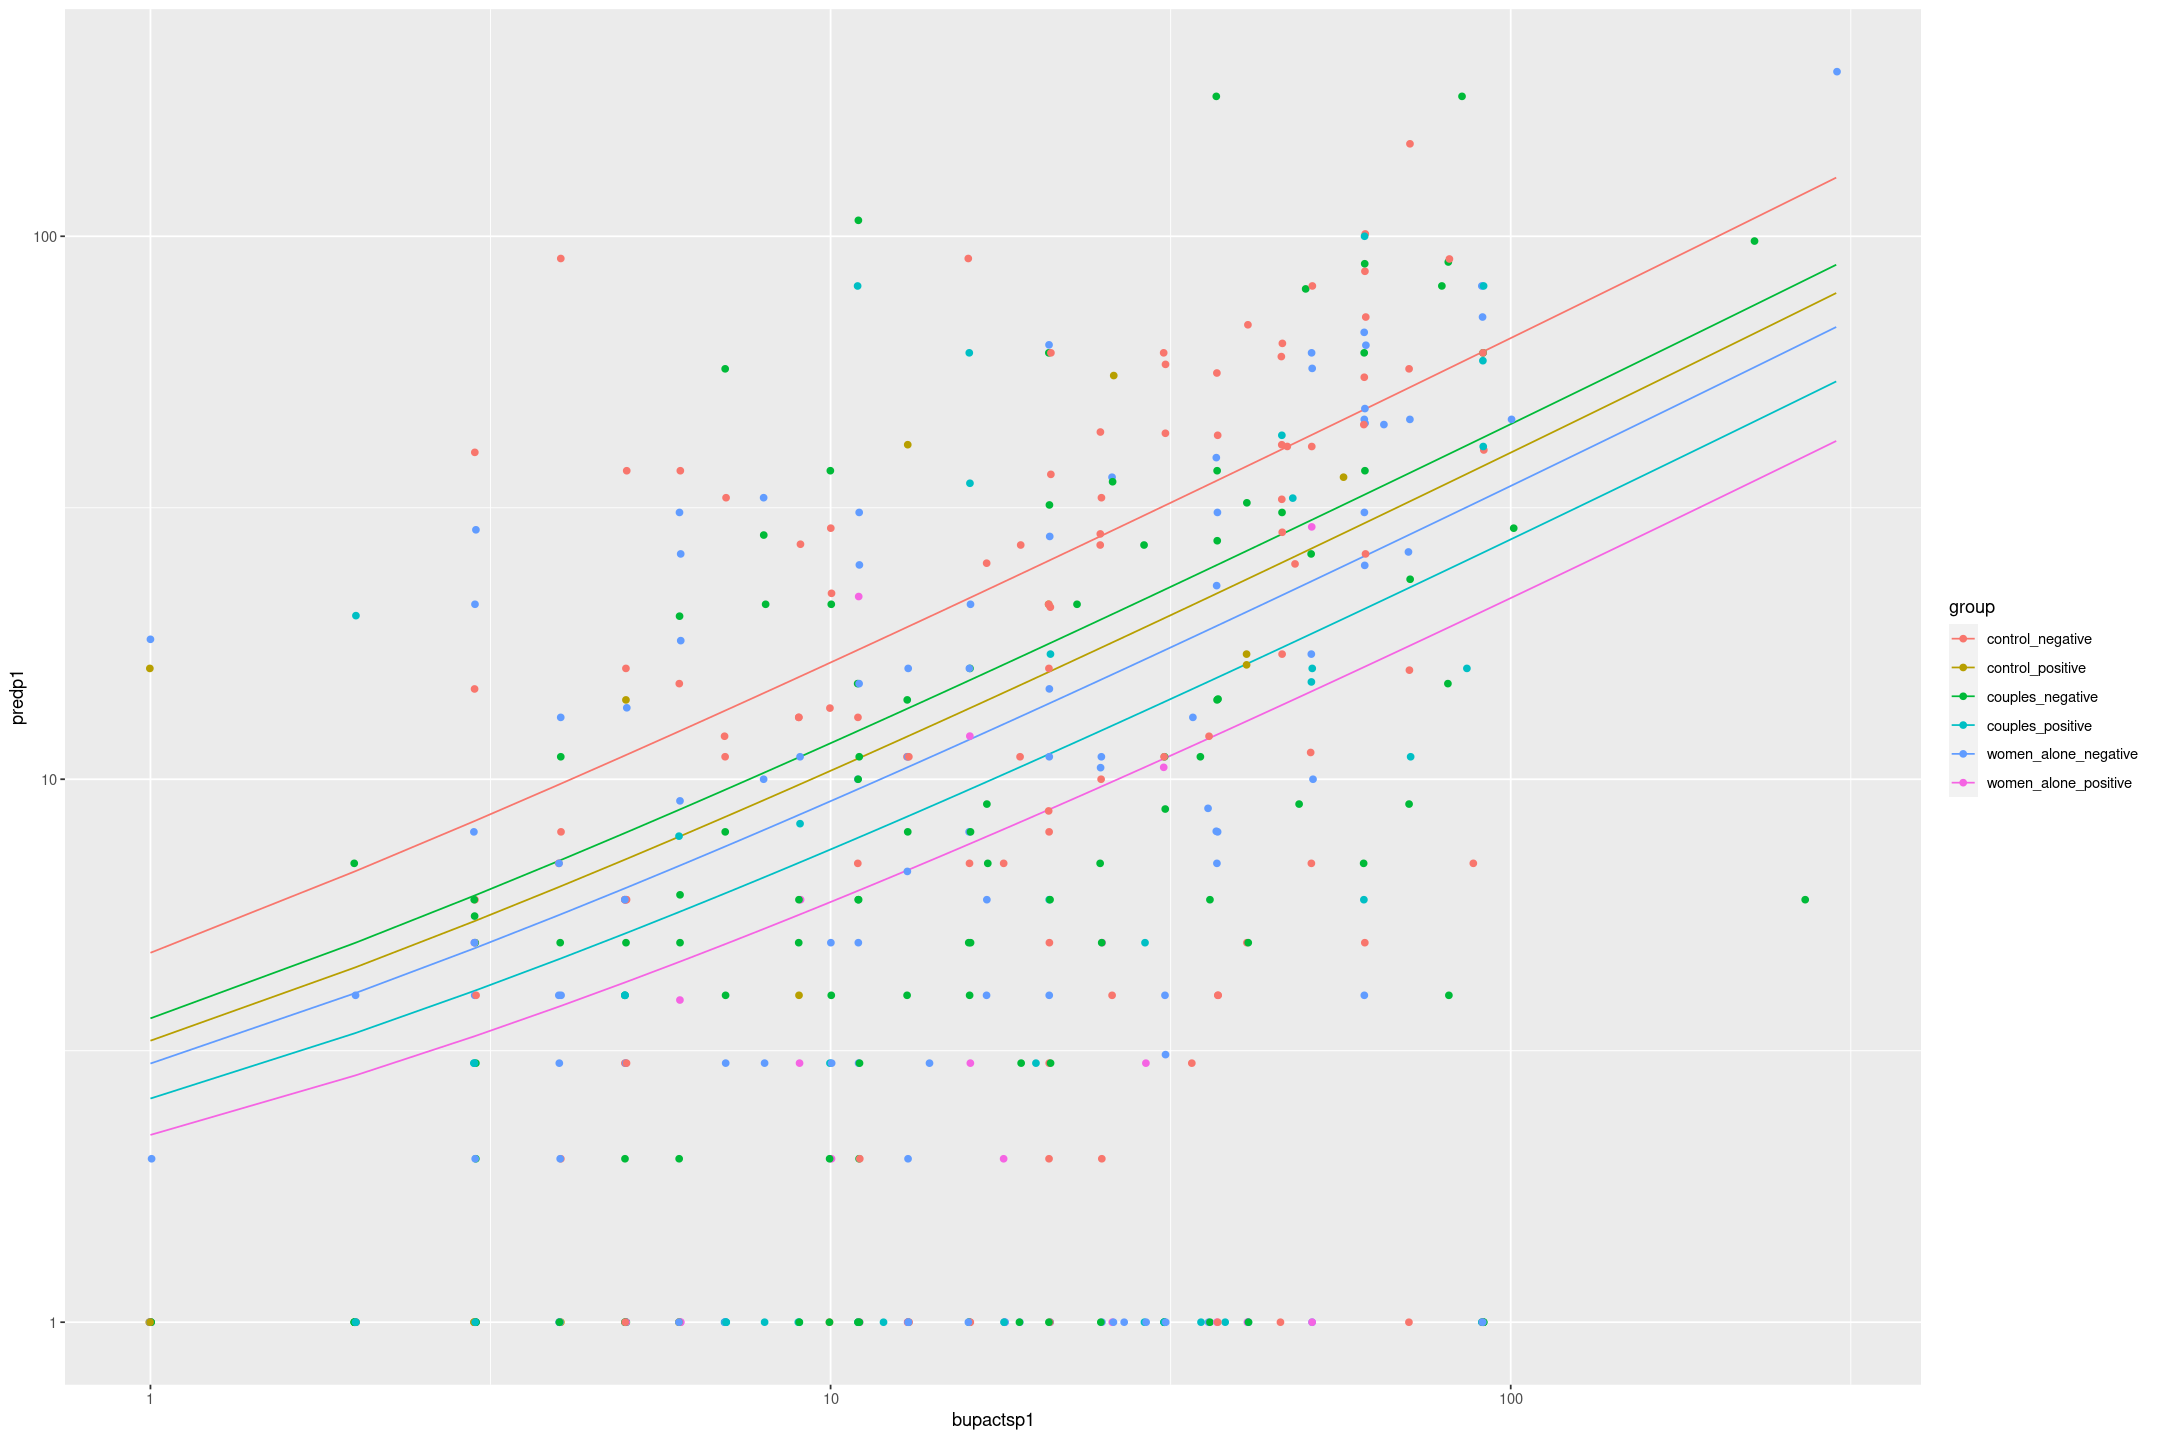

In [54]:
crossing(bupacts=seq(0, 300), condition=c('control', 'women_alone', 'couples'), bs_hiv=c('positive', 'negative')) %>%
mutate(women_alone = if_else(condition == 'women_alone', 1,0),
      couples = if_else(condition == 'couples', 1,0),
      bupacts_std = (bupacts - mean(risky$bupacts)) / (2 * sd(risky$bupacts)),
      group=glue('{condition}_{bs_hiv}'),
      bupactsp1 = bupacts + 1) %>%
mutate(predp1 = predict(fit_risky_pre_nbinom_log, type="response", newdata=.) + 1) %>%
gf_line(predp1 ~ bupactsp1, col=~group) %>%
gf_jitter(fupactsp1 ~ bupactsp1, data=risky %>% mutate(condition=if_else(women_alone == 1, "women_alone", if_else(couples==1, "couples", "control")),
                               group=glue('{condition}_{bs_hiv}'),
                                                  fupactsp1 = fupacts + 1,
                                                    bupactsp1 = bupacts + 1)) +
scale_x_log10() +
scale_y_log10()

### Effectiveness on intervention

Our most reasonable model is:

In [55]:
print(fit_risky_pre_nbinom_log, digits=2)

stan_glm
 family:       neg_binomial_2 [log]
 formula:      acts ~ couples + women_alone + log(bupacts + 1) + bs_hiv
 observations: 434
 predictors:   5
------
                 Median MAD_SD
(Intercept)       1.30   0.22 
couples          -0.36   0.19 
women_alone      -0.64   0.19 
log(bupacts + 1)  0.62   0.06 
bs_hivpositive   -0.51   0.20 

Auxiliary parameter(s):
                      Median MAD_SD
reciprocal_dispersion 0.43   0.03  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


It indicates that the intervention is effective, both for couples and women alone, and moreover appears to be even *more* effective for women alone (which seems surpising to me!).

## Validity of modeling assumptions

These data include responses from both men and women from the participating couples.
Does this give you any concern with regard to our modeling assumptions?

In our modeling assumptions we assume independence of errors - if we include both men and women from the participating couples the errors aren't independent, the number `fupacts` for each member of the couple would be closely correlated.

In the paper this was taken from they state to account for this

> random-effects models, which accommodate within-group correlation structures, were used.

However without the indicator of which pairs makes couples, I don't think we can repeat the analysis.

In [56]:
risky %>% 
count(sex, couples, women_alone) %>% 
pivot_wider(names_from=sex, values_from=n)

couples women_alone man woman
1 0       0           63  63   
2 0       1           73  73   
3 1       0           81  81

# Offset in a Poisson or negative binomial regression

Explain why putting the logarithm of the exposure into a Poisson or negative binomial model as an offset, is equivalent to including it as a regression predictor, but with its coefficient fixed to the value 1.

From equation 15.2

$$ y_i \sim {\rm negative\ binomial}(u_i\theta_i, \phi) $$

Where $\theta_i = e^{X_i \beta} $.

Rewriting 

$$ \begin{align}
u_i \theta_i &= \exp({\ln(u_i)}) \exp({X_i \beta})  \\
             & =\exp{X_i \beta + \ln(u_i) 1} 
\end{align}$$

And so we can see it's the same as having the log of the exposure as a regression predictor $X_i' = (X_i, u_i) $, with coefficient fixed to 1 $ \beta' = (\beta, 1) $, then $ u_i \theta_i = \exp({X_i' \beta'}) $.

# Binomial regression

Redo the basketball shooting example on page 270, making some changes:

As a starting point let's recreate the model in the book

In [57]:
N <- 100
height <- rnorm(N, 72, 3)
p <- 0.4 + 0.1 * (height - 72)/3
n <- rep(20, N)
y <- rbinom(N, n, p)
data_shots <- data.frame(n=n, y=y, height=height)

In [58]:
fit_shots <- stan_glm(cbind(y, n-y) ~ height,
                          family=binomial(link="logit"),
                          data=data_shots,
                          refresh=0)

In [59]:
print(fit_shots, digits=2)

stan_glm
 family:       binomial [logit]
 formula:      cbind(y, n - y) ~ height
 observations: 100
 predictors:   2
------
            Median MAD_SD
(Intercept) -9.15   1.20 
height       0.12   0.02 

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


It captures the data quite well

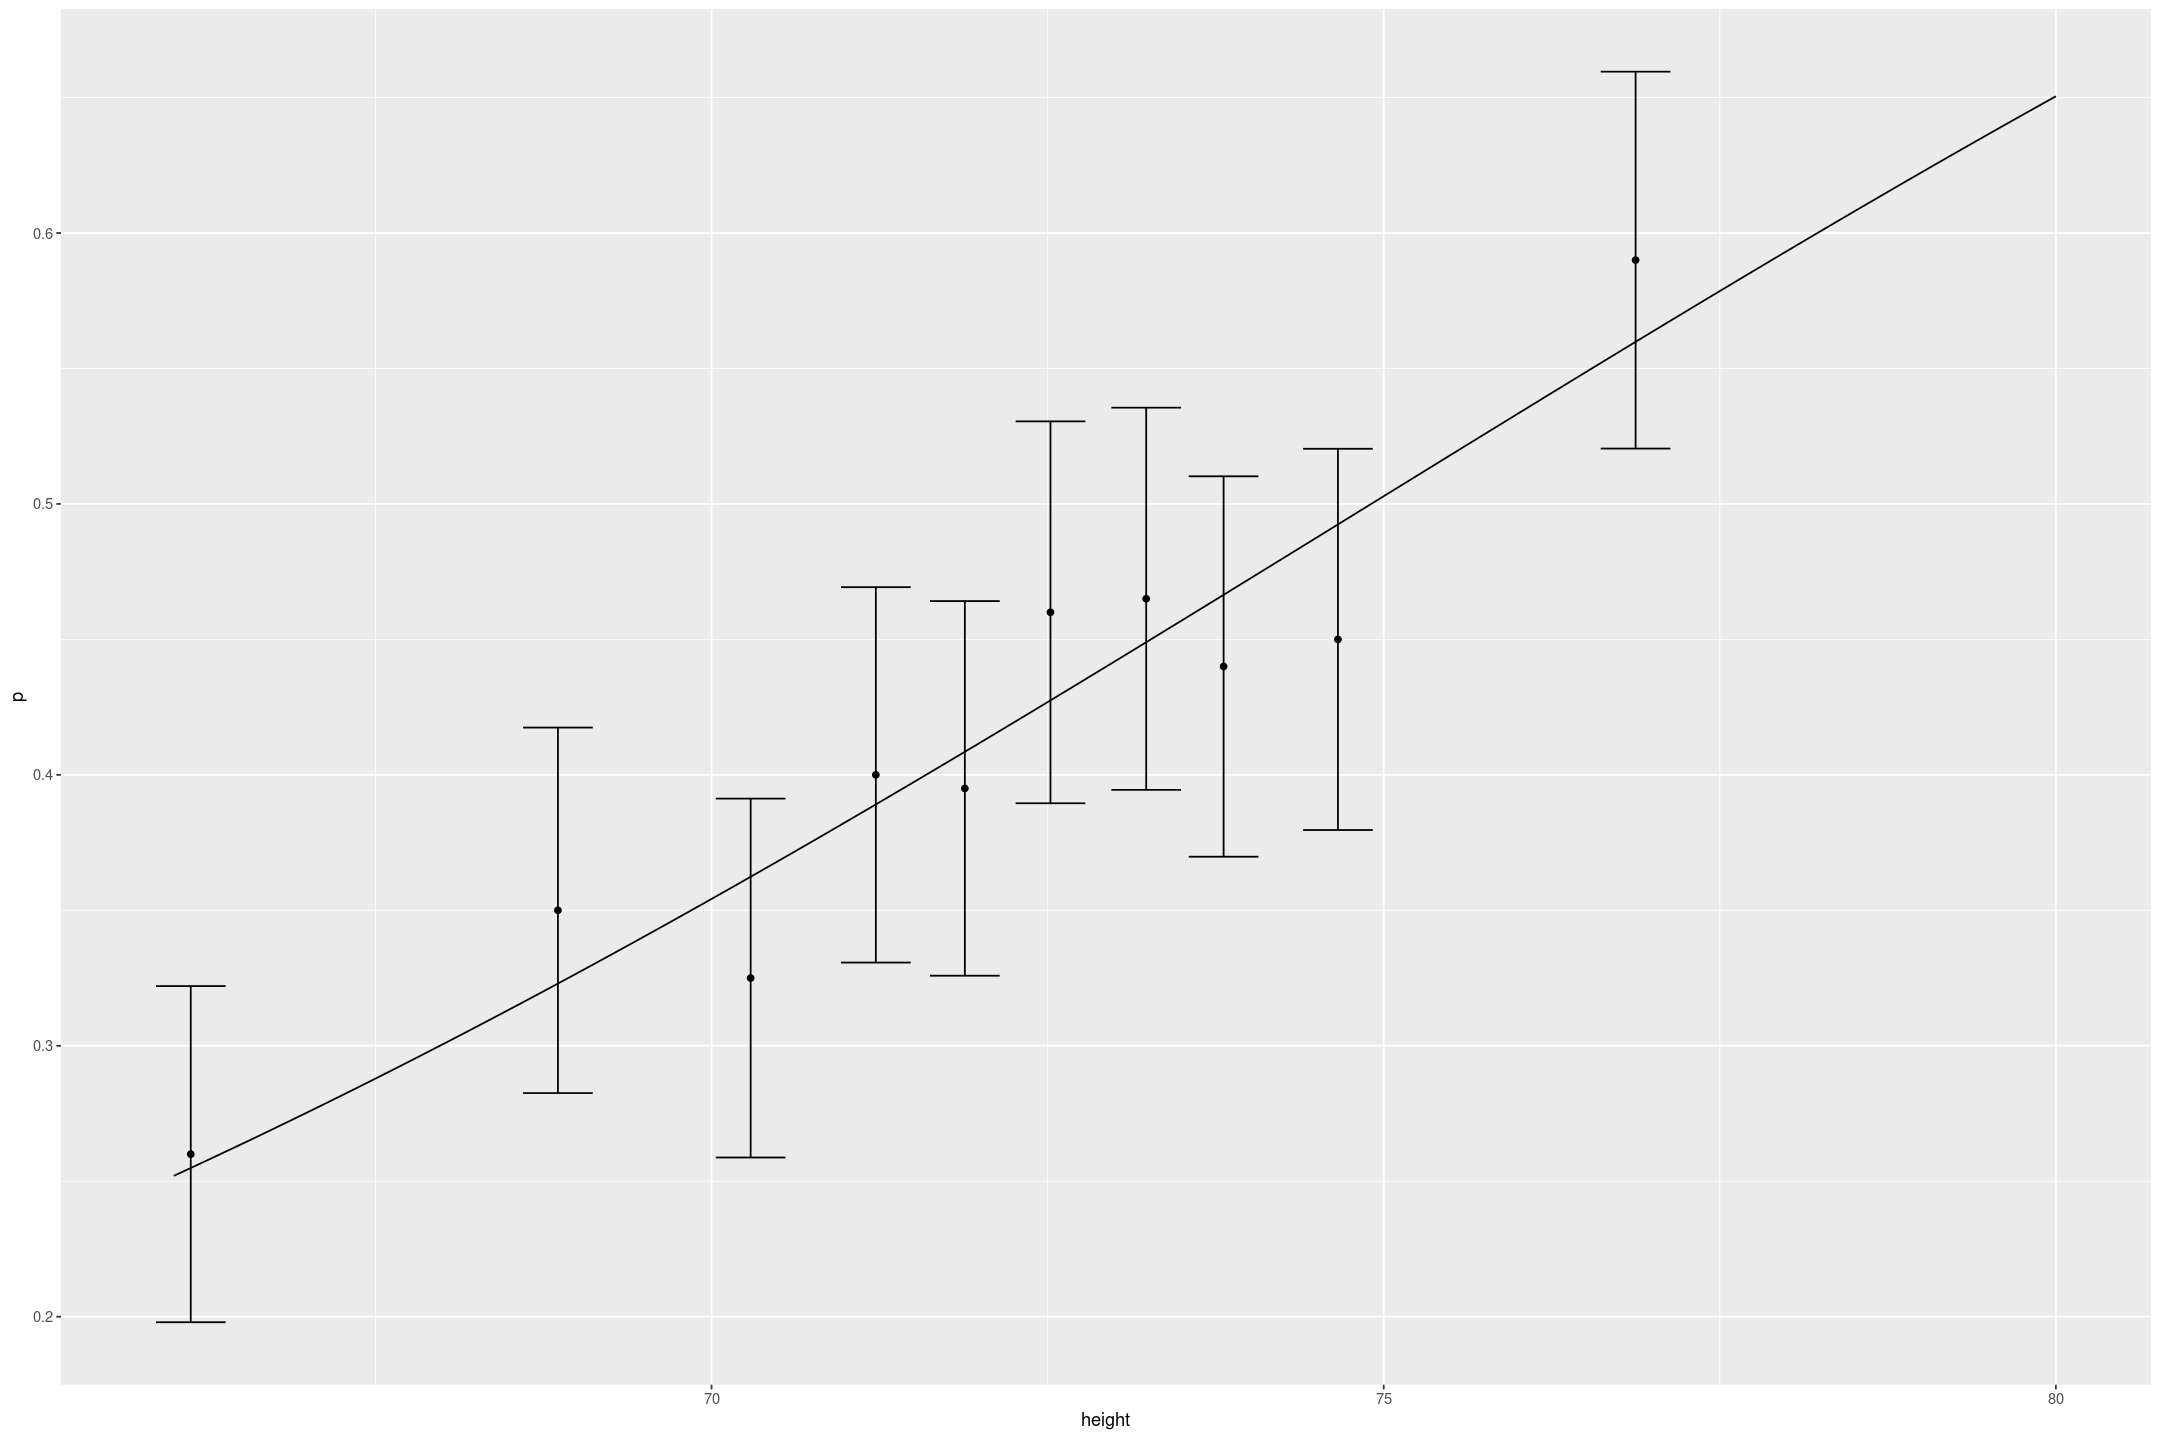

In [60]:
data_shots %>%
group_by(bin = cut_quantile(height, 10)) %>%
summarise(p=sum(y)/sum(n), n_total=sum(n), height=mean(height)) %>%
mutate(se = sqrt(p*(1-p)/n_total), lower=p-2*se, upper=p+2*se) %>%
gf_point(p ~ height) %>%
gf_errorbar(ymin=~lower, ymax=~upper) %>%
gf_line(data=data.frame(height=seq(66,80, by=0.1)) %>% mutate(p=predict(fit_shots, newdata=., type="response")))

## Variable number of shots

Instead of having each player shoot 20 times, let the number of shots per player vary, drawn from the uniform distribution between 10 and 30.

In [61]:
N <- 100
height <- rnorm(N, 72, 3)
p <- 0.4 + 0.1 * (height - 72)/3
n <- sample(seq(20, 30), size=N, replace=TRUE)
y <- rbinom(N, n, p)
data_shots_var <- data.frame(n=n, y=y, height=height)

In [62]:
fit_shots_var <- stan_glm(cbind(y, n-y) ~ height,
                          family=binomial(link="logit"),
                          data=data_shots_var,
                          refresh=0)

The estimates are similar

In [63]:
print(fit_shots_var, digits=2)

stan_glm
 family:       binomial [logit]
 formula:      cbind(y, n - y) ~ height
 observations: 100
 predictors:   2
------
            Median MAD_SD
(Intercept) -10.54   1.04
height        0.14   0.01

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


And so is the predictions

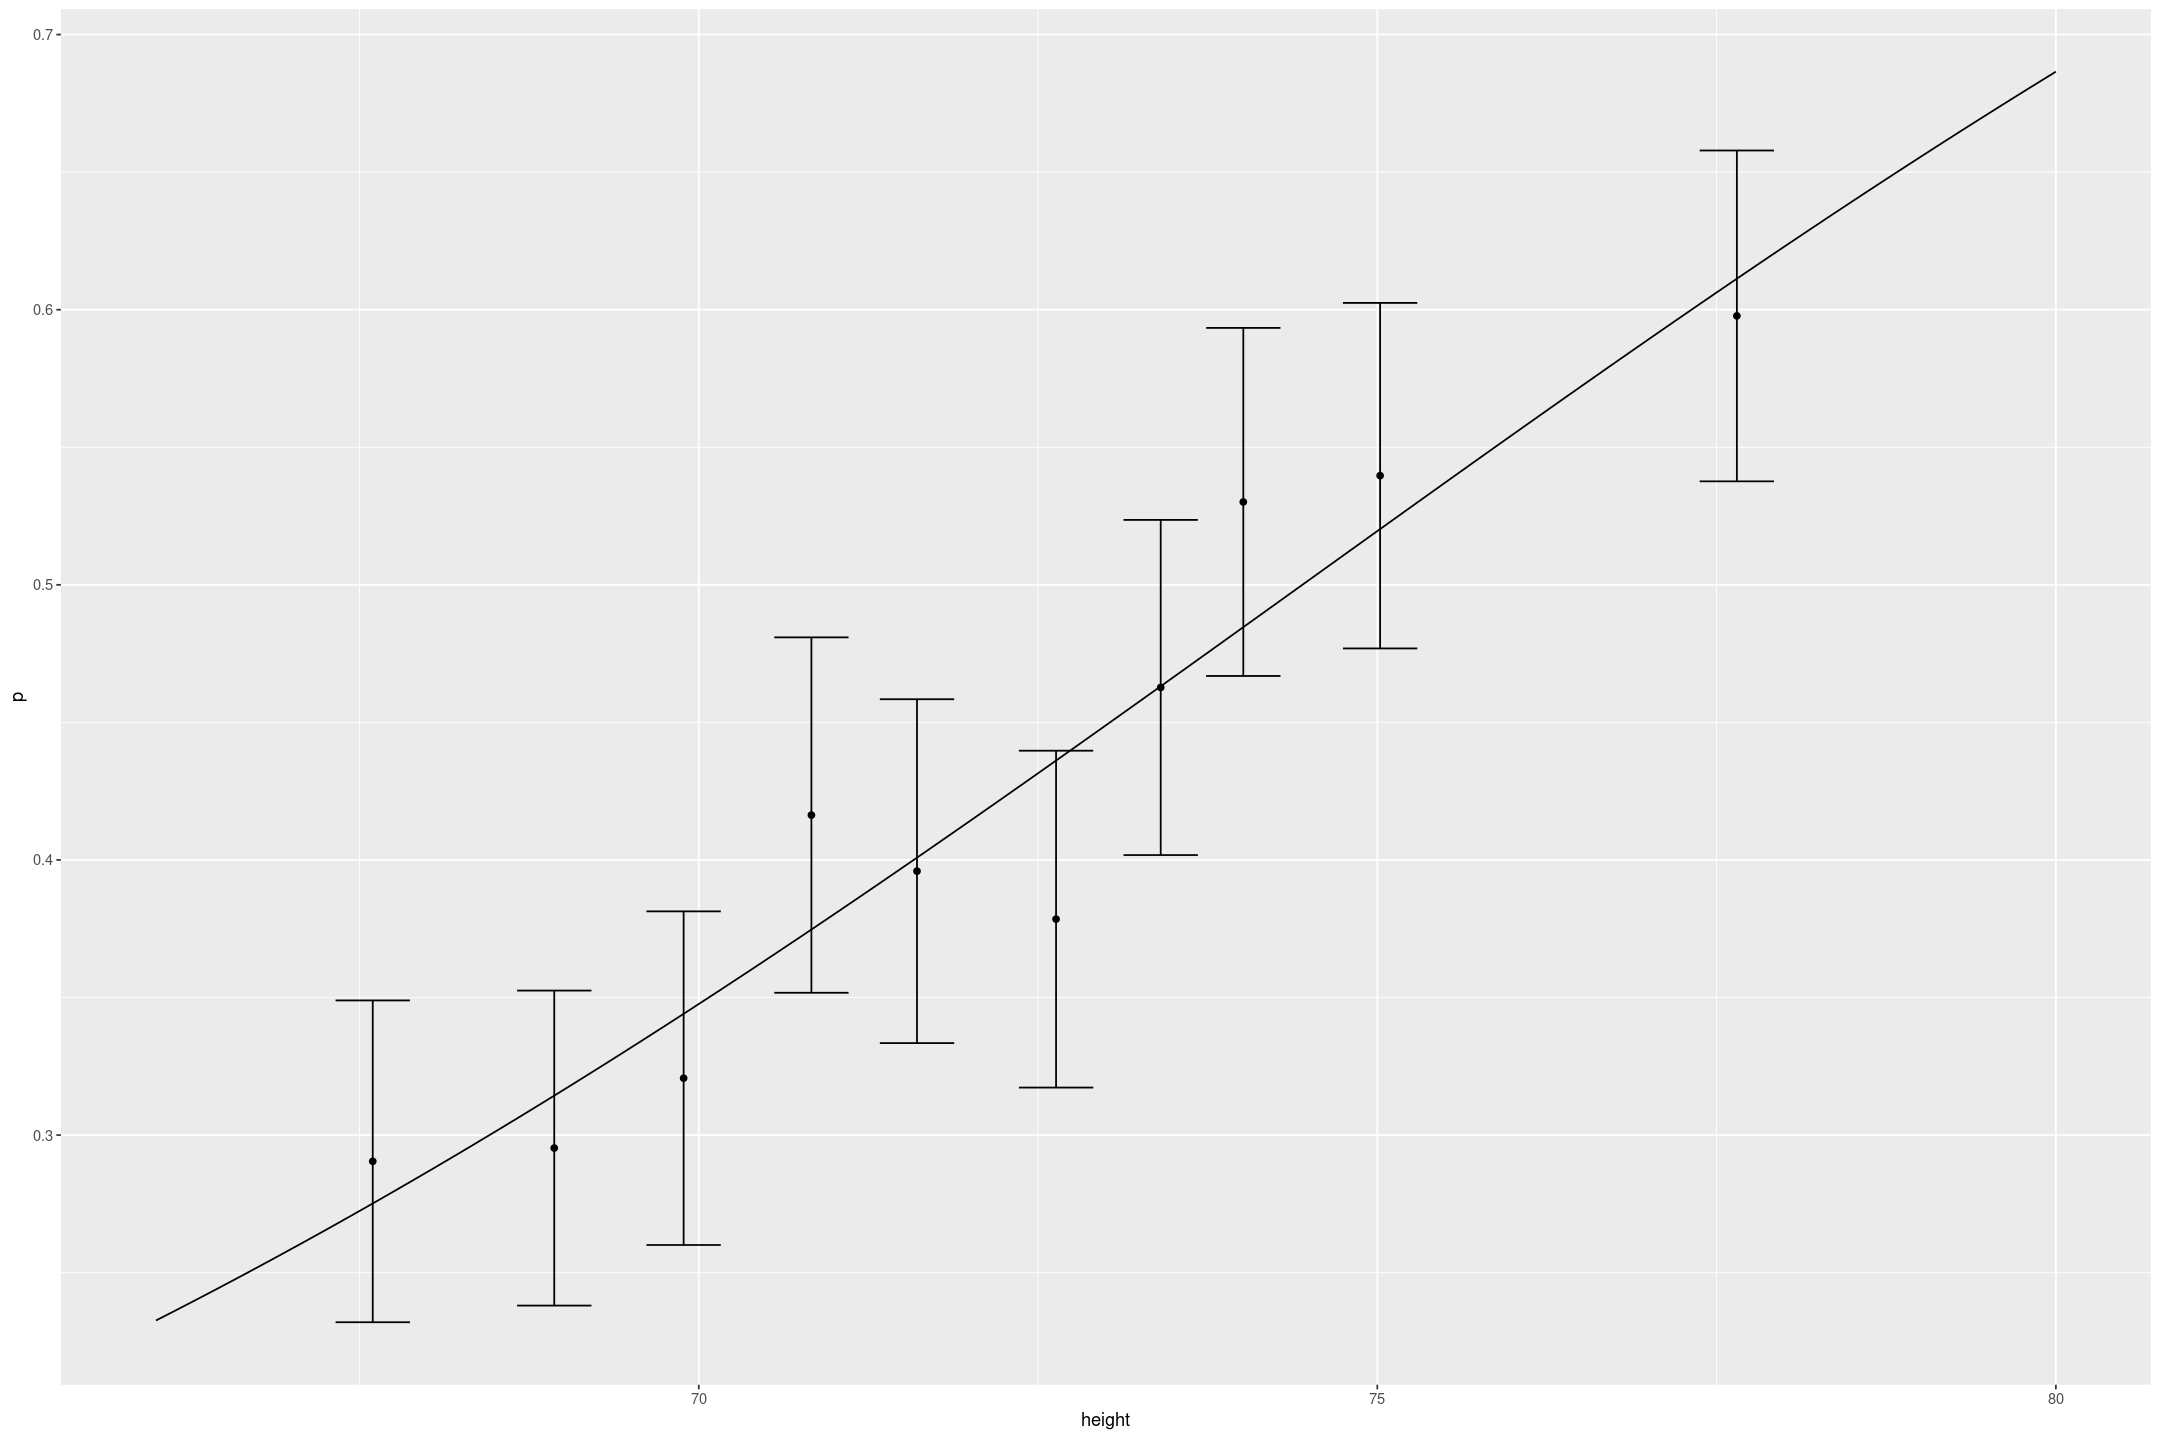

In [64]:
data_shots_var %>%
group_by(bin = cut_quantile(height, 10)) %>%
summarise(p=sum(y)/sum(n), n_total=sum(n), height=mean(height)) %>%
mutate(se = sqrt(p*(1-p)/n_total), lower=p-2*se, upper=p+2*se) %>%
gf_point(p ~ height) %>%
gf_errorbar(ymin=~lower, ymax=~upper) %>%
gf_line(data=data.frame(height=seq(66,80, by=0.1)) %>% mutate(p=predict(fit_shots_var, newdata=., type="response")))

##  Logistic success

Instead of having the true probability of success be linear, have the true probability be a logistic function, set so that Pr(success) = 0.3 for a player who is 5'9" and 0.4 for a 6' tall player.

We need to find a and b such that `invlogit(a + b * height)` gives 0.3 when height is 5'9" and 0.4 when height is 6'.

### Setting the coefficients

In [65]:
(height_coef = matrix(c(1, 5 * 12 + 9,
                       1, 6 * 12), nrow=2, ncol=2, 
                      byrow=TRUE))

[,1] [,2]
[1,] 1    69  
[2,] 1    72

In [66]:
(height_logit = c(logit(0.3), logit(0.4)))

[1] -0.8472979 -0.4054651

In [67]:
(coefs <- solve(height_coef, height_logit))
a <- coefs[1]
b <- coefs[2]

[1] -11.0094512   0.1472776

Check:

In [68]:
invlogit(a + b * (5*12 + 9))

[1] 0.3

In [69]:
invlogit(a + b * (6*12))

[1] 0.4

### Simulating the data

In [70]:
N <- 100
height <- rnorm(N, 72, 3)
p <- invlogit(a + b * height)
n <- rep(20, N)
y <- rbinom(N, n, p)
data_shots_logistic <- data.frame(n=n, y=y, height=height)

### Fitting the model

In [71]:
fit_shots_logistic <- stan_glm(cbind(y, n-y) ~ height,
                          family=binomial(link="logit"),
                          data=data_shots_logistic,
                          refresh=0)

In [72]:
print(fit_shots_logistic, digits=2)

stan_glm
 family:       binomial [logit]
 formula:      cbind(y, n - y) ~ height
 observations: 100
 predictors:   2
------
            Median MAD_SD
(Intercept) -10.09   1.13
height        0.13   0.02

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


### Checking the model

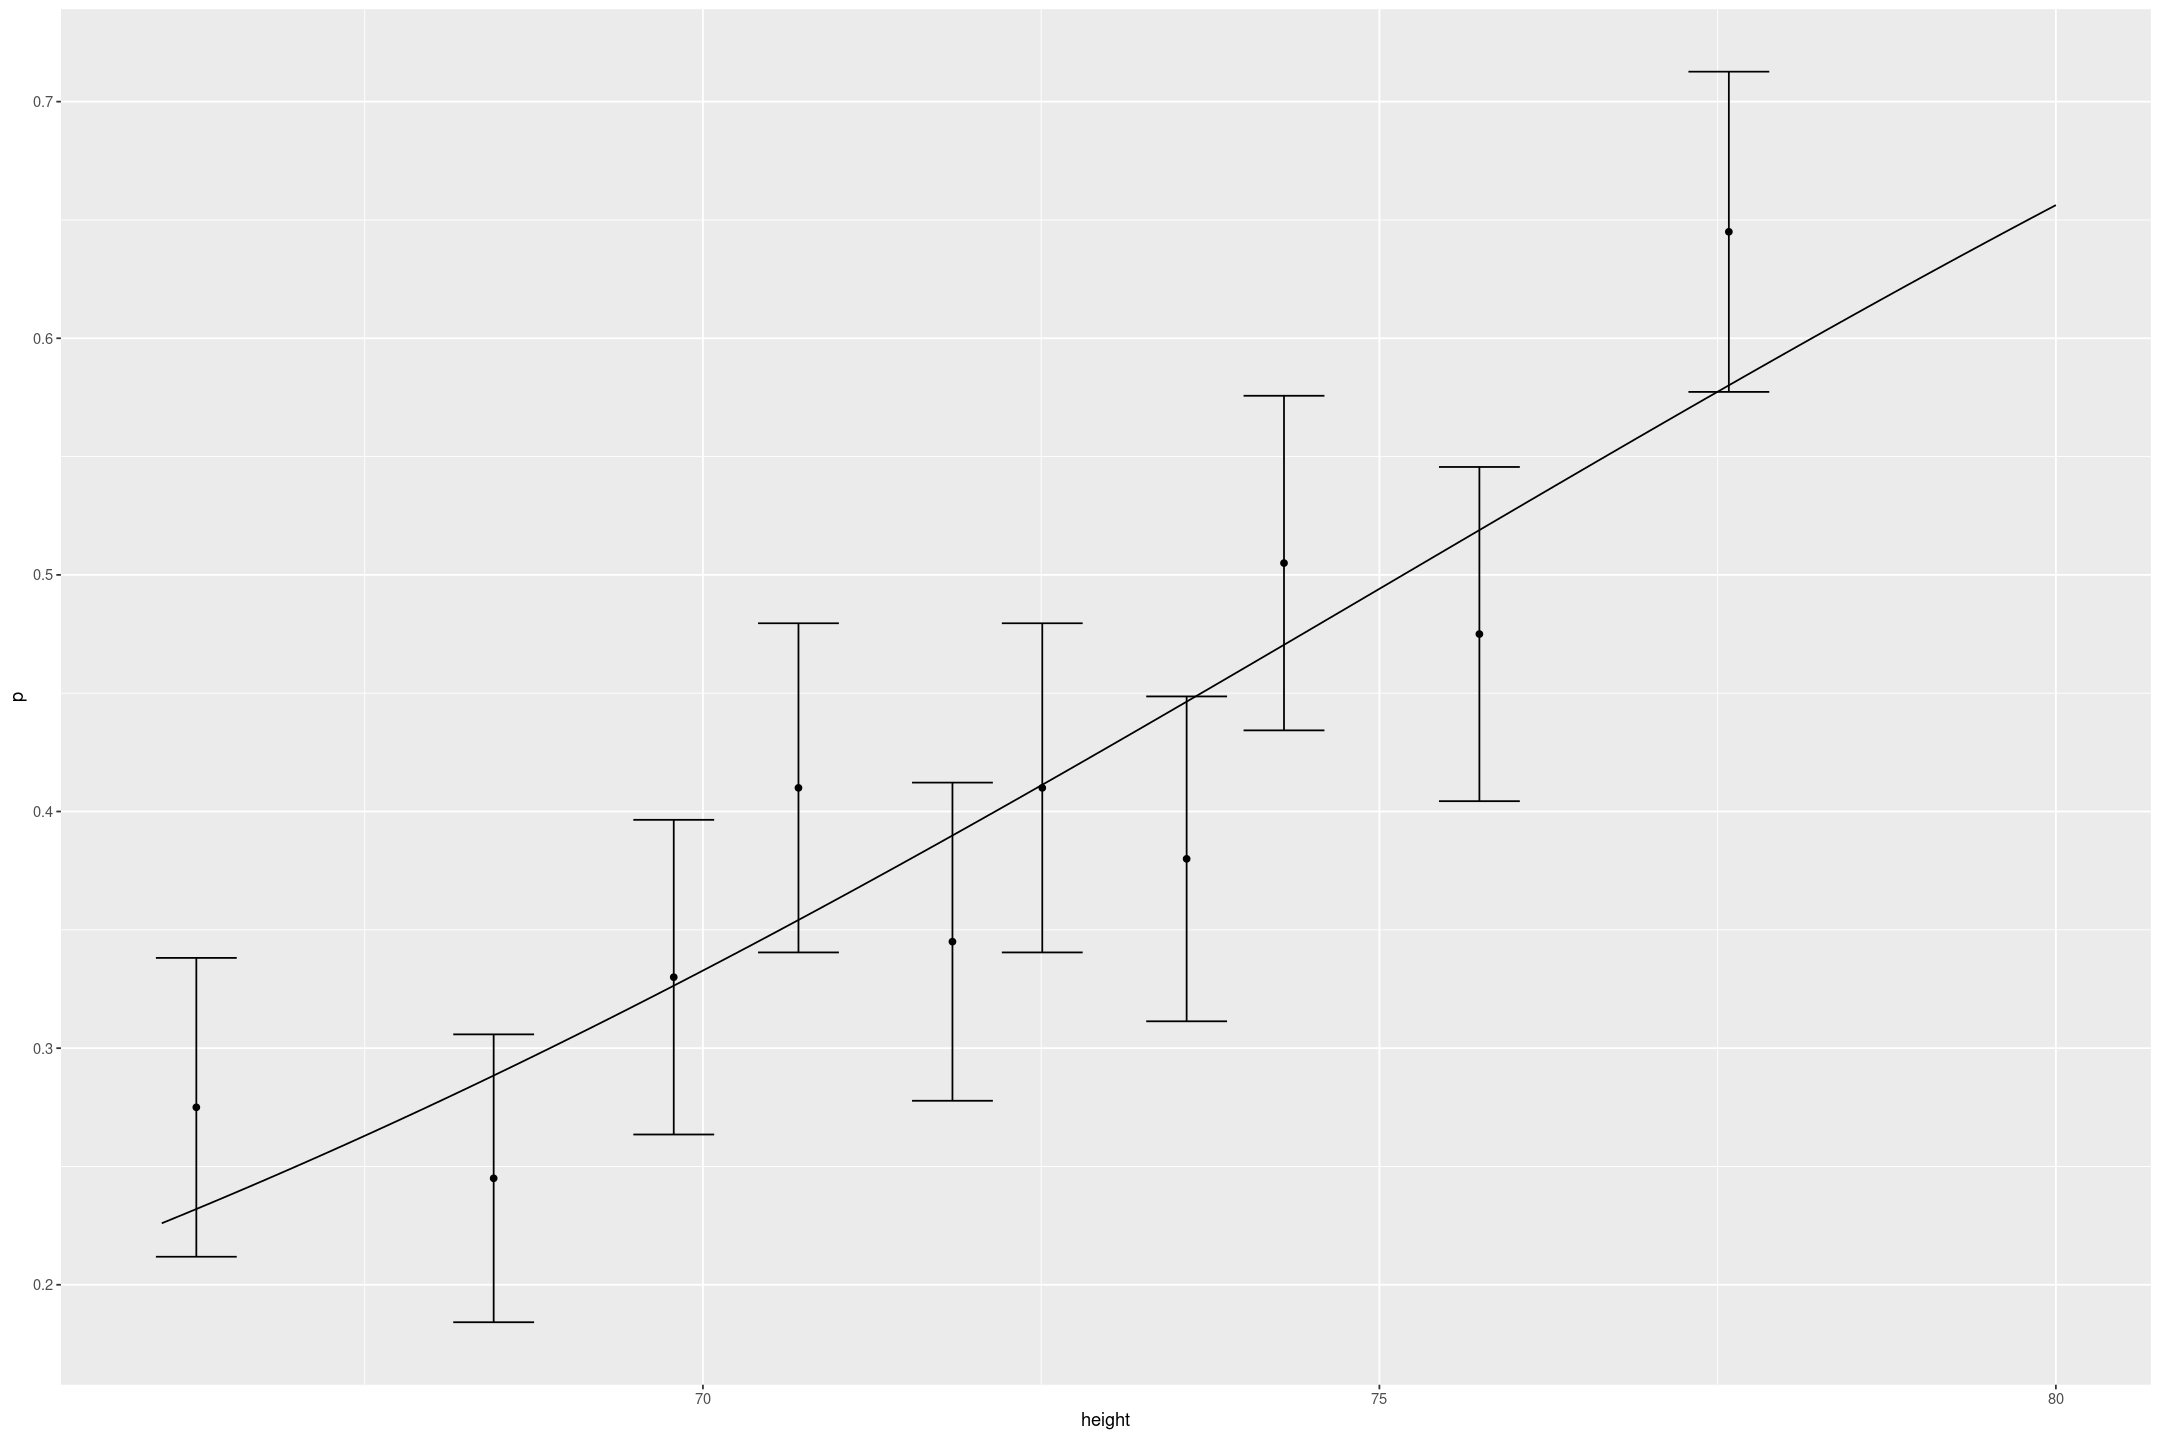

In [73]:
data_shots_logistic %>%
group_by(bin = cut_quantile(height, 10)) %>%
summarise(p=sum(y)/sum(n), n_total=sum(n), height=mean(height)) %>%
mutate(se = sqrt(p*(1-p)/n_total), lower=p-2*se, upper=p+2*se) %>%
gf_point(p ~ height) %>%
gf_errorbar(ymin=~lower, ymax=~upper) %>%
gf_line(data=data.frame(height=seq(66,80, by=0.1)) %>% mutate(p=predict(fit_shots_logistic, newdata=., type="response")))

# Multinomial logit

Using the individual-level survey data from the 2000 National Election Study, predict party identification (which is on a five-point scale) using ideology and demographics with an ordered multinomial logit model.

In [74]:
filename <- 'data/nes/nes5200_processed_voters_realideo.dta'

download_if_missing(filename, 'https://raw.githubusercontent.com/avehtari/ROS-Examples/master/NES/data/nes5200_processed_voters_realideo.dta')

nes <- foreign::read.dta(filename)

In [75]:
nes %>% head()

year resid weight1 weight2 weight3 age gender    race    
1 1948 1001  1       1       1       NA  1. male   1. white
2 1948 1002  1       1       1       NA  2. female 1. white
3 1948 1003  1       1       1       NA  2. female 1. white
4 1948 1004  1       1       1       NA  2. female 1. white
5 1948 1005  1       1       1       NA  1. male   1. white
6 1948 1006  1       1       1       NA  2. female 1. white
  educ1                                    urban region income                 
1 1. grade school of less (0-8 grades)     NA    NA     3. 34 to 67 percentile 
2 2. high school (12 grades or fewer, incl NA    NA     5. 96 to 100 percentile
3 2. high school (12 grades or fewer, incl NA    NA     4. 68 to 95 percentile 
4 3. some college(13 grades or more,but no NA    NA     5. 96 to 100 percentile
5 3. some college(13 grades or more,but no NA    NA     4. 68 to 95 percentile 
6 2. high school (12 grades or fewer, incl NA    NA     5. 96 to 100 percentile
  occup1 union                                    religion                    
1 NA     1. yes, someone (1948: head) in househol 1. protestant               
2 NA     2. no, no one in the household belongs t 1. protestant               
3 NA     2. no, no one in the household belongs t 2. catholic (roman catholic)
4 NA     2. no, no one in the household belongs t 1. protestant               
5 NA     2. no, no one in the household belongs t 2. catholic (roman catholic)
6 NA     2. no, no one in the household belongs t 1. protestant               
  educ2 educ3 martial_status occup2 icpsr_cty fips_cty partyid7 partyid3
1 NA    NA    NA             NA     NA        NA       NA       NA      
2 NA    NA    NA             NA     NA        NA       NA       NA      
3 NA    NA    NA             NA     NA        NA       NA       NA      
4 NA    NA    NA             NA     NA        NA       NA       NA      
5 NA    NA    NA             NA     NA        NA       NA       NA      
6 NA    NA    NA             NA     NA        NA       NA       NA      
  partyid3_b str_partyid father_party mother_party dlikes rlikes dem_therm
1 NA         NA          NA           NA           NA     NA     NA       
2 NA         NA          NA           NA           NA     NA     NA       
3 NA         NA          NA           NA           NA     NA     NA       
4 NA         NA          NA           NA           NA     NA     NA       
5 NA         NA          NA           NA           NA     NA     NA       
6 NA         NA          NA           NA           NA     NA     NA       
  rep_therm regis vote          regisvote presvote      presvote_2party
1 NA        NA    2. yes, voted NA        1. democrat   1. democrat    
2 NA        NA    2. yes, voted NA        2. republican 2. republican  
3 NA        NA    2. yes, voted NA        1. democrat   1. democrat    
4 NA        NA    2. yes, voted NA        2. republican 2. republican  
5 NA        NA    2. yes, voted NA        1. democrat   1. democrat    
6 NA        NA    2. yes, voted NA        2. republican 2. republican  
  presvote_intent                          ideo_feel ideo7 ideo cd state
1 1. democratic candidate (with or without NA        NA    NA   NA NA   
2 2. republican candidate (with or without NA        NA    NA   NA NA   
3 3. undecided/ dk (exc.1964)              NA        NA    NA   NA NA   
4 2. republican candidate (with or without NA        NA    NA   NA NA   
5 1. democratic candidate (with or without NA        NA    NA   NA NA   
6 2. republican candidate (with or without NA        NA    NA   NA NA   
  inter_pre inter_post black female age_sq rep_presvote rep_pres_intent south
1 NA        NA         0     0      NA     0             0              NA   
2 NA        NA         0     1      NA     1             1              NA   
3 NA        NA         0     1      NA     0            NA              NA   
4 NA        NA         0     1      NA     1             1              NA   
5 NA        NA         0    

I can't find party identification on a 5 point scale; either 3 or 7 - let's go with 7.

In [76]:
nes2000 <-
nes %>%
filter(year == 2000) %>%
select(partyid7, age, gender, race, income, ideo7)

In [77]:
nrow(nes2000)

[1] 1458

### Missing Data

Unfortunately our main predictor, ideology, is missing over half of the time.

In [78]:
nes2000 %>%
mutate_all(is.na) %>%
summarise_all(mean)

partyid7    age         gender race       income    ideo7    
1 0.008916324 0.004801097 0      0.02263374 0.1680384 0.5342936

We could do an imputation, but I'm just going to drop the data.

In [79]:
nes2000_na <- 
nes2000 %>%
drop_na()

### Adjusting predictors

We have a reasonable number in each category, although a lot more strong democrats

#### Party identification

In [80]:
nes2000_na %>% count(partyid7)

partyid7                   n  
1 1. strong democrat         132
2 2. weak democrat            81
3 3. independent-democrat     82
4 4. independent-independent  43
5 5. independent-republican   74
6 6. weak republican          73
7 7. strong republican        75

We should remove the levels that aren't in the data

In [81]:
levels(nes2000_na$partyid7)

[1] "0. dk/ na/ other/ refused to answer/ inap"
[2] "1. strong democrat"                       
[3] "2. weak democrat"                         
[4] "3. independent-democrat"                  
[5] "4. independent-independent"               
[6] "5. independent-republican"                
[7] "6. weak republican"                       
[8] "7. strong republican"                     
[9] "9. apolitical (1966 only: and dk)"

In [82]:
nes2000_na <- nes2000_na %>% mutate(partyid7=forcats::fct_drop(partyid7))

In [83]:
levels(nes2000_na$partyid7)

[1] "1. strong democrat"         "2. weak democrat"          
[3] "3. independent-democrat"    "4. independent-independent"
[5] "5. independent-republican"  "6. weak republican"        
[7] "7. strong republican"

#### Age

A reasonable distribution of ages

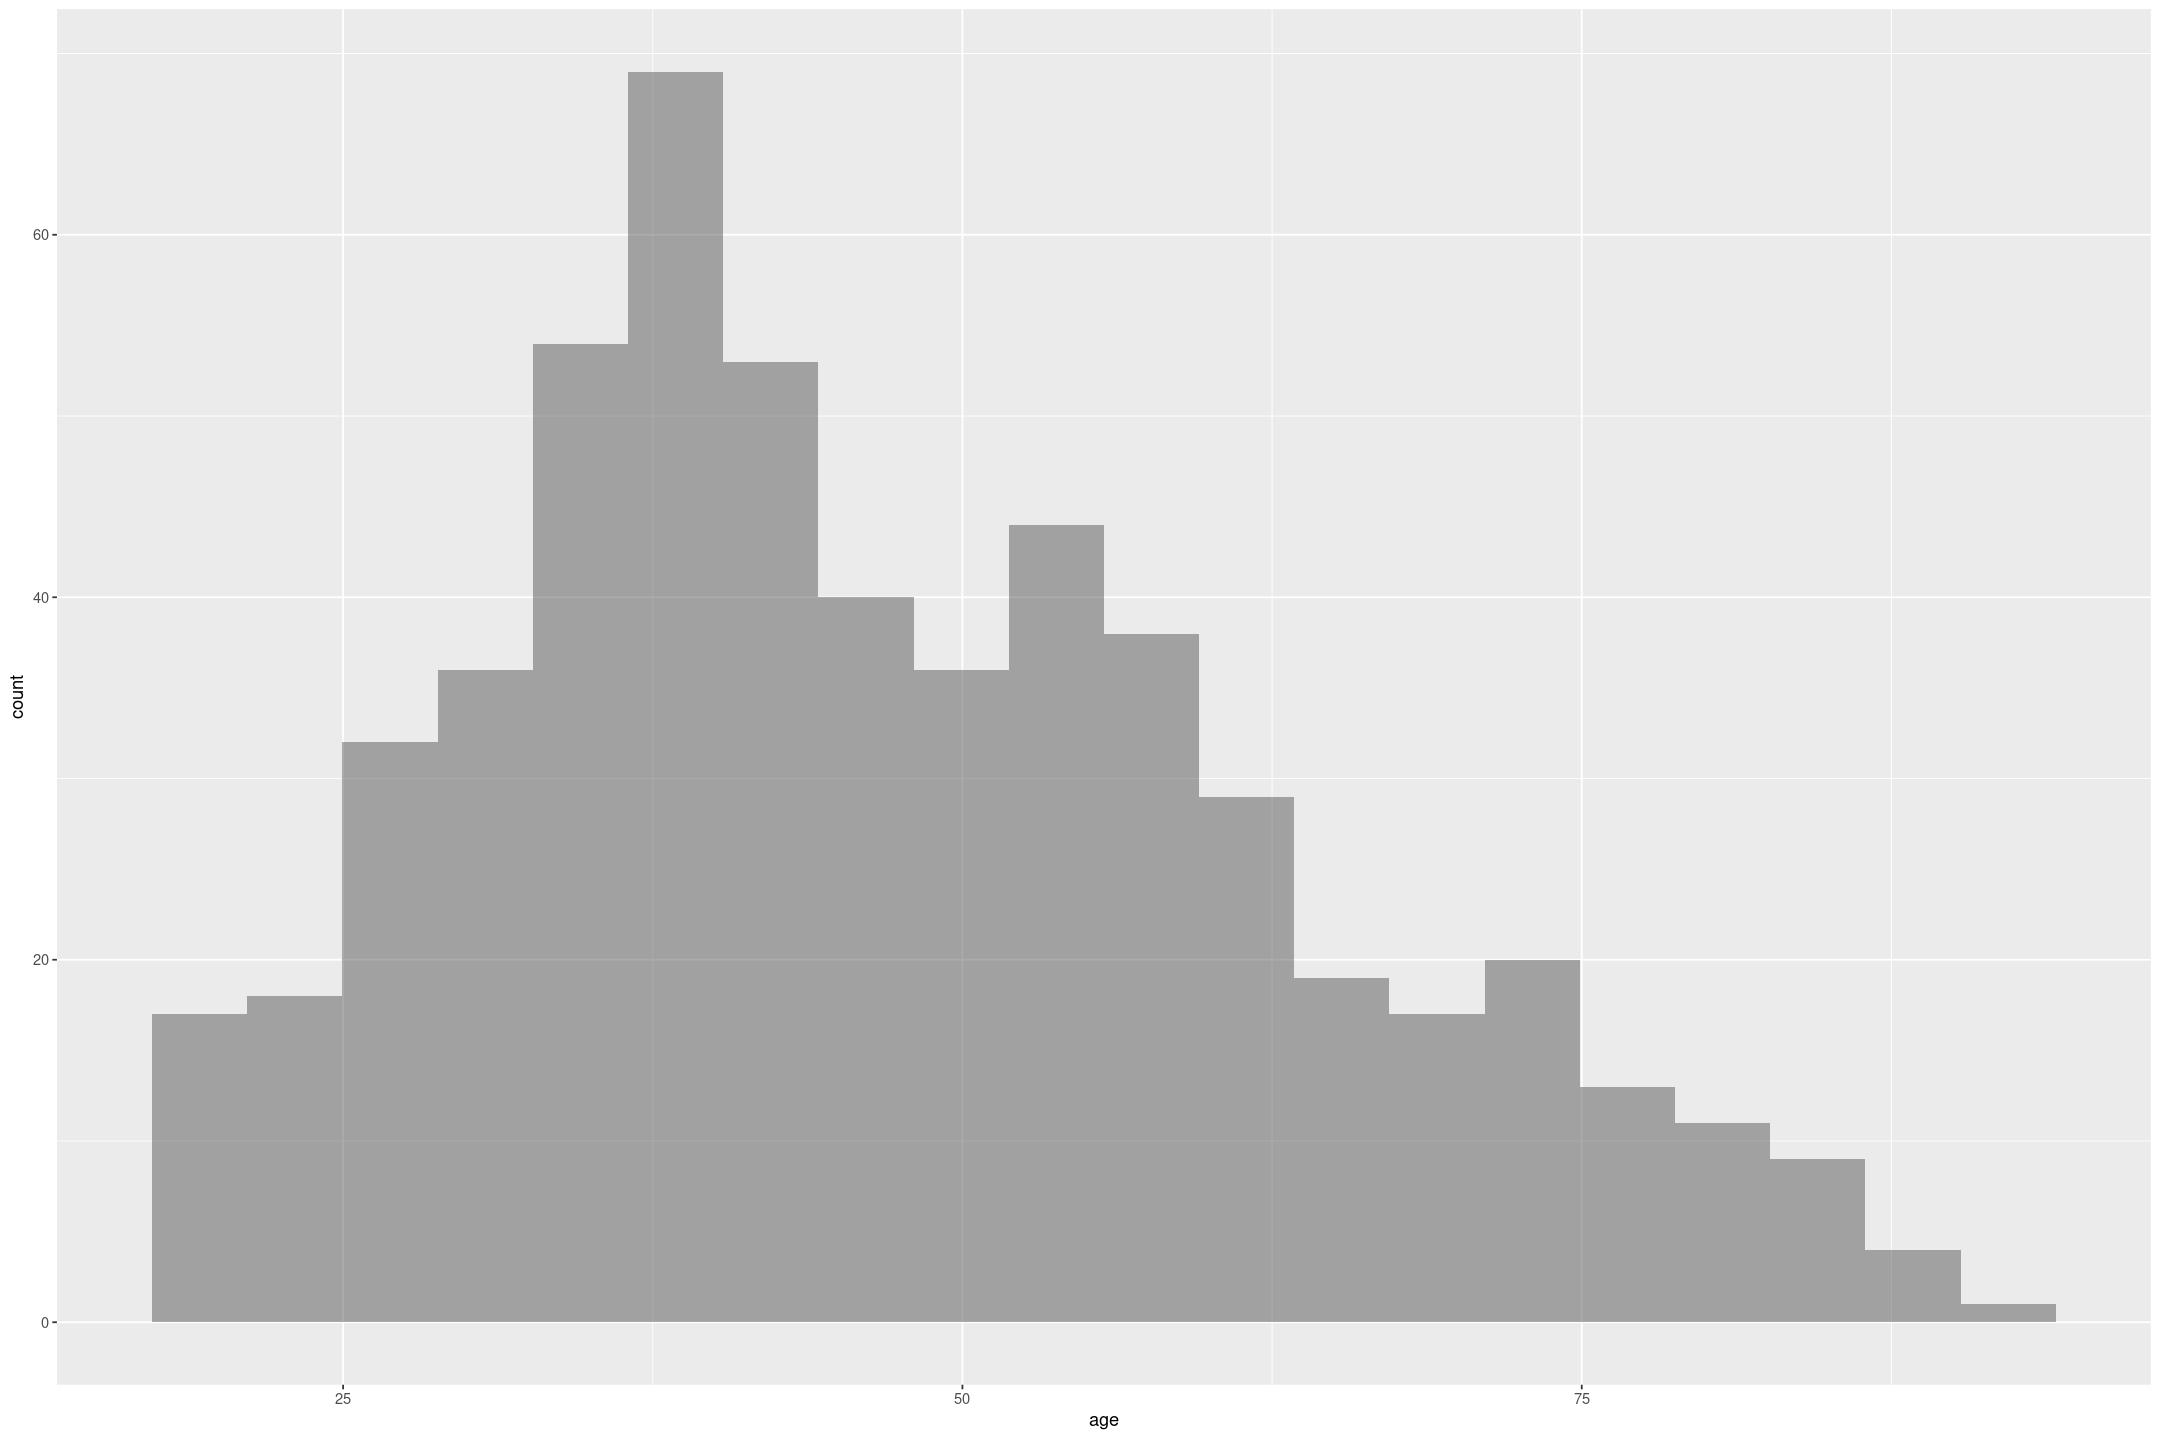

In [84]:
nes2000_na %>% gf_histogram(~age, bins=20)

In [85]:
nes2000_na %>% count(partyid7)

partyid7                   n  
1 1. strong democrat         132
2 2. weak democrat            81
3 3. independent-democrat     82
4 4. independent-independent  43
5 5. independent-republican   74
6 6. weak republican          73
7 7. strong republican        75

We see different behaviours in different age groups - it's not monotonic with age.

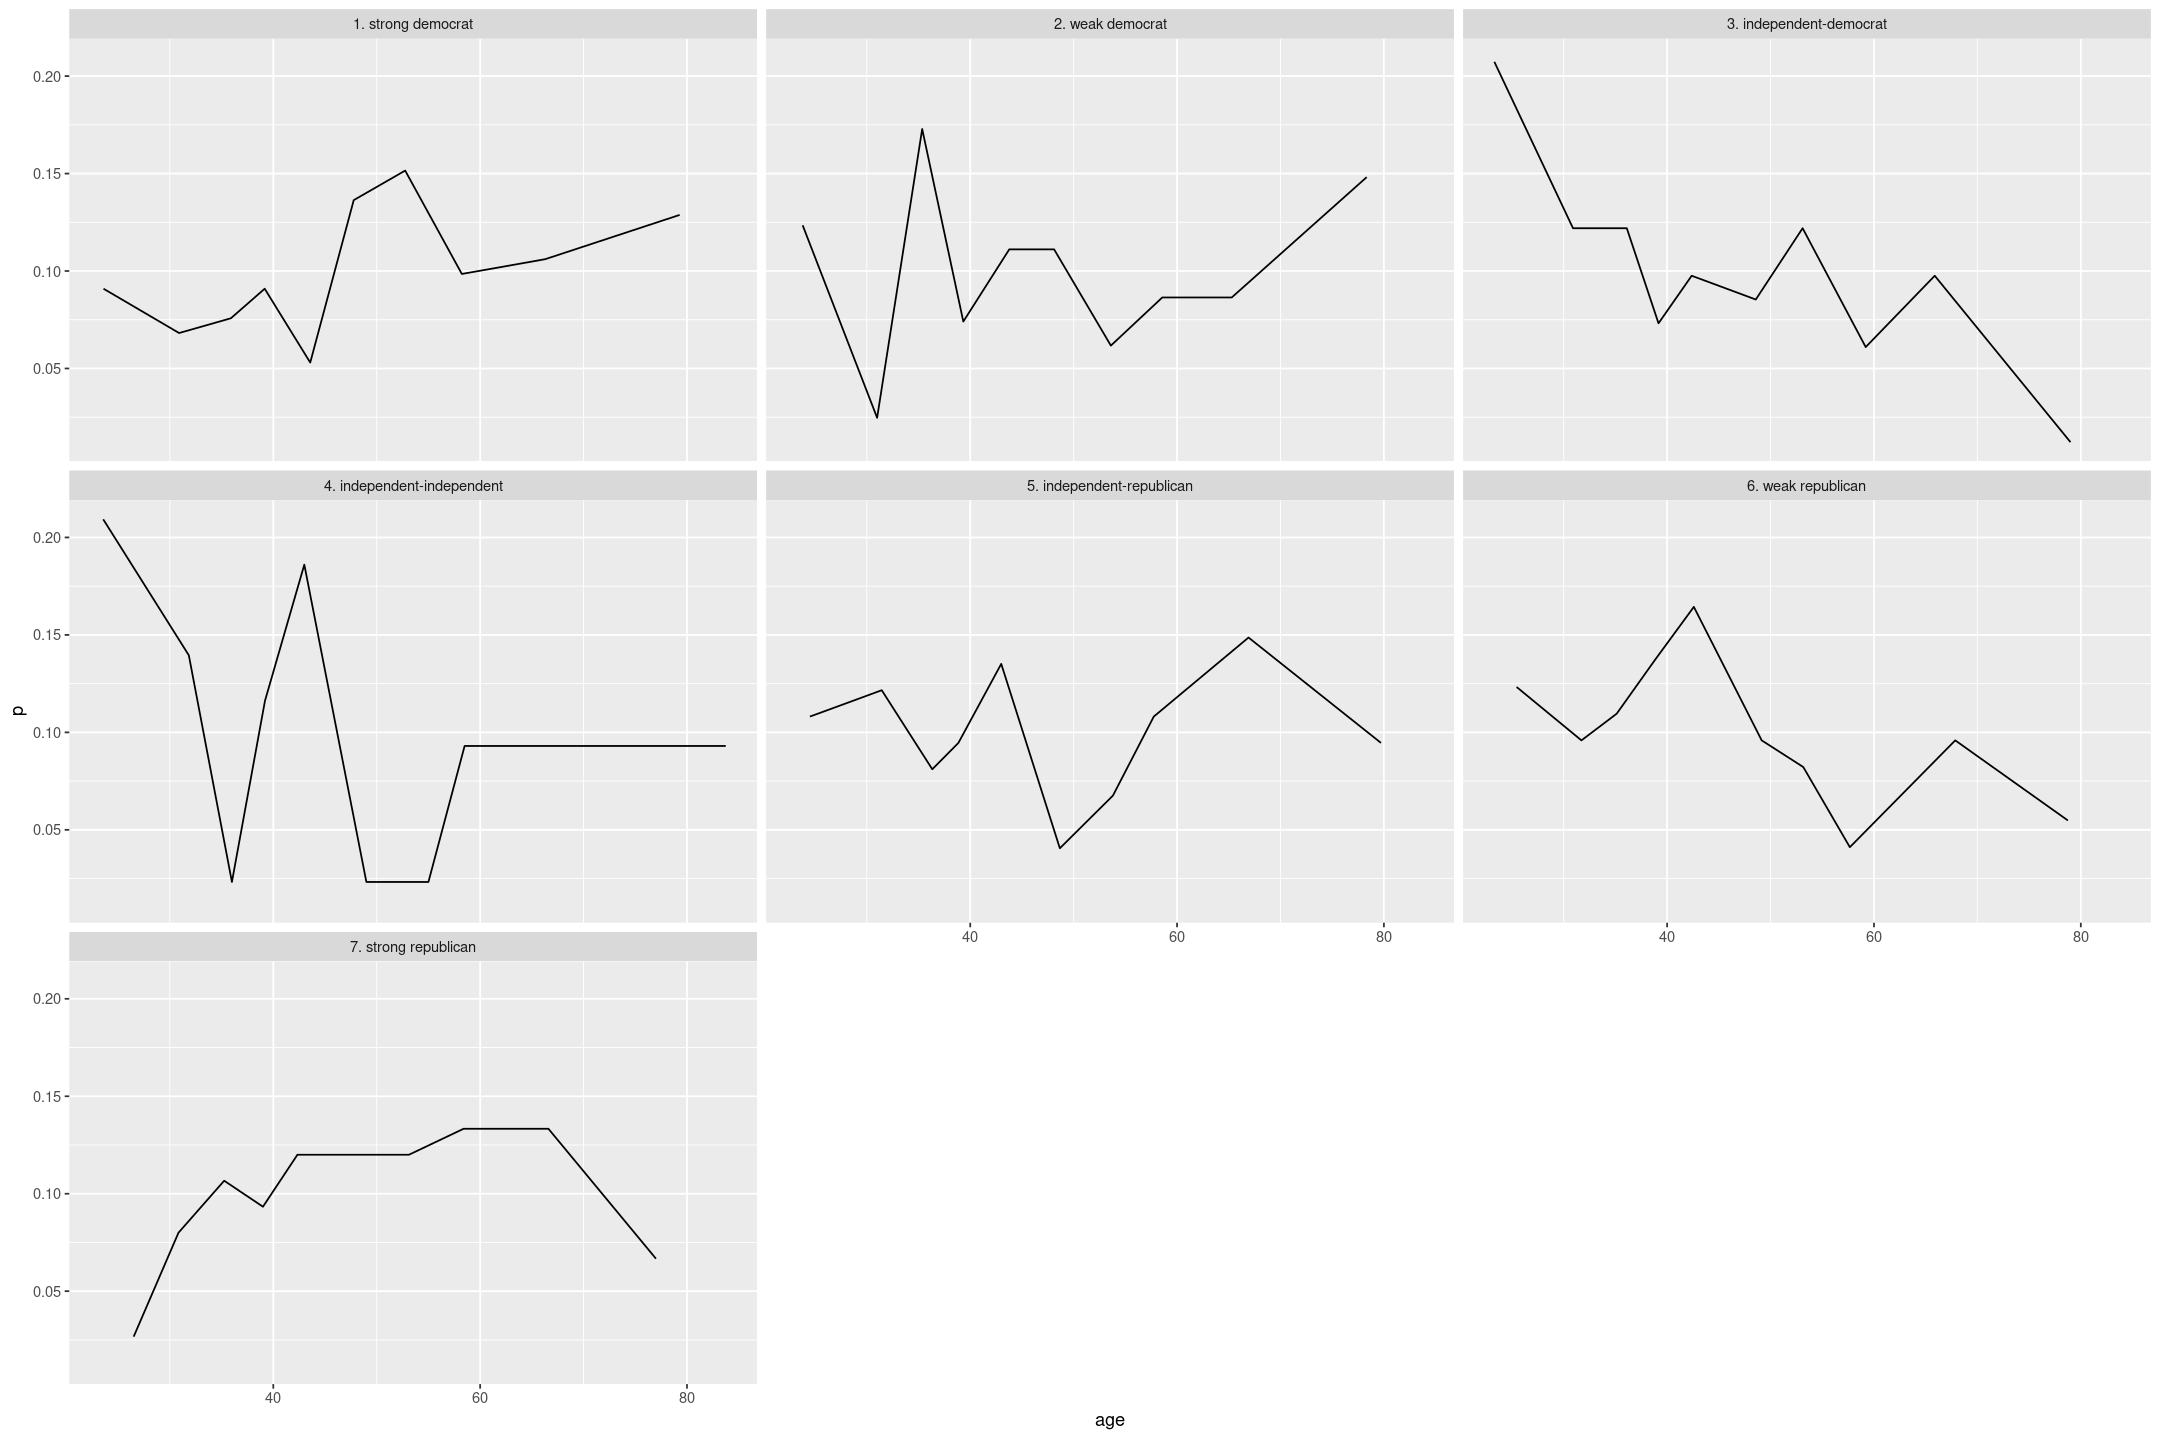

In [86]:
nes2000_na %>% 
group_by(partyid7, bin=cut_quantile(age, 10)) %>%
summarise(n=n(), age=mean(age), .groups="drop_last") %>%
mutate(p = n/sum(n)) %>%
gf_line(p ~ age | partyid7)

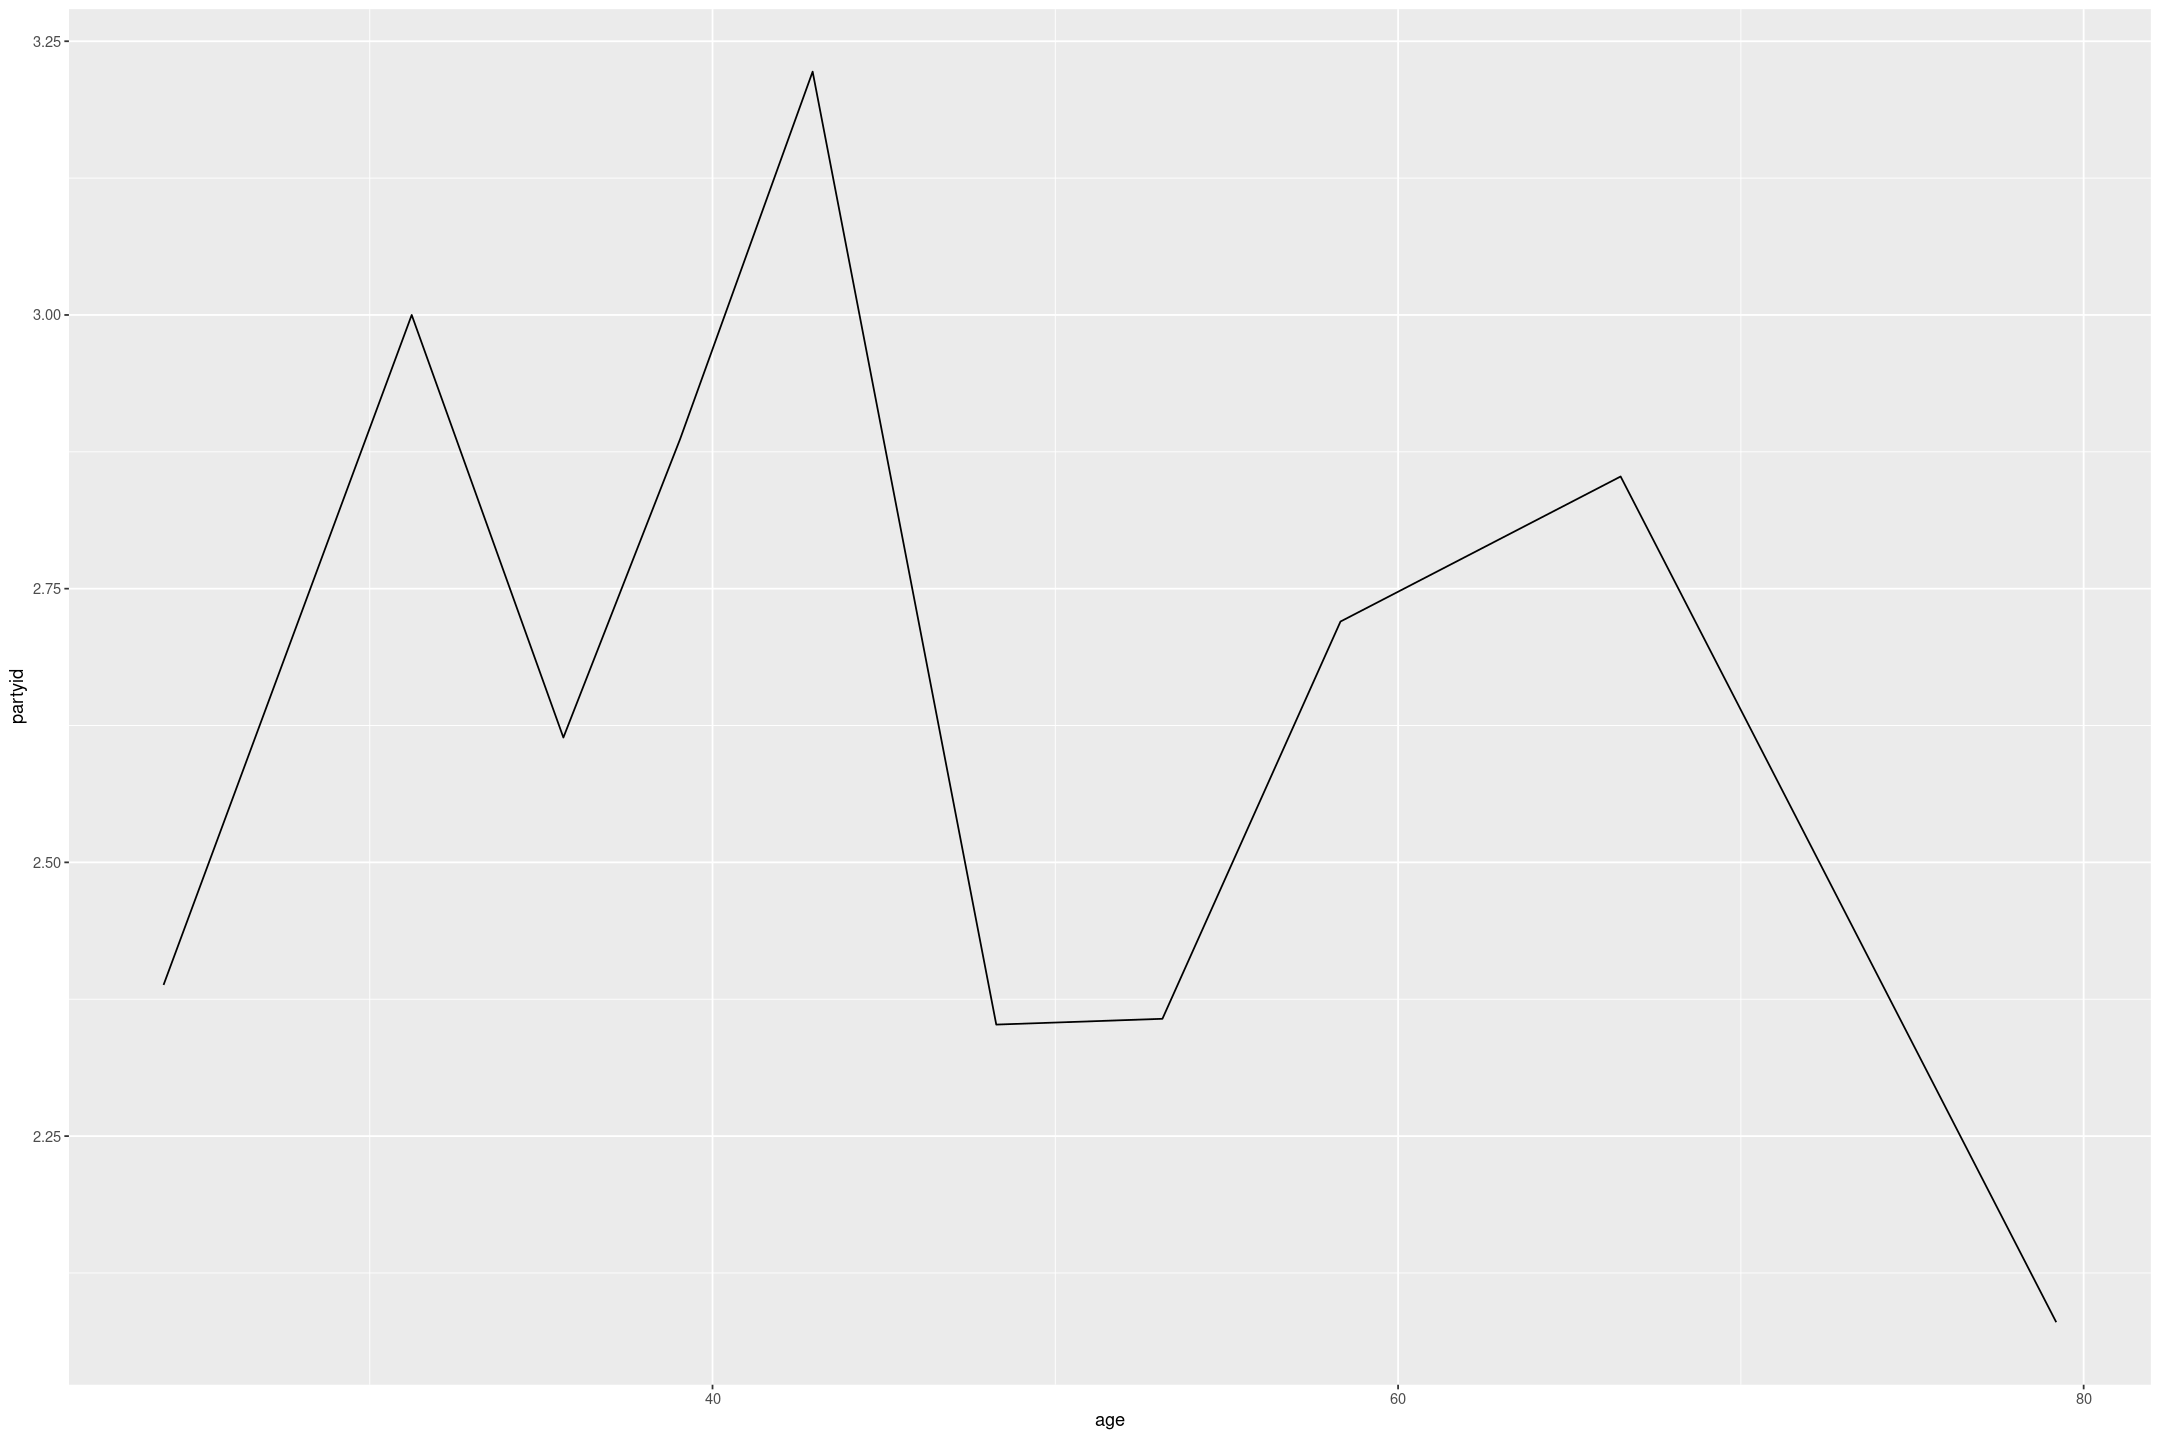

In [87]:
nes2000_na %>%
mutate(partyid_cts =  as.integer(partyid7) - 1) %>%
group_by(bin=cut_quantile(age, 10)) %>%
summarise(n=n(), age=mean(age), partyid=mean(partyid_cts)) %>%
gf_line(partyid ~ age)

As in 13.1, we'll use age groups

In [88]:
nes2000_na <- nes2000_na %>%
mutate(age_group = cut(age, c(0, 30, 40, 50, 64, Inf), right=FALSE, labels=c('18-29', '30-39', '40-49', '50-64', '65+')),
       age30_39 = as.integer(age_group == '30-39'),
       age40_49 = as.integer(age_group == '40-49'),
       age50_64 = as.integer(age_group == '50-64'),
       age65up = as.integer(age_group == '65+'))

In [89]:
nes2000_na %>%
group_by(age_group, age30_39, age40_49, age50_64, age65up) %>%
summarise(min=min(age), max=max(age), n=n(), .groups="drop")

age_group age30_39 age40_49 age50_64 age65up min max n  
1 18-29     0        0        0        0       18  29   72
2 30-39     1        0        0        0       30  39  136
3 40-49     0        1        0        0       40  49  120
4 50-64     0        0        1        0       50  63  138
5 65+       0        0        0        1       64  91   94

#### Gender

In [90]:
nes2000_na %>% count(gender)

gender    n  
1 1. male   248
2 2. female 312

`stan_polr` isn't smart enough to create factors, so we'll have create our own binary coding.


Running

```R
stan_polr(partyid7 ~ gender,
          data=nes2000_na,
          prior=R2(0.3, "mean"),
          refresh=0)
```

Results in

```
Error in qr.solve(decomposition, Q): singular matrix 'a' in solve
Traceback:

1. stan_polr(partyid7 ~ gender, data = nes2000_na, prior = R2(0.3, 
 .     "mean"), refresh = 0)
2. stan_polr.fit(x = x, y = y, wt = wt, offset = offset, method = method, 
 .     prior = prior, prior_counts = prior_counts, shape = shape, 
 .     rate = rate, prior_PD = prior_PD, algorithm = algorithm, 
 .     adapt_delta = adapt_delta, do_residuals = do_residuals, ...)
3. qr.solve(decomposition, Q)
4. stop("singular matrix 'a' in solve")
```

In [91]:
nes2000_na <- nes2000_na %>% mutate(male = as.integer(gender == '1. male'))
nes2000_na %>% count(gender, male)

gender    male n  
1 1. male   1    248
2 2. female 0    312

And then we can fit it

In [92]:
stan_polr(partyid7 ~ male,
          data=nes2000_na,
          prior=R2(0.3, "mean"),
          refresh=0)

stan_polr
 family:       ordered [logistic]
 formula:      partyid7 ~ male
 observations: 560
------
     Median MAD_SD
male 0.5    0.1   

Cutpoints:
                                                     Median MAD_SD
1. strong democrat|2. weak democrat                  -1.0    0.1  
2. weak democrat|3. independent-democrat             -0.3    0.1  
3. independent-democrat|4. independent-independent    0.3    0.1  
4. independent-independent|5. independent-republican  0.6    0.1  
5. independent-republican|6. weak republican          1.3    0.1  
6. weak republican|7. strong republican               2.1    0.1  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

#### Race

Race is problematic, with only 12 asian and 25 native american we're better off converting it to binary indicators

In [93]:
nes2000_na %>% count(race)

race               n  
1 1. white           417
2 2. black            63
3 3. asian            12
4 4. native american  25
5 5. hispanic         43

We leave white as the default race because it's the most common in the data

In [94]:
nes2000_na <- nes2000_na %>%
mutate(black = as.integer(race == '2. black'),
       hispanic = as.integer(race == '5. hispanic'),
       native_american_or_asian = as.integer(race %in% c('4. native american', '3. asian')))

In [95]:
nes2000_na %>%
count(race, black, hispanic, native_american_or_asian)

race               black hispanic native_american_or_asian n  
1 1. white           0     0        0                        417
2 2. black           1     0        0                         63
3 3. asian           0     0        1                         12
4 4. native american 0     0        1                         25
5 5. hispanic        0     1        0                         43

#### Income

Let's turn it into a numerical predictor, standardising it

In [96]:
nes2000_na %>% count(income)

income                  n  
1 1. 0 to 16 percentile    73
2 2. 17 to 33 percentile  120
3 3. 34 to 67 percentile  180
4 4. 68 to 95 percentile  150
5 5. 96 to 100 percentile  37

In [97]:
nes2000_na <- nes2000_na %>% mutate(income_std = (as.integer(income) - 4)/4)

In [98]:
nes2000_na %>% count(income, income_std)

income                  income_std n  
1 1. 0 to 16 percentile   -0.50       73
2 2. 17 to 33 percentile  -0.25      120
3 3. 34 to 67 percentile   0.00      180
4 4. 68 to 95 percentile   0.25      150
5 5. 96 to 100 percentile  0.50       37

#### Idoelogy

Let's turn it into a numerical predictor, standardising it

In [99]:
nes2000_na %>% count(ideo7)

ideo7                           n  
1 1. extremely liberal              6
2 2. liberal                       77
3 3. slightly liberal              59
4 4. moderate, middle of the road 167
5 5. slightly conservative         84
6 6. conservative                 148
7 7. extremely conservative        19

In [100]:
nes2000_na <- nes2000_na %>% mutate(ideo_std = (as.integer(ideo7) - 5)/6)

In [101]:
nes2000_na %>% count(ideo_std, ideo7)

ideo_std   ideo7                           n  
1 -0.5000000 1. extremely liberal              6
2 -0.3333333 2. liberal                       77
3 -0.1666667 3. slightly liberal              59
4  0.0000000 4. moderate, middle of the road 167
5  0.1666667 5. slightly conservative         84
6  0.3333333 6. conservative                 148
7  0.5000000 7. extremely conservative        19

### Fitting model

We need to pick a prior, in the text they use `R2(0.3, "mean")` without much explanation.

From the help for `stan_polr`

> In this case, the 𝑅2 pertains to the proportion of variance in the latent variable (which is discretized by the cutpoints) attributable to the predictors in the model. 

From the help for `R2`

> R2(location, what)

> The stan_lm, stan_aov, and stan_polr functions allow the user to utilize a function called R2 to convey prior information about all the parameters. This prior hinges on prior beliefs about the location of 𝑅2
, the proportion of variance in the outcome attributable to the predictors, which has a Beta prior with first shape hyperparameter equal to half the number of predictors and second shape hyperparameter free. By specifying what to be the prior mode (the default), mean, median, or expected log of 𝑅2, the second shape parameter for this Beta distribution is determined internally. If what = 'log', location should be a negative scalar; otherwise it should be a scalar on the (0,1) interval.
>
> For example, if 𝑅2=0.5
, then the mode, mean, and median of the Beta distribution are all the same and thus the second shape parameter is also equal to half the number of predictors. The second shape parameter of the Beta distribution is actually the same as the shape parameter in the LKJ prior for a correlation matrix described in the previous subsection. Thus, the smaller is 𝑅2, the larger is the shape parameter, the smaller are the prior correlations among the outcome and predictor variables, and the more concentrated near zero is the prior density for the regression coefficients. Hence, the prior on the coefficients is regularizing and should yield a posterior distribution with good out-of-sample predictions if the prior location of 𝑅2 is specified in a reasonable fashion. 

To be honest I don't know how much I'd expect to be explained, 30% doesn't sound crazy.

In [102]:
fit_nes_partyid <- stan_polr(partyid7 ~ 
                             age30_39 + age40_49 + age50_64 + age65up +
                             male + 
                             black + hispanic + native_american_or_asian +
                             income_std + 
                             ideo_std,
                             data=nes2000_na,
                             prior=R2(0.3, "mean"),
                             refresh=0)

## Parameter estimates
Summarise the parameter estimates numerically and also graphically

In [103]:
fit_nes_partyid

stan_polr
 family:       ordered [logistic]
 formula:      partyid7 ~ age30_39 + age40_49 + age50_64 + age65up + male + 
	   black + hispanic + native_american_or_asian + income_std + 
	   ideo_std
 observations: 560
------
                         Median MAD_SD
age30_39                 -0.5    0.3  
age40_49                 -0.5    0.3  
age50_64                 -0.7    0.3  
age65up                  -0.7    0.3  
male                      0.2    0.1  
black                    -1.4    0.2  
hispanic                 -0.5    0.3  
native_american_or_asian -0.1    0.3  
income_std                1.0    0.3  
ideo_std                  3.5    0.3  

Cutpoints:
                                                     Median MAD_SD
1. strong democrat|2. weak democrat                  -1.9    0.3  
2. weak democrat|3. independent-democrat             -1.1    0.2  
3. independent-democrat|4. independent-independent   -0.3    0.2  
4. independent-independent|5. independent-republican  0.1    0.2  


The particular parameterisation here is equation 15.10:


Under this model $ y_i = k $ if $z_i \in (c_{k-1\vert k}, c_{k\vert k+1}] $, where $z_i = \beta x_i + \epsilon_i $ and $\epsilon_i \sim {\rm logistic}(0, 1)$ (in the text they use an open interval, but I'm arbitrarily deciding the edge case).
For this to work we take the special cases $c_{0,1} = -\infty$ and $c_{n,n+1} = \infty$ where $n$ is the total number of categories.

So $ y_i = k $ when $\epsilon_i \in  [c_{k-1\vert k} - \beta x_i, c_{k\vert k+1} - \beta x_i)$.

Now given that 
$$ {\rm Pr}(\epsilon_i \le x) = {\rm logit}^{-1}(x) = \frac{\exp(x)}{1 + \exp(x)} $$
then 
$$\begin{align} {\rm Pr}(y_i = k) &= {\rm Pr}(\epsilon_i \in (c_{k-1\vert k} - \beta x_i, c_{k\vert k+1} - \beta x_i])\\ & =  {\rm Pr}(\epsilon_i \le c_{k\vert k+1} - \beta x_i) - {\rm Pr}(\epsilon_i \le c_{k-1\vert k} - \beta x_i) \\
 & = {\rm logit}^{-1}(c_{k\vert k+1} - \beta x_i) - {\rm logit}^{-1}(c_{k-1\vert k} - \beta x_i)
\end{align}$$

We can extract the cutpoints from the matrix

In [104]:
cutpoints_df <- (fit_nes_partyid %>%
as.data.frame() %>%
select(matches('^[1-9]\\..*\\|')) %>%
summarise_all(median) %>%
pivot_longer(everything())
 )
cutpoints <- cutpoints_df$value
names(cutpoints) <- cutpoints_df$name
cutpoints

1. strong democrat|2. weak democrat 
                                          -1.9066277 
            2. weak democrat|3. independent-democrat 
                                          -1.0634516 
  3. independent-democrat|4. independent-independent 
                                          -0.3091470 
4. independent-independent|5. independent-republican 
                                           0.0934077 
        5. independent-republican|6. weak republican 
                                           0.8374109 
             6. weak republican|7. strong republican 
                                           1.8163310

Or using zeta

In [105]:
(cutpoints <- fit_nes_partyid$zeta)

1. strong democrat|2. weak democrat 
                                          -1.9066277 
            2. weak democrat|3. independent-democrat 
                                          -1.0634516 
  3. independent-democrat|4. independent-independent 
                                          -0.3091470 
4. independent-independent|5. independent-republican 
                                           0.0934077 
        5. independent-republican|6. weak republican 
                                           0.8374109 
             6. weak republican|7. strong republican 
                                           1.8163310

For the case of an under 30 year old, white, female with a typical income and ideology:

In [106]:
partyid_names <- levels(nes2000_na$partyid7)

Let's add some logic to get out the names from the cutpoints

In [107]:
get_names_from_cutpoints <- function(n) {
    name_pairs <- str_extract_all(n, '[^|]+', simplify=TRUE)
    if (ncol(name_pairs) != 2) {
        stop("Expected 2 columns")
    }
    
    first_names <- name_pairs[,1]
    second_names <- name_pairs[,2]
    
    if (!all(first_names[2:nrow(name_pairs)] == second_names[1:nrow(name_pairs) - 1])) {
        stop("Names don't align")
    }
    
    c(first_names, second_names[length(second_names)])
}

And test that it works

In [108]:
get_names_from_cutpoints(c("a|b", "b|c", "c|d"))

[1] "a" "b" "c" "d"

In [109]:
get_names_from_cutpoints(c("a|b"))

[1] "a" "b"

Check the failing cases

In [110]:
try(
get_names_from_cutpoints(c("a|b", "c|d"))
    )

Error in get_names_from_cutpoints(c("a|b", "c|d")) : Names don't align


In [111]:
try(
get_names_from_cutpoints(c("a", "c"))
    )

Error in get_names_from_cutpoints(c("a", "c")) : Expected 2 columns


Then we can use it to get probabilities

In [112]:
get_probs_1 <- function(cutpoints, offset=0) {
  cprobs <- c(0, invlogit(cutpoints - offset), 1)
  names(cprobs) <- NULL
  probs <- cprobs[2:length(cprobs)] - cprobs[1:length(cprobs) - 1]
  names(probs) <- get_names_from_cutpoints(names(cutpoints)) 
  probs
}

For the case of an under 30 year old, white, female with a typical income and neutral ideology:

In [113]:
get_probs_1(cutpoints) %>% scales::percent(1)

1. strong democrat           2. weak democrat 
                     "13%"                      "13%" 
   3. independent-democrat 4. independent-independent 
                     "17%"                      "10%" 
 5. independent-republican         6. weak republican 
                     "17%"                      "16%" 
      7. strong republican 
                     "14%"

For the case of an under 30 year old, white, female with a typical income and strong conservative ideology:

In [114]:
get_probs_1(cutpoints, 3.5) %>% scales::percent(1)

1. strong democrat           2. weak democrat 
                      "0%"                       "1%" 
   3. independent-democrat 4. independent-independent 
                      "1%"                       "1%" 
 5. independent-republican         6. weak republican 
                      "3%"                       "9%" 
      7. strong republican 
                     "84%"

In [115]:
get_probs <- function(cutpoints, offset=0) {
  ncol <- length(offset)
  nrow <- length(cutpoints)  
    
  cprobs <- invlogit(matrix(rep(cutpoints, ncol), ncol=ncol) - matrix(rep(offset, nrow), ncol=ncol, byrow=TRUE))
  cprobs <- rbind(rep(0, ncol), cprobs, rep(1, ncol))  
    
  probs <- cprobs[2:nrow(cprobs),] - cprobs[1:nrow(cprobs)-1,]
  probs <- matrix(probs, ncol=ncol)
  
  rownames(probs) <- get_names_from_cutpoints(names(cutpoints)) 
  colnames(probs) <- names(offset)
  t(probs)
}

In [116]:
get_probs(cutpoints, 0)

1. strong democrat 2. weak democrat 3. independent-democrat
[1,] 0.1293602          0.1272902        0.1666725              
     4. independent-independent 5. independent-republican 6. weak republican
[1,] 0.100012                   0.1745847                 0.1622056         
     7. strong republican
[1,] 0.1398747

In [117]:
get_probs(cutpoints, c(x=0,y=0.5))

1. strong democrat 2. weak democrat 3. independent-democrat
x 0.12936018         0.12729023       0.1666725              
y 0.08266869         0.09048324       0.1349204              
  4. independent-independent 5. independent-republican 6. weak republican
x 0.10001200                 0.1745847                 0.1622056         
y 0.09165721                 0.1838320                 0.2050092         
  7. strong republican
x 0.1398747           
y 0.2114294

Then we can combine it with predictions

The response isn't actually useful here - what's 0.5 mean?

In [118]:
predict(fit_nes_partyid, type="response", 
        newdata=data.frame(age30_39=0, age40_49=0, age50_64=0, age65up=0,
                  male=0,
                  black=0, hispanic=0, native_american_or_asian=0,
                           income_std=0, ideo_std=0))

1 
0.5

We can use the link function to get the probabilities

In [119]:
predict(fit_nes_partyid, type="link", 
        newdata=data.frame(age30_39=0, age40_49=0, age50_64=0, age65up=0,
                  male=0,
                  black=0, hispanic=0, native_american_or_asian=0,
                           income_std=0, ideo_std=0))

1 
0

And combine our predictions with the original data.

In [120]:
cbind(nes2000_na, get_probs(cutpoints, predict(fit_nes_partyid))) %>% head()

partyid7                age gender    race     income                
38531 3. independent-democrat 63  1. male   1. white 3. 34 to 67 percentile
38532 7. strong republican    40  2. female 1. white 3. 34 to 67 percentile
38534 6. weak republican      43  1. male   1. white 4. 68 to 95 percentile
38535 1. strong democrat      47  2. female 1. white 3. 34 to 67 percentile
38537 1. strong democrat      48  2. female 1. white 3. 34 to 67 percentile
38538 3. independent-democrat 37  1. male   1. white 2. 17 to 33 percentile
      ideo7                           age_group age30_39 age40_49 age50_64
38531 5. slightly conservative        50-64     0        0        1       
38532 6. conservative                 40-49     0        1        0       
38534 4. moderate, middle of the road 40-49     0        1        0       
38535 3. slightly liberal             40-49     0        1        0       
38537 2. liberal                      40-49     0        1        0       
38538 4. moderate, middle of the road 30-39     1        0        0       
      age65up male black hispanic native_american_or_asian income_std
38531 0       1    0     0        0                         0.00     
38532 0       0    0     0        0                         0.00     
38534 0       1    0     0        0                         0.25     
38535 0       0    0     0        0                         0.00     
38537 0       0    0     0        0                         0.00     
38538 0       1    0     0        0                        -0.25     
      ideo_std   1. strong democrat 2. weak democrat 3. independent-democrat
38531  0.1666667 0.11911781         0.11997952       0.1614152              
38532  0.3333333 0.06836395         0.07731269       0.1204009              
38534  0.0000000 0.12891457         0.12698062       0.1664608              
38535 -0.1666667 0.30126581         0.19920888       0.1800542              
38537 -0.3333333 0.43757631         0.20628700       0.1496897              
38538  0.0000000 0.20229069         0.16849158       0.1853408              
      4. independent-independent 5. independent-republican 6. weak republican
38531 0.09929364                 0.1778951                 0.17070401        
38532 0.08551167                 0.1813486                 0.21935206        
38534 0.09999048                 0.1747372                 0.16256429        
38535 0.08057810                 0.1090968                 0.07672969        
38537 0.05827759                 0.0718215                 0.04622711        
38538 0.09591208                 0.1456680                 0.11530423        
      7. strong republican
38531 0.15159472          
38532 0.24771019          
38534 0.14035210          
38535 0.05306659          
38537 0.03012084          
38538 0.08699266

We can view an individual prediction as a bar chart.
Interestingly you can see the polarization - it's unlikelt they are actually independent.

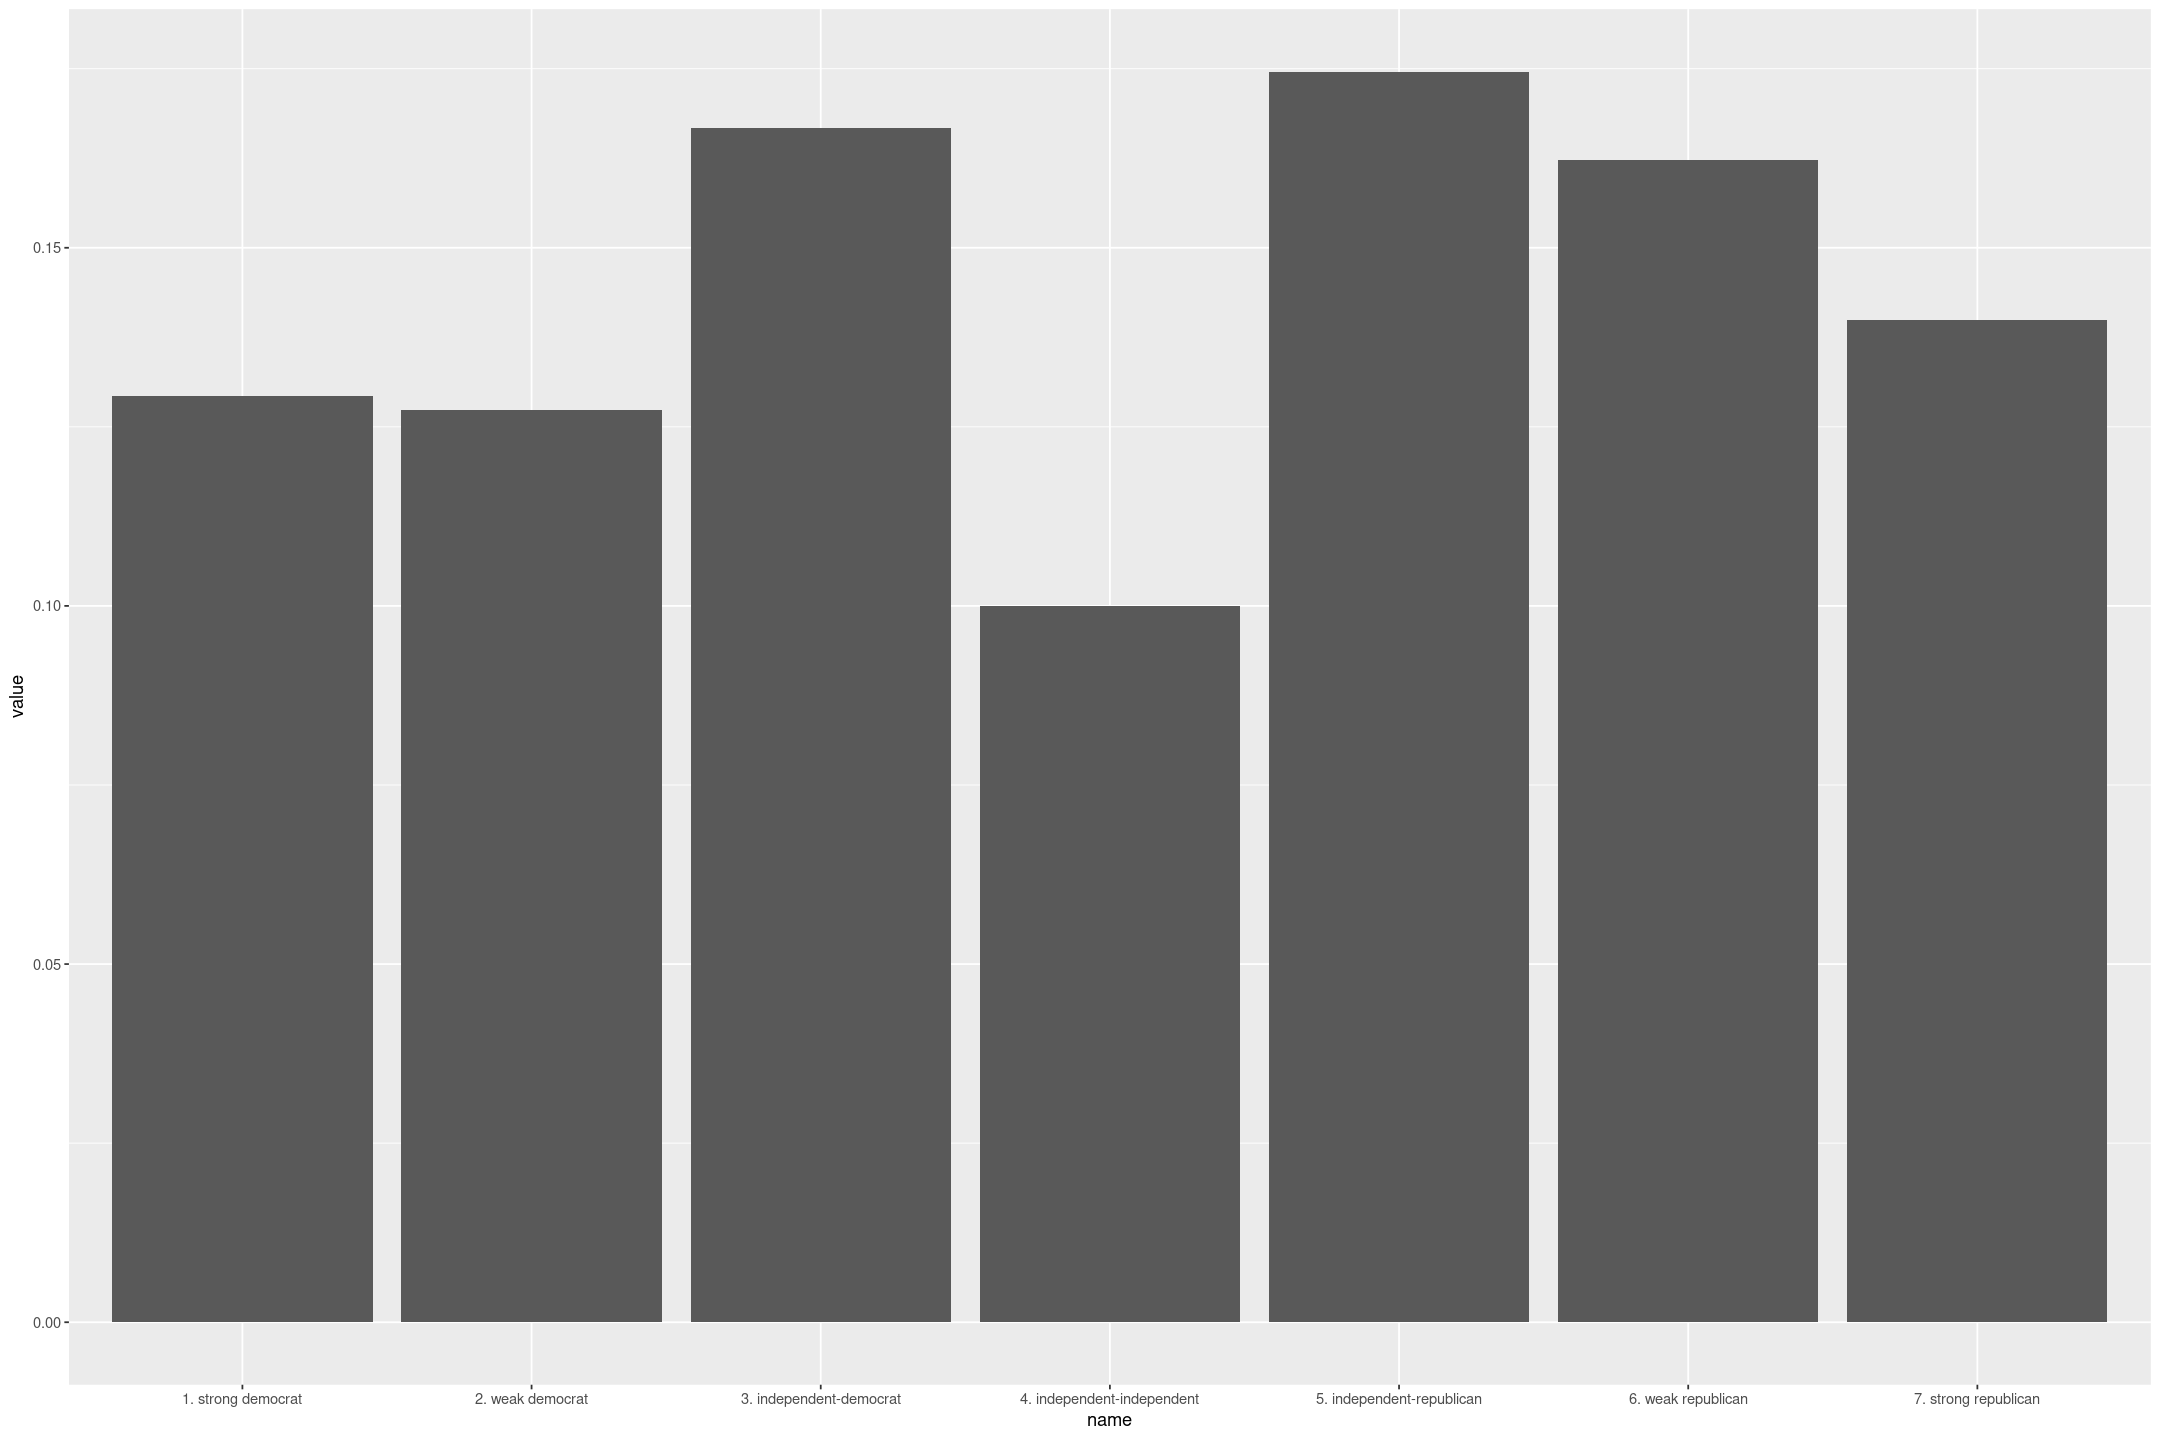

In [121]:
get_probs(cutpoints, 0) %>%
as.data.frame() %>%
pivot_longer(everything()) %>%
gf_col(value~name)

In [122]:
nes2000_na %>% count(ideo_std, ideo7)

ideo_std   ideo7                           n  
1 -0.5000000 1. extremely liberal              6
2 -0.3333333 2. liberal                       77
3 -0.1666667 3. slightly liberal              59
4  0.0000000 4. moderate, middle of the road 167
5  0.1666667 5. slightly conservative         84
6  0.3333333 6. conservative                 148
7  0.5000000 7. extremely conservative        19

For displaying multiple coefficients a stacked barchard works (although the colours are a bit harsh).

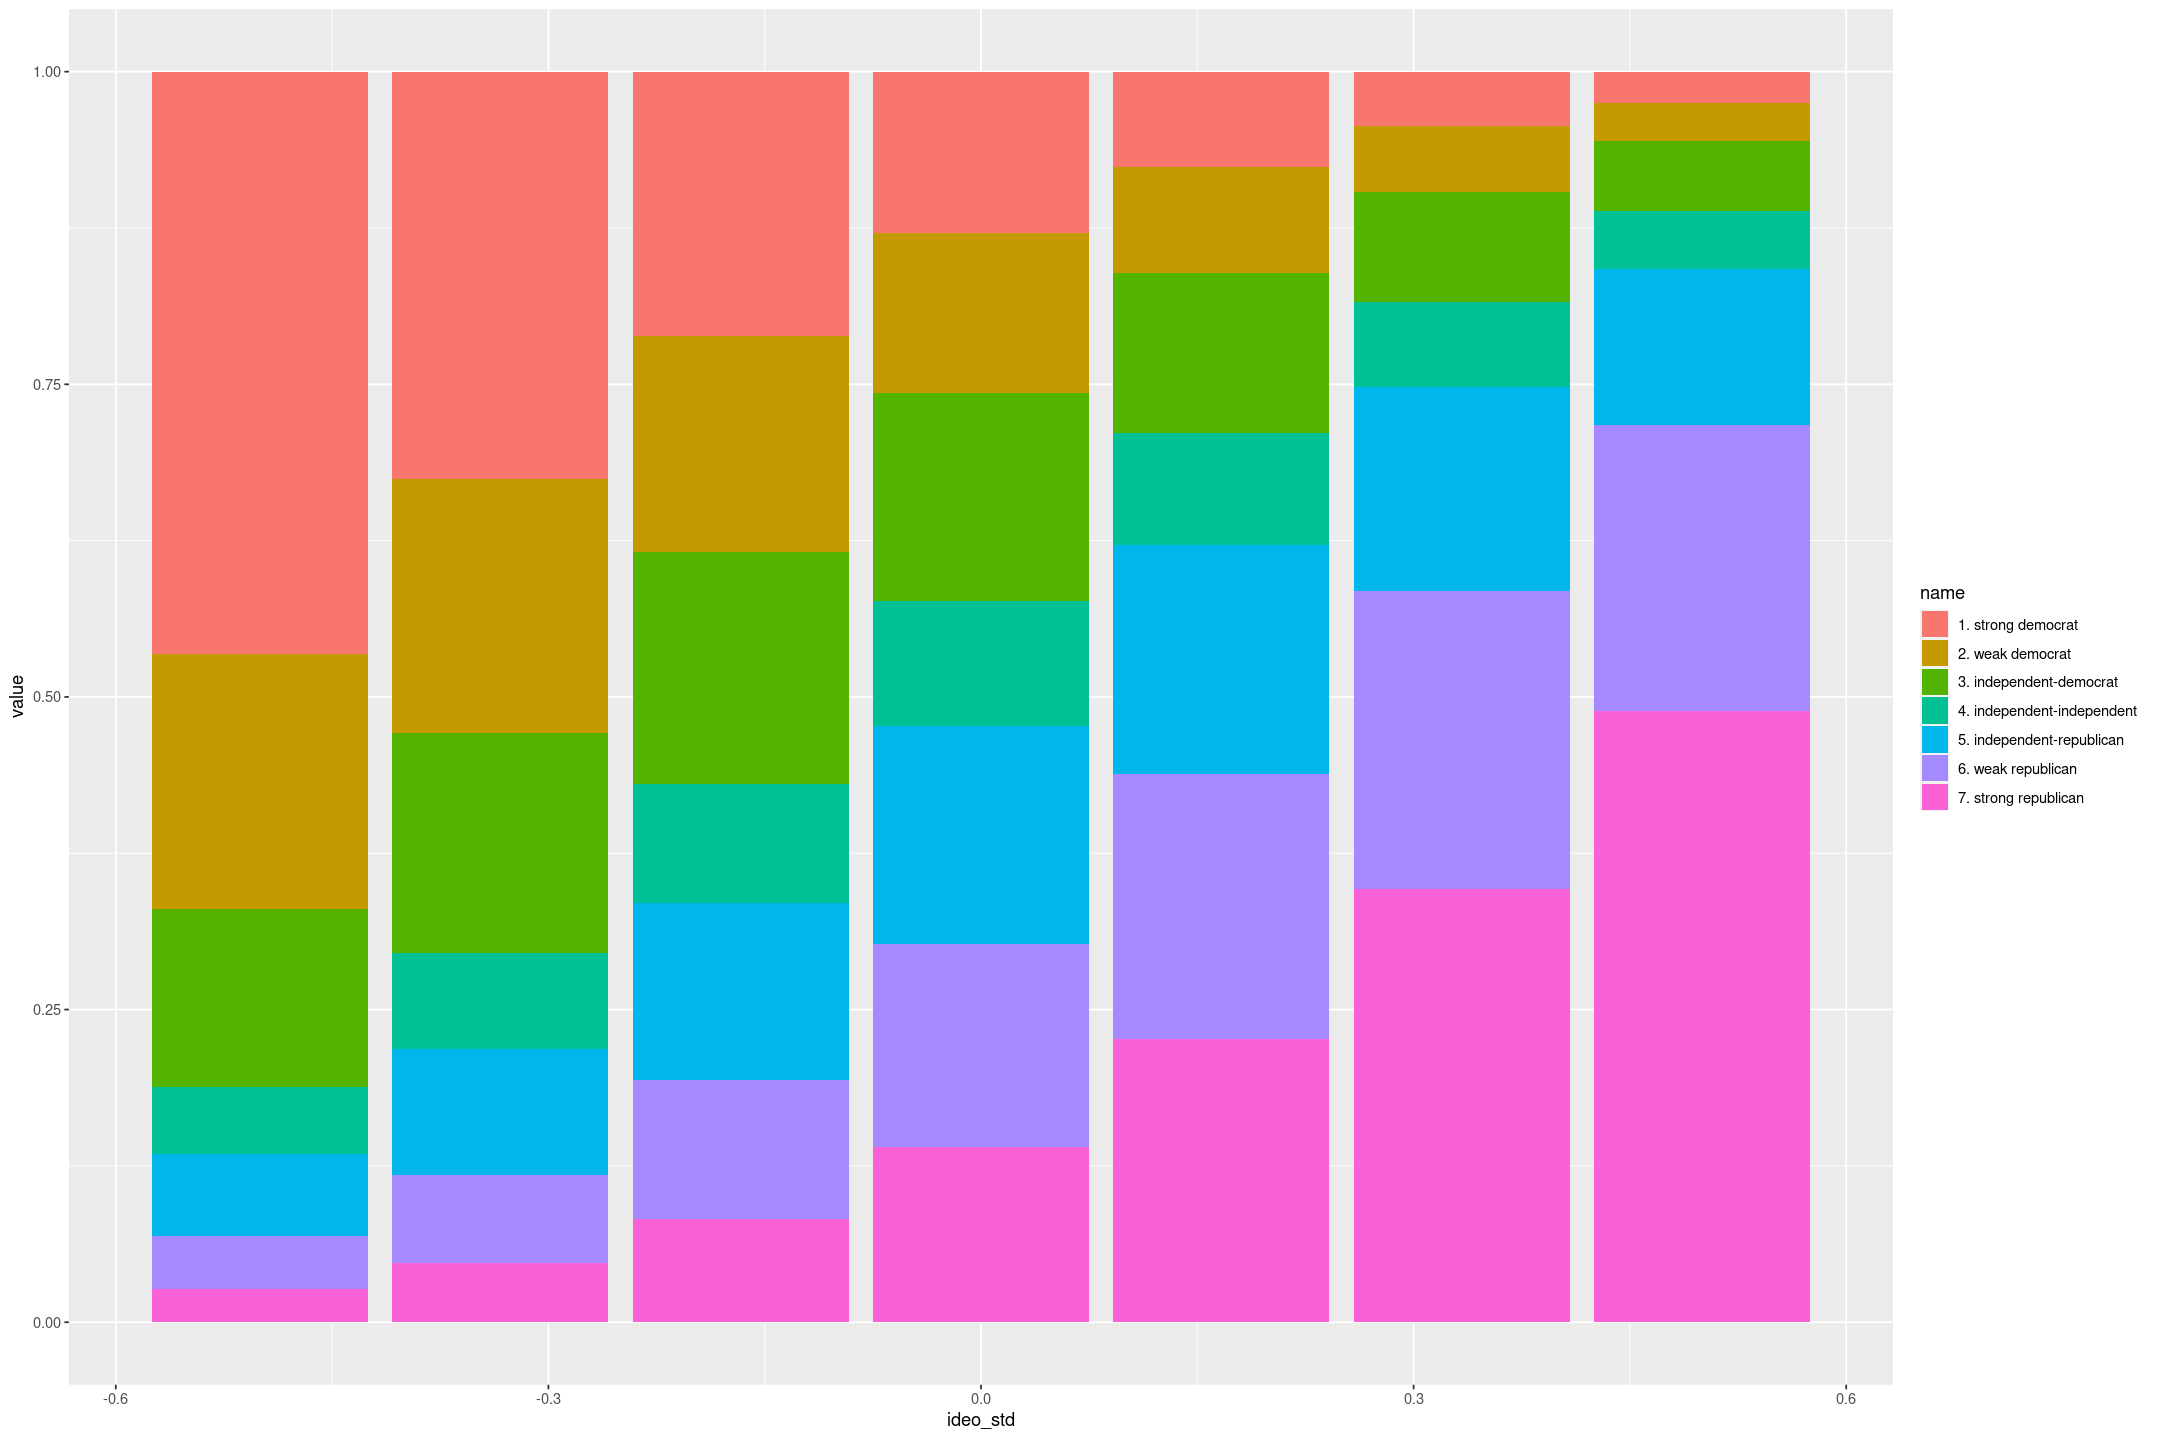

In [123]:
df_ideo <- data.frame(age30_39=0, age40_49=0, age50_64=0, age65up=0,
                  male=0,
                  black=0, hispanic=0, native_american_or_asian=0,
                           income_std=0, ideo_std=seq(-3, 3)/6) 
cbind(df_ideo, get_probs(cutpoints, predict(fit_nes_partyid, type="link", newdata=df_ideo))) %>%
pivot_longer(matches("^[0-9]")) %>%
gf_col(value ~ ideo_std, fill=~name, position = "stack")

For a continuous predictor we could use an area chart.

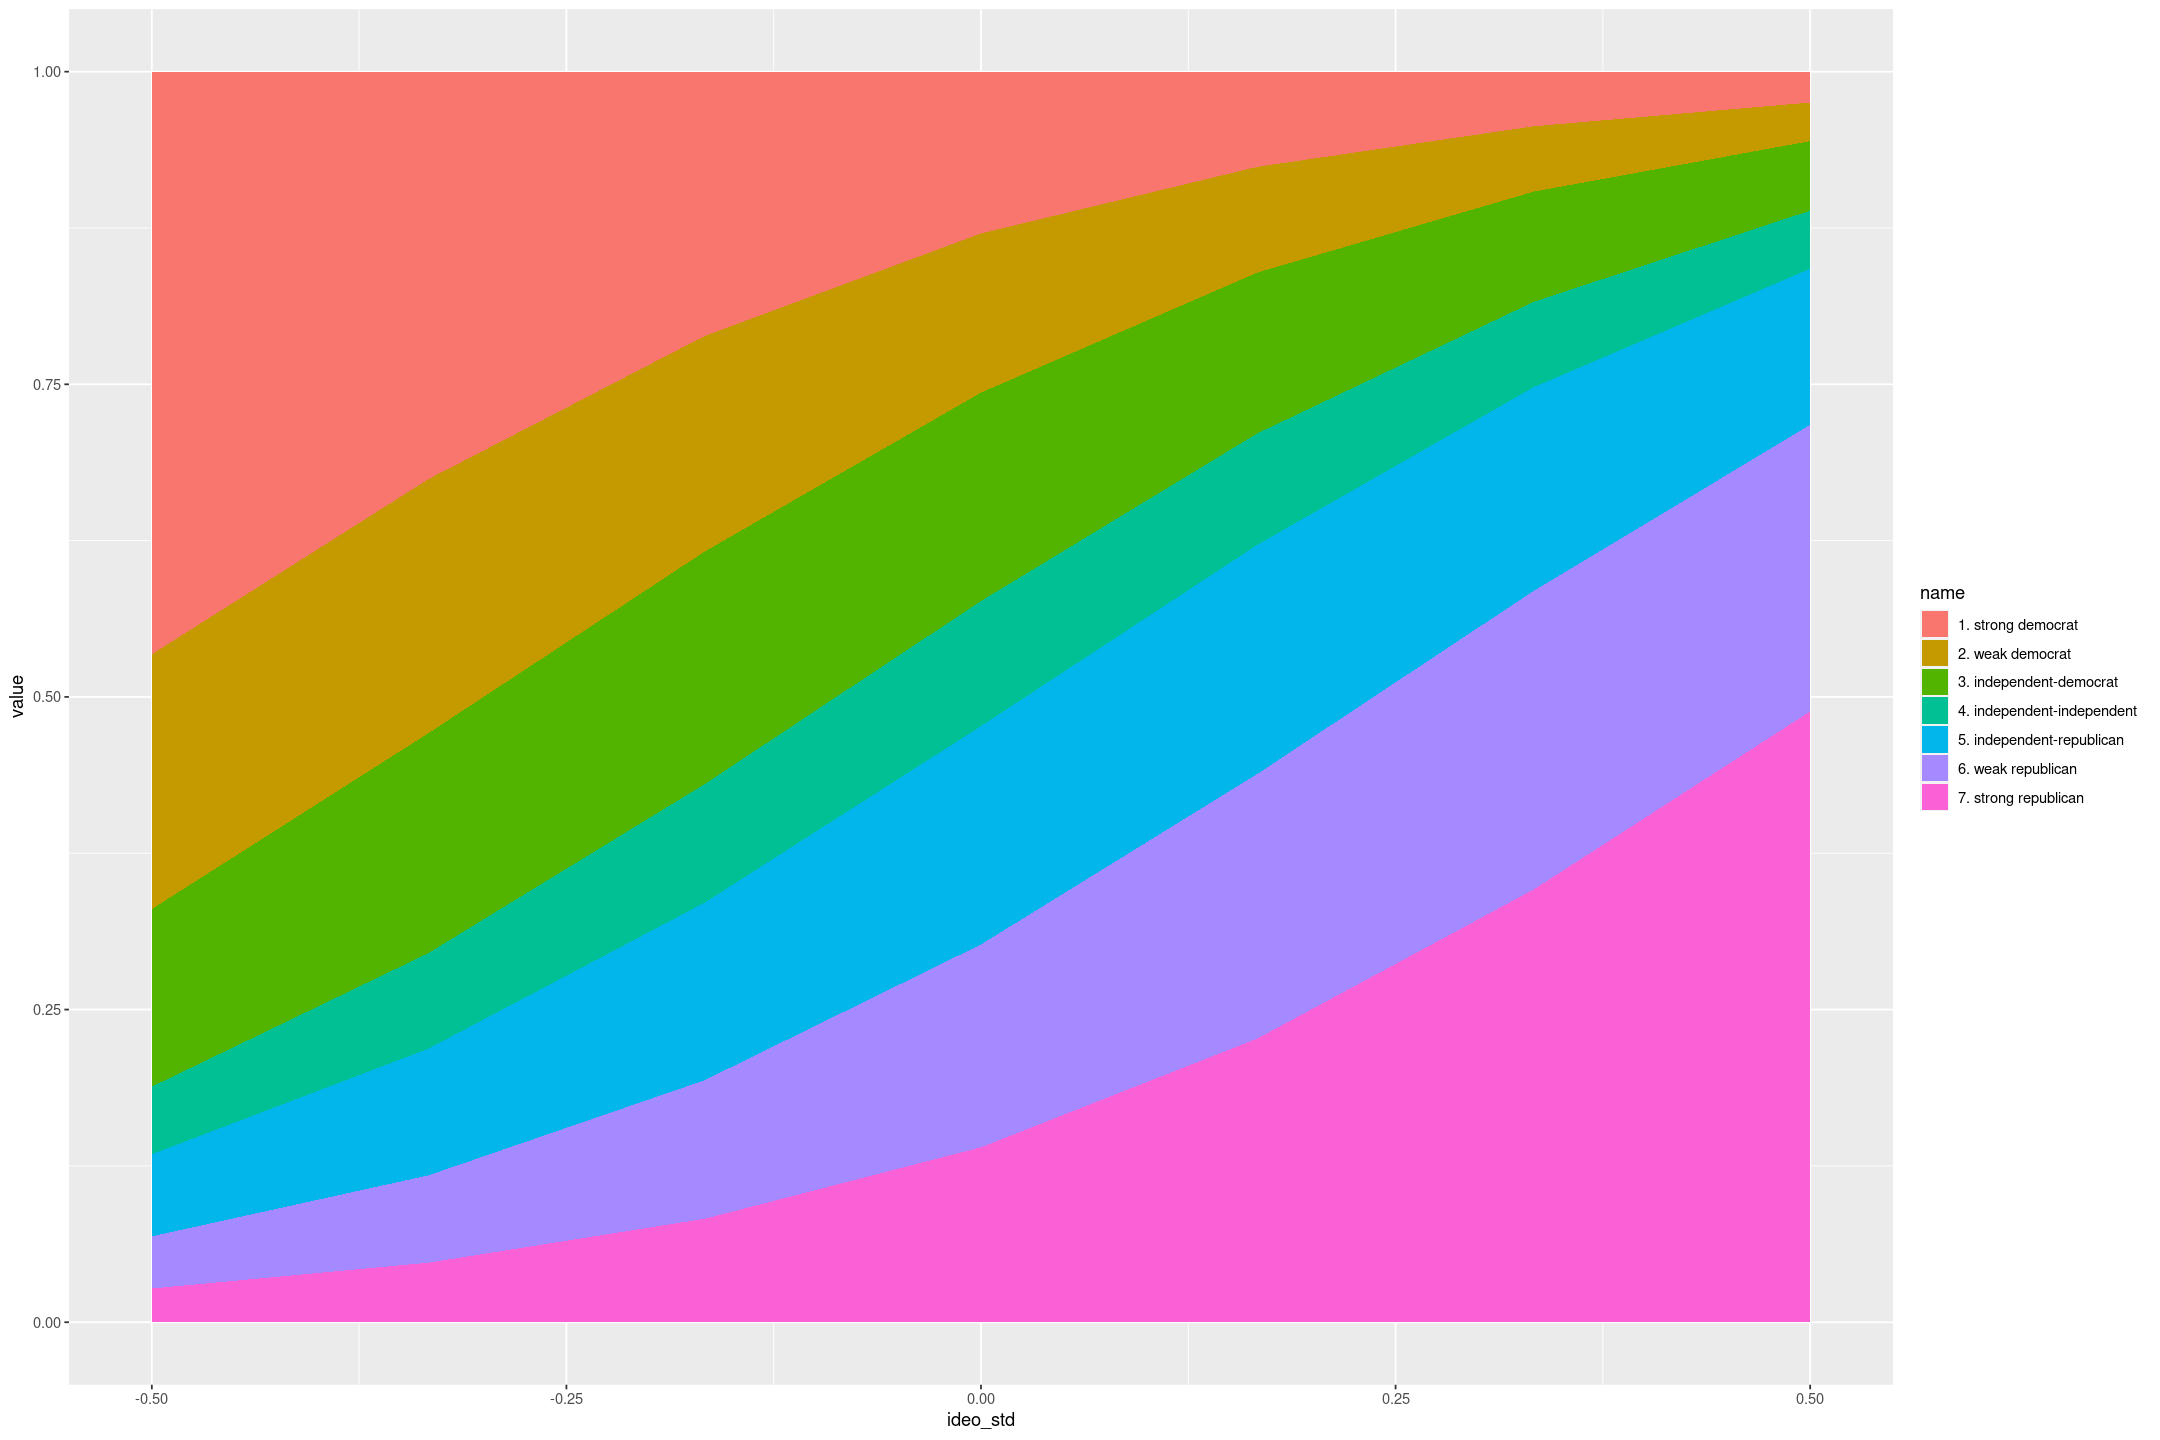

In [124]:
df_ideo <- data.frame(age30_39=0, age40_49=0, age50_64=0, age65up=0,
                  male=0,
                  black=0, hispanic=0, native_american_or_asian=0,
                           income_std=0, ideo_std=seq(-3, 3)/6) 
cbind(df_ideo, get_probs(cutpoints, predict(fit_nes_partyid, type="link", newdata=df_ideo))) %>%
pivot_longer(matches("^[0-9]")) %>%
gf_area(value ~ ideo_std, fill=~name, position = "stack")

Another way to show this is with facets.

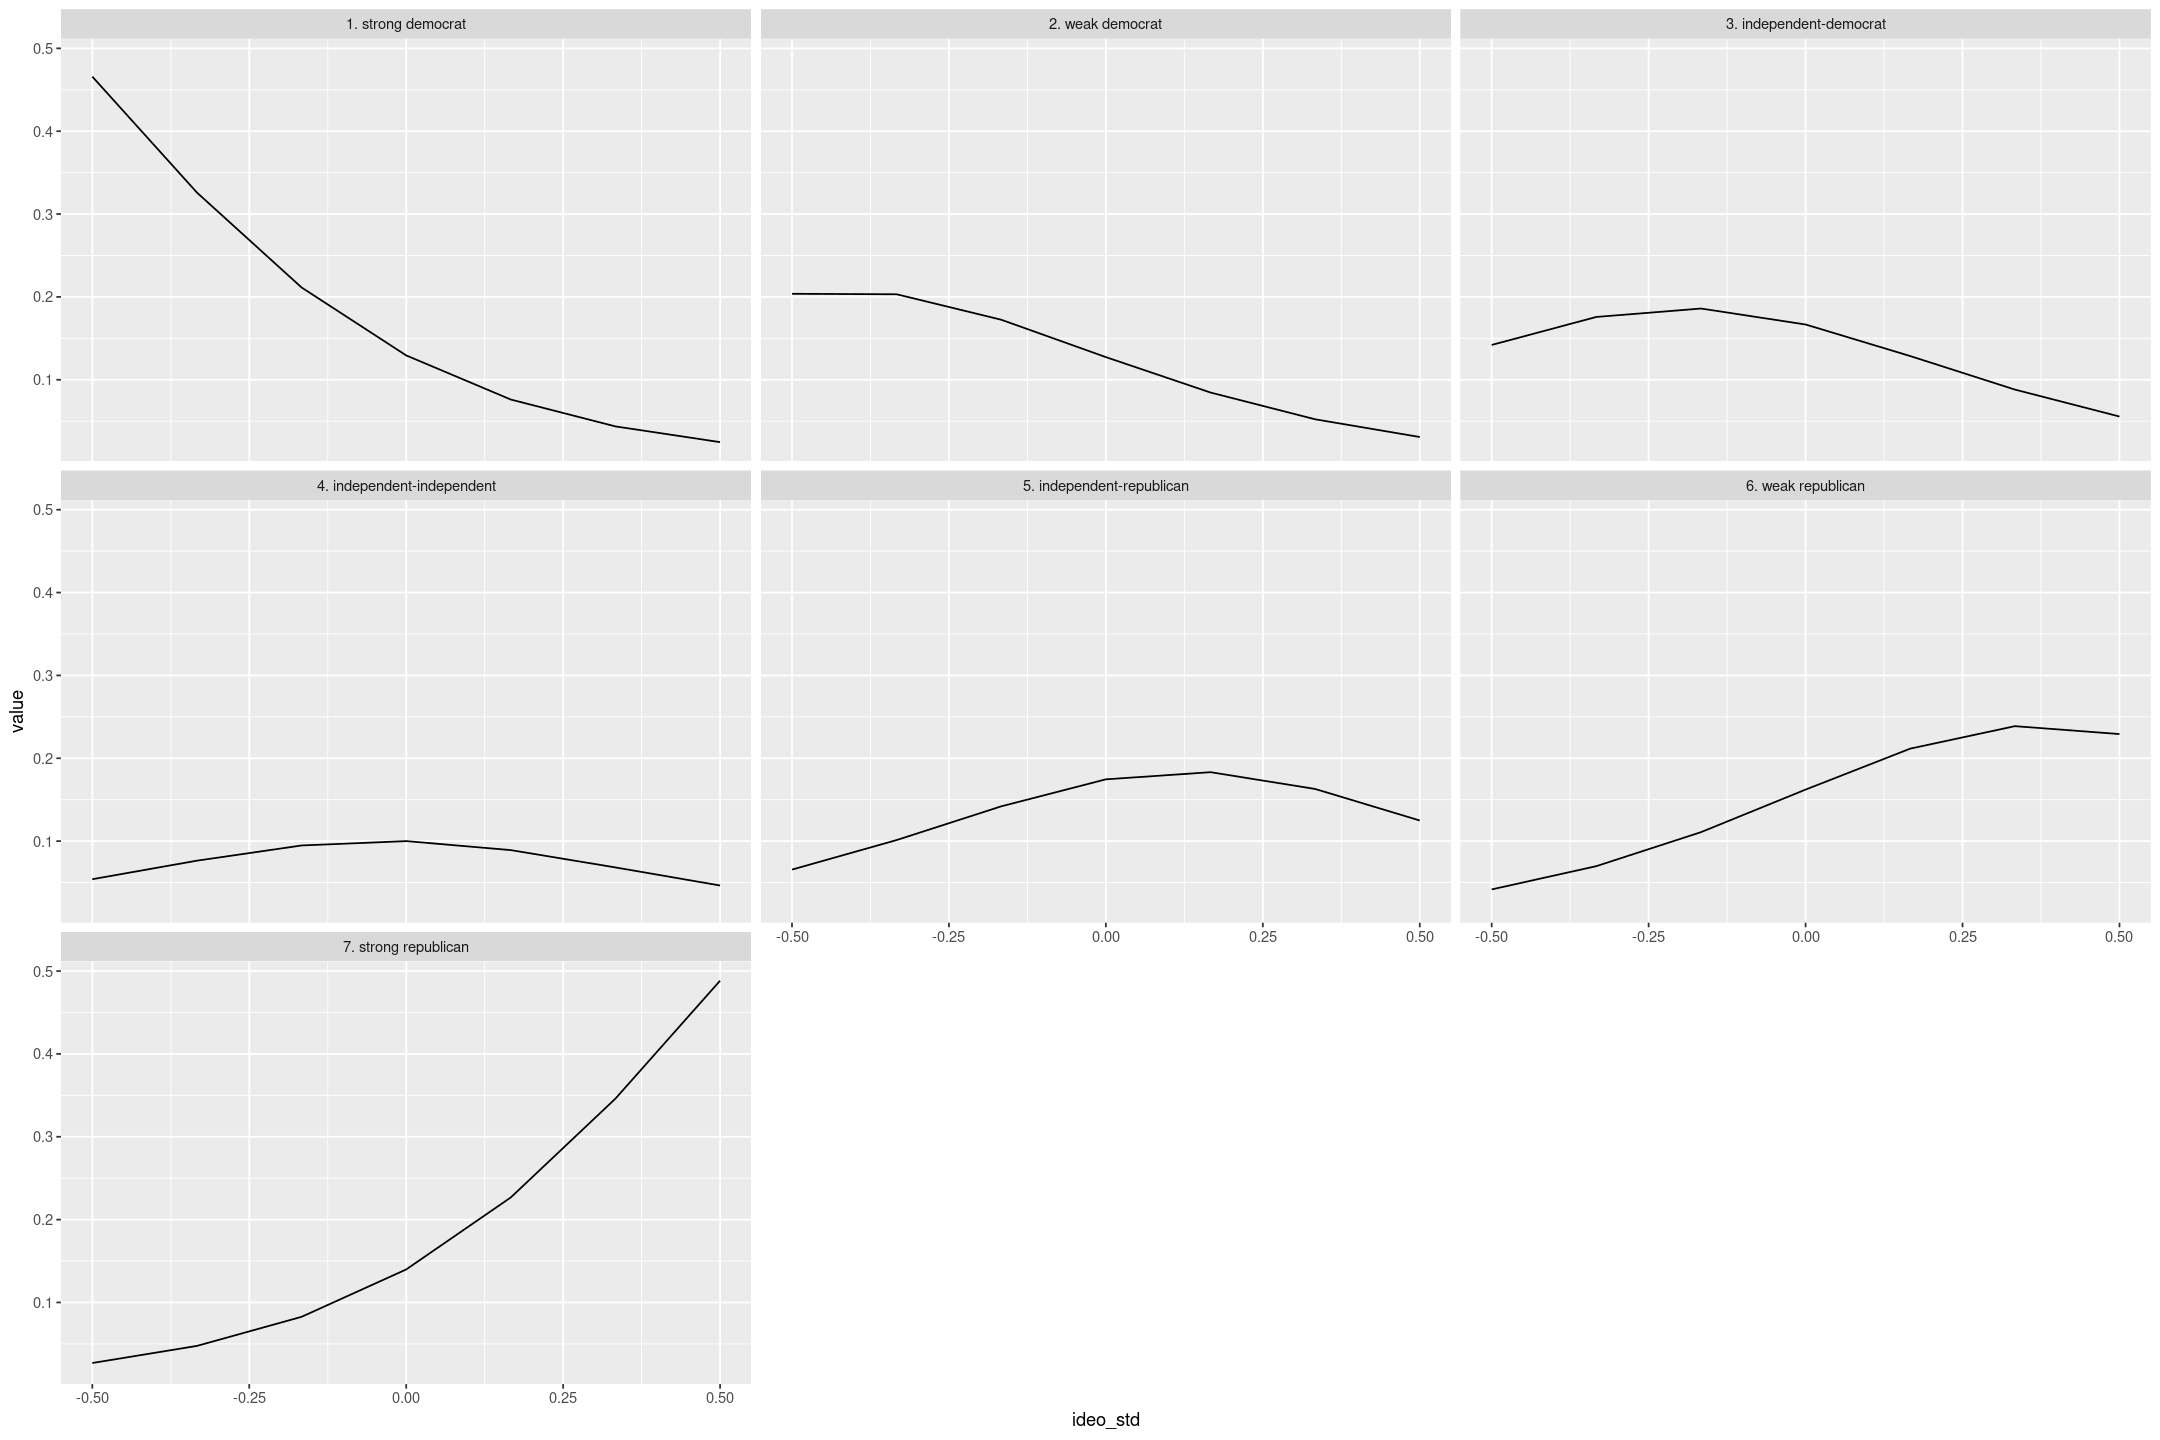

In [125]:
df_ideo <- data.frame(age30_39=0, age40_49=0, age50_64=0, age65up=0,
                  male=0,
                  black=0, hispanic=0, native_american_or_asian=0,
                           income_std=0, ideo_std=seq(-3, 3)/6) 
by_ideo <- cbind(df_ideo, get_probs(cutpoints, predict(fit_nes_partyid, type="link", newdata=df_ideo))) %>% pivot_longer(matches("^[0-9]"))
by_ideo %>% gf_line(value ~ ideo_std | name)

In this way we could show uncertainty in the cutpoints

In [126]:
samples <- (fit_nes_partyid %>%
as.matrix()
)

As a stacked bar chart gives some impression of the variance, although it's hard to see e.g. how large of small intependent-independent is.

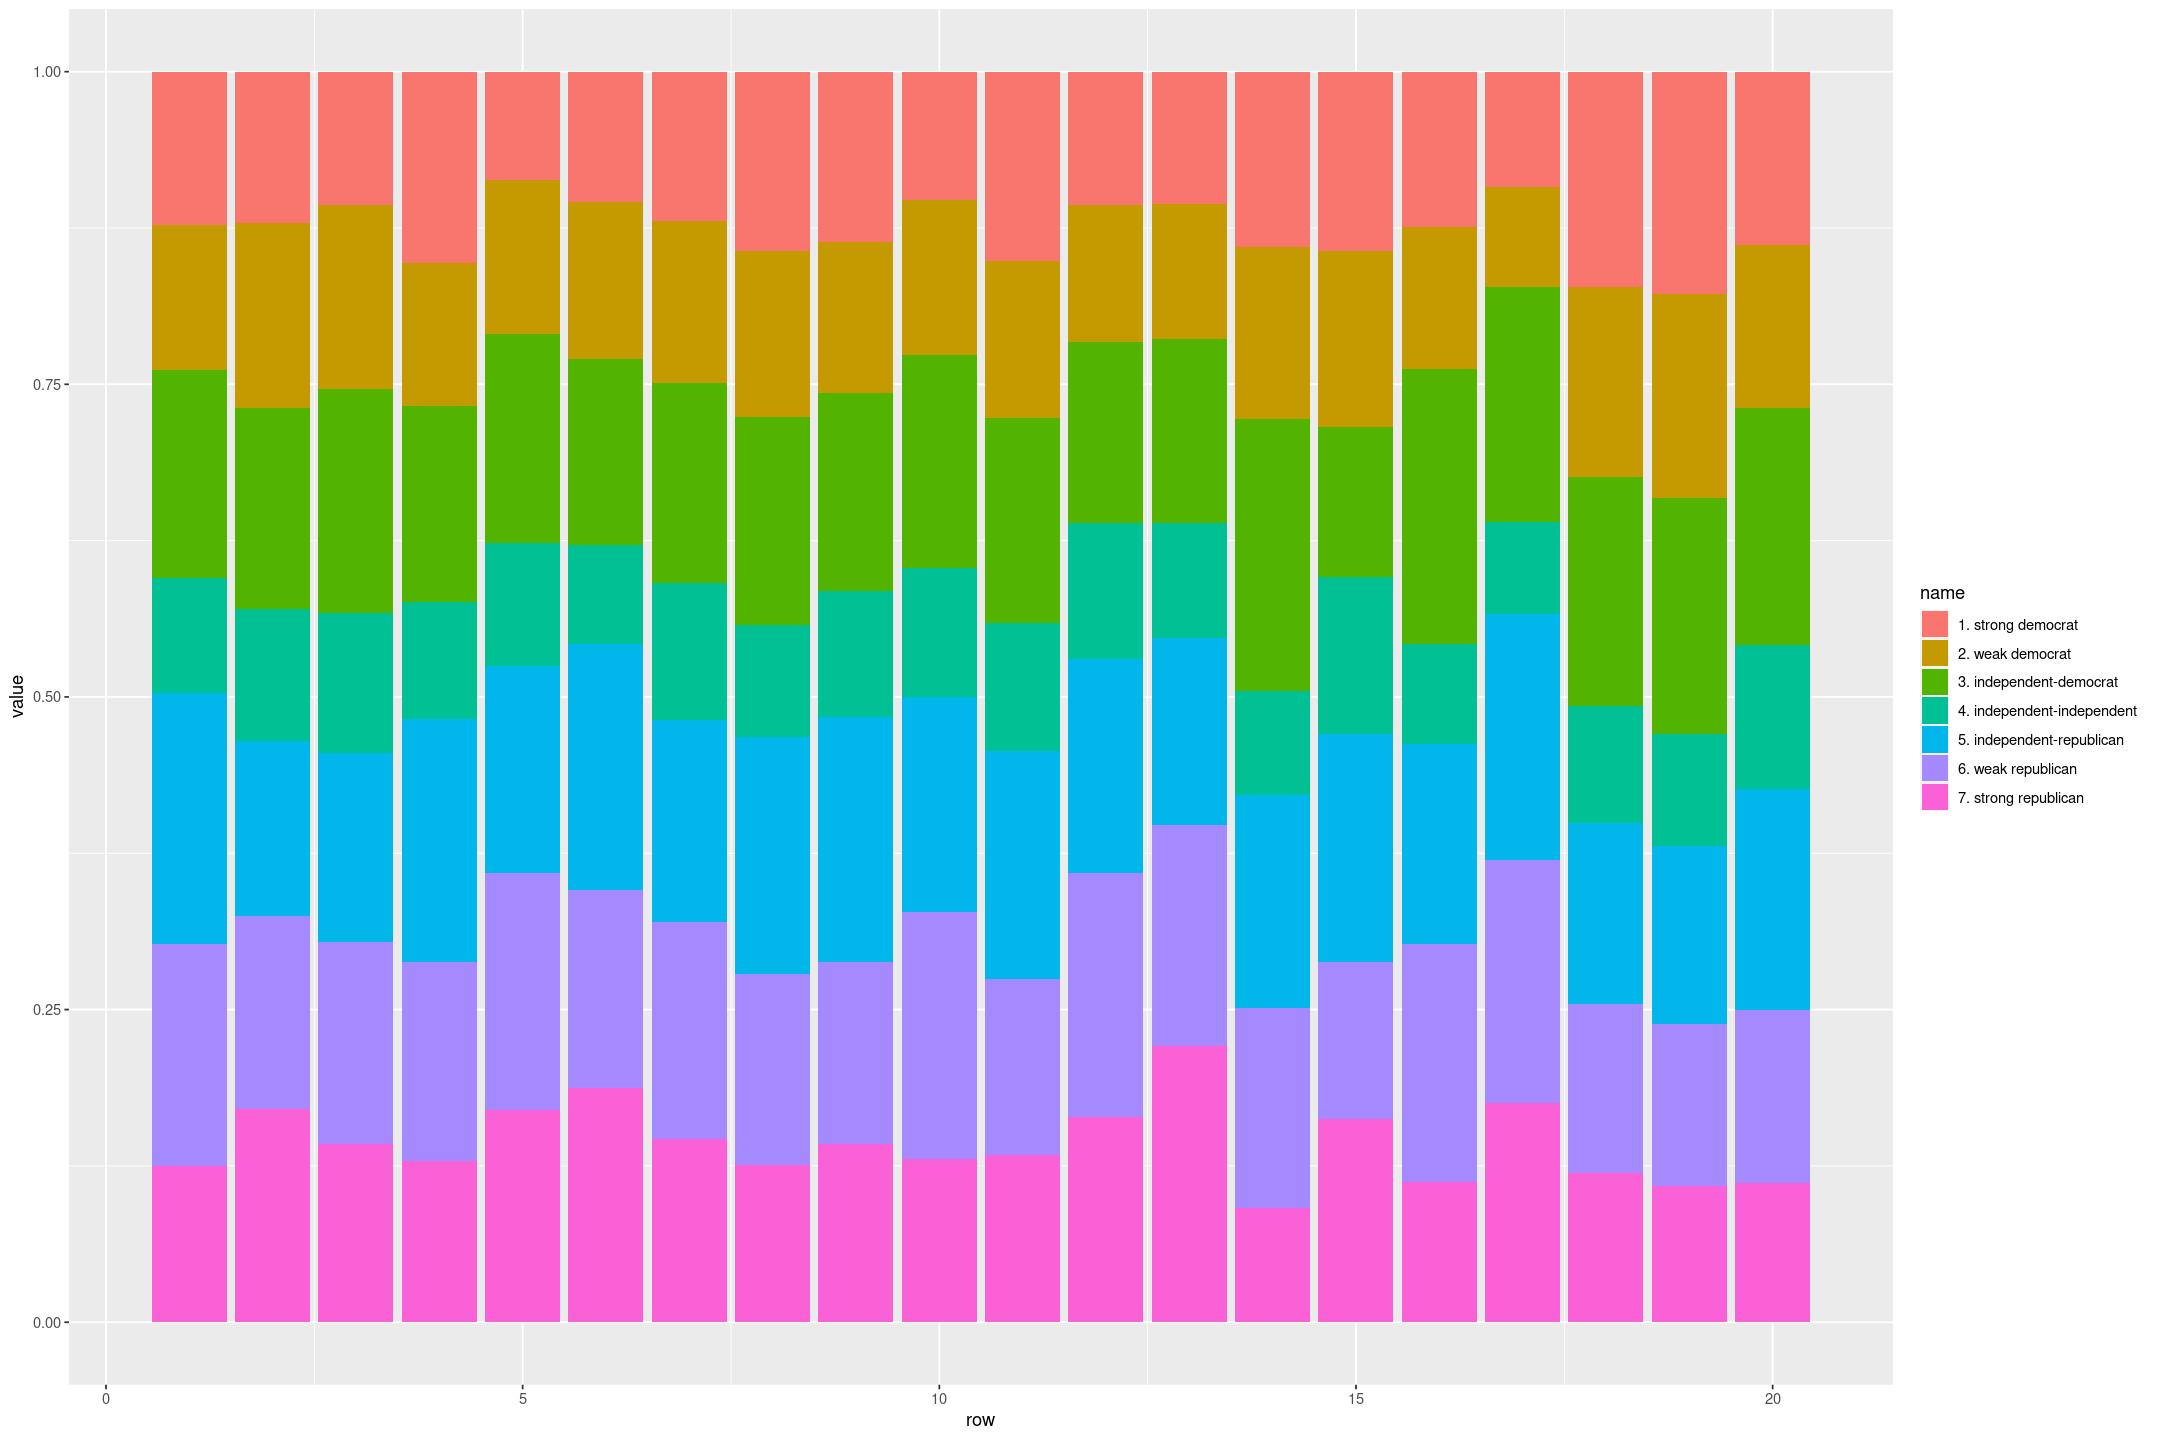

In [127]:
x <- c()
for (row in 1:20) {
    x <- rbind(x, get_probs(samples[row, names(cutpoints)], 0))
}

x %>% 
as.data.frame() %>% 
mutate(row=row_number()) %>%
pivot_longer(matches("^[0-9]")) %>%
gf_col(value ~ row, fill=~name)

In [128]:
samples[1,"ideo_std"]

ideo_std 
3.356239

We can get some idea of the uncertainty using sketches like this

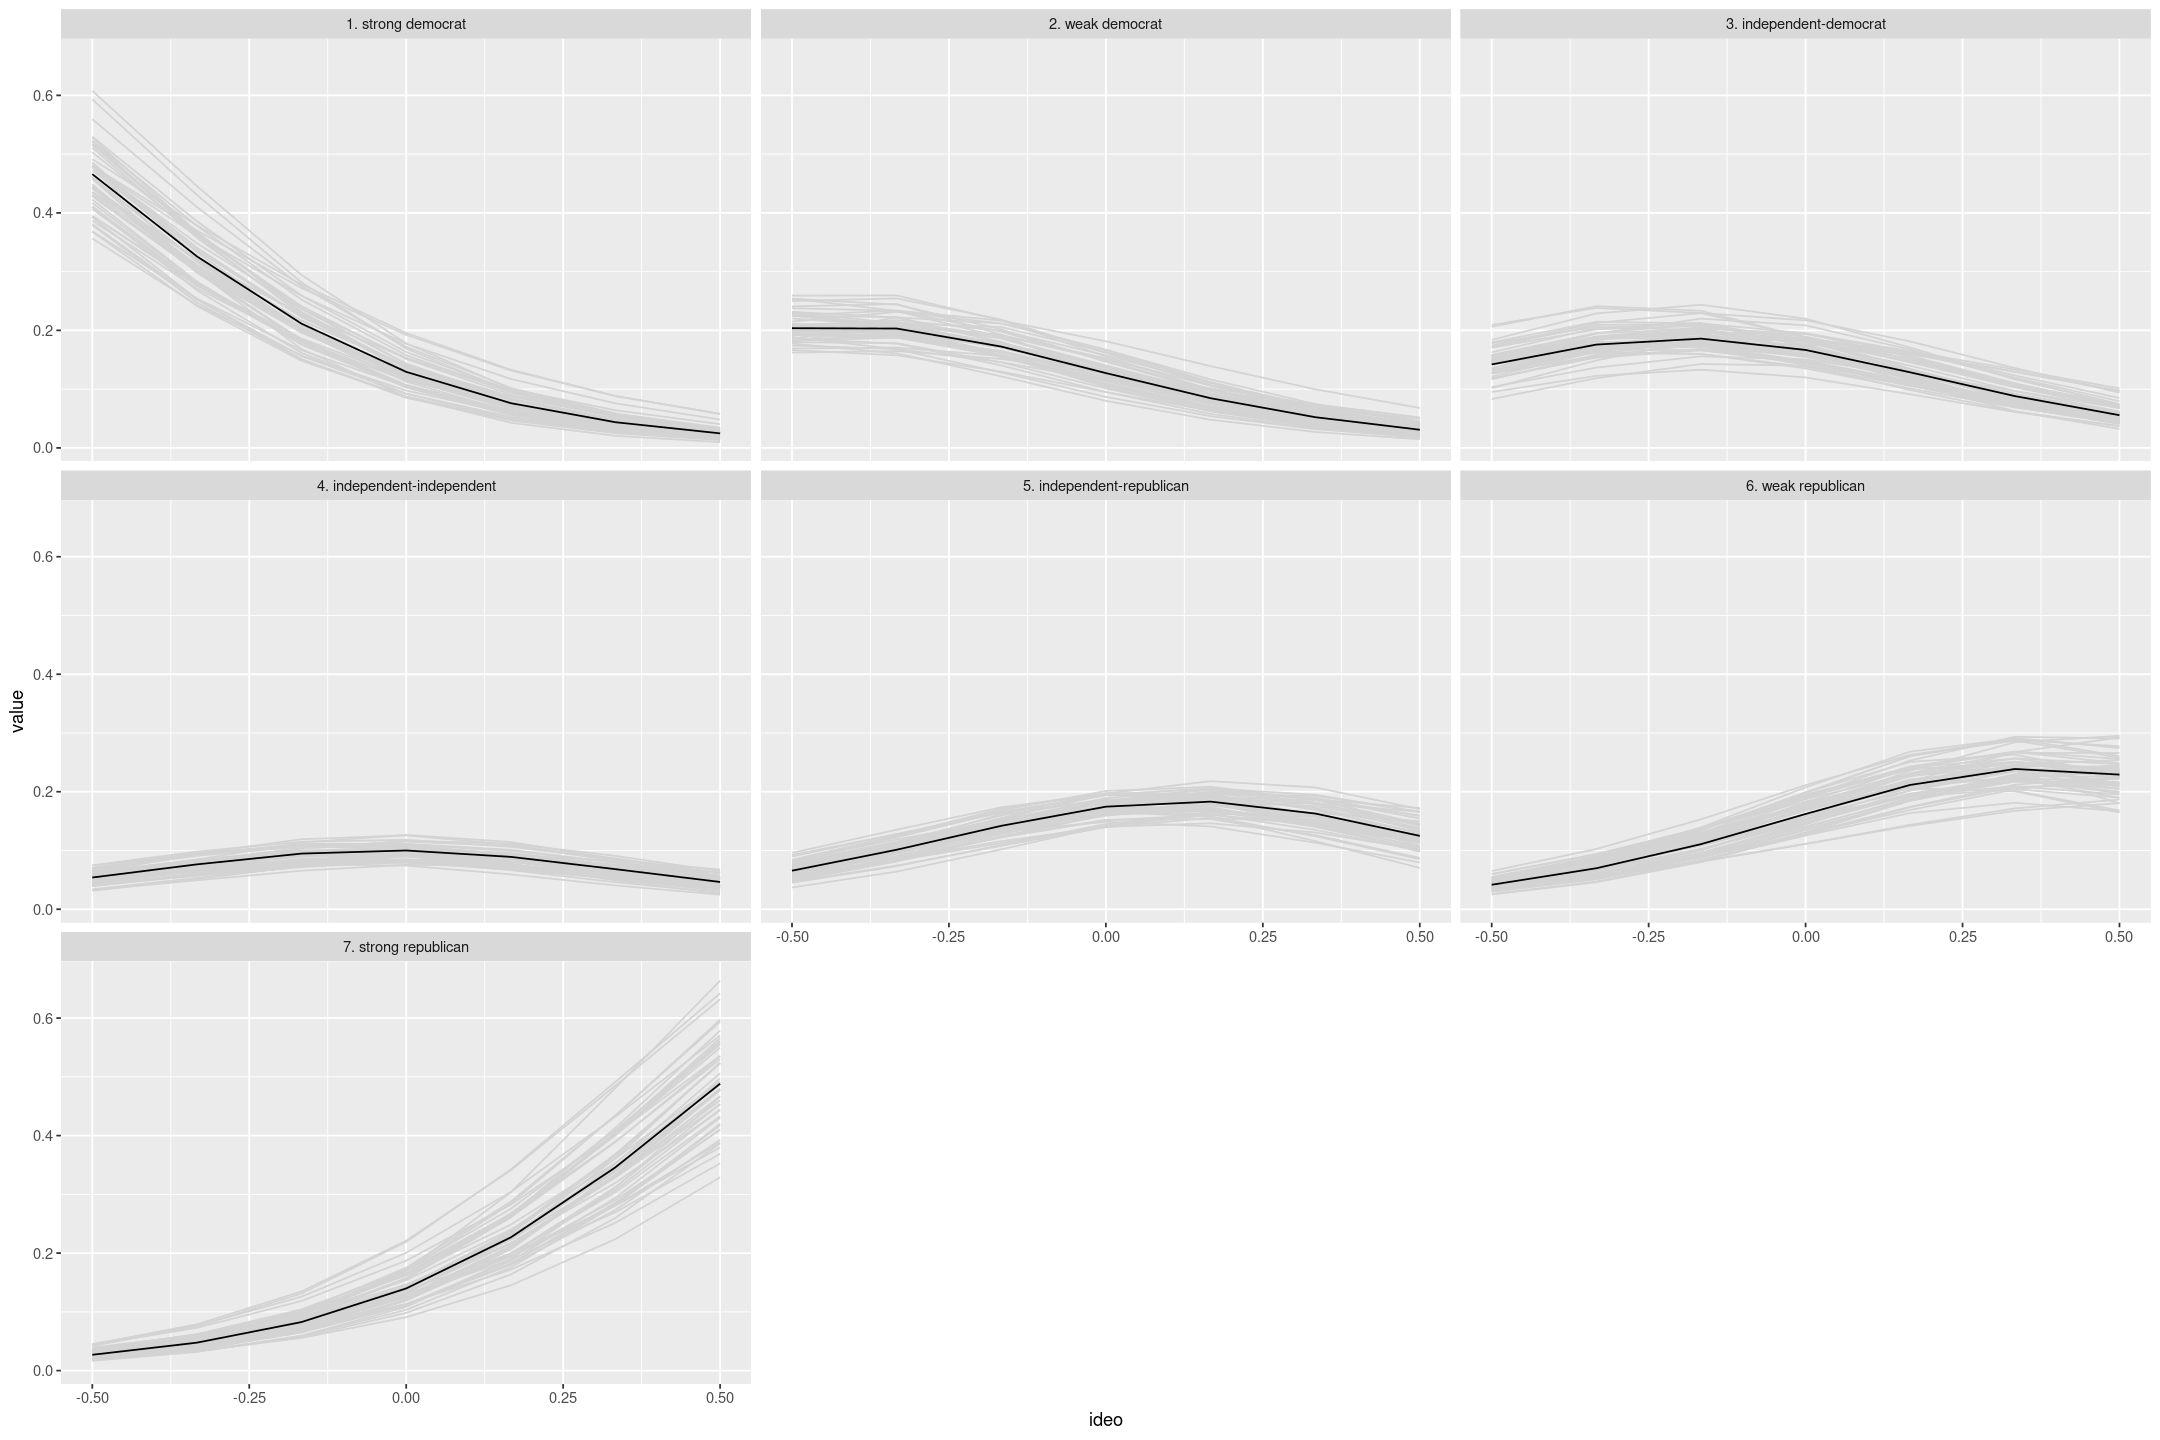

In [129]:
x <- c()
for (row in 1:50) {
    for (ideo in seq(-3, 3)/6) {
    x <- rbind(x, cbind(row, ideo, get_probs(samples[row, names(cutpoints)], samples[row, "ideo_std"] * ideo)))
    }
}



x %>%
as.data.frame() %>%
pivot_longer(matches('^[0-9]\\.')) %>%
gf_line(value ~ ideo | name, group=~row, col="lightgrey") %>%
gf_line(value ~ ideo_std, data=by_ideo, group=NULL, col="black")

Or we could show their distribution, but it doesn't clearly show the relationships

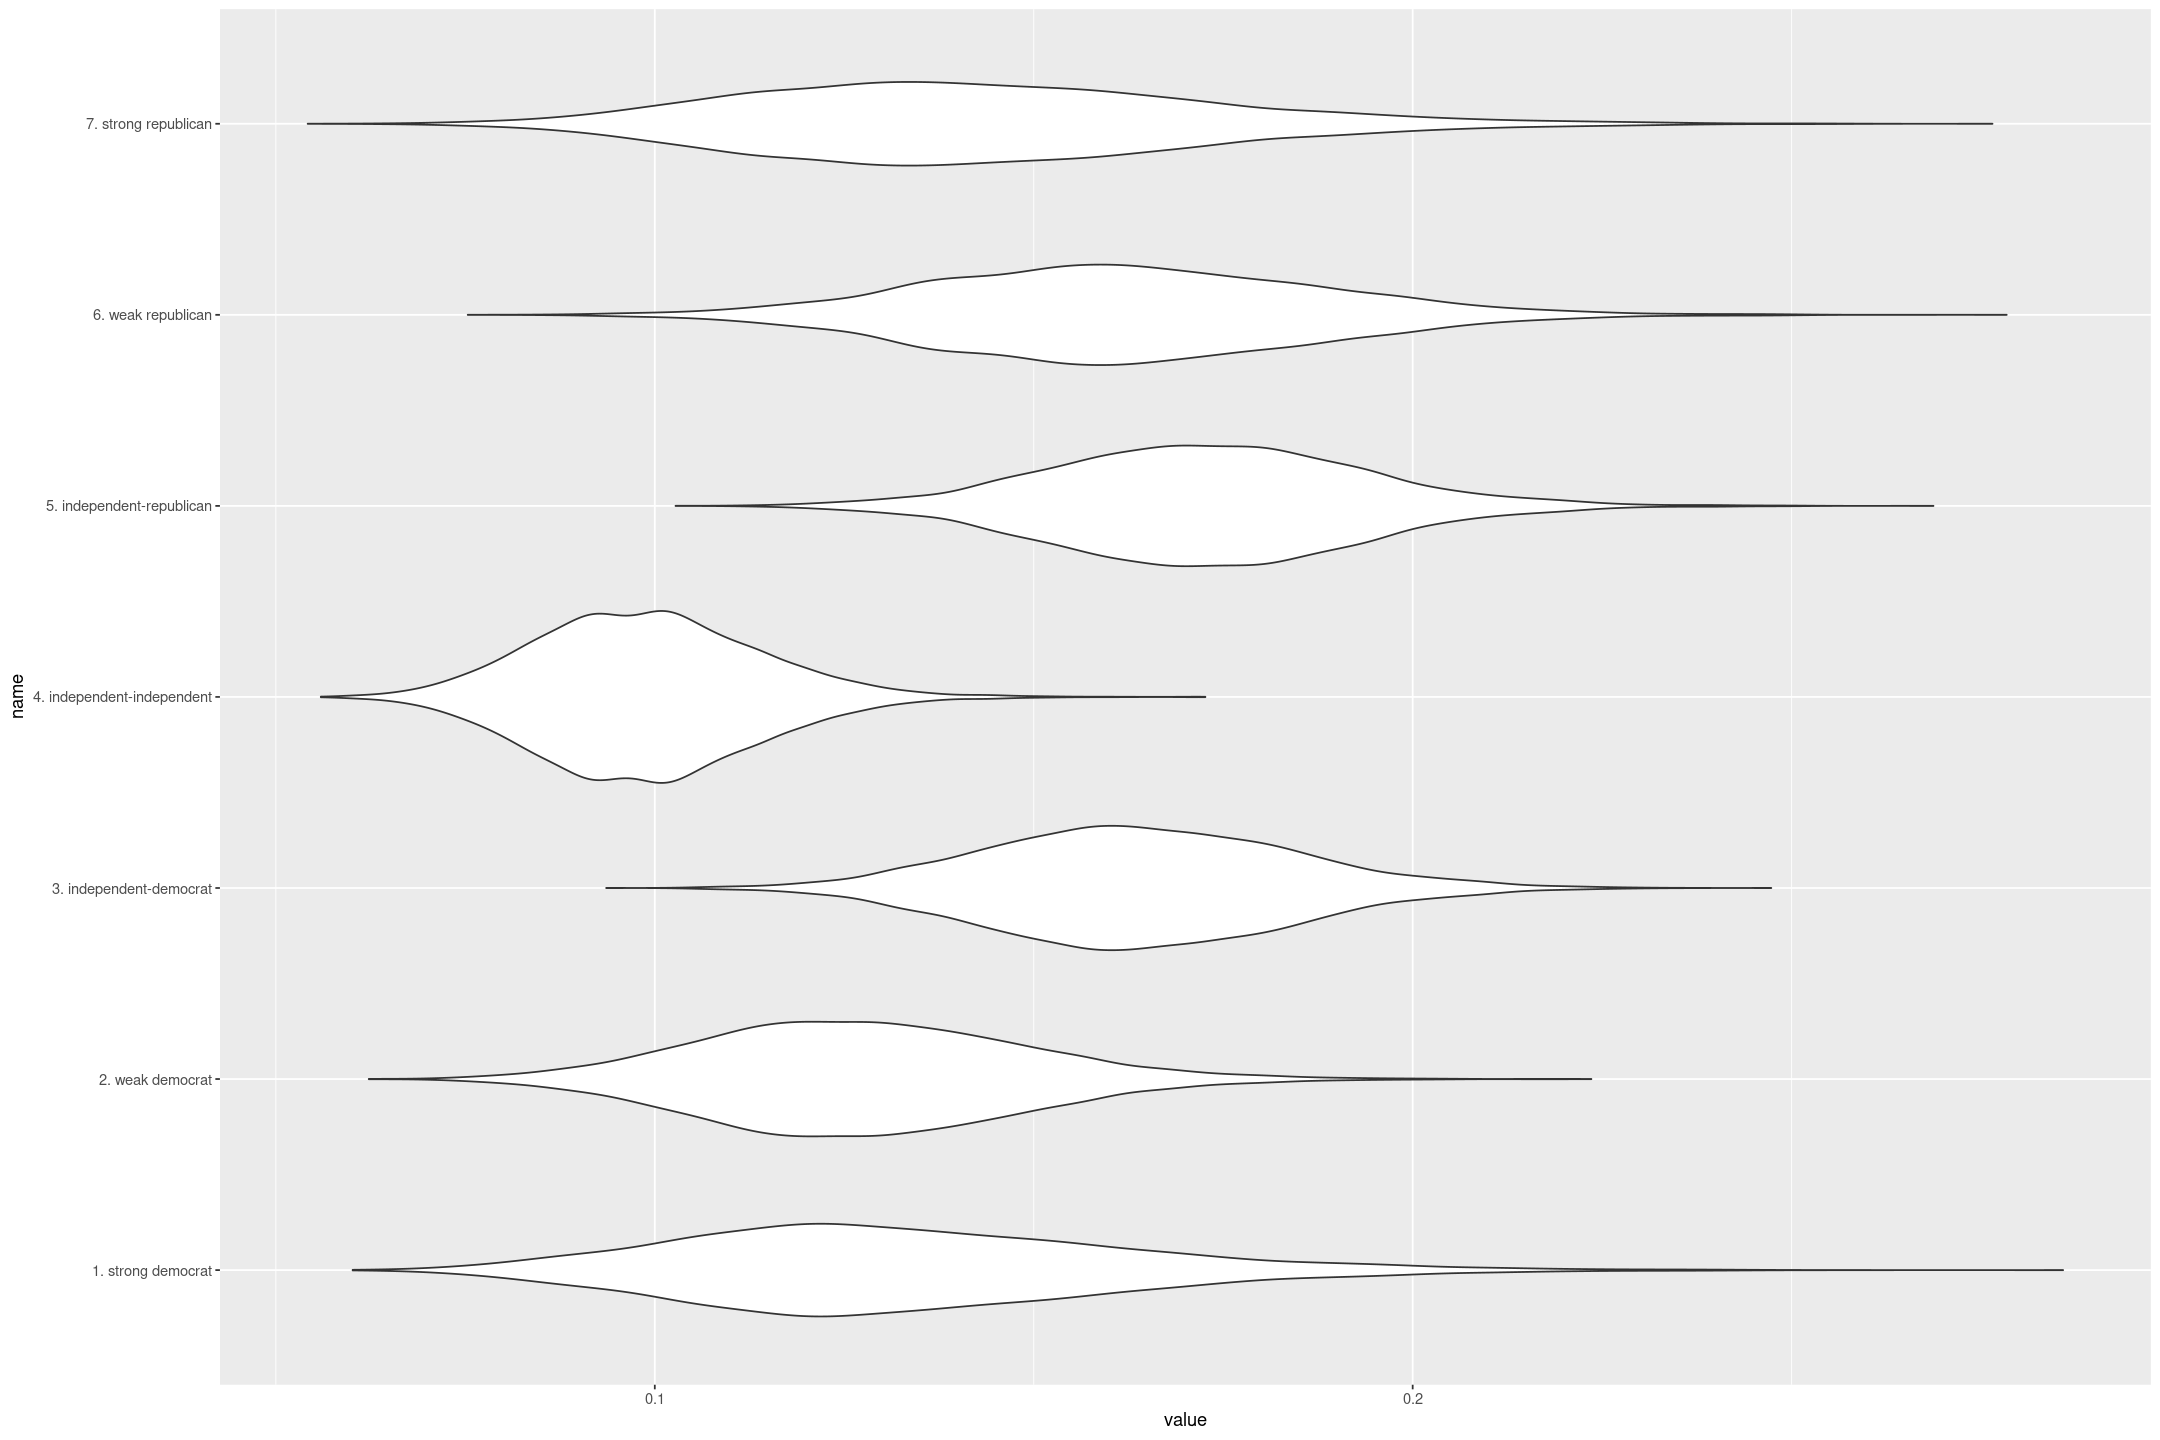

In [130]:
x <- c()
for (row in 1:nrow(samples)) {
    x <- rbind(x, get_probs(samples[row, names(cutpoints)], 0))
}

x %>% 
as.data.frame() %>% 
mutate(row=row_number()) %>%
pivot_longer(matches("^[0-9]")) %>%
gf_violin(name ~ value)

To get a simple summary in the book they use the mean.
But this doesn't necessarily make sense, since all we're assuming it it's ordered.
However the *median* value, and more generally quantiles do make sense, although it's rather insensitive.

In [131]:
cutpoint_quantile <- function(cutpoints, offset, q=0.5) {
    probs = get_probs_1(cutpoints, offset)
    cprobs = cumsum(probs)
    quantile_index = length(cprobs[cprobs <= q])
    quantile_index + 1
}

In [132]:
fit_nes_partyid

stan_polr
 family:       ordered [logistic]
 formula:      partyid7 ~ age30_39 + age40_49 + age50_64 + age65up + male + 
	   black + hispanic + native_american_or_asian + income_std + 
	   ideo_std
 observations: 560
------
                         Median MAD_SD
age30_39                 -0.5    0.3  
age40_49                 -0.5    0.3  
age50_64                 -0.7    0.3  
age65up                  -0.7    0.3  
male                      0.2    0.1  
black                    -1.4    0.2  
hispanic                 -0.5    0.3  
native_american_or_asian -0.1    0.3  
income_std                1.0    0.3  
ideo_std                  3.5    0.3  

Cutpoints:
                                                     Median MAD_SD
1. strong democrat|2. weak democrat                  -1.9    0.3  
2. weak democrat|3. independent-democrat             -1.1    0.2  
3. independent-democrat|4. independent-independent   -0.3    0.2  
4. independent-independent|5. independent-republican  0.1    0.2  


In [133]:
levels(nes2000_na$partyid7)

[1] "1. strong democrat"         "2. weak democrat"          
[3] "3. independent-democrat"    "4. independent-independent"
[5] "5. independent-republican"  "6. weak republican"        
[7] "7. strong republican"

This is one way of viewing the cutpoints.
The solid line is the median value, and the dashed lines are the 75th and 25th percentiles.

So when the offset is 0, then the median is a neutral, the 25th percentile is weak democrat, and the 75th percentile is weak republican.

Note that the neutral category is smaller than the others.

At +/-3 the full 50% is strong republican or strong democrat.

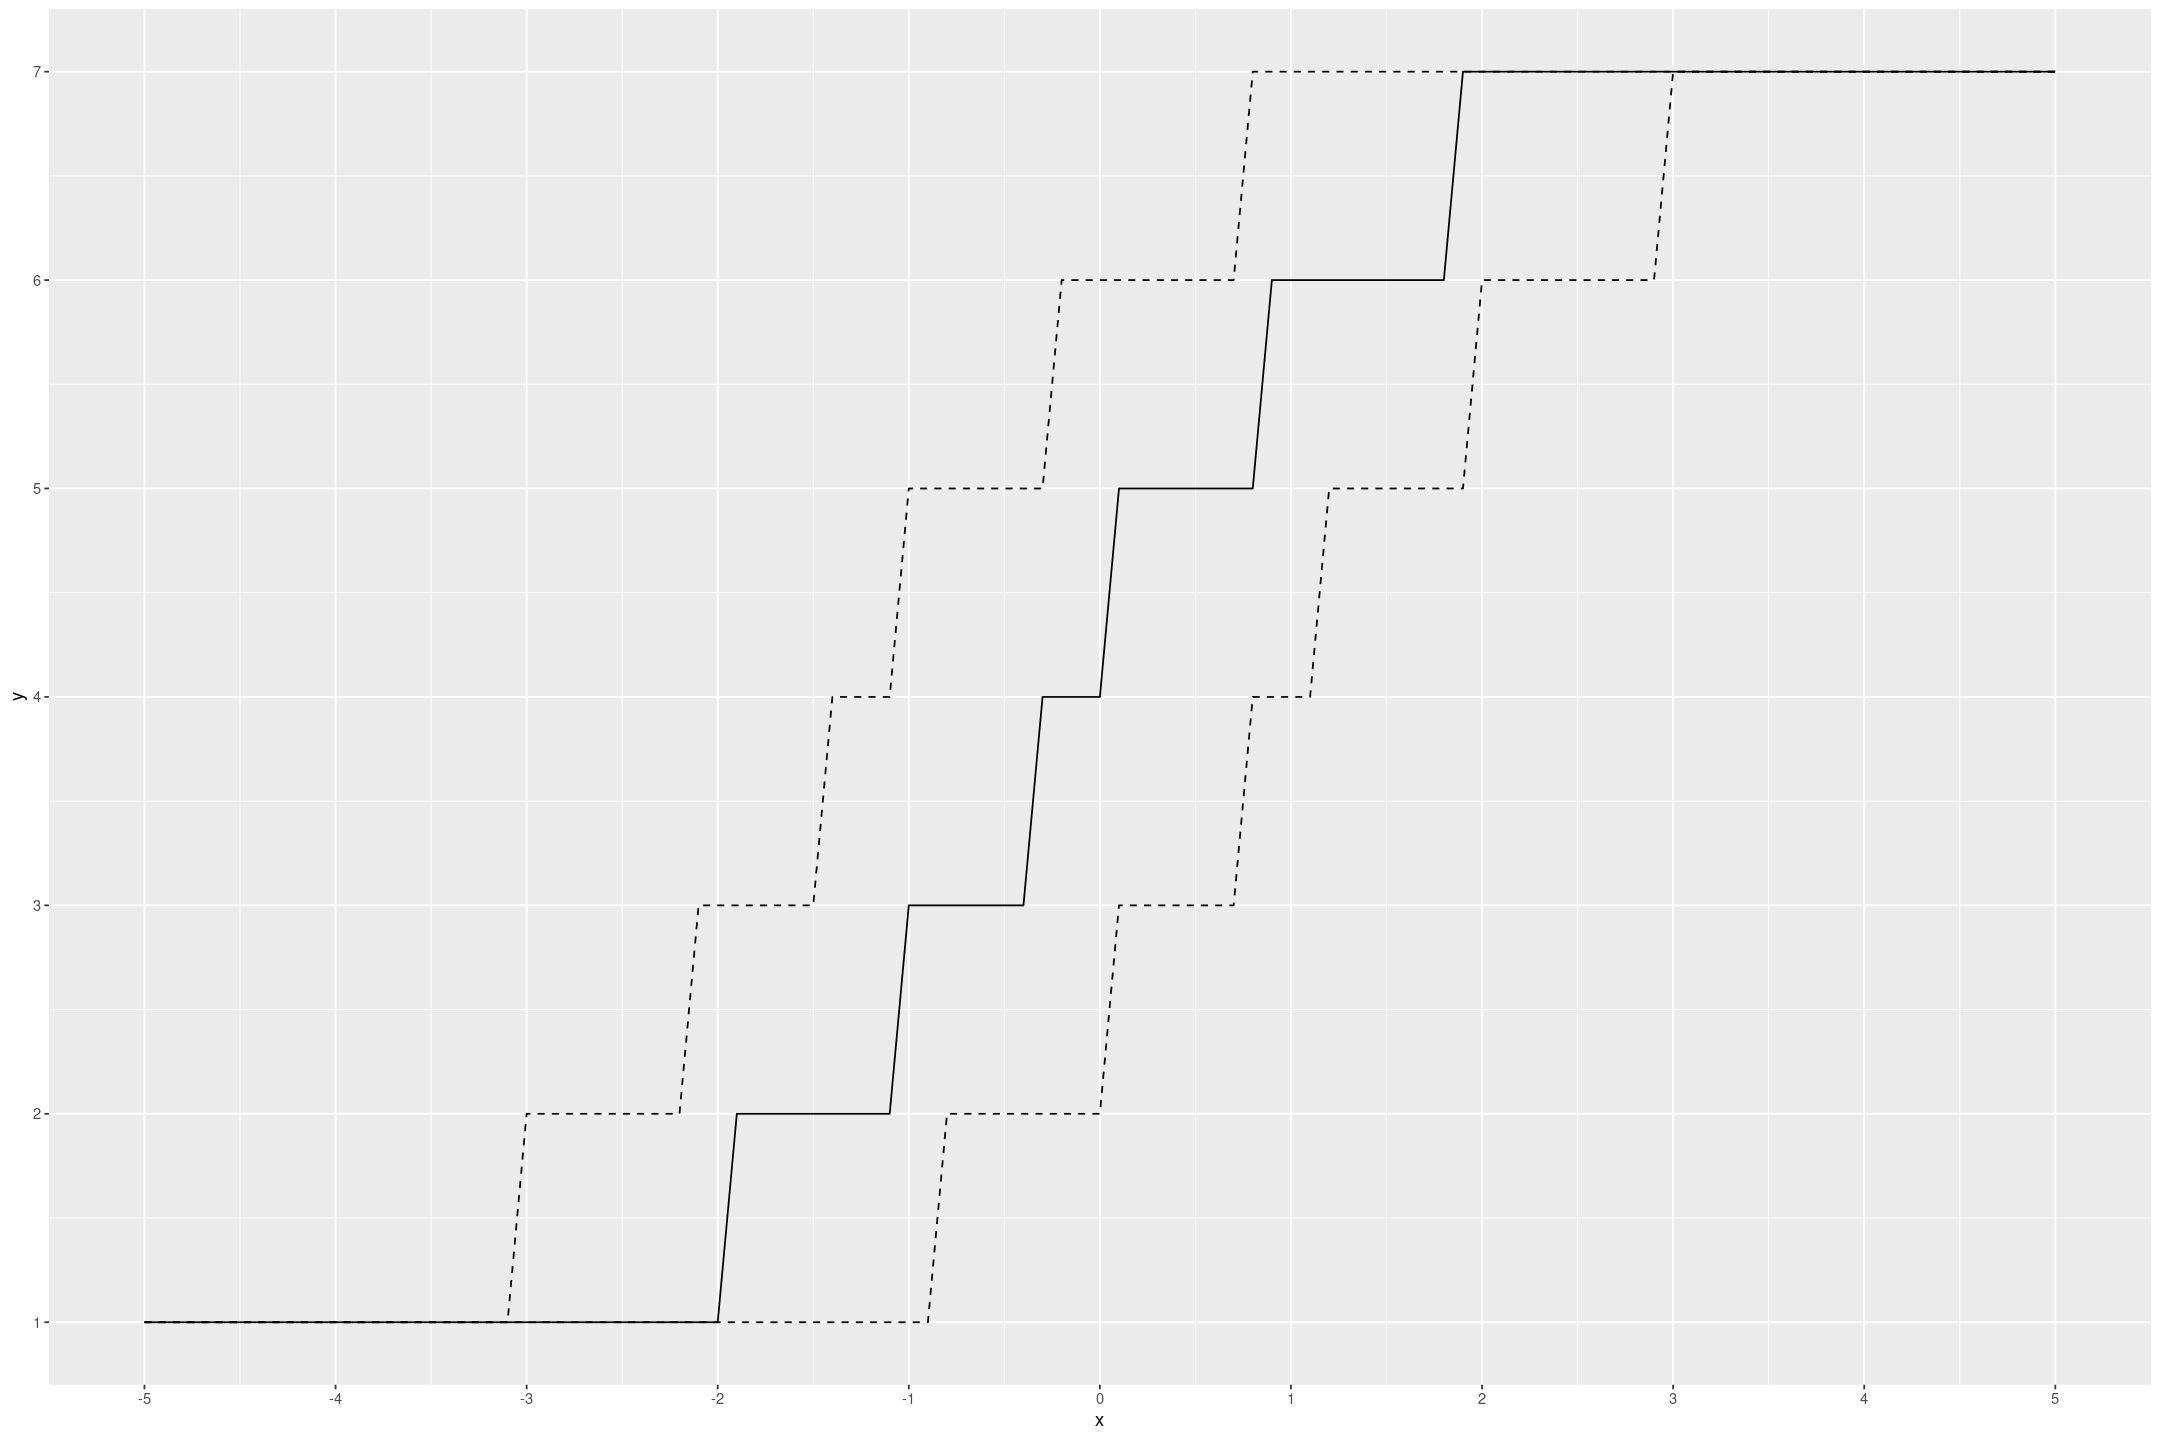

In [134]:
x <- seq(-5, 5, by=0.1)
y <- vapply(x, function(x) cutpoint_quantile(cutpoints, x, q=0.5), double(1))
y_low <- vapply(x, function(x) cutpoint_quantile(cutpoints, x, q=0.25), double(1))
y_hi <- vapply(x, function(x) cutpoint_quantile(cutpoints, x, q=0.75), double(1))
    
gf_line(y ~ x) %>%
gf_line(y_low ~ x, linetype='dashed') %>%
gf_line(y_hi ~ x, linetype='dashed') +
scale_y_continuous(breaks=seq(0,7)) +
scale_x_continuous(breaks=seq(-5,5, by=1), minor_breaks=seq(-5,5,by=0.5))

Finally we can look at the distribution of the other coefficients.

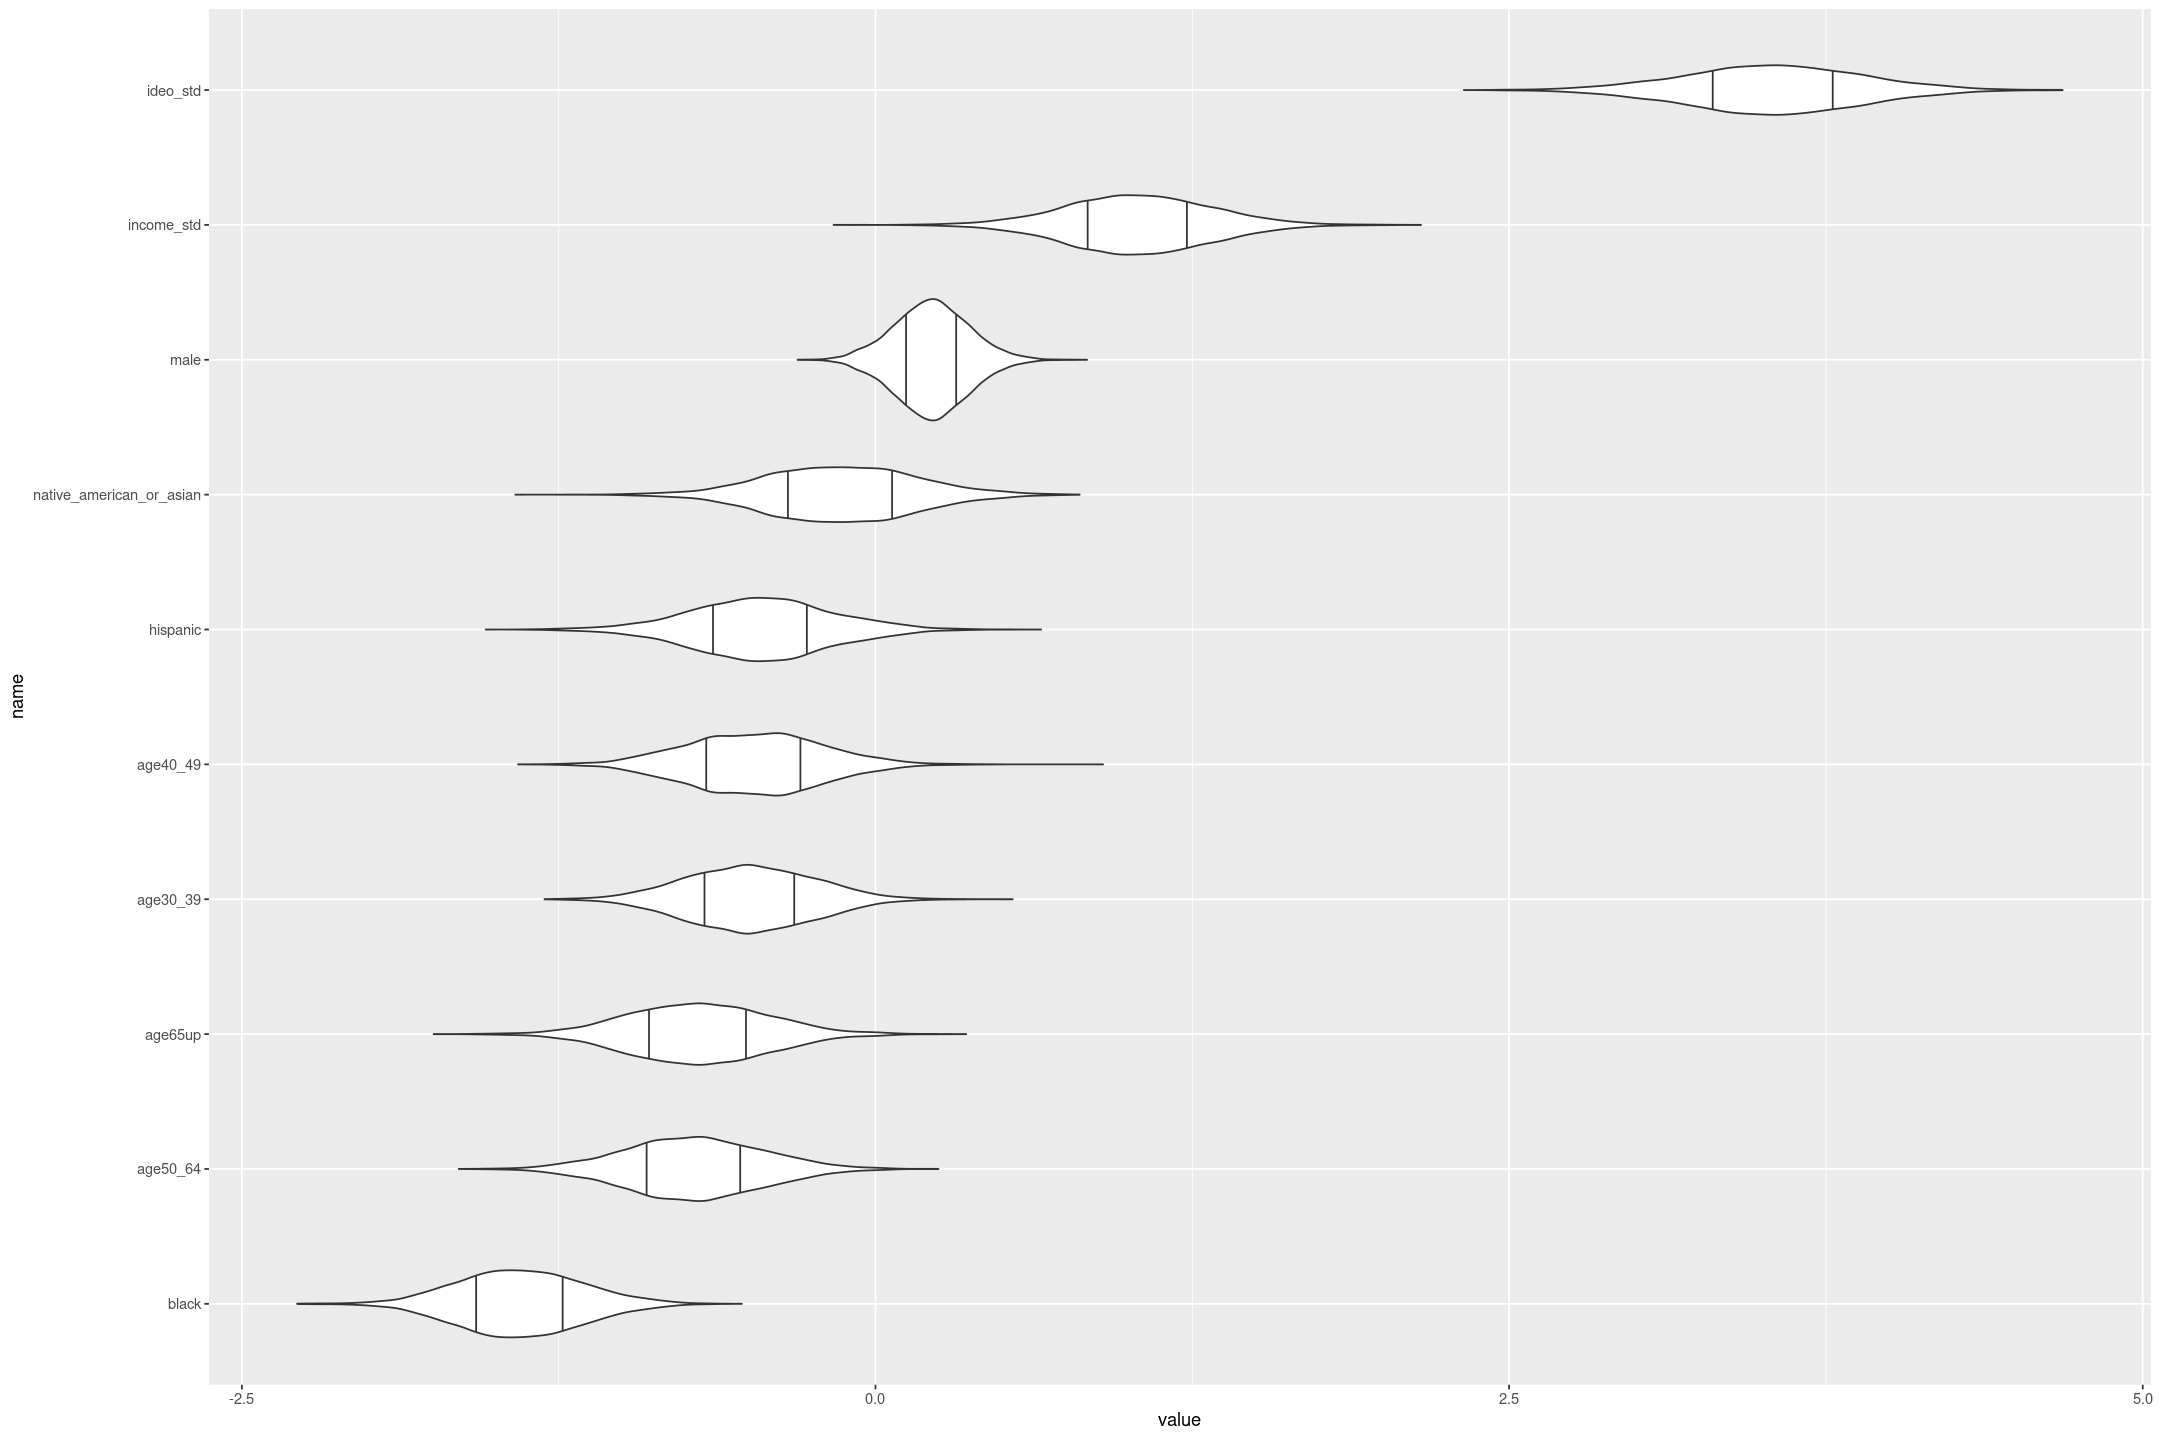

In [135]:
fit_nes_partyid %>%
as.data.frame() %>%
pivot_longer(-matches("^[0-9]")) %>%
mutate(name=forcats::fct_reorder(name, value)) %>%
gf_violin(name~value, draw_quantiles=c(0.25, 0.75))

## Explain
Explain the results from the fitted model

In [136]:
fit_nes_partyid

stan_polr
 family:       ordered [logistic]
 formula:      partyid7 ~ age30_39 + age40_49 + age50_64 + age65up + male + 
	   black + hispanic + native_american_or_asian + income_std + 
	   ideo_std
 observations: 560
------
                         Median MAD_SD
age30_39                 -0.5    0.3  
age40_49                 -0.5    0.3  
age50_64                 -0.7    0.3  
age65up                  -0.7    0.3  
male                      0.2    0.1  
black                    -1.4    0.2  
hispanic                 -0.5    0.3  
native_american_or_asian -0.1    0.3  
income_std                1.0    0.3  
ideo_std                  3.5    0.3  

Cutpoints:
                                                     Median MAD_SD
1. strong democrat|2. weak democrat                  -1.9    0.3  
2. weak democrat|3. independent-democrat             -1.1    0.2  
3. independent-democrat|4. independent-independent   -0.3    0.2  
4. independent-independent|5. independent-republican  0.1    0.2  


The interpretation of the coefficients is related to logistic regression.
The maximum change in percentage of any coefficent, and the cutpoints, it the coefficient/4.

For a white, female, under 20 with median income and moderate ideology it's roughly evenly split between parties and

* 10% likely to be independent
* 18% likely to be indepentent/partisan
* 14% likely to be weakly partisan
* 14% likely to be very partisan

Visually we can look at the invlogit curve, the amount it any category is the vertical distance between the intersections, and and offset shifts the curve across.

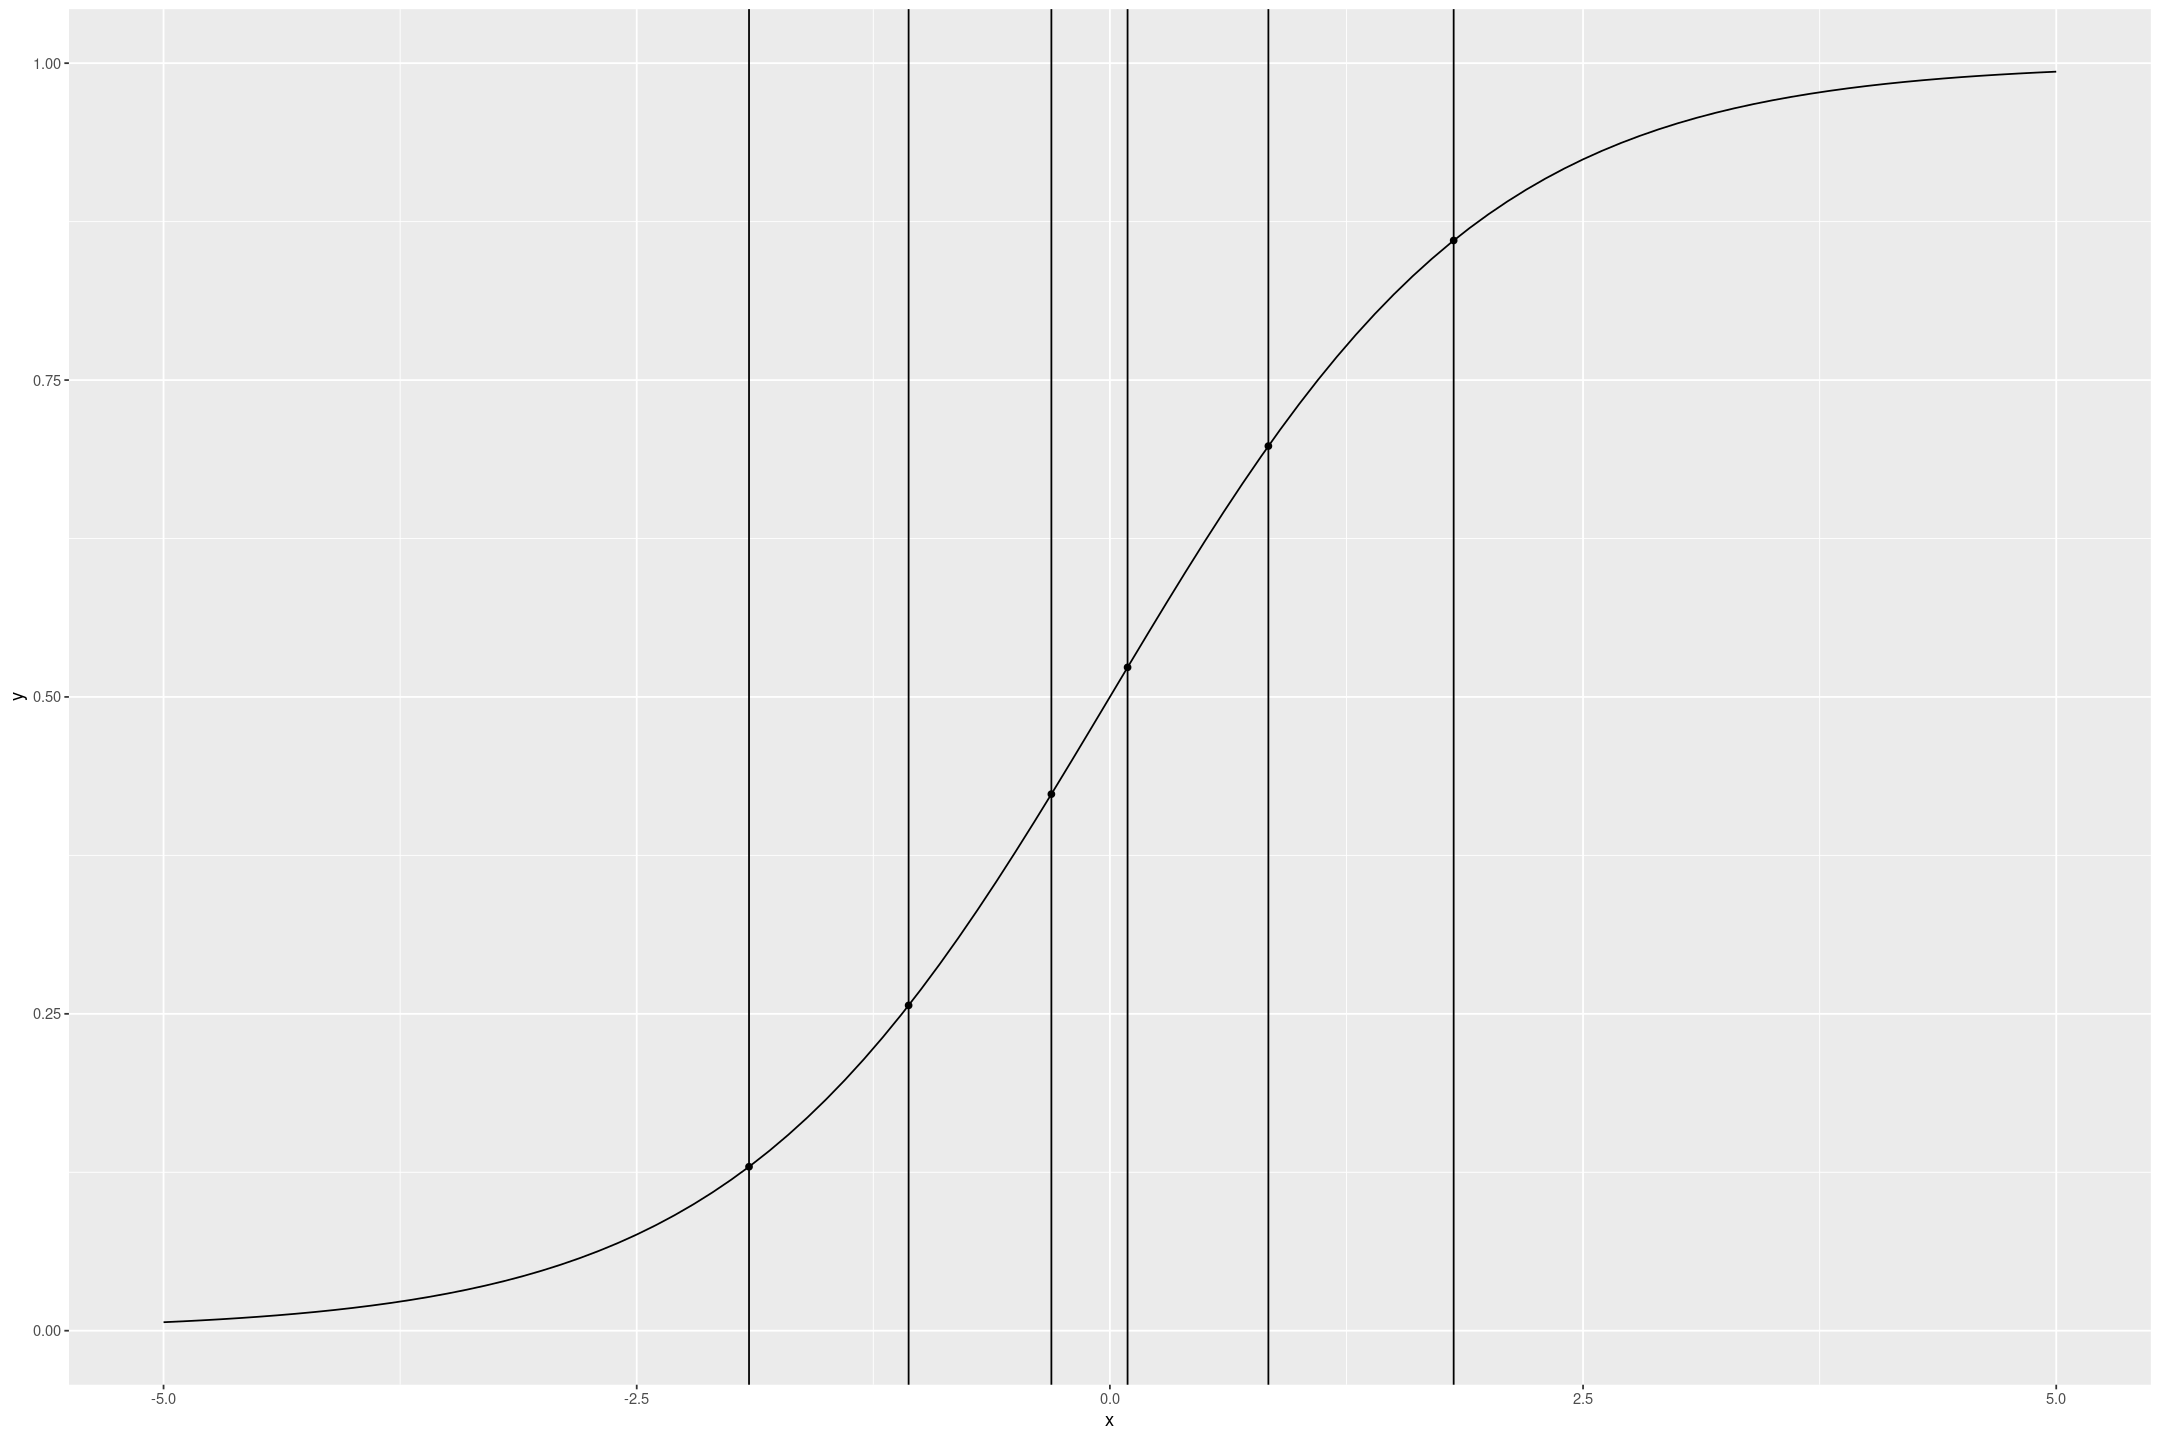

In [137]:
x <- seq(-5,5, by =0.1)
y <- invlogit(x)

gf_line(y ~ x) %>%
gf_vline(xintercept=~fit_nes_partyid$zeta) %>%
gf_point(invlogit(fit_nes_partyid$zeta)~fit_nes_partyid$zeta)

In [138]:
get_probs(cutpoints, 0) %>% scales::percent(1)

[1] "13%" "13%" "17%" "10%" "17%" "16%" "14%"

### Age

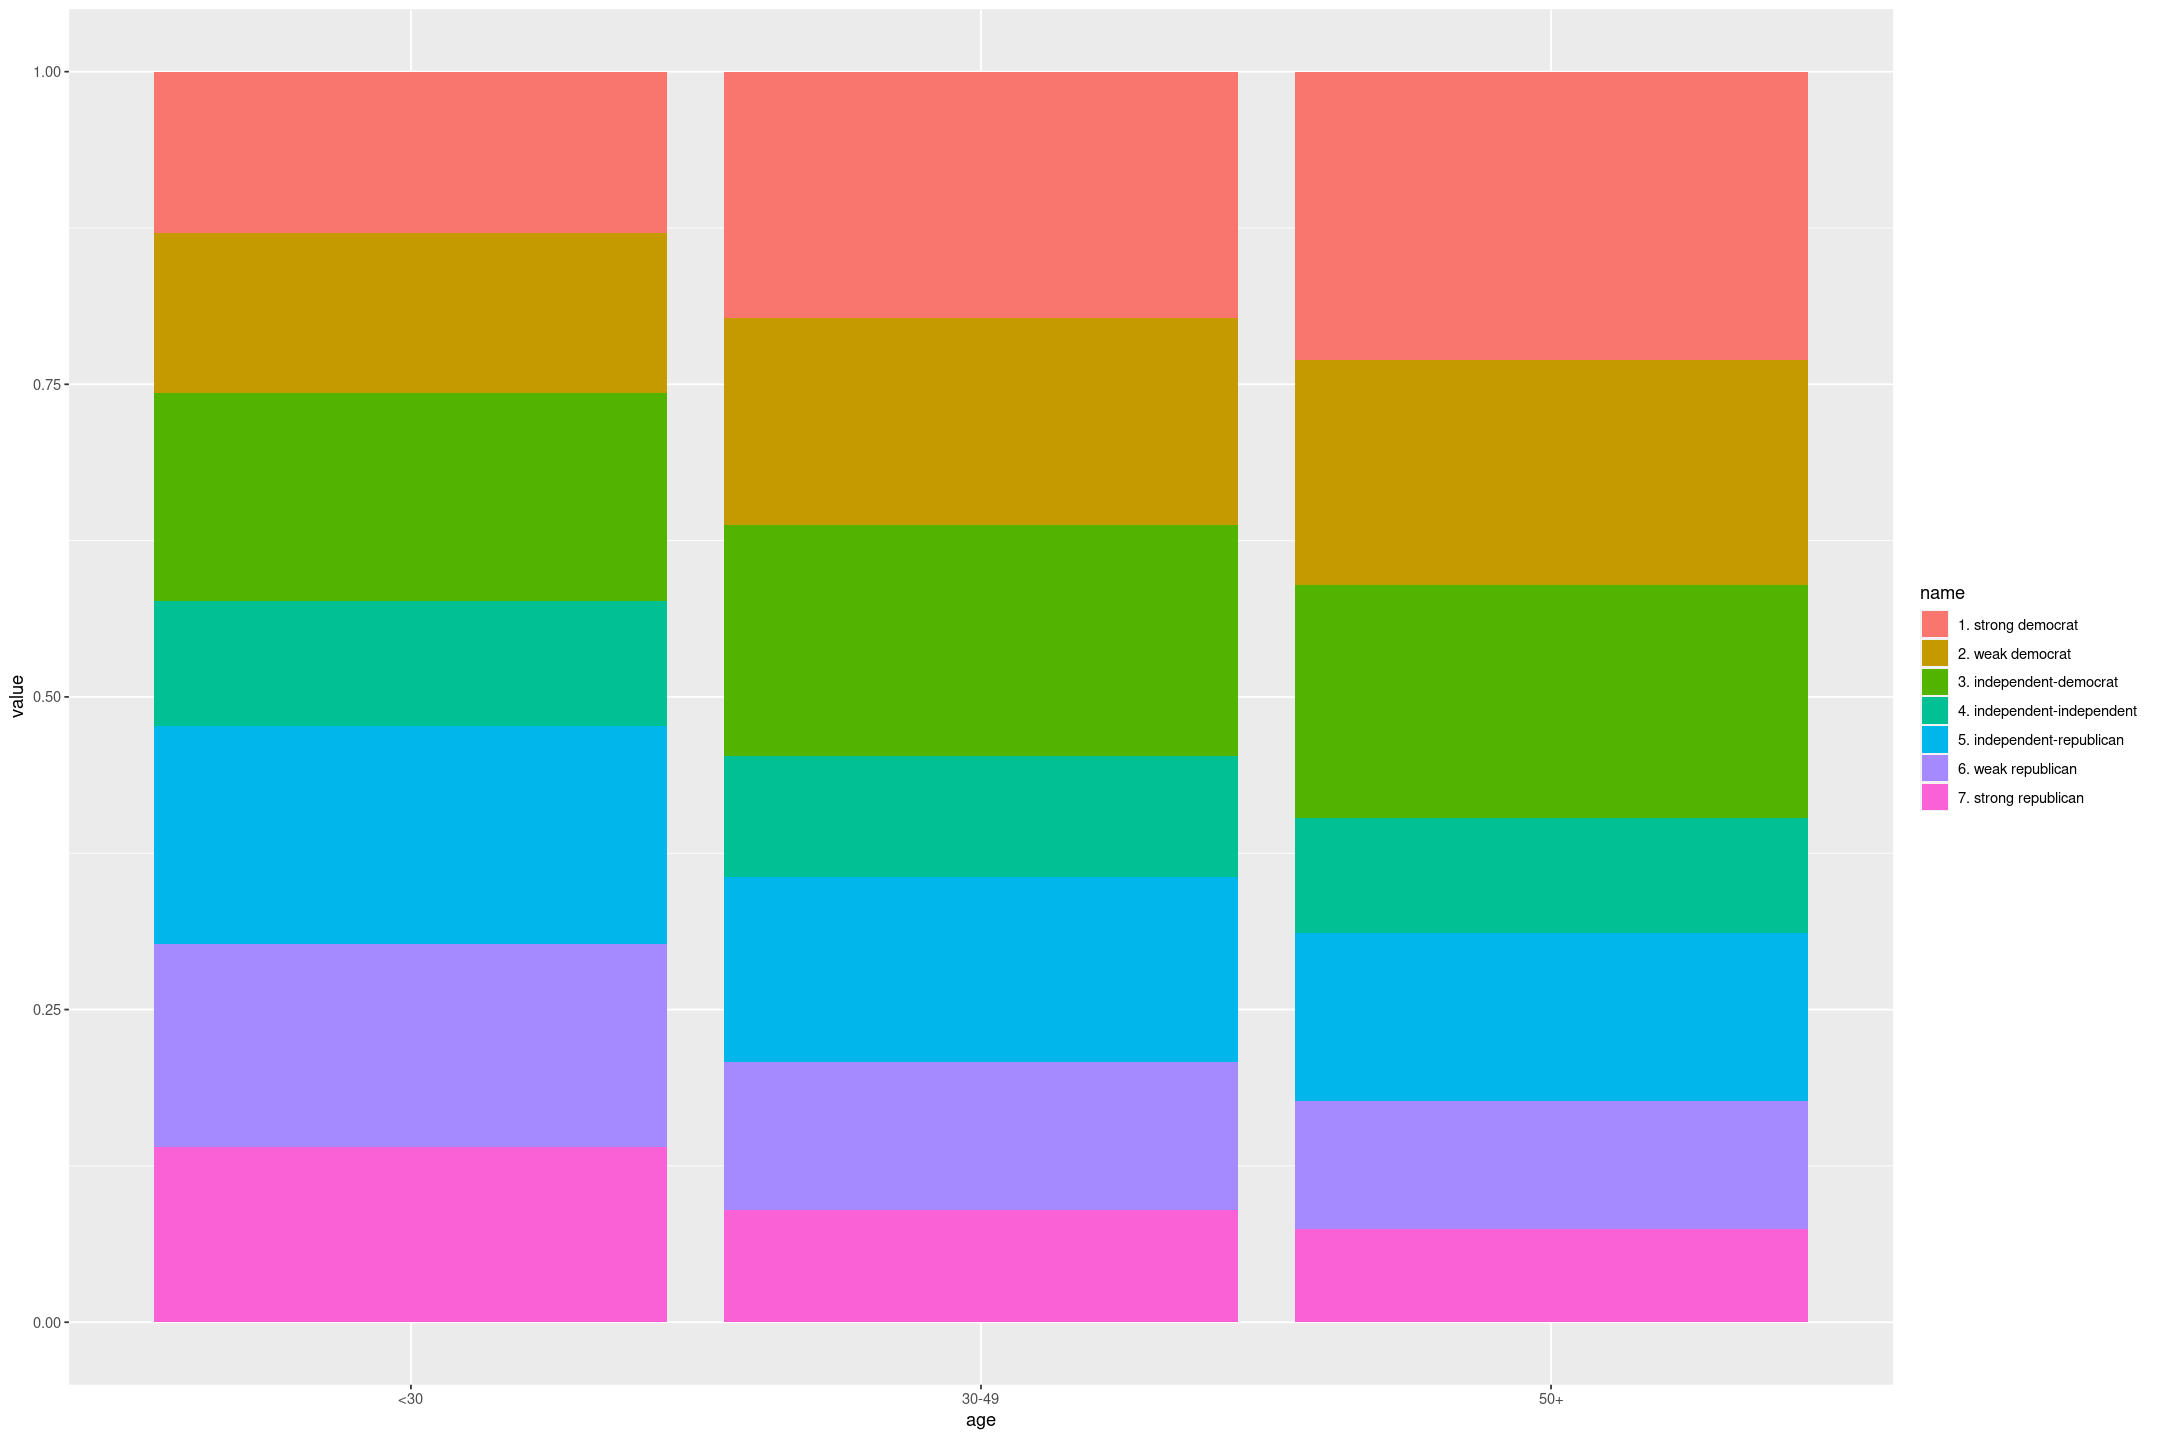

In [139]:
get_probs(cutpoints, c(0, -0.5, -0.7)) %>%
as.data.frame() %>%
cbind(age=c("<30", "30-49", "50+")) %>%
pivot_longer(-age) %>%
gf_col(value ~ age, fill=~name, group=~name, position="stack")

Being 30-49 brings roughly 6% of people from the strong republican to strong democrat

In [140]:
get_probs(cutpoints, -0.5) %>% scales::percent(1)

[1] "20%" "17%" "18%" "10%" "15%" "12%" "9%"

Being 50+ moves another few percent

In [141]:
get_probs(cutpoints, -0.7) %>% scales::percent(1)

[1] "23%" "18%" "19%" "9%"  "13%" "10%" "7%"

### Ideology

In [142]:
3.5/6

[1] 0.5833333

A slight ideology shift to the left is roughly equivalent to being in the 30-49 age group.

Note that the biggest gains are at the edges - strong.
The gains in the middle are moderated.

In [143]:
get_probs(cutpoints, coef(fit_nes_partyid)[['ideo_std']] * seq(-3/6,3/6,by=1/6)) %>%
as.data.frame() %>%
mutate_all(scales::percent, accuracy=1) %>%
cbind(ideo7=levels(nes2000_na$ideo7 %>% forcats::fct_drop())) 

1. strong democrat 2. weak democrat 3. independent-democrat
1 47%                20%              14%                    
2 33%                20%              18%                    
3 21%                17%              19%                    
4 13%                13%              17%                    
5 8%                 8%               13%                    
6 4%                 5%               9%                     
7 2%                 3%               6%                     
  4. independent-independent 5. independent-republican 6. weak republican
1 5%                         7%                        4%                
2 8%                         10%                       7%                
3 9%                         14%                       11%               
4 10%                        17%                       16%               
5 9%                         18%                       21%               
6 7%                         16%                       24%               
7 5%                         12%                       23%               
  7. strong republican ideo7                          
1 3%                   1. extremely liberal           
2 5%                   2. liberal                     
3 8%                   3. slightly liberal            
4 14%                  4. moderate, middle of the road
5 23%                  5. slightly conservative       
6 35%                  6. conservative                
7 49%                  7. extremely conservative

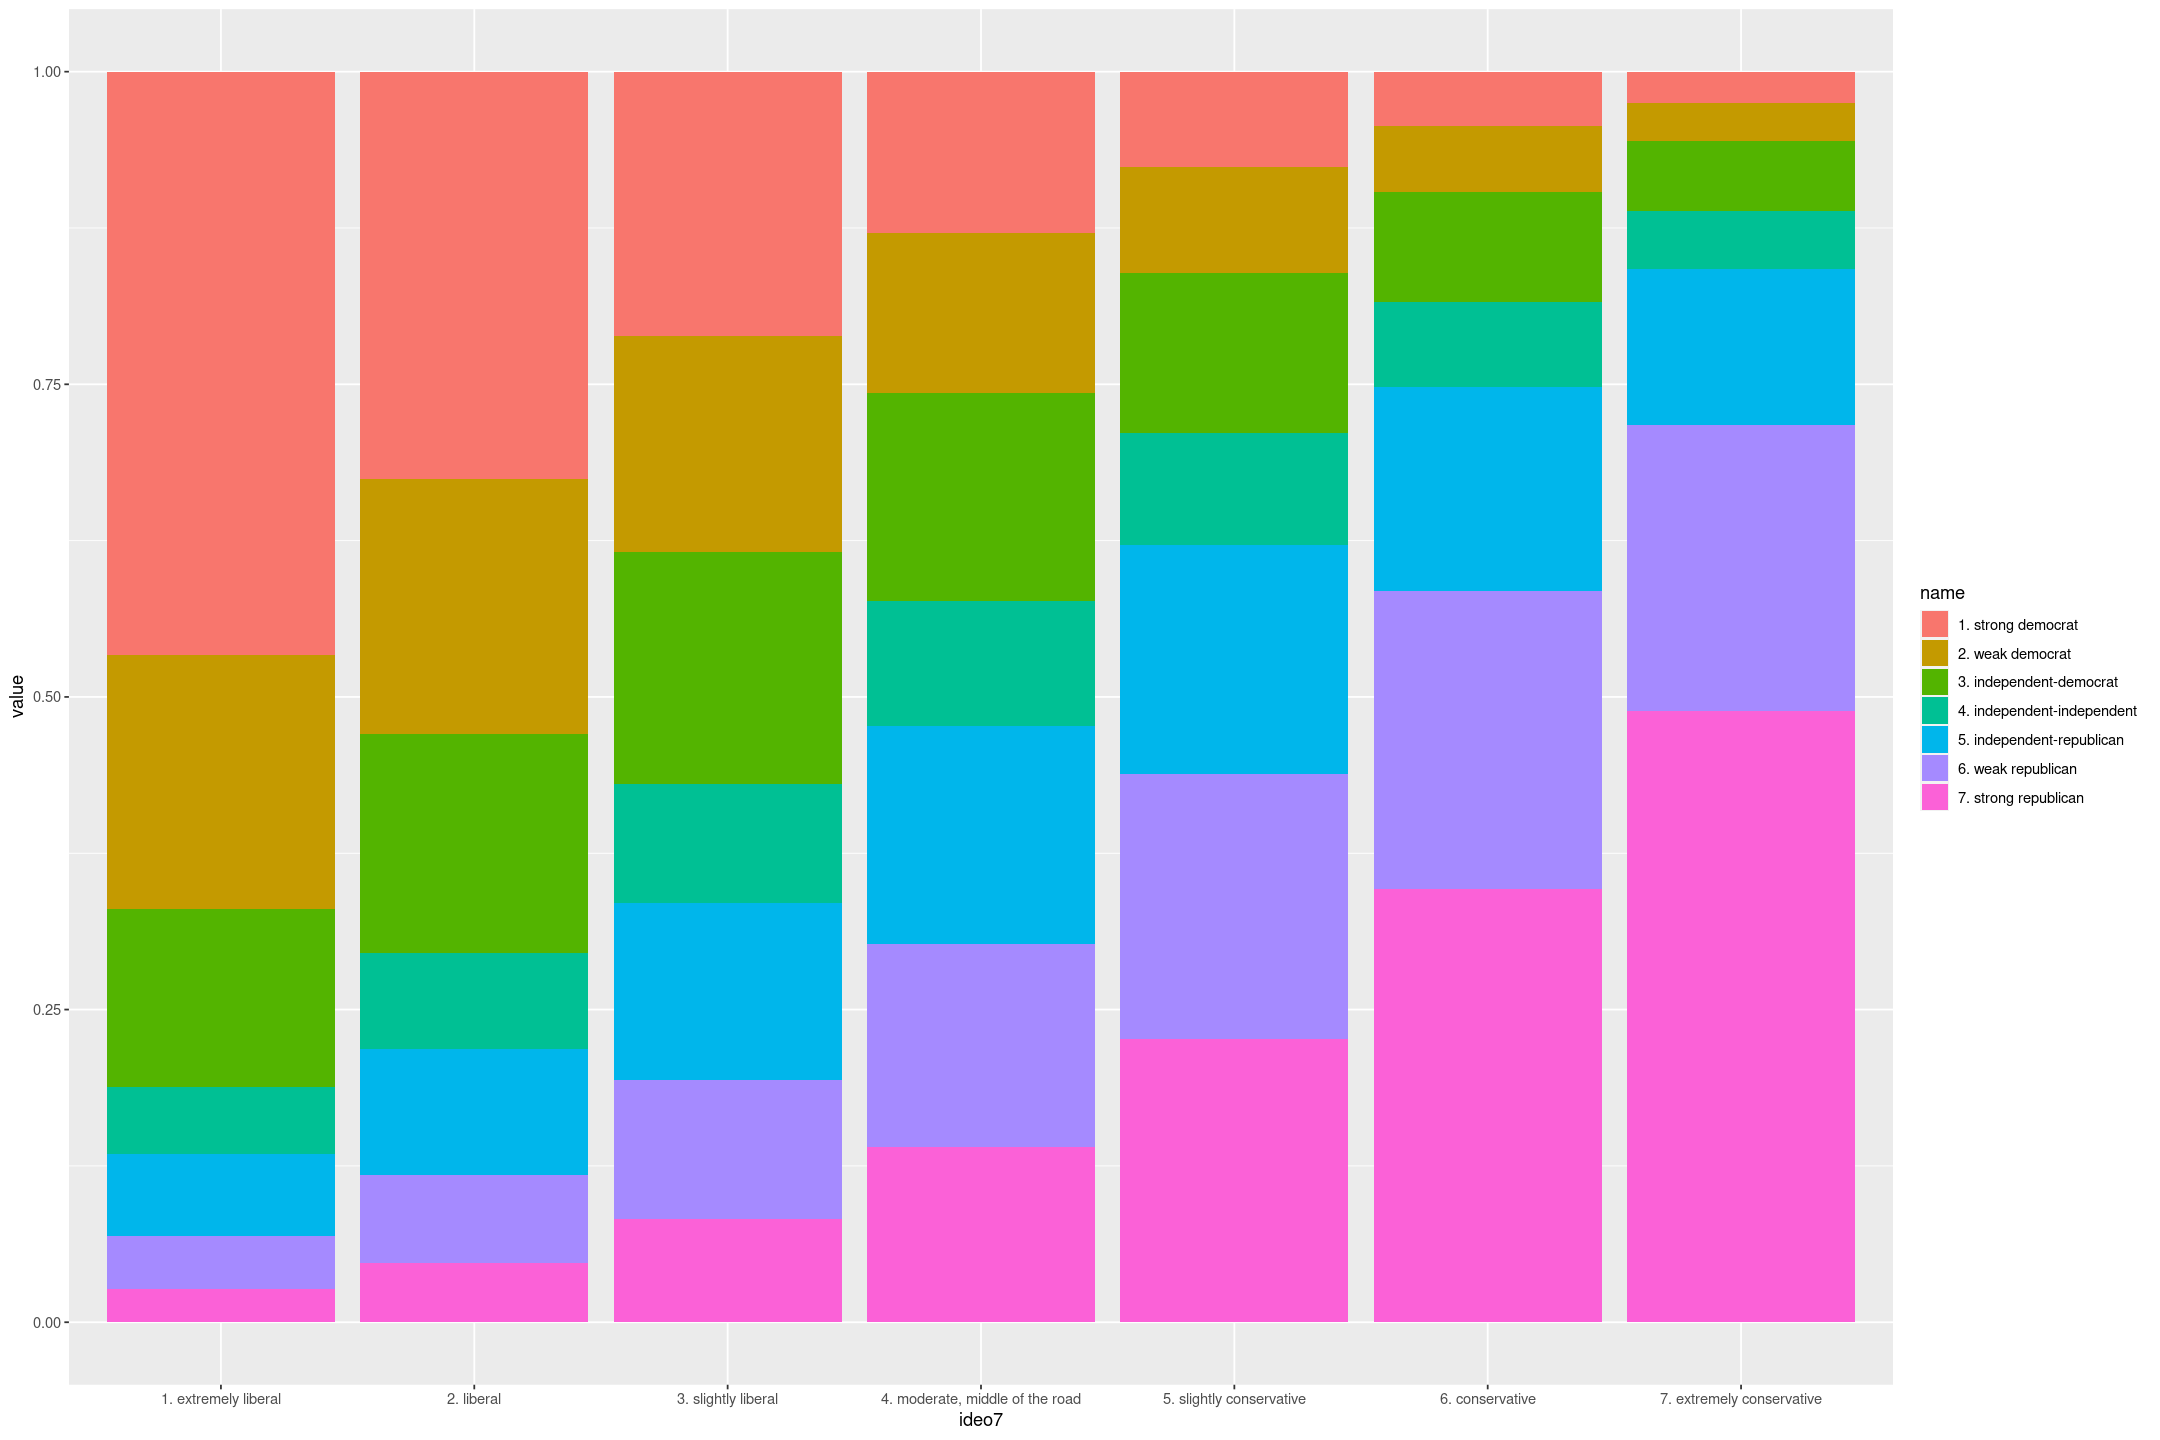

In [144]:
get_probs(cutpoints, coef(fit_nes_partyid)[['ideo_std']] * seq(-3/6,3/6,by=1/6)) %>%
as.data.frame() %>%
cbind(ideo7=levels(nes2000_na$ideo7 %>% forcats::fct_drop())) %>%
pivot_longer(-ideo7) %>%
gf_col(value ~ ideo7, fill=~name)

We can make similar interpretations for age and race.
It's not as insightful as the divide-by-4 rules.

An alternative view is looking at average predictive differences.

For example in general black voters on average (holding other values constant) are 22% more likely to be strong democrats, and roughly 8% less likely to be each kind of republican.

In [145]:
(get_probs(cutpoints, predict(fit_nes_partyid, newdata=nes2000_na %>% mutate(black=1))) - 
get_probs(cutpoints, predict(fit_nes_partyid)) ) %>%
as.data.frame() %>%
summarise_all(mean) %>%
mutate_all(scales::percent)

1. strong democrat 2. weak democrat 3. independent-democrat
1 22%                3%               -1%                    
  4. independent-independent 5. independent-republican 6. weak republican
1 -2%                        -6%                       -7%               
  7. strong republican
1 -9%

Whereas for hispanics it's just 7%, and 3%.

In [146]:
(get_probs(cutpoints, predict(fit_nes_partyid, newdata=nes2000_na %>% mutate(hispanic=1))) - 
get_probs(cutpoints, predict(fit_nes_partyid)) ) %>%
as.data.frame() %>%
summarise_all(mean) %>%
mutate_all(scales::percent)

1. strong democrat 2. weak democrat 3. independent-democrat
1 6%                 2%               0%                     
  4. independent-independent 5. independent-republican 6. weak republican
1 0%                         -2%                       -3%               
  7. strong republican
1 -4%

Wherate voters in the 68th-95th percentile are roughly 2% more likely to be any kind of republican, and 4% less likely to be a strong democrat.

In [147]:
(get_probs(cutpoints, predict(fit_nes_partyid, newdata=nes2000_na %>% mutate(income_std=0.25))) - 
get_probs(cutpoints, predict(fit_nes_partyid)) ) %>%
as.data.frame() %>%
summarise_all(mean) %>%
mutate_all(scales::percent)

1. strong democrat 2. weak democrat 3. independent-democrat
1 -4%                -1%              0%                     
  4. independent-independent 5. independent-republican 6. weak republican
1 0%                         1%                        2%                
  7. strong republican
1 3%

## Model fit
Use a binned residual plot to assess the fit of the model

How do I draw a residual?

One way is to draw a residual for the predictions at each category against all others.
These residuals look all the be downward skewed which may indicate some misfit.

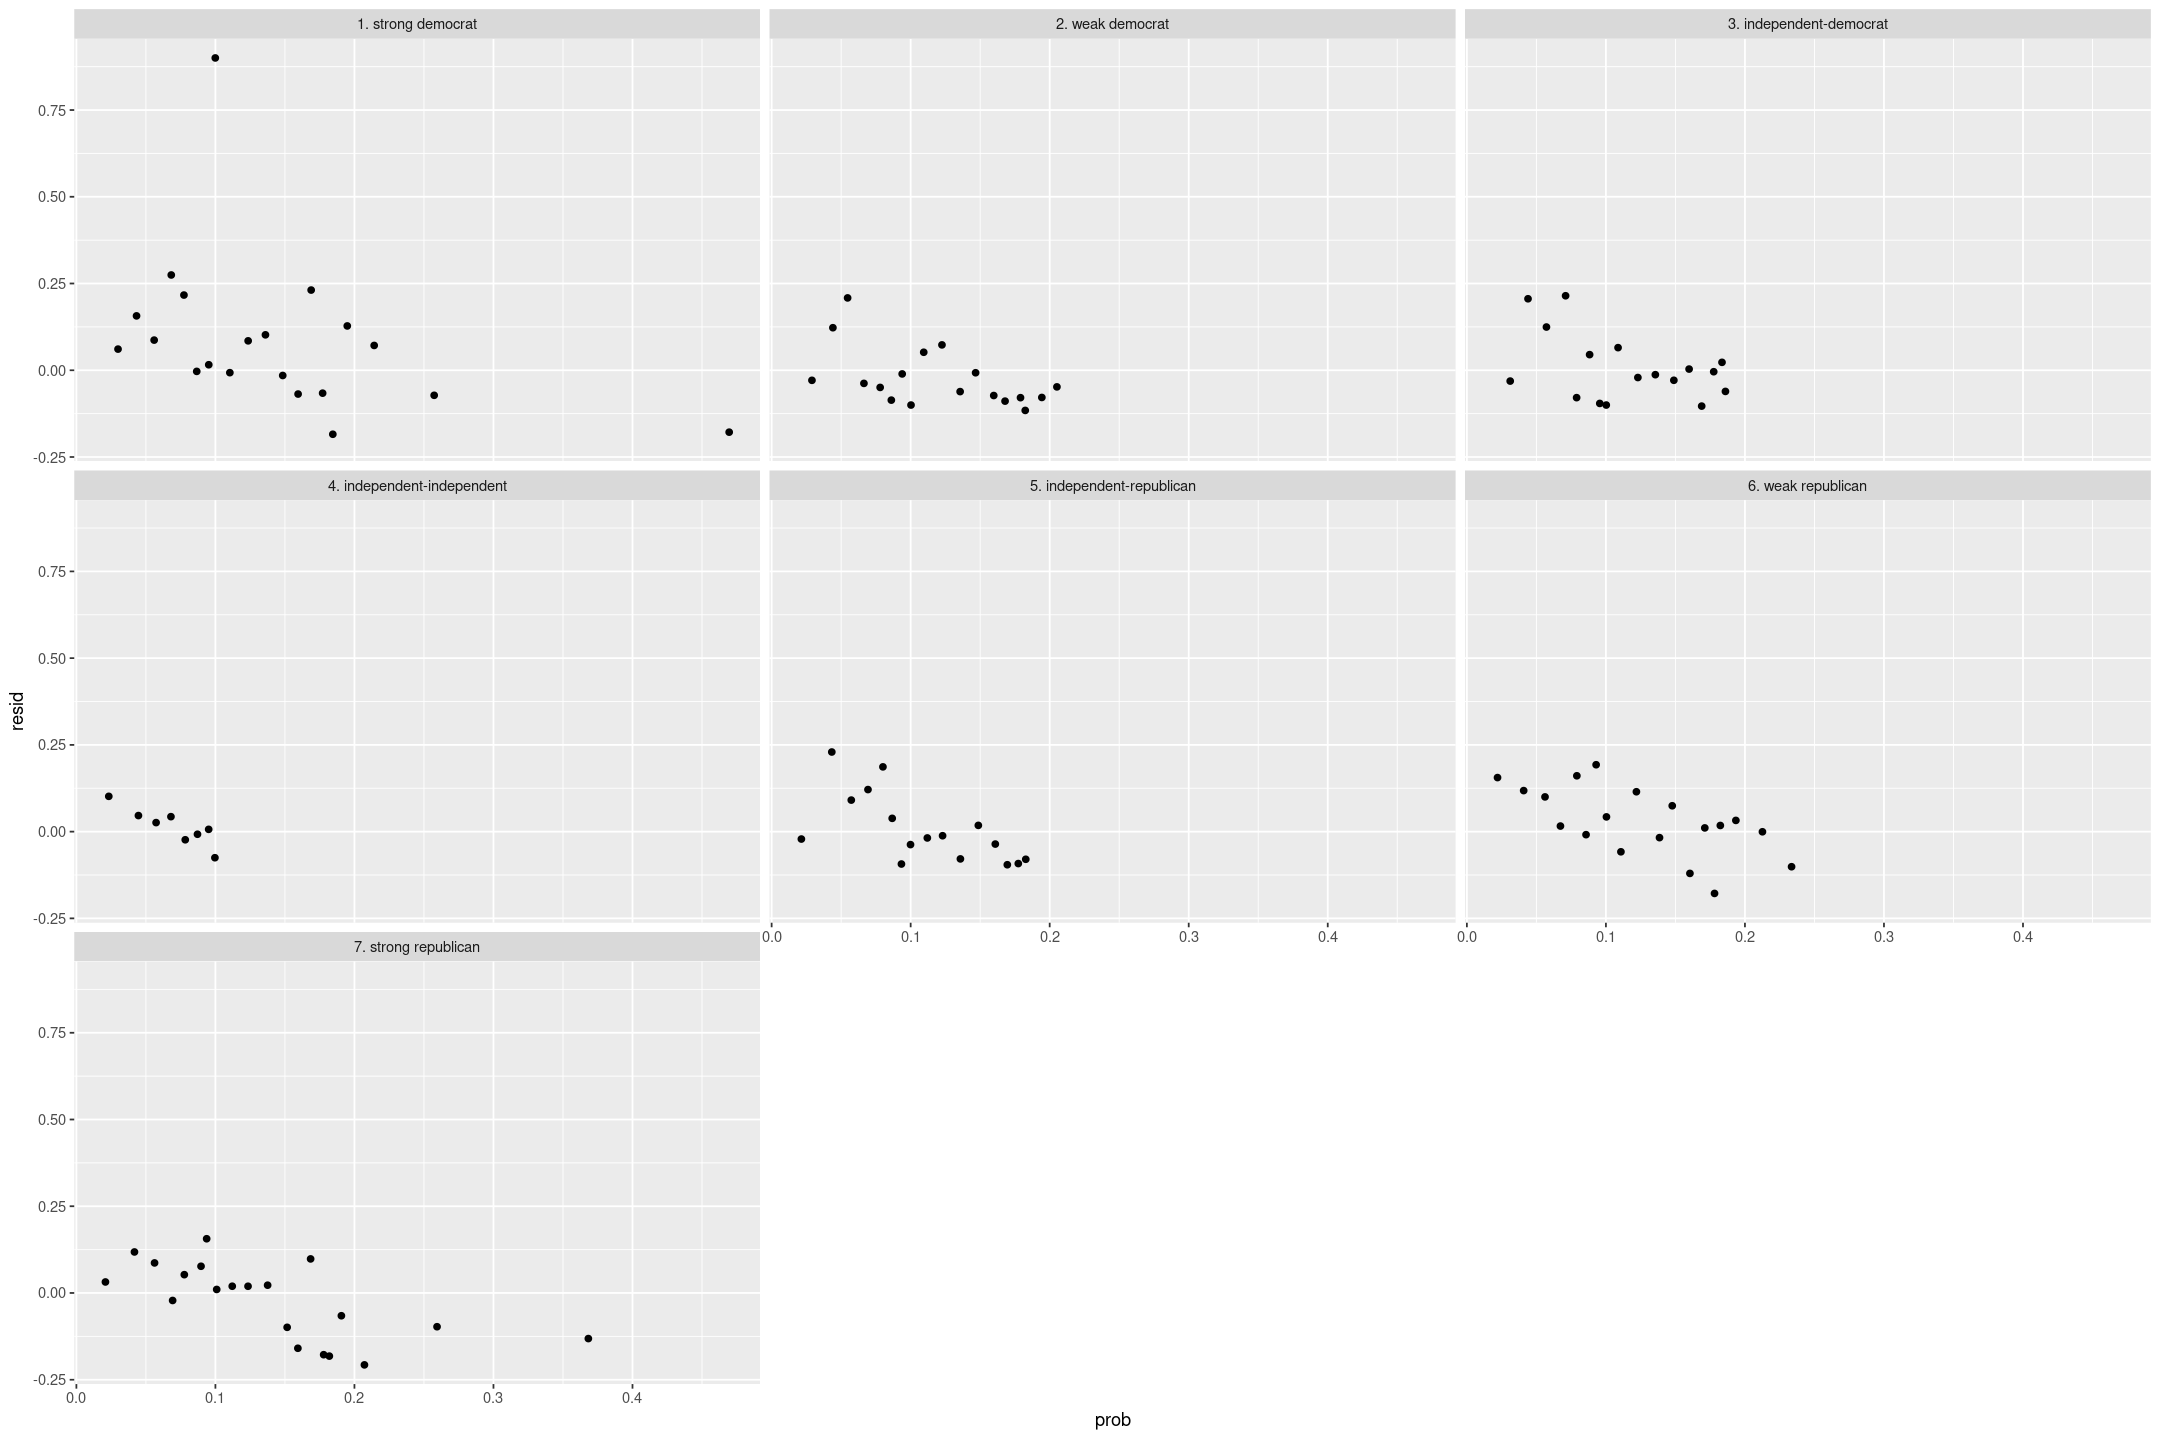

In [148]:
get_probs(fit_nes_partyid$zeta, predict(fit_nes_partyid)) %>%
as.data.frame() %>%
pivot_longer(everything(), names_to="pred", values_to="prob") %>%
cbind(actual=nes2000_na$partyid7) %>%
mutate(correct=pred == actual) %>%
group_by(pred, bin=cut_quantile(prob, 20)) %>%
summarise(prob=mean(prob), actual=mean(correct), .groups="drop") %>%
mutate(resid = actual - prob) %>%
gf_point(resid ~ prob | pred)

Perhaps another way would be to look at predicted quantiles?

# Comparing logit and probit

Take one of the data examples from Chapter 13 or 14.
Fit these data using both logit and probit models.
Check that the results are essentially the same after scaling by factor of 1.6.

In [149]:
filename <- 'data/nes/nes5200_processed_voters_realideo.dta'

download_if_missing(filename, 'https://raw.githubusercontent.com/avehtari/ROS-Examples/master/NES/data/nes5200_processed_voters_realideo.dta')

nes <- foreign::read.dta(filename)

In [150]:
nes92 <- 
nes %>%
filter(year == 1992) %>%
# Only people who actually voted republican or democrat
filter(!is.na(presvote_2party)) %>%
transmute(#year is 1992,
          #resid: Respondent id - only useful for longitudinal, all distinct
          # weight1,..3: Demographic weights? Not useful
    age= age,
    gender=gender,
    race=race,
    # educ1, use educ3 instead
    urban=urban,
    region=region,
    income=income,
    # occup1 is VCF0115, replaced by occup2 VCF0151 which has more information (see codebook)
    union=union,
    religion=religion,
    education=educ3,
    marital_status = martial_status, # Note the Freudian slip
    occupation = occup2,
    # icpsr_cty - is NA
    #fips_cty,   - interesting, but need to join to external data sources to make useful
    # partyid7 - is just partyid3_b x str_partyid
    # partyid3 just separates out independent from unknown, few differences in 1992
    party = partyid3_b,
    partisan = str_partyid,
    father_party,
    mother_party,
    dlikes,
    rlikes,
    dem_therm,
    rep_therm,
    #regis - NA
    rvote = presvote_2party == '2. republican',
    ideology = ideo7, # ideo is just a summary
    ## There are some more columns, but enough for now
) %>%
select(-father_party, -mother_party) %>%
filter_all(~!is.na(.))  %>%
mutate(income_int = as.integer(income) - 1,
       income_int_std = (income_int - mean(income_int))/(2*sd(income_int)),
       advanced_degree = education == '7. advanced degrees incl. llb',
       education_cts = (as.integer(education) - 5)/6,
       ideology_int = (as.numeric(ideology) - 5)/6,
       ideology3 = if_else(ideology_int < 0, "liberal", if_else(ideology_int > 0, "conservative", "moderate")))

In [151]:
(fit_nes_interactions_subset <- 
 stan_glm(rvote ~ income_int_std + gender + race + region + religion + education_cts 
                + advanced_degree + party + ideology3 +
                 gender : party,
        family=binomial(link="logit"),
        data=nes92,
           refresh=0))

stan_glm
 family:       binomial [logit]
 formula:      rvote ~ income_int_std + gender + race + region + religion + 
	   education_cts + advanced_degree + party + ideology3 + gender:party
 observations: 1090
 predictors:   21
------
                                                              Median MAD_SD
(Intercept)                                                   -2.5    0.5  
income_int_std                                                -0.1    0.2  
gender2. female                                                1.2    0.4  
race2. black                                                  -2.0    0.5  
race3. asian                                                   0.4    0.9  
race4. native american                                         0.6    0.6  
race5. hispanic                                                1.1    0.5  
region2. north central(il,in,ia,ks,mi,mn,mo,ne                 0.3    0.3  
region3. south (al,ar,de,d.c.,fl,ga,ky,la,md,m                 0.3    0.3  
region

Note that we need to tighten the prior to [get the chains to converge](https://discourse.mc-stan.org/t/default-prior-for-probit-regression-with-many-predictors-fails-to-sample/23959)

In [152]:
(fit_nes_interactions_subset_probit <- 
 stan_glm(rvote ~ income_int_std + gender + race + region + religion + education_cts 
                + advanced_degree + party + ideology3 +
                 gender : party,
        prior=normal(scale=0.5, autoscale=TRUE),
        family=binomial(link="probit"),
        data=nes92,
         refresh=0))

stan_glm
 family:       binomial [probit]
 formula:      rvote ~ income_int_std + gender + race + region + religion + 
	   education_cts + advanced_degree + party + ideology3 + gender:party
 observations: 1090
 predictors:   21
------
                                                              Median MAD_SD
(Intercept)                                                   -1.3    0.2  
income_int_std                                                 0.0    0.1  
gender2. female                                                0.6    0.2  
race2. black                                                  -1.0    0.2  
race3. asian                                                   0.2    0.5  
race4. native american                                         0.3    0.3  
race5. hispanic                                                0.6    0.3  
region2. north central(il,in,ia,ks,mi,mn,mo,ne                 0.1    0.2  
region3. south (al,ar,de,d.c.,fl,ga,ky,la,md,m                 0.1    0.2  
regio

The coefficients are close, typically within half a standard error, and the standard errors are close too.

However there are some outliers - like `party3. republicans (including leaners)` which is a couple of standard deviations apart.

In [153]:
cbind(logit_coef=coef(fit_nes_interactions_subset),
      scaled_probit_coef=coef(fit_nes_interactions_subset_probit) * 1.6,
      logit_se=se(fit_nes_interactions_subset),
      scaled_probit_se=se(fit_nes_interactions_subset_probit)*1.6) %>%
round(2)

logit_coef
(Intercept)                                                   -2.45     
income_int_std                                                -0.08     
gender2. female                                                1.19     
race2. black                                                  -1.96     
race3. asian                                                   0.45     
race4. native american                                         0.62     
race5. hispanic                                                1.06     
region2. north central(il,in,ia,ks,mi,mn,mo,ne                 0.32     
region3. south (al,ar,de,d.c.,fl,ga,ky,la,md,m                 0.32     
region4. west (ak,az,ca,co,hi,id,mt,nv,nm,or,u                -0.12     
religion2. catholic (roman catholic)                          -0.02     
religion3. jewish                                             -1.80     
religion4. other and none (also includes dk pref              -0.90     
education_cts                                                  1.03     
advanced_degreeTRUE                                           -0.66     
party2. indpendents and apolitical (1966 only                  1.90     
party3. republicans (including leaners)                        5.19     
ideology3liberal                                              -1.71     
ideology3moderate                                             -0.77     
gender2. female:party2. indpendents and apolitical (1966 only  0.28     
gender2. female:party3. republicans (including leaners)       -1.62     
                                                              scaled_probit_coef
(Intercept)                                                   -2.02             
income_int_std                                                -0.08             
gender2. female                                                0.92             
race2. black                                                  -1.58             
race3. asian                                                   0.28             
race4. native american                                         0.53             
race5. hispanic                                                0.90             
region2. north central(il,in,ia,ks,mi,mn,mo,ne                 0.18             
region3. south (al,ar,de,d.c.,fl,ga,ky,la,md,m                 0.17             
region4. west (ak,az,ca,co,hi,id,mt,nv,nm,or,u                -0.20             
religion2. catholic (roman catholic)                          -0.07             
religion3. jewish                                             -1.62             
religion4. other and none (also includes dk pref              -0.74             
education_cts                                                  0.89             
advanced_degreeTRUE                                           -0.56             
party2. indpendents and apolitical (1966 only                  1.50             
party3. republicans (including leaners)                        4.47             
ideology3liberal                                              -1.47             
ideology3moderate                                             -0.65             
gender2. female:party2. indpendents and apolitical (1966 only  0.43             
gender2. female:party3. republicans (including leaners)       -1.18             
                                                              logit_se
(Intercept)                                                   0.47    
income_int_std                                                0.23    
gender2. female                                               0.38    
race2. black                                                  0.49    
race3. asian                                                  0.93    
race4. native american                                        0.61    
race5. hispanic                                               0.48    
region2. north central(il,in,ia,ks,mi,mn,mo,ne                0.32    
region3. south (al,ar,de,d.c.,fl,ga

# Comparing logit and probit

Construct a dataset where the logit and probit models give clearly *different* estimates, not just different by a factor of 1.6.

The normal distribution differs from the logit in that it goes to zero much faster at large values.
So intuitively looking near the edge of the distribution (near 0 or 1) we're likely to get different results.

In [154]:
N <- 10000
fake_data <- tibble(a=rbinom(N,1,0.5),
                    b=rbinom(N,1,0.5),
                    y=as.double(rnorm(N) + 3*a - 4*b > 0))

In [155]:
table(fake_data$y)


   0    1 
5925 4075 

In [156]:
fit_probit <- rstanarm::stan_glm(y ~ a + b,
                          family=binomial(link="probit"),
                          data=fake_data,
                           refresh=0)

In [157]:
fit_probit

stan_glm
 family:       binomial [probit]
 formula:      y ~ a + b
 observations: 10000
 predictors:   3
------
            Median MAD_SD
(Intercept)  0.0    0.0  
a            3.0    0.2  
b           -4.0    0.2  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

In [158]:
fit_logit <- rstanarm::stan_glm(y ~ a + b,
                          family=binomial(link="logit"),
                          data=fake_data)

In [159]:
fit_logit

stan_glm
 family:       binomial [logit]
 formula:      y ~ a + b
 observations: 10000
 predictors:   3
------
            Median MAD_SD
(Intercept) -0.1    0.0  
a            6.6    0.5  
b           -8.2    0.5  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

While the intercepts (near 50%) are similar, the rscaled coefficients for a and b near opposite edges of the data are very different, with different standard errors.

In [160]:
cbind(logit_coef=coef(fit_logit),
      probit_coef_rescaled=coef(fit_probit)*1.6,
      logit_se=se(fit_logit),
      probit_se_rescaled=se(fit_probit)*1.6)

logit_coef probit_coef_rescaled logit_se   probit_se_rescaled
(Intercept) -0.0524599 -0.0521242           0.03901448 0.04011113        
a            6.5832897  4.8042253           0.46633895 0.24059618        
b           -8.2464859 -6.3916810           0.46683723 0.24682980

Note in this case it's much faster to fit on the binomial counts:

In [161]:
(fake_counts <- fake_data %>% group_by(a,b) %>% summarise(y=sum(y), n=n(), .groups="drop"))

a b y    n   
1 0 0 1208 2481
2 0 1    0 2482
3 1 0 2476 2480
4 1 1  391 2557

In [162]:
(fit_logit_counts <- rstanarm::stan_glm(cbind(y, n-y) ~ a + b, family=binomial(link="probit"), data=fake_counts))

stan_glm
 family:       binomial [probit]
 formula:      cbind(y, n - y) ~ a + b
 observations: 4
 predictors:   3
------
            Median MAD_SD
(Intercept)  0.0    0.0  
a            3.0    0.2  
b           -4.0    0.2  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

In [163]:
(fit_logit_counts <- rstanarm::stan_glm(cbind(y, n-y) ~ a + b, family=binomial(link="logit"), data=fake_counts))

stan_glm
 family:       binomial [logit]
 formula:      cbind(y, n - y) ~ a + b
 observations: 4
 predictors:   3
------
            Median MAD_SD
(Intercept) -0.1    0.0  
a            6.6    0.5  
b           -8.2    0.5  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

# Tobit model for mixed discrete/continuous data

Experimental data from the National Supported Work example are in the folder [`Lalonde`](https://github.com/avehtari/ROS-Examples/tree/master/Lalonde).
Use the treatment indicator and pre-treatment variable to predict post-treatment (1978) earnings using a Tobit model.
Interpret the model coefficients.

The underlying data comes from [*Propensity Score-Matching Methods for Nonexperimental Causal Studies*](https://direct.mit.edu/rest/article/84/1/151/57311/Propensity-Score-Matching-Methods-for) by Dehejia and Wahba, who renalyse data from [*Evaluating  the  Econometric Evaluations  of  Training  Programs  with  Experimental  Data*](http://business.baylor.edu/scott_cunningham/teaching/lalonde-1986.pdf) by Lalonde, based the National Supported Work experiment.

From Lalonde's paper:

> The National Supported  Work  Demonstration (NSW) was a temporary  employment program designed to help disadvantaged workers lacking basic job skills move  into  the  labor  market by giving them work experience and counseling in a sheltered environment.
> Unlike other  federally  sponsored employment and training  programs, the  NSW  program  assigned  qualified  applicants  to  training  positions  randomly. 
> Those assigned  to  the  treatment group  received  all the benefits  of  the NSW program, while those assigned to the  control  group  were  left to fend  for themselves.

Lalonde presents an estimate of the effect by comparing the treatment to a control group.
Then this is compared with stanard econometric techniques of comparing to a broader similar non-control sample (from the Population Survey of Income Dynamics and the Current Population Survey), adjusting for demographic variables with linear regression.
The econometric techniques give a very poor estimate of the effect.

The Dehejia and Wahba paper use a method of *propensity matching* to find appropriate comparison groups.
It seems like they try to calculate the probability an observation in the comparison group would have been treated using logistic regression on the observed variables.
Then they pair samples/controls based on ones that have a similar predicted probability (with or without replacement).
They claim this gives similar outcomes results to comparing with the experimental control group.

The underlying data is available on [Rajeev Dehejia's website](https://users.nber.org/~rdehejia/nswdata2.html) - which is fantastic!
This is a sample of it.

### Examining the data

From the codebook:

The following variables are included in the NSW data set from the Dehejia/Wahba paper.
The dataset you are given only includes

1.	sample: 1 = NSW; 2 = CPS; 3 = PSID.
2.	treat: 1 = experimental treatment group (NSW); 0 = comparison group (either from CPS or PSID)   Treatment took place in 1976/1977.
3.	age  = age in years
4.	educ = years of schooling
5.	black: 1 if black; 0 otherwise.
6.	hisp: 1 if Hispanic; 0 otherwise.
7.	married: 1 if married; 0 otherwise.
8.	nodegree: 1 if no high school diploma; 0 otherwise.
9.	re74, re75, re78: real earnings in 1974, 1975 and 1978
10.	educ_cat = 4 category education variable (1=<hs, 2=hs, 3=sm college, 4=college)

In [164]:
filename <- 'data/Lalonde/NSW_dw_obs.dta'

download_if_missing(filename, 'https://raw.githubusercontent.com/avehtari/ROS-Examples/master/Lalonde/NSW_dw_obs.dta')

lalonde <- foreign::read.dta(filename)

 The  earnings 
of  the  experimental  groups were the same in 
the  pre-training  year  1975

In [165]:
lalonde %>% head()

age educ black married nodegree re74      re75      re78       hisp sample
1 42  16   0     1       0            0.000     0.000   100.4854 0    2     
2 20  13   0     0       0         2366.794  3317.468  4793.7451 0    2     
3 37  12   0     1       0        25862.322 22781.855 25564.6699 0    2     
4 48  12   0     1       0        21591.121 20839.355 20550.7441 0    2     
5 51  12   0     1       0        21395.193 21575.178 22783.5879 0    2     
6 18  11   0     0       1         1310.750  1455.532  2157.4807 0    2     
  treat educ_cat4
1 0     4        
2 0     3        
3 0     2        
4 0     2        
5 0     2        
6 0     1

Notice the spikes near 0 and 25000.

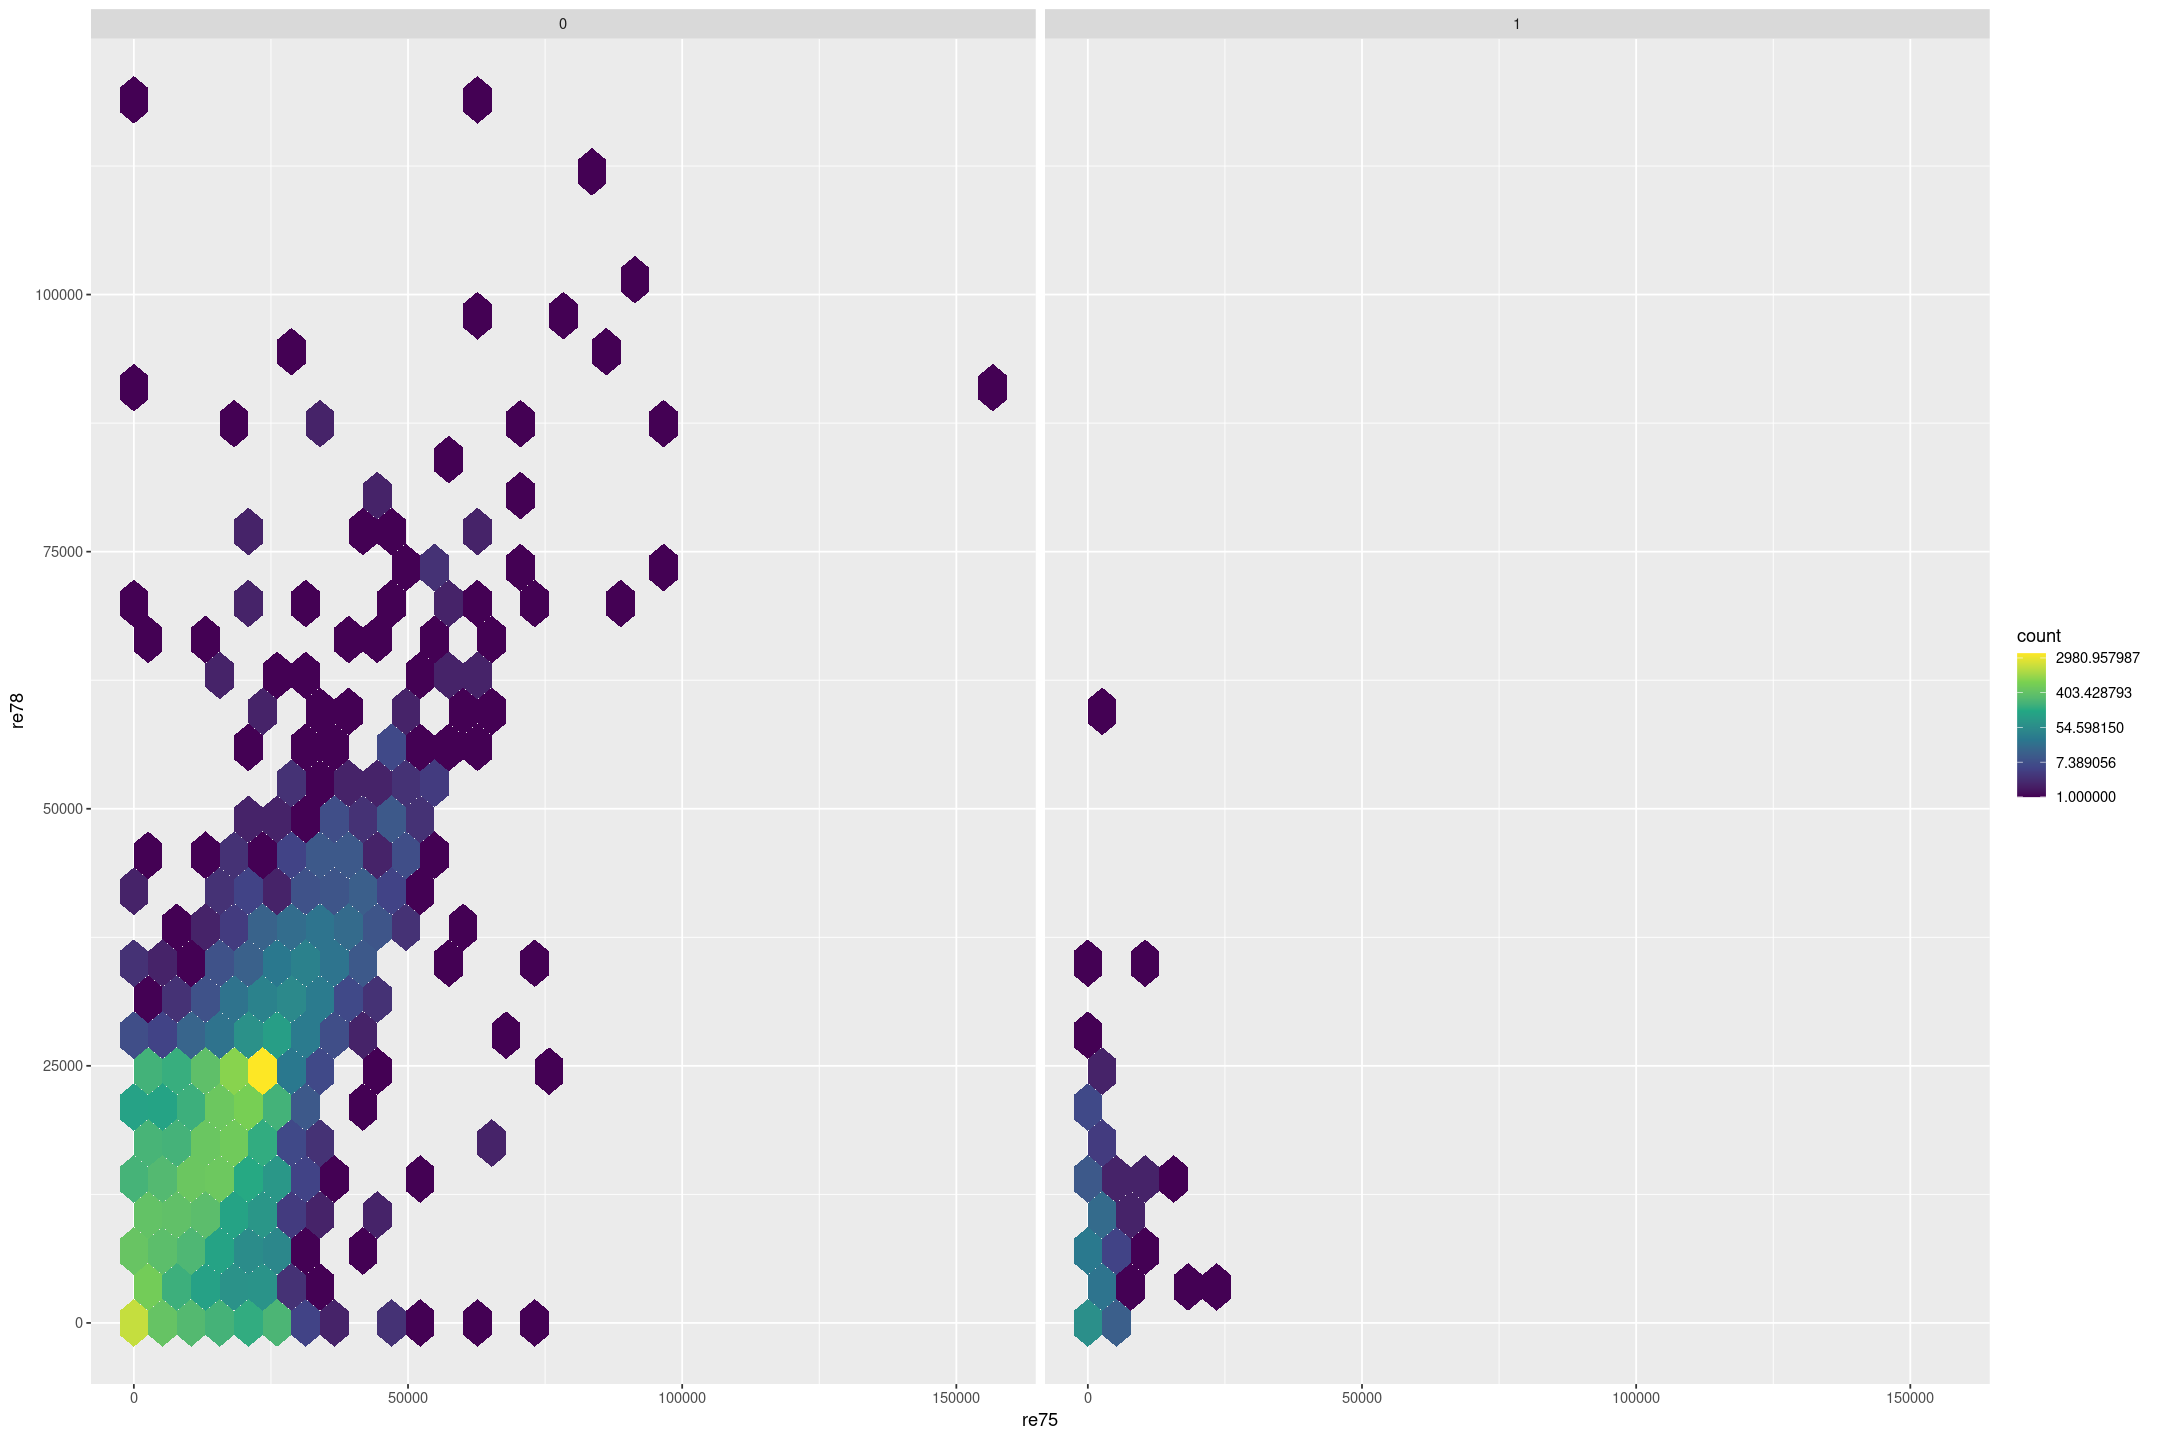

In [166]:
lalonde %>% 
gf_hex(re78 ~ re75 | treat) + scale_fill_viridis_c(trans = "log")

It looks like the CPS study is censored from above - if we wanted to be careful we would include that too!

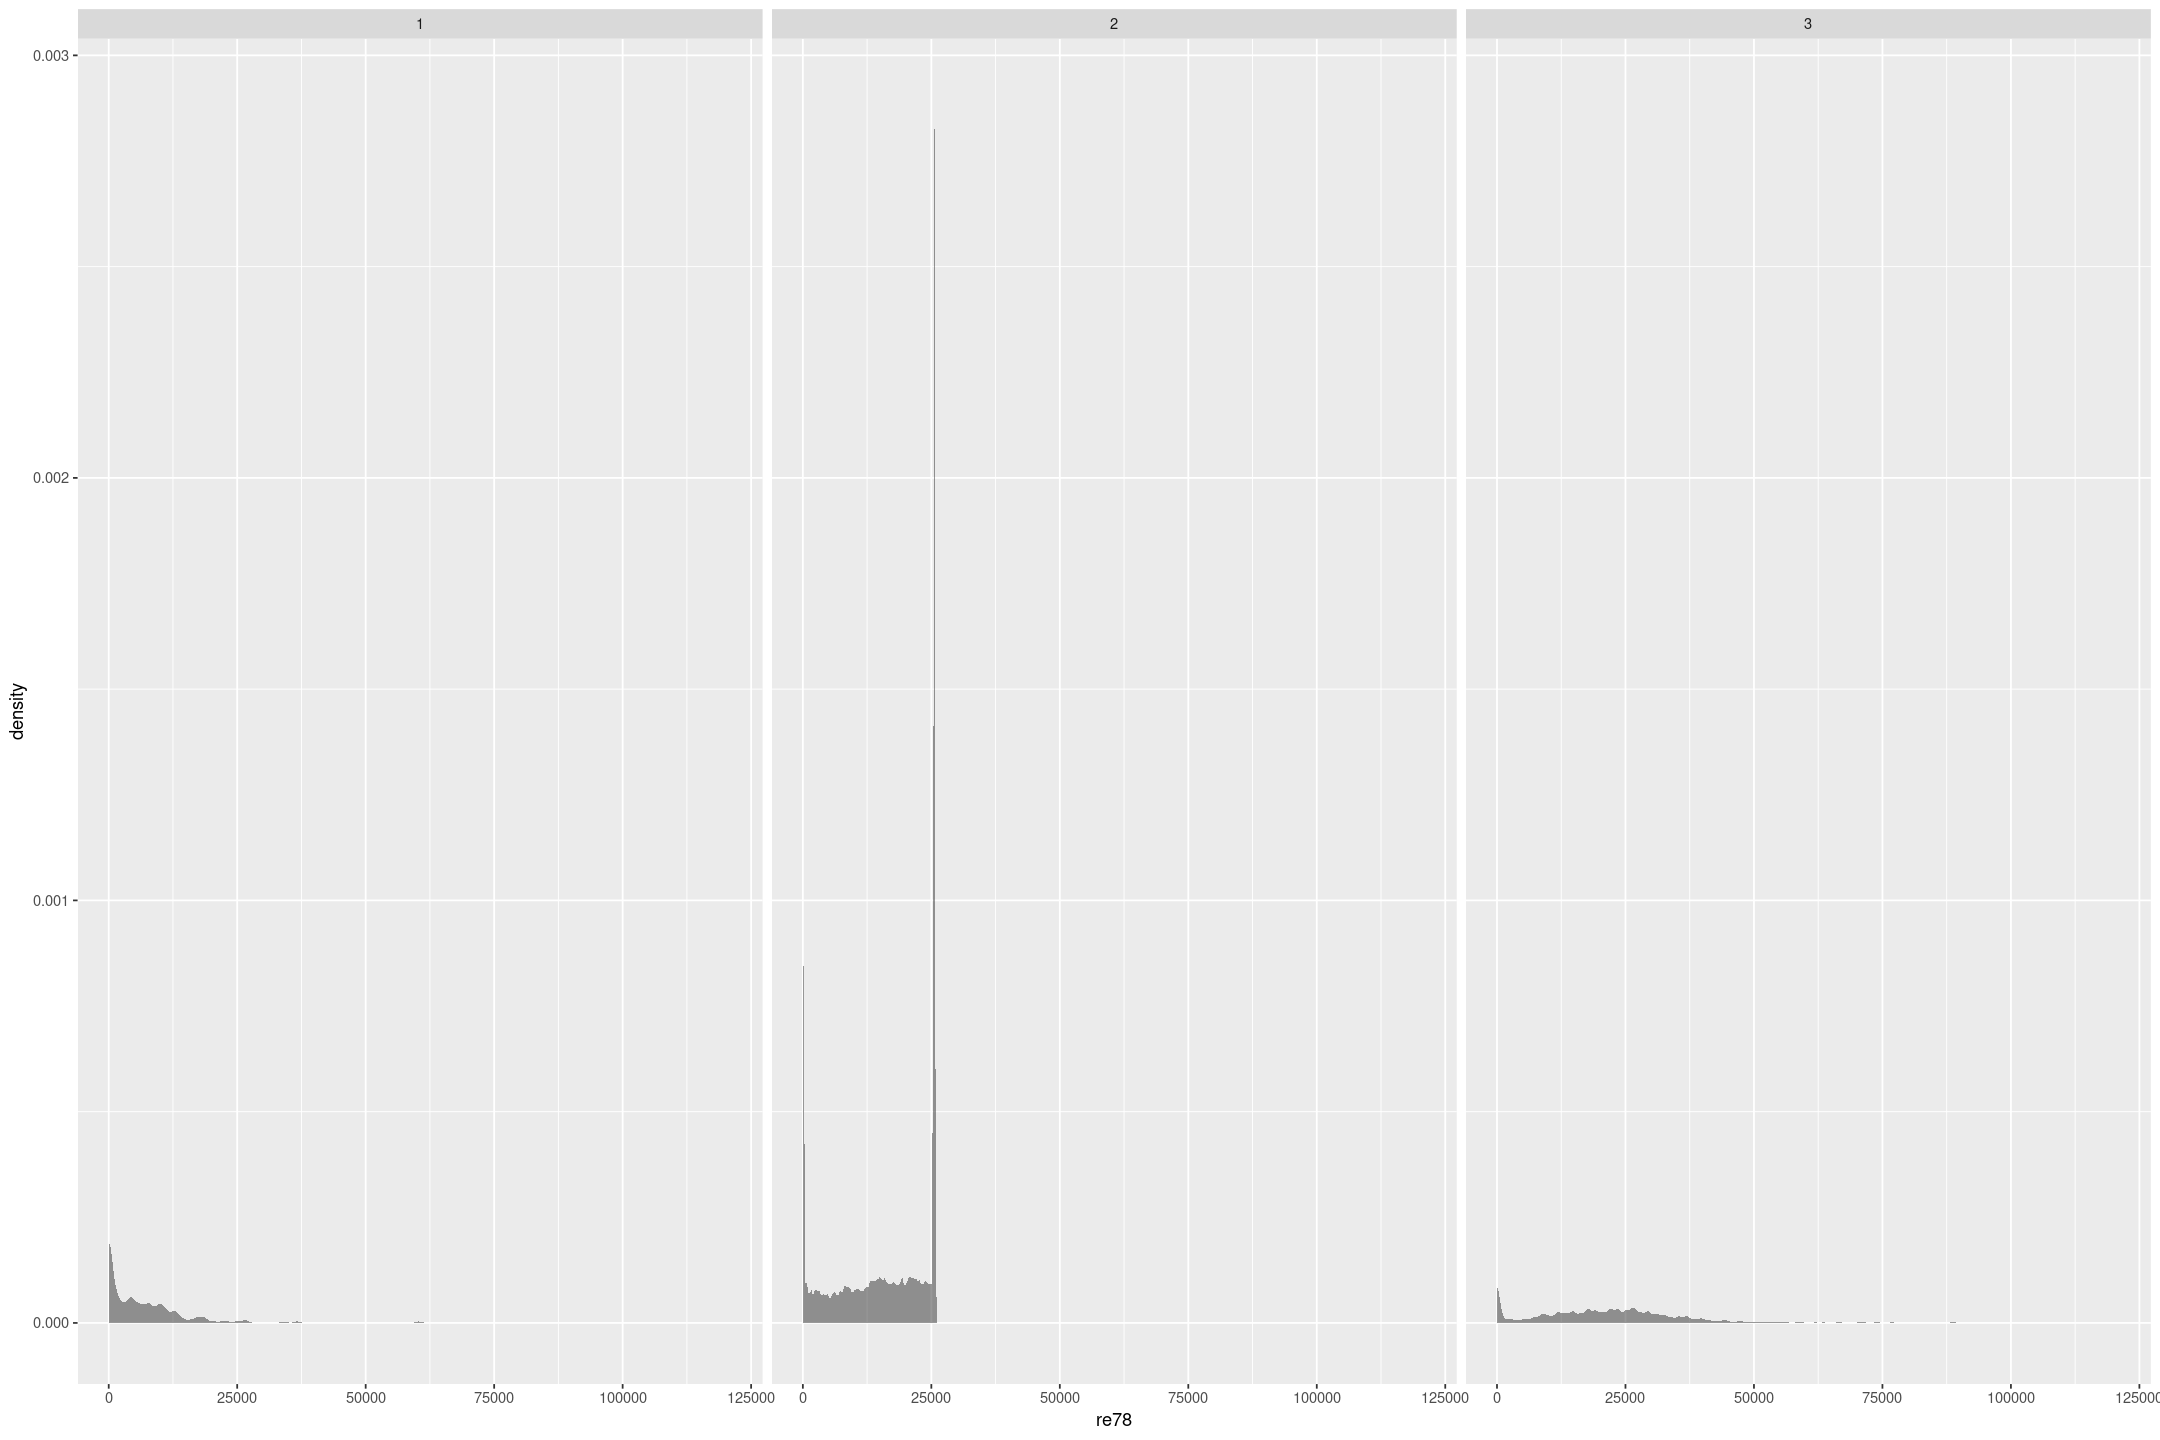

In [167]:
lalonde %>%
gf_density(~re78 | sample, bw="SJ")

### Fitting a linear regression

As a baseline let's fit a straight linear regression.
Because we're thinking of \\$0 as a censored variable it makes sense to treat it specially in the predictions.

In [168]:
fit_lalonde_linear <- stan_glm(re78 ~ re75 + treat + as.integer(re75==0), data=lalonde)

In [169]:
fit_lalonde_linear

stan_glm
 family:       gaussian [identity]
 formula:      re78 ~ re75 + treat + as.integer(re75 == 0)
 observations: 18667
 predictors:   4
------
                      Median  MAD_SD 
(Intercept)            5383.5   121.5
re75                      0.7     0.0
treat                   562.5   582.7
as.integer(re75 == 0) -1161.4   201.8

Auxiliary parameter(s):
      Median MAD_SD
sigma 7802.7   41.4

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

We get an estimated treatment effect of \\$533 with an standard deviation of \\$578.
This is quite a bit lower than Dehejia and Wahba's experimental estimate of \\$1672 (this is a bit different to the numbers in the Lalonde paper where the effect is closer to \\$850 - I'm not sure why there's a factor of 2 difference between them?)

There's a strong correlation with pretreatment earnings, but less than 1 as expected by regression to the mean.

In [170]:
print(fit_lalonde_linear, digits=3)

stan_glm
 family:       gaussian [identity]
 formula:      re78 ~ re75 + treat + as.integer(re75 == 0)
 observations: 18667
 predictors:   4
------
                      Median    MAD_SD   
(Intercept)            5383.543   121.523
re75                      0.730     0.006
treat                   562.502   582.701
as.integer(re75 == 0) -1161.439   201.814

Auxiliary parameter(s):
      Median   MAD_SD  
sigma 7802.674   41.357

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


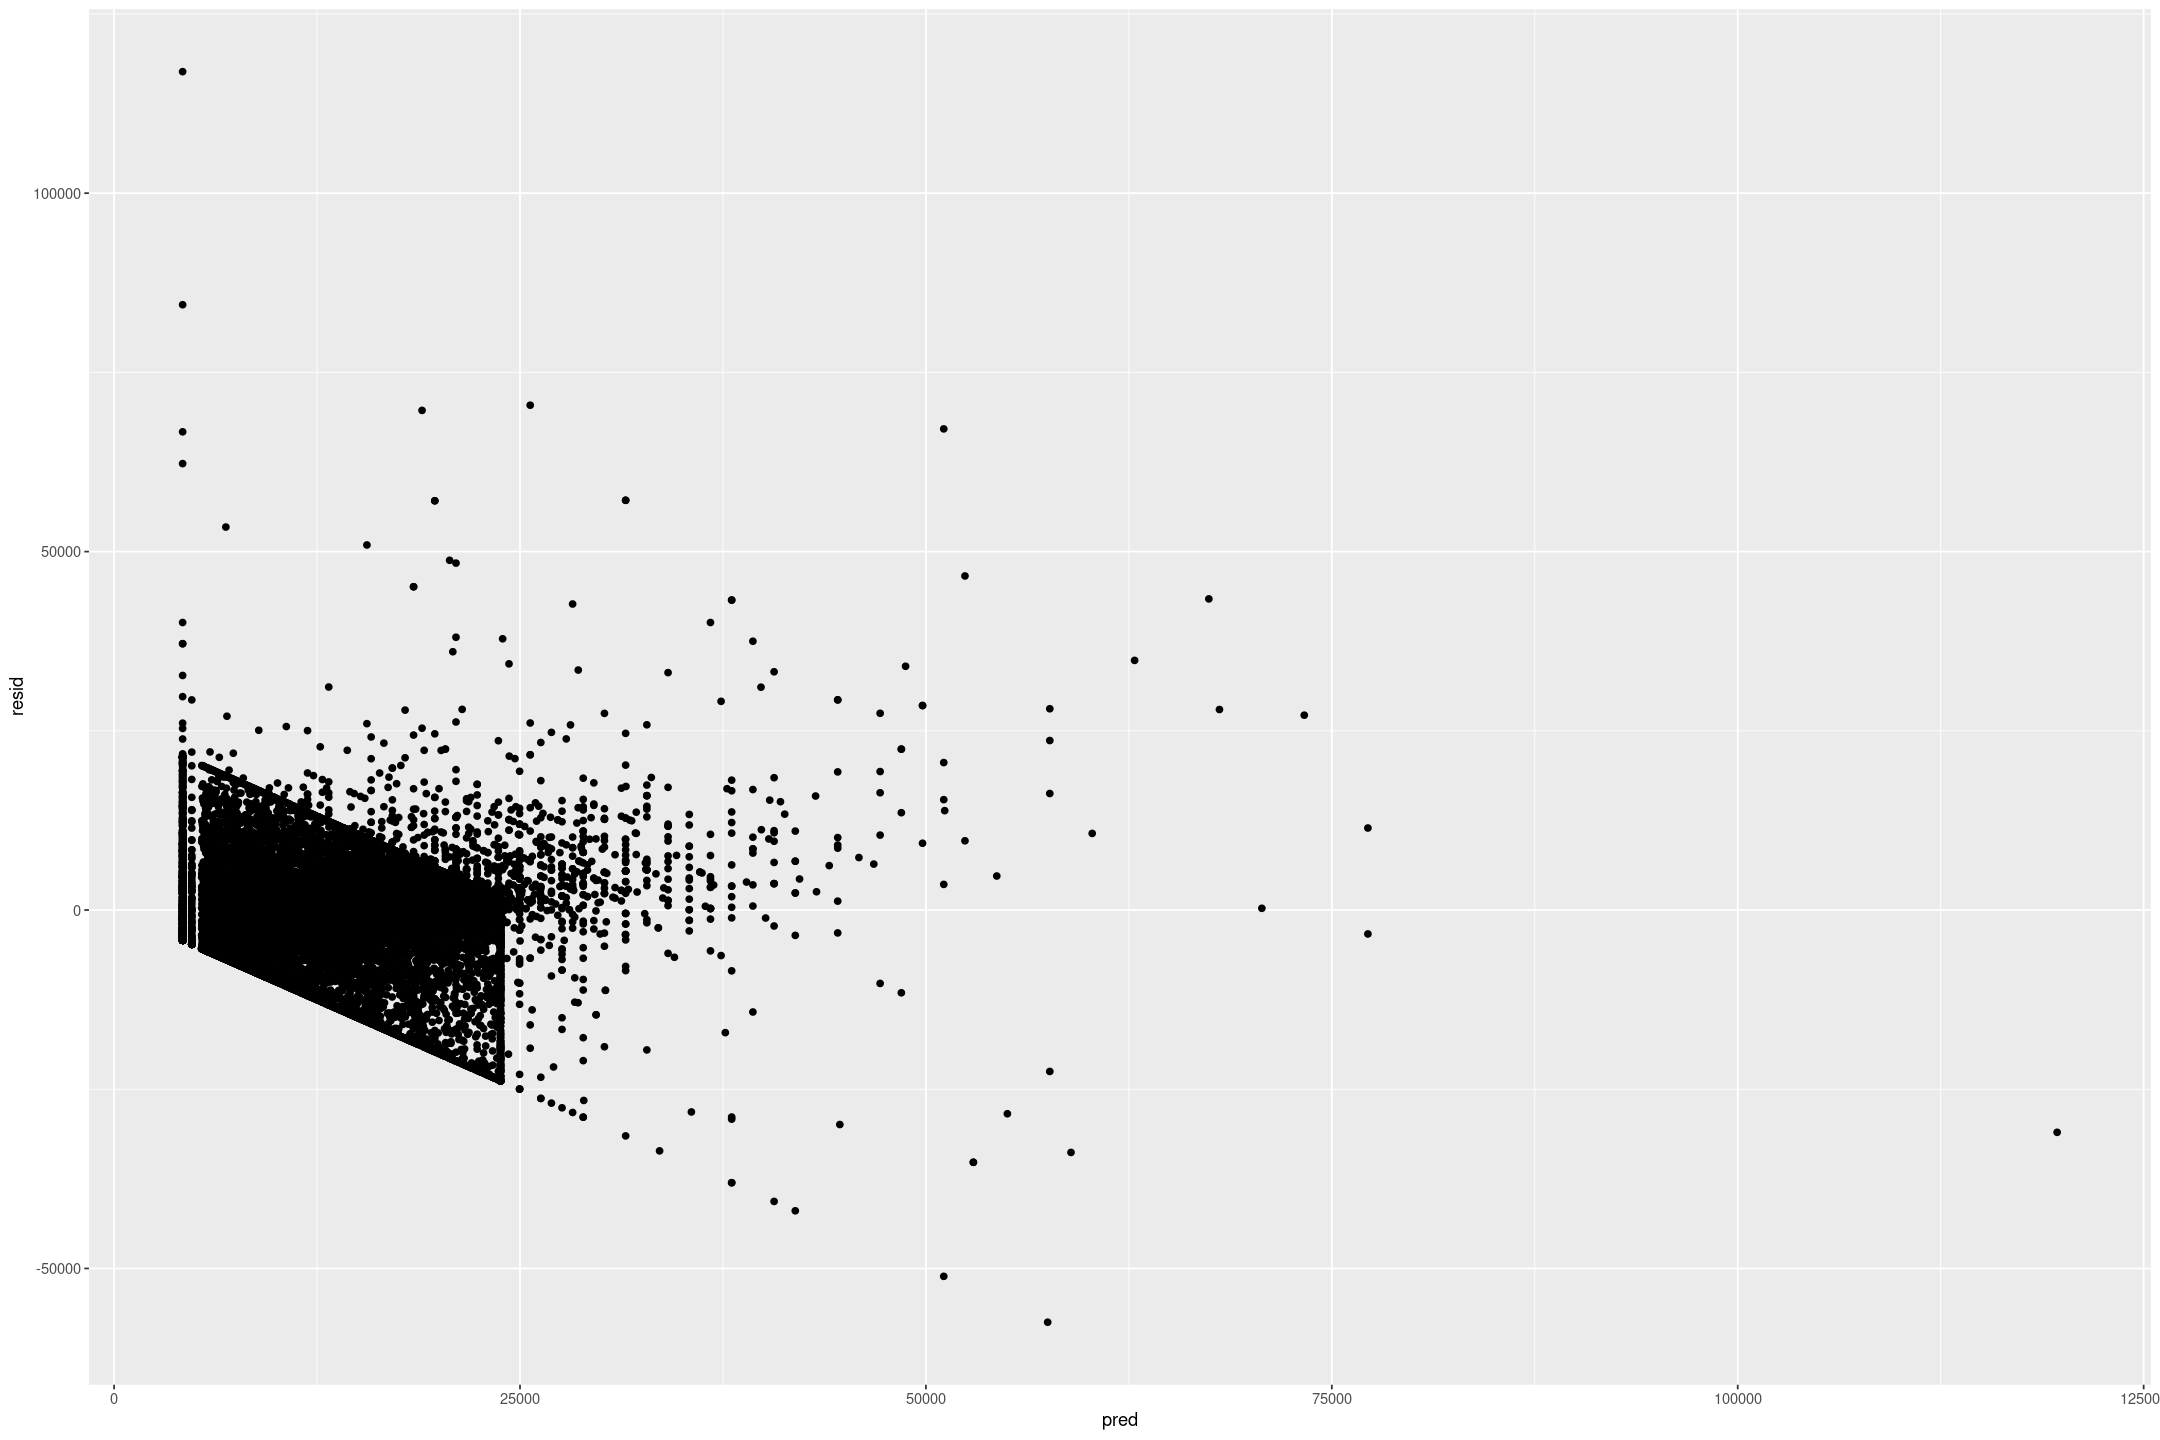

In [171]:
lalonde %>%
mutate(pred=predict(fit_lalonde_linear),
       resid = re78-pred) %>%
gf_point(resid ~ pred)

### Fitting a tobit model from below

The [Tobit model](https://en.wikipedia.org/wiki/Tobit_model), first proposed by [James Tobin](https://web.sonoma.edu/users/c/cuellar/econ411/Tobin.pdf) in 1958, treats this censoring instead of treating it as a true value, saying that it indicates some value at least that much.
Tobin showed how to calculate the likelihood for Maximum Likelihood Estimation, but here we're going to try Bayesian methods.

I don't know how to do this in rstanarm or brms (I searched for Tobin but couldn't find it).
So let's try to code this up in Stan.

I used this [methods consultants blog post](https://blog.methodsconsultants.com/posts/introduction-to-stan-in-r/) to work out how to use Stan with R, and [Stan's user guide on Censored Data](https://mc-stan.org/docs/2_27/stan-users-guide/censored-data.html) to understand how to deal with censored varaiables.
Between the two examples I could get this model:

In [172]:
fileConn<-file("tobit_lower_flat.stan")
writeLines("
// Lower censored tobit model
data {
  int<lower=0> N_obs;          // Number of observed data points
  int<lower=0> N_cens;         // Number of censored data points
  int<lower=0> K;              // Number of predictors
  matrix[N_obs, K] X_obs;      // Observed predictor matrix
  matrix[N_cens, K] X_cens;    // Censored predictor matrix
  real y_obs[N_obs];           // Observations (non-censored)
  real<upper=min(y_obs)> L;    // Value where censoring occurs

}
parameters {
  vector[K] beta;       // coefficients for predictors
  real<lower=0> sigma;  // error scale
  real<upper=L> y_cens[N_cens]; // The underlying censored values
}
model {
  y_obs ~ normal(X_obs * beta, sigma);  // target density - observed points
  y_cens ~ normal(X_cens * beta, sigma); // target density - censored points
}
", fileConn)
close(fileConn)

In [173]:
fit_stan_tobit_lower_flat <- function(formula, data, L=NULL, ...) {
    y <- model.response(model.frame(formula, data))
    X <- model.matrix(formula, data)
    
    if (is.null(L)) {L = min(y)}
    if (min(y) < L) {stop("Minimum value below censored value")}
    if (min(y) > L) {warning("No censored values")}
    
    X_cens = subset(X, y == L)
    X_obs = subset(X, y > L)
    y_obs = subset(y, y > L)
    
    K <- ncol(X)
    
    fit <- rstan::stan(
        file = "tobit_lower_flat.stan", 
        data = list(
            N_obs = nrow(X_obs),
            N_cens = nrow(X_cens),
            K = K,
            X_obs = X_obs,
            X_cens = X_cens,
            y_obs = y_obs,
            L = L
          ),
        ...
        )
    
    sigma <- as.matrix(fit)[, "sigma"]
    
    # Set names of the coefficients
    names(fit)[1:ncol(X)] <- colnames(X)
        
    structure(list(fit=fit,
                   coef_names=colnames(X),
                   sigma=sigma,
                   L=L,
                   terms=terms(formula, data=data), 
                   data=data),
              class=c("stan_tobit", "stan_wrapper"))
}

In [174]:
as.matrix.stan_wrapper <- function(object) {
    as.matrix(object$fit)
}

In [175]:
as.data.frame.stan_wrapper <- function(object) {
    as.data.frame(object$fit)
}

In [176]:
print.stan_wrapper <- function(object, ...) {
    print(object$fit, ...)
}

In [177]:
predict.stan_tobit <- function(object, newdata=NULL, type="link") {
    if (!(type %in% c("link", "response"))) {
        stop("Unexpected type; should be 'link' or 'response'")
    }
    if (is.null(newdata)) {
        newdata = object$data
    }
    
    mm <- model.matrix(delete.response(object$terms), data=newdata)
    
    coef_matrix <- as.matrix(object$fit)
    coefs <- apply(coef_matrix, 2, median)[colnames(mm)]
    
    
    preds <- (mm %*% coefs)[,1]
    if (type == "response") {
        preds <- if_else(preds > object$L, preds, object$L)
    }
    unlist(preds)
}

In [178]:
rnorm_matrix <- function(mean, sd) {
    stopifnot(length(dim(mean)) == 2)
    error <- matrix(rnorm(length(mean), 0, sd), ncol=ncol(mean), byrow=TRUE)
    mean + error
}


In [179]:
posterior_predict.stan_tobit  <- function(object, newdata=NULL, draws=NULL) {
    if (is.null(newdata)) {
        newdata = object$data
    }
    
    mm <- model.matrix(delete.response(object$terms), data=newdata)
    
    coef_matrix <- as.matrix(object$fit)
    if (!is.null(draws)) {
        if (draws > nrow(coef_matrix)) {
            stop("More draws than rows")
        }
        
        # Take a random sample of draws
        coef_matrix <- coef_matrix[sample.int(nrow(coef_matrix), draws), , drop=FALSE]
    }
    
    point_preds <- coef_matrix[,object$coef_names,drop=FALSE] %*% t(mm)
    preds <- rnorm_matrix(point_preds, object$sigma)
    preds <- matrix(if_else(preds > object$L, preds, object$L), ncol=nrow(mm))
    colnames(preds) <- rownames(newdata)
    
    preds
}

#### Testing on simulated data

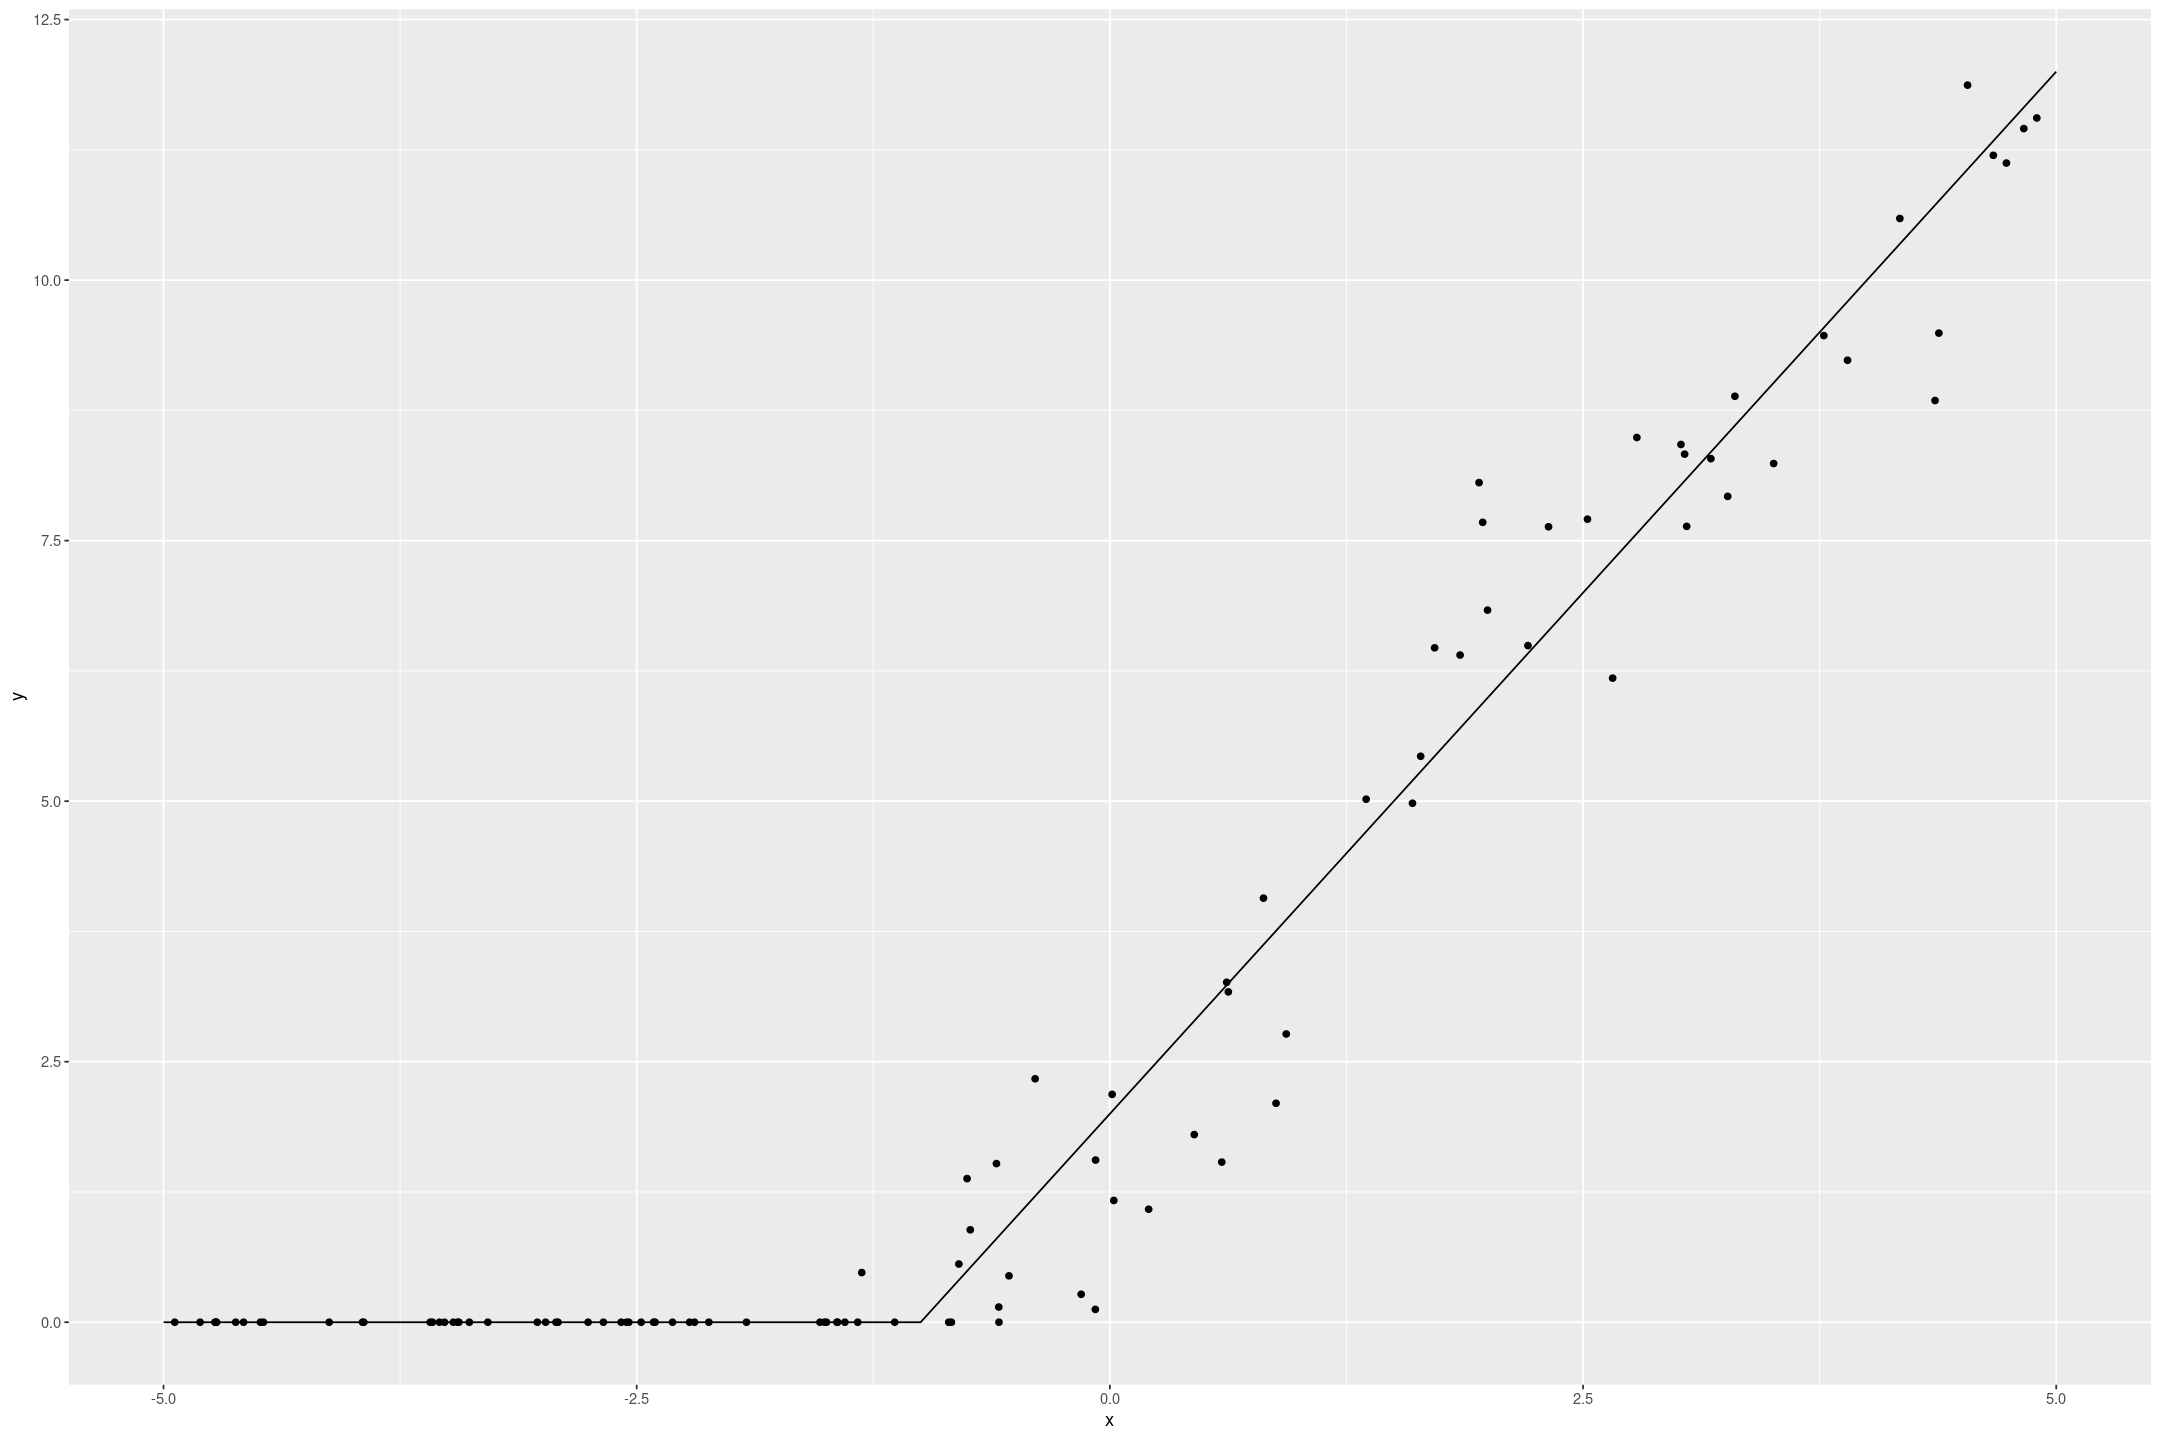

In [180]:
n <- 100
fake_tobit <- tibble(x = runif(n, -5, 5),
                     z = rnorm(n, 2*x + 2, 1),
                     y = if_else(z > 0, z, 0))

fake_tobit %>%
gf_point(y ~ x) %>%
gf_line(if_else(2*x+2 > 0, 2*x+2, 0) ~ x, data=data.frame(x=seq(-5,5,by=0.1)))

In [181]:
(fit_tobit_linear <- stan_glm(y ~ x, data=fake_tobit))

stan_glm
 family:       gaussian [identity]
 formula:      y ~ x
 observations: 100
 predictors:   2
------
            Median MAD_SD
(Intercept) 3.4    0.2   
x           1.2    0.1   

Auxiliary parameter(s):
      Median MAD_SD
sigma 1.6    0.1   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

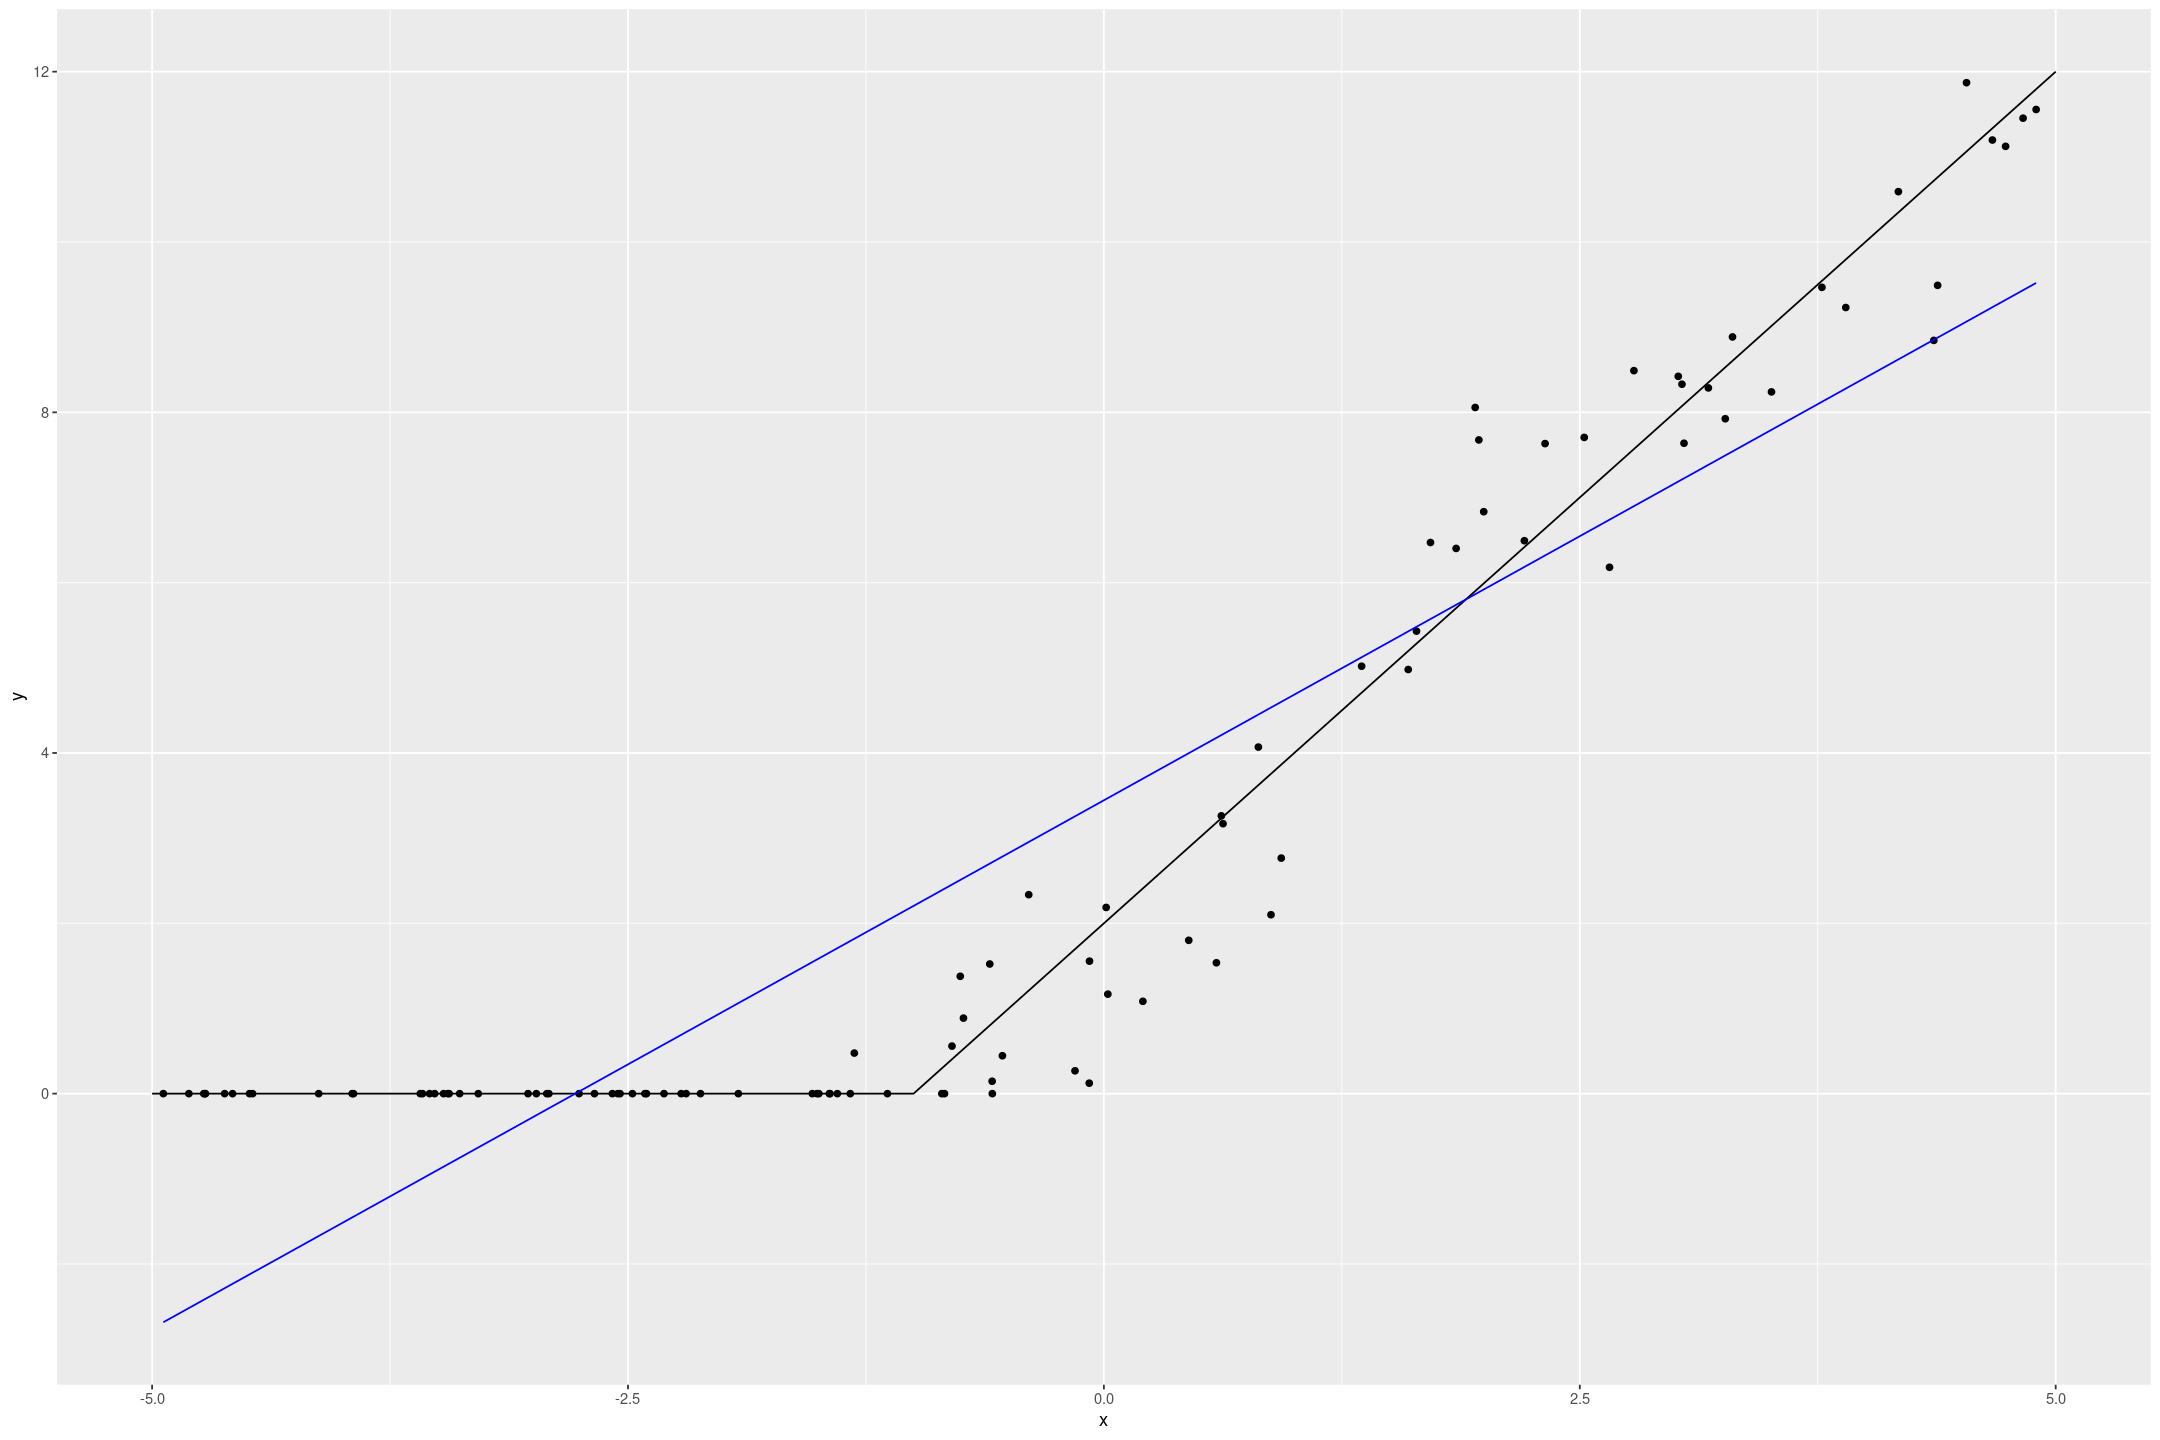

In [182]:
fake_tobit %>%
gf_point(y ~ x) %>%
gf_line(if_else(2*x+2 > 0, 2*x+2, 0) ~ x, data=data.frame(x=seq(-5,5,by=0.1))) %>%
gf_line(predict(fit_tobit_linear, .) ~ x, col="blue")

But the tobit regression is much closter to the true parameters

In [183]:
start_time <- Sys.time()
fit_tobit_fake <- fit_stan_tobit_lower_flat(y ~ x, data=fake_tobit, L=0)
Sys.time() - start_time

Time difference of 6.481291 secs

In [184]:
tobit_preds <- data.frame(x=seq(-5,5,by=0.1)) %>% mutate(y=predict(fit_tobit_fake, newdata=., type="response"))

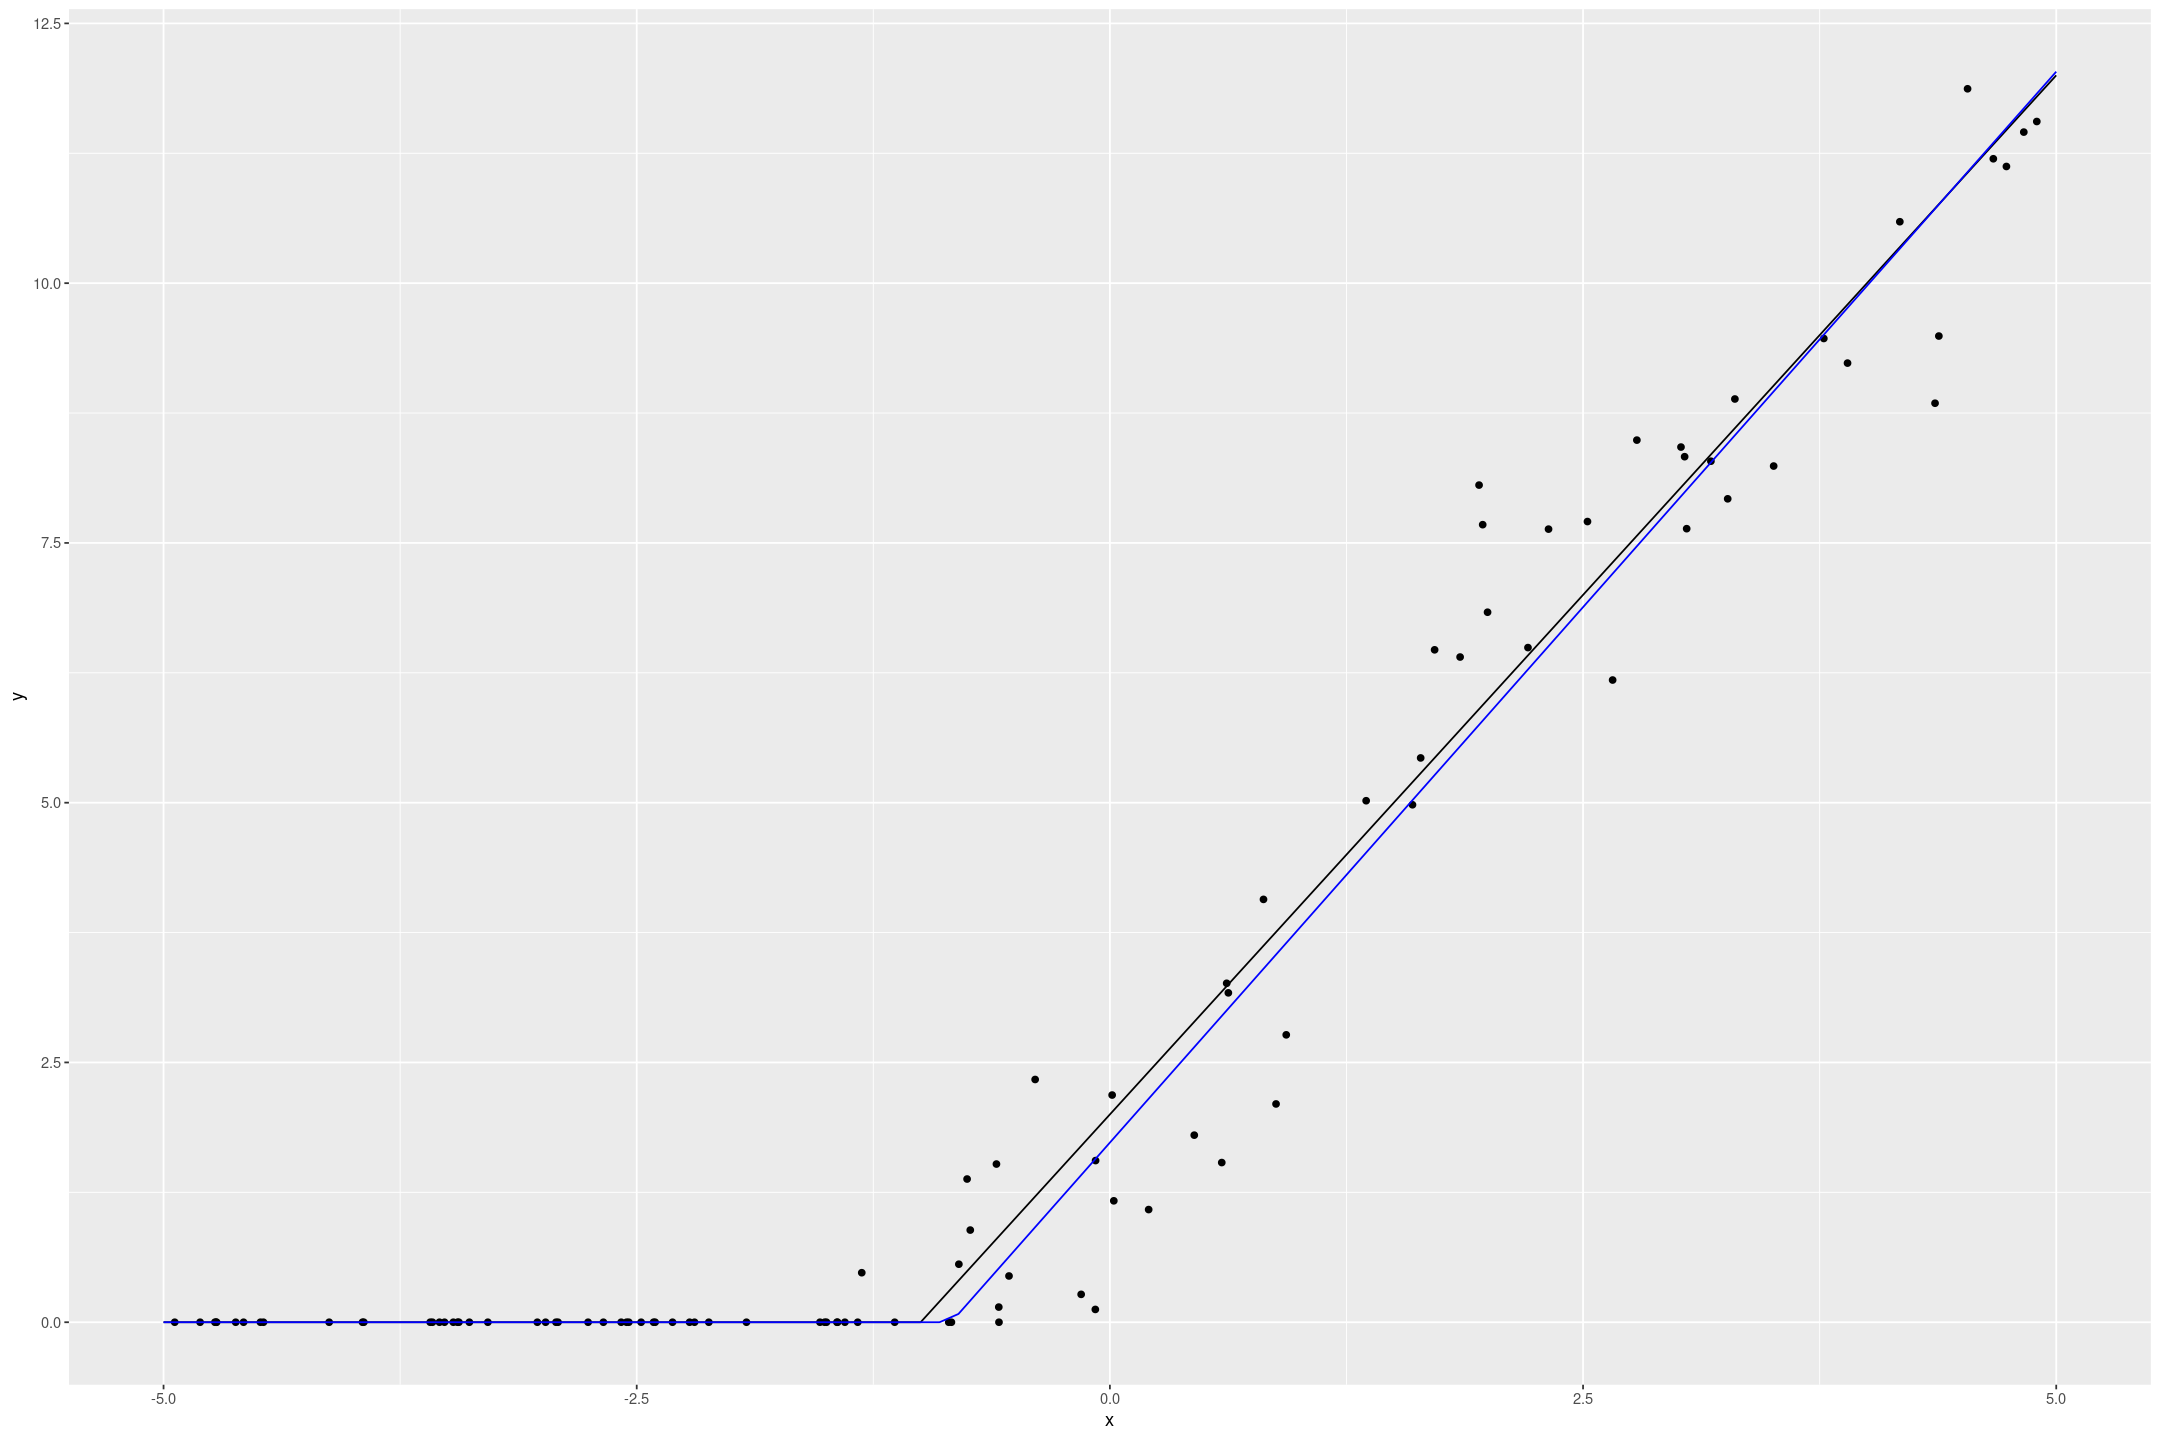

In [185]:
fake_tobit %>%
gf_point(y ~ x) %>%
gf_line(if_else(2*x+2 > 0, 2*x+2, 0) ~ x, data=tobit_preds) %>%
gf_line(y ~ x, data=tobit_preds, col="blue")

Simulated draws look just like the data.

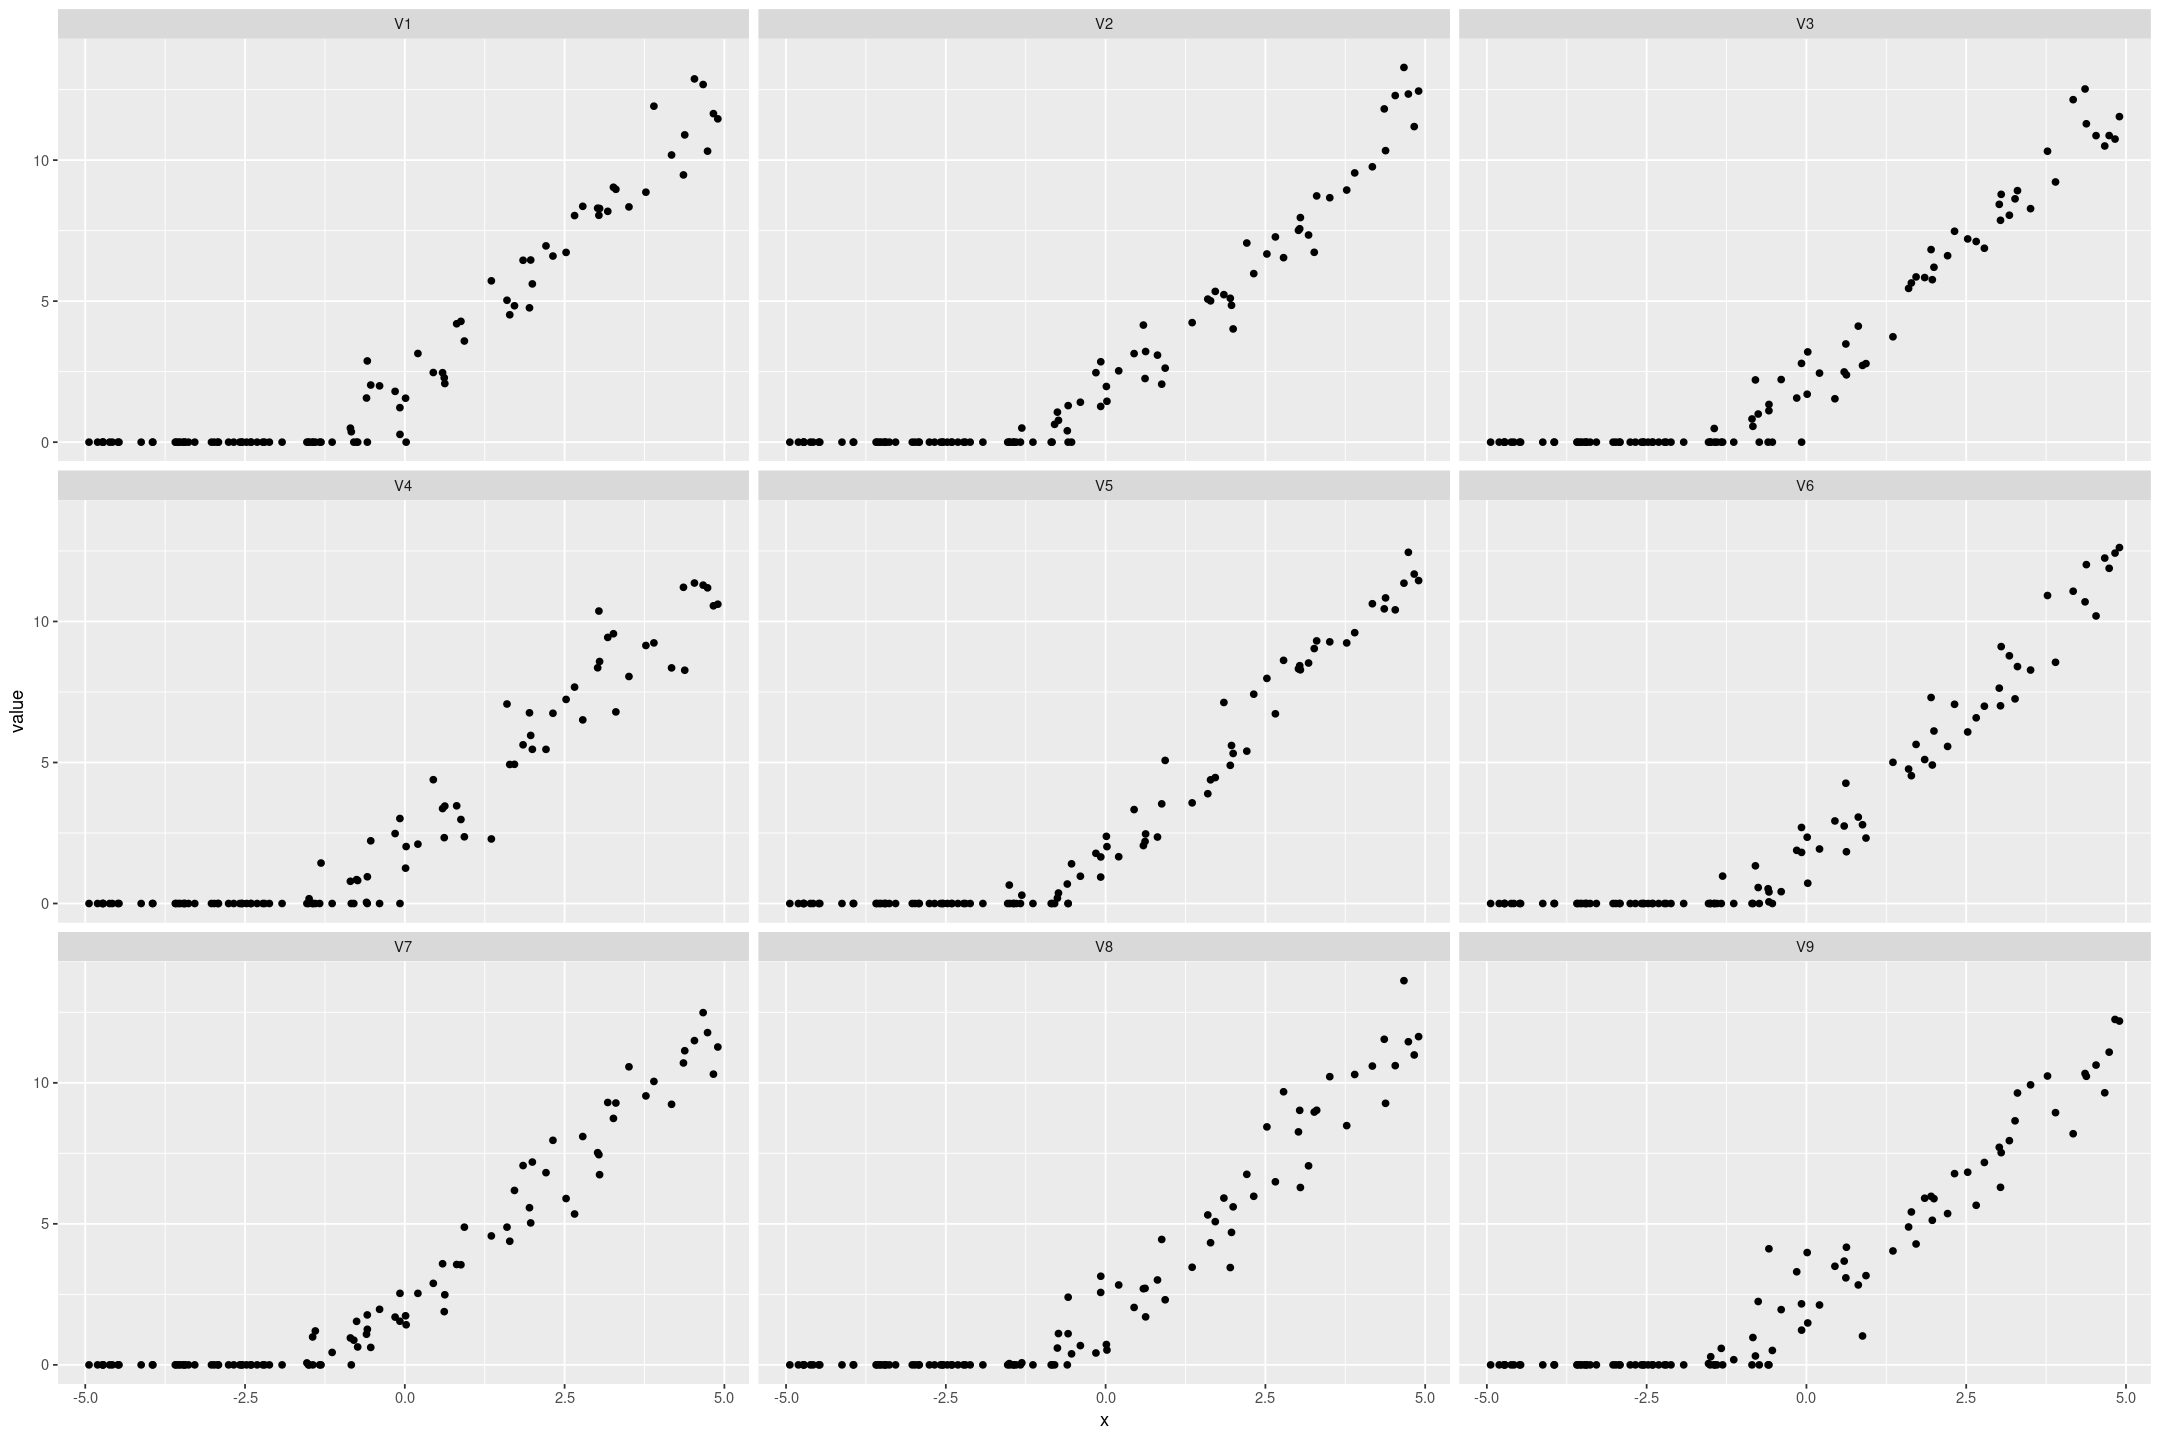

In [186]:
posterior_predict(fit_tobit_fake, draws=9) %>%
t() %>%
as.data.frame() %>%
cbind(fake_tobit) %>%
pivot_longer(starts_with('V')) %>%
gf_point(value ~ x | name)

#### Running on Lalonde

In [187]:
start_time <- Sys.time()
fit_lalonde_tobit_flat <- fit_stan_tobit_lower_flat(re78 ~ re75 + treat + as.integer(re75==0),
                                               L=0,
                                               data=lalonde)
end_time <- Sys.time()

end_time - start_time

Time difference of 4.506632 mins

In [188]:
start_time <- Sys.time()
fit_lalonde_tobit_flat_subset <- fit_stan_tobit_lower_flat(re78 ~ re75 + treat + as.integer(re75==0),
                                               L=0,
                                               data=subset(lalonde, lalonde$sample!=2))
end_time <- Sys.time()

end_time - start_time

Time difference of 23.65203 secs

We treat all the data from the same distribution, but for the censored variables (`y_cens`) we just say that they come from the same distribution and that they are at most the censored value (in this case 0).

I have no idea how this works but Stan seems to happily try to estimate this data.

With this we estimate the effect of the treatment to be around $1700

In [189]:
fit_lalonde_tobit_flat %>%
as.data.frame() %>%
select(-starts_with('y_'), -lp__) %>%
pivot_longer(everything()) %>%
group_by(name) %>%
summarise(median = median(value), mad_sd = mad(value)) %>%
mutate(across(-name, round, digits=2))

name                  median   mad_sd
1 (Intercept)            4651.08 142.04
2 as.integer(re75 == 0) -4323.42 252.79
3 re75                      0.75   0.01
4 sigma                  8744.48  51.72
5 treat                  1711.03 702.77

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



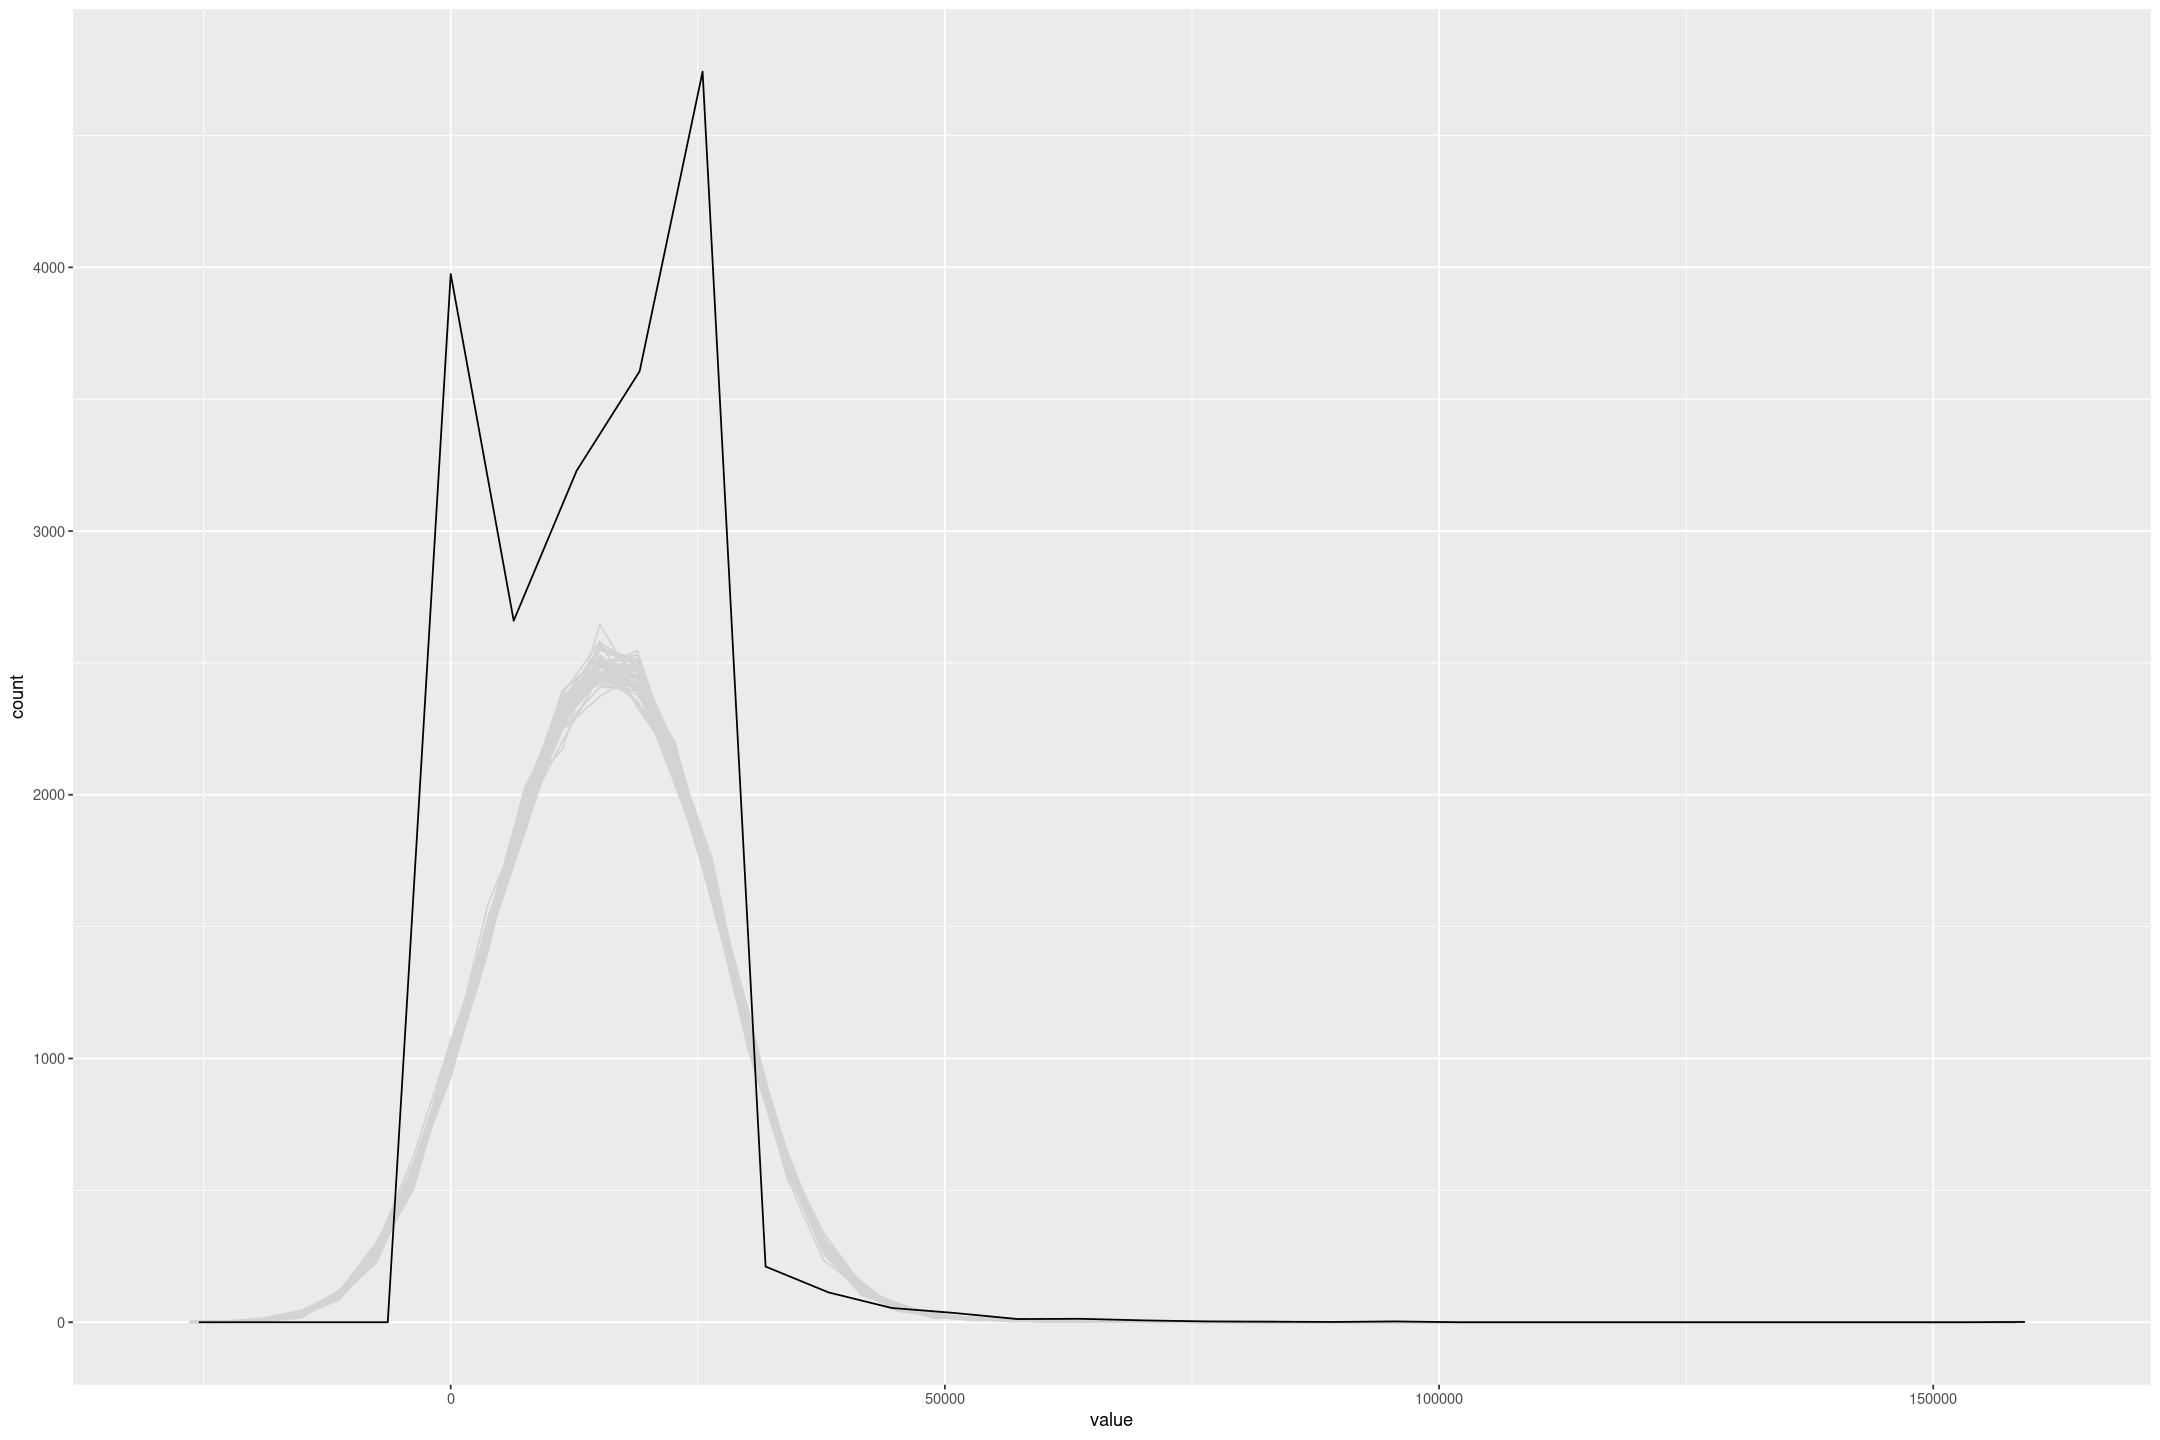

In [190]:
posterior_predict(fit_lalonde_linear, draws=50) %>%
as.data.frame() %>%
mutate(draw=row_number()) %>%
pivot_longer(-draw) %>%
gf_freqpoly(~value, group=~draw, colour='lightgrey', bins=50) %>%
gf_freqpoly(~re75, group=FALSE, data=lalonde)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



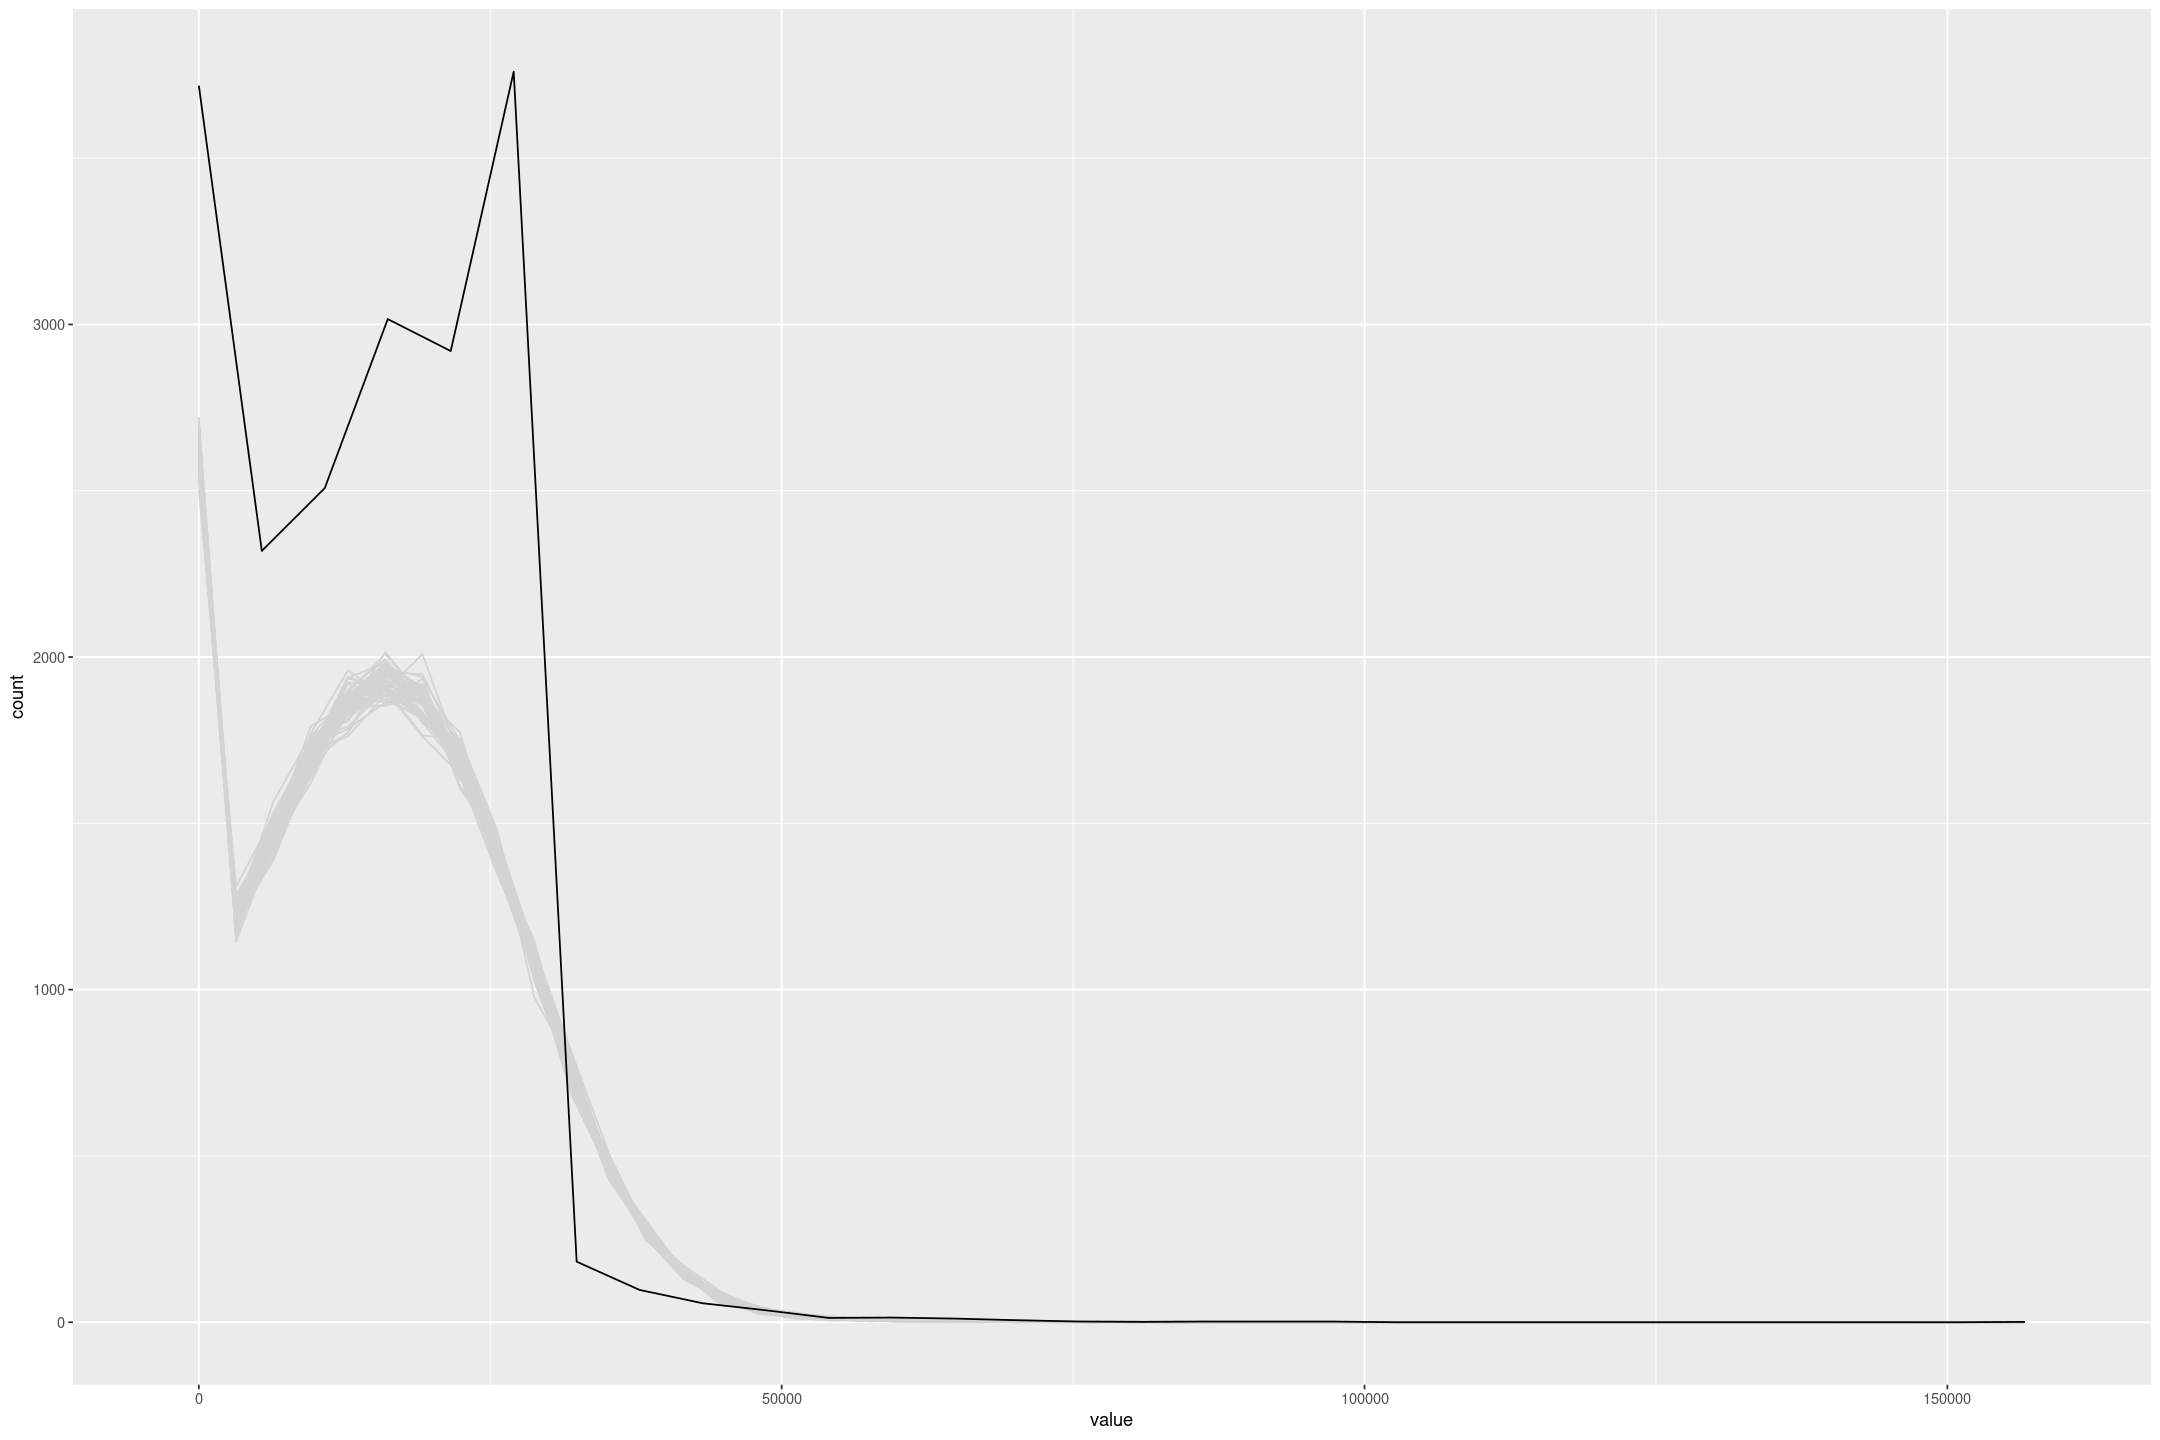

In [191]:
posterior_predict(fit_lalonde_tobit_flat, draws=50) %>%
as.data.frame() %>%
mutate(draw=row_number()) %>%
pivot_longer(-draw) %>%
gf_freqpoly(~value, group=~draw, colour='lightgrey', bins=50) %>%
gf_freqpoly(~re75, group=FALSE, data=lalonde)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



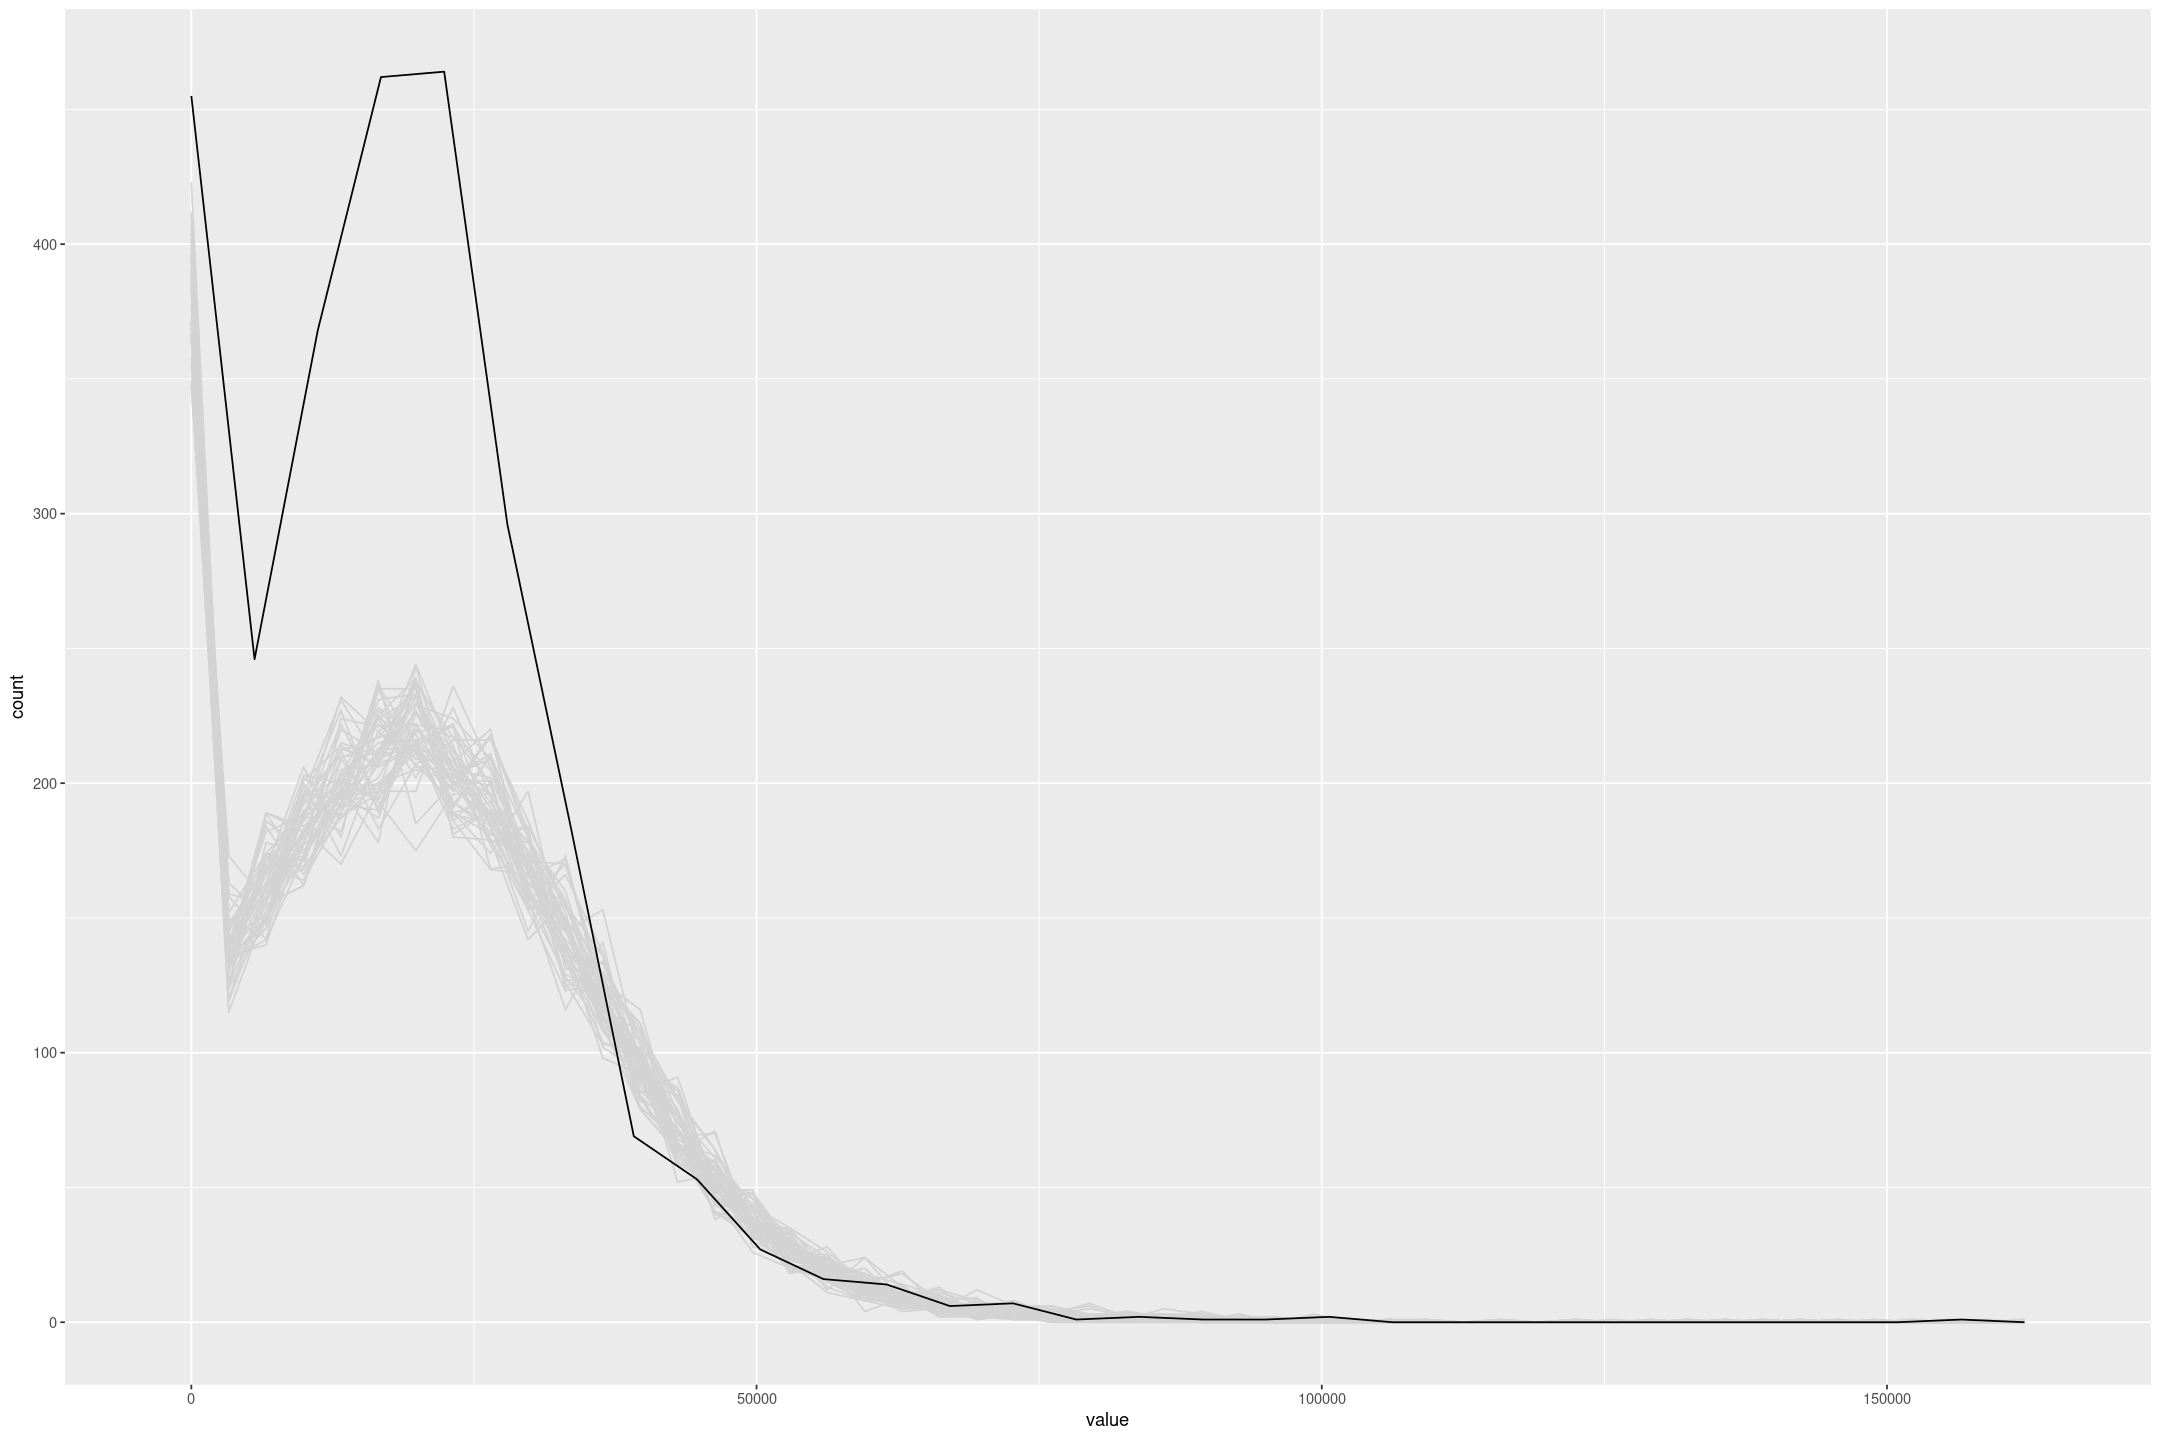

In [192]:
posterior_predict(fit_lalonde_tobit_flat_subset, draws=50) %>%
as.data.frame() %>%
mutate(draw=row_number()) %>%
pivot_longer(-draw) %>%
gf_freqpoly(~value, group=~draw, colour='lightgrey', bins=50) %>%
gf_freqpoly(~re75, group=FALSE, data=subset(lalonde, lalonde$sample!=2))

There's a more efficient way of estimating the impact covered in the Stan User guide by [integrating the density](https://mc-stan.org/docs/2_27/stan-users-guide/censored-data.html#integrating-out-censored-values).

> Although it is wrong to ignore the censored values in estimating location and scale, it is not necessary to impute values. Instead, the values can be integrated out.

Indeed this is how it's presented on Wikipedia and in Tobin's paper.

But, I tried and failed :)

# Robust linear regression using the t model

The folder [`Congress`](https://github.com/avehtari/ROS-Examples/tree/master/Congress) has the votes for the Democratic and Republican candidates in each U.S. congressional district in 1988, along with the parties' vote proportions in 1986 and an indicator for whether the incumbent was running for reelection in 1988.
For your analysis, just use the elections that were contested by both parties for both years.

In [193]:
filename <- 'data/Congress/congress.csv'

download_if_missing(filename, 'https://raw.githubusercontent.com/avehtari/ROS-Examples/master/Congress/data/congress.csv')

congress_raw <- read.csv(filename)

In [194]:
congress_raw %>% head()

inc86 inc88 inc90 v86       v88       v90       v86_adj   v88_adj   v90_adj  
1  1     1     1    0.7450362 0.7724427 0.7140294 0.7450362 0.7724427 0.7140294
2  1     1     1    0.6738455 0.6361816 0.5970501 0.6738455 0.6361816 0.5970501
3  1     1     0    0.6964566 0.6649283 0.5210433 0.6964566 0.6649283 0.5210433
4 -1    -1    -1    0.4645901 0.2738342 0.2343770 0.4645901 0.2738342 0.2343770
5 -1    -1     0    0.3910945 0.2636131 0.4774393 0.3910945 0.2636131 0.4774393
6 -1    -1    -1    0.3582454 0.3341927 0.2562970 0.3582454 0.3341927 0.2562970

From the [processing script](https://github.com/avehtari/ROS-Examples/blob/master/Congress/data/congress_setup.R) the vXX is the *Democrat* share of votes, and the `_adj` just imputes uncontested elections.

For `inc88` I'm guessing +1 means Democratic incumbent, -1 means Republican incumbent and 0 means no incumbent.

In [195]:
congress_raw %>% group_by(inc88) %>% summarise(n=n(), v88=mean(v88))

inc88 n   v88      
1 -1    160 0.2896360
2  0     30 0.5091112
3  1    245 0.7608862

Let's filter out uncontested elections in 1988 (where the vote share is 0% or 100%), and only extract the relevant and available predictors; 1986 vote proportion and whether the incumbent was running in 1988. (I'm not sure what 0 could mean?)

In [196]:
congress <- congress_raw %>%
filter(v88 > 0, v88 < 1, v86 > 0, v86 < 1) %>%
select(v88, inc88, v86)

In [197]:
nrow(congress)

[1] 316

## Linear Regression

Fit a linear regression using `stan_glm` with the normal-distribution model for the errors predicting 1988 Democratic vote share from the other variables and assess model fit.

In [198]:
fit_congress <- stan_glm(v88 ~ inc88 + v86, data=congress)

At 50% 1986 Democrat share, the model predicts 49.5% Democrat share in 1988 with no incumbent running.
Every increast in 3% of 1986 share corresponds to an increase in 1% in 1988 share.
Moreover being incumbent gives an 11 percentage point advantage.

The model uncertainty is of the order of 8 percentage points.

In [199]:
print(fit_congress, digits=2)

stan_glm
 family:       gaussian [identity]
 formula:      v88 ~ inc88 + v86
 observations: 316
 predictors:   3
------
            Median MAD_SD
(Intercept) 0.21   0.02  
inc88       0.08   0.01  
v86         0.57   0.04  

Auxiliary parameter(s):
      Median MAD_SD
sigma 0.07   0.00  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


To assess model fit we can look a residual plot

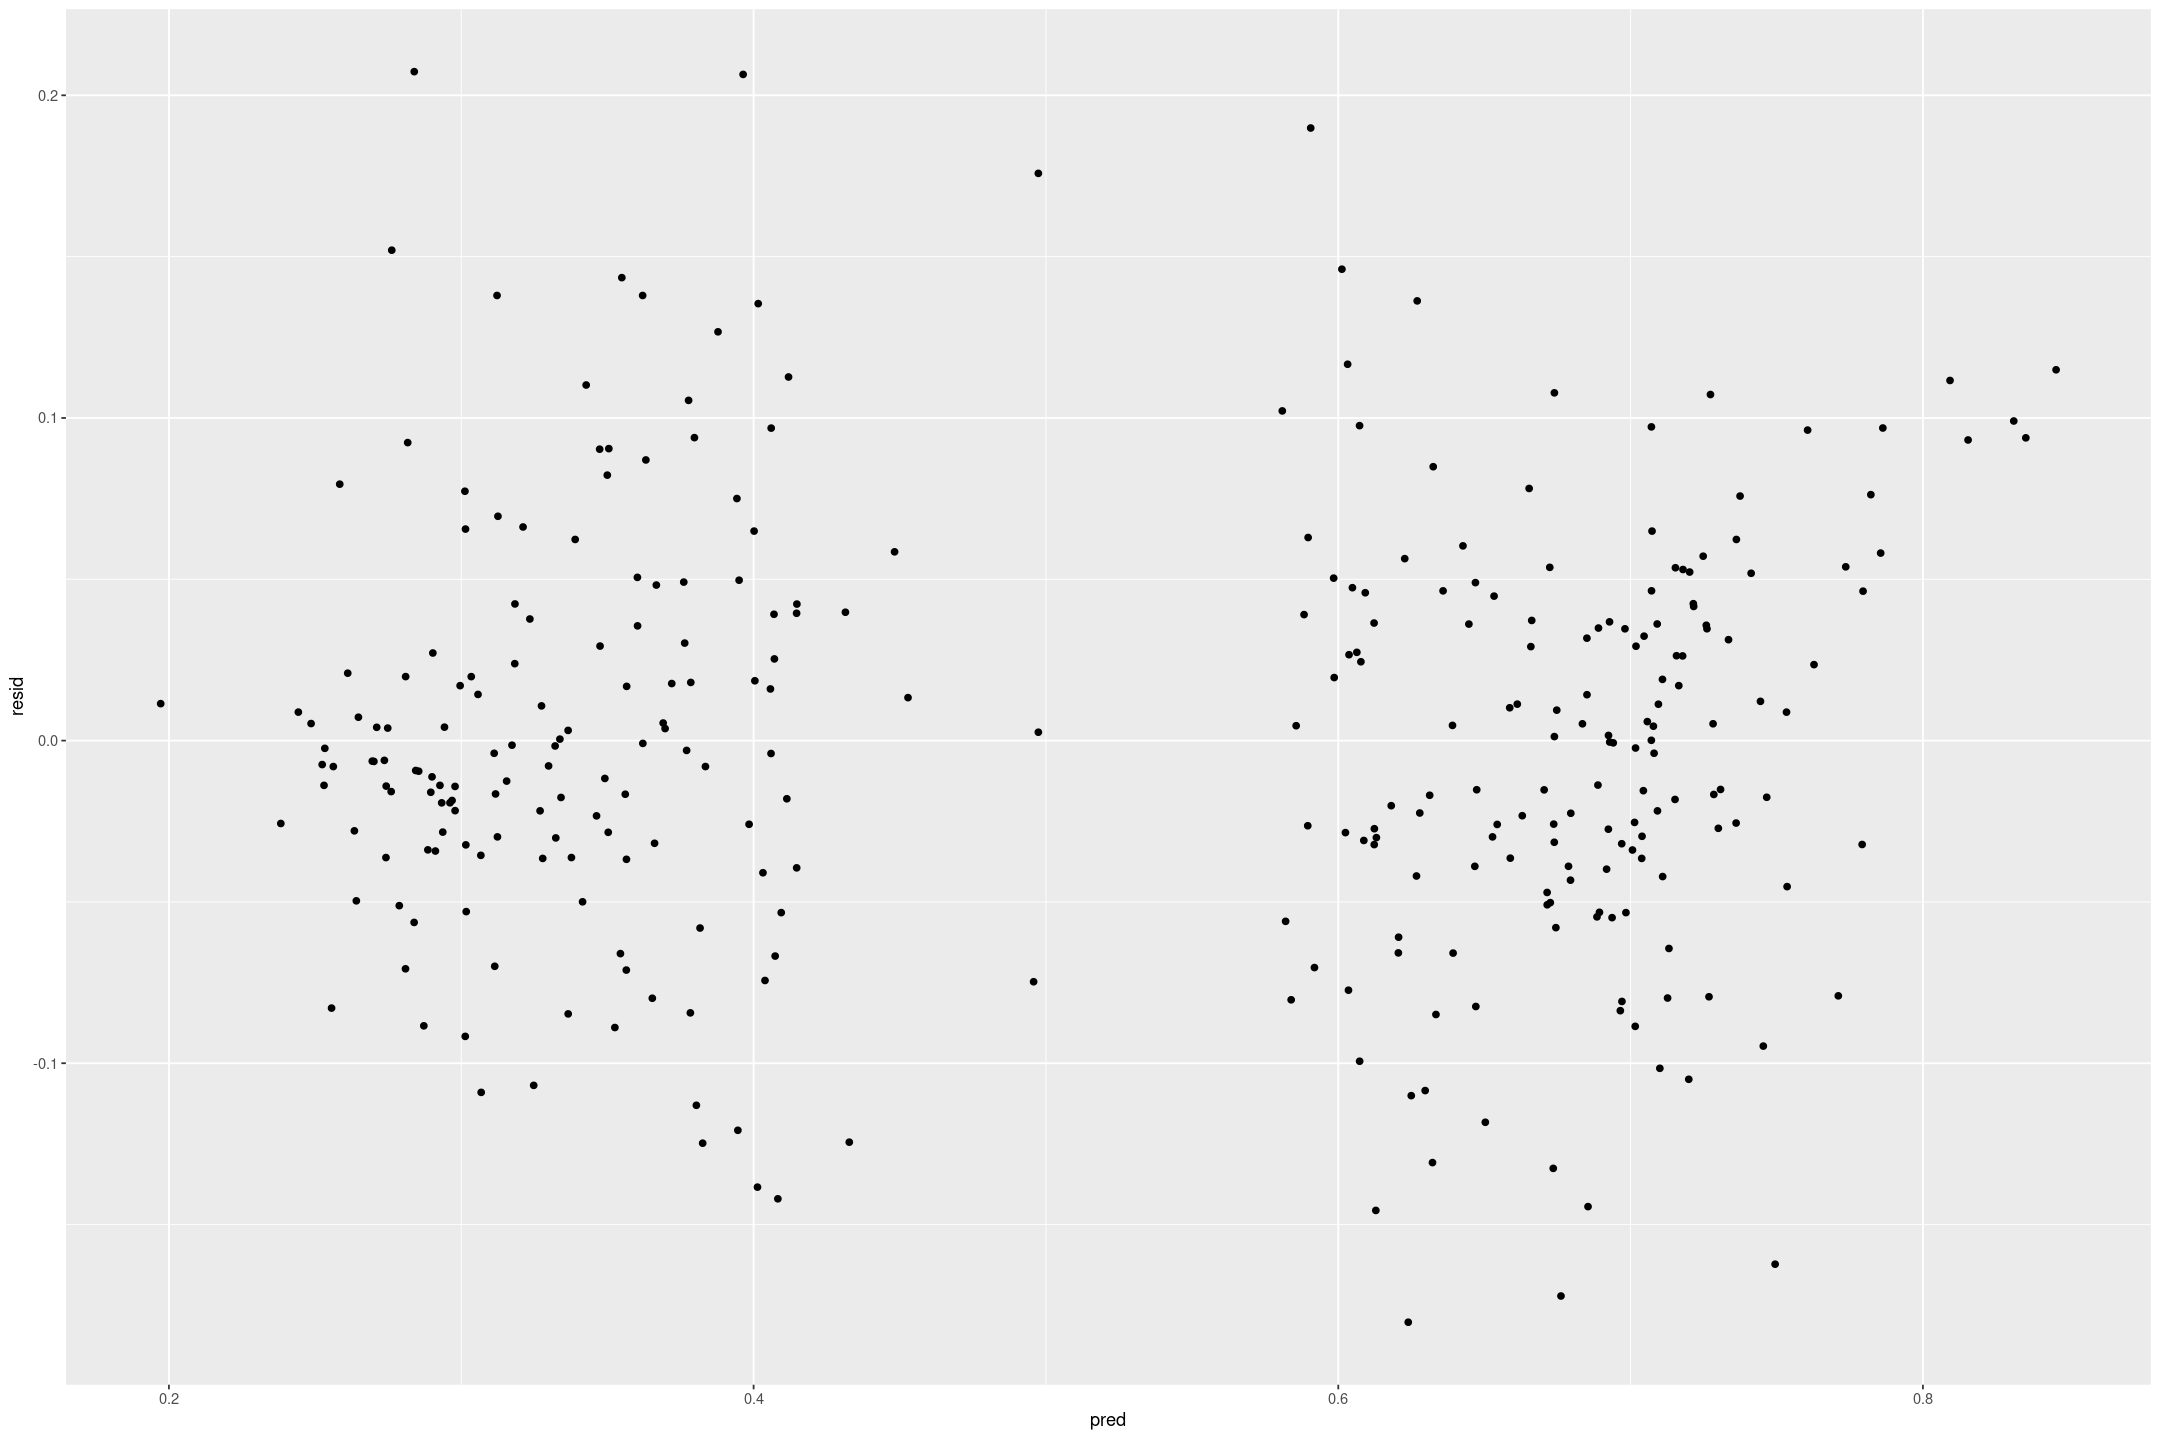

In [200]:
congress %>%
mutate(pred = predict(fit_congress),
       resid = v88 - pred) %>%
gf_point(resid ~ pred)

The overall distribution is not too bad, although doesn't quite capture the lower peak

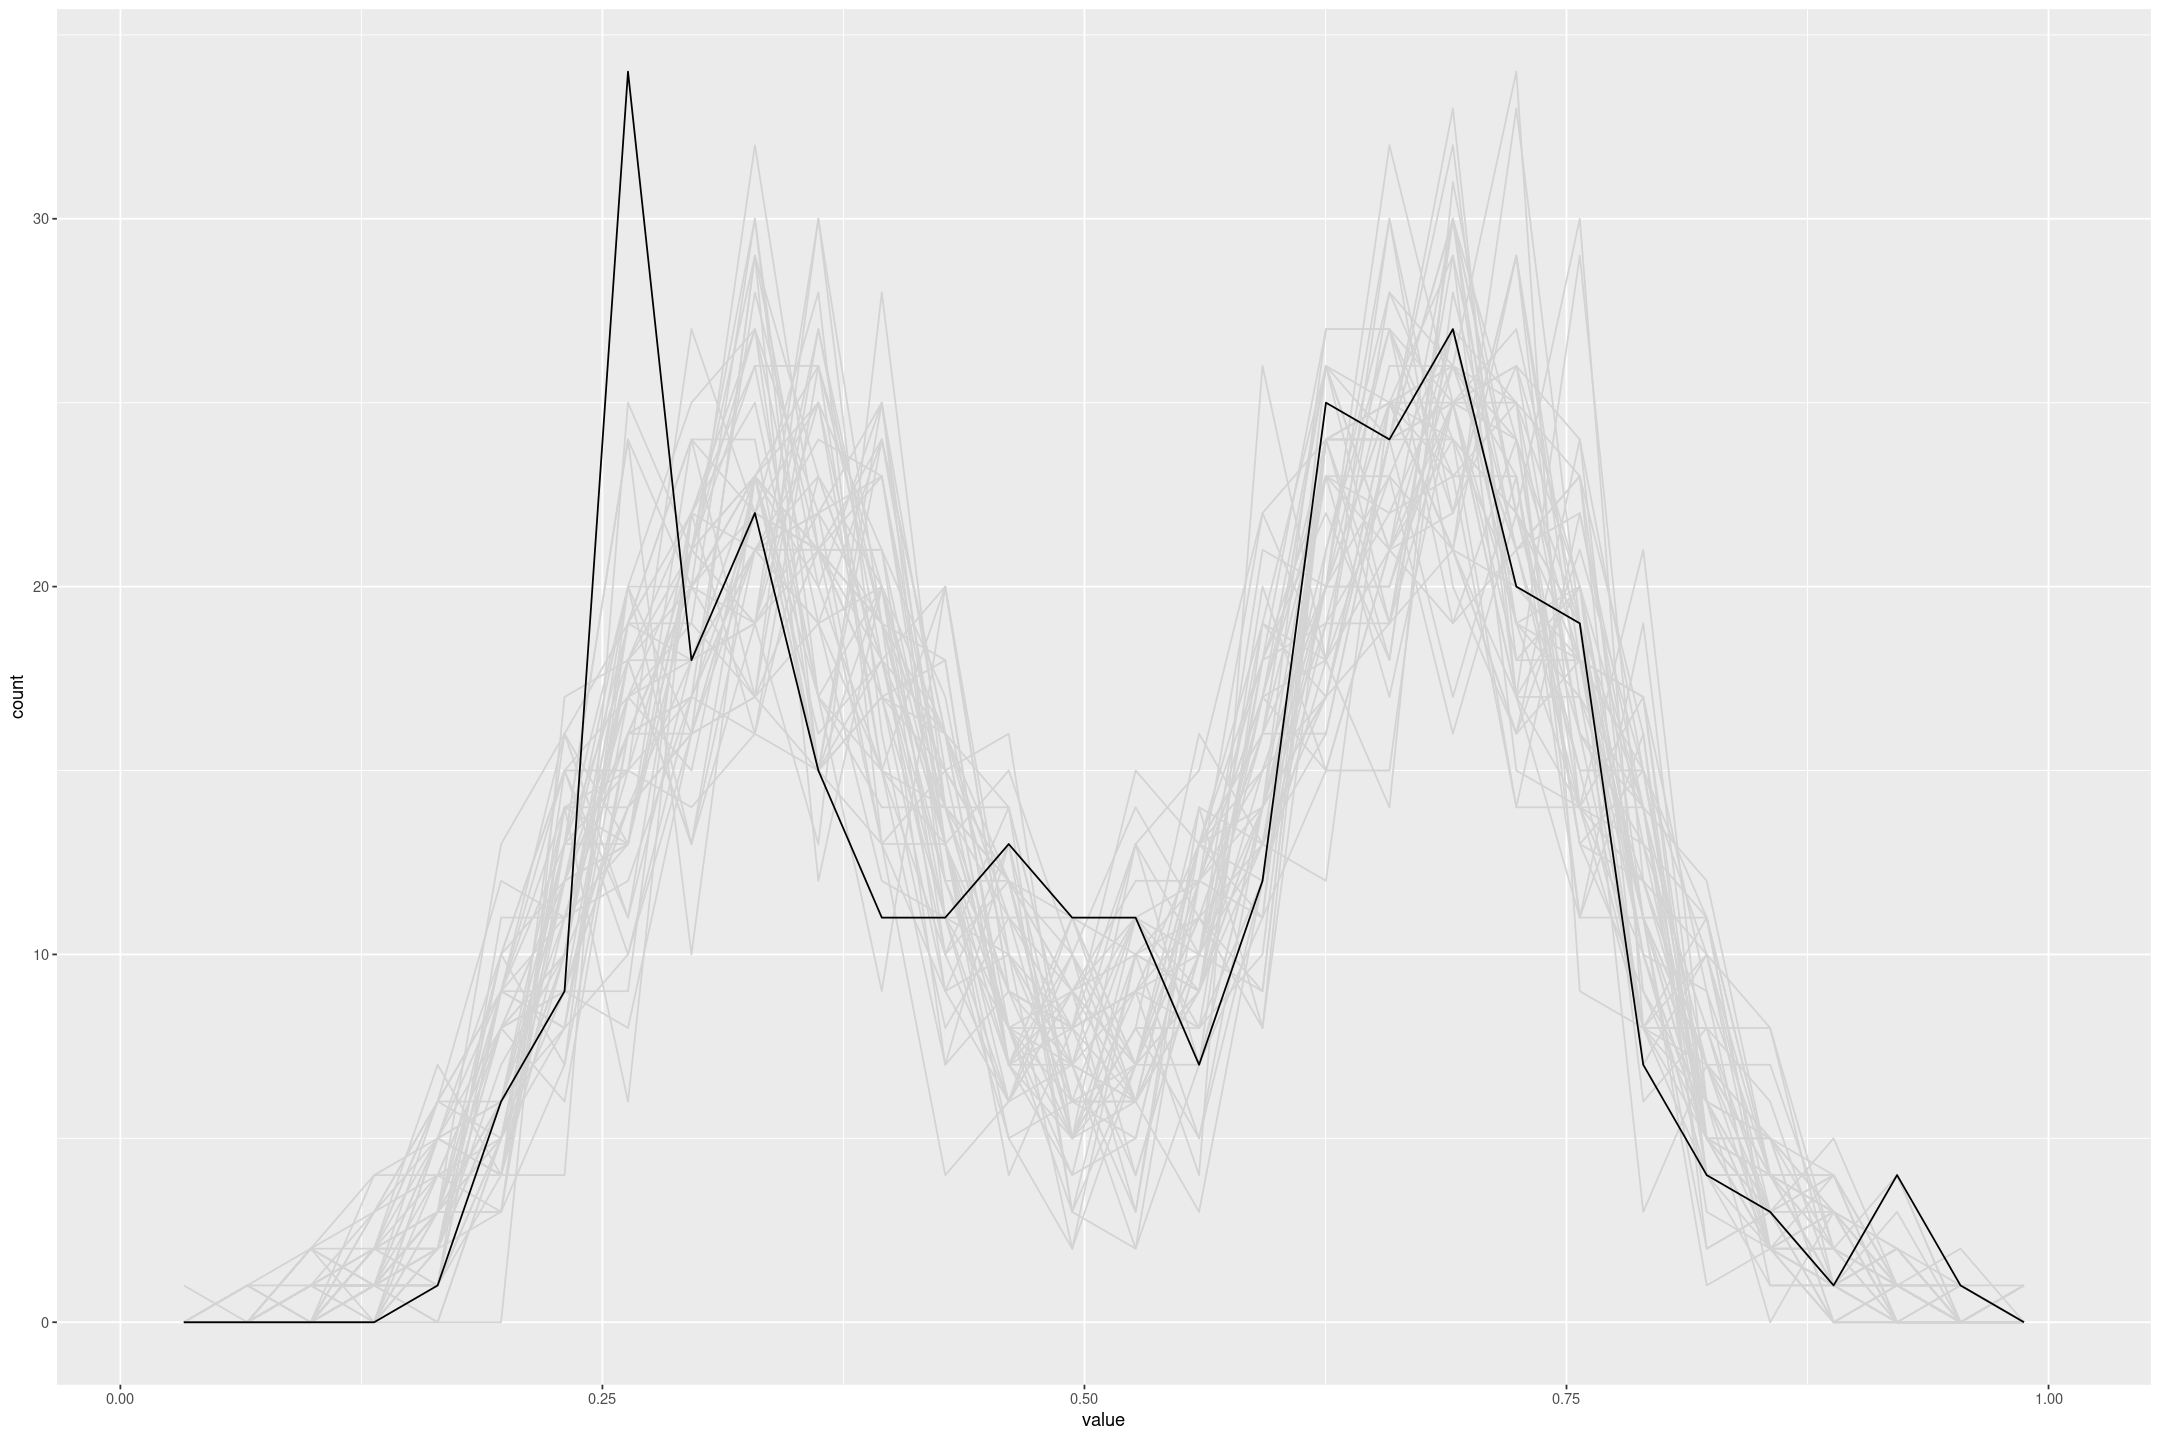

In [201]:
posterior_predict(fit_congress, draws=50) %>%
as.data.frame() %>%
mutate(draw = row_number()) %>%
pivot_longer(-draw) %>%
gf_freqpoly(~value, group=~draw, colour="lightgrey", bins=30) %>%
gf_freqpoly(~v88, group=FALSE, data=congress, bins=30)

Let's generate some predicted 2 sigma intervals and compare the data

In [202]:
fake_congress <- crossing(v86 =seq(0, 1, by=0.01), inc88=c(-1, 0,1))

fake_congress_summary <- 
posterior_predict(fit_congress, newdata=fake_congress) %>%
t() %>%
as.data.frame() %>%
cbind(fake_congress) %>%
pivot_longer(-colnames(fake_congress)) %>%
group_by(v86, inc88) %>%
summarise(v88 = median(value), upper = quantile(value, 0.975), lower = quantile(value, 0.025))

`summarise()` has grouped output by 'v86'. You can override using the `.groups` argument.



The predicted ranges from posterior predict seem reasonable to me - if anything a bit too conservative.

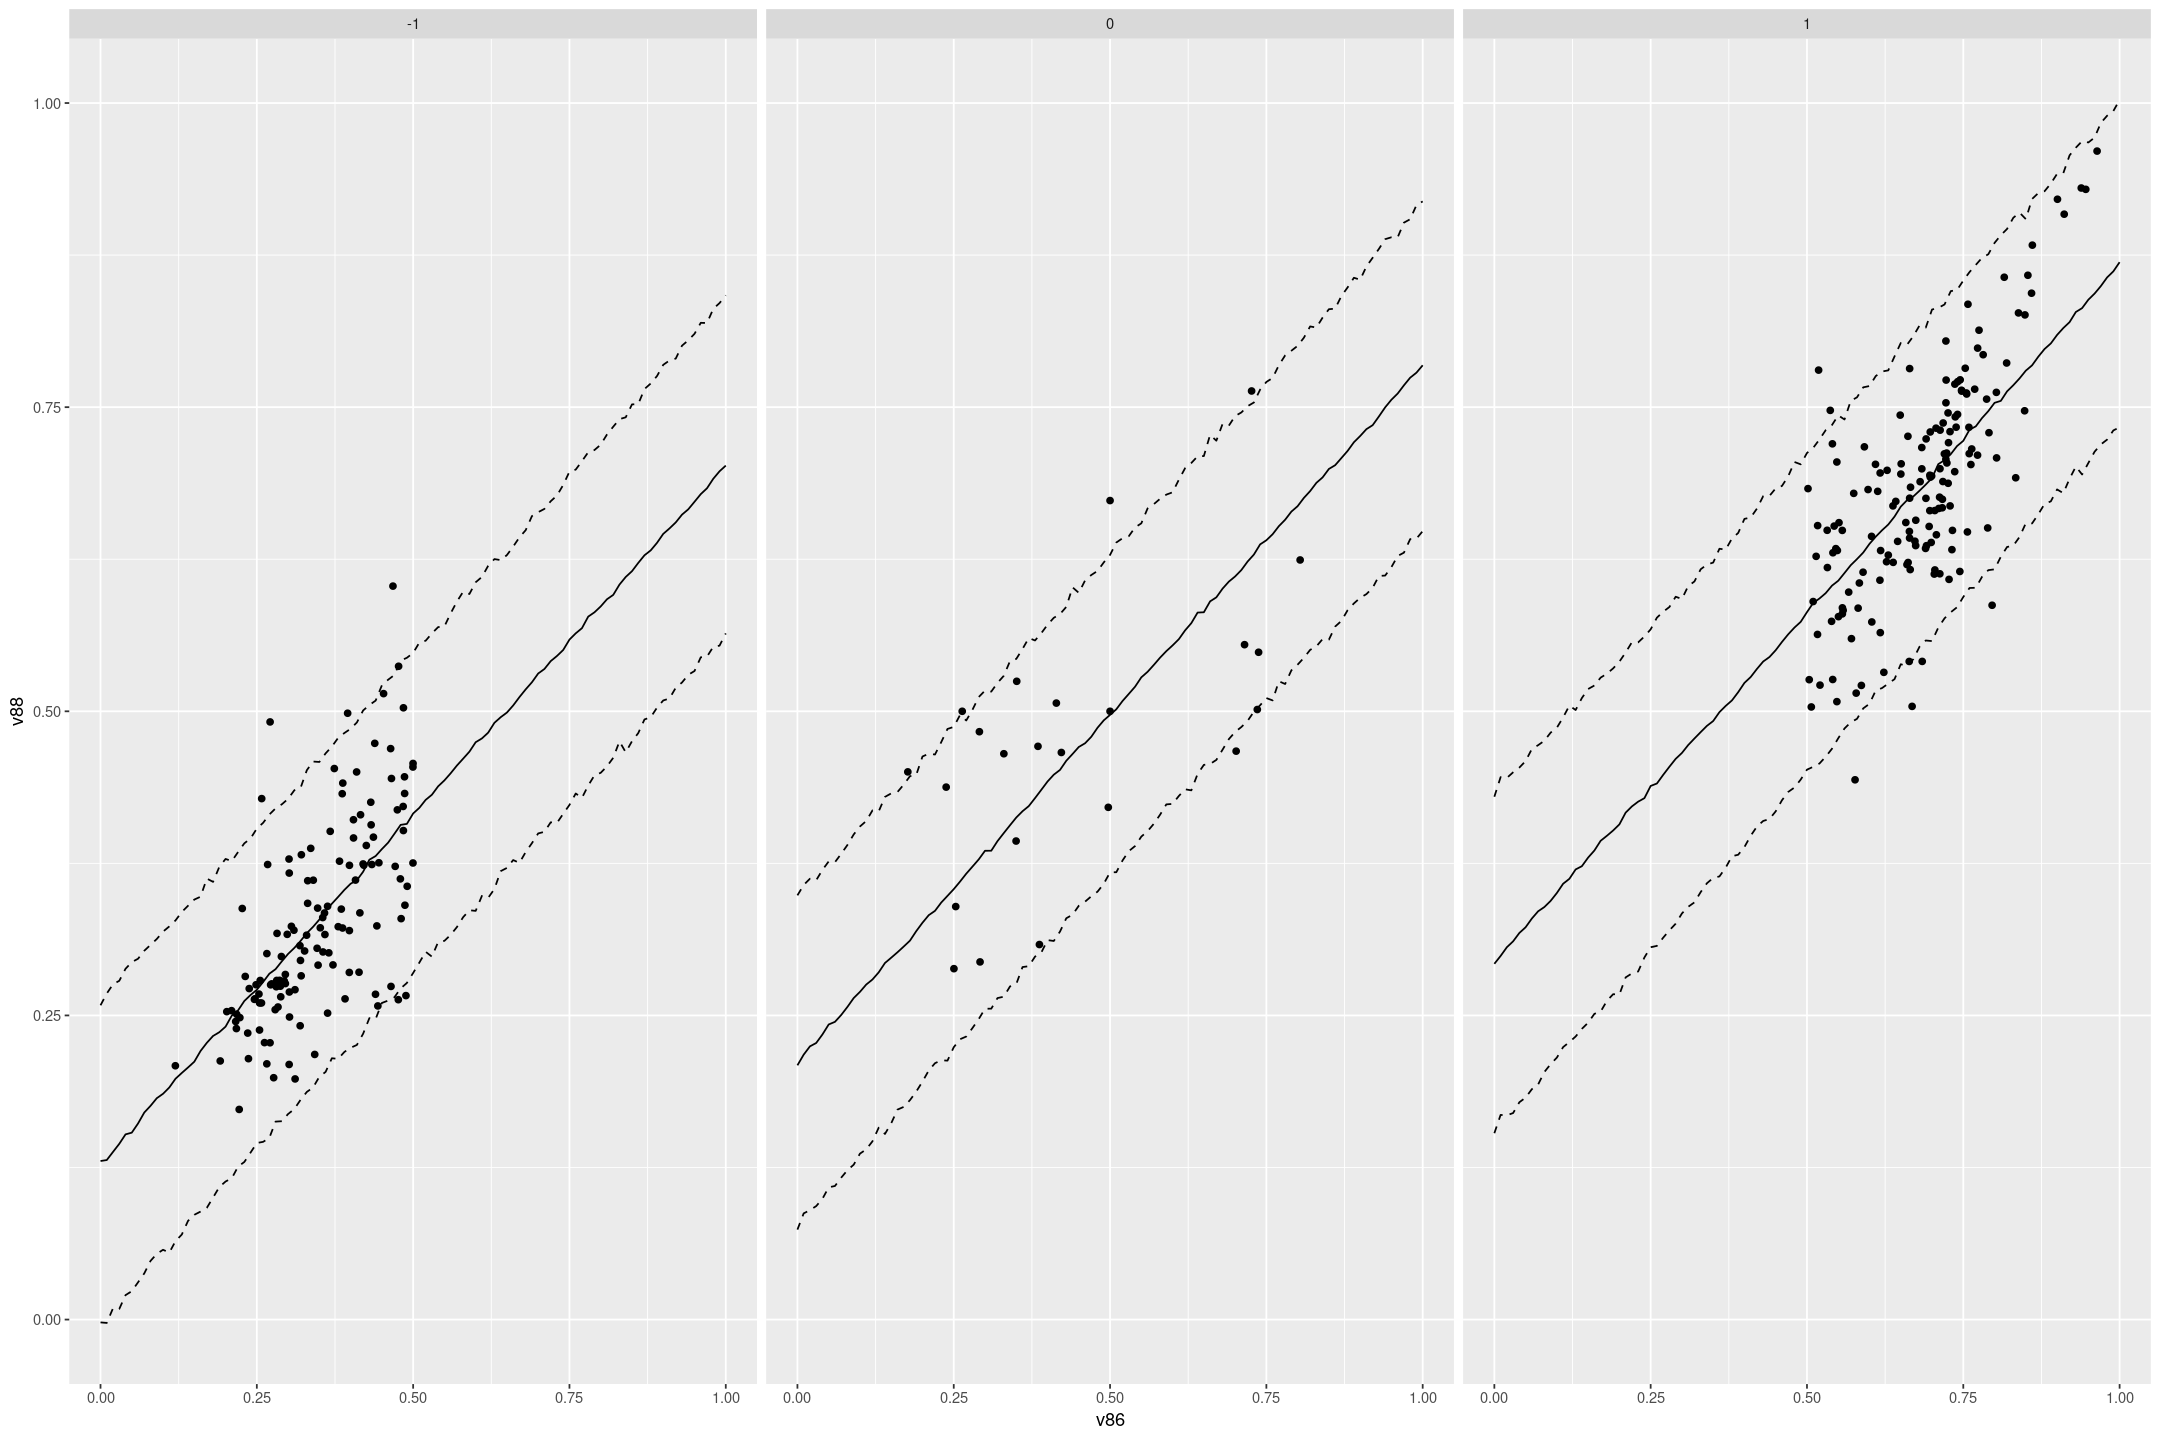

In [203]:
congress %>% 
gf_point(v88 ~ v86 | as.factor(inc88)) %>%
gf_line(data=fake_congress_summary) %>%
gf_line(upper ~ v86, data=fake_congress_summary, linetype='dashed') %>%
gf_line(lower ~ v86, data=fake_congress_summary, linetype='dashed')

## t Distribution rergression

Fit the same sort of model using the `brms` package with a $t$ distribution, using the `brm` function with the `student` family.
Again assess model fit.

In [204]:
library(brms)

Loading 'brms' package (version 2.16.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: ‘brms’


The following object is masked from ‘package:rstan’:

    loo


The following objects are masked from ‘package:rstanarm’:

    dirichlet, exponential, get_y, lasso, ngrps


The following object is masked from ‘package:stats’:

    ar




In [205]:
fit_congress_student <- brm(v88 ~ inc88 + v86, family=student, data=congress)

Compiling Stan program...

Start sampling



The way it summarises coefficients is a little different to rstanarm

In [206]:
fit_congress_student

 Family: student 
  Links: mu = identity; sigma = identity; nu = identity 
Formula: v88 ~ inc88 + v86 
   Data: congress (Number of observations: 316) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     0.20      0.02     0.17     0.24 1.00     2273     2569
inc88         0.08      0.01     0.07     0.10 1.00     2305     2538
v86           0.58      0.04     0.51     0.66 1.00     2240     2437

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.06      0.00     0.05     0.07 1.00     2310     2339
nu       19.23     12.40     5.79    51.15 1.00     2075     2510

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rha

But we can use the posterior draws as we can for `stanfit` or `rstanarm` models

In [207]:
3 *0.6

[1] 1.8

The `nu` coefficient of the student distribution appears to be positive, but is quite uncertain.
To my surprise the actual coefficients are different.

The prediction at 50% v86 is also 49.5%, but a 3% increase in v86 predicts a 1.8% increase in v88 (i.e. previous vote share matters almost twice as much).
And incumbency matters a little less, only contributing 8 percentage points.

In [208]:
fit_congress_student %>% 
as.data.frame() %>%
pivot_longer(everything()) %>%
group_by(name) %>%
summarise(median = median(value),
          mad_sd = mad(value)) %>%
mutate(across(-name, round, digits=2))

name        median mad_sd
1 b_inc88       0.08 0.01  
2 b_Intercept   0.20 0.02  
3 b_v86         0.58 0.04  
4 lp__        403.88 1.45  
5 nu           15.79 9.27  
6 sigma         0.06 0.00

To my eyes the residual plot looks very similar

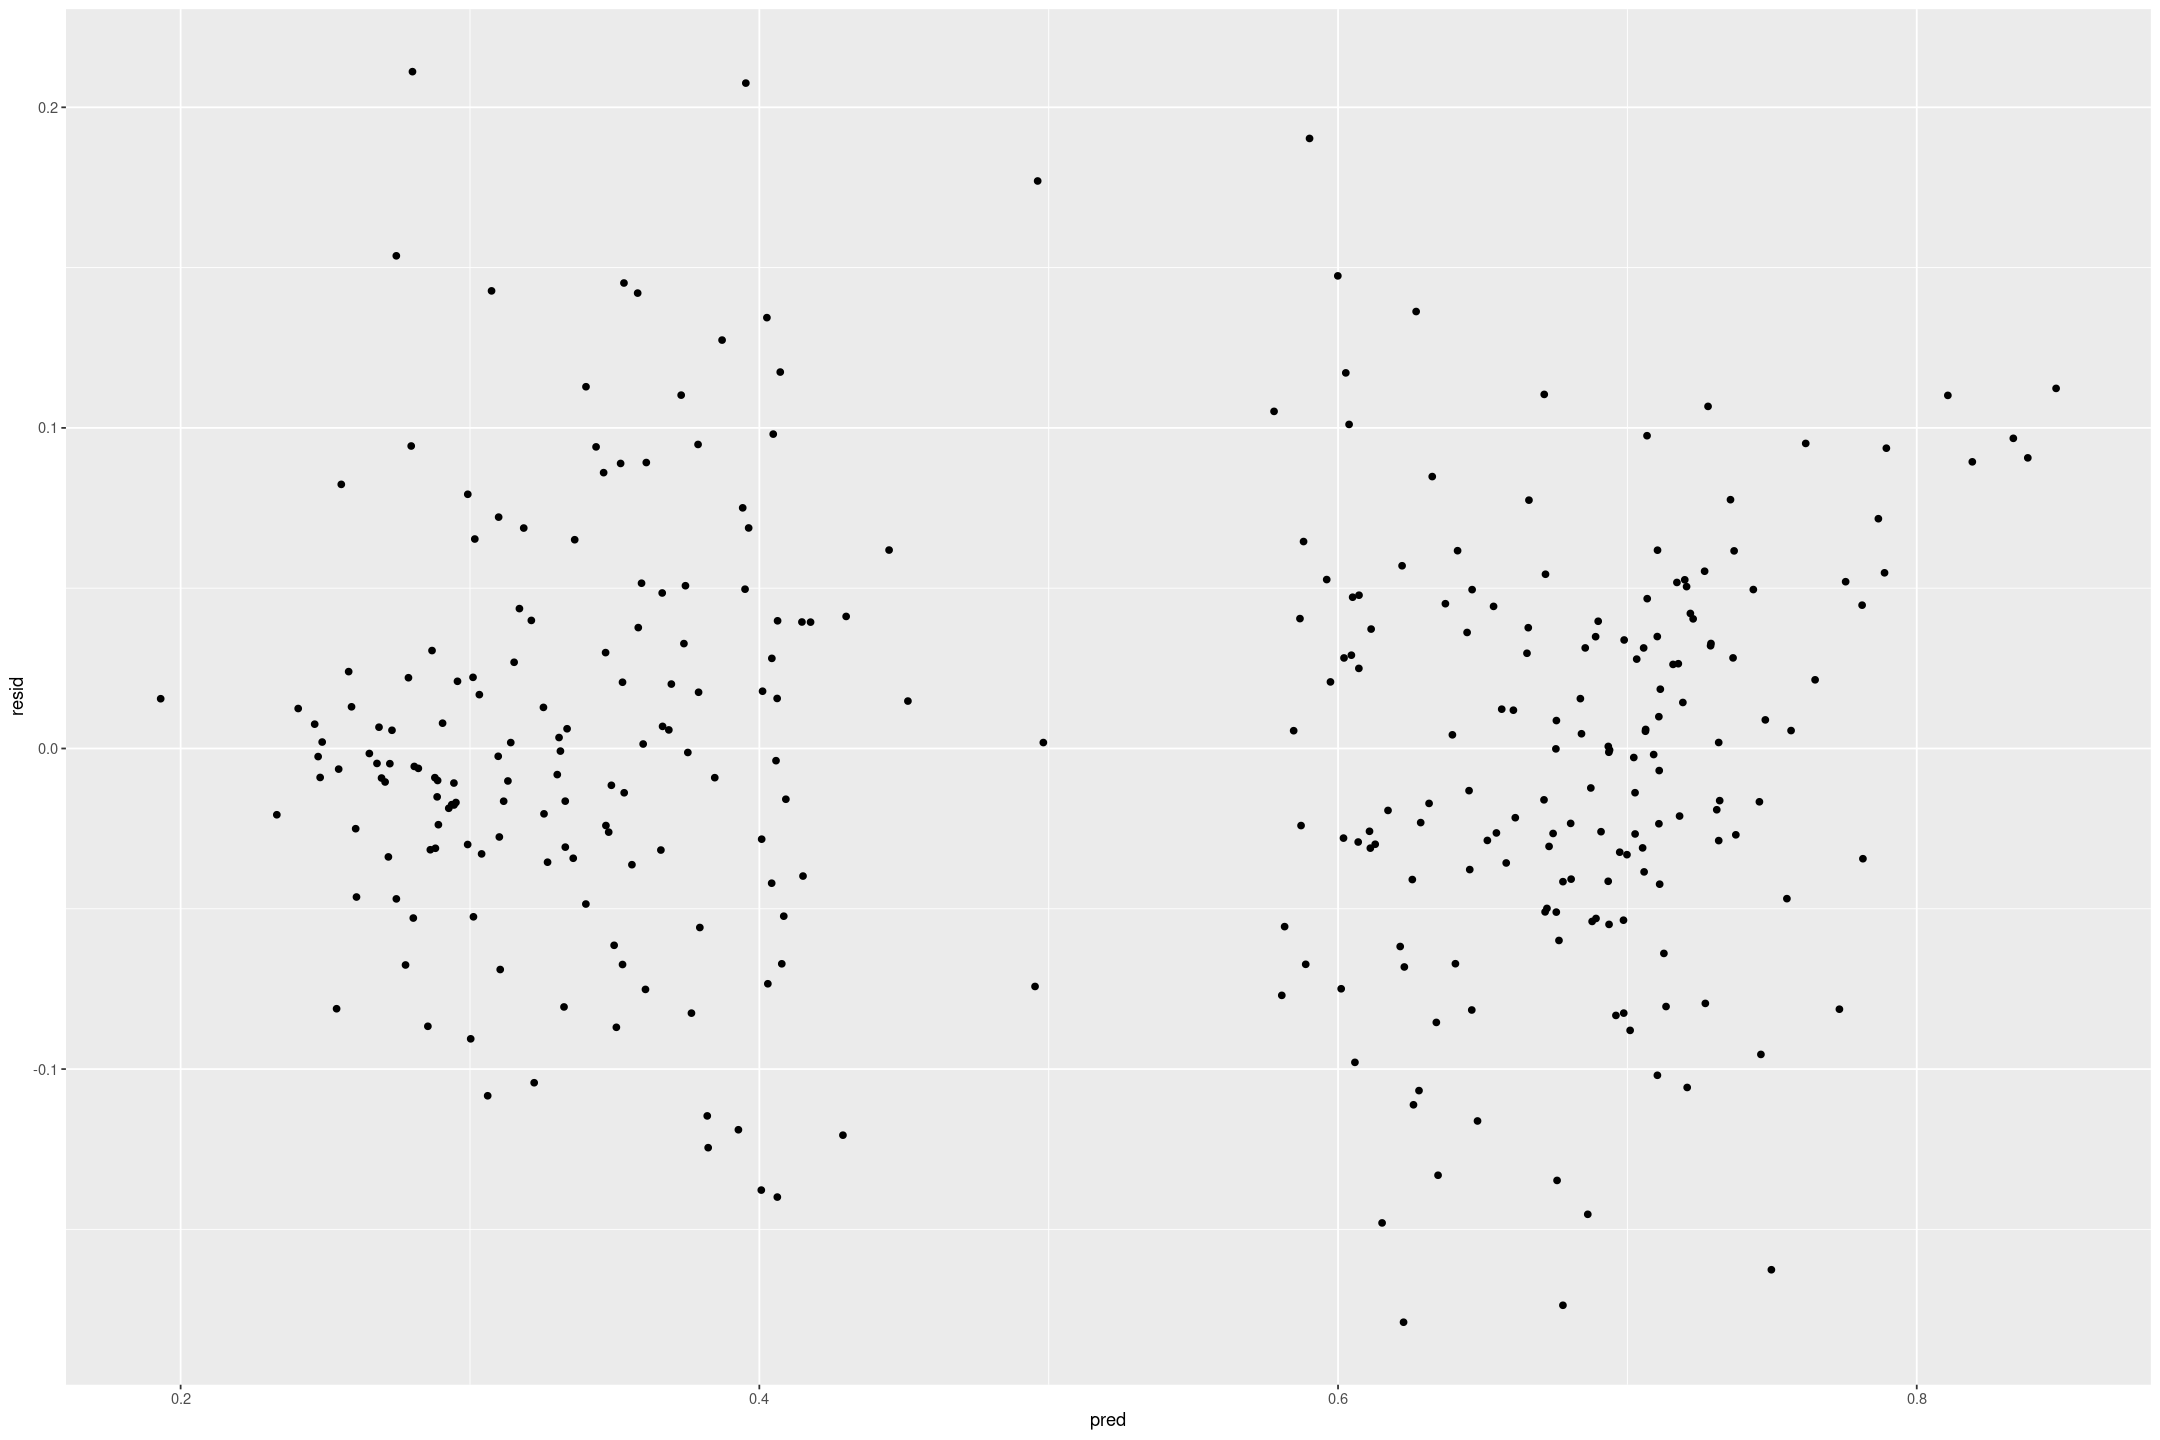

In [209]:
congress %>%
mutate(pred = predict(fit_congress_student, robust=TRUE)[,'Estimate'],
       resid = v88 - pred) %>%
gf_point(resid ~ pred)

The distribution captures the first peak a bit better, but as the previous model underestimates the probability of very close elections.

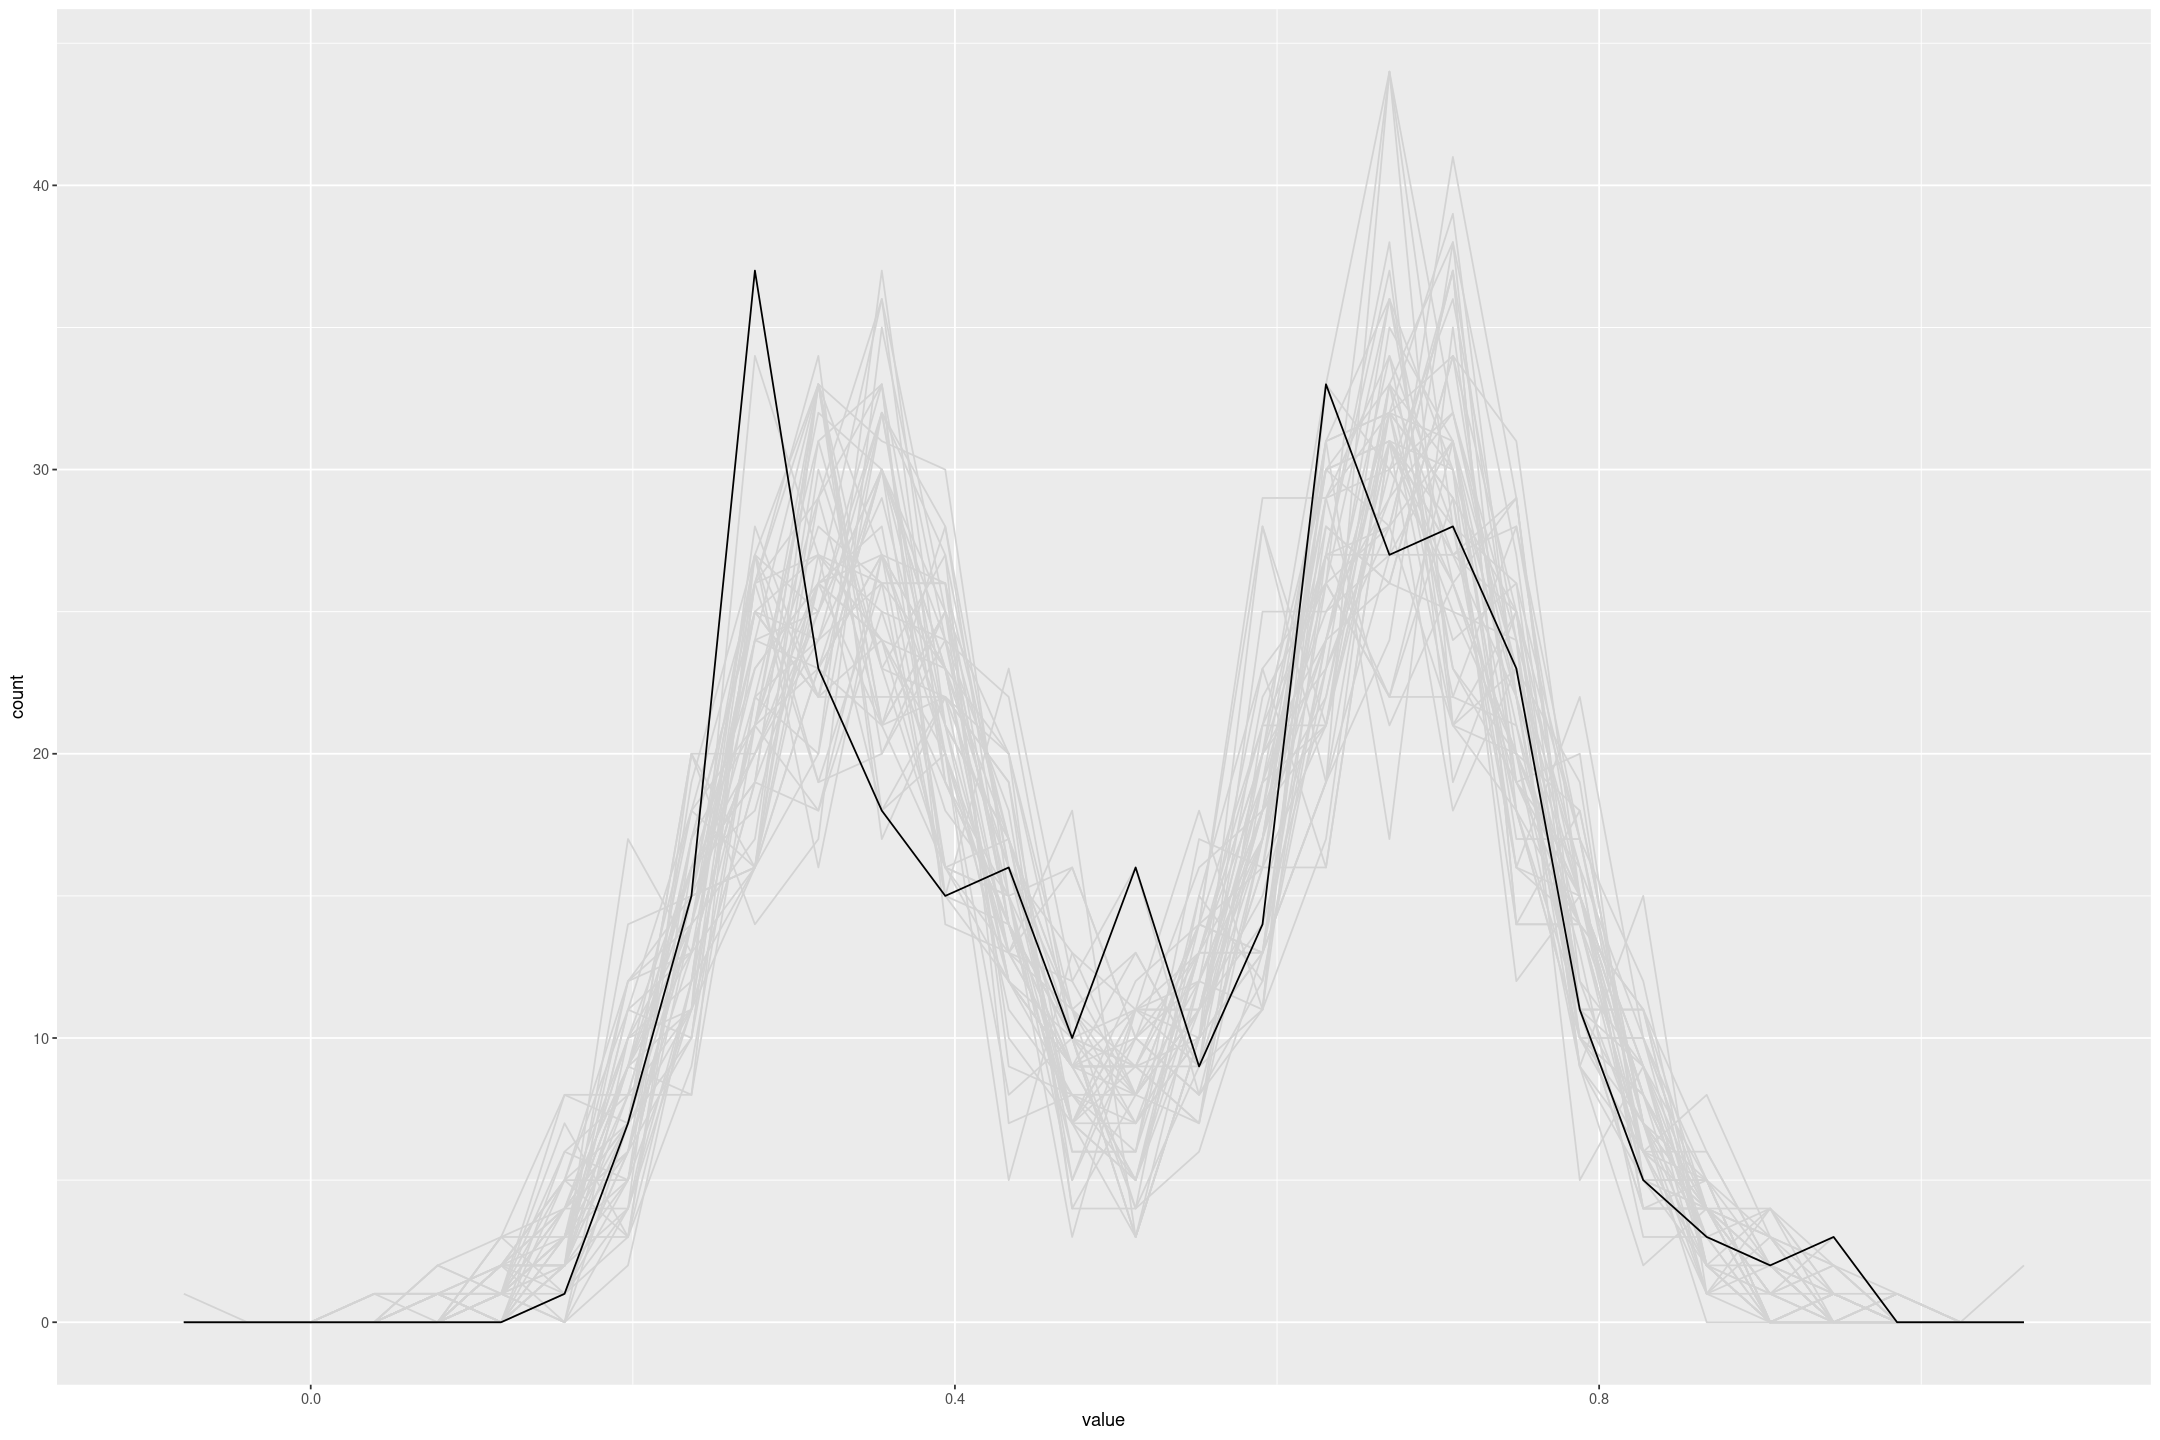

In [210]:
posterior_predict(fit_congress_student) %>%
head(50) %>%
as.data.frame() %>%
mutate(draw = row_number()) %>%
pivot_longer(-draw) %>%
gf_freqpoly(~value, group=~draw, colour="lightgrey", bins=30) %>%
gf_freqpoly(~v88, group=FALSE, data=congress, bins=30)

In [211]:
fake_congress_student_summary <- 
posterior_predict(fit_congress_student, newdata=fake_congress) %>%
t() %>%
as.data.frame() %>%
cbind(fake_congress) %>%
pivot_longer(-colnames(fake_congress)) %>%
group_by(v86, inc88) %>%
summarise(v88 = median(value), upper = quantile(value, 0.975), lower = quantile(value, 0.025))

`summarise()` has grouped output by 'v86'. You can override using the `.groups` argument.



The predicted ranges from posterior predict seem reasonable as well.

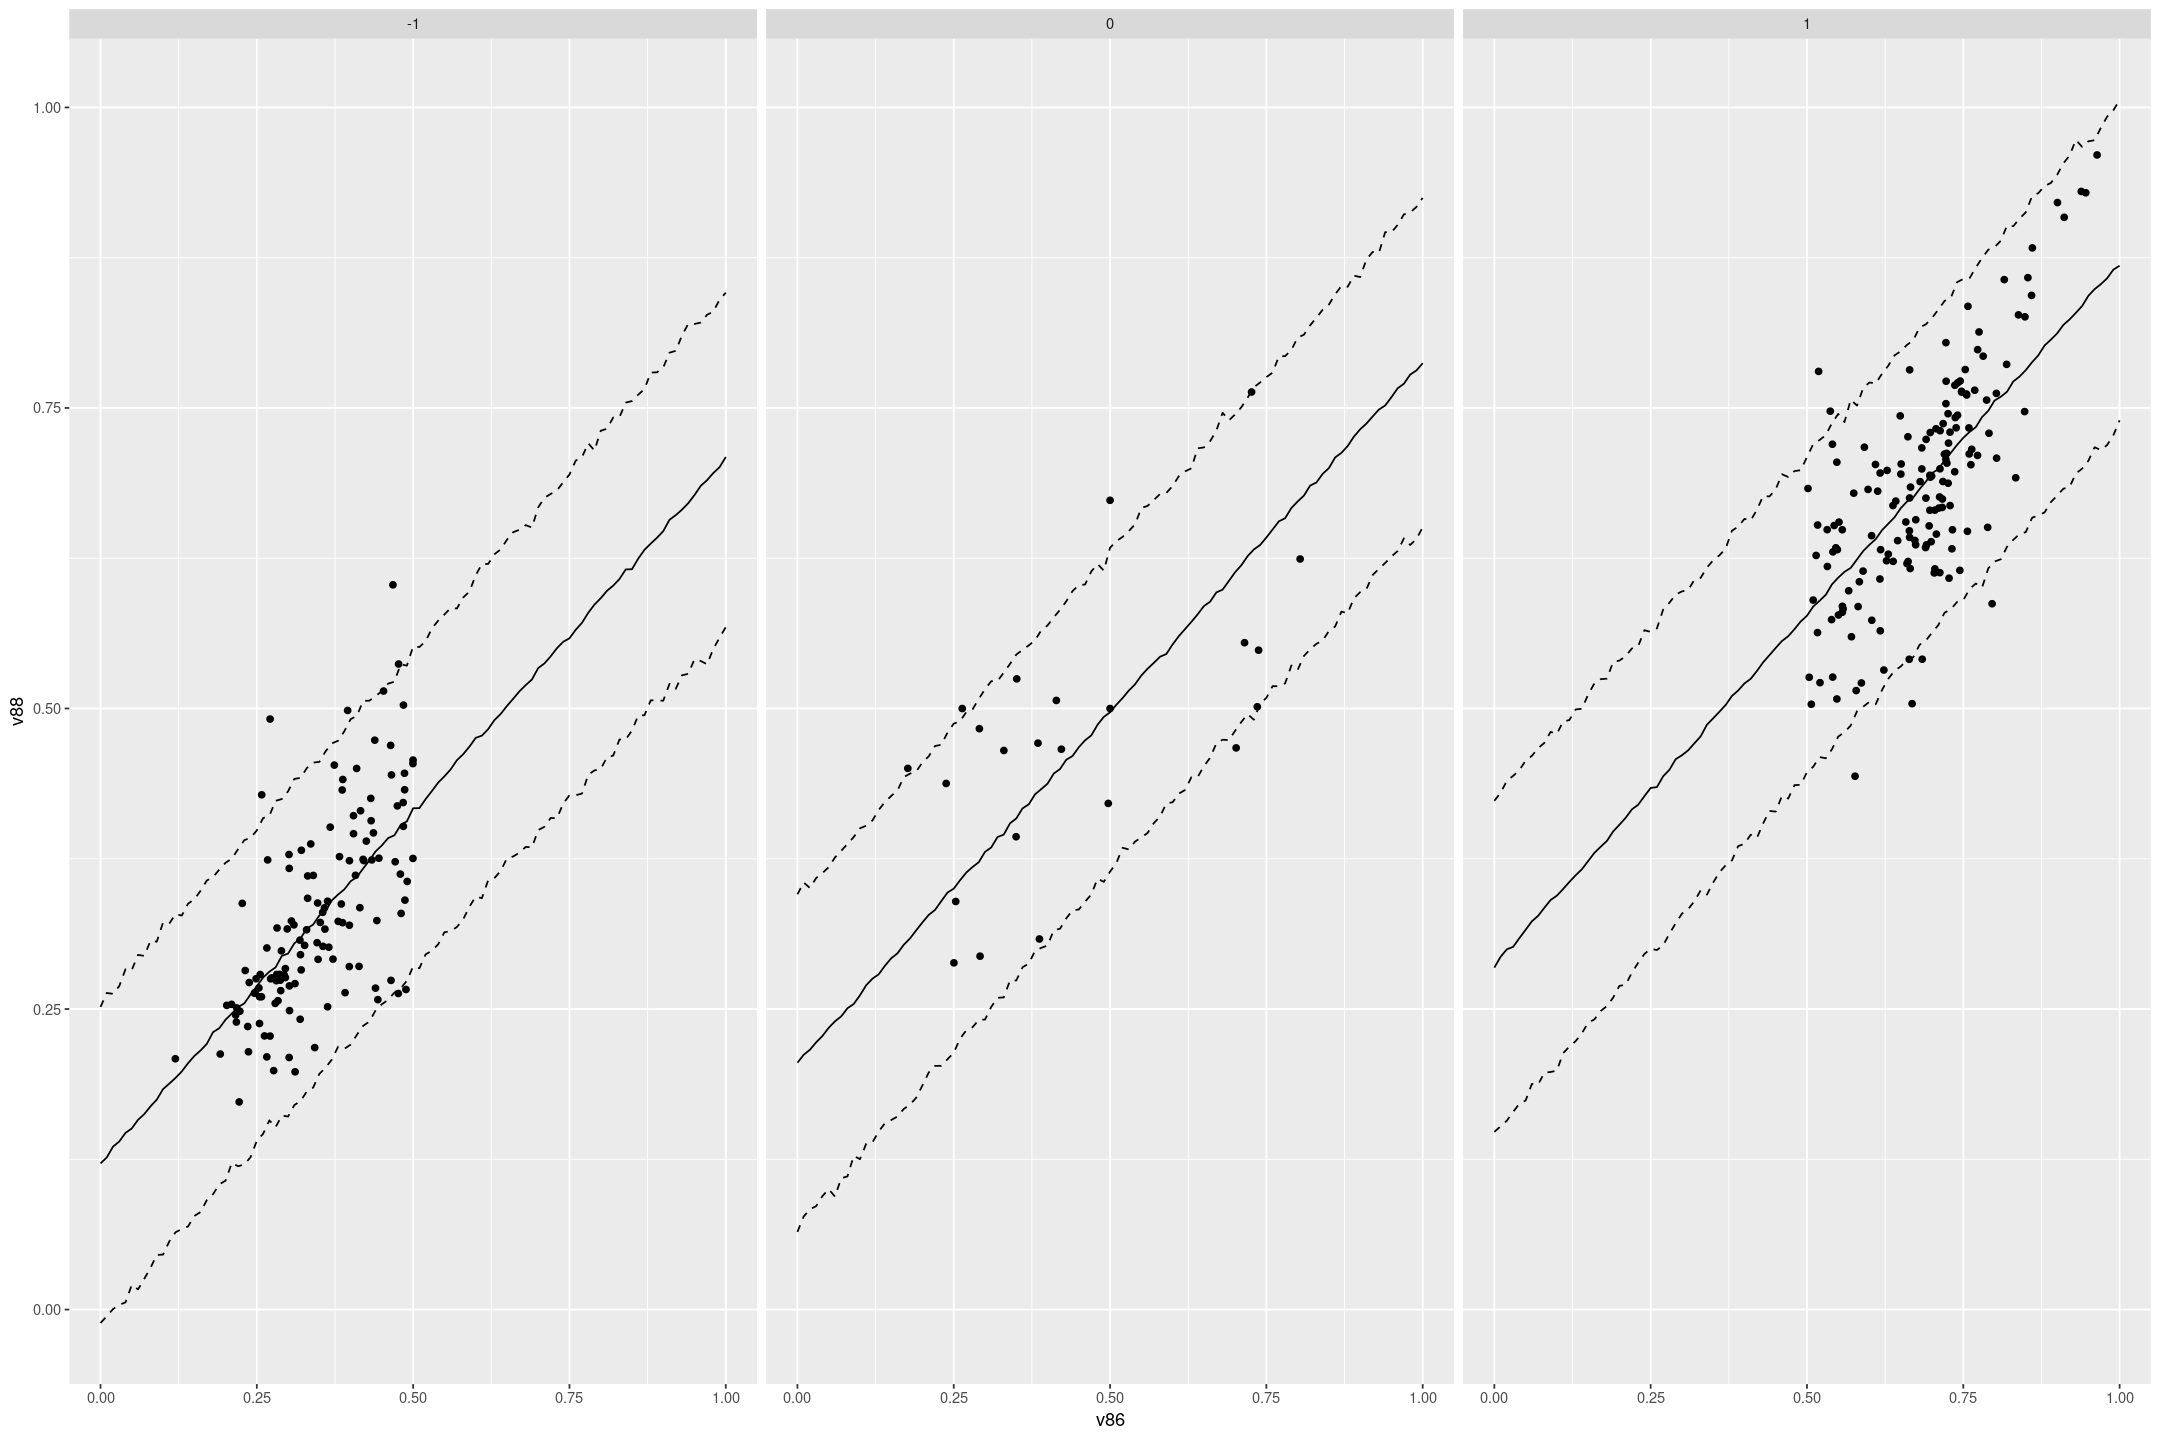

In [212]:
congress %>% 
gf_point(v88 ~ v86 | as.factor(inc88)) %>%
gf_line(data=fake_congress_student_summary) %>%
gf_line(upper ~ v86, data=fake_congress_student_summary, linetype='dashed') %>%
gf_line(lower ~ v86, data=fake_congress_student_summary, linetype='dashed')

## Comparing models

Which model do you prefer?

To me the models seem very similar, I have a *slight* preference for the Student t-distribution because the posterior distribution matches slightly closer.

Let's compare them using Leave-One-Out cross-validation

In [213]:
loo_congress <- loo(fit_congress)

In [214]:
loo_congress_student <- loo(fit_congress_student)

The student fit looks like it may be a little bit better, but they are very close, matching my assessment from the model diagnostics.

In [215]:
loo_compare(loo_congress, loo_congress_student)

elpd_diff se_diff  elpd_loo se_elpd_loo p_loo    se_p_loo 
fit_congress_student  0.000000 0.000000 408.0482 14.17399    4.950097 0.4320105
fit_congress         -1.033787 1.319643 407.0144 13.88801    4.680571 0.5336124
                     looic     se_looic
fit_congress_student -816.0963 28.34798
fit_congress         -814.0287 27.77603

# Robust regression for binary data using the robit model

Use the same data as the previous example with the goal instead of predicting for each district whether it was won by the Democratic or Republican Candidate.

Apparently there were two dead ties (!?!), so it makes sense to filter these out.

In [216]:
congress %>% filter(v88==0.5)

v88 inc88 v86      
1 0.5 0     0.5000000
2 0.5 0     0.2635657

In [217]:
congress_binary <- congress %>% filter(v88 != 0.5) %>% mutate(dem=if_else(v88 > 0.5, 1,0))

## Logsitic/probit regression

Fit a standard logistic or probit regression and assess model fit.

In [218]:
fit_congress_binary <- stan_glm(dem ~ v86 + inc88, family=binomial(link='logit'), data=congress_binary)

The predictions are much different for this model with less information.
With a 50% 1986 vote share, it predicts a 59% probability of a Democrat win.

In [219]:
invlogit(coef(fit_congress_binary)[['(Intercept)']] + coef(fit_congress_binary)[['v86']]*0.5) %>% scales::percent()

[1] "60%"

Being incumbent gives a *very* large boost, and an increase in 3% increase in v86 corresponds to roughly a 10% increase chance in winning (using divide by 4 rule)

In [220]:
fit_congress_binary

stan_glm
 family:       binomial [logit]
 formula:      dem ~ v86 + inc88
 observations: 314
 predictors:   3
------
            Median MAD_SD
(Intercept) -6.4    1.8  
v86         13.7    3.8  
inc88        2.6    0.5  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

To assess model fit we could look at the binned residuals.
The probabilities are very polarised.

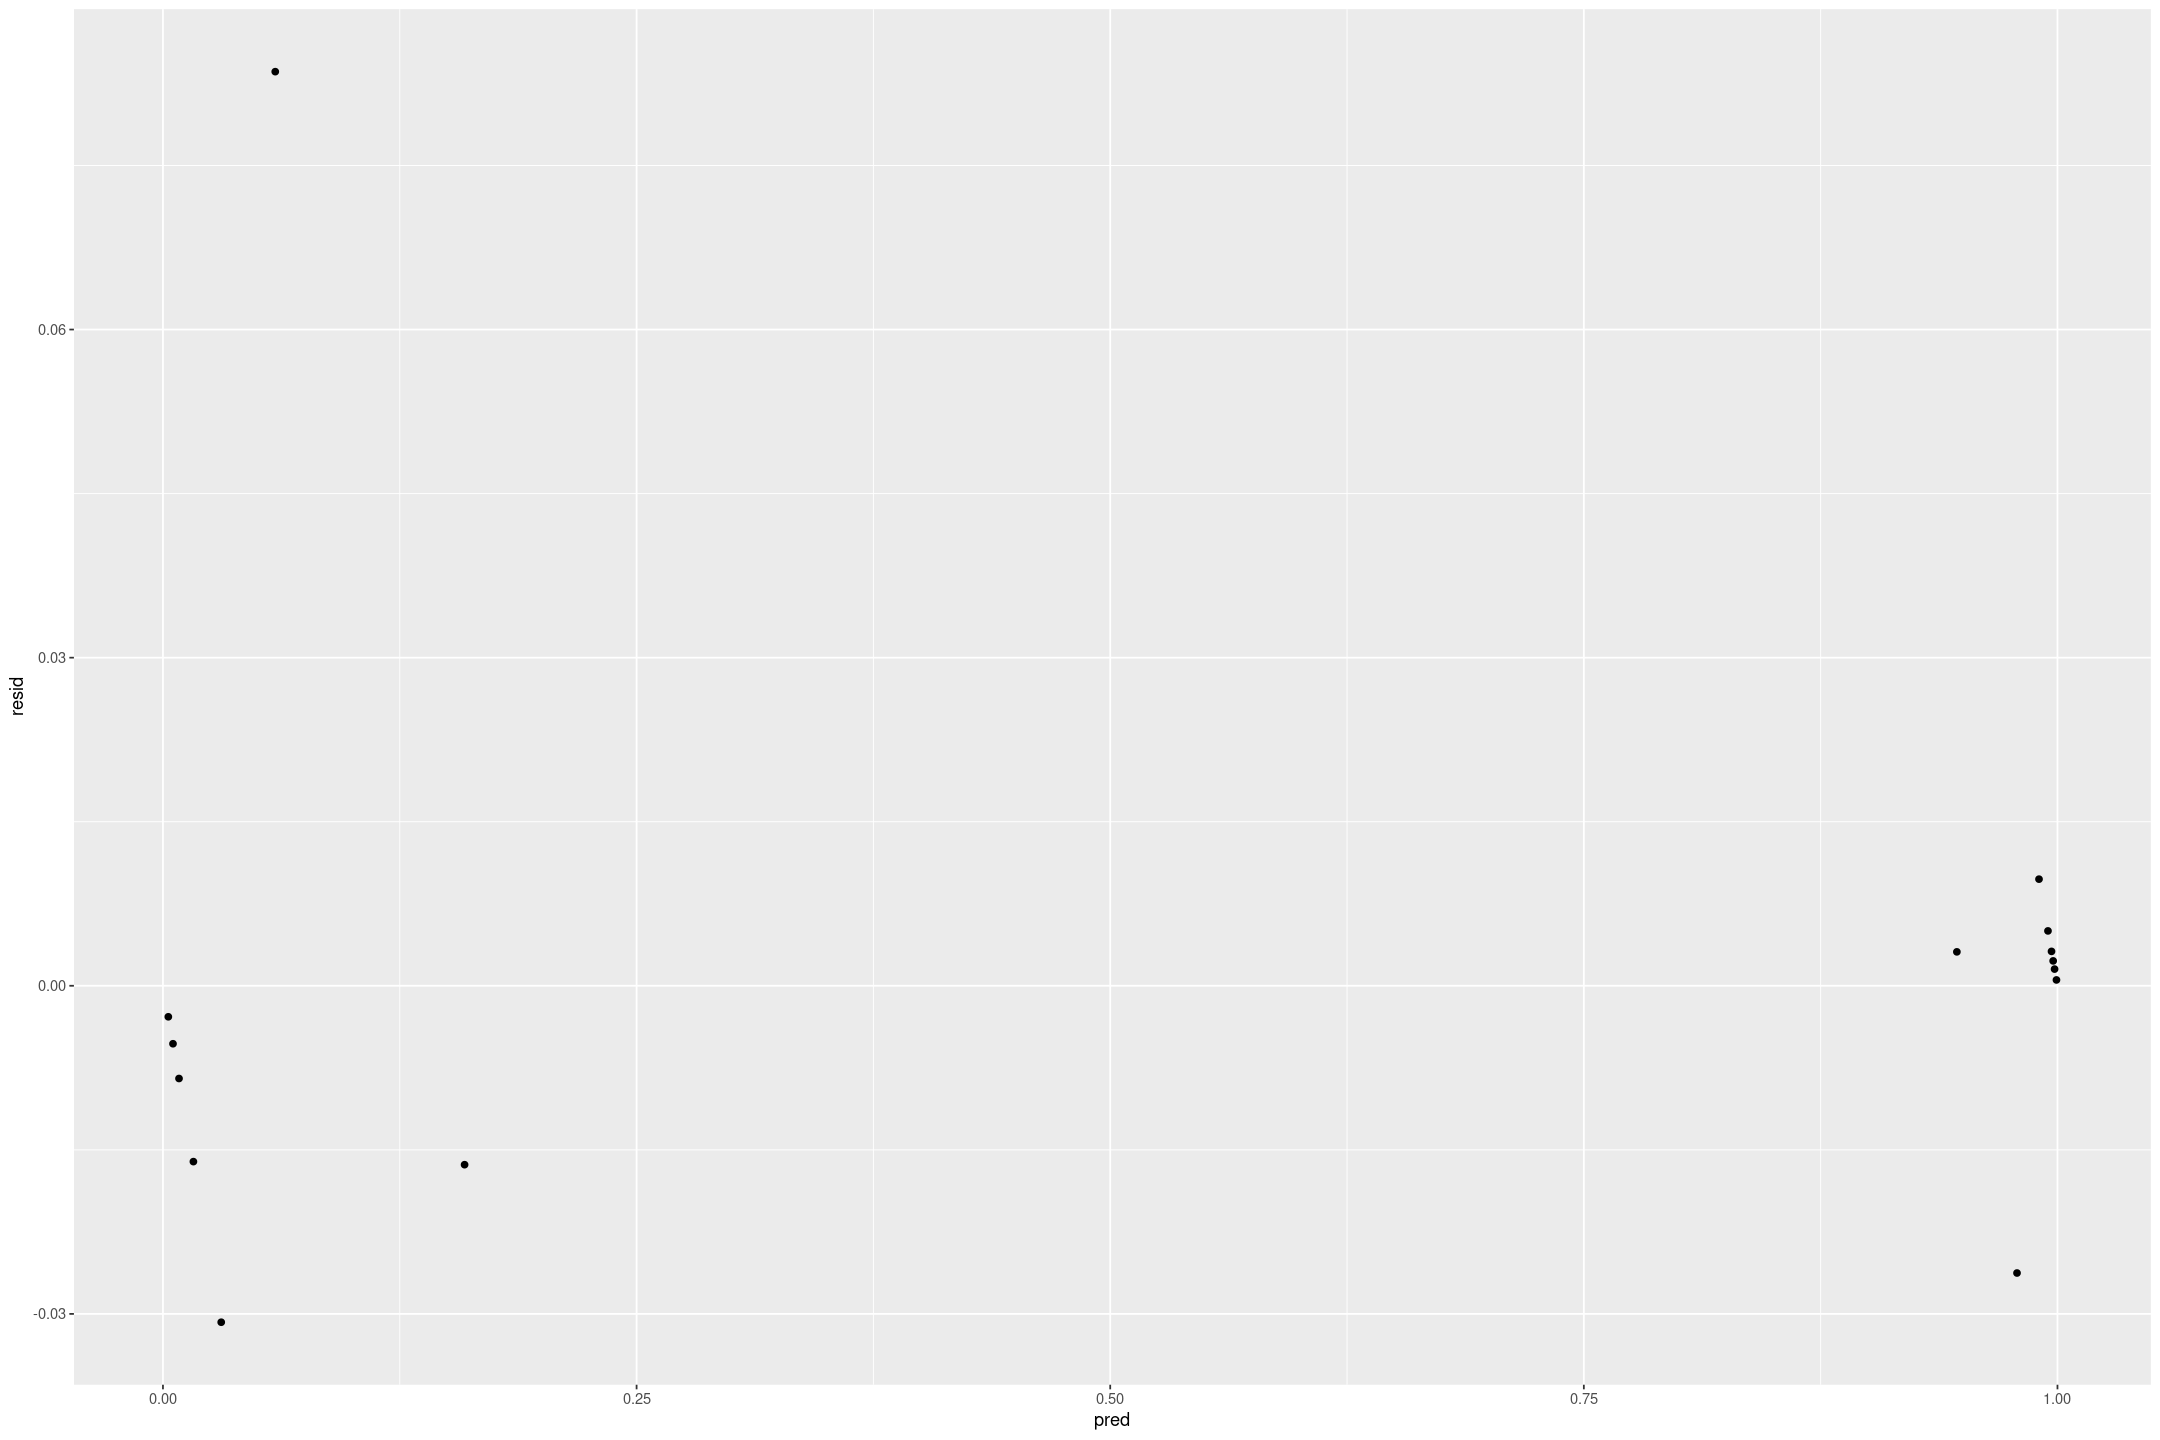

In [221]:
congress_binary %>%
mutate(pred = predict(fit_congress_binary, type="response")) %>%
group_by(bin = cut_quantile(pred, 15)) %>%
summarise(prob = mean(dem),
          pred = mean(pred)) %>%
mutate(resid = prob - pred) %>%
gf_point(resid ~ pred)

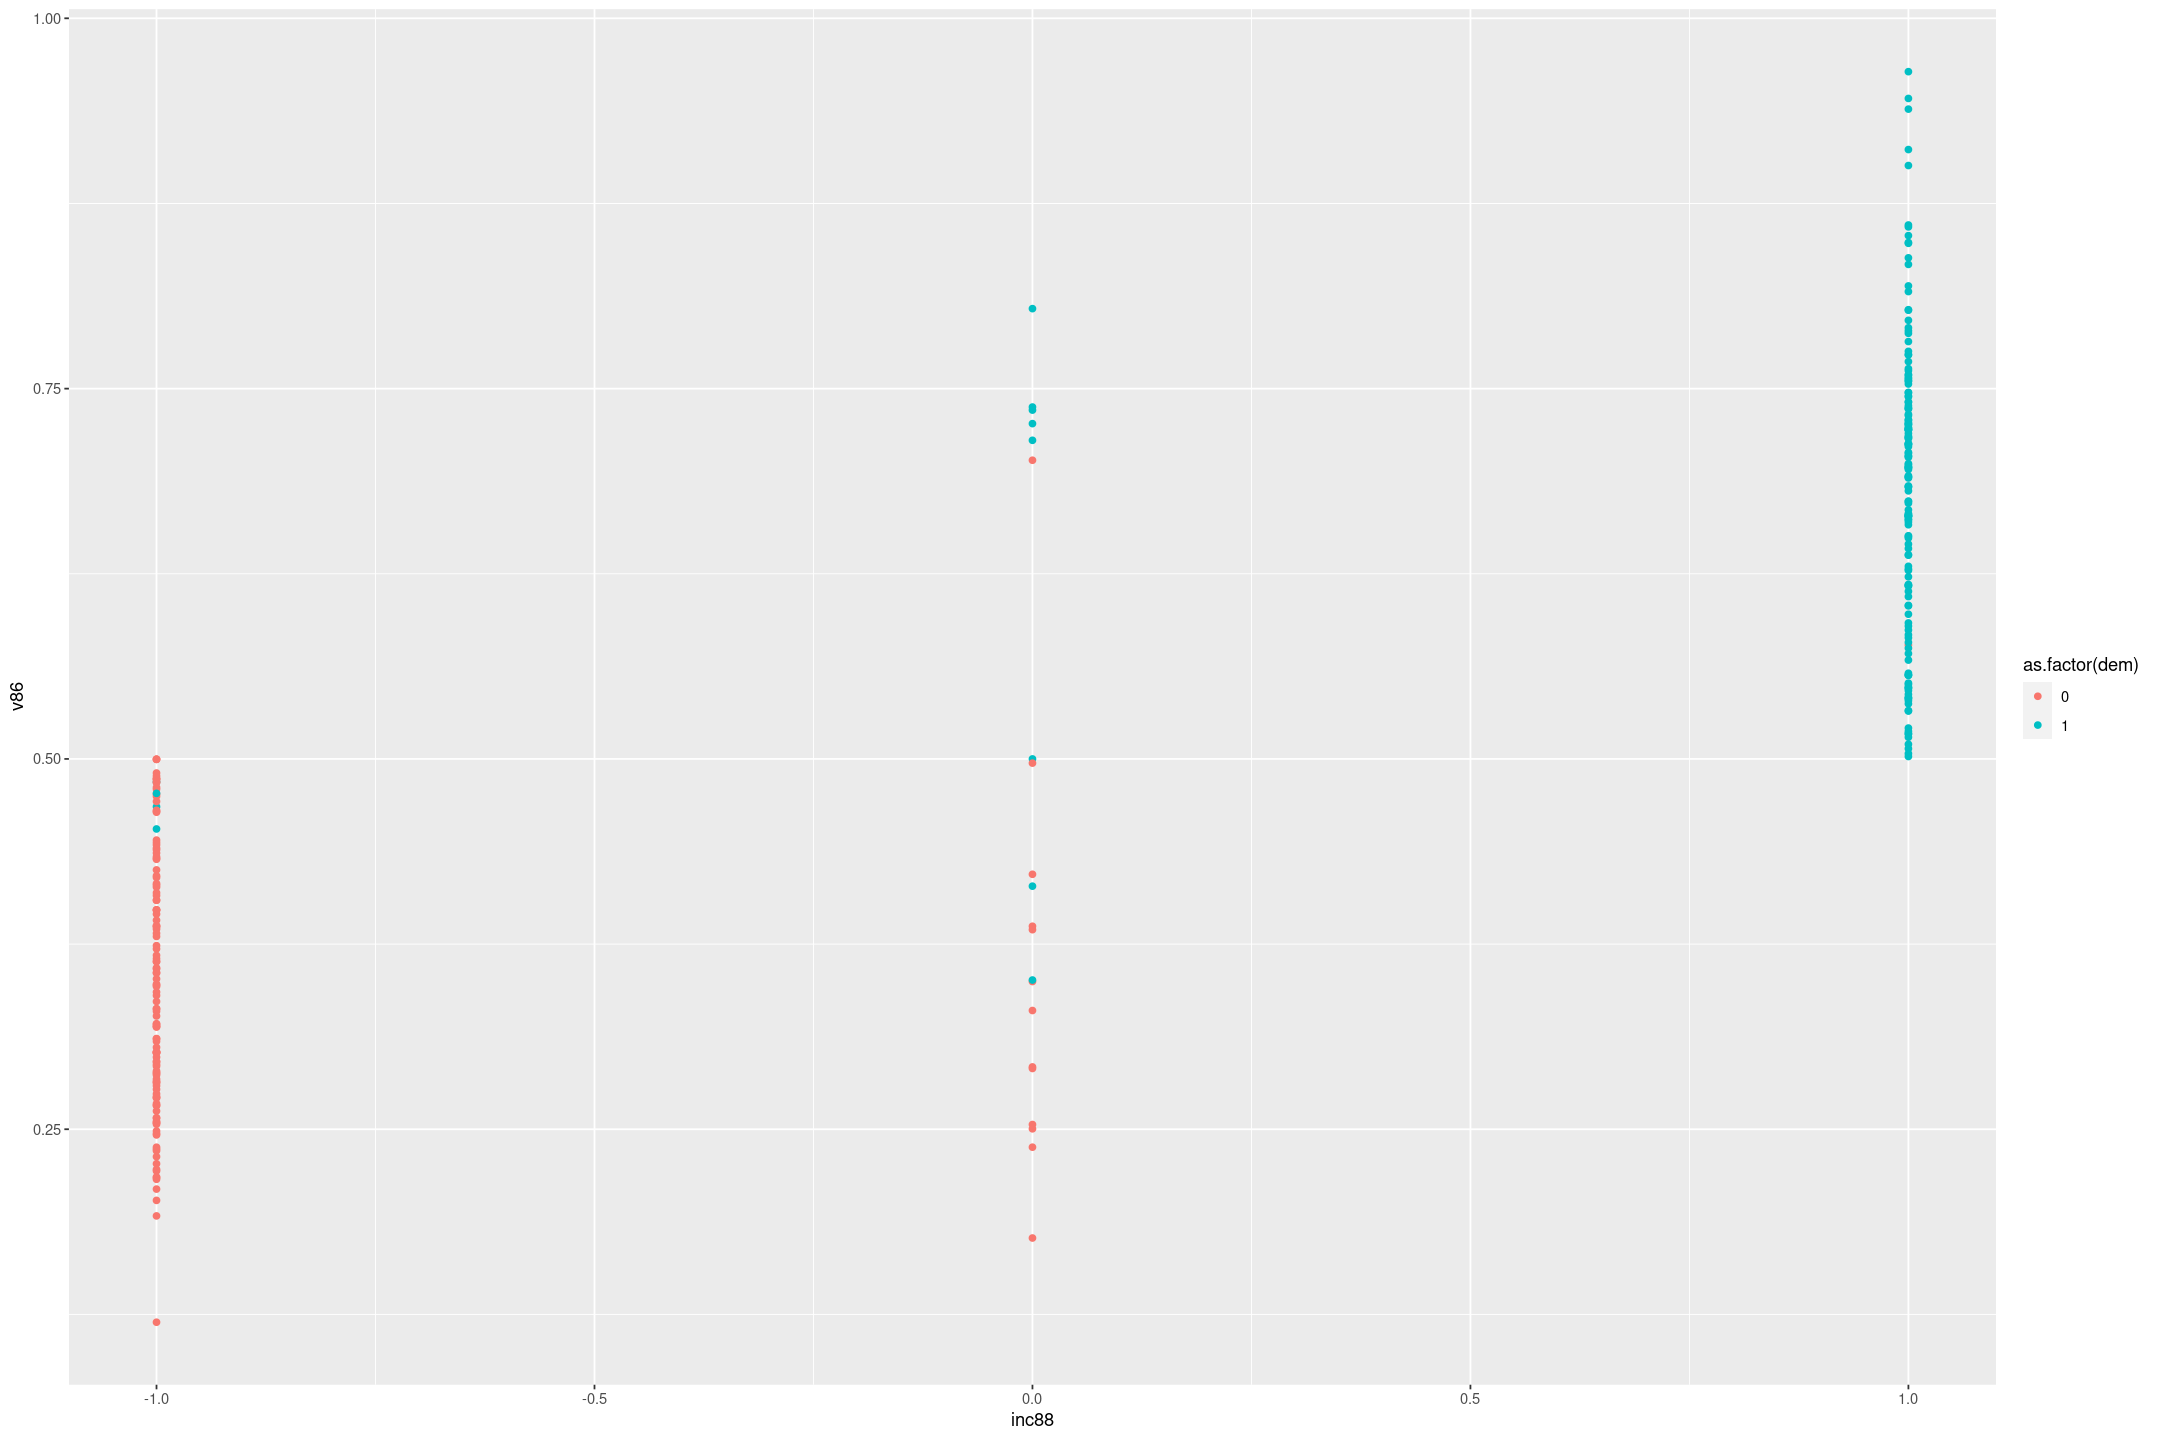

In [222]:
congress_binary %>%
gf_point(v86 ~ inc88, col=~as.factor(dem))

At a glance the model captures the data reasonably well.

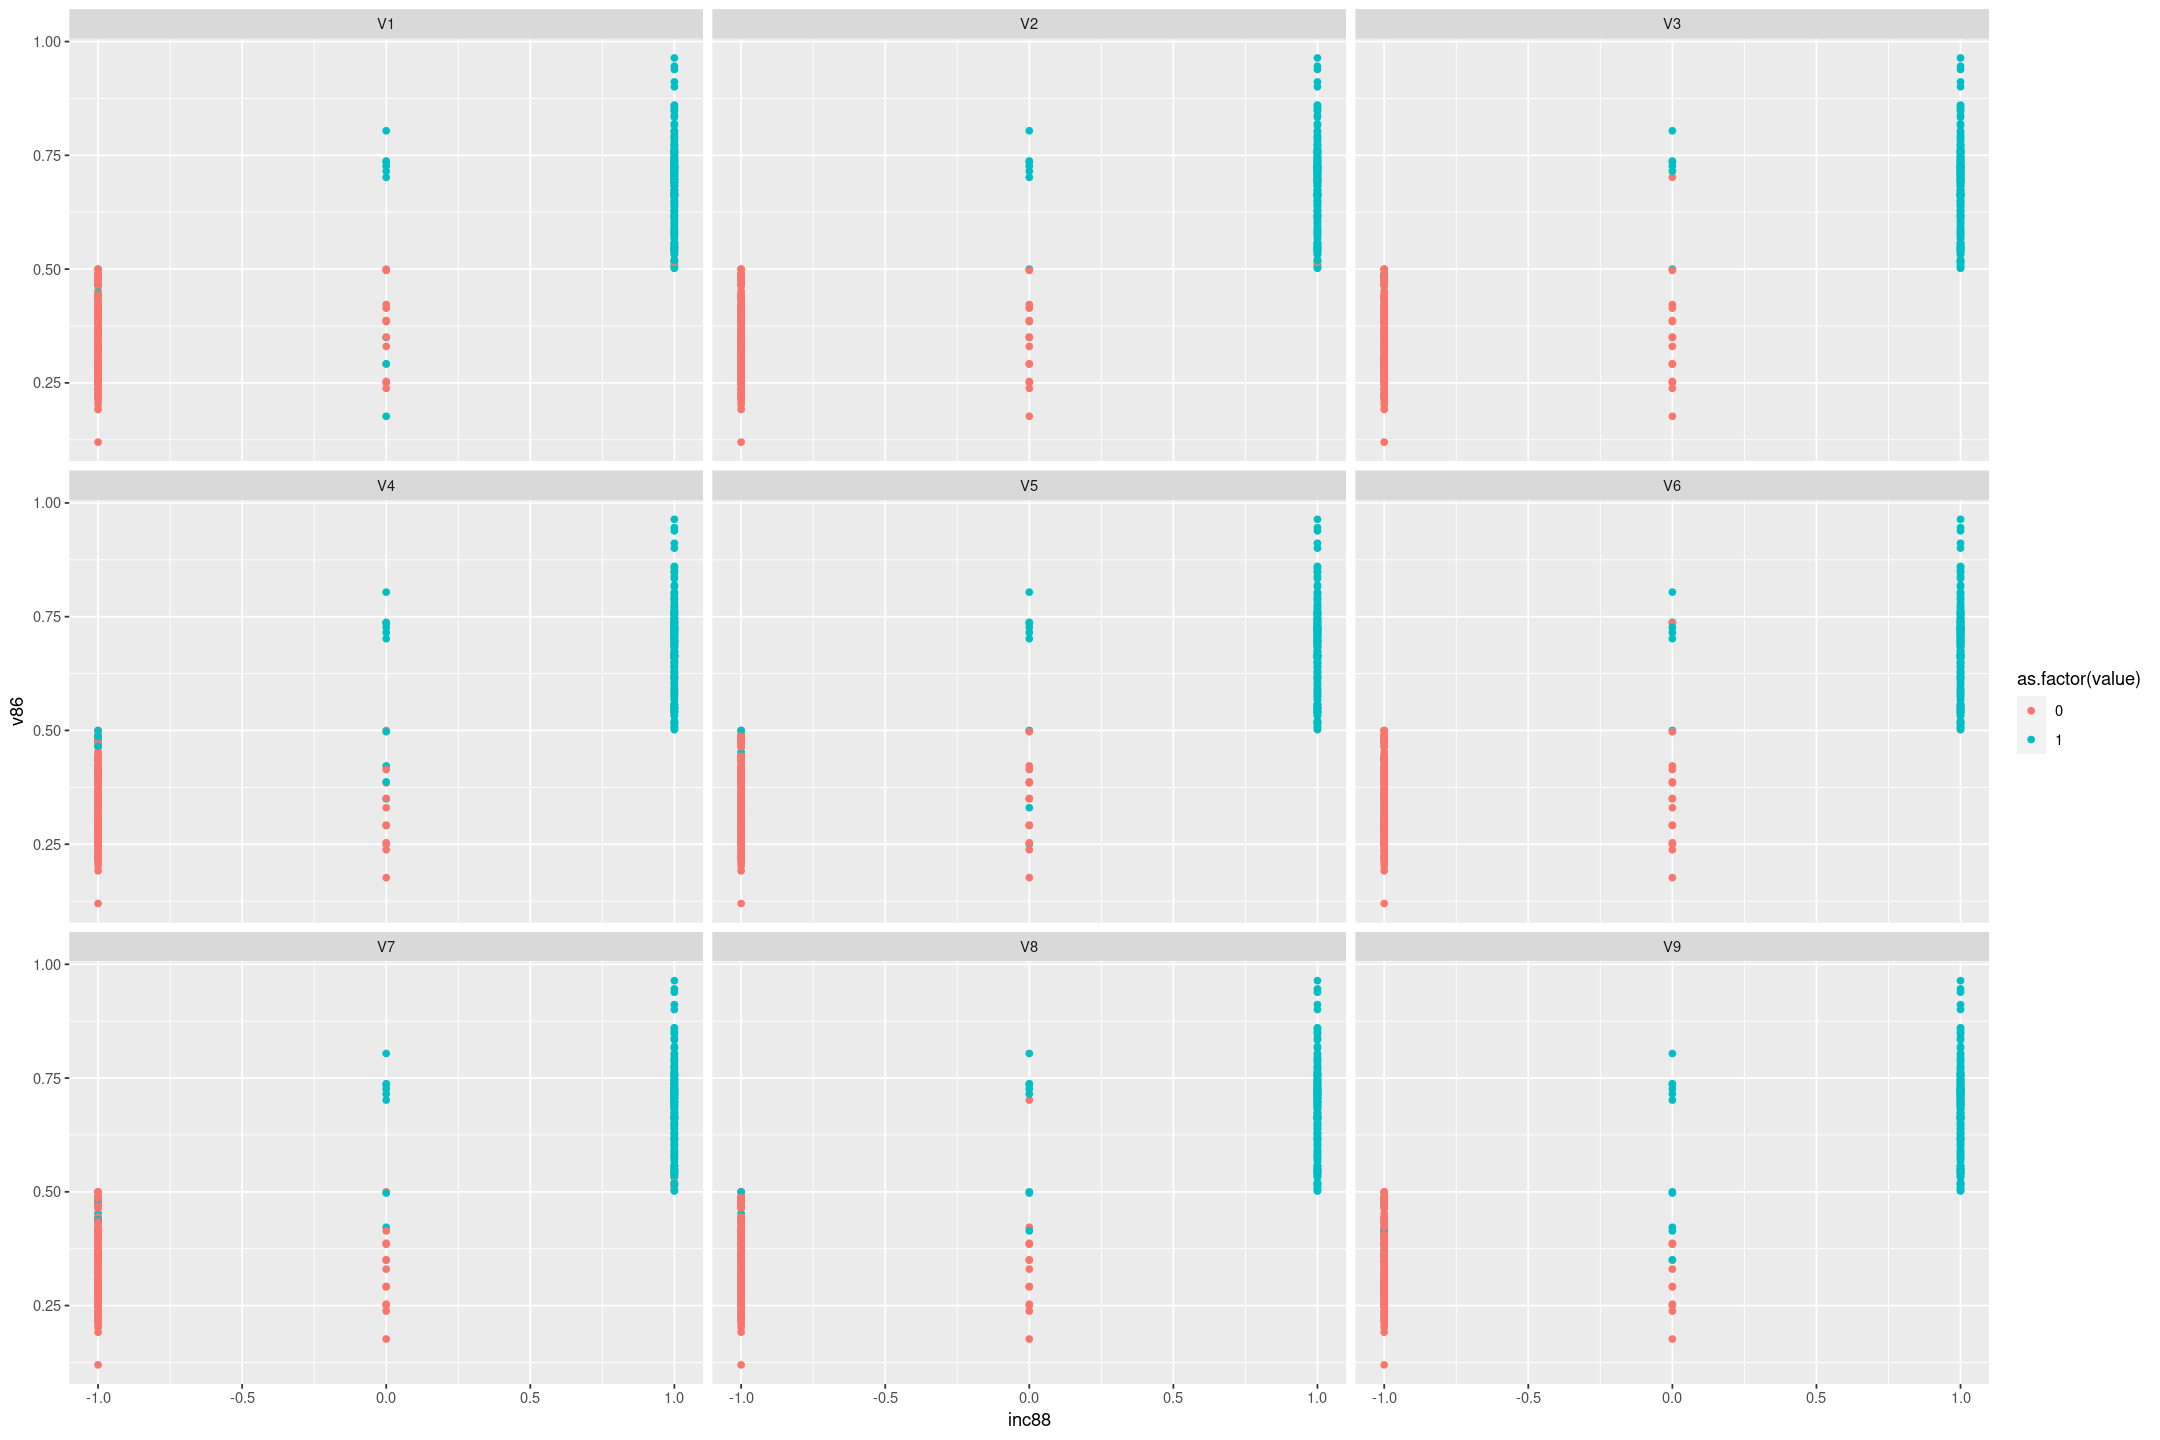

In [223]:
posterior_predict(fit_congress_binary, draws=9) %>%
t() %>%
as.data.frame() %>%
cbind(congress_binary) %>%
pivot_longer(-colnames(congress_binary)) %>%
gf_point(v86 ~ inc88 | name, col=~as.factor(value))

## Robit regression

Fit a robit regression and assess model fit.

I'm not *entirely* sure how this works but we can [copy an example using brms](https://discourse.mc-stan.org/t/robit-regression-not-robust/21245).

I'm going to ignore the sampling issue, assuming it's due to perhaps bad priors on the t.

https://mc-stan.org/docs/2_21/stan-users-guide/logistic-probit-regression-section.html

 `y[n] ~ bernoulli(Phi(alpha + beta * x[n]));`

In [224]:
fileConn<-file("robit_flat.stan")
writeLines("
// Robit model - robit_flat.stan
data {
  int<lower=0> N;              // Number of data points
  int<lower=0> K;              // Number of predictors
  matrix[N, K] X;              // Predictor matrix
  int<lower=0, upper=1> y[N];  // Observations 

  vector[K] prior_centre;
  vector[K] prior_scale;
  real prior_nu_alpha;
  real prior_nu_beta;
}

parameters {
  vector[K] beta;       // coefficients for predictors
  real nu;
}


model {
  nu ~ gamma(prior_nu_alpha, prior_nu_beta); // Give nu some sort of prior to prevent divergence
  beta ~ normal(prior_centre, prior_scale);

 for (n in 1:N)
  y[n] ~ bernoulli(student_t_cdf(X[n] * beta, nu, 0, 1));
}
", fileConn)
close(fileConn)

In [225]:
sd(congress_binary$v86)

[1] 0.1919551

In [226]:
sd(congress_binary$inc88)

[1] 0.9636829

In [227]:
mean(congress_binary$v86)

[1] 0.5254571

In [228]:
f = dem ~ v86 + inc88

X = model.matrix(f, data=congress_binary)
y = model.response(model.frame(f, data=congress_binary))

start_time <- Sys.time()
fit_congress_robit <- rstan::stan(file = "robit_flat.stan",
            data = list(X=X, y=y, K=ncol(X), N=nrow(X), 
                        # Set a wide, centred prior
                        # The intercept prior would be easier with centred v86
                        prior_centre= c(0, 0, 0), prior_scale=c(10, 2.5, 12.5),
                        prior_nu_alpha = 2, prior_nu_beta = 0.1
                        ))
Sys.time() - start_time

Warning message:
“There were 61 divergent transitions after warmup. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”


Time difference of 5.267304 mins

In [229]:
names(fit_congress_robit) <- c('(Intercept)', 'v86', 'inc88', 'nu', 'lp__')

Even though there were 62 digergent transitions the parameter space looks reasonable (and would likely be even better if we centred the intercept).

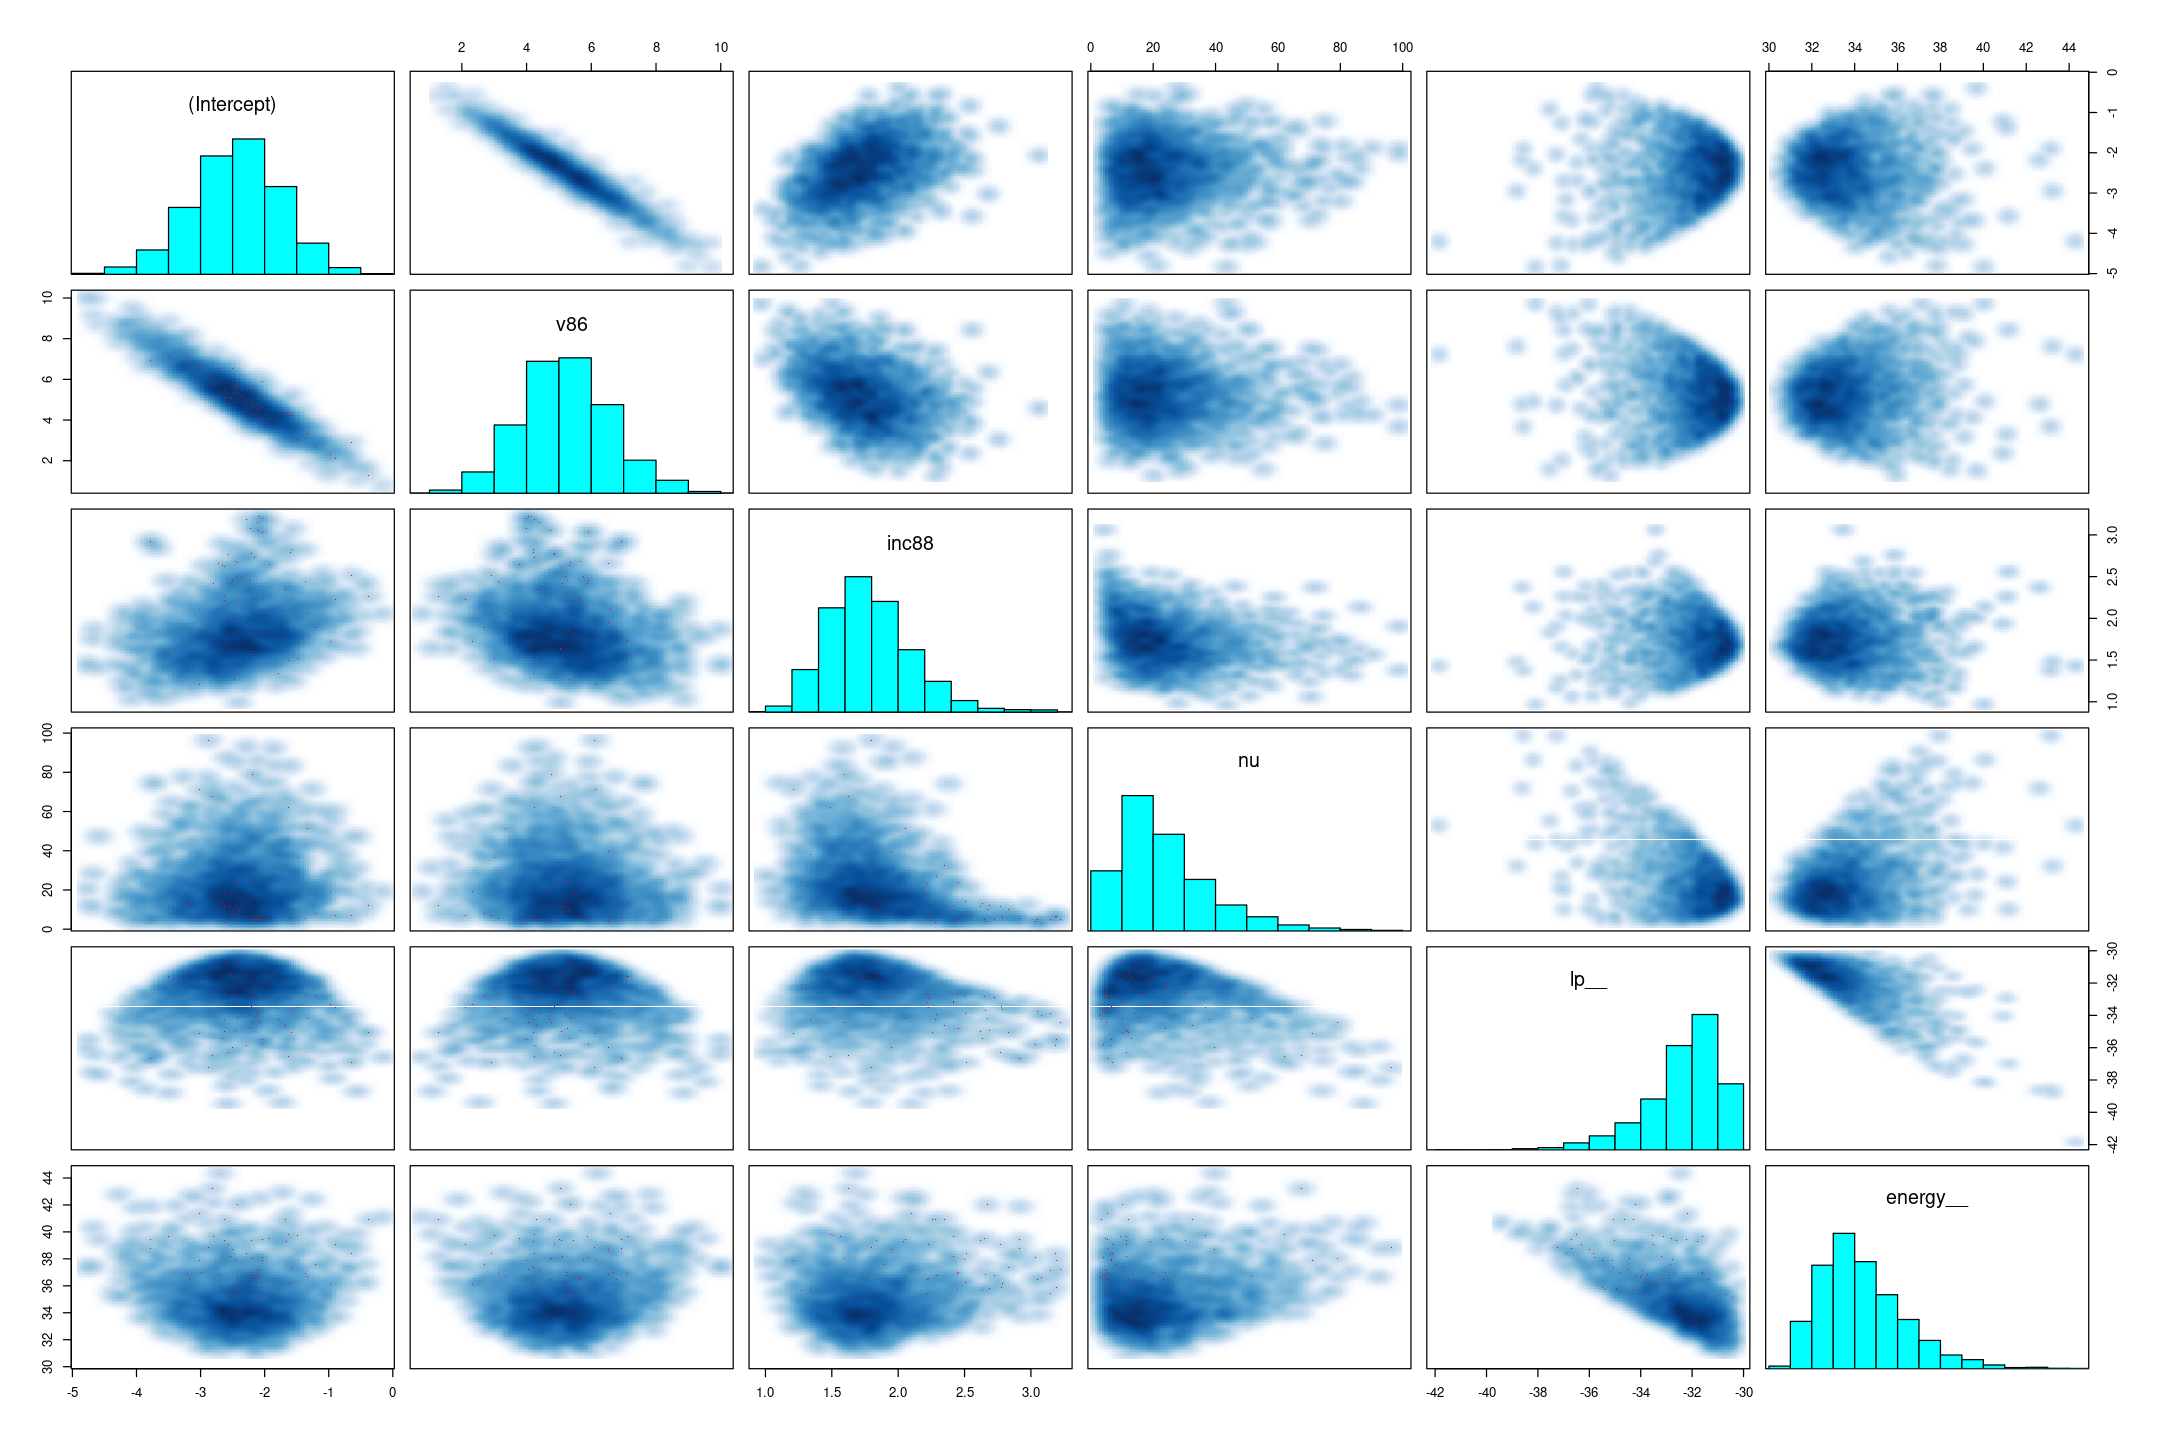

In [230]:
pairs(fit_congress_robit)

In [231]:
fit_congress_binary

stan_glm
 family:       binomial [logit]
 formula:      dem ~ v86 + inc88
 observations: 314
 predictors:   3
------
            Median MAD_SD
(Intercept) -6.4    1.8  
v86         13.7    3.8  
inc88        2.6    0.5  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

The probability at 50% v86 of a democrat win is a little more conservative than the logit model.

In [232]:
fit_congress_robit %>%
as.data.frame() %>%
summarise_all(median) %>%
mutate(prob_mid = scales::percent(invlogit(`(Intercept)` + 0.5 * v86)))

(Intercept) v86      inc88    nu       lp__      prob_mid
1 -2.42247    5.185925 1.754134 20.12666 -32.01431 54%

Similarly the coefficients are more conservative, leading to less certain probabilities (which seems reasonable).

In [233]:
fit_congress_robit

Inference for Stan model: robit_flat.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean    sd   2.5%    25%    50%    75%  97.5% n_eff Rhat
(Intercept)  -2.44    0.02  0.69  -3.88  -2.88  -2.42  -1.97  -1.12   958 1.00
v86           5.22    0.04  1.38   2.68   4.26   5.19   6.11   8.09   963 1.00
inc88         1.78    0.01  0.32   1.25   1.56   1.75   1.97   2.50   588 1.01
nu           23.65    0.51 14.71   5.26  13.10  20.13  30.51  61.02   835 1.00
lp__        -32.33    0.05  1.45 -36.02 -33.01 -32.01 -31.28 -30.48   857 1.00

Samples were drawn using NUTS(diag_e) at Sat Aug 28 15:41:32 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [234]:
congress_robit_coefs <- 
fit_congress_robit %>%
as.matrix() %>%
apply(2, median)
congress_robit_nu <- congress_robit_coefs['nu']
(congress_robit_coefs <- congress_robit_coefs[1:3])

(Intercept)         v86       inc88 
  -2.422470    5.185925    1.754134

In [235]:
congress_robit_nu

nu 
20.12666

In [236]:
pt(10, 1)

[1] 0.9682745

In [237]:
robit_preds <- pt((model.matrix(f, congress_binary) %*% congress_robit_coefs)[,1], congress_robit_nu)

The binned residuals look broadly similar to the logit model but are wider.

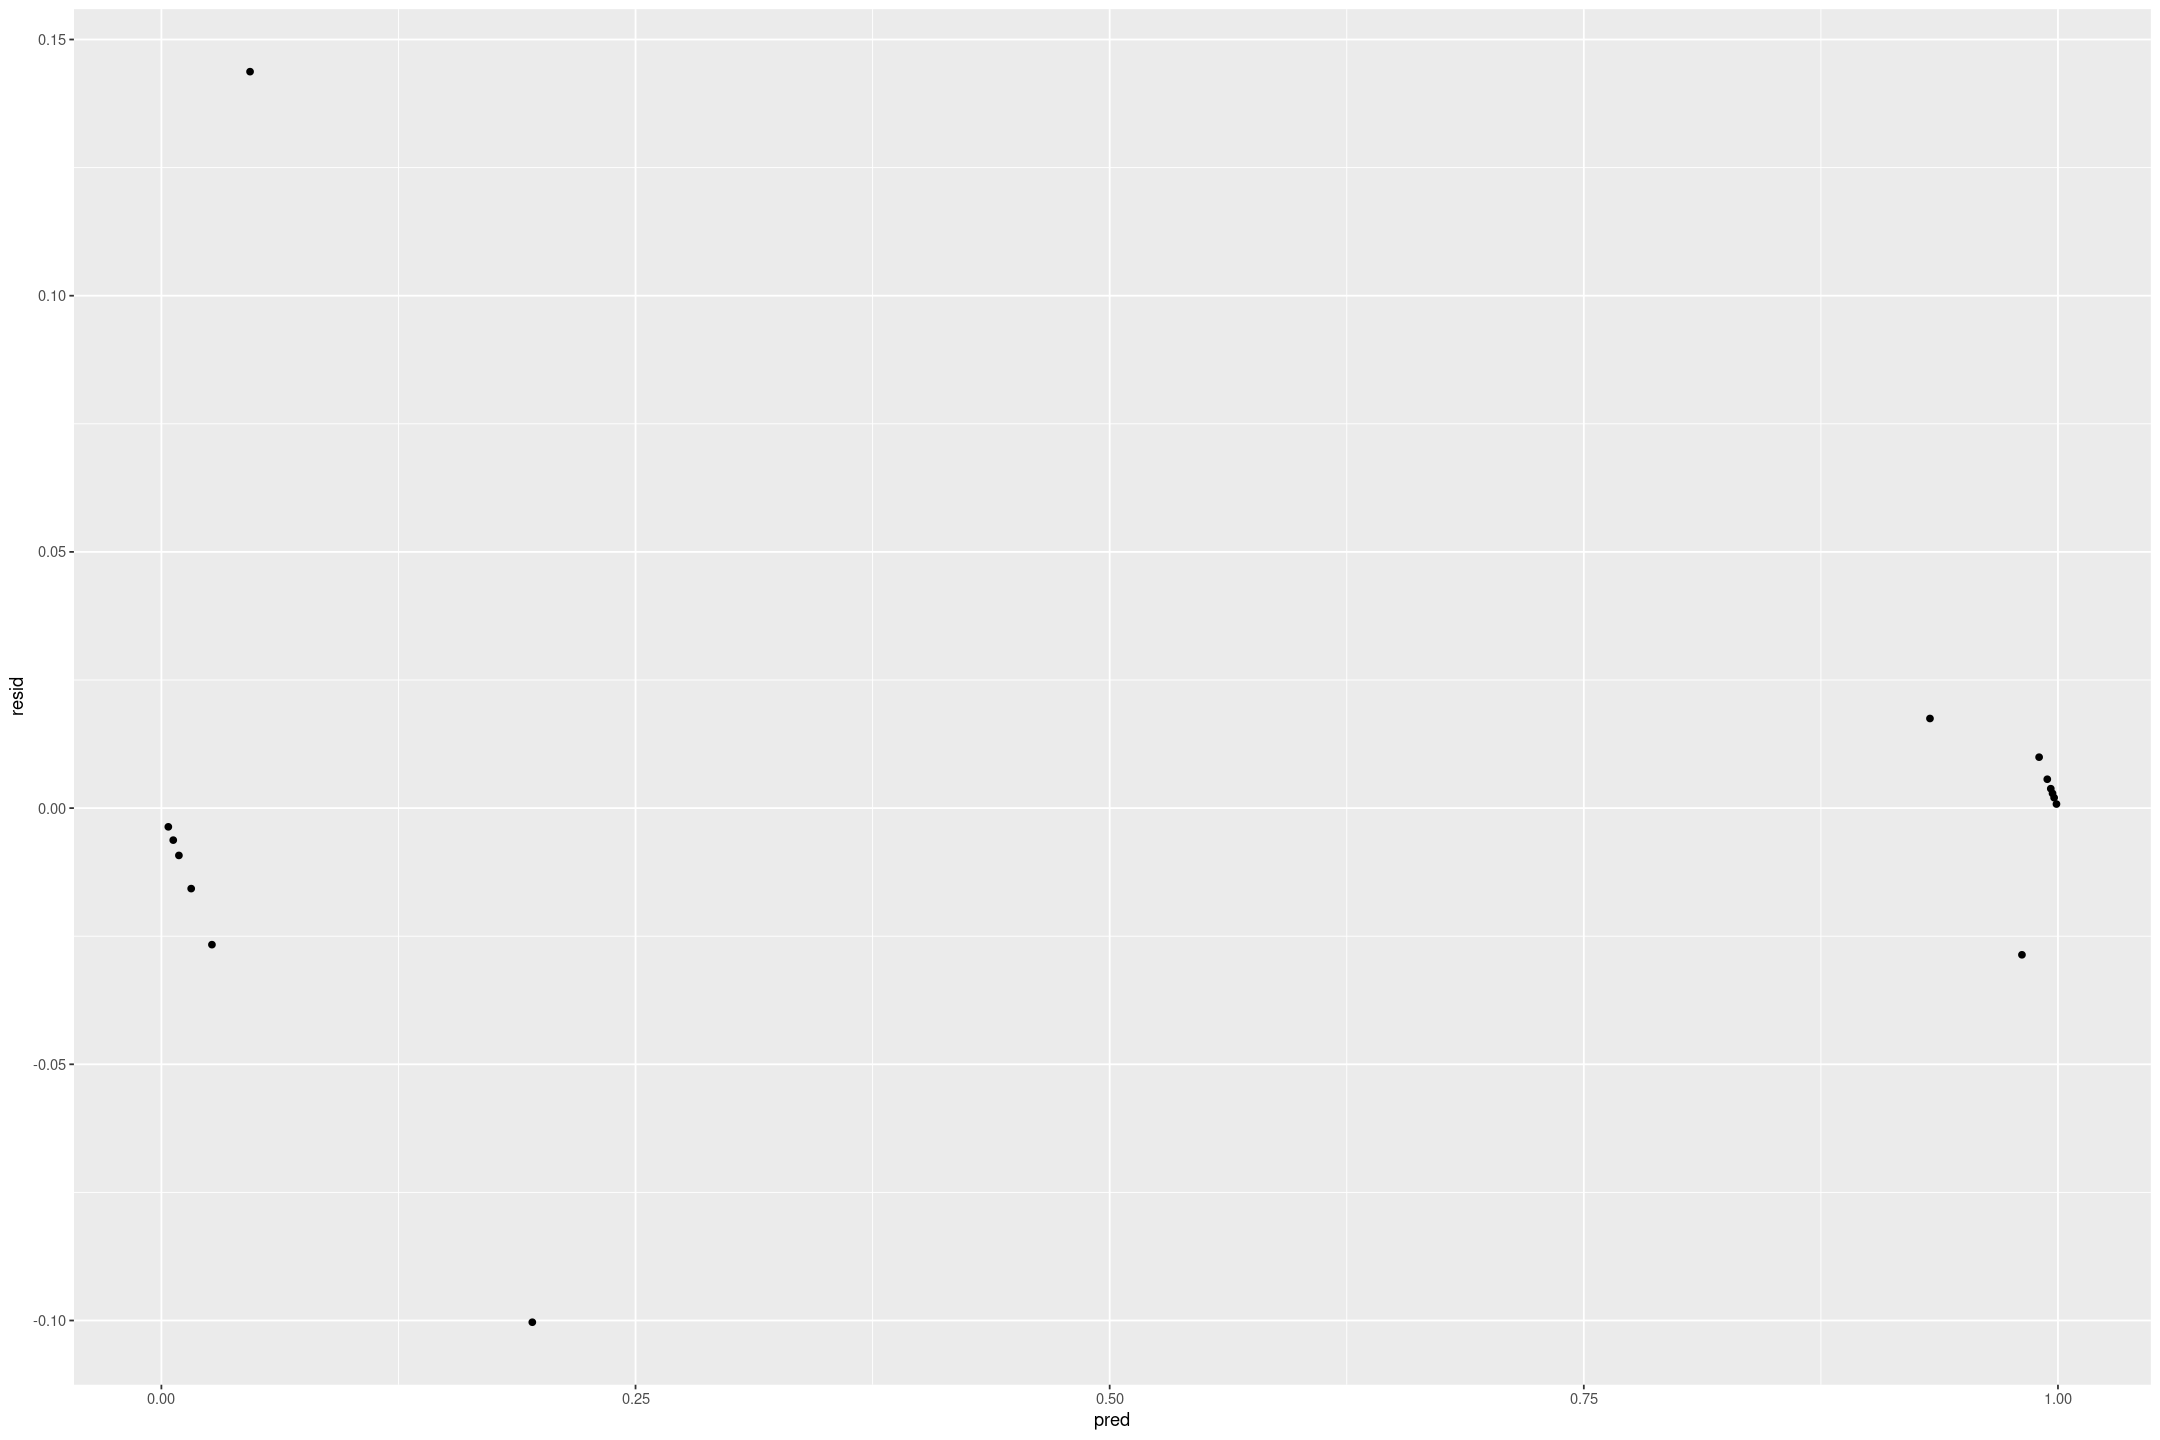

In [238]:
congress_binary %>%
mutate(pred = robit_preds) %>%
group_by(bin = cut_quantile(pred, 15)) %>%
summarise(prob = mean(dem),
          pred = mean(pred)) %>%
mutate(resid = prob - pred) %>%
gf_point(resid ~ pred)

In [239]:
posterior_robit_draws <-
fit_congress_robit %>%
as.data.frame() %>%
sample_n(9) %>%
as.matrix() %>%
t()

In [240]:
posterior_robit_coefs <- posterior_robit_draws[c("(Intercept)", "v86", "inc88"),]
posterior_robit_nu <- posterior_robit_draws["nu", ]

In [241]:
posterior_robit_probs <- pt((model.matrix(f, congress_binary) %*% posterior_robit_coefs), posterior_robit_nu)

Take random draws

In [242]:
rbinom_row <- function(row) {
    rbinom(length(row), 1, row)
}

In [243]:
posterior_robit_preds <- apply(posterior_robit_probs, 1, rbinom_row)

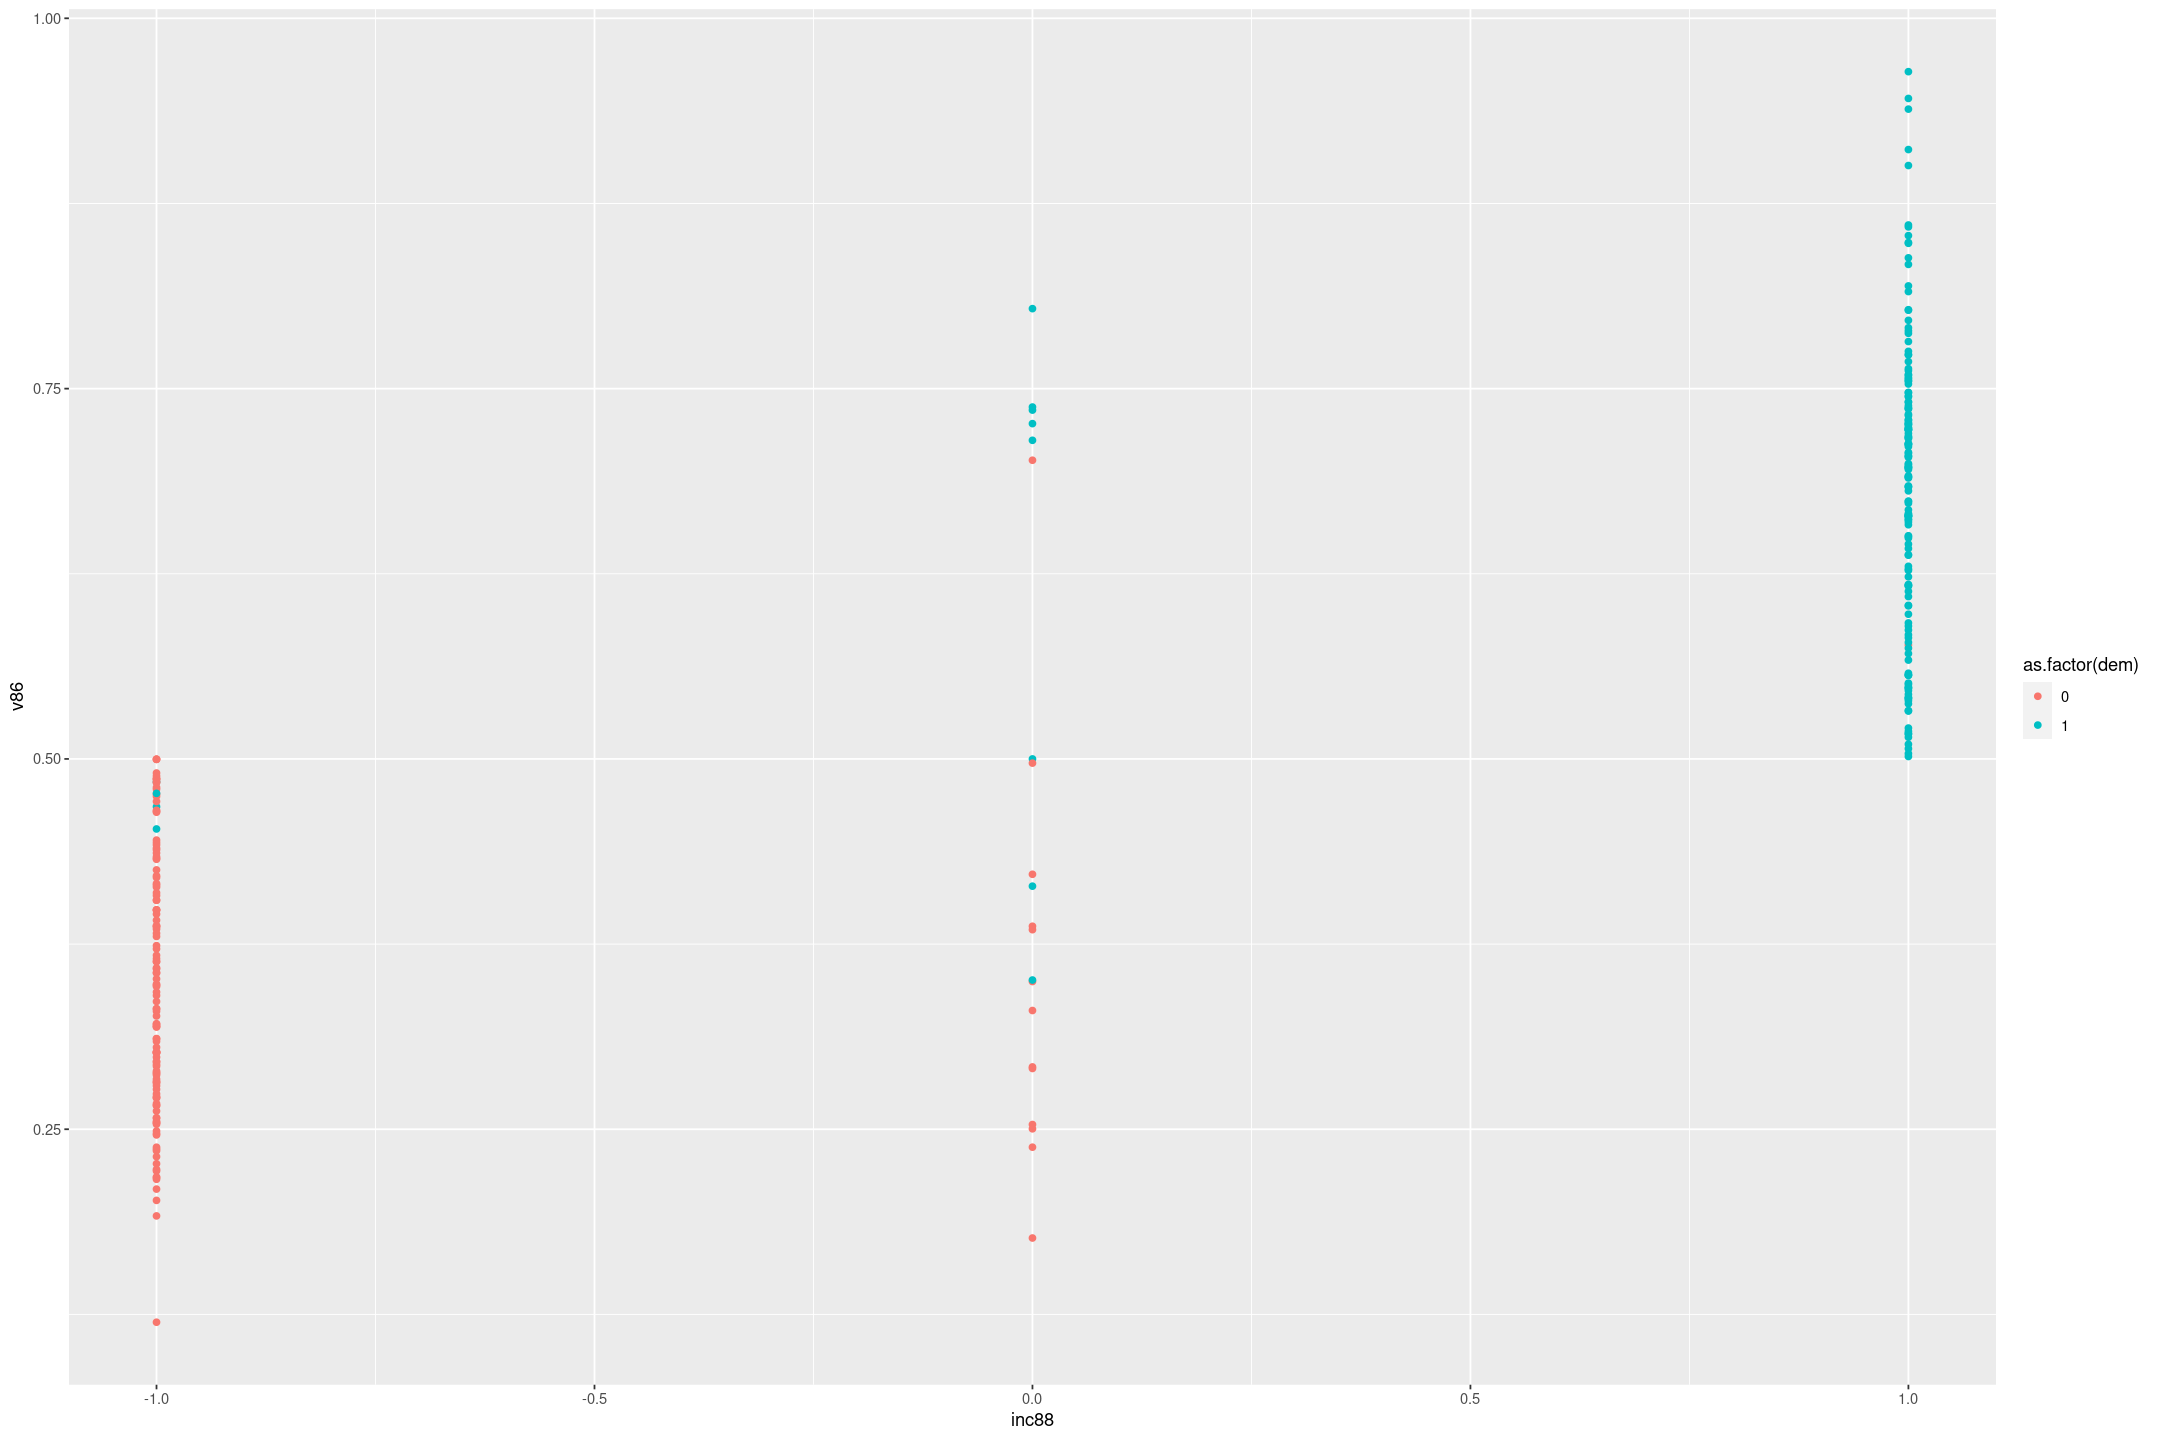

In [244]:
congress_binary %>%
gf_point(v86 ~ inc88, col=~as.factor(dem))

This looks similar to the logit to my eye - perhaps some statistical tests could differentiate them.

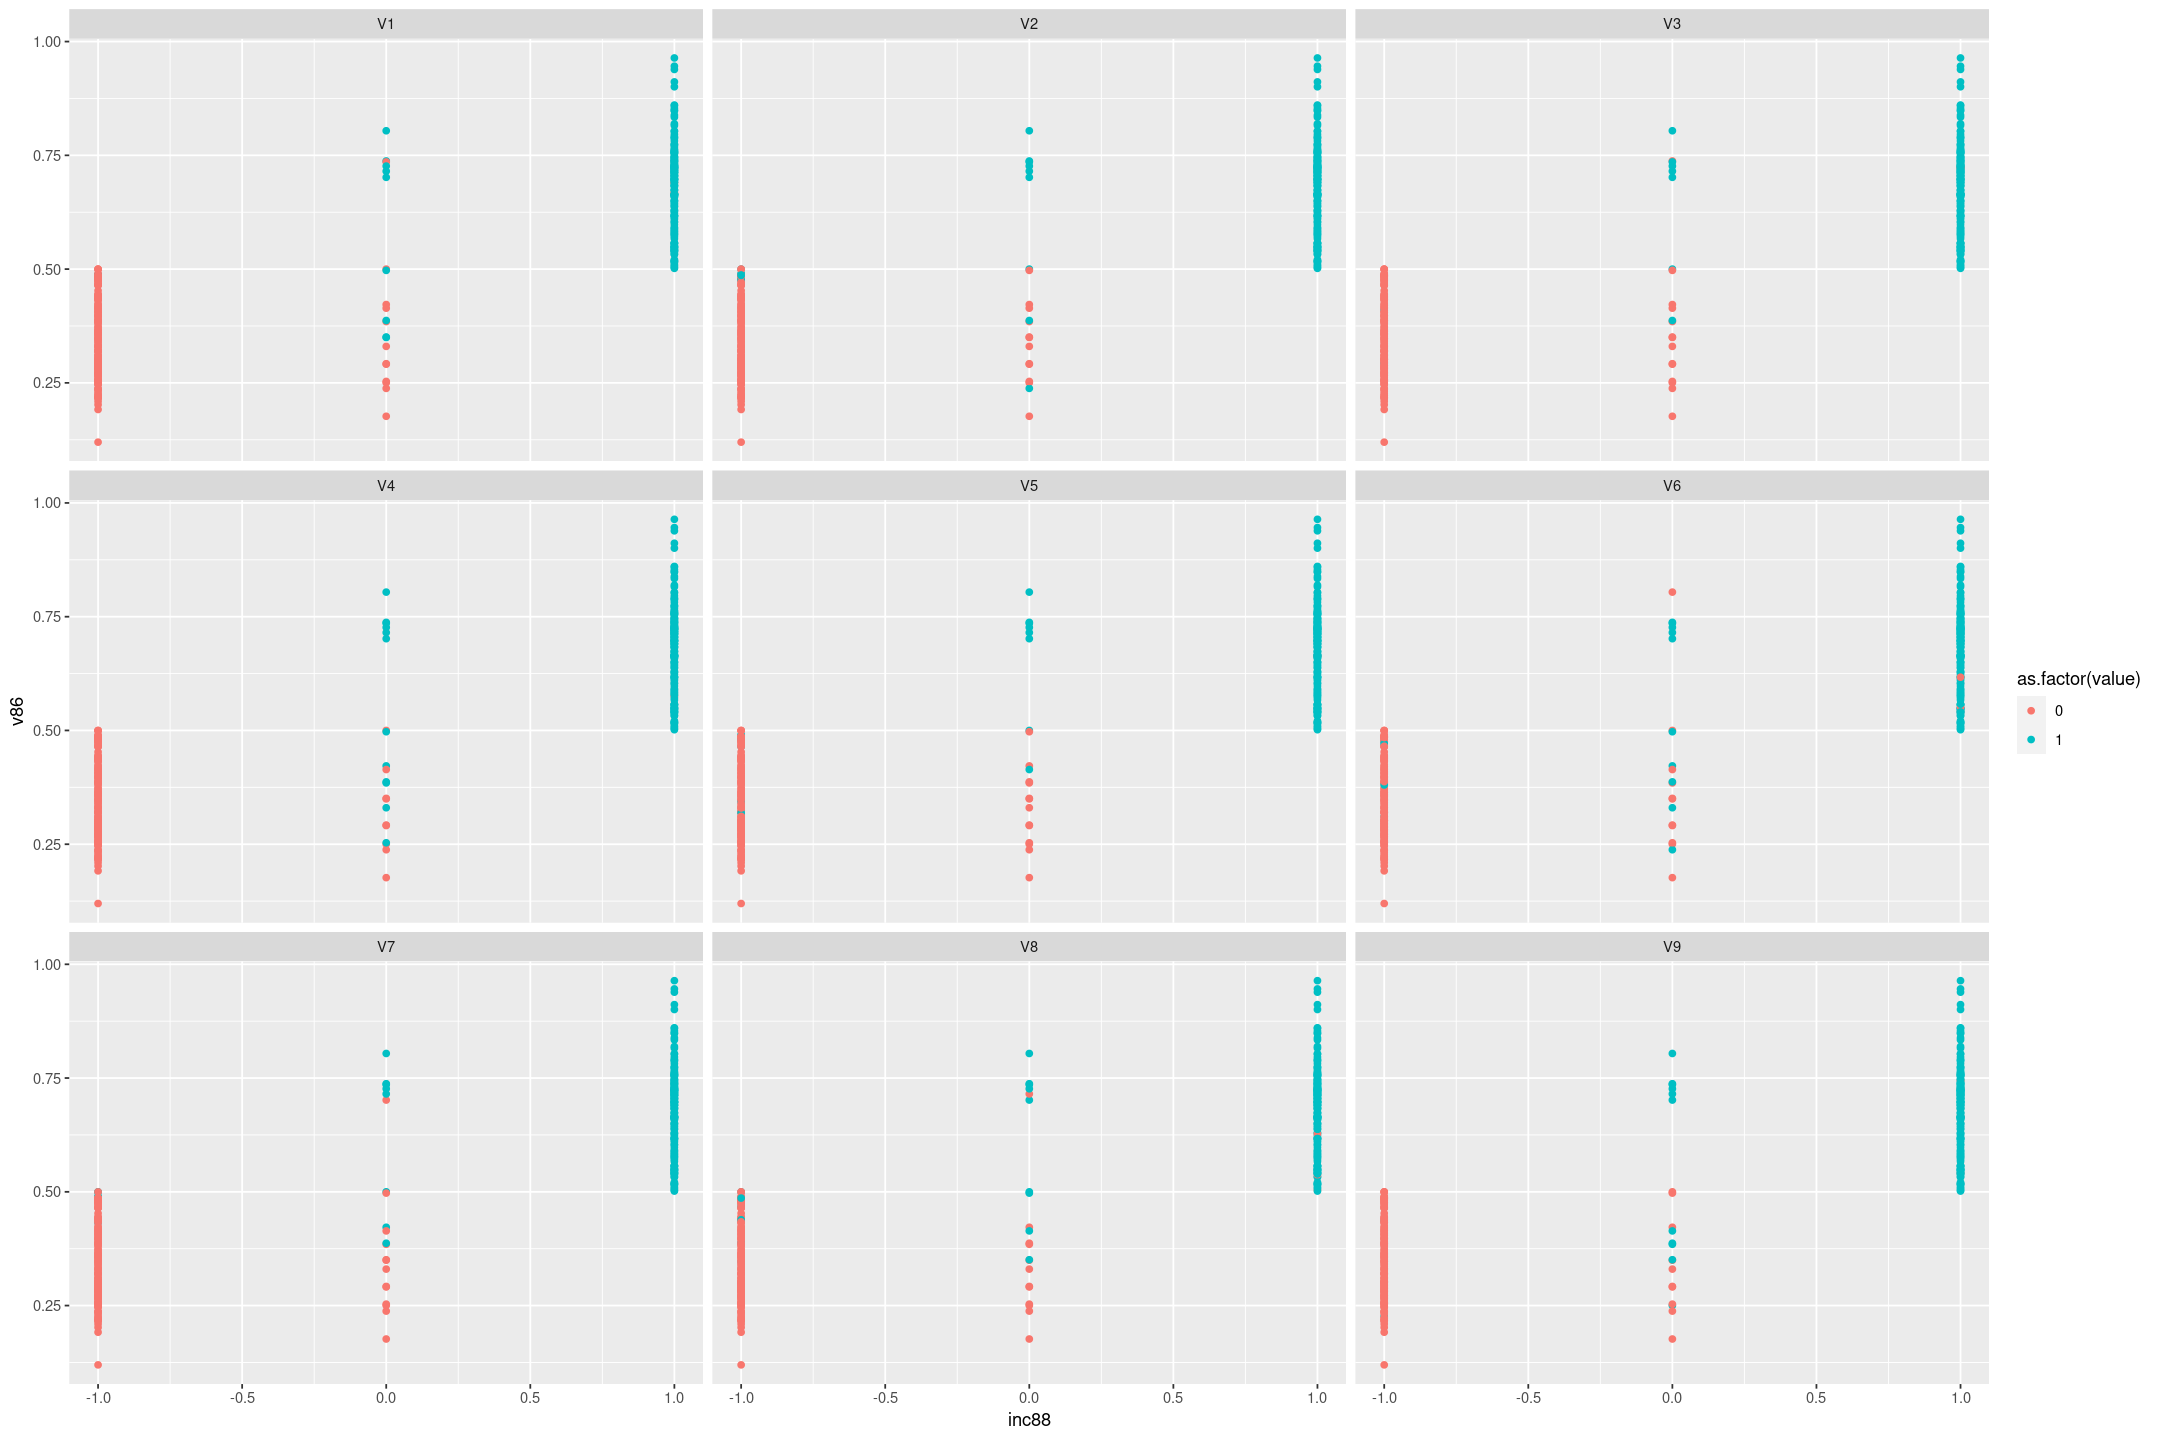

In [245]:
posterior_robit_preds %>% t() %>%
as.data.frame() %>%
cbind(congress_binary) %>%
pivot_longer(-colnames(congress_binary)) %>%
gf_point(v86 ~ inc88 | name, col=~as.factor(value))

## Comparing models

Which model do you prefer?

I prefer the logit model based on the residuals; but it seems that the robit model generalises better to the new data (being a bit more conservative in the probability esimates).

They have exactly the same accuracy though.

In [246]:
congress_binary_90 <- 
congress_raw %>% 
filter(v90 != 0, v90 != 1, v90 != 0.5, v88!=0, v88 !=1) %>%
transmute(dem = v90 > 0.5, v86=v88, inc88=inc90)

In [247]:
bce <- function(prob, actual) {
    mean(log(prob) * actual + log(1-prob) * (1-actual))
}

In [248]:
bce(predict(fit_congress_binary, newdata=congress_binary_90, type='response'), congress_binary_90$dem)

[1] -0.2345464

In [249]:
mean((predict(fit_congress_binary, newdata=congress_binary_90, type='response') > 0.5) == congress_binary_90$dem)

[1] 0.9333333

In [250]:
robit_90_preds <- invlogit((model.matrix(f, congress_binary_90) %*% congress_robit_coefs)[,1])

In [251]:
bce(robit_90_preds, congress_binary_90$dem)

[1] -0.2179512

In [252]:
mean((robit_90_preds > 0.5) == congress_binary_90$dem)

[1] 0.9333333

# Logistic regression and choice models

Using the individual-level survey data from the election example described in Section 10.9, fit a logistic regression model for the choice of supporting Democrats or Republicans.
Then interpret the output from this regression in terms of a utility/choice model.

Let's use a subset of our model from Chapter 13.

I'm going to interpret "supporting" to mean party identification.

Pulling in our earlier transformations.

In [253]:
nes92 <- 
nes %>%
filter(year == 1992) %>%
# Only people who actually voted republican or democrat
#filter(!is.na(presvote_2party)) %>%
transmute(#year is 1992,
          #resid: Respondent id - only useful for longitudinal, all distinct
          # weight1,..3: Demographic weights? Not useful
    age= age,
    gender=gender,
    race=race,
    # educ1, use educ3 instead
    urban=urban,
    region=region,
    income=income,
    # occup1 is VCF0115, replaced by occup2 VCF0151 which has more information (see codebook)
    union=union,
    religion=religion,
    education=educ3,
    marital_status = martial_status, # Note the Freudian slip
    occupation = occup2,
    # icpsr_cty - is NA
    #fips_cty,   - interesting, but need to join to external data sources to make useful
    # partyid7 - is just partyid3_b x str_partyid
    # partyid3 just separates out independent from unknown, few differences in 1992
    party = partyid3_b,
    partisan = str_partyid,
    father_party,
    mother_party,
    dlikes,
    rlikes,
    dem_therm,
    rep_therm,
    #regis - NA
    #rvote = presvote_2party == '2. republican',
    ideology = ideo7, # ideo is just a summary
    ## There are some more columns, but enough for now
) %>%
select(-father_party, -mother_party) %>%
filter_all(~!is.na(.))  %>%
mutate(income_int = as.integer(income) - 1,
       income_int_std = (income_int - mean(income_int))/(2*sd(income_int)),
       advanced_degree = education == '7. advanced degrees incl. llb',
       education_cts = (as.integer(education) - 5)/6,
       ideology_int = (as.numeric(ideology) - 5)/6,
       ideology3 = if_else(ideology_int < 0, "liberal", if_else(ideology_int > 0, "conservative", "moderate")))

In [254]:
nes92 %>% count(party)

party                                    n  
1 1. democrats (including leaners)         840
2 2. indpendents and apolitical (1966 only 118
3 3. republicans (including leaners)       608

In [255]:
nes92 %>% count(ideology, ideology_int)

ideology                        ideology_int n  
1 1. extremely liberal            -0.5000000    36
2 2. liberal                      -0.3333333   230
3 3. slightly liberal             -0.1666667   185
4 4. moderate, middle of the road  0.0000000   429
5 5. slightly conservative         0.1666667   256
6 6. conservative                  0.3333333   389
7 7. extremely conservative        0.5000000    41

Filter to those that have a political affiliation

In [256]:
nes92_party <- 
nes92 %>% 
filter(party != '2. indpendents and apolitical (1966 only') %>%
mutate(repub = as.integer(party == '3. republicans (including leaners)'))

nes92_party %>% count(repub, party)

repub party                              n  
1 0     1. democrats (including leaners)   840
2 1     3. republicans (including leaners) 608

In our model we say there's some benefit to having a political affiliation based on an individuals ideology (based on whether it aligns with the party).

The benefit of being a Republican at an individual level then will be `a + b * ideology` (taking ideology as a standardised variable).
Then someone will align republican if this is above some threshold level, c.

Then the probability of being a republican is given by:

`Pr(republican_i) = Pr(a_i + b_i * ideology_i > c_i) = Pr((a_i-c_i)/b_i > ideology_i) `

If we assume the coefficient `d_i = (a_i - c_i) / b_i` has a logistic distribution with centre `mu` and scale `sigma` then:

`Pr(republican) = invlogit((mu - ideology)/sigma) = invlogit(mu/sigma - ideology/sigma)`

In [257]:
fit_nes92_republican <- stan_glm(repub ~ ideology_int, family=binomial(link="logit"), data=nes92_party)

In [258]:
fit_nes92_republican

stan_glm
 family:       binomial [logit]
 formula:      repub ~ ideology_int
 observations: 1448
 predictors:   2
------
             Median MAD_SD
(Intercept)  -0.6    0.1  
ideology_int  4.3    0.3  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

So our model says that people tend to lean *slightly* Democratic (which aligns with the Democratic skew in the sample).

In [259]:
(ideo <- c(sigma = 1/coef(fit_nes92_republican)[['ideology_int']],
  mu = coef(fit_nes92_republican)[['(Intercept)']] / coef(fit_nes92_republican)[['ideology_int']]))

sigma         mu 
 0.2302801 -0.1402764

Check

In [260]:
c(ideo[['mu']]/ideo[['sigma']], 1/ideo[['sigma']])

[1] -0.6091559  4.3425384

Latent distribution for d

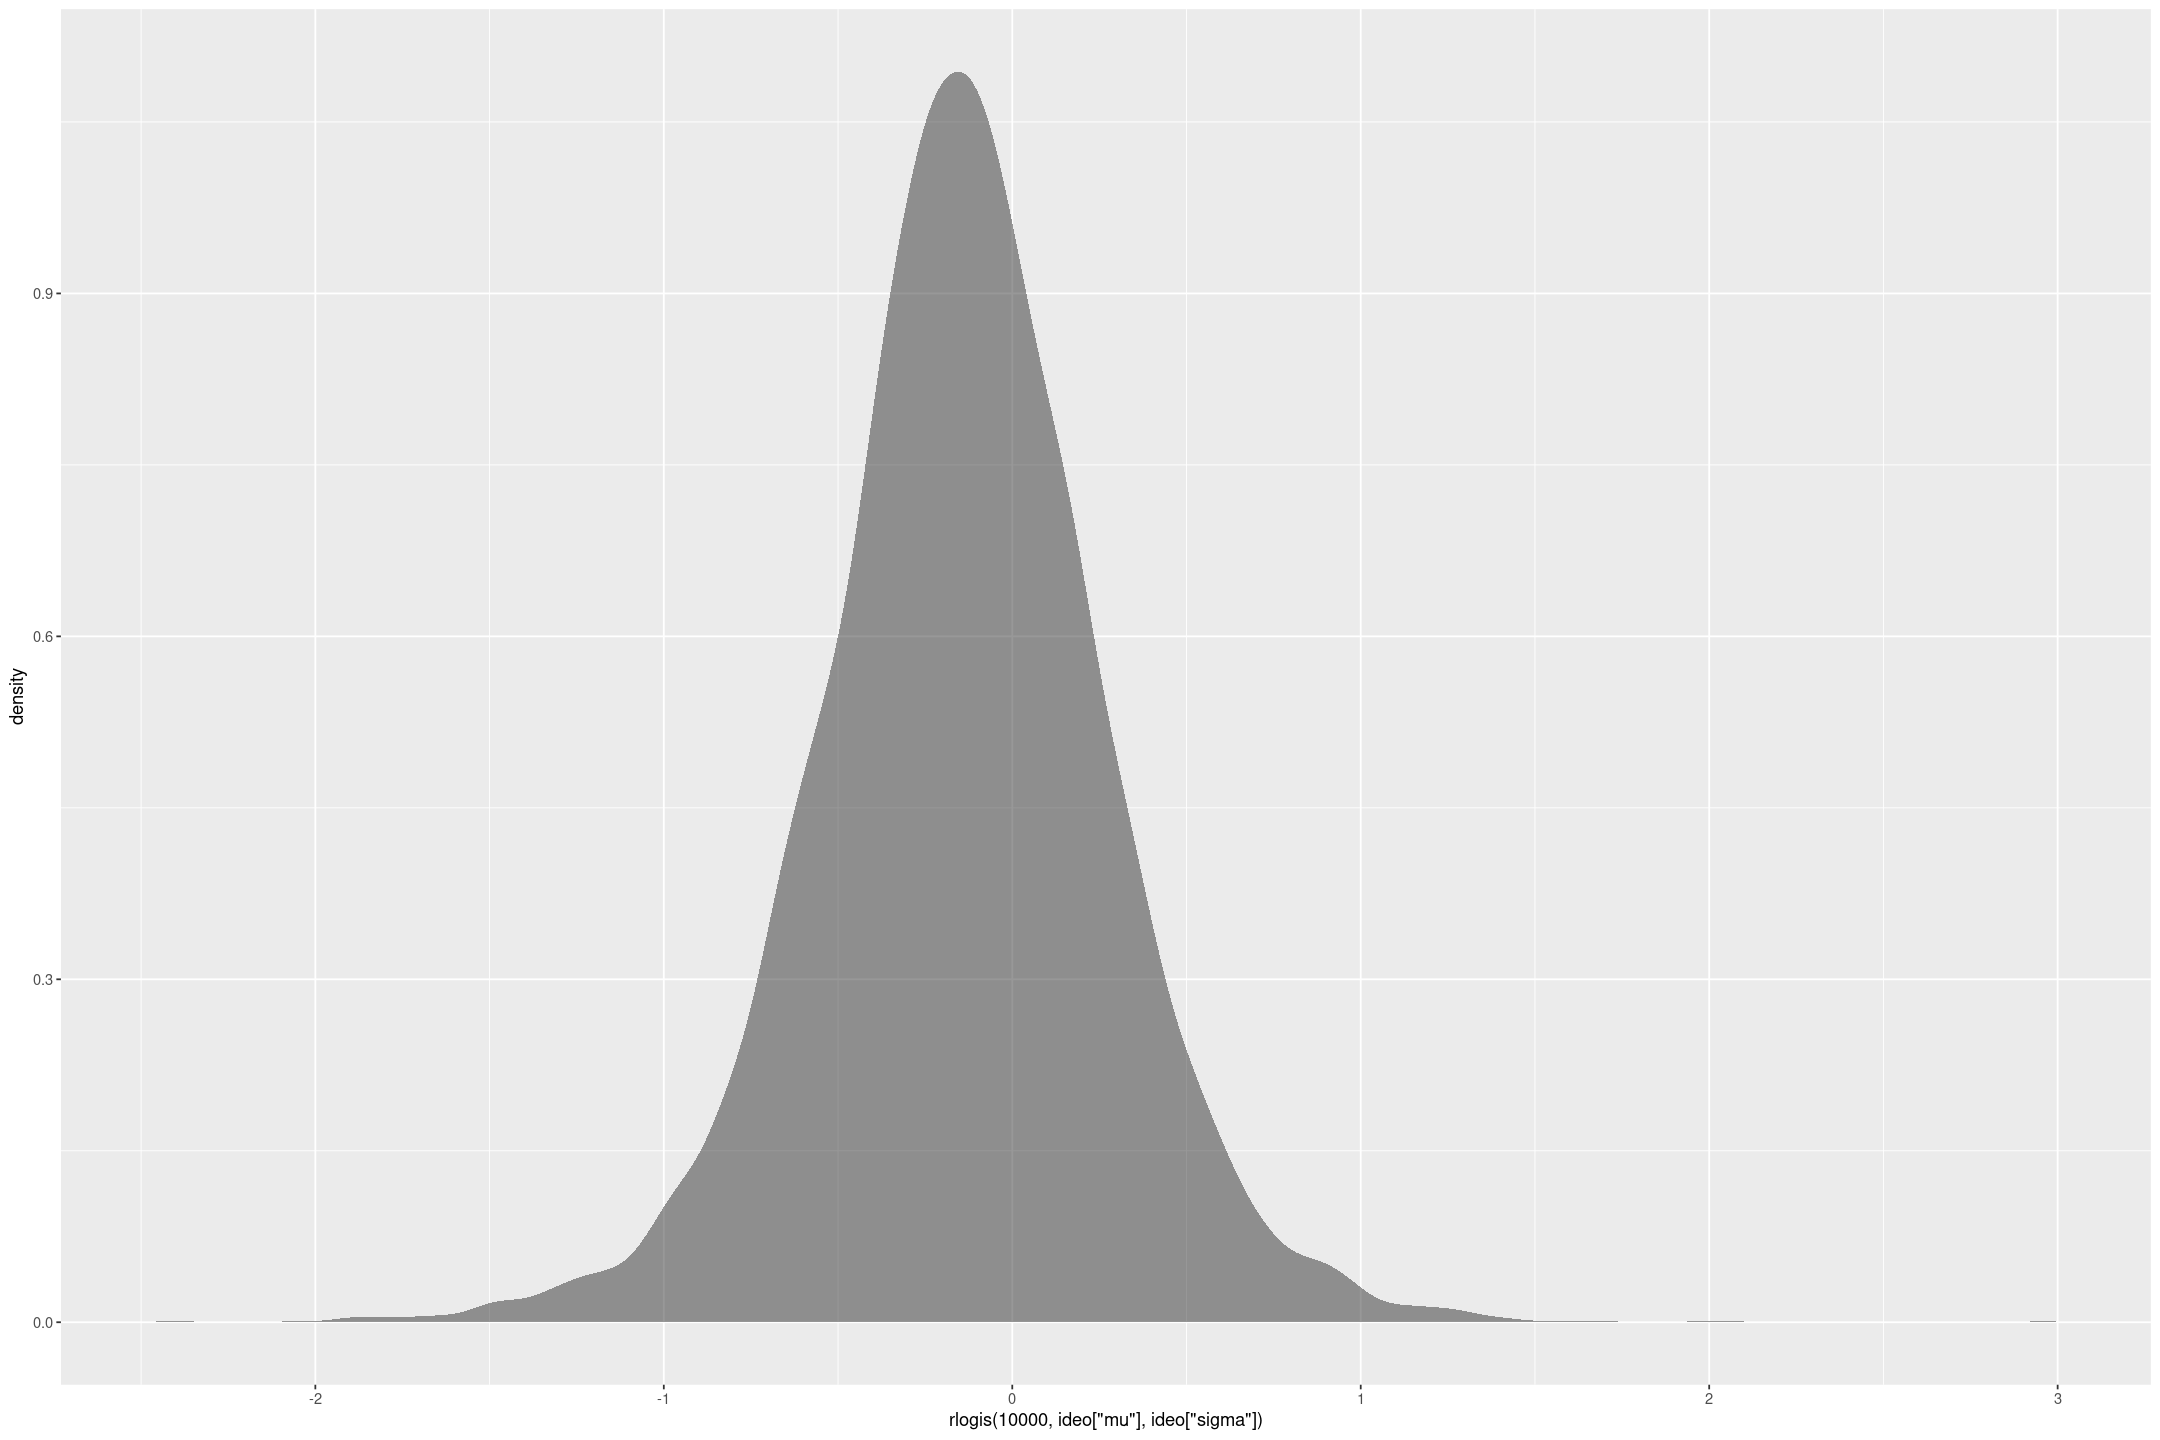

In [261]:
gf_density(~rlogis(10000, ideo['mu'], ideo['sigma']), bw="SJ")

# Multinomial logistic regression and choice models

Repeat the previous exercise but now with three options: Democrat, no opinion, Republican.
This is, fit an ordered logit model and then express is as a utility/choice model.

In this case we generalise the model so it has to be above some threshold to push association with Democrat/Republican.

If `a_i + b_i * ideology_i > rep_i` then they associate with the Republican party.
If `a_i + b_i * ideology_i < dem_i` then they associate with the Democrat party.
In the middle case `dem_i <= a_i + b_i * ideology_i <= rep_i` they are Independent.

In this case we can measure `r_i = (rep_i - a_i) / b_i` and `d_i = (dem_i - a_i) / b_i`.
Suppose `r_i` and `d_i` are logistically distributed with the same standard deviation, and necessarily we have `r_i >= d_i`.

In [262]:
fit_nes92_party <- stan_polr(ordered(party) ~ ideology_int, data=nes92, prior=R2(0.2, "mean"))

Again interestingly it asserts at neutral ideology the voters will tend to be democrat, which may indicate we need to adjust for other sample skews.

In [263]:
fit_nes92_party

stan_polr
 family:       ordered [logistic]
 formula:      ordered(party) ~ ideology_int
 observations: 1566
------
             Median MAD_SD
ideology_int 3.9    0.2   

Cutpoints:
                                                                            Median
1. democrats (including leaners)|2. indpendents and apolitical (1966 only   0.4   
2. indpendents and apolitical (1966 only|3. republicans (including leaners) 0.7   
                                                                            MAD_SD
1. democrats (including leaners)|2. indpendents and apolitical (1966 only   0.1   
2. indpendents and apolitical (1966 only|3. republicans (including leaners) 0.1   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

# Spatial voting models

Suppose that competiting political candidates A and B have positions that can be located spatially in a one-dimensional space (that is, on a line).
Suppose that voters have "ideal points" with regard to these positions that are normally distributed in this space, defined so that voters will prefer candidates whose positions are closest to their ideal points.
Further suppose that voters' ideal points can be modeled as a linear regression given inputs such as party identification, ideology, and demographics.

## Utility model

Write this model in terms of utilities.

Each voter's position `v_i` lies somewhere on the line, as do the points `A` and `B`.

Candidates prefer the candidate who lies closer; i.e. they prefer A if $(v_i - A)^2 < (v_i - B)^2 $.
Or, assuming without loss of generality that A lies on the left, if the point lies on the left of the midpoint:

$$ v_i < \frac{A+B}{2} $$

Now we are assuming that the voters are normally distributed with mean $\mu$ and standard deviation $\sigma$ on this line.
The

$$\begin{align}
P(B) &= P\left(v_i > \frac{A+B}{2}\right) \\
     &= P\left(\frac{v_i - \mu}{\sigma} > \frac{A+B - 2\mu}{2\sigma}\right)\\
     &= \Phi\left(\frac{2\mu - A+B}{2\sigma}\right)
\end{align}$$

So B would win when the probability is more than 50%, so the argument is non-negative, i.e. $ \mu > \frac{A + B}{2}$, that is when the voter centre is to the right of the midpoint.

Strategically this means you would want your position to be closer to centre than your opponents.

## Probit

Express the probability that a voter supports candidate S as a probit regression on the voter-level inputs.

Suppose each voter is represented by a vector of observable inputs $x_i$, and so $v_i \sim N(\alpha + \beta x_i, \sigma) $, where $\beta$ are the regression coefficients (assuming homoscedascity, among other linearity assumptions).
Then the argument is very similar to before:

$$\begin{align}
P(B) &= P\left(v_i > \frac{A+B}{2}\right) \\
     &= P\left(\frac{v_i - \alpha - \beta x_i}{\sigma} > \frac{\frac{A+B}{2} - \alpha -\beta x_i}{\sigma}\right) \\
     & = \Phi\left(\frac{\alpha - \frac{A+B}{2}}{\sigma}  + \frac{\beta x_i}{\sigma}\right)
\end{align}$$

So our intercept tells us how far the voter's ideal point at 0 of the observable predictors differs from the candidates' midpoint on the ideal curve (relative to the unexplained variance).
This is precisely a probit regression on the voter level inputs.

# Multinomial choice models

Pardoe and Simonton (2008) fit a discrete choice model to predict winners of the Academy Awards.
Their data are in the folder [`AcademyAwards`](https://github.com/avehtari/ROS-Examples/tree/master/AcademyAwards).

See [Pardoe's website](https://iainpardoe.com/oscars/) for more information and ongoing predictions with their model.

In [264]:
filename <- 'data/AcademyAwards/oscars.csv'

download_if_missing(filename, 'https://raw.githubusercontent.com/avehtari/ROS-Examples/master/AcademyAwards/oscars.csv')

oscars <- read.csv(filename)

In [265]:
oscars %>% head()

No Year Comp Name     PP DD MM FF Ch Movie    Nom Pic Dir Aml Afl Ams Afs Scr
1 1  2006 318  Babel    1  0  0  0  0  Babel    7   1   1   0   0   0   2   1  
2 2  2006 318  Departed 1  0  0  0  0  Departed 5   1   1   0   0   1   0   1  
3 3  2006 318  Letters  1  0  0  0  0  Letters  4   1   1   0   0   0   0   1  
4 4  2006 318  Sunshine 1  0  0  0  0  Sunshine 4   1   0   0   0   1   1   1  
5 5  2006 318  Queen    1  0  0  0  0  Queen    6   1   1   0   1   0   0   1  
6 6  2006 317  Inarritu 0  1  0  0  0  Babel    7   1   1   0   0   0   2   1  
  Cin Art Cos Sco Son Edi Sou For Anf Eff Mak Dan AD PrNl PrWl PrNs PrWs PrN
1 0   0   0   1   0   1   0   0   0   0   0   0   0  0    0    0    0    0  
2 0   0   0   0   0   1   0   0   0   0   0   0   0  0    0    0    0    0  
3 0   0   0   0   0   0   0   0   0   1   0   0   0  0    0    0    0    0  
4 0   0   0   0   0   0   0   0   0   0   0   0   0  0    0    0    0    0  
5 0   0   1   1   0   0   0   0   0   0   0   0   0  0    0    0    0    0  
6 0   0   0   1   0   1   0   0   0   0   0   0   0  0    0    0    0    0  
  PrW Gdr Gmc Gd Gm1 Gm2 Gf1 Gf2 PGA DGA SAM SAF PN PD DN DP DPrN DPrW MN MP
1 0   1   0   0  0   0   0   0   0   0   0   0   7  1  0  0  0    0    0  0 
2 0   0   0   0  0   0   0   0   0   0   0   0   5  1  0  0  0    0    0  0 
3 0   0   0   0  0   0   0   0   0   0   0   0   4  1  0  0  0    0    0  0 
4 0   0   0   0  0   0   0   0   1   0   0   0   4  0  0  0  0    0    0  0 
5 0   0   0   0  0   0   0   0   0   0   0   0   6  1  0  0  0    0    0  0 
6 0   1   0   0  0   0   0   0   0   0   0   0   0  0  7  1  0    0    0  0 
  MPrN MPrW FN FP FPrN FPrW
1 0    0    0  0  0    0   
2 0    0    0  0  0    0   
3 0    0    0  0  0    0   
4 0    0    0  0  0    0   
5 0    0    0  0  0    0   
6 0    0    0  0  0    0

[Description](https://github.com/avehtari/ROS-Examples/blob/master/AcademyAwards/oscars.txt)

* No - unique nominee identifier
* Year - movie release year (not ceremony year)
* Comp - identifier for year/category
* Name - short nominee name
* PP - best picture indicator
* DD - best director indicator
* MM - lead actor indicator
* FF - lead actress indicator
* Ch - 1 if win, 2 if lose
* Movie - short movie name
* Nom - total oscar nominations
* Pic - picture nom
* Dir - director nom
* Aml - actor male lead nom
* Afl - actor female lead nom
* Ams - actor male supporting nom
* Afs - actor female supporting nom
* Scr - screenplay nom
* Cin - cinematography nom
* Art - art direction nom
* Cos - costume nom
* Sco - score nom
* Son - song nom
* Edi - editing nom
* Sou - sound mixing nom
* For - foreign nom
* Anf - animated feature nom
* Eff - sound editing/visual effects nom
* Mak - makeup nom
* Dan - dance nom
* AD - assistant director nom
* PrNl - previous lead actor nominations
* PrWl - previous lead actor wins
* PrNs - previous supporting actor nominations
* PrWs - previous supporting actor wins
* PrN - total previous actor/director nominations
* PrW - total previous actor/director wins
* Gdr - golden globe drama win
* Gmc - golden globe musical/comedy win
* Gd - golden globe director win
* Gm1 - golden globe male lead actor drama win
* Gm2 - golden globe male lead actor musical/comedy win
* Gf1 - golden globe female lead actor drama win
* Gf2 - golden globe female lead actor musical/comedy win
* PGA - producer's guild of america win
* DGA - director's guild of america win
* SAM - screen actor's guild male win
* SAF - screen actor's guild female win
* PN - PP*Nom
* PD - PP*Dir
* DN - DD*Nom
* DP - DD*Pic
* DPrN - DD*PrN
* DPrW - DD*PrW
* MN - MM*Nom
* MP - MM*Pic
* MPrN - MM*PrNl
* MPrW - MM*PrWl
* FN - FF*Nom
* FP - FF*Pic
* FPrN - FF*PrNl
* FPrW - FF*PrWl

Note that there can be anything from 2-12 entries in a category

In [266]:
oscars %>% 
group_by(Comp) %>% 
summarise(entrants=n(), winners=sum(Ch == 1)) %>% 
count(entrants, winners) %>%
arrange(desc(entrants))

entrants winners n  
1  12       1         2
2  10       1         9
3   8       1         2
4   7       1         2
5   6       1         3
6   5       0         4
7   5       1       278
8   5       2         1
9   5       3         1
10  4       1         1
11  4       2         1
12  3       1        12
13  3       2         1
14  2       1         1

The 2006 data has no winners attached (which is the 4 0s)

Apparently there were 3 ties:

* [1968](https://www.oscars.org/oscars/ceremonies/1969) - Barbra Streissand and Kathrine Hepburn for best actress
* [1932](https://www.oscars.org/oscars/ceremonies/1933) - Wallace Beery and Fredric March for best actor
* [1928](https://www.oscars.org/oscars/ceremonies/1929) - Emil Jannings won best actor for two movie nominations, Janet Gaynor best actress for 3 movie nominations

The ties are of a different nature; the ties in 1932 and 1968 is due to an equal split - it should be split between them.
For 1928 it seems to be done on the actor/actress level and movie level features should be excluded or compounded in some way.

In [267]:
oscars %>%
group_by(Comp) %>% 
mutate(winners = sum(Ch==1)) %>%
filter(winners != 1)

No   Year Comp Name        PP DD MM FF Ch Movie     Nom Pic Dir Aml Afl Ams
1     1 2006 318  Babel       1  0  0  0  0  Babel     7   1   1   0   0   0  
2     2 2006 318  Departed    1  0  0  0  0  Departed  5   1   1   0   0   1  
3     3 2006 318  Letters     1  0  0  0  0  Letters   4   1   1   0   0   0  
4     4 2006 318  Sunshine    1  0  0  0  0  Sunshine  4   1   0   0   0   1  
5     5 2006 318  Queen       1  0  0  0  0  Queen     6   1   1   0   1   0  
6     6 2006 317  Inarritu    0  1  0  0  0  Babel     7   1   1   0   0   0  
7     7 2006 317  Scorsese    0  1  0  0  0  Departed  5   1   1   0   0   1  
8     8 2006 317  Eastwood    0  1  0  0  0  Letters   4   1   1   0   0   0  
9     9 2006 317  Frears      0  1  0  0  0  Queen     6   1   1   0   1   0  
10   10 2006 317  Greengrass  0  1  0  0  0  United93  2   0   1   0   0   0  
11   11 2006 316  DiCaprio    0  0  1  0  0  Diamond   5   0   0   1   0   1  
12   12 2006 316  Gosling     0  0  1  0  0  Nelson    1   0   0   1   0   0  
13   13 2006 316  Whitaker    0  0  1  0  0  Scotland  1   0   0   1   0   0  
14   14 2006 316  SmithW      0  0  1  0  0  Happyness 1   0   0   1   0   0  
15   15 2006 316  OToole      0  0  1  0  0  Venus     1   0   0   1   0   0  
16   16 2006 315  Streep      0  0  0  1  0  Prada     2   0   0   0   1   0  
17   17 2006 315  Winslet     0  0  0  1  0  Children  3   0   0   0   1   1  
18   18 2006 315  Dench       0  0  0  1  0  Scandal   4   0   0   0   1   0  
19   19 2006 315  Mirren      0  0  0  1  0  Queen     6   1   1   0   1   0  
20   20 2006 315  Cruz        0  0  0  1  0  Volver    1   0   0   0   1   0  
21  776 1968 163  HepburnK    0  0  0  1  1  Lion      7   1   1   1   1   0  
22  777 1968 163  Neal        0  0  0  1  2  Subject   2   0   0   0   1   1  
23  778 1968 163  RedgraveV   0  0  0  1  2  Isadora   1   0   0   0   1   0  
24  779 1968 163  Streisand   0  0  0  1  1  Funny     8   1   0   0   1   0  
25  780 1968 163  Woodward    0  0  0  1  2  Rachel    4   1   0   0   1   0  
26 1537 1932  20  Beery       0  0  1  0  1  Champ     4   1   1   1   0   0  
27 1538 1932  20  Lunt        0  0  1  0  2  Guardsman 2   0   0   1   1   0  
28 1539 1932  20  March       0  0  1  0  1  Jekyll    3   0   0   1   0   0  
29 1623 1928   2  Barthelmess 0  0  1  0  2  Noose     1   0   0   1   0   0  
30 1624 1928   2  Barthelmess 0  0  1  0  2  Patent    1   0   0   1   0   0  
31 1625 1928   2  Jannings    0  0  1  0  1  Command   2   0   0   1   0   0  
32 1626 1928   2  Jannings    0  0  1  0  1  Way       1   0   0   1   0   0  
33 1627 1928   1  Dresser     0  0  0  1  2  Ship      1   0   0   0   1   0  
34 1628 1928   1  Gaynor      0  0  0  1  1  Heaven    5   1   1   0   1   0  
35 1629 1928   1  Gaynor      0  0  0  1  1  Street    3   0   0   0   1   0  
36 1630 1928   1  Gaynor      0  0  0  1  1  Sunrise   4   1   0   0   1   0  
37 1631 1928   1  Swanson     0  0  0  1  2  Sadie     2   0   0   0   1   0  
   Afs Scr Cin Art Cos Sco Son Edi Sou For Anf Eff Mak Dan AD PrNl PrWl PrNs
1  2   1   0   0   0   1   0   1   0   0   0   0   0   0   0   0   0    0   
2  0   1   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0    0   
3  0   1   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0    0   
4  1   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0    0   
5  0   1   0   0   1   1   0   0   0   0   0   0   0   0   0   0   0    0   
6  2   1   0   0   0   1   0   1   0   0   0   0   0   0   0   0   0    0   
7  0   1   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0    0   
8  0   1   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0    0   
9  0   1   0   0   1   1   0   0   0   0   0   0   0   0   0   0   0    0   
10 0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0    0   
11 0   0   0   0   0   0   0   1   1   0   0   1   0   0   0   1   0    1   
12 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0    0   


## Fit a model

Fit your own model to these data.

### Multinomial Choice Model

Given probabilities $\vec \theta = (\theta_1, \ldots, \theta_n)$, then
$$ \mathbb{P}\left(y = k \,\middle\vert\, \vec \theta\right) = \theta_k $$

The log probabilities are then in the general case:

$$ -\ln\mathbb{P}\left(y \,\middle\vert\, \vec\theta, N\right) = - \sum_{i=1}^{n} y_i \ln\theta_i - \ln\binom{N}{\vec\theta} $$

where the last term, independent of $\theta$ is just a normalisation constant.

Note that the log probabilities have to be in the range $[-\infty, 0]$.

Suppose we has some model of the log probabilities:

$$ \ln\mathbb{P}(y = k) = \alpha_k $$

Then the normalisation constraint becomes:

$$ \sum_{i=1}^{n} \exp(\alpha_k) = 1 $$.

If we have arbitrary numbers we can shift them by a constant, $\ln Z$, so that this is true:

$$ \ln\mathbb{P}(y = k) = \beta_k - \ln Z $$

$$ Z = \frac{1}{\sum_{i=1}^{N} \exp(\beta_k)} $$

$$ \mathbb{P}(y = k) = \frac{\exp(\beta_k)}{\sum_{i=1}^{N} \exp(\beta_k)} $$

This last function is called the *softmax*.
Notice that for any real $\beta_k$ this produces a set of probabilities that add to 1 (and the $\beta_k$ are only invariant up to a constant).


For this particular categorical model the categories are *indistinguishable*, indeed there are different numbers of categories for different rows.
So the only reasonable linear model is:

$$ \ln\mathbb{P}(y = k) = \beta X_k - \ln \left(\sum_{i=1}^{n} \beta X_i\right) $$

Note that the *log odds*:

$$ \ln\left(\frac{\mathbb{P}(y = k)}{\mathbb{P}(y = l)}\right) = \beta(X_k - X_j) $$

and in particular in the binary case $(\theta_1, \theta_2) = (p, 1-p)$ we recover a logistic equation:

$$ \ln\left(\frac{p}{1-p}\right) = \beta(X_1 - X_2) $$

In terms of Bayes' rule:

$$ \ln\mathbb{P}\left(\beta \,\middle\vert\, y\right) = \beta X_y - \ln \left(\sum_{i=1}^{n} \exp(\beta X_i)\right) - \ln\mathbb{P}(\beta) - c$$

where c is a normalising constant.

### Representation in Stan

Based on the above expression we want for each data point the $\beta X_i$ to be a vector so we can efficiently calculate the [log sum of exponentials](https://mc-stan.org/docs/2_23/stan-users-guide/log-sum-of-exponentials.html).
The number $n$ depends on the actual data point, but we need to preallocate.

We'll represent the predictors by an NxM array of vectors of length K.
The actual array is ragged but we'll only use the valid cateogries.

In [268]:
fileConn<-file("multinomial.stan")
writeLines("
// Multinomial
data {
  int<lower=0> N;              // Number of data points
  int<lower=0> K;              // Number of predictors
  int<lower=1> M;              // Maximum number of categories
  int<lower=1, upper=M> C[N]; // Number of categories
  vector[K] X[N, M] ;            // Predictor matrices
  int<lower=1, upper=M> y[N];  // Observations 

  vector[K] prior_centre;
  vector[K] prior_scale;
}

parameters {
  vector[K] beta;       // coefficients for predictors
}


model {
  beta ~ normal(prior_centre, prior_scale);

 for (n in 1:N) {
   vector[C[n]] Xbeta;
   Xbeta = rep_vector(0, C[n]);
    for (m in 1:C[n]) {
      Xbeta[m] += dot_product(X[n, m], beta);
    }
   target += dot_product(X[n, y[n]], beta) - log_sum_exp(Xbeta);
 }
}
", fileConn)
close(fileConn)

Test it on some sample data

In [269]:
N <- 100
K <- 2
M <- 6

C <- sample(c(2,3,4,5,6), N, replace=TRUE, prob=c(1/8, 1/8, 1/2, 1/8, 1/8))

beta <- c(1,2)


X <- array(data=0, dim=c(N, M, K))
y <- double(N)
Xrow <- matrix(0, sum(C), K+1)
yrow <- double(sum(C))
row_index <- 1
trial <- 1
for (i in 1:N) {
    X[i,,] <- rbinom(M*K, 1, prob=0.5)
    y[i] <- sample(1:C[i], 1, prob=exp((X[i,,] %*% beta)[1:C[i]]))
    for (j in 1:C[i]) {
        if (j == y[i]) {
            yrow[row_index] <- 1
        } else {
            yrow[row_index] <- 0
        }
        Xrow[row_index, ] <- c(X[i,j,], trial)
        row_index <- row_index + 1
    }
    trial <- trial + 1
}

test_data <- data.frame(cbind(Xrow, yrow))
names(test_data) <- c('x1', 'x2', 'trial', 'y')


fit <- rstan::stan(file="multinomial.stan",
     data=list(N=N, K=K, M=M, C=C, X=X, y=y, prior_centre=c(0,0), prior_scale=c(2.5, 2.5)))


And the beta are close enough to the actual numbers

In [270]:
fit

Inference for Stan model: multinomial.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean   sd    2.5%     25%     50%     75%   97.5% n_eff Rhat
beta[1]    0.59    0.00 0.27    0.09    0.41    0.59    0.77    1.13  3630    1
beta[2]    2.12    0.01 0.34    1.49    1.88    2.11    2.34    2.85  3691    1
lp__    -105.32    0.03 1.03 -108.19 -105.70 -105.00 -104.59 -104.34  1689    1

Samples were drawn using NUTS(diag_e) at Sat Aug 28 15:42:02 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

### Wrapipng the model

For simplicity let's remove the competitions with multiple winners (And 2006 - the prediction set).

In [271]:
oscars_unique_winner <- 
oscars %>%
mutate(win = (Ch == 1)) %>%
group_by(Comp) %>% 
mutate(rn=row_number()) %>%
filter(sum(win) == 1)

In [272]:
oscars_unique_winner %>% head()

No Year Comp Name      PP DD MM FF Ch Movie     Nom Pic Dir Aml Afl Ams Afs
1 21 2005 314  Brokeback 1  0  0  0  2  Brokeback 8   1   1   1   0   1   1  
2 22 2005 314  Capote    1  0  0  0  2  Capote    5   1   1   1   0   0   1  
3 23 2005 314  Crash     1  0  0  0  1  Crash     6   1   1   0   0   1   0  
4 24 2005 314  Goodnight 1  0  0  0  2  Goodnight 6   1   1   1   0   0   0  
5 25 2005 314  Munich    1  0  0  0  2  Munich    5   1   1   0   0   0   0  
6 26 2005 313  Clooney   0  1  0  0  2  Goodnight 6   1   1   1   0   0   0  
  Scr Cin Art Cos Sco Son Edi Sou For Anf Eff Mak Dan AD PrNl PrWl PrNs PrWs
1 1   1   0   0   1   0   0   0   0   0   0   0   0   0  0    0    0    0   
2 1   0   0   0   0   0   0   0   0   0   0   0   0   0  0    0    0    0   
3 1   0   0   0   0   1   1   0   0   0   0   0   0   0  0    0    0    0   
4 1   1   1   0   0   0   0   0   0   0   0   0   0   0  0    0    0    0   
5 1   0   0   0   1   0   1   0   0   0   0   0   0   0  0    0    0    0   
6 1   1   1   0   0   0   0   0   0   0   0   0   0   0  0    0    0    0   
  PrN PrW Gdr Gmc Gd Gm1 Gm2 Gf1 Gf2 PGA DGA SAM SAF PN PD DN DP DPrN DPrW MN
1 0   0   1   0   0  0   0   0   0   1   0   0   0   8  1  0  0  0    0    0 
2 0   0   0   0   0  0   0   0   0   0   0   0   0   5  1  0  0  0    0    0 
3 0   0   0   0   0  0   0   0   0   0   0   0   0   6  1  0  0  0    0    0 
4 0   0   0   0   0  0   0   0   0   0   0   0   0   6  1  0  0  0    0    0 
5 0   0   0   0   0  0   0   0   0   0   0   0   0   5  1  0  0  0    0    0 
6 0   0   0   0   0  0   0   0   0   0   0   0   0   0  0  6  1  0    0    0 
  MP MPrN MPrW FN FP FPrN FPrW win   rn
1 0  0    0    0  0  0    0    FALSE 1 
2 0  0    0    0  0  0    0    FALSE 2 
3 0  0    0    0  0  0    0     TRUE 3 
4 0  0    0    0  0  0    0    FALSE 4 
5 0  0    0    0  0  0    0    FALSE 5 
6 0  0    0    0  0  0    0    FALSE 1

In [273]:
fit_multinomial_long <- function(formula, data, group_name) {
    groups <- unique(data[[group_name]])
    
    N <- length(groups)
    M <- max(table(data[[group_name]]))
    
    mm <- model.matrix(formula, data=data)
    K <- ncol(mm)
    
    formula_terms <- terms(formula, data=data)
    # Should not have an intercept
    stopifnot(attr(formula_terms, "intercept") == 0)
    
    response <- model.frame(formula, data=data)
    
    prior_scale <- 2.5 * apply(mm, 2, sd)
    stopifnot(all(prior_scale > 0))
    prior_centre <- rep(0, K)
    
    C <- integer(N)
    y <- integer(N)
    
    X <- array(data=-1, dim=c(N, M, K))

    for (i in 1:N) {
        g <- groups[i]
        group_data <- subset(data, data[[group_name]] == g)
        
        response <- as.logical(model.response(model.frame(formula, data=group_data)))
        # Check only 1 correct response
        stopifnot(sum(response) == 1)
        y[i] <- which.max(response)
        C[i] <- nrow(group_data)
        X[i,1:C[i],] <- model.matrix(formula, group_data)   
    }

    fit <- rstan::stan(file="multinomial.stan",
         data=list(N=N, K=K, M=M, C=C, X=X, y=y, prior_centre=prior_centre, prior_scale=prior_scale))

    names(fit)[1:K] <- colnames(mm)

    structure(list(fit=fit,
                   coef_names=colnames(mm),
                   terms=formula_terms, 
                   group_name=group_name,
                   data=data),
            class=c("stan_multinomial", "stan_wrapper"))
}

In [274]:
print.stan_wrapper <- function(object, ...) {
    print(object$fit)
}

as.matrix.stan_wrapper <- function(object, ...) {
    as.matrix(object$fit)
}

as.data.frame.stan_wrapper <- function(object, ...) {
    as.data.frame(object$fit)
}

In [275]:
fit <- fit_multinomial_long(y ~ x1 + x2 - 1, data=test_data, group_name = 'trial')

In [276]:
fit

Inference for Stan model: multinomial.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean   sd    2.5%     25%     50%     75%   97.5% n_eff Rhat
x1      0.55    0.00 0.26    0.03    0.38    0.55    0.72    1.04  3337    1
x2      2.00    0.01 0.32    1.40    1.79    1.99    2.20    2.68  3740    1
lp__ -106.36    0.02 1.01 -109.14 -106.74 -106.04 -105.64 -105.39  1898    1

Samples were drawn using NUTS(diag_e) at Sat Aug 28 15:42:06 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [277]:
predict.stan_multinomial <- function(object, newdata=NULL, type="link") {
    stopifnot(type %in% c("link", "response"))
    if (is.null(newdata)) {
        newdata = object$data
    }
    
        
    groups <- unique(newdata[[object$group_name]])
    M <- max(table(newdata[[object$group_name]]))
    
    y <- double(nrow(newdata))
    for (g in groups) {
        group_slice <- newdata[object$group_name] == g
        group_data <- subset(newdata, group_slice)
        group_matrix <- model.matrix(delete.response(object$terms), data=group_data)
        
        coefs <- apply(as.matrix(object$fit)[,colnames(group_matrix)], 2, median)
        
        pred <- (group_matrix %*% coefs)[,1]
        if (type == "response") {
            pred <- exp(pred) / sum(exp(pred))
        }

        y[group_slice] <- pred
    }    
    y
}

Check the predictions of our model

The probabilities always sum to 1

In [278]:
cbind(test_data, pred=predict(fit, type='response')) %>%
group_by(trial) %>%
summarise(total_prob=sum(pred)) %>%
summarise(min(total_prob), max(total_prob))

min(total_prob) max(total_prob)
1 1               1

Our model does better than the benchmark of saying everything is equal (negative log loss)

In [279]:
cbind(test_data, pred=predict(fit, type='response')) %>%
group_by(trial) %>%
mutate(benchmark = 1/n()) %>%
ungroup() %>%
summarise(nll = -mean(y * log(pred)), benchmark = -mean(y * log(benchmark)))

nll       benchmark
1 0.2613307 0.3363524

In [280]:
posterior_predict.stan_multinomial <- function(object, newdata=NULL, draws=NULL) {
    if (is.null(newdata)) {
        newdata = object$data
    }
    groups <- unique(newdata[[object$group_name]])
    
    coef_matrix <- as.matrix(object$fit)
    if (!is.null(draws)) {
        coef_matrix <- coef_matrix[sample.int(nrow(coef_matrix), draws),,drop=FALSE]
    }
    
    N <- length(groups)
    y <- matrix(data=NA, nrow=nrow(coef_matrix), ncol=nrow(newdata))
    for (i in 1:N) {
        g <- groups[i]
        group_slice <- newdata[object$group_name] == g
        group_data <- subset(newdata, group_slice)
        group_matrix <- model.matrix(delete.response(object$terms), data=group_data)
        
        group_link <- coef_matrix[,colnames(group_matrix)] %*% t(group_matrix)
        group_probs <- exp(group_link) / apply(exp(group_link), 1, sum)
        
        
        
        group_preds <- apply(group_probs, 1, function(x) sample.int(nrow(group_data), 1, prob=x))
        
        y[, group_slice] <- 0
        for (j in 1:length(group_preds)) {
            y[j, group_slice][group_preds[j]] <- 1
        }
        
    }
    y
}

Calculating the mean sample-wise of posterior predictions gives about the same probability as our point predictions.

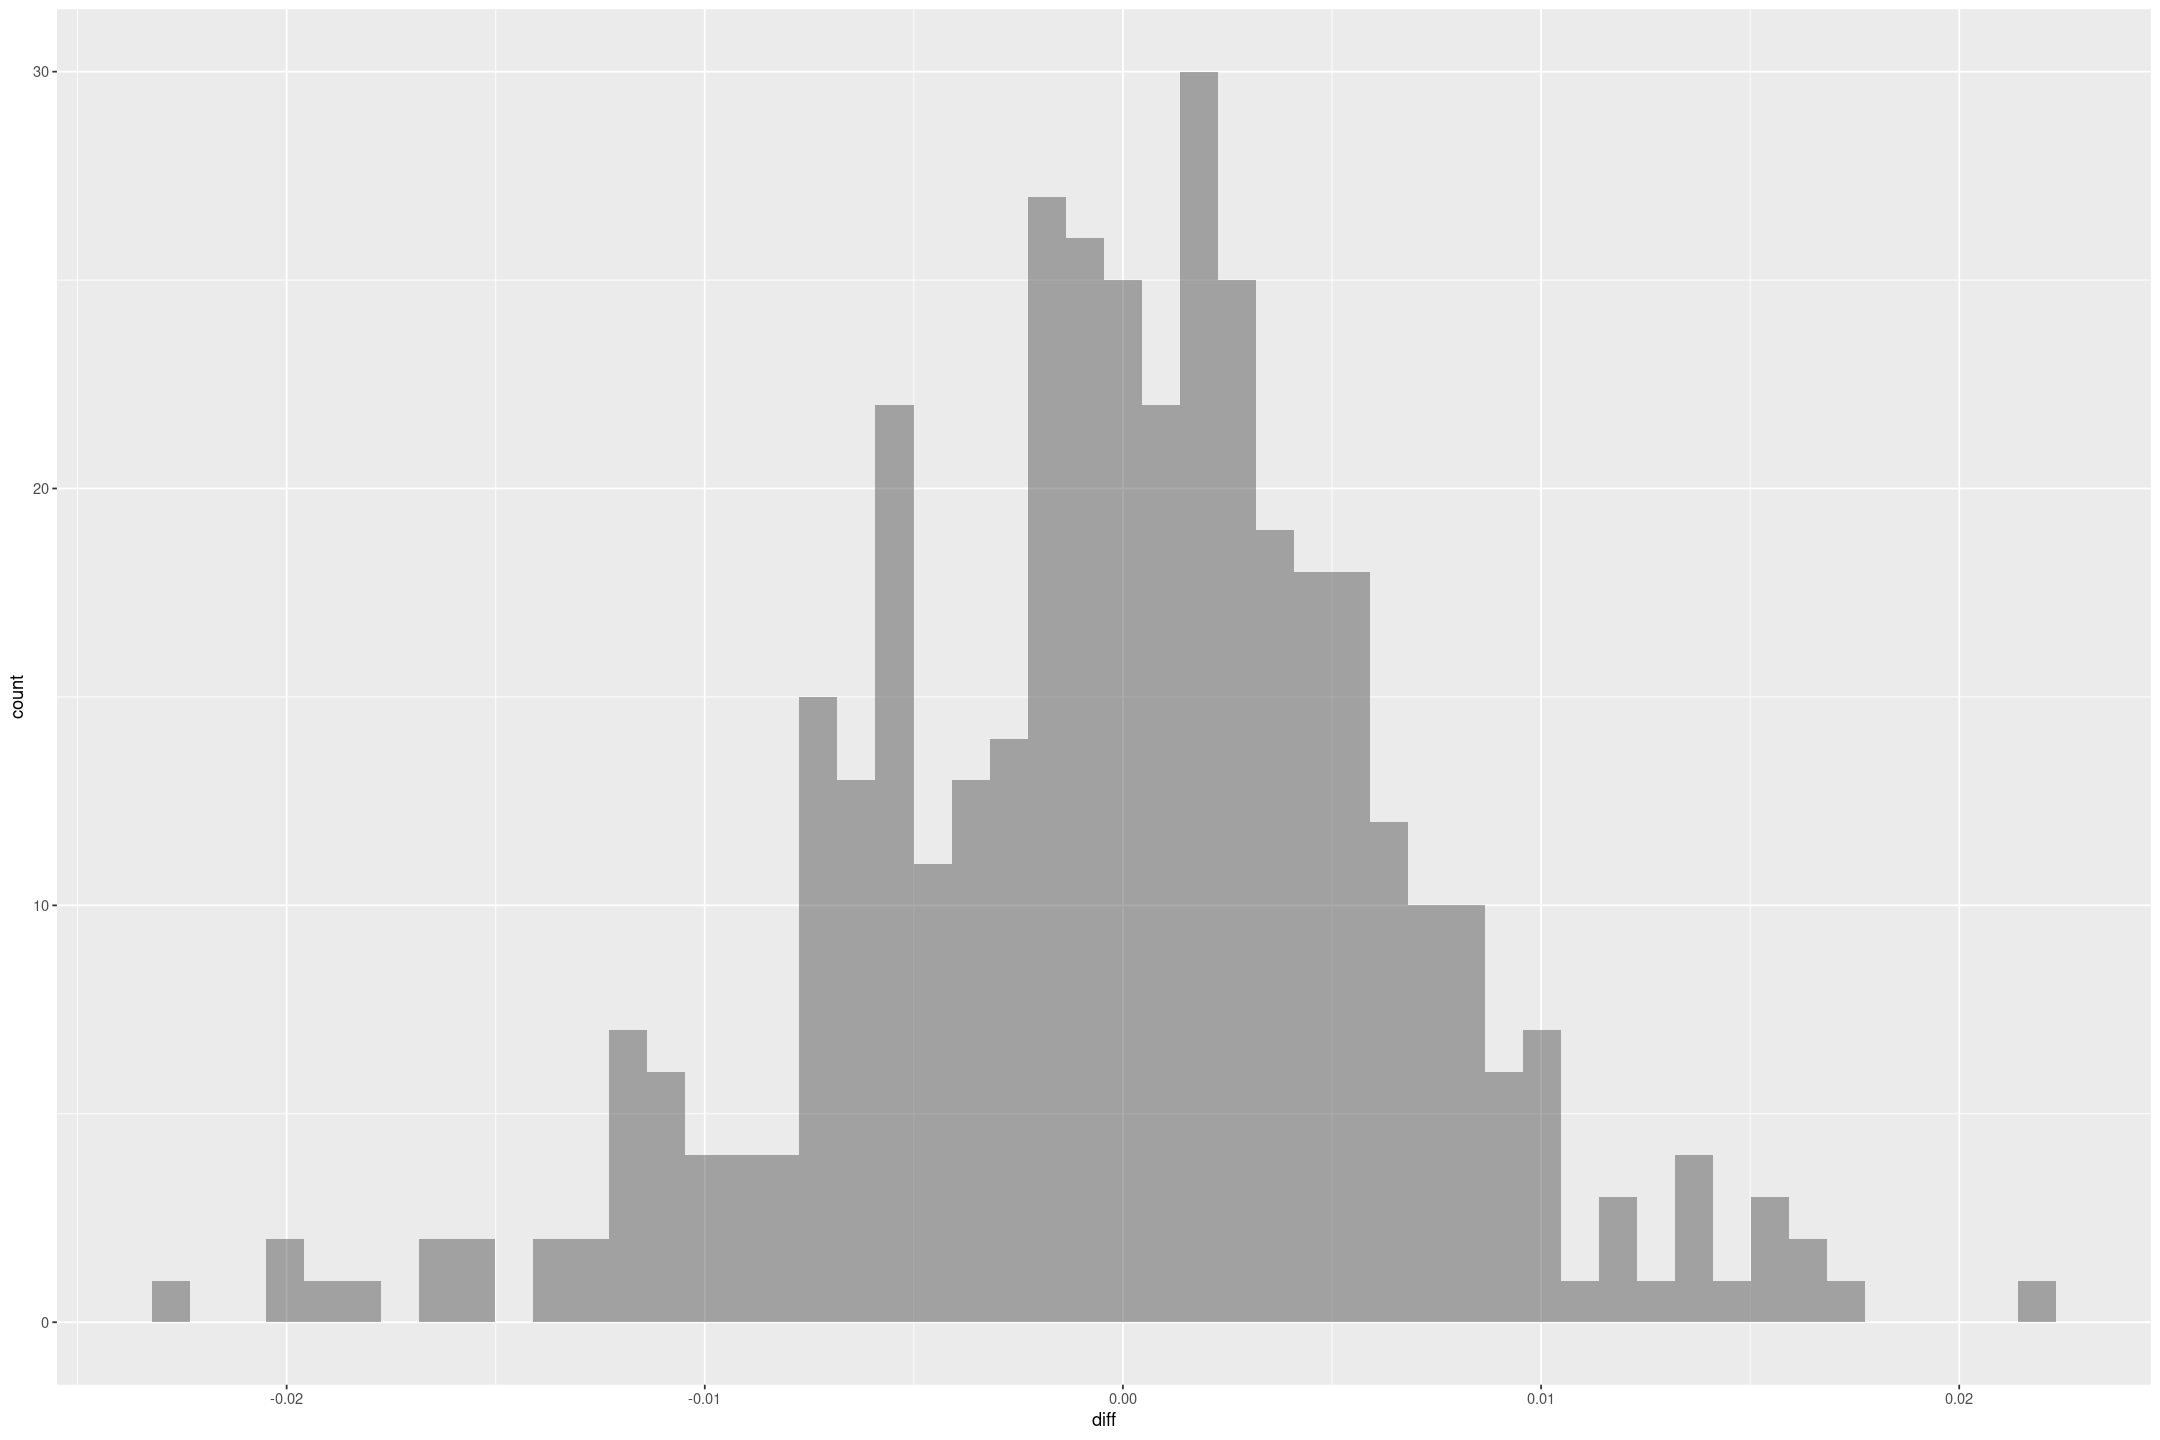

In [281]:
cbind(test_data, pred=predict(fit, type="response"), post_pred=apply(posterior_predict(fit), 2, mean)) %>%
mutate(diff = post_pred - pred) %>%
gf_histogram(~diff, bins=50)

In [282]:
dim(posterior_epred(fit_risky_p))

[1] 4000  434

In [283]:
posterior_epred.stan_multinomial <- function(object, newdata=NULL, draws=NULL) {
    if (is.null(newdata)) {
        newdata = object$data
    }
    groups <- unique(newdata[[object$group_name]])
    
    coef_matrix <- as.matrix(object$fit)
    if (!is.null(draws)) {
        coef_matrix <- coef_matrix[sample.int(nrow(coef_matrix), draws),,drop=FALSE]
    }
    
    N <- length(groups)
    y <- matrix(data=NA, nrow=nrow(coef_matrix), ncol=nrow(newdata))
    for (i in 1:N) {
        g <- groups[i]
        group_slice <- newdata[object$group_name] == g
        group_data <- subset(newdata, group_slice)
        group_matrix <- model.matrix(delete.response(object$terms), data=group_data)
        
        group_link <- coef_matrix[,colnames(group_matrix)] %*% t(group_matrix)
        group_probs <- exp(group_link) / apply(exp(group_link), 1, sum)
        
        
               
        y[, group_slice] <- group_probs
    }
    y
}

### Fitting on Oscars Data

In [284]:
oscars_unique_winner %>% head(10)

No Year Comp Name      PP DD MM FF Ch Movie     Nom Pic Dir Aml Afl Ams Afs
1  21 2005 314  Brokeback 1  0  0  0  2  Brokeback 8   1   1   1   0   1   1  
2  22 2005 314  Capote    1  0  0  0  2  Capote    5   1   1   1   0   0   1  
3  23 2005 314  Crash     1  0  0  0  1  Crash     6   1   1   0   0   1   0  
4  24 2005 314  Goodnight 1  0  0  0  2  Goodnight 6   1   1   1   0   0   0  
5  25 2005 314  Munich    1  0  0  0  2  Munich    5   1   1   0   0   0   0  
6  26 2005 313  Clooney   0  1  0  0  2  Goodnight 6   1   1   1   0   0   0  
7  27 2005 313  Haggis    0  1  0  0  2  Crash     6   1   1   0   0   1   0  
8  28 2005 313  Lee       0  1  0  0  1  Brokeback 8   1   1   1   0   1   1  
9  29 2005 313  Miller    0  1  0  0  2  Capote    5   1   1   1   0   0   1  
10 30 2005 313  Spielberg 0  1  0  0  2  Munich    5   1   1   0   0   0   0  
   Scr Cin Art Cos Sco Son Edi Sou For Anf Eff Mak Dan AD PrNl PrWl PrNs PrWs
1  1   1   0   0   1   0   0   0   0   0   0   0   0   0  0    0    0    0   
2  1   0   0   0   0   0   0   0   0   0   0   0   0   0  0    0    0    0   
3  1   0   0   0   0   1   1   0   0   0   0   0   0   0  0    0    0    0   
4  1   1   1   0   0   0   0   0   0   0   0   0   0   0  0    0    0    0   
5  1   0   0   0   1   0   1   0   0   0   0   0   0   0  0    0    0    0   
6  1   1   1   0   0   0   0   0   0   0   0   0   0   0  0    0    0    0   
7  1   0   0   0   0   1   1   0   0   0   0   0   0   0  0    0    0    0   
8  1   1   0   0   1   0   0   0   0   0   0   0   0   0  0    0    0    0   
9  1   0   0   0   0   0   0   0   0   0   0   0   0   0  0    0    0    0   
10 1   0   0   0   1   0   1   0   0   0   0   0   0   0  0    0    0    0   
   PrN PrW Gdr Gmc Gd Gm1 Gm2 Gf1 Gf2 PGA DGA SAM SAF PN PD DN DP DPrN DPrW MN
1  0   0   1   0   0  0   0   0   0   1   0   0   0   8  1  0  0  0    0    0 
2  0   0   0   0   0  0   0   0   0   0   0   0   0   5  1  0  0  0    0    0 
3  0   0   0   0   0  0   0   0   0   0   0   0   0   6  1  0  0  0    0    0 
4  0   0   0   0   0  0   0   0   0   0   0   0   0   6  1  0  0  0    0    0 
5  0   0   0   0   0  0   0   0   0   0   0   0   0   5  1  0  0  0    0    0 
6  0   0   0   0   0  0   0   0   0   0   0   0   0   0  0  6  1  0    0    0 
7  0   0   0   0   0  0   0   0   0   0   0   0   0   0  0  6  1  0    0    0 
8  1   0   0   0   1  0   0   0   0   0   1   0   0   0  0  8  1  1    0    0 
9  0   0   0   0   0  0   0   0   0   0   0   0   0   0  0  5  1  0    0    0 
10 5   2   0   0   0  0   0   0   0   0   0   0   0   0  0  5  1  5    2    0 
   MP MPrN MPrW FN FP FPrN FPrW win   rn
1  0  0    0    0  0  0    0    FALSE 1 
2  0  0    0    0  0  0    0    FALSE 2 
3  0  0    0    0  0  0    0     TRUE 3 
4  0  0    0    0  0  0    0    FALSE 4 
5  0  0    0    0  0  0    0    FALSE 5 
6  0  0    0    0  0  0    0    FALSE 1 
7  0  0    0    0  0  0    0    FALSE 2 
8  0  0    0    0  0  0    0     TRUE 3 
9  0  0    0    0  0  0    0    FALSE 4 
10 0  0    0    0  0  0    0    FALSE 5

If I was doing this naively I'd fit separate models for each category.

For the sake of argument here's a big one

In [285]:
start_time <- Sys.time()
fit_oscars <- fit_multinomial_long(win ~ I(PP + MM + FF):Dir +  # Director nom if not Director
                                         I(DD + MM + FF):Pic +
                                         I(DD + PP + FF):Aml +
                                         I(DD + PP + MM):Afl +
                                         (DD + PP):(Edi + Cin + Art + Cos + Sco + Eff) +
                                         Scr +
                                         PrNl + PrWl + PrNs + PrWs + PrN + PrW +
                                         Gdr + Gmc + Gd + Gm1 + Gf1 + PGA + DGA + SAM + SAF
                                         - 1
                                         ,
                                   data=oscars_unique_winner, group_name = "Comp")
Sys.time() - start_time

Time difference of 35.28252 secs

These aren't scaked but the majority of them are binary.

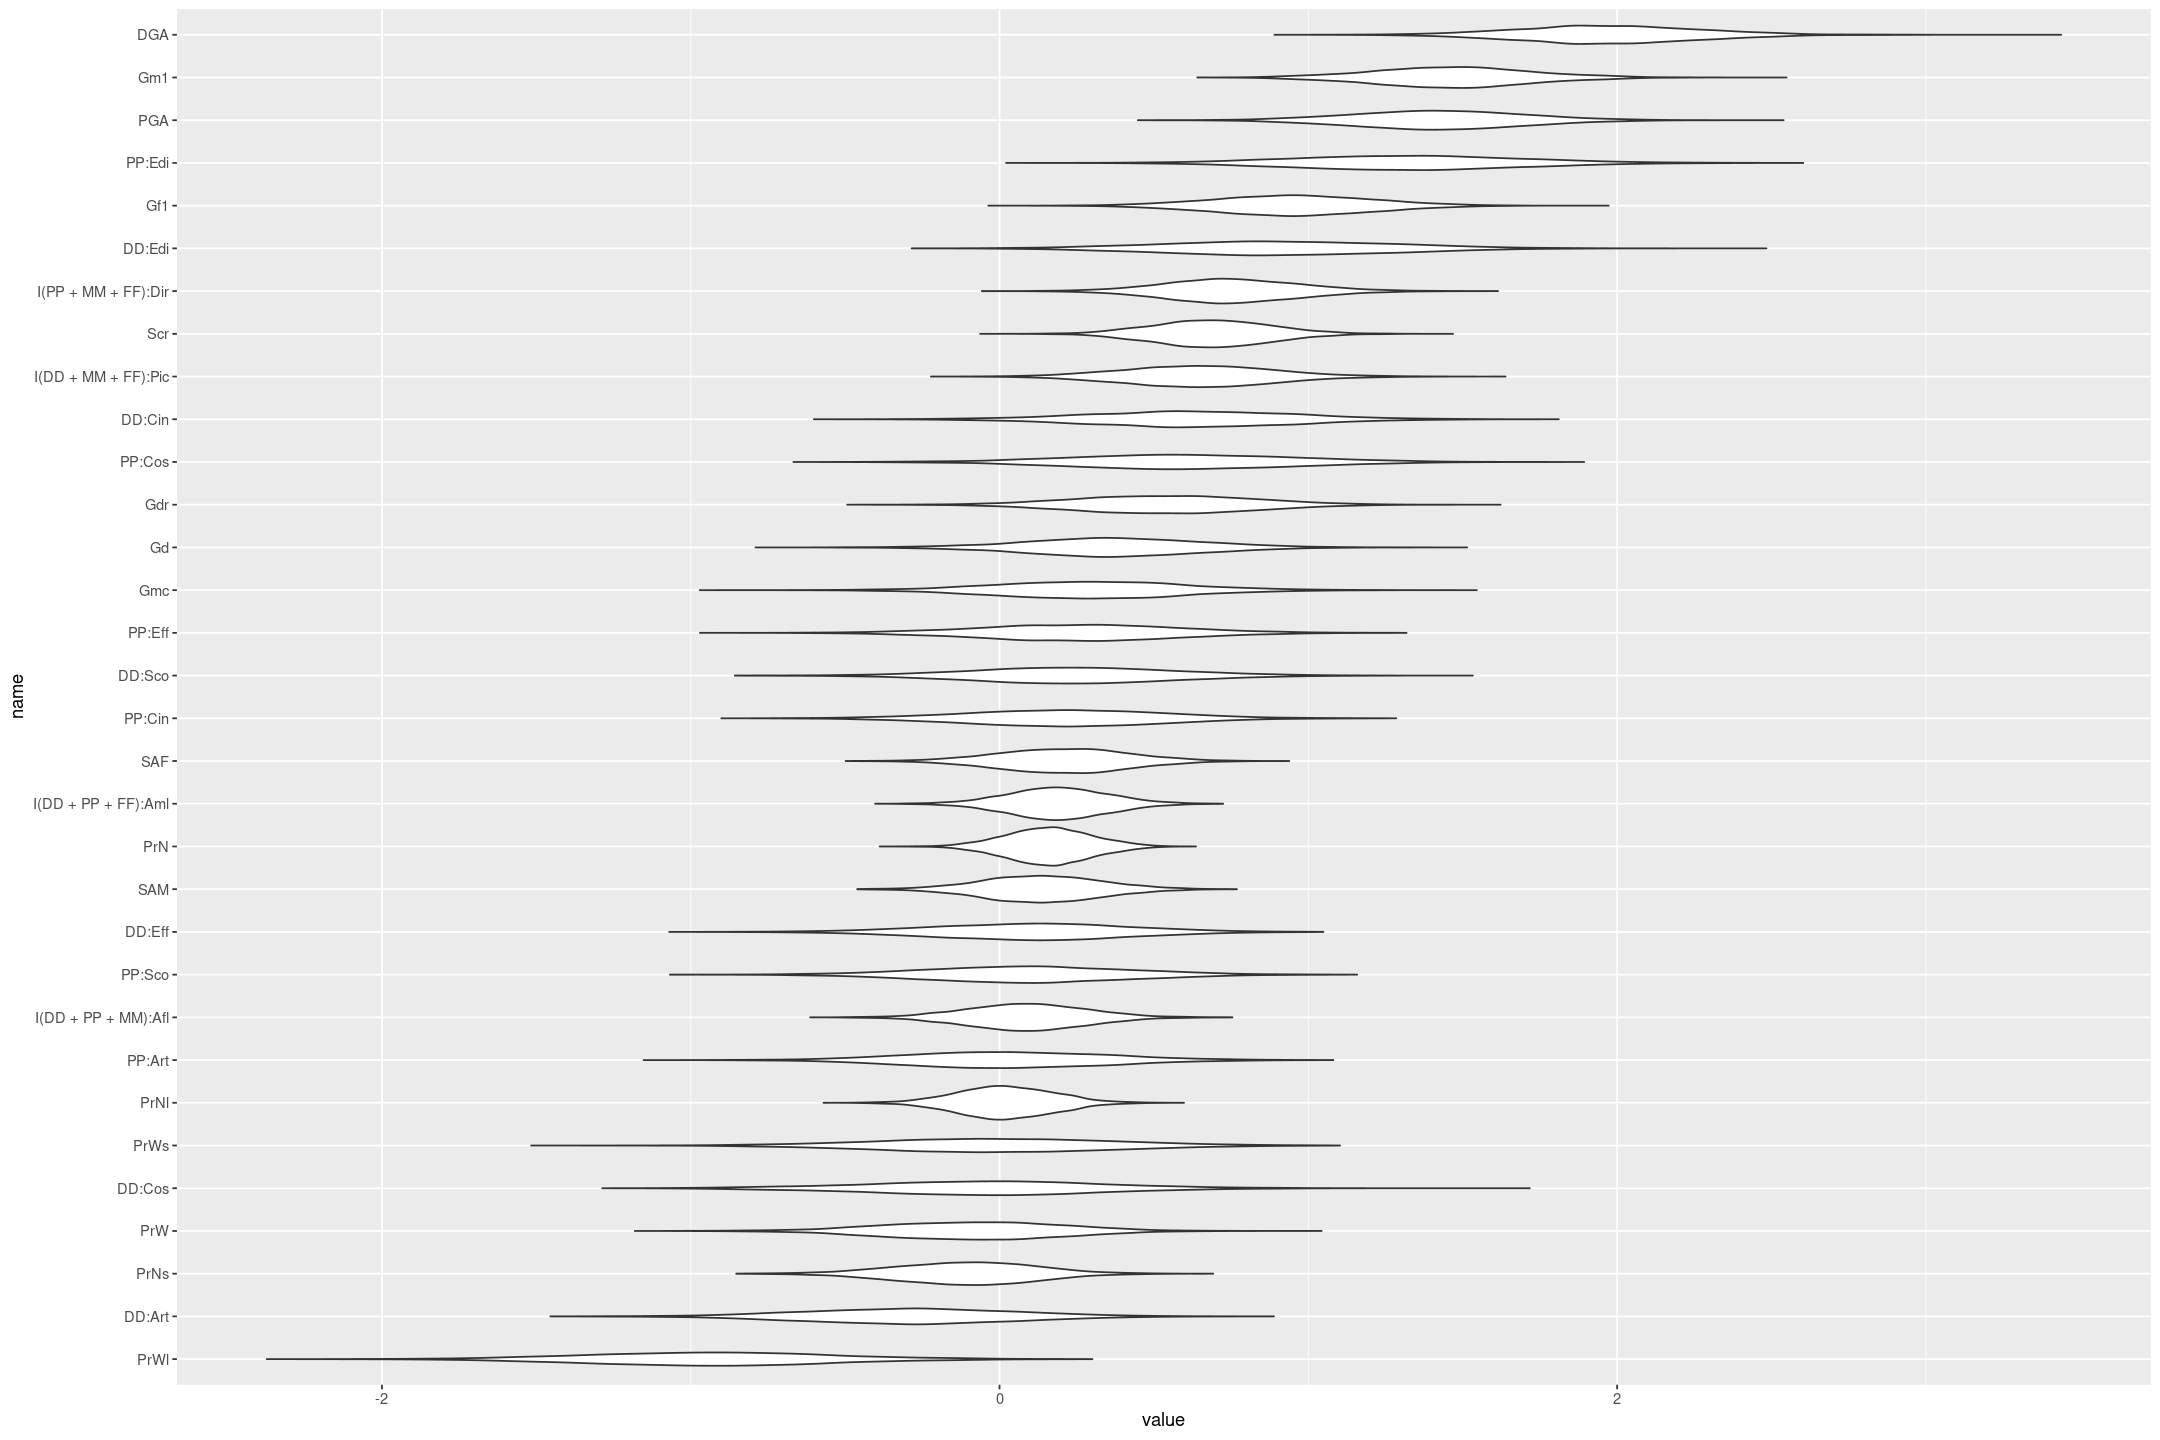

In [286]:
fit_oscars %>%
as.data.frame() %>%
select(-lp__) %>%
pivot_longer(everything()) %>%
mutate(name=forcats::fct_reorder(name, value)) %>%
gf_violin(name ~ value)

### Comparing with logistic regression

A logsitic regression is broadly similar but it *doesn't* account for the difference in difficulty due to the competitive set (e.g. if some years there would be many good entrants, others there wouldn't).

In [287]:
fit_oscars_logistic <- stan_glm(formula(fit_oscars$terms), family=binomial(link="logit"),  data=oscars_unique_winner)

The variable importance is broadly similar

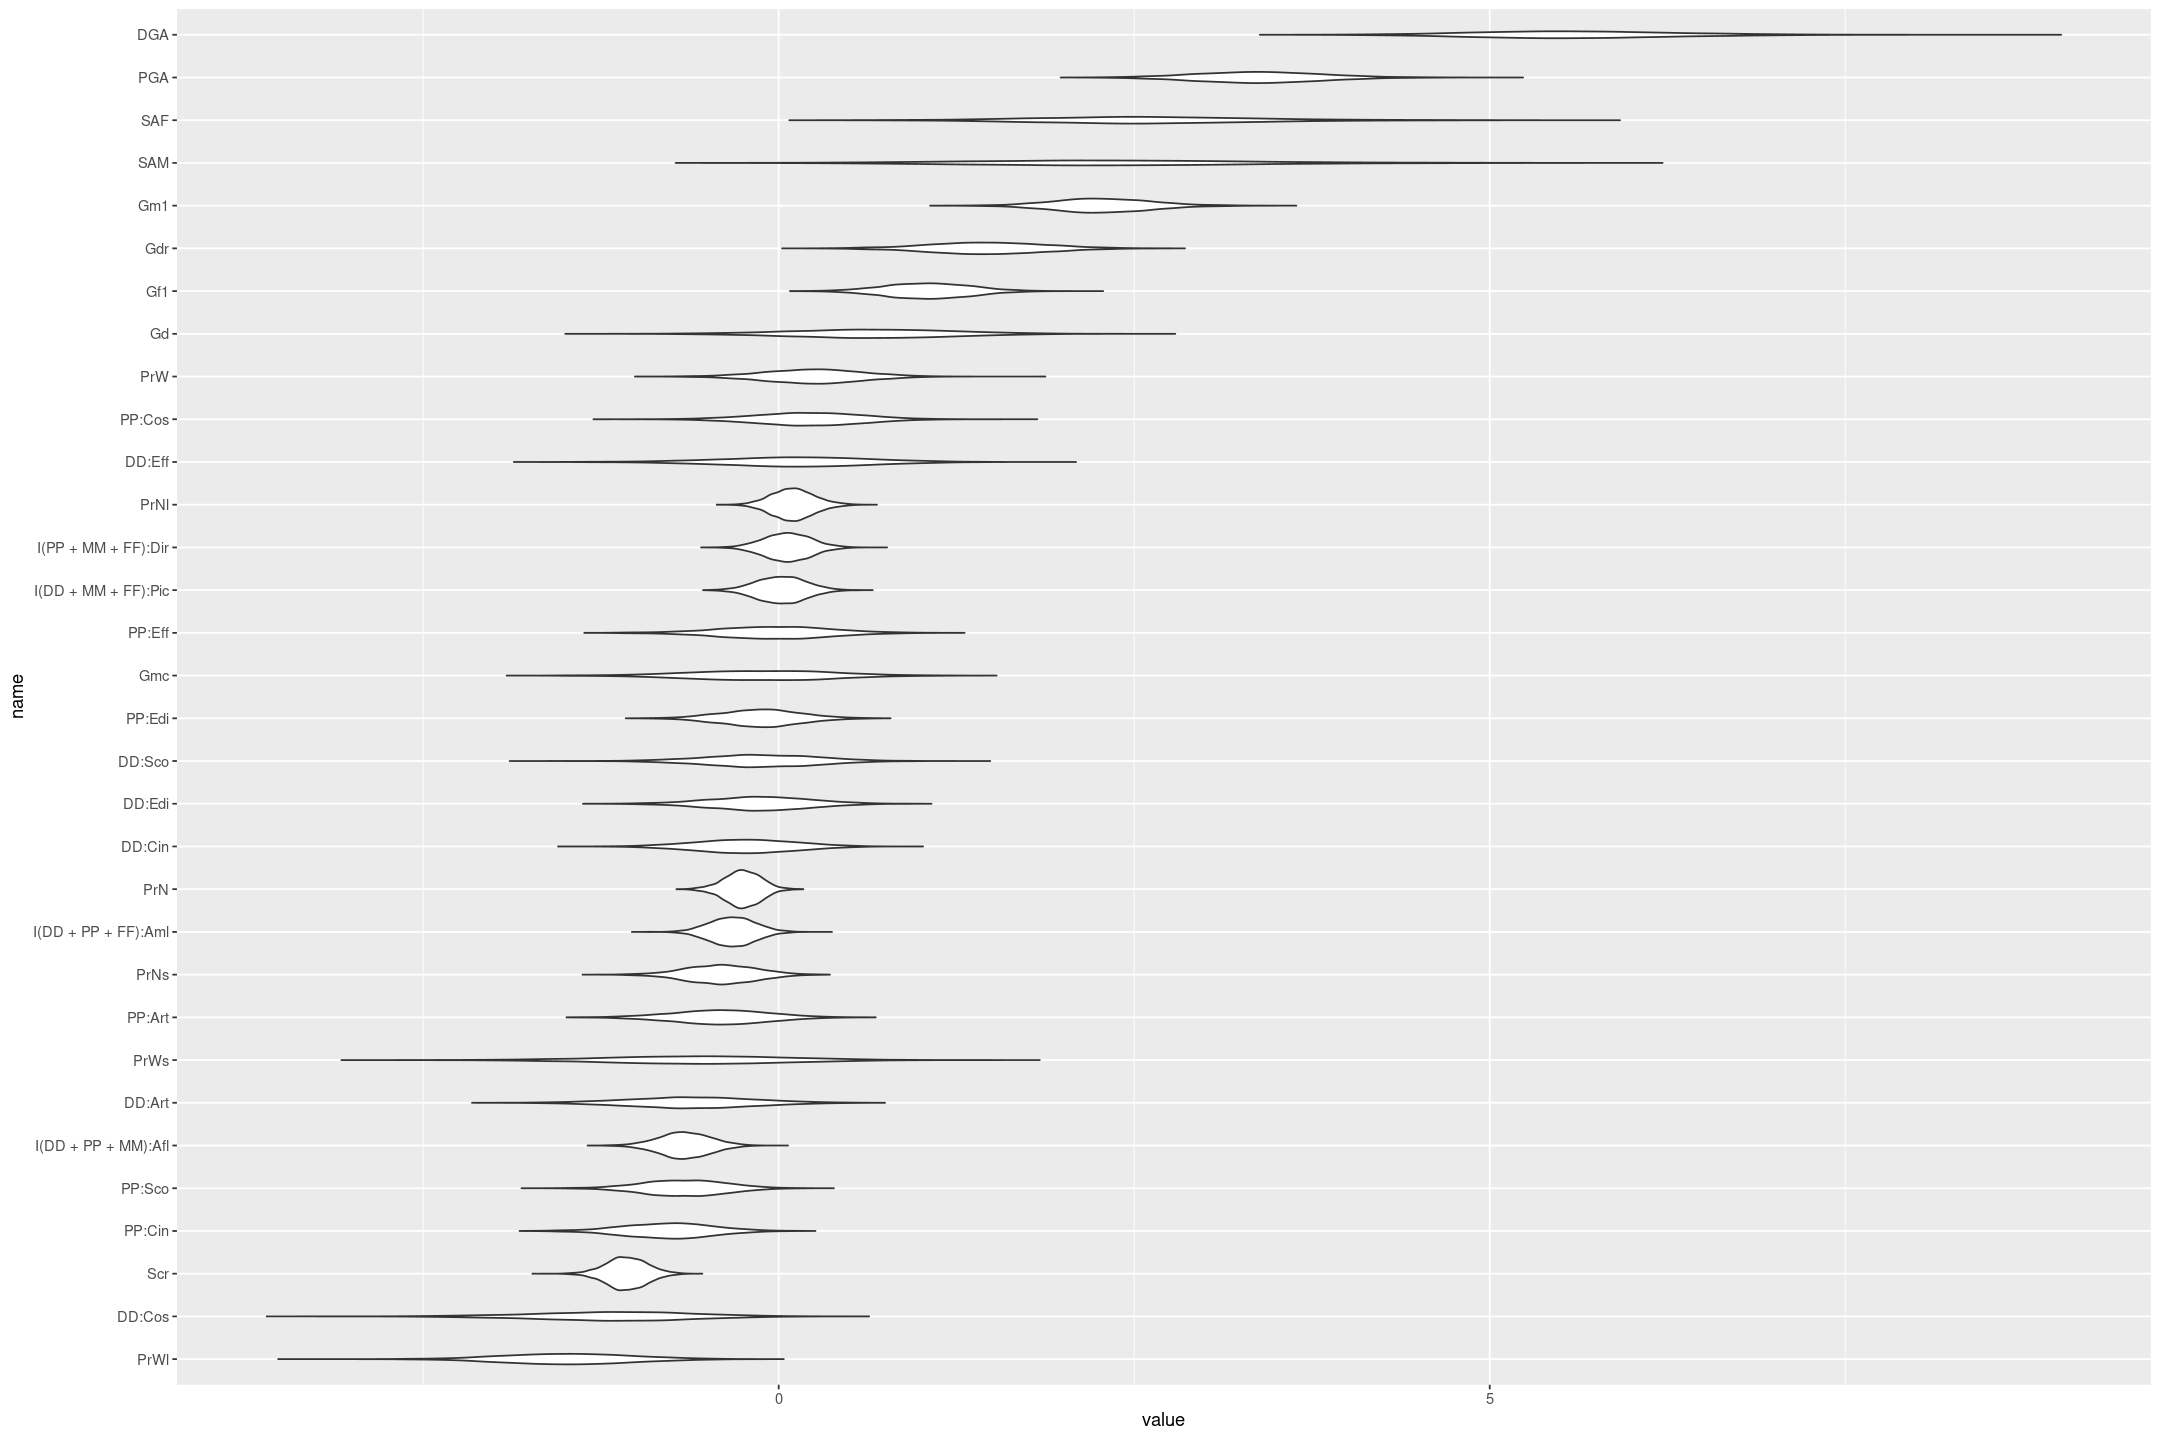

In [288]:
fit_oscars_logistic %>%
as.data.frame() %>%
pivot_longer(everything()) %>%
mutate(name=forcats::fct_reorder(name, value)) %>%
gf_violin(name ~ value)

### Appendix: Categorical regression

Cateogical regression considers the linear case is to look at the *log odds* between two categories:

$$\phi(k,l) = \ln\left(\frac{\mathbb{P}(y=k)}{\mathbb{P}(y=l)}\right) = \ln(\theta_k) - \ln(\theta_l) $$

This can be any real number, and so is a candidate for a linear regression output.
Indeed in the case $n=2$ this is exactly a logit, since $\theta_2 = 1 - \theta_1$

$$\phi(\theta_1,\theta_2) = \ln\left(\frac{\theta_1}{1-\theta_1}\right)  = {\rm logit}(\theta_1)$$

In general these log odds satisfy $\phi(k,l) + \phi(l, m) = \phi(k,m)$.

We could pick a *reference category*, for the sake of argument $n$, and model each of the log odds to the reference categories as a linear regression (i.e. $f_k(x) - f_n(x) = \beta_k X$ for $k=1,\ldots,n-1$.

Note that switching the reference category is a linear transformation on the parameters; for $k=1,\ldots,n-1$:
$$\begin{align}
f_k(x) - f_m(x) &= f_k(x) - f_n(x) - (f_m(x) - f_n(x)) \\
                &= (\beta_k - \beta_m) X 
\end{align}$$

and $f_n(x) - f_m(x) = -\beta_m X$. (This feels like cohomology).

To recover the probabilities, denoting $\beta_i X$ more generally as $a_{in}$ we get:

$$\frac{\theta_i}{\theta_n} = e^{a_{in}},\, i=1,\ldots,n-1 $$

Summing over this, using that the probabilities sum to 1:

$$\begin{align}
\frac{1 - \theta_n}{\theta_n} &= \frac{\sum_{i=1}^{n-1} \theta_i}{\theta_n} \\
  &= \sum_{i=1}^{n-1} e^{a_{in}}
\end{align}$$

and rearranging gives:

$$ \theta_n = \frac{1}{1 + \sum_{i=1}^{n-1} \exp(a_{in})} $$

and so:

$$ \theta_i = \frac{\exp(a_{in})}{1 + \sum_{i=1}^{n-1} \exp(a_{in})} $$

Notice in the case $n=2$ this simplifies to the inverse logistic function.
In particular for the linear model

$$ \theta_i = \frac{\exp(\beta_i X)}{1 + \sum_{j=1}^{n-1} \exp(\beta_j X)} $$

In the most general where the categories are distinguishable the $\beta_j$ could be different, but if they are interchangable they should all be the same.

## Plotting the uncertainty

Make a plot displaying the uncertainty in inferences from the fitted model.

In [289]:
oscars_holdout = oscars %>% filter(Year==2006)

Our simple model has some strong predictions, we can plot the point predictions, as well as a 95% confidence interval on them.

We'd be very surprised if Mirren or Scorcese lost.

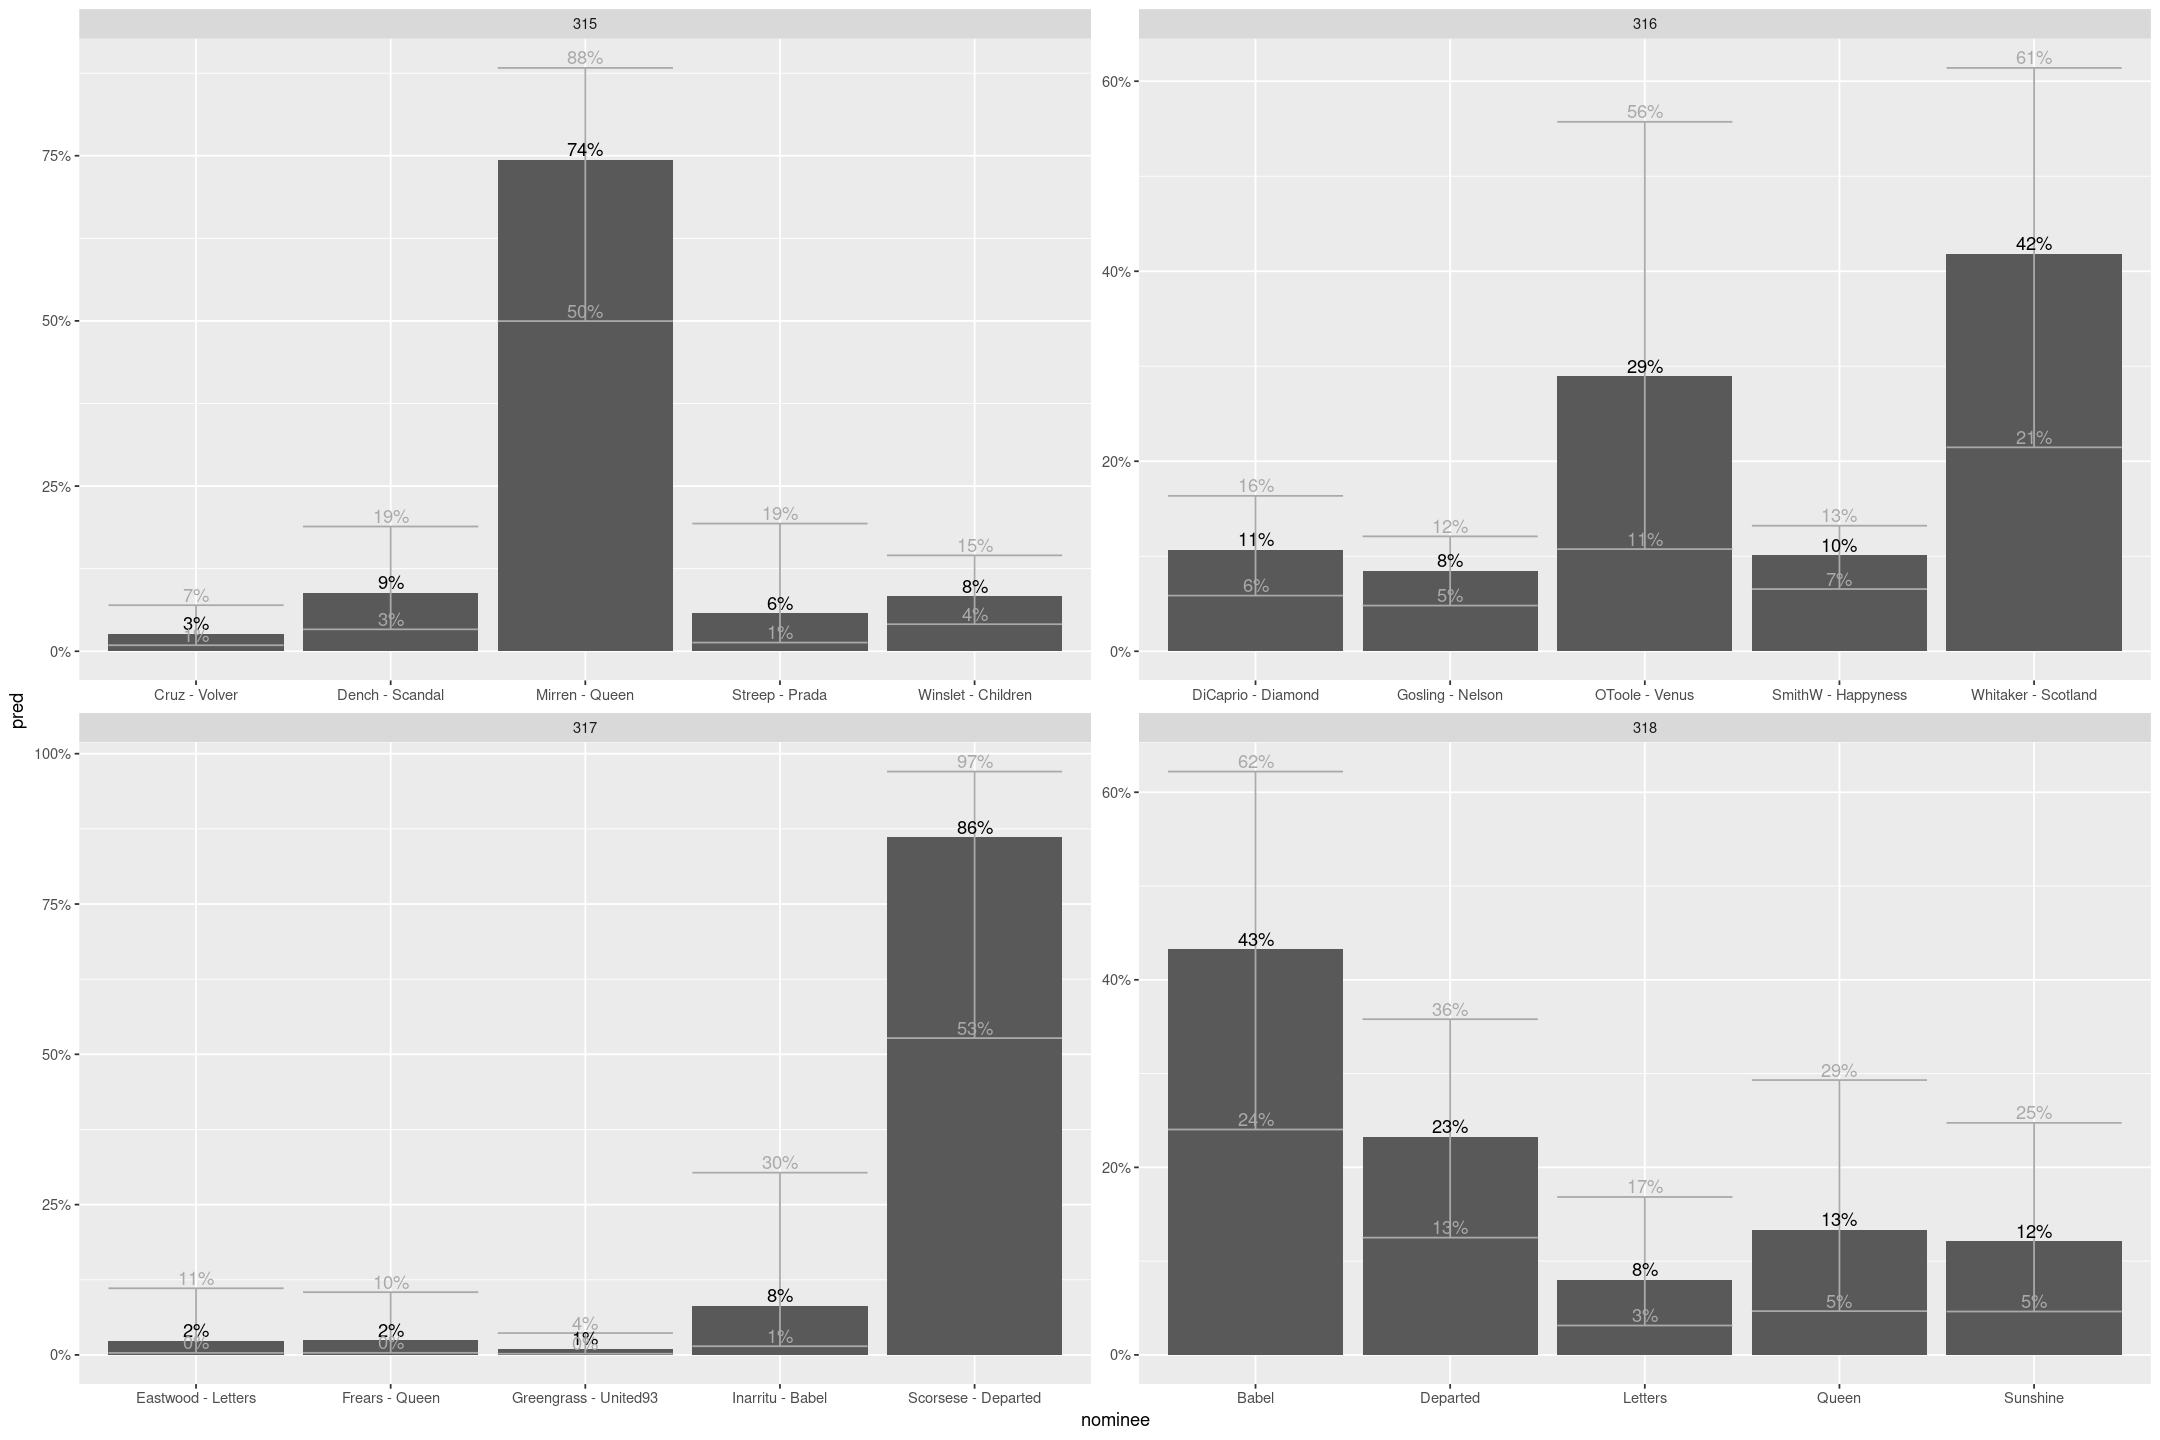

In [290]:
oscars_holdout %>%
mutate(lower = apply(posterior_epred(fit_oscars, newdata=.), 2, quantile, probs=0.025),
       upper = apply(posterior_epred(fit_oscars, newdata=.), 2, quantile, probs=0.975),
       pred=predict(fit_oscars, newdata=., type="response"))  %>%
mutate(nominee = case_when(PP==1 ~ glue('{Name}'), TRUE ~ glue('{Name} - {Movie}'))) %>%
ggplot(aes(x=nominee, y=pred)) +
geom_bar(stat="identity") +
facet_wrap(~Comp, scales="free") + 
scale_y_continuous(labels = scales::percent) +
geom_errorbar(aes(ymin=lower, ymax=upper), colour="darkgrey") +
geom_text(aes(label=scales::percent(pred,1)), position=position_dodge(width=0.9), vjust=-0.25) +
geom_text(aes(label=scales::percent(lower,1), y=lower), position=position_dodge(width=0.9), vjust=-0.25, colour="darkgrey") +
geom_text(aes(label=scales::percent(upper,1), y=upper), position=position_dodge(width=0.9), vjust=-0.25, colour="darkgrey")

Compare with the logistic regression, which we need to rescale for things to add to 100%

For everything other than best picture the  predictions are the same, but the model is significantly less confident.
For best picture it's even more wrong than our multinomial model.

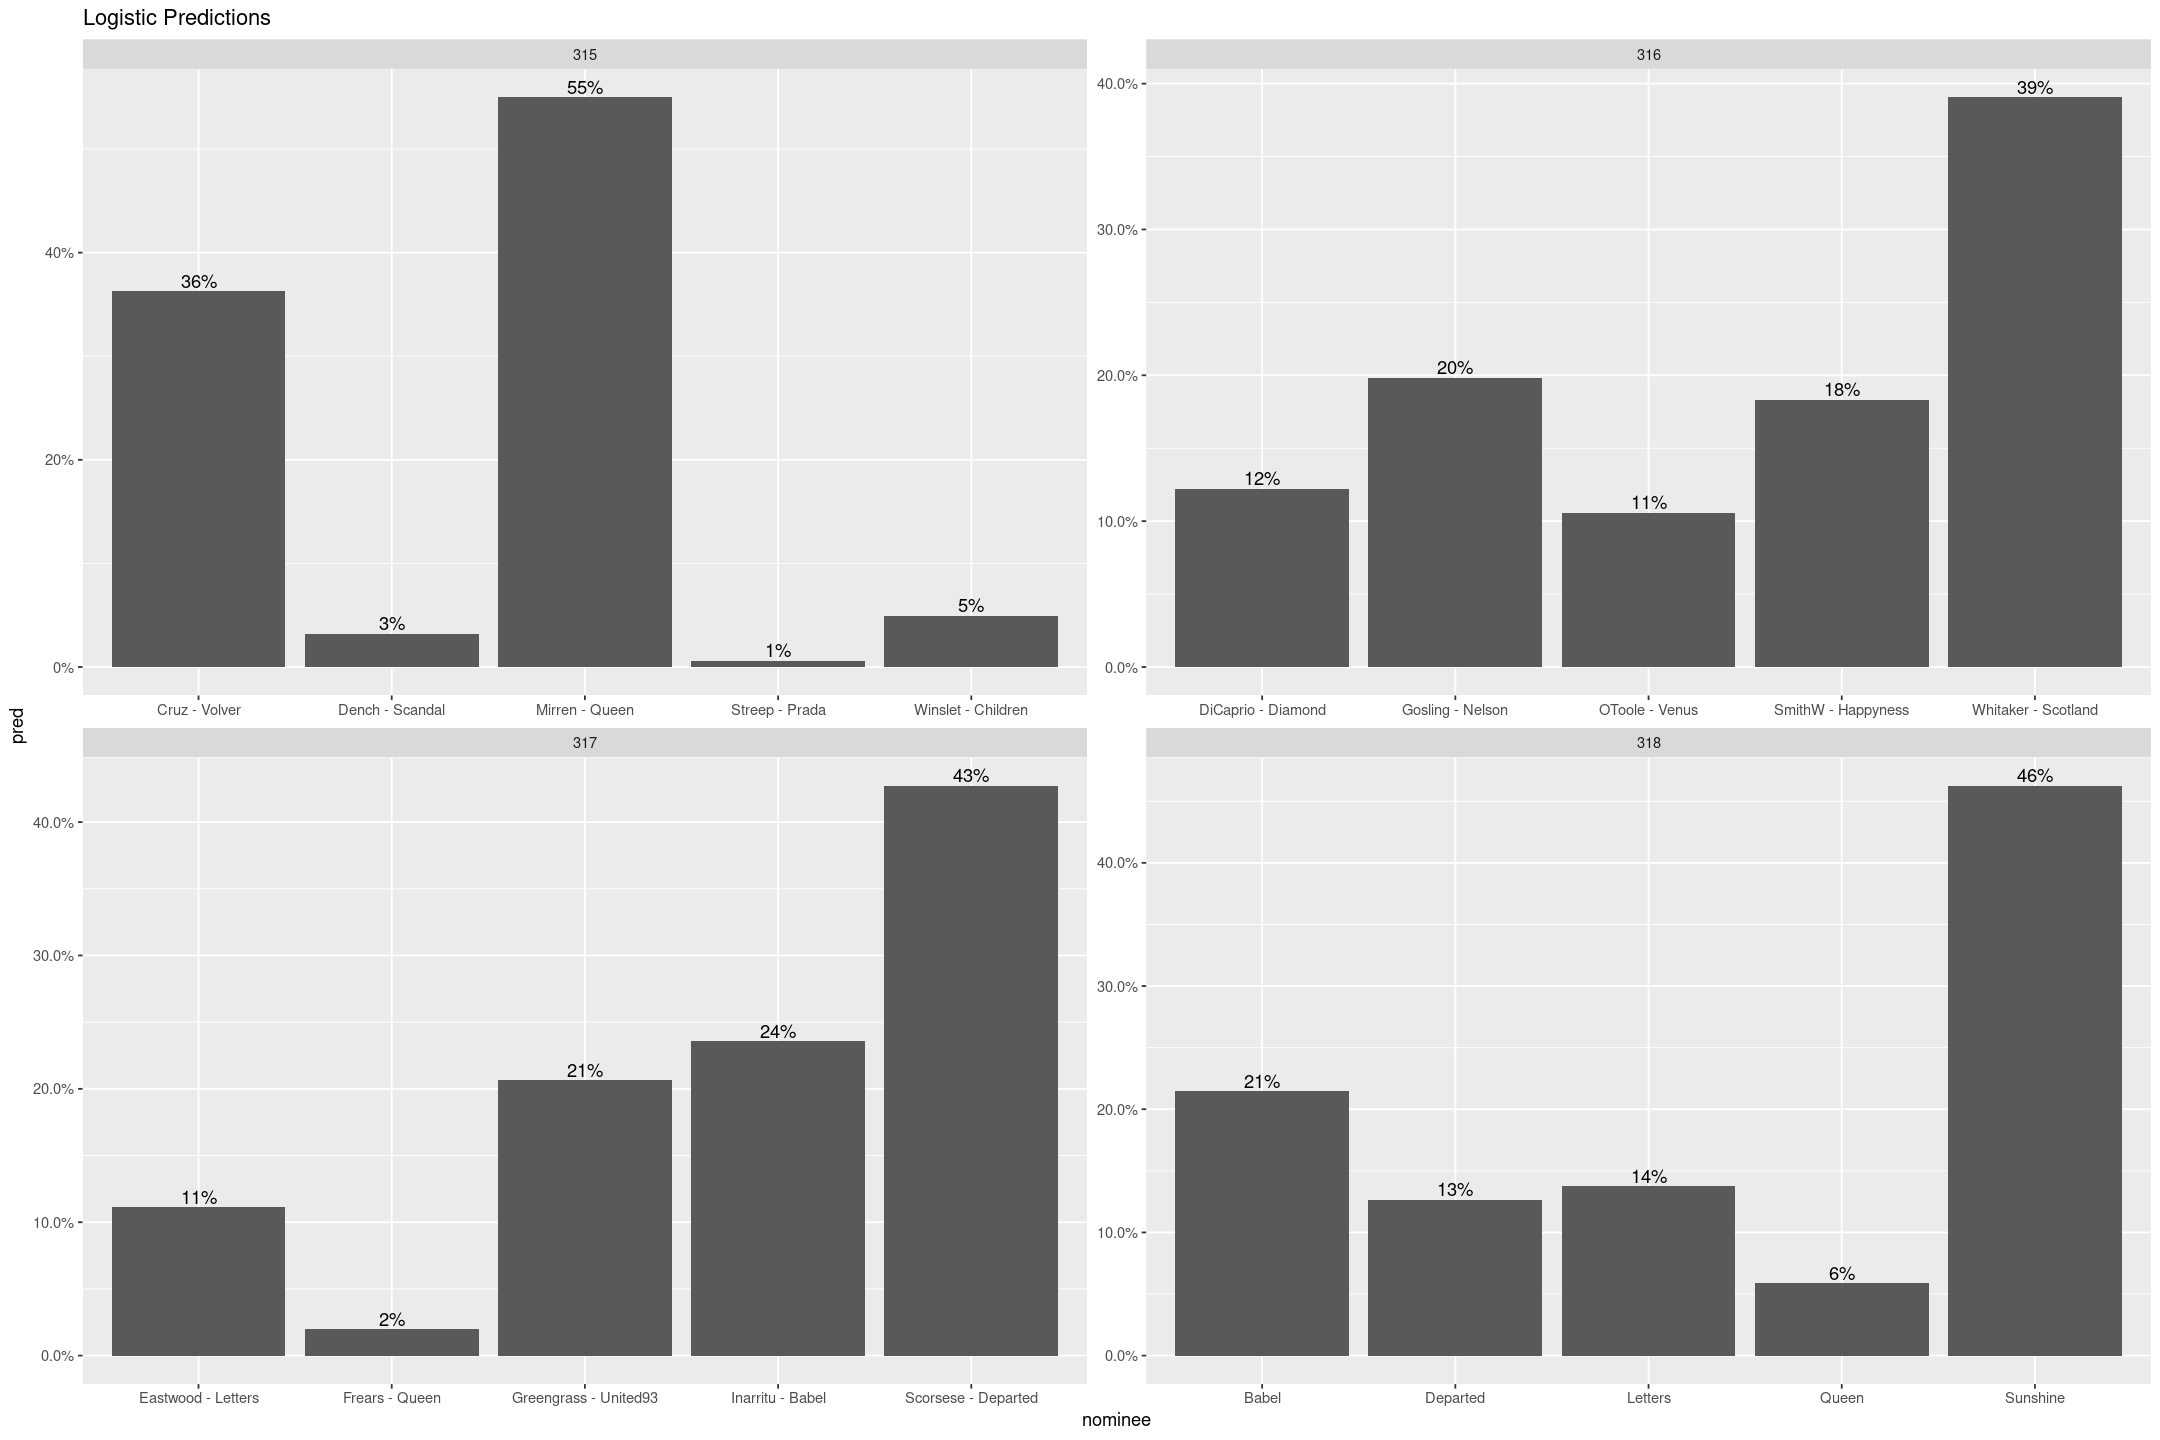

In [291]:
oscars_holdout %>%
mutate(pred_raw=predict(fit_oscars_logistic, newdata=., type="response"))  %>%
group_by(Comp) %>%
mutate(pred = pred_raw/sum(pred_raw), .groups="drop") %>%
mutate(nominee = case_when(PP==1 ~ glue('{Name}'), TRUE ~ glue('{Name} - {Movie}'))) %>%
ggplot(aes(x=nominee, y=pred)) +
geom_bar(stat="identity") +
facet_wrap(~Comp, scales="free") + 
scale_y_continuous(labels = scales::percent) +
geom_text(aes(label=scales::percent(pred,1)), position=position_dodge(width=0.9), vjust=-0.25) +
ggtitle('Logistic Predictions')

The [winners were](https://www.oscars.org/oscars/ceremonies/2007) 

* MM - Forest Whitaker (as predicted)
* FF - Helen Mirren (as predicted)
* DD - Martin Scorsese (as predicted)
* PP - The Departed (second prediction)

This model is pretty good - can we understand *why* it made the predictions?

In [292]:
director_data <- oscars_holdout %>% filter(Comp==317)

In [293]:
(director_model_matrix <- model.matrix(delete.response(fit_oscars$terms), data=director_data))

Scr PrNl PrWl PrNs PrWs PrN PrW Gdr Gmc Gd Gm1 Gf1 PGA DGA SAM SAF
1 1   0    0    0    0    0   0   1   0   0  0   0   0   0   0   0  
2 1   0    0    0    0    5   0   0   0   1  0   0   0   1   0   0  
3 1   0    0    0    0    3   2   0   0   0  0   0   0   0   0   0  
4 1   0    0    0    0    1   0   0   0   0  0   0   0   0   0   0  
5 0   0    0    0    0    0   0   0   0   0  0   0   0   0   0   0  
  I(PP + MM + FF):Dir I(DD + MM + FF):Pic I(DD + PP + FF):Aml
1 0                   1                   0                  
2 0                   1                   0                  
3 0                   1                   0                  
4 0                   1                   0                  
5 0                   0                   0                  
  I(DD + PP + MM):Afl DD:Edi DD:Cin DD:Art DD:Cos DD:Sco DD:Eff PP:Edi PP:Cin
1 0                   1      0      0      0      1      0      0      0     
2 0                   1      0      0      0      0      0      0      0     
3 0                   0      0      0      0      0      1      0      0     
4 1                   0      0      0      1      1      0      0      0     
5 0                   1      0      0      0      0      0      0      0     
  PP:Art PP:Cos PP:Sco PP:Eff
1 0      0      0      0     
2 0      0      0      0     
3 0      0      0      0     
4 0      0      0      0     
5 0      0      0      0

In [294]:
(coefs <- apply(as.matrix(fit_oscars), 2, median)[colnames(director_model_matrix)])

Scr                PrNl                PrWl                PrNs 
         0.68492283          0.01680643         -0.94423000         -0.10319579 
               PrWs                 PrN                 PrW                 Gdr 
        -0.02014035          0.15894721         -0.08697236          0.53402251 
                Gmc                  Gd                 Gm1                 Gf1 
         0.29197234          0.36516505          1.46439601          0.94777652 
                PGA                 DGA                 SAM                 SAF 
         1.41574734          1.96483619          0.13376638          0.20922133 
I(PP + MM + FF):Dir I(DD + MM + FF):Pic I(DD + PP + FF):Aml I(DD + PP + MM):Afl 
         0.74566970          0.64307571          0.18695300          0.08533630 
             DD:Edi              DD:Cin              DD:Art              DD:Cos 
         0.89672423          0.62285523         -0.28818841         -0.04111069 
             DD:Sco              DD:Eff              PP:Edi              PP:Cin 
         0.23804105          0.11058152          1.32006620          0.21357614 
             PP:Art              PP:Cos              PP:Sco              PP:Eff 
         0.02151031          0.59174324          0.08733528          0.25841229

In [295]:
length(coefs)

[1] 32

Because Scorcese won the Directors Guild of America award, won a Golden Globe for direction and has 5 previous director nominations, he's a shoe in.

Inarritu is second because of the Golden globe Drama win.

In [296]:
term_matrix <- t(t(director_model_matrix) * coefs)
rownames(term_matrix) <- director_data$Name
term_matrix

Scr       PrNl PrWl PrNs PrWs PrN       PrW        Gdr       Gmc
Inarritu   0.6849228 0    0    0    0    0.0000000  0.0000000 0.5340225 0  
Scorsese   0.6849228 0    0    0    0    0.7947360  0.0000000 0.0000000 0  
Eastwood   0.6849228 0    0    0    0    0.4768416 -0.1739447 0.0000000 0  
Frears     0.6849228 0    0    0    0    0.1589472  0.0000000 0.0000000 0  
Greengrass 0.0000000 0    0    0    0    0.0000000  0.0000000 0.0000000 0  
           Gd        Gm1 Gf1 PGA DGA      SAM SAF I(PP + MM + FF):Dir
Inarritu   0.0000000 0   0   0   0.000000 0   0   0                  
Scorsese   0.3651651 0   0   0   1.964836 0   0   0                  
Eastwood   0.0000000 0   0   0   0.000000 0   0   0                  
Frears     0.0000000 0   0   0   0.000000 0   0   0                  
Greengrass 0.0000000 0   0   0   0.000000 0   0   0                  
           I(DD + MM + FF):Pic I(DD + PP + FF):Aml I(DD + PP + MM):Afl
Inarritu   0.6430757           0                   0.0000000          
Scorsese   0.6430757           0                   0.0000000          
Eastwood   0.6430757           0                   0.0000000          
Frears     0.6430757           0                   0.0853363          
Greengrass 0.0000000           0                   0.0000000          
           DD:Edi    DD:Cin DD:Art DD:Cos      DD:Sco    DD:Eff    PP:Edi
Inarritu   0.8967242 0      0       0.00000000 0.2380411 0.0000000 0     
Scorsese   0.8967242 0      0       0.00000000 0.0000000 0.0000000 0     
Eastwood   0.0000000 0      0       0.00000000 0.0000000 0.1105815 0     
Frears     0.0000000 0      0      -0.04111069 0.2380411 0.0000000 0     
Greengrass 0.8967242 0      0       0.00000000 0.0000000 0.0000000 0     
           PP:Cin PP:Art PP:Cos PP:Sco PP:Eff
Inarritu   0      0      0      0      0     
Scorsese   0      0      0      0      0     
Eastwood   0      0      0      0      0     
Frears     0      0      0      0      0     
Greengrass 0      0      0      0      0

In [297]:
apply(term_matrix, 1, sum)

Inarritu   Scorsese   Eastwood     Frears Greengrass 
 2.9967863  5.3494601  1.7414770  1.7692124  0.8967242

## Plotting the model

Display the fitted model on a plot that also shows the data.

We can see that our fitted model is quite volatile in the predictions, but does better than the random model (in light grey) most years.
Also note that when it think it's right it normally is - but again this is on the training set!

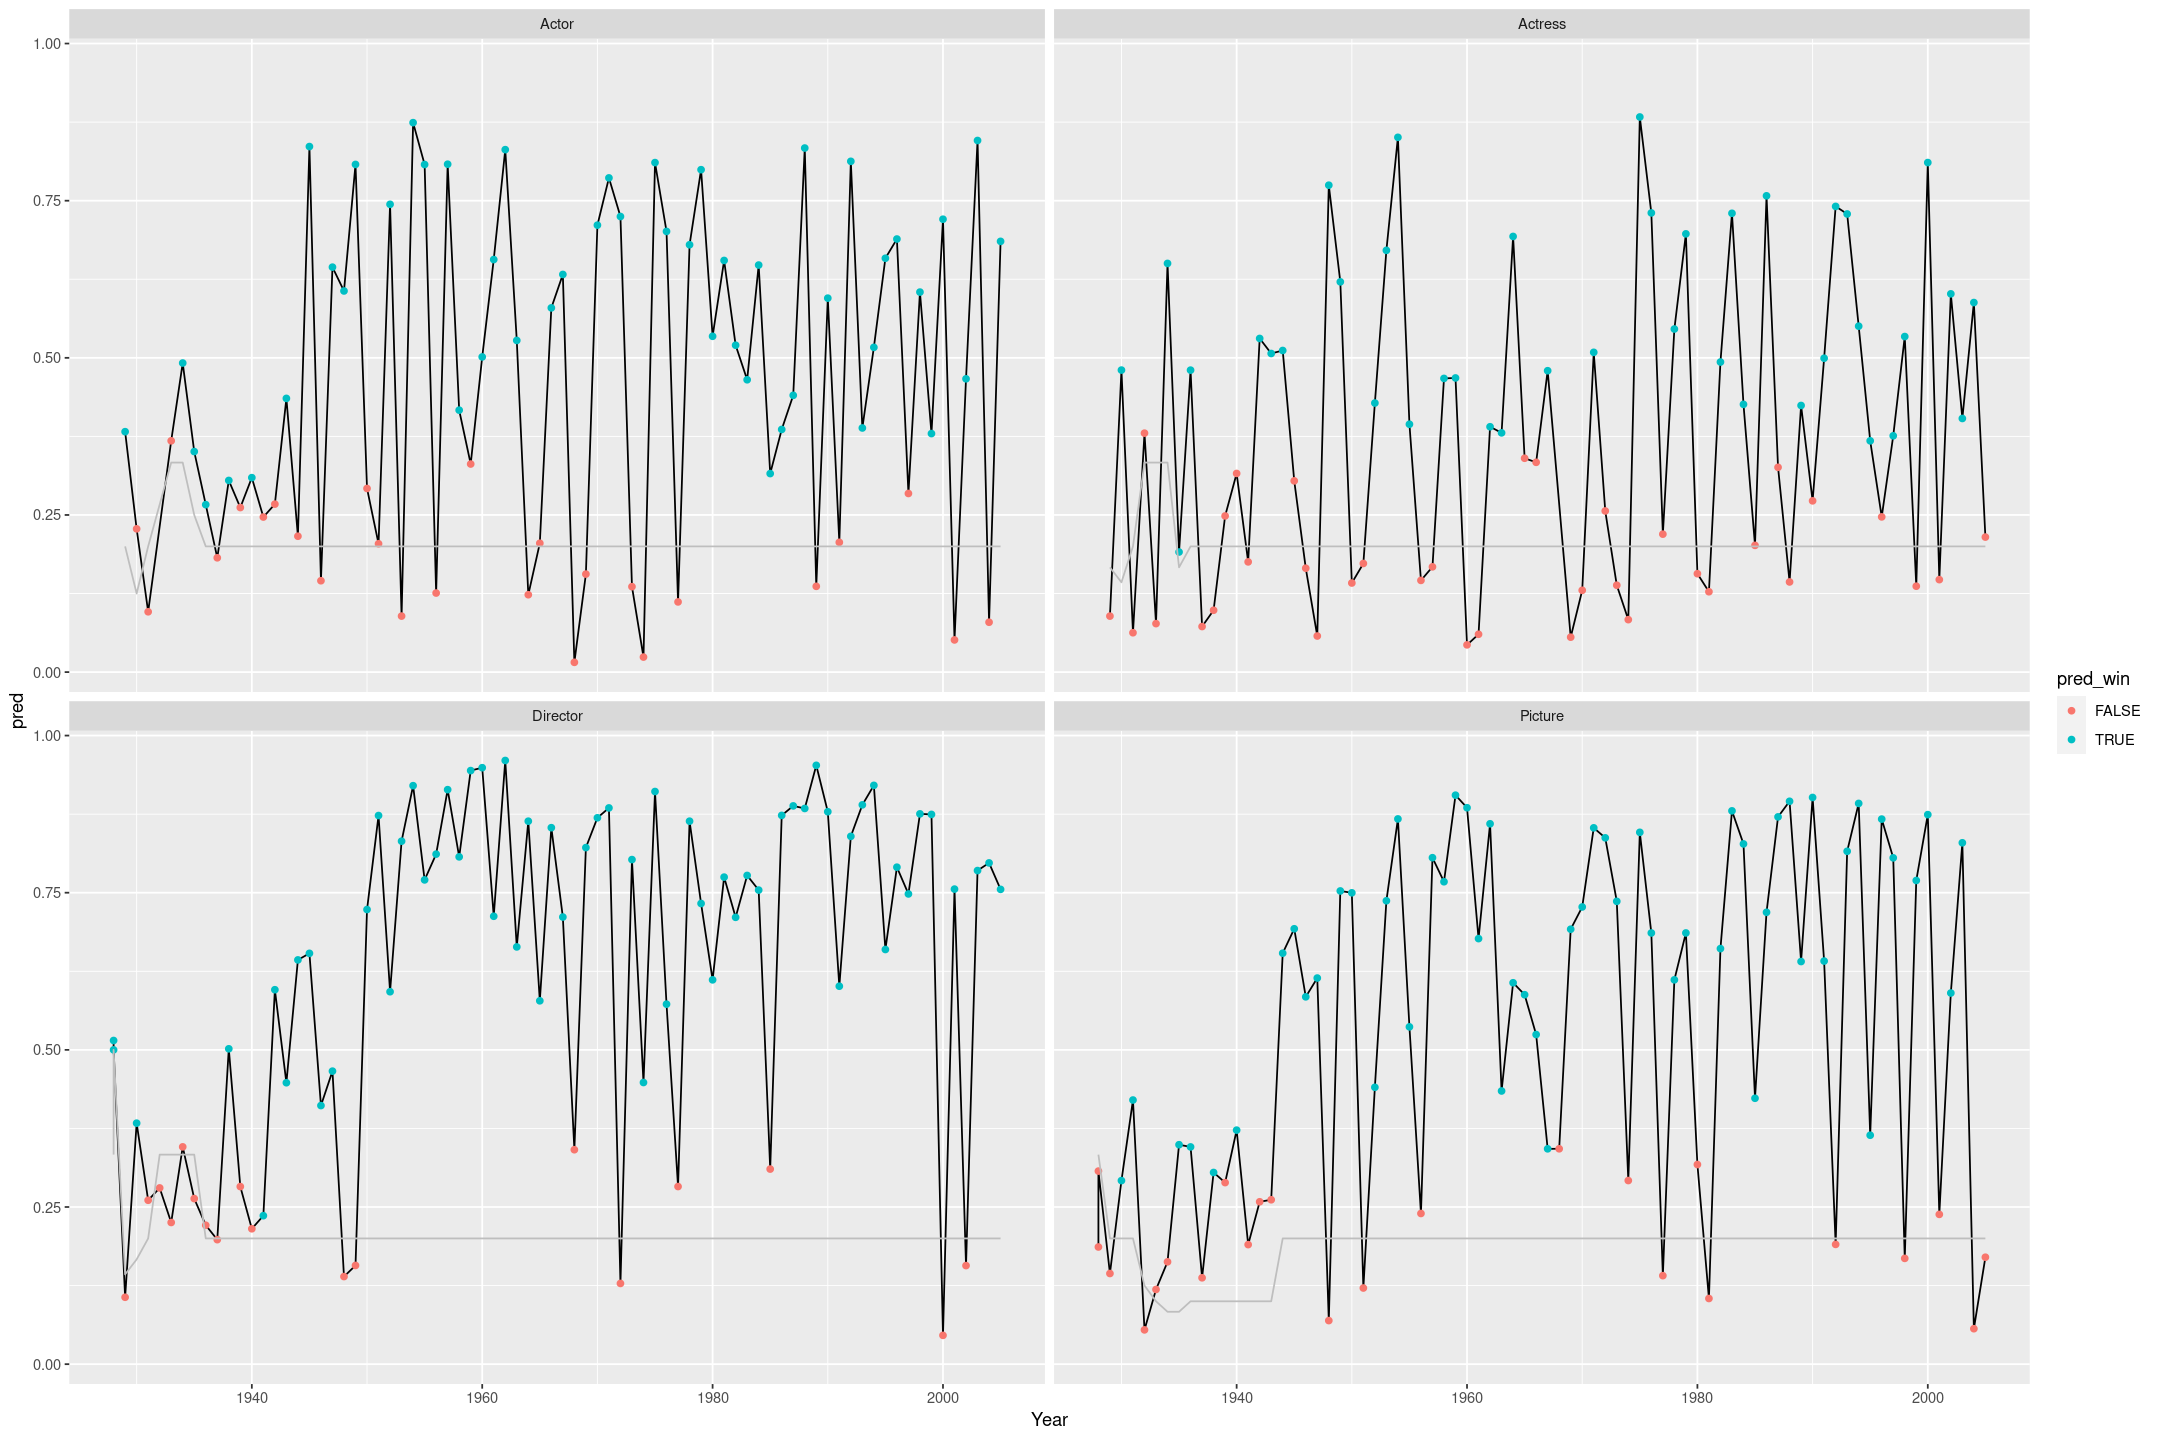

In [298]:
oscars_unique_winner %>% group_by(Comp) %>% mutate(n=n()) %>% ungroup() %>%
mutate(pred = predict(fit_oscars, newdata=oscars_unique_winner, type="response"),
       logistic_pred_raw=predict(fit_oscars_logistic, newdata=oscars_unique_winner, type="response")) %>%
group_by(Comp) %>%
mutate(logistic_pred = logistic_pred_raw / sum(logistic_pred_raw),
       pred_win = (pred == max(pred)),
       logistic_pred_win = (logistic_pred == max(logistic_pred))) %>%
ungroup() %>%
filter(win) %>%
mutate(category=case_when(PP == 1 ~ "Picture", DD == 1 ~ "Director", MM==1 ~ "Actor", FF==1 ~ "Actress")) %>%
gf_line(pred ~ Year | category) %>%
gf_point(pred ~ Year | category, col=~pred_win) %>%
gf_line(1/n ~ Year | category, col="grey")

In [299]:
x <- oscars_unique_winner %>% ungroup() %>%
mutate(category=case_when(PP == 1 ~ "Picture", DD == 1 ~ "Director", MM==1 ~ "Actor", FF==1 ~ "Actress")) %>%
mutate(pred = predict(fit_oscars, newdata=oscars_unique_winner, type="response")) %>%
group_by(Comp) %>%
filter(pred == max(pred)) 

Compare the rolling 30 year window to [Figure 1](https://iainpardoe.com/tech/07significance.pdf) - we do worse in earlier years than their model.
However in recent years our model compares favourably to theirs (on the training set!)

Adding missing grouping variables: `category`



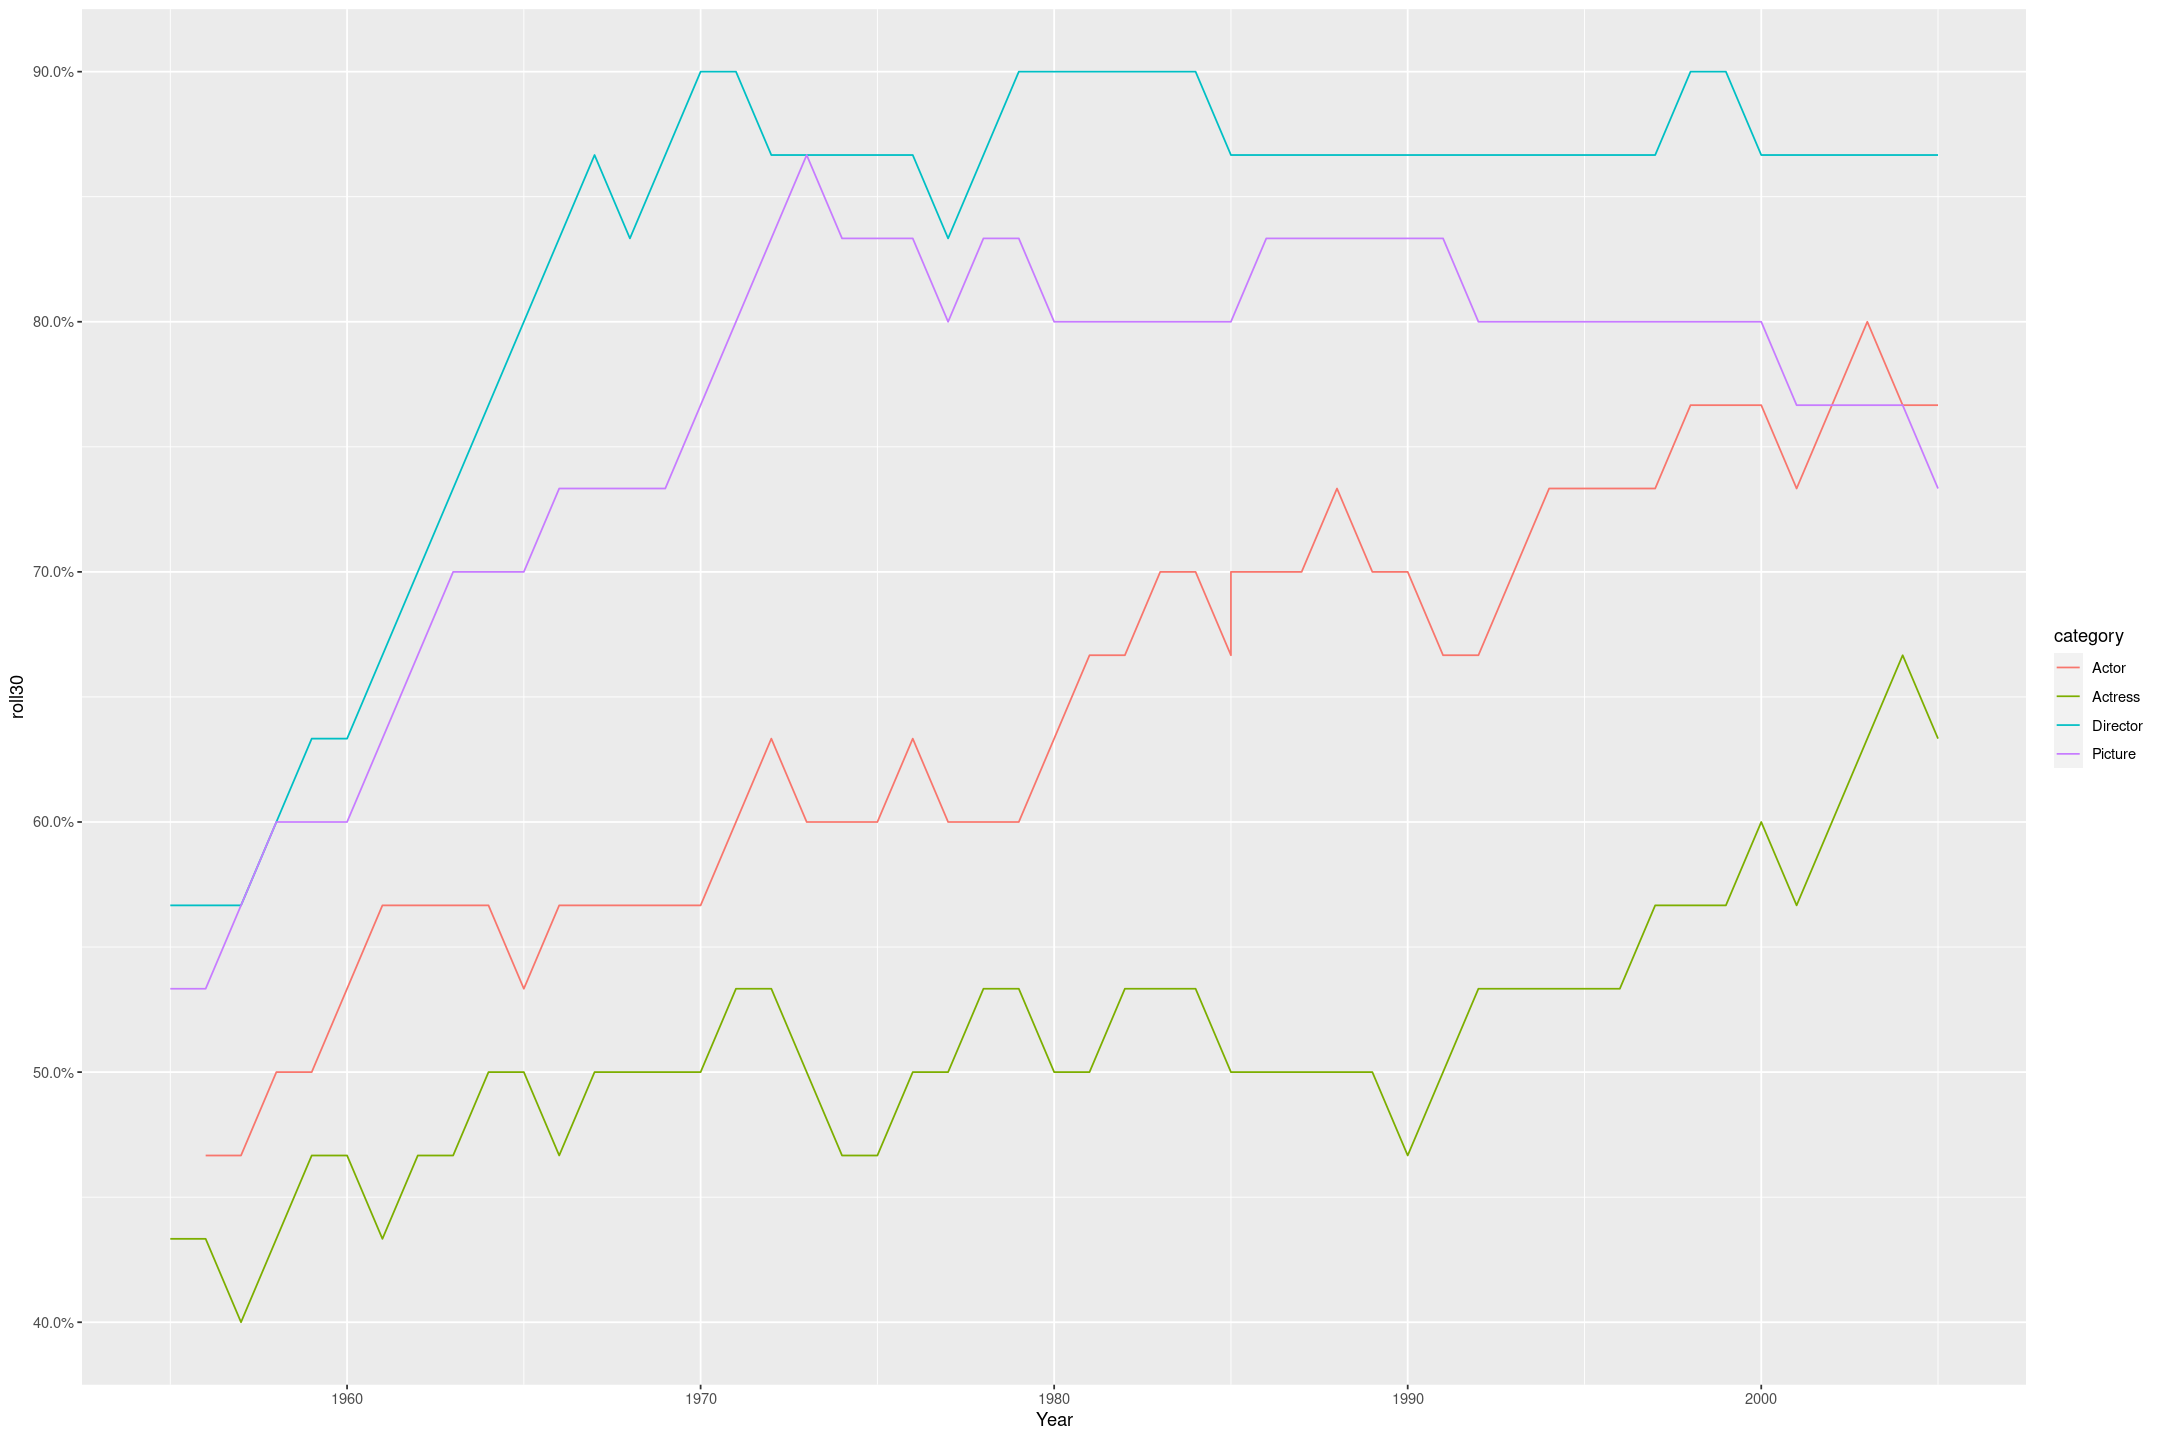

In [300]:
x %>% group_by(category) %>% select(win, Year) %>% 
arrange(Year) %>%
mutate(roll30=c(rep(NA, 30-1), RcppRoll::roll_mean(win, 30))) %>%
drop_na() %>%
gf_line(roll30 ~ Year, col=~category) +
scale_y_continuous(labels = scales::percent)

We can look at some of the worst performers in our training set.

In [301]:
oscars_unique_winner %>% group_by(Comp) %>% mutate(n=n()) %>% ungroup() %>%
mutate(pred = predict(fit_oscars, newdata=oscars_unique_winner, type="response")) %>%
filter(win) %>%
arrange(pred) %>%
select(Year, Name, Movie, pred) %>%
head()

Year Name       Movie       pred      
1 1968 Robertson  Charly      0.01553005
2 1974 Carney     Harry       0.02390376
3 1960 Taylor     Butterfield 0.04333168
4 2000 Soderbergh Traffic     0.04579972
5 2001 Washington Training    0.05118825
6 1932 Grand      Grand       0.05452289

This barely scratches the surface - it would be a really good exercise to build a very high performing model, and a very sparse model (and try different modeling approaches).

# Model checking for count data

The folder `RiskyBehaviour` contains data from a study of behaviour of couples at risk for HIV.

## Simulating counts in Poisson regression

Fit a Poisson regression predicting number of unprotected sex acts from baseline HIV status.
Perform predictive simulation to generate 1000 datasets and record the percentage of observations that are equal to 0 and the percentage that are greater than 10 (the third quartile in the observed data) for each.
Compare these to the observed value in the original data.

In [302]:
risky %>% head()

sex   couples women_alone bs_hiv   bupacts fupacts acts bupacts_std
1 woman 0       1           negative  7      32      32   -0.29623035
2 woman 0       0           negative  2       5       5   -0.37455615
3 woman 0       0           positive  0      15      15   -0.40588647
4 woman 0       0           negative 24       9       9   -0.02992262
5 woman 1       0           negative  2       2       2   -0.37455615
6 woman 1       0           negative 15       4       4   -0.17090906

In [303]:
fit_risky_p_hiv <- stan_glm(acts ~ bs_hiv, family=poisson(link="log"), data=risky)

In [304]:
pct_risky_eq0 = apply(posterior_predict(fit_risky_p_hiv, draws=1000) == 0, 1, mean)

In [305]:
pct_risky_gt10 = apply(posterior_predict(fit_risky_p_hiv, draws=1000) > 10, 1, mean)

We're nowhere near the data!

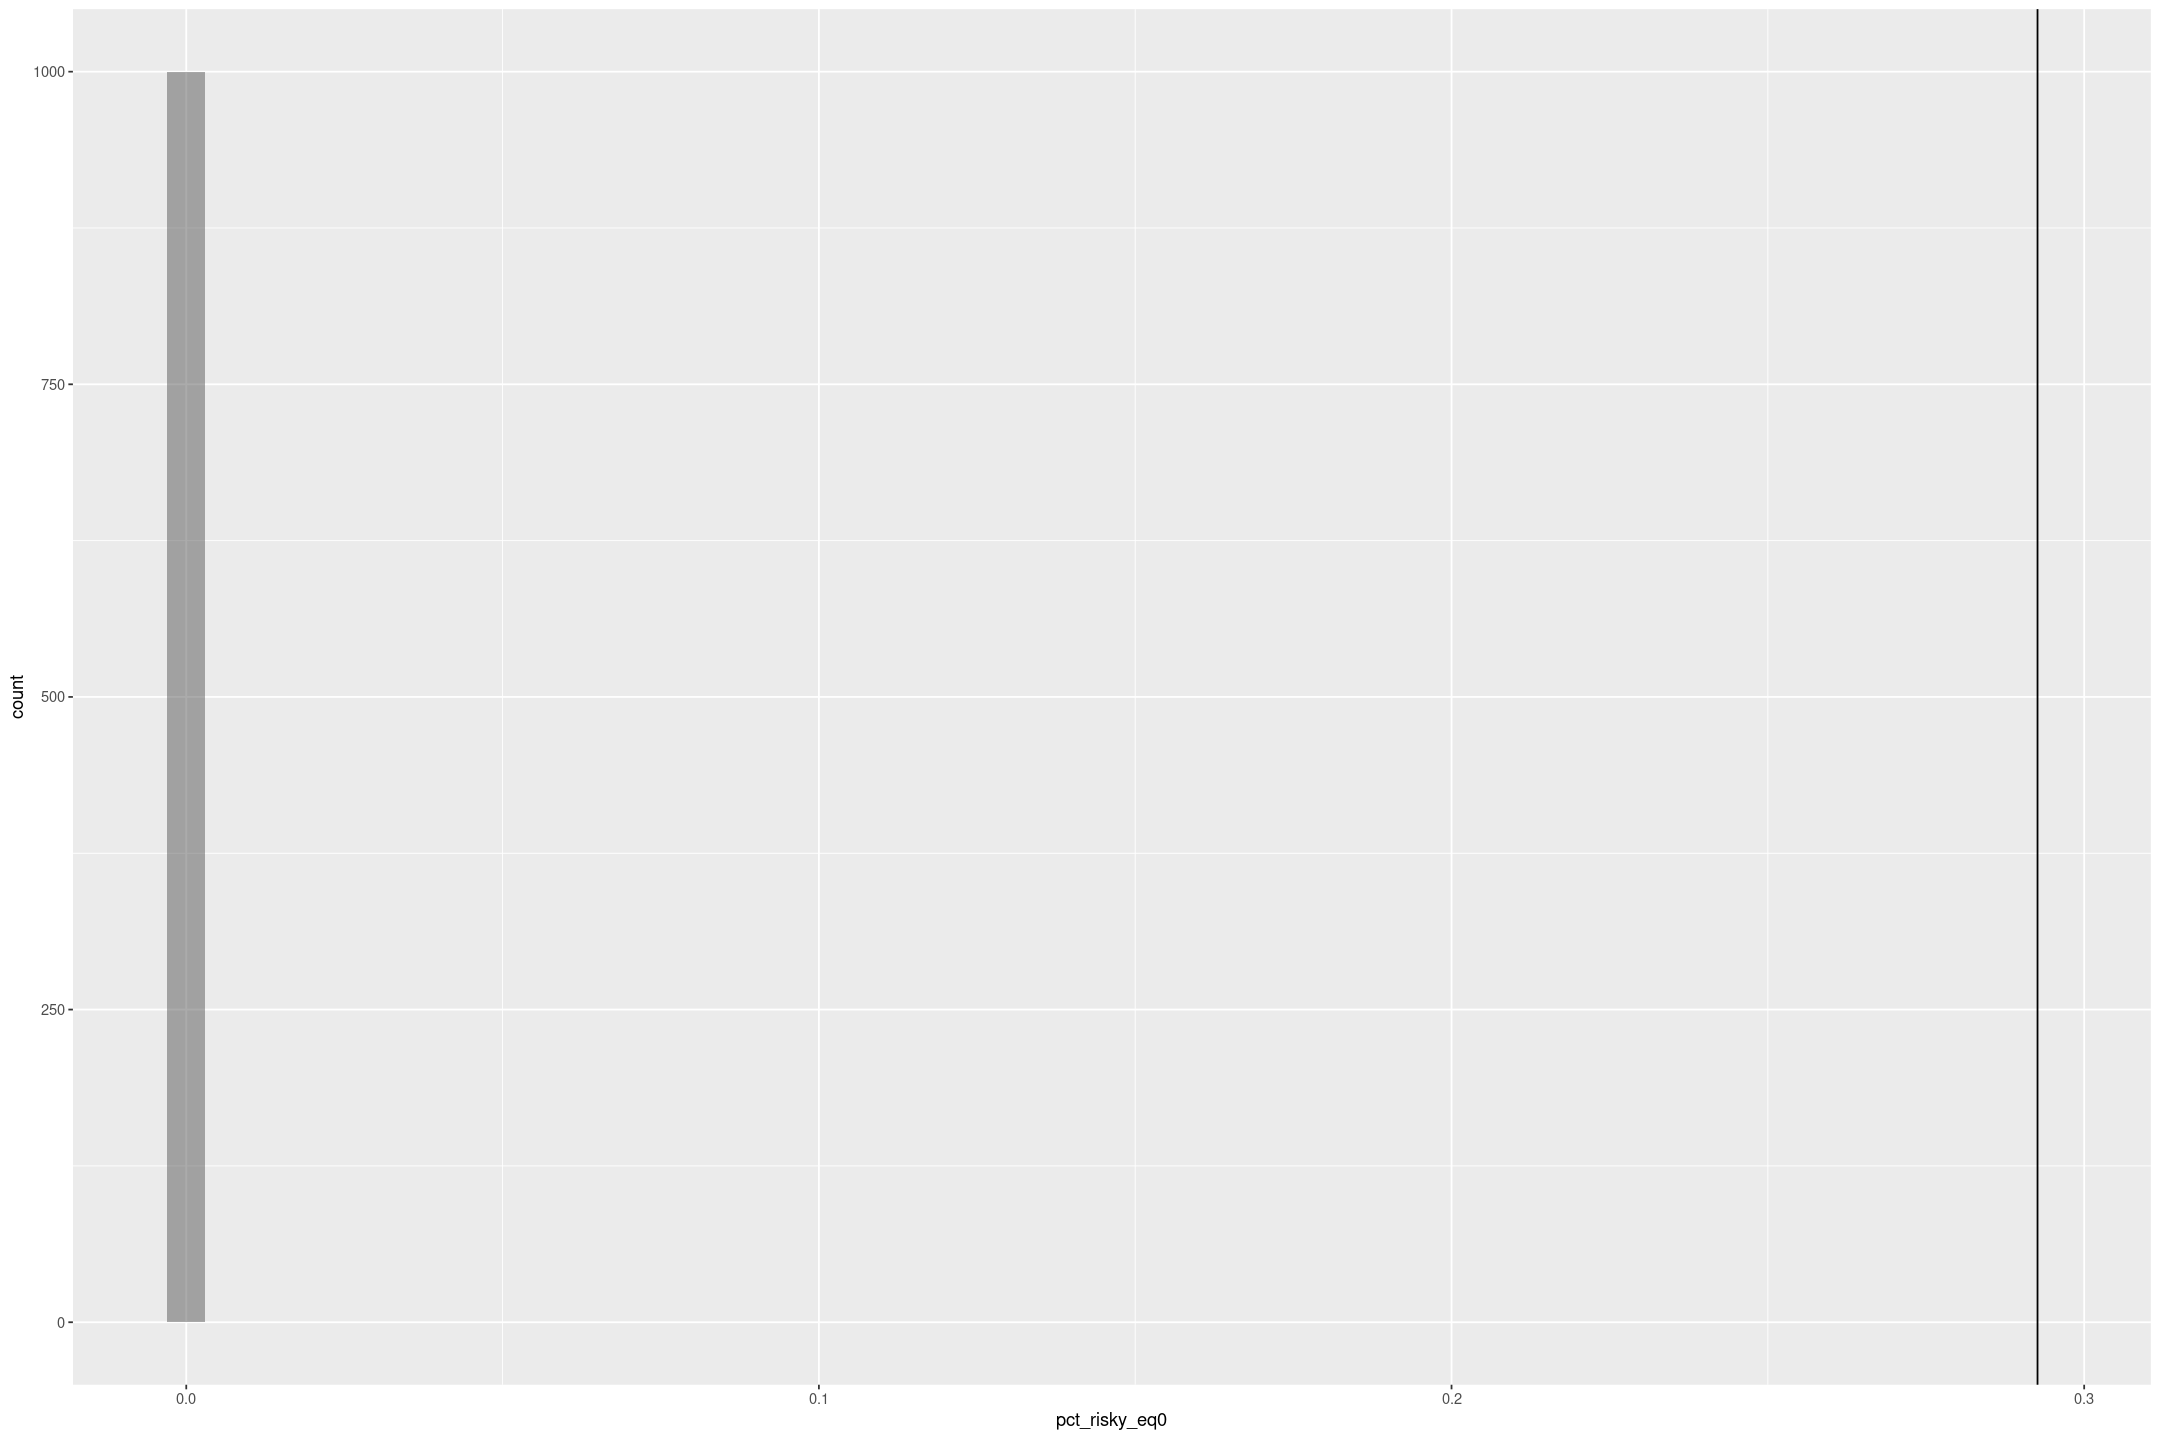

In [306]:
gf_histogram(~pct_risky_eq0, bins=50) %>%
gf_vline(xintercept=~mean(risky$acts==0))

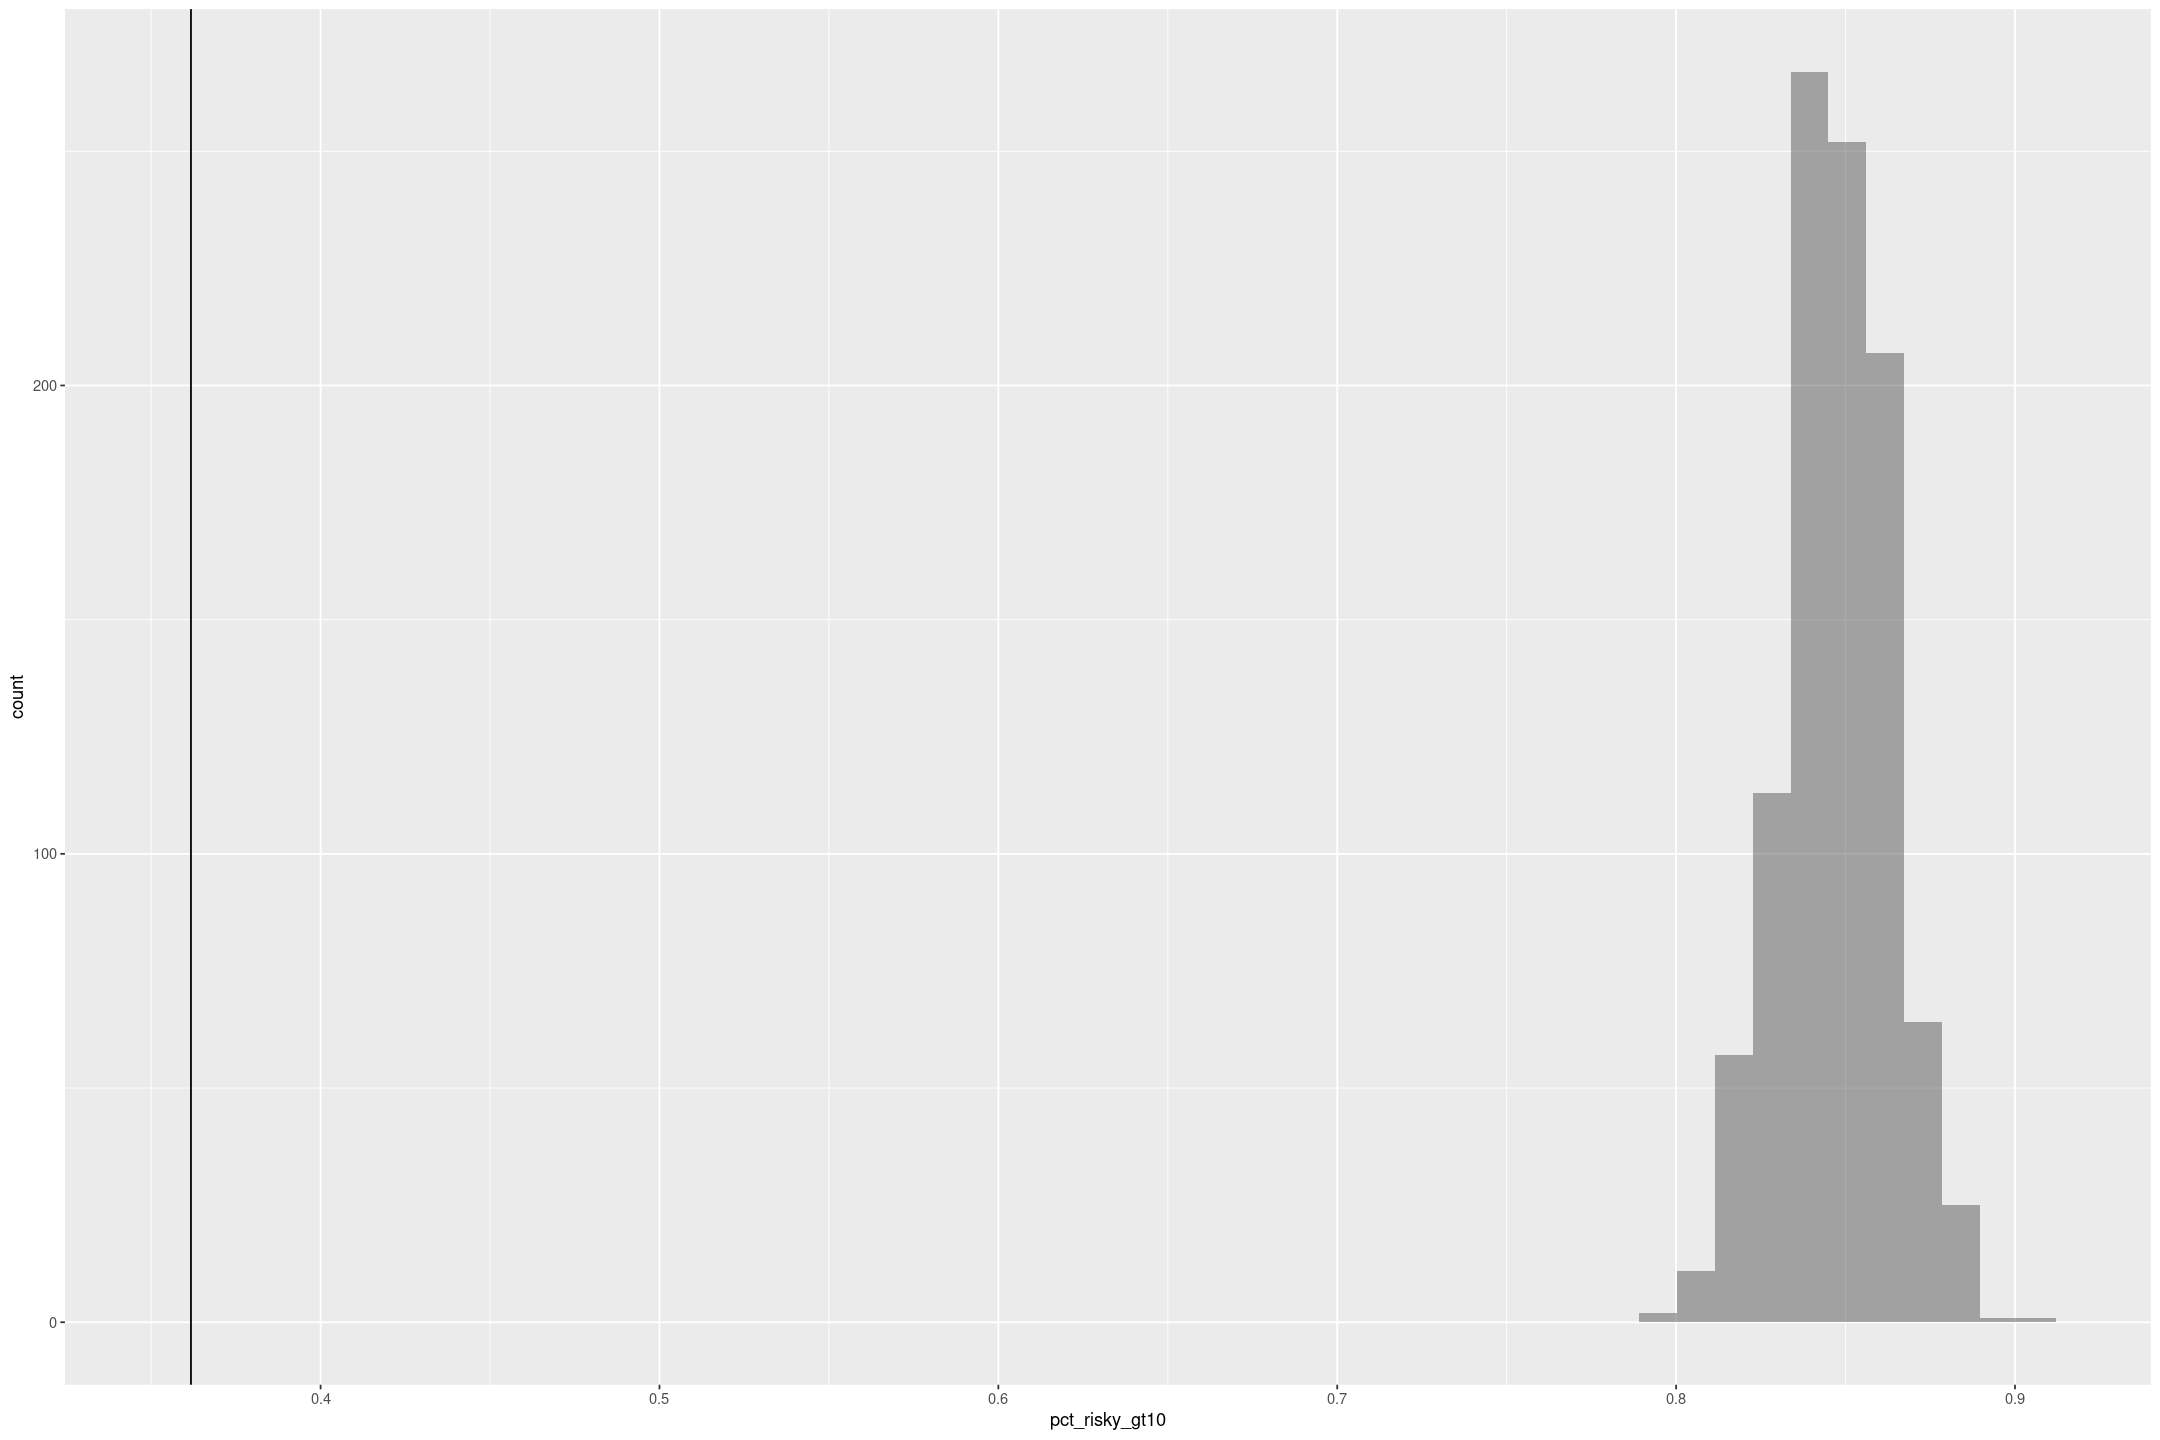

In [307]:
gf_histogram(~pct_risky_gt10, bins=50) %>%
gf_vline(xintercept=~mean(risky$acts>10))

## Simulating counts in Negative Binomial regression

Repeat using a negative binomial (overdispersed Poisson) regression.

In [308]:
fit_risky_nb_hiv <- stan_glm(acts ~ bs_hiv, family=neg_binomial_2, data=risky)

In [309]:
pct_risky_eq0 = apply(posterior_predict(fit_risky_nb_hiv, draws=1000) == 0, 1, mean)

In [310]:
pct_risky_gt10 = apply(posterior_predict(fit_risky_nb_hiv, draws=1000) > 10, 1, mean)

The data lies somehwere in the region! It looks plausible.

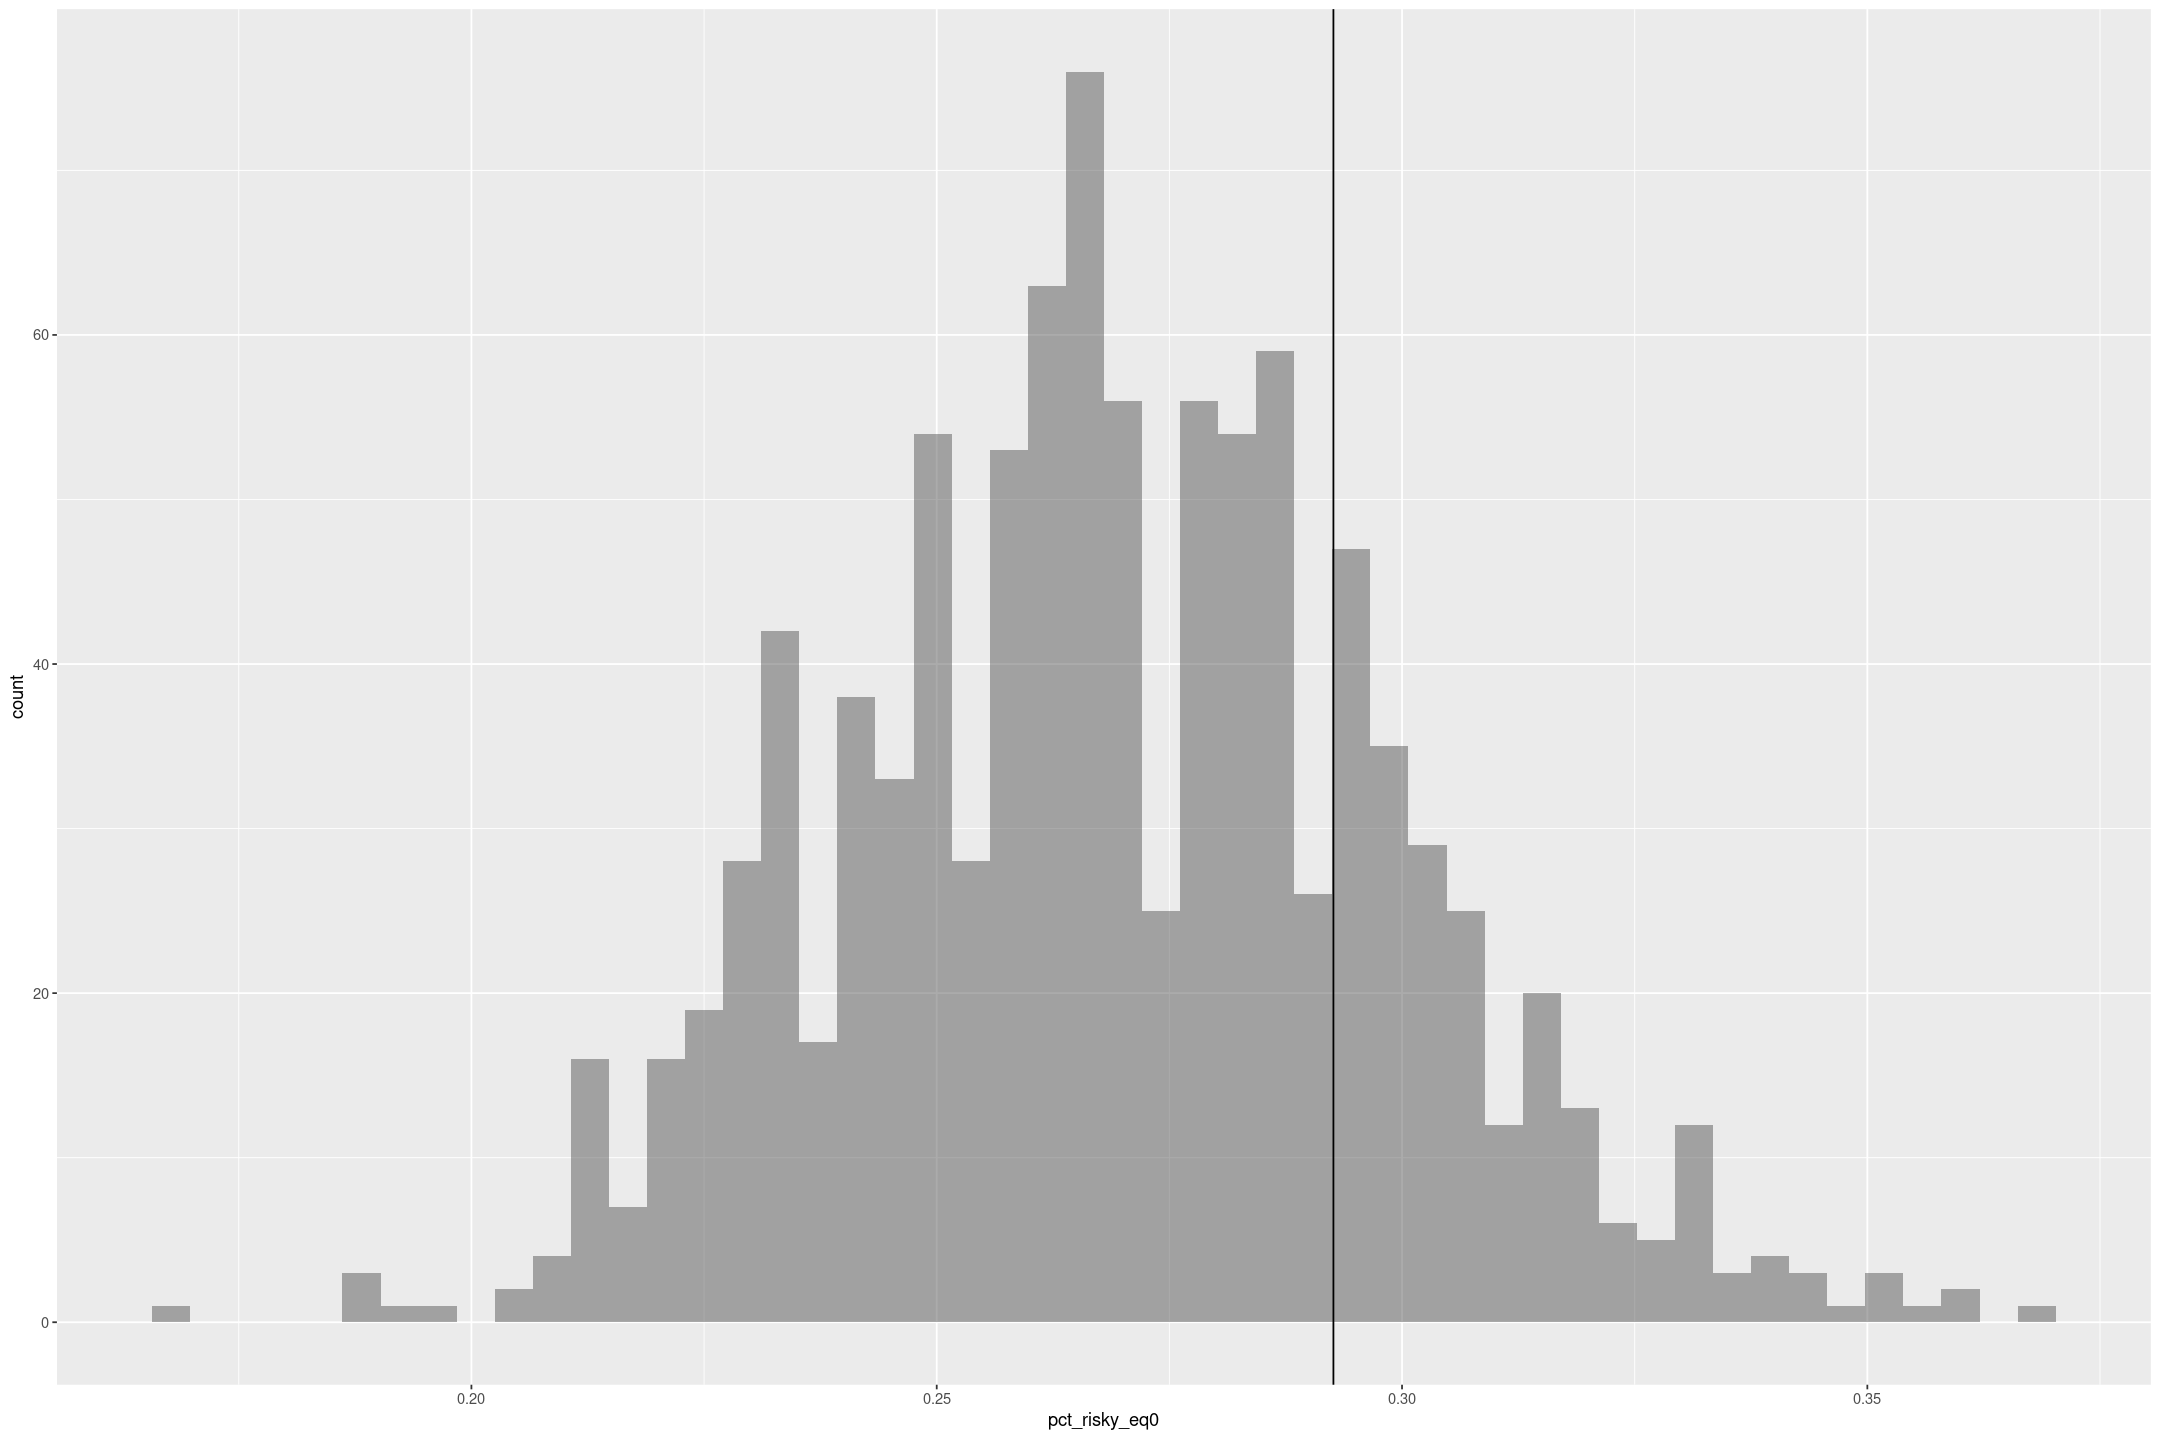

In [311]:
gf_histogram(~pct_risky_eq0, bins=50) %>%
gf_vline(xintercept=~mean(risky$acts==0))

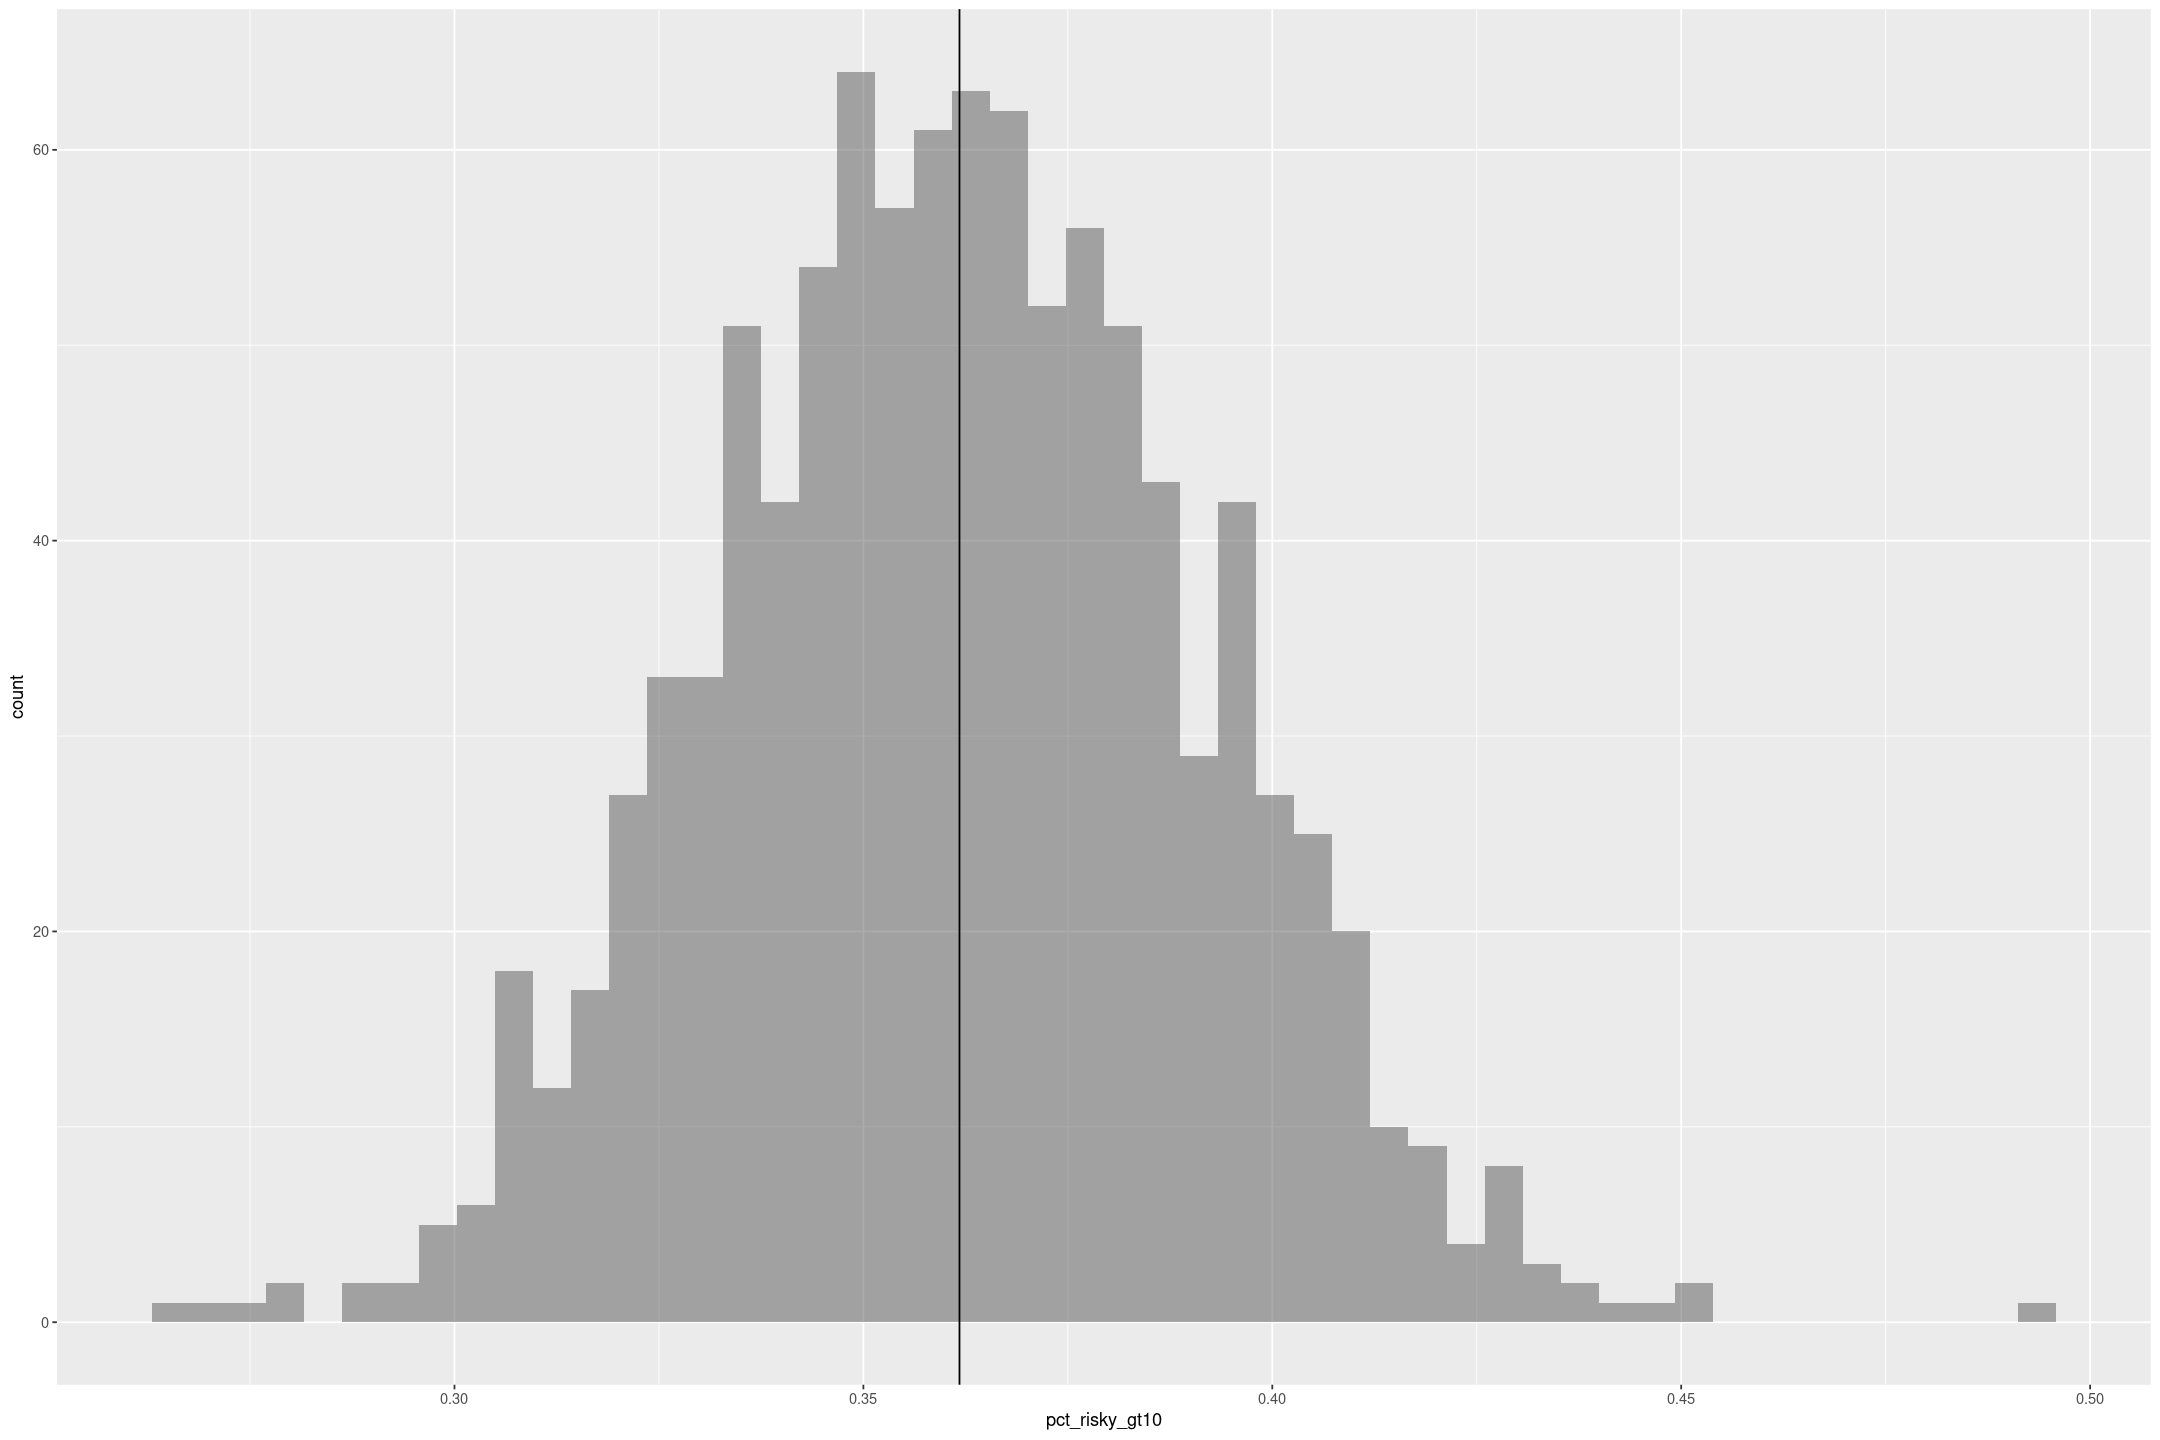

In [312]:
gf_histogram(~pct_risky_gt10, bins=50) %>%
gf_vline(xintercept=~mean(risky$acts>10))

## Adding predictors

Repeat also including ethnicity and baseline number of unprotected sex acts as inputs.

### Poisson

Ethnicity isn't in the data, but let's use what we have.

In [313]:
fit_risky_pre <- stan_glm(acts  ~ couples + women_alone + bupacts_std + bs_hiv , family=poisson(link="log"), data=risky)

In [314]:
pct_risky_eq0 = apply(posterior_predict(fit_risky_pre, draws=1000) == 0, 1, mean)

In [315]:
pct_risky_gt10 = apply(posterior_predict(fit_risky_pre, draws=1000) > 10, 1, mean)

Adding predictors does not help the Poisson model.

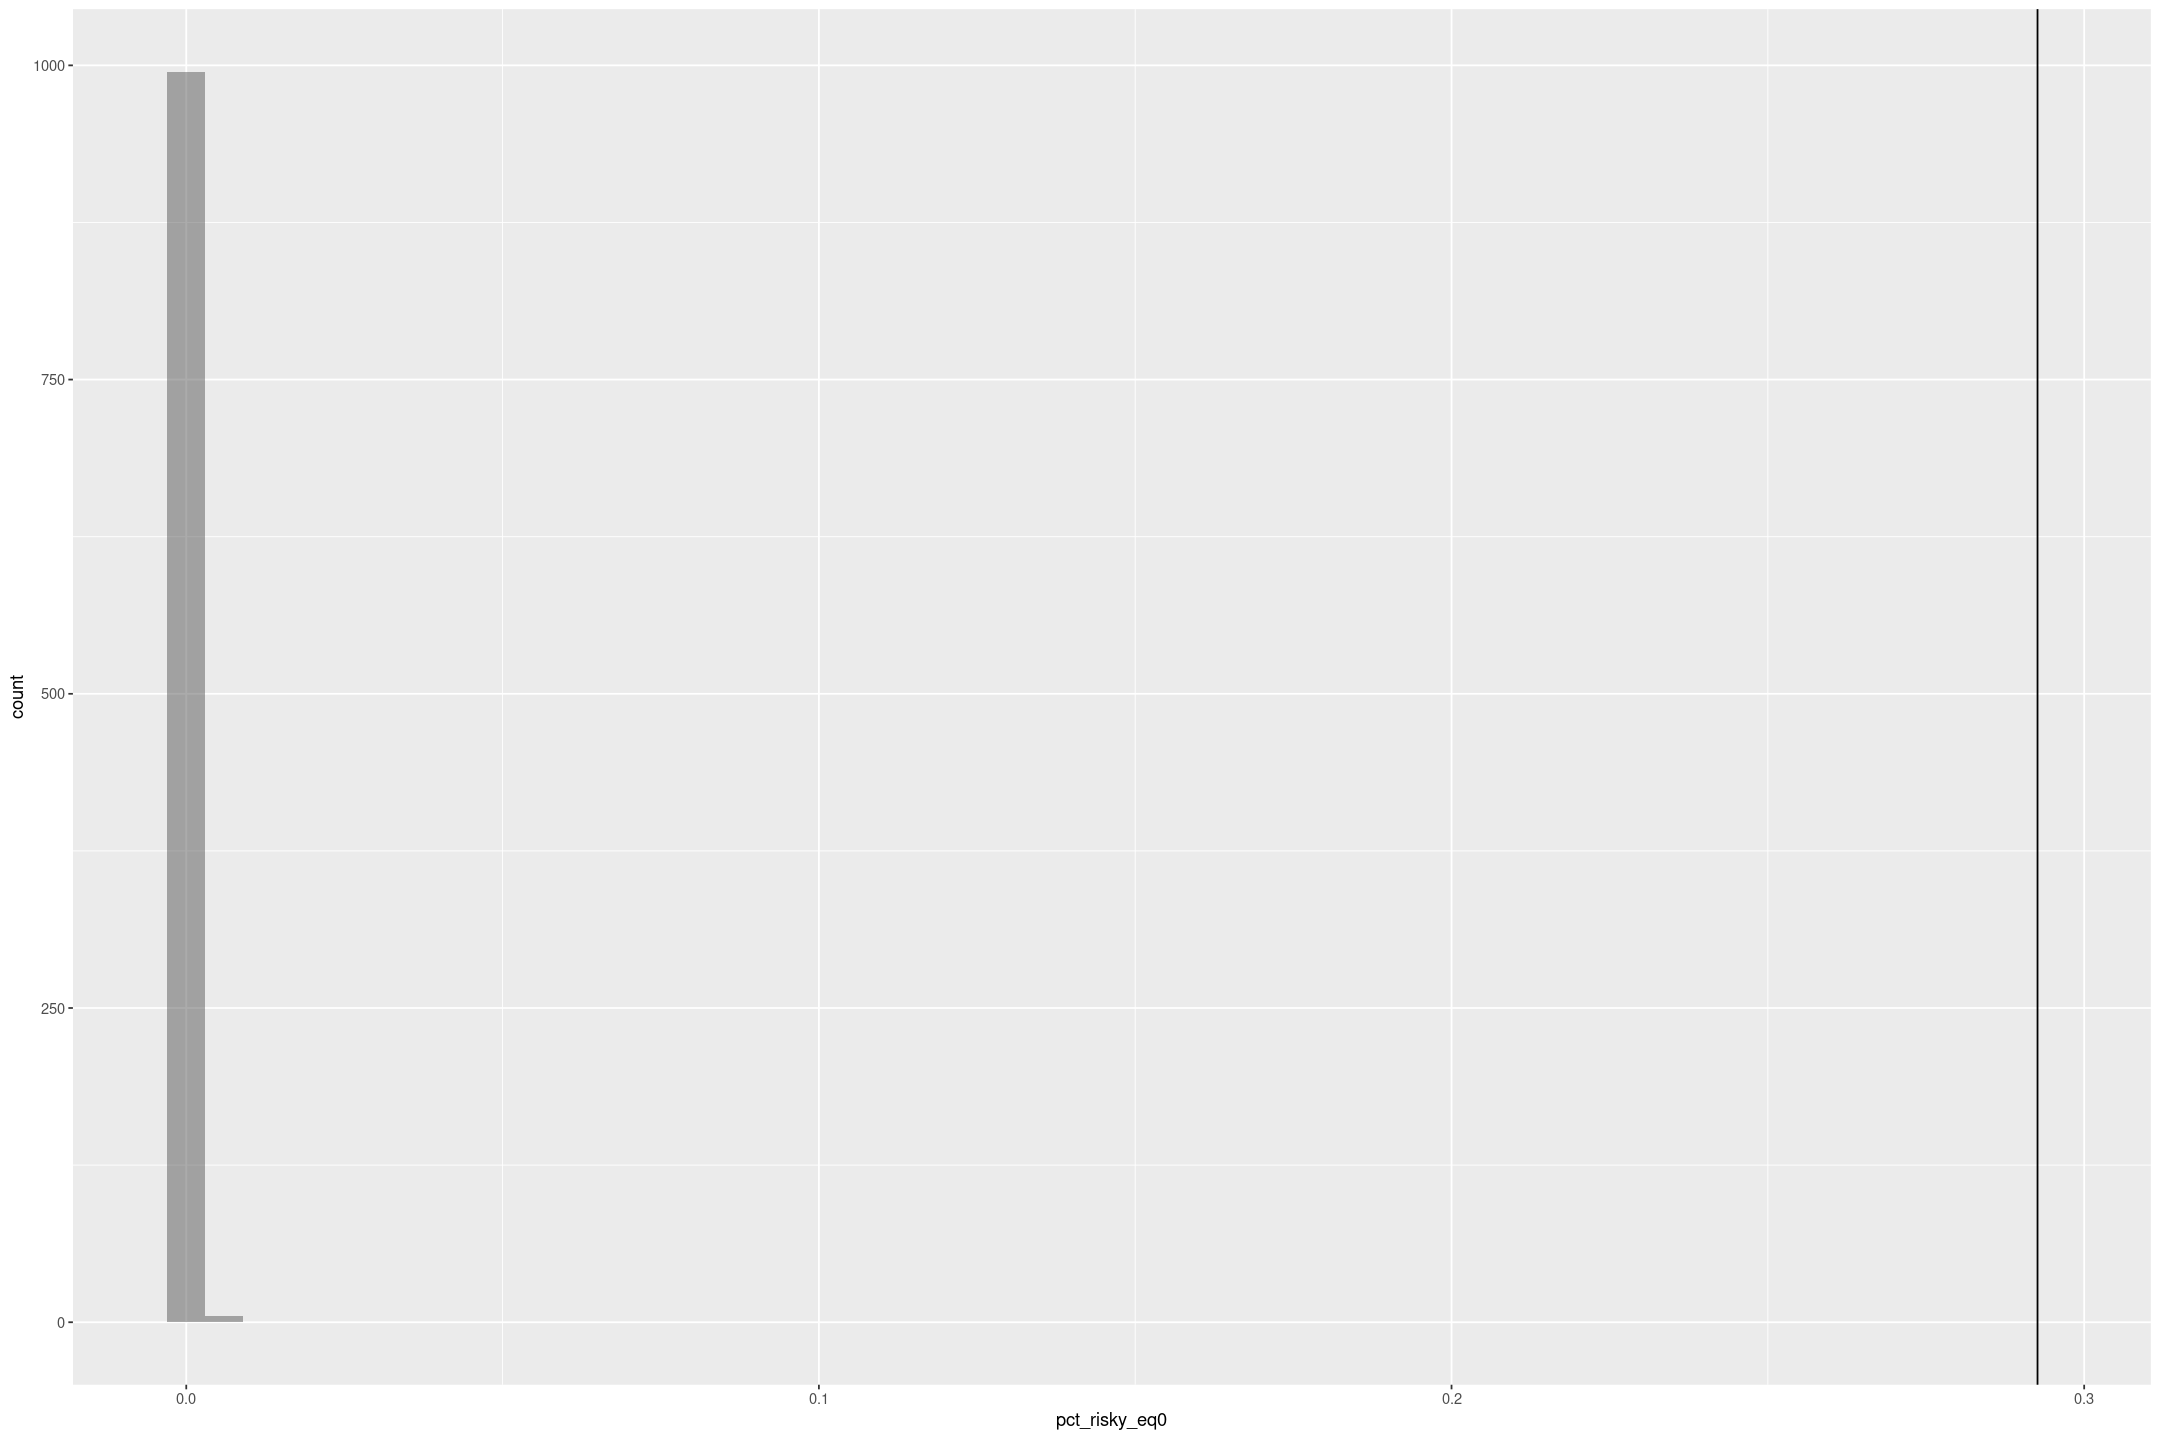

In [316]:
gf_histogram(~pct_risky_eq0, bins=50) %>%
gf_vline(xintercept=~mean(risky$acts==0))

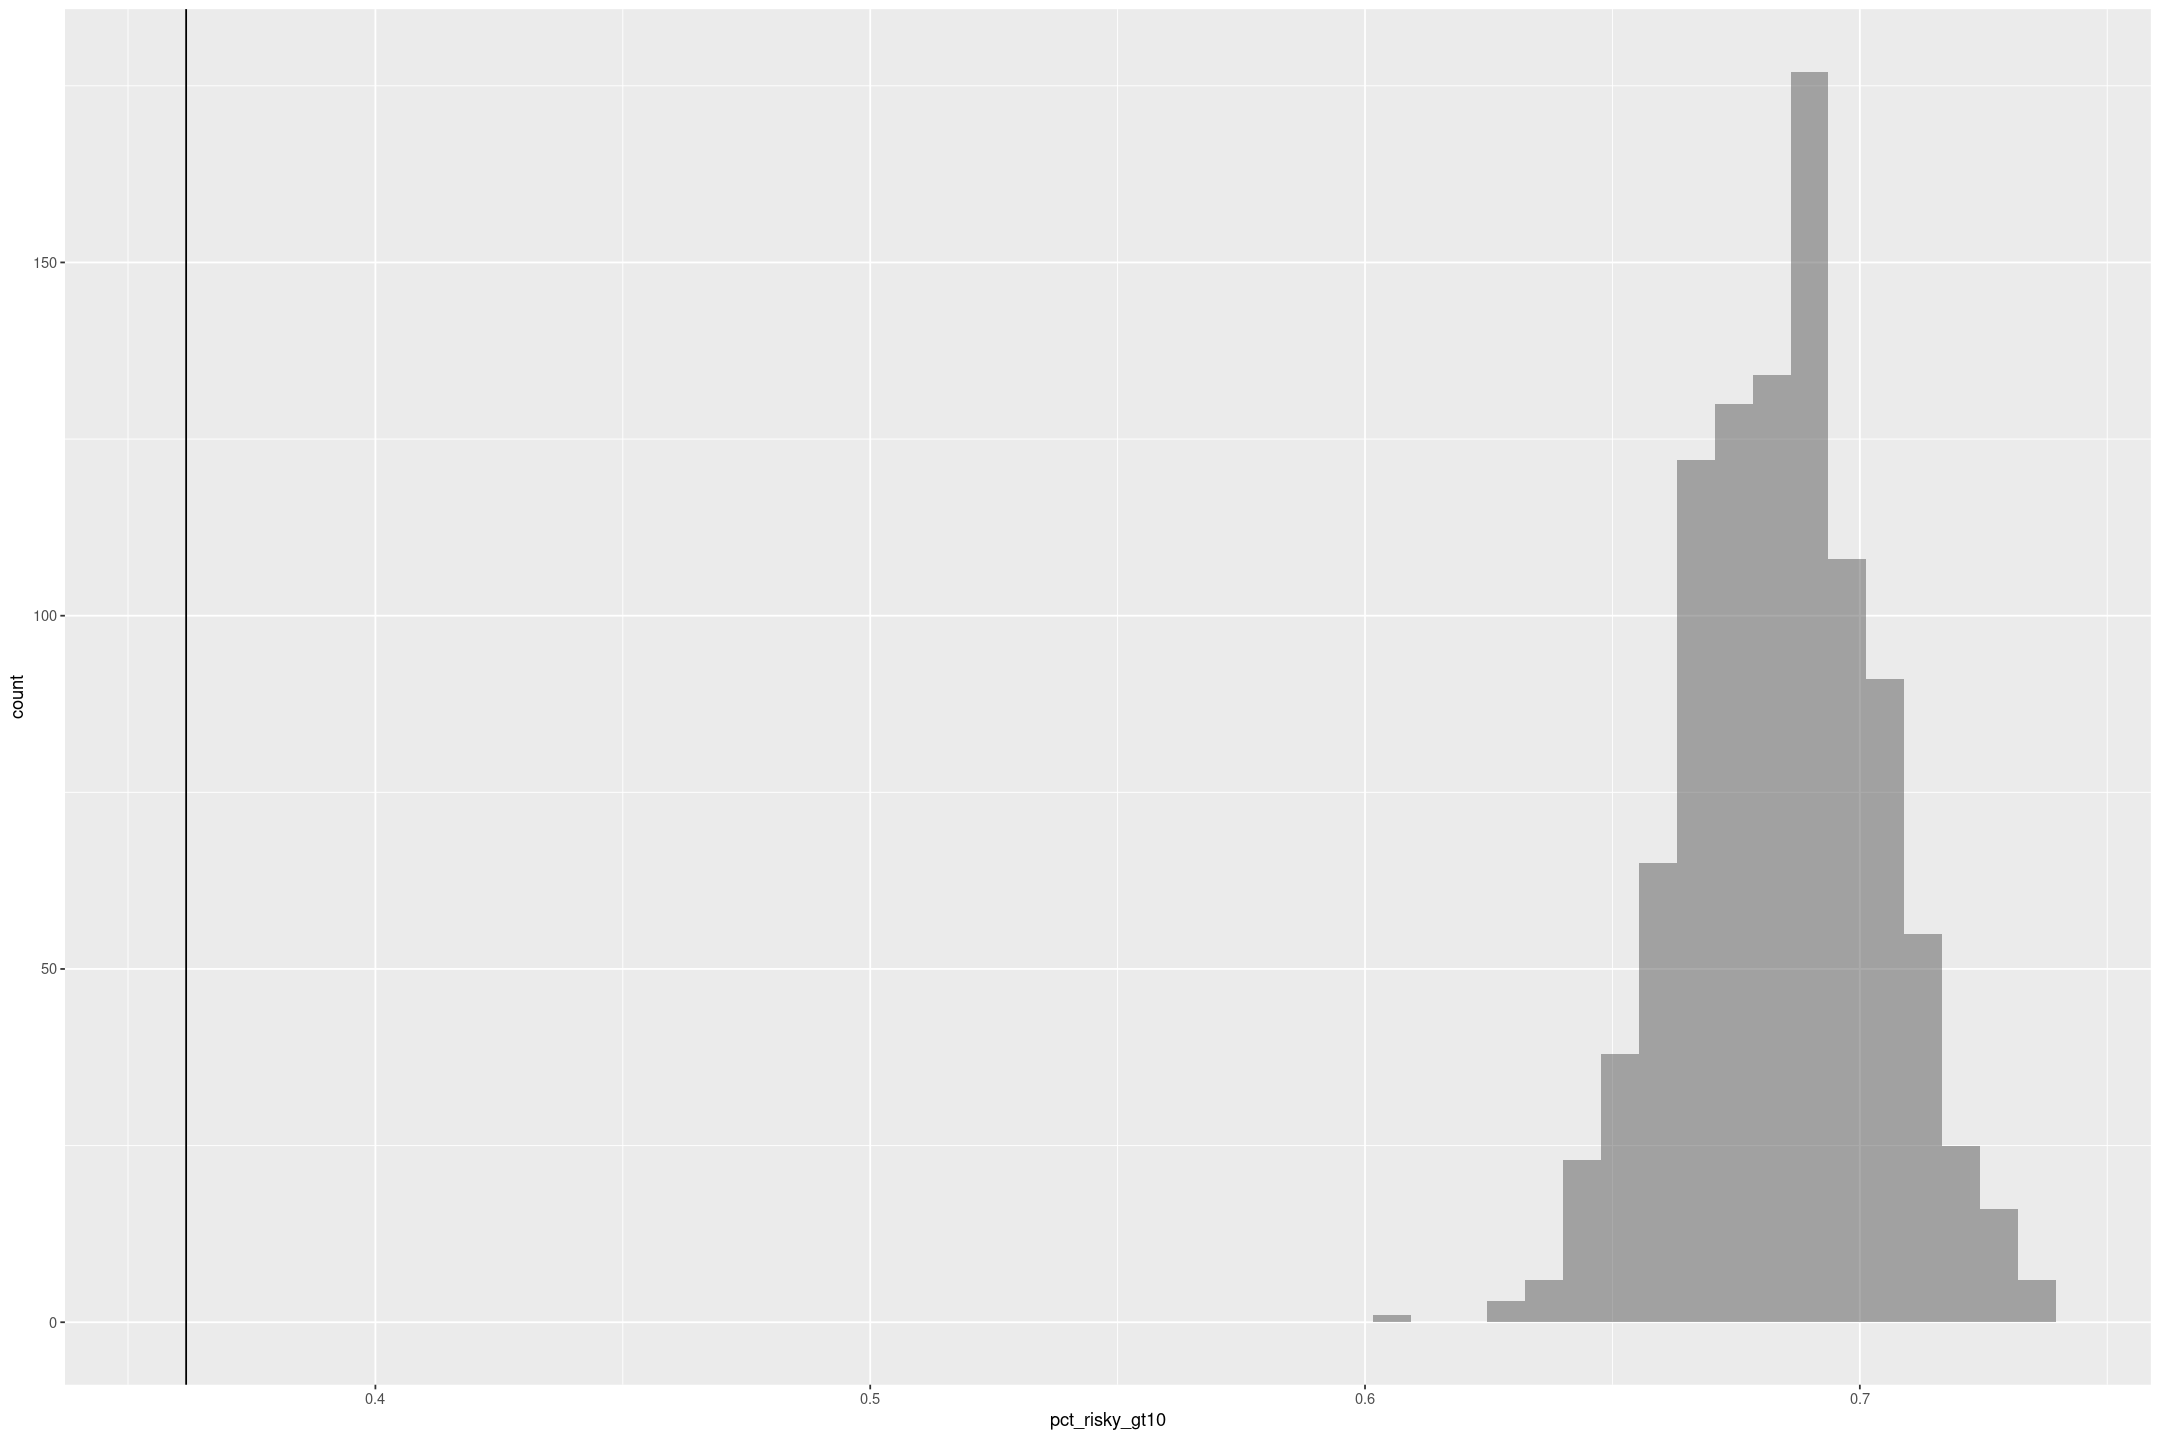

In [317]:
gf_histogram(~pct_risky_gt10, bins=50) %>%
gf_vline(xintercept=~mean(risky$acts>10))

### Negative Binomial

Ethnicity isn't in the data, but let's use what we have.

In [318]:
fit_risky_pre_nb <- stan_glm(acts  ~ couples + women_alone + bupacts_std + bs_hiv , family=neg_binomial_2, data=risky)

In [319]:
pct_risky_eq0 = apply(posterior_predict(fit_risky_pre_nb, draws=1000) == 0, 1, mean)

In [320]:
pct_risky_gt10 = apply(posterior_predict(fit_risky_pre_nb, draws=1000) > 10, 1, mean)

And doesn't impact the distribution of the negative binomial too much either.

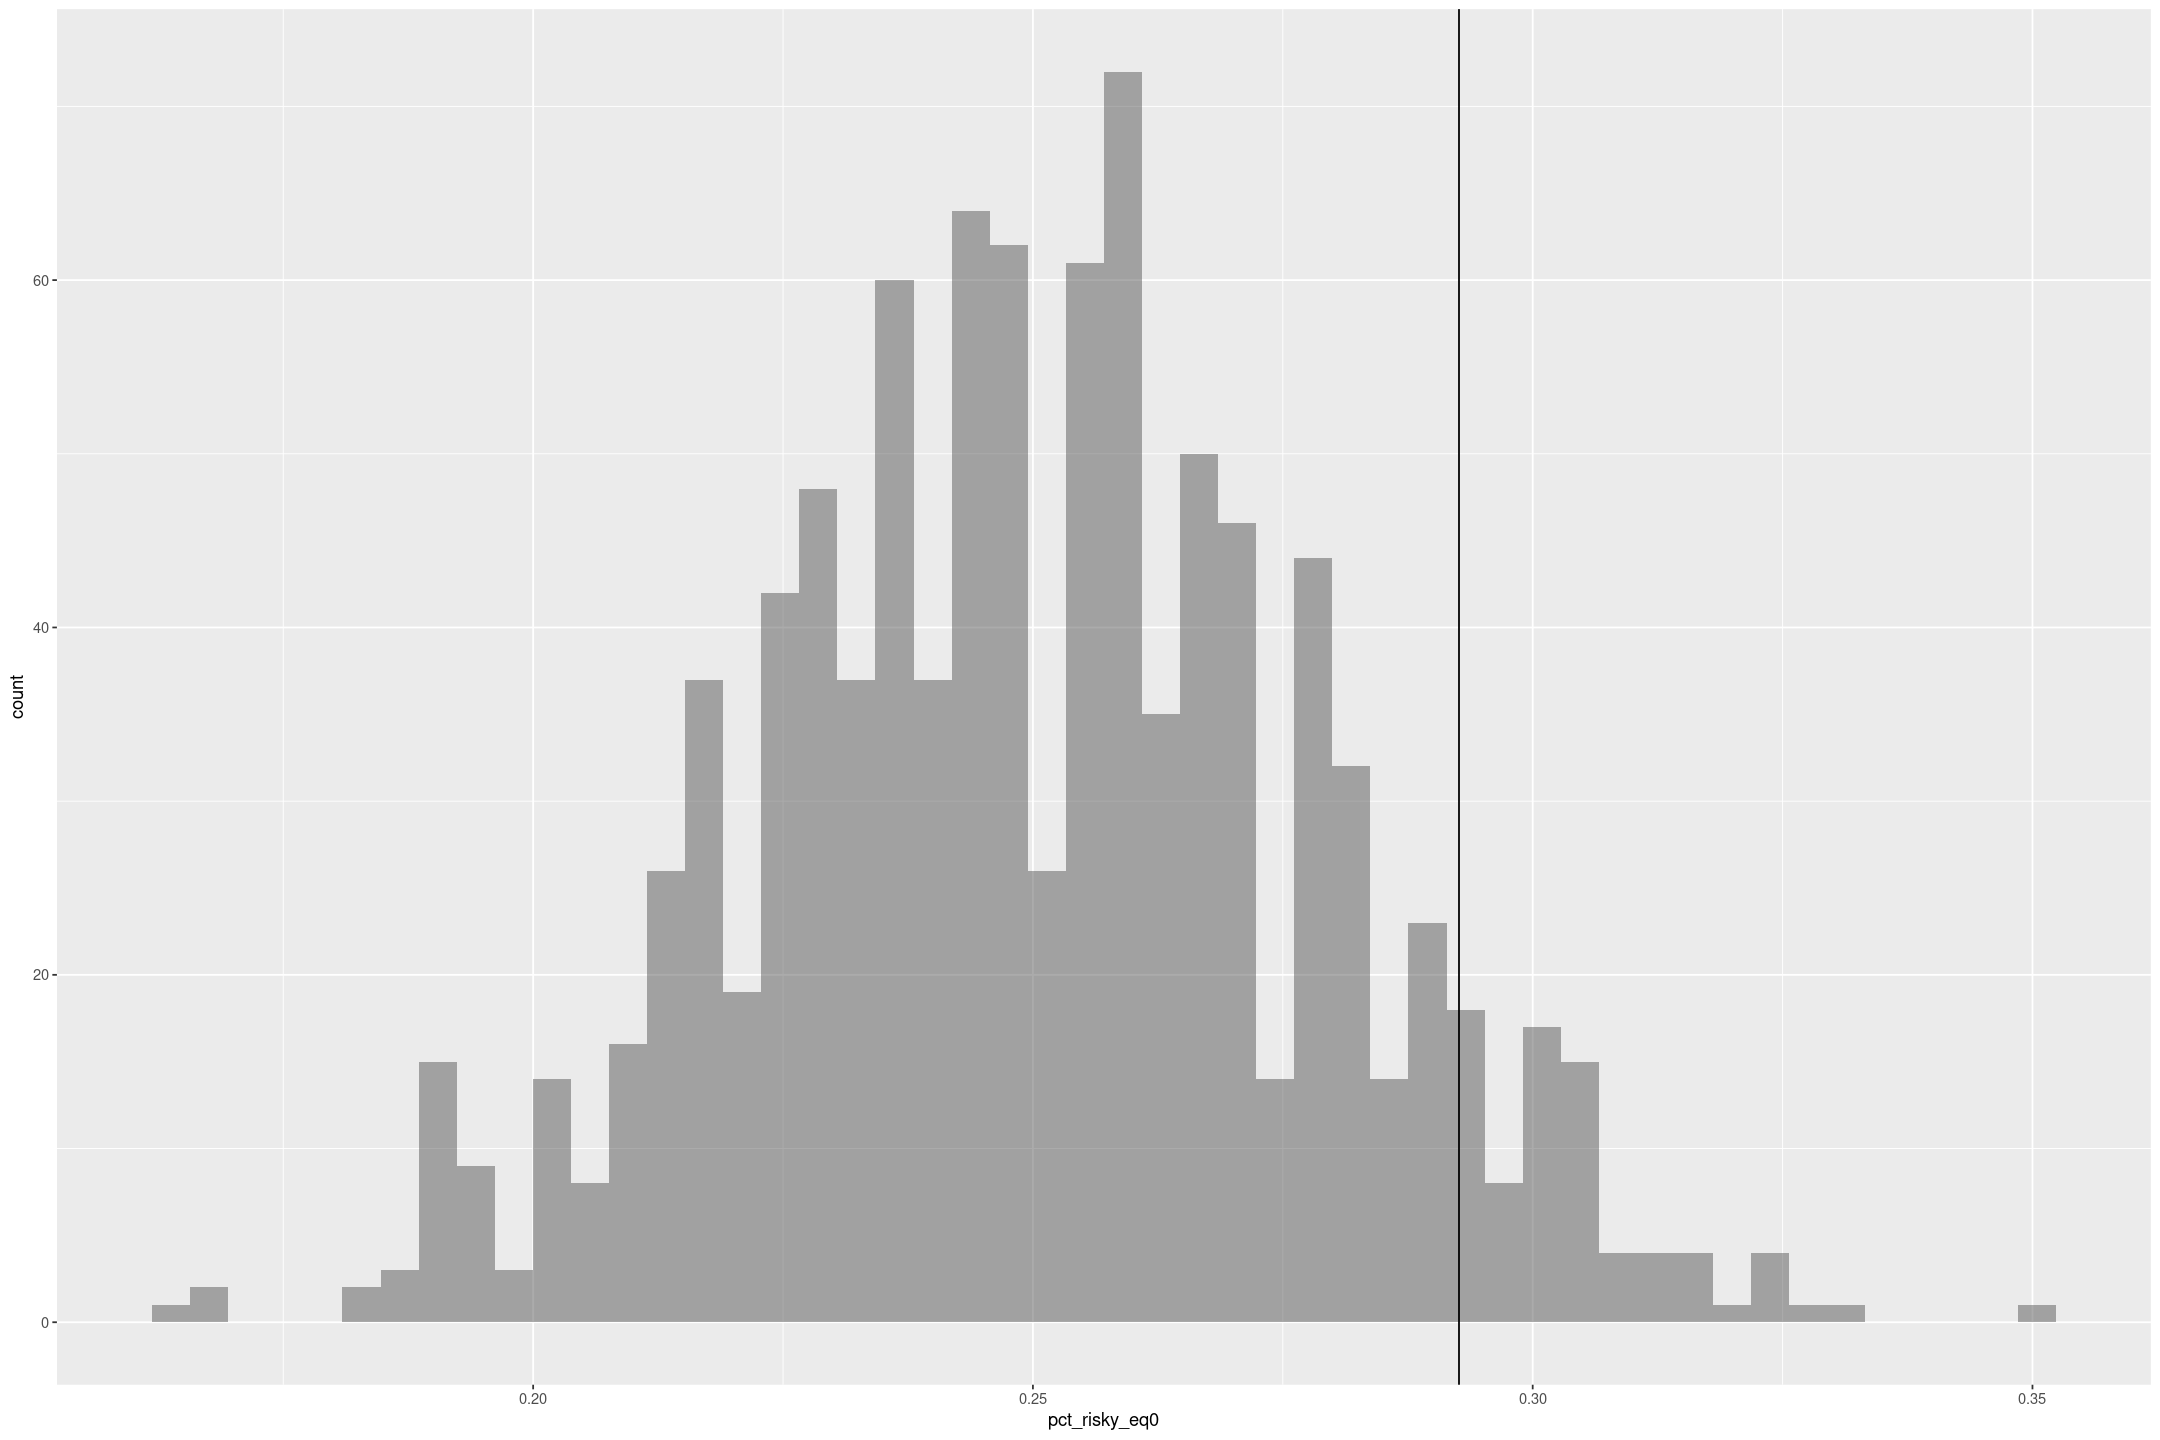

In [321]:
gf_histogram(~pct_risky_eq0, bins=50) %>%
gf_vline(xintercept=~mean(risky$acts==0))

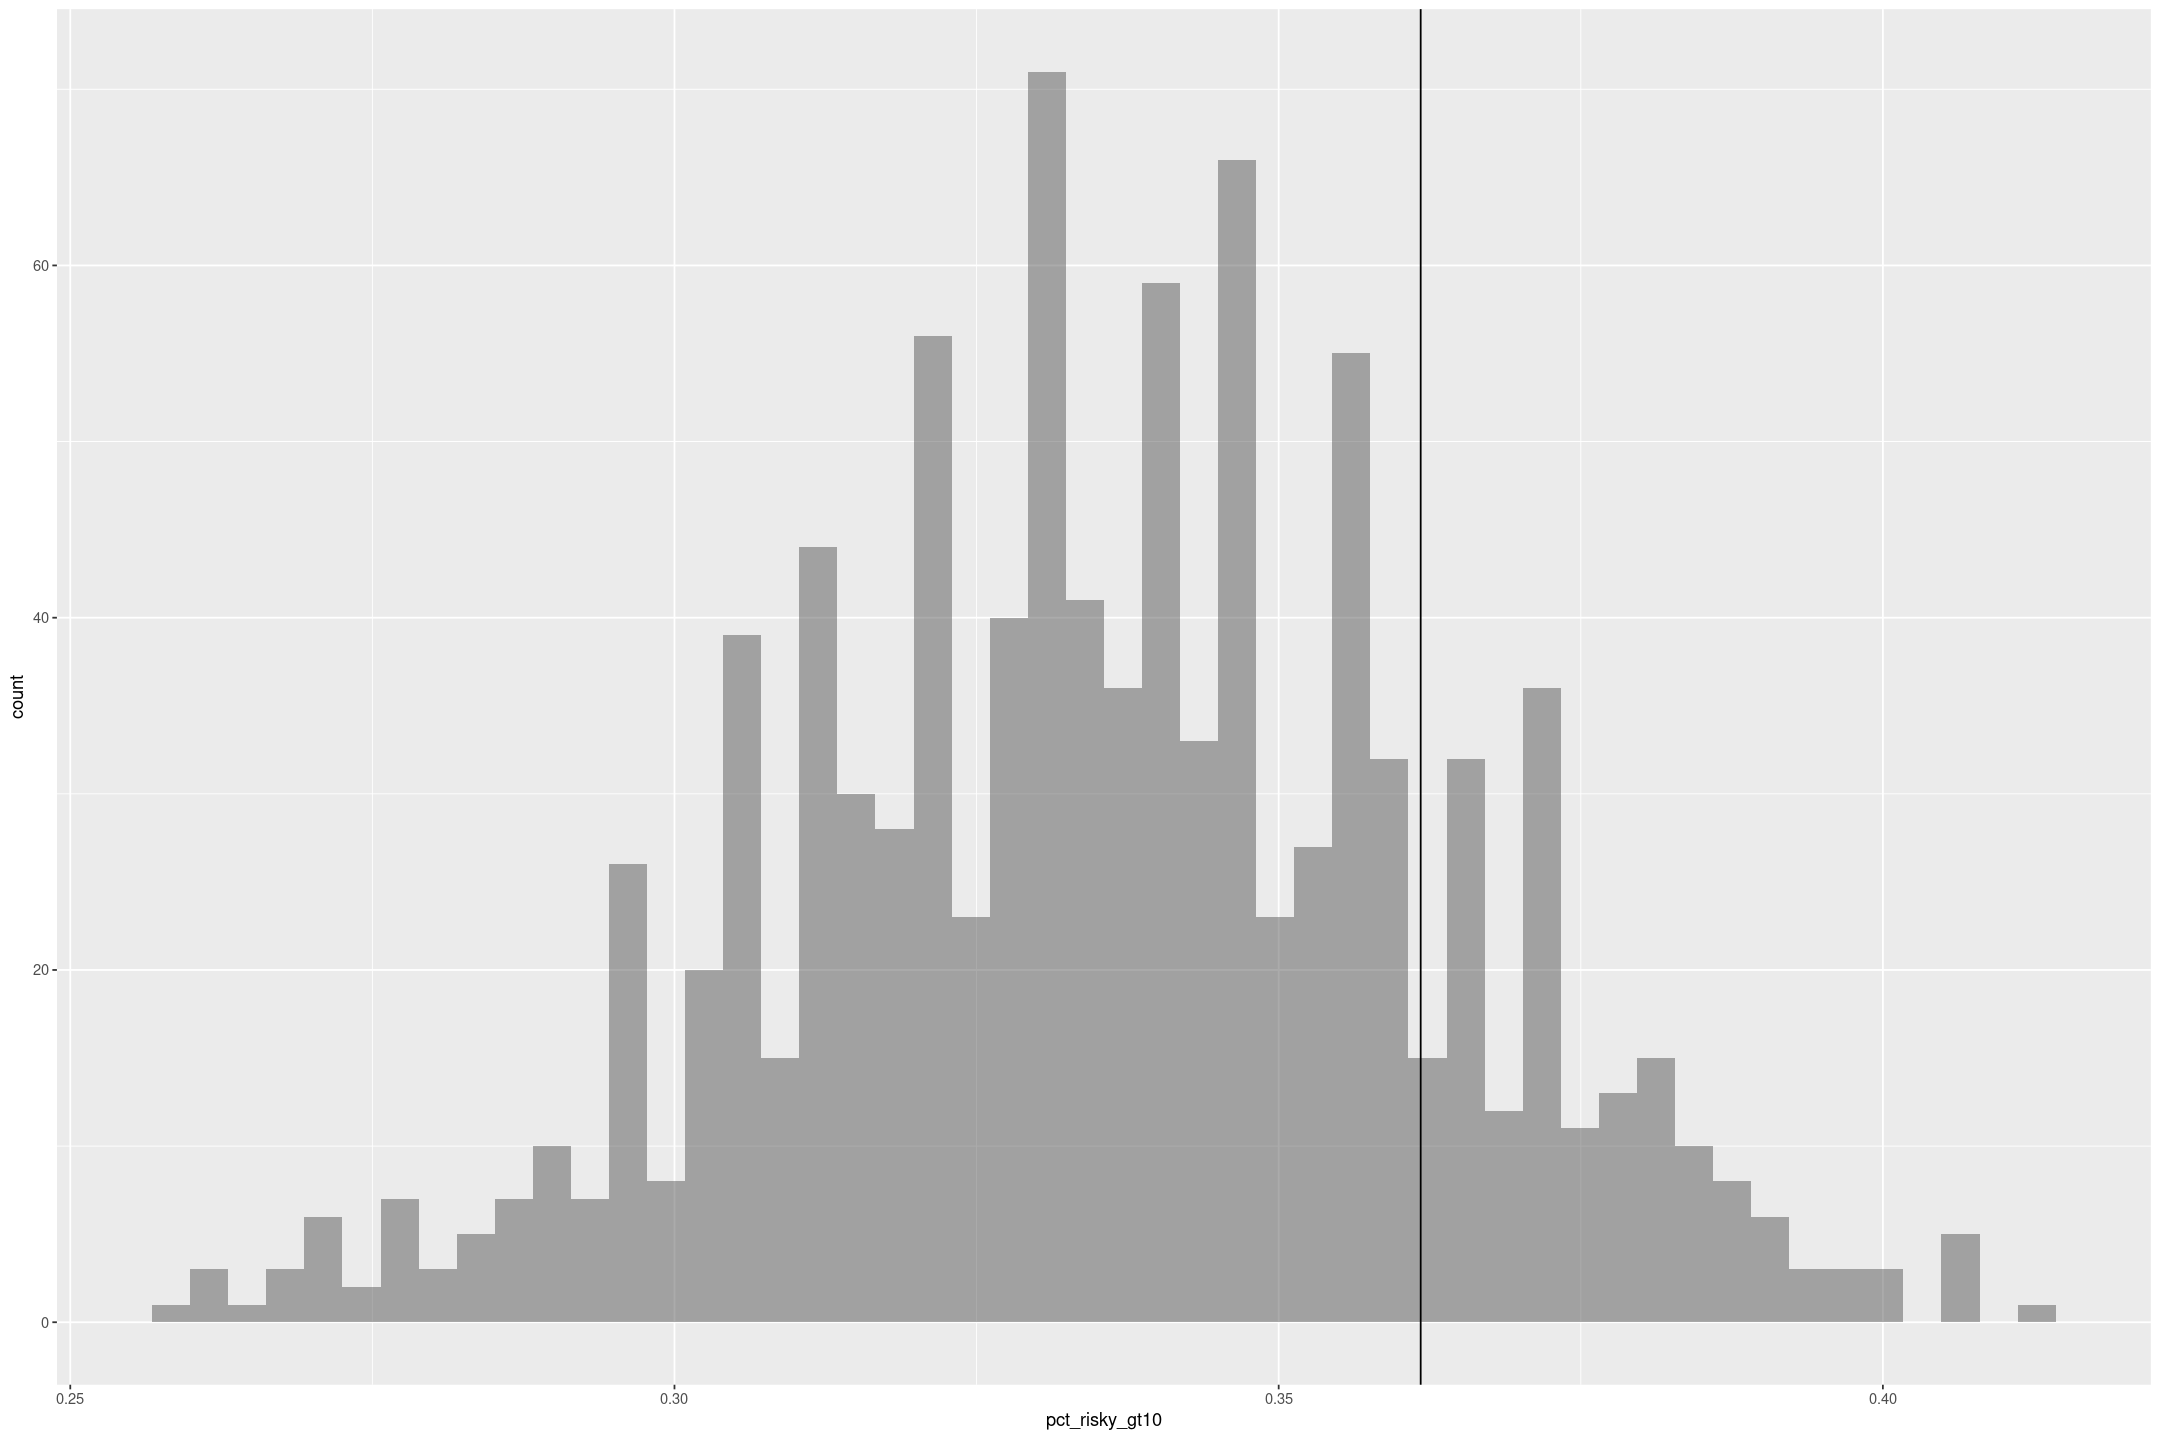

In [322]:
gf_histogram(~pct_risky_gt10, bins=50) %>%
gf_vline(xintercept=~mean(risky$acts>10))

We could summarise it using quantiles - proportion of 0s *just* lies in the 95% confidence intervals

In [323]:
mean(risky$acts==0)

[1] 0.2926267

In [324]:
quantile(pct_risky_eq0, c(0.025, 0.975))

2.5%     97.5% 
0.1935484 0.3041475

As does more than 10 acts.

In [325]:
mean(risky$acts>10)

[1] 0.3617512

In [326]:
quantile(pct_risky_gt10, c(0.025, 0.975))

2.5%     97.5% 
0.2811060 0.3870968

# Summarizing inferences and predictions using simulation

Exercise 15.7 used a Tobit model to fit a regression with an outcomes that had mixed discrete and continuous data.
In this exercise you will revisit these data and build a two-step model:

1. Logistic regression for zero earnings versus positive earnings
2. Linear regression for level or earnings given earnings are positive

Compare predictions that results from each of these models with each other.

In [327]:
fit_lalonde_zero <- stan_glm((re78 == 0) ~ re75 + treat + as.integer(re75==0),
                             family=binomial(link="logit"),
                             data=lalonde)

Note this alone is pretty interesting - if the earnings are 0 treatmeant decreases the likelihood post earnings will be zero by up to 20%.

In [328]:
print(fit_lalonde_zero, digits=6)

stan_glm
 family:       binomial [logit]
 formula:      (re78 == 0) ~ re75 + treat + as.integer(re75 == 0)
 observations: 18667
 predictors:   4
------
                      Median    MAD_SD   
(Intercept)           -1.584097  0.050204
re75                  -0.000061  0.000003
treat                 -0.855827  0.185929
as.integer(re75 == 0)  1.870874  0.067514

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


In [329]:
fit_lalonde_positive <- stan_glm(re78 ~ re75 + treat + as.integer(re75==0),
                             data=lalonde, subset=lalonde$re78>0)

In [330]:
print(fit_lalonde_positive, digits=2)

stan_glm
 family:       gaussian [identity]
 formula:      re78 ~ re75 + treat + as.integer(re75 == 0)
 observations: 16164
 predictors:   4
------
                      Median   MAD_SD  
(Intercept)            6665.82   112.58
re75                      0.73     0.01
treat                 -1311.24   576.49
as.integer(re75 == 0)  3128.57   254.26

Auxiliary parameter(s):
      Median  MAD_SD 
sigma 6807.61   37.84

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


Let's have a look at some posterior predictions

In [331]:
pred_lalonde_zero <- posterior_predict(fit_lalonde_zero, newdata=lalonde)

The hurdle model predicts 0s with about the right frequency.

In [332]:
mean(lalonde$re78 == 0) %>% scales::percent(accuracy=0.1)

[1] "13.4%"

In [333]:
apply(pred_lalonde_zero == 1, 1, mean) %>%
quantile(c(0.025, 0.5, 0.975)) %>%
scales::percent(accuracy=0.1)

2.5%     50%   97.5% 
"12.8%" "13.4%" "14.1%"

The tobit model predicts significantly lower 0s

In [334]:
apply(posterior_predict(fit_lalonde_tobit_flat)==0, 1, mean)  %>%
quantile(c(0.025, 0.5, 0.975)) %>%
scales::percent(accuracy=0.1)

2.5%     50%   97.5% 
"10.8%" "11.3%" "11.8%"

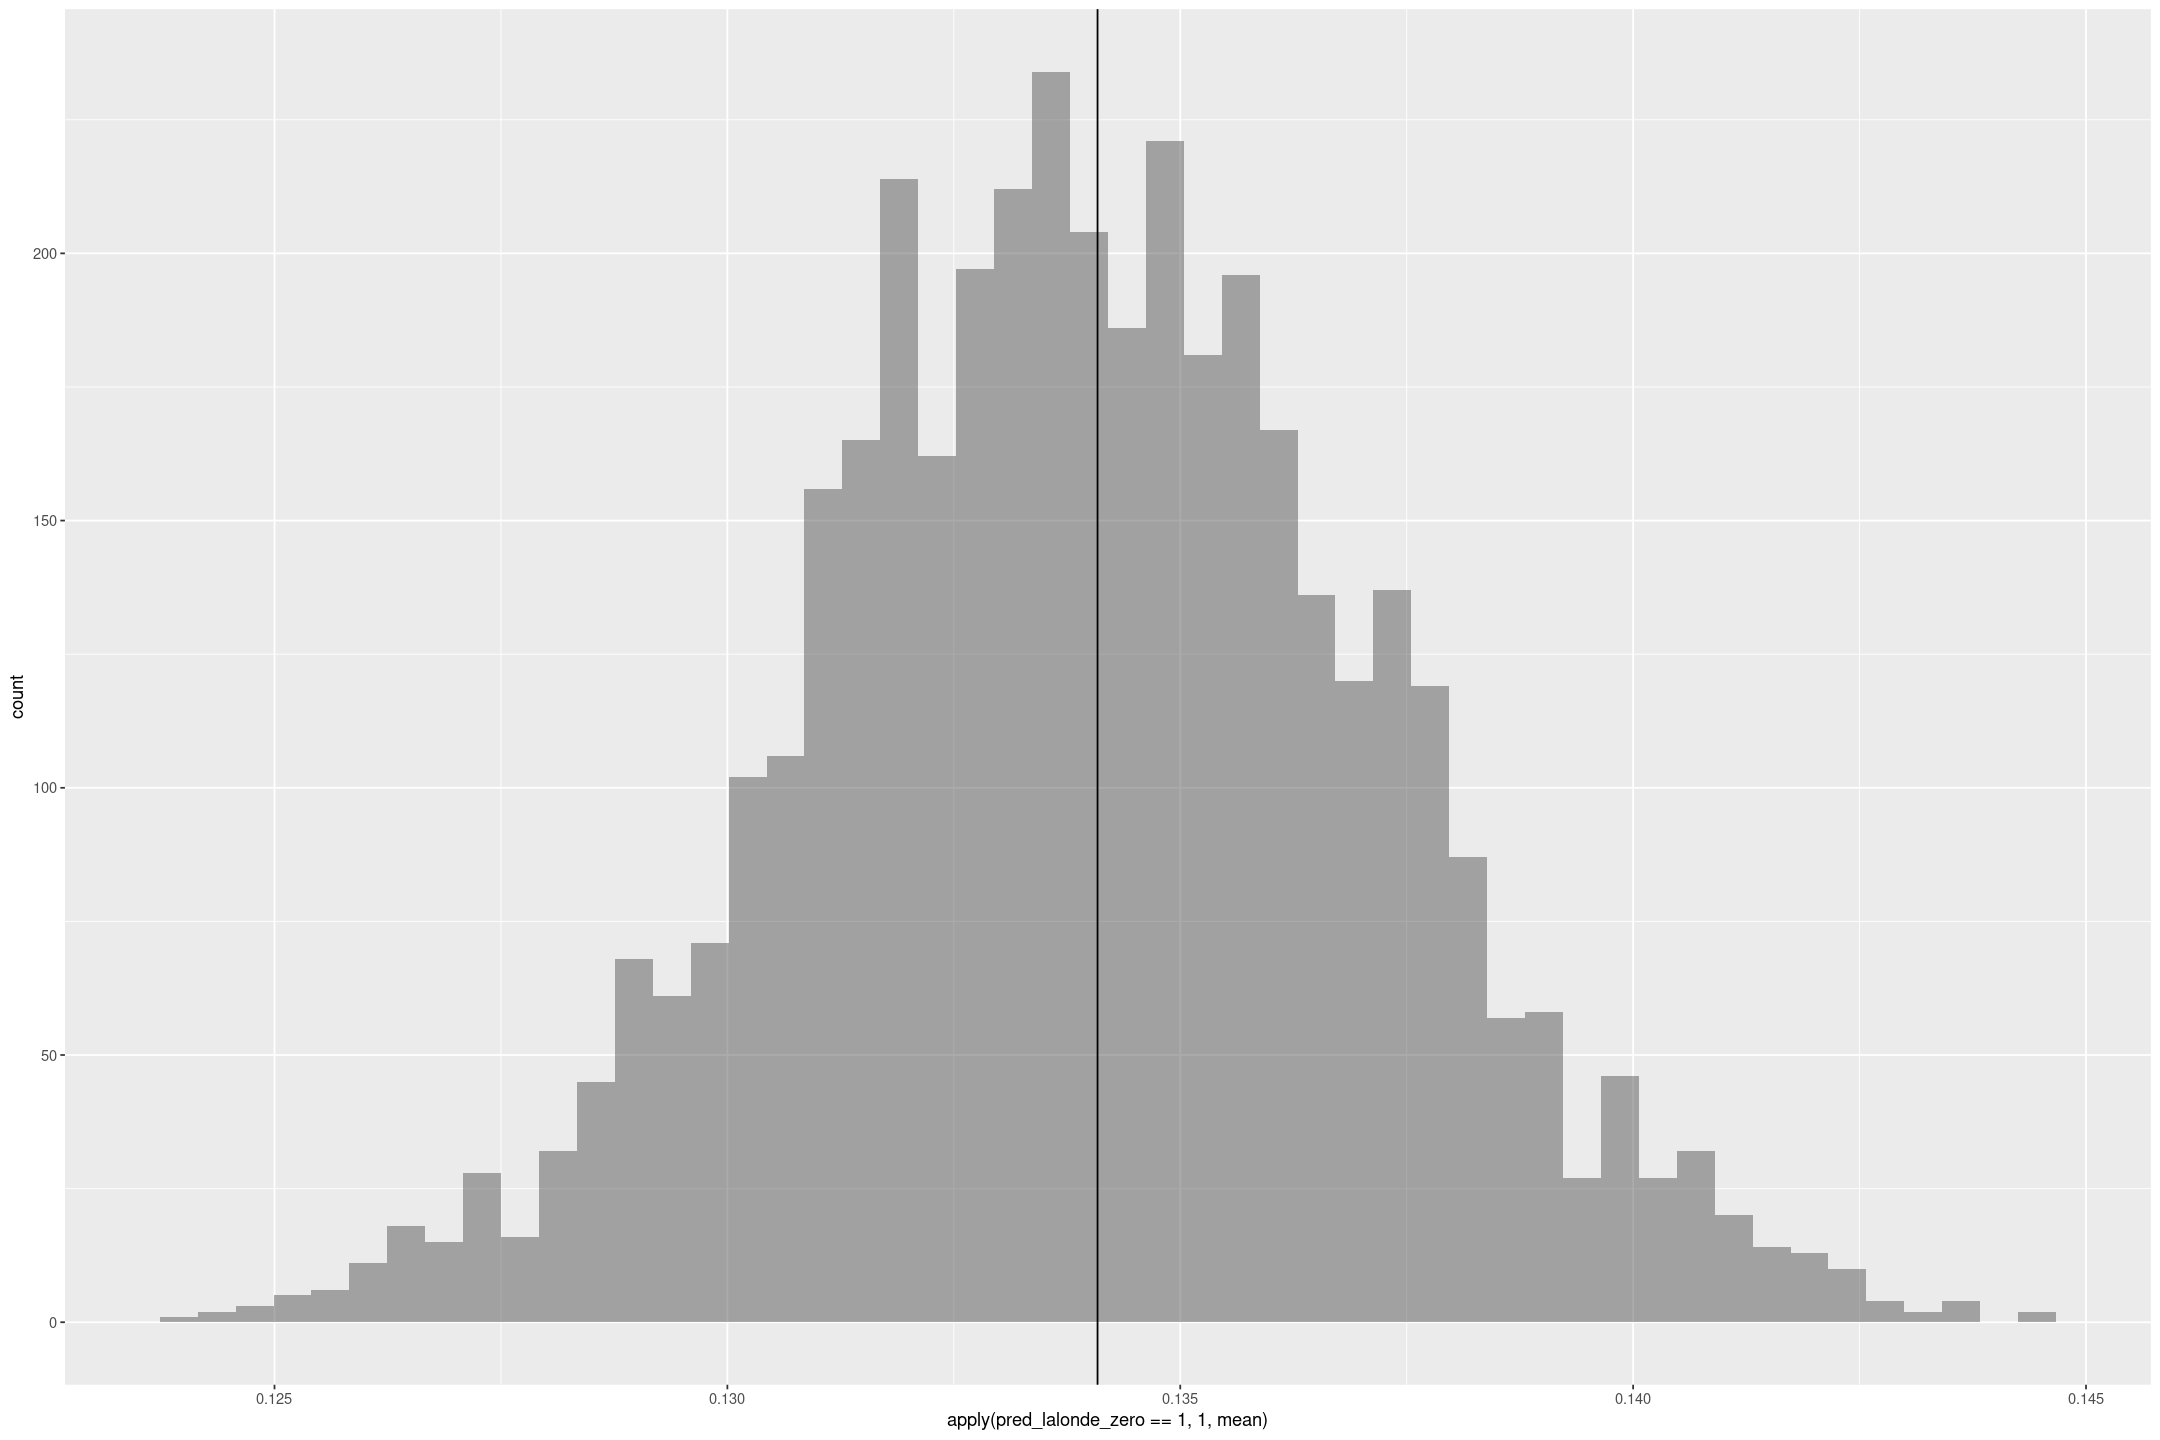

In [335]:
gf_histogram(~apply(pred_lalonde_zero == 1, 1, mean), bins=50) %>%
gf_vline(xintercept=~mean(lalonde$re78==0))

In [336]:
pred_lalonde_positive <- posterior_predict(fit_lalonde_positive, newdata=lalonde)

To get a final prediction we multiply it by 1 if it's predicted to be non-zero, or 0 otherwise.

In [337]:
pred_lalonde_hurdle <- (1 - pred_lalonde_zero) * pred_lalonde_positive

The posterior distribution (grey) looks much better near zero, but dips even further than the Tobit model.

In [338]:
post_lalonde_tobit <- posterior_predict(fit_lalonde_tobit_flat) %>%
as.data.frame() %>%
mutate(draw=row_number()) %>%
pivot_longer(-draw)

However note we actually get some *negative* predictions

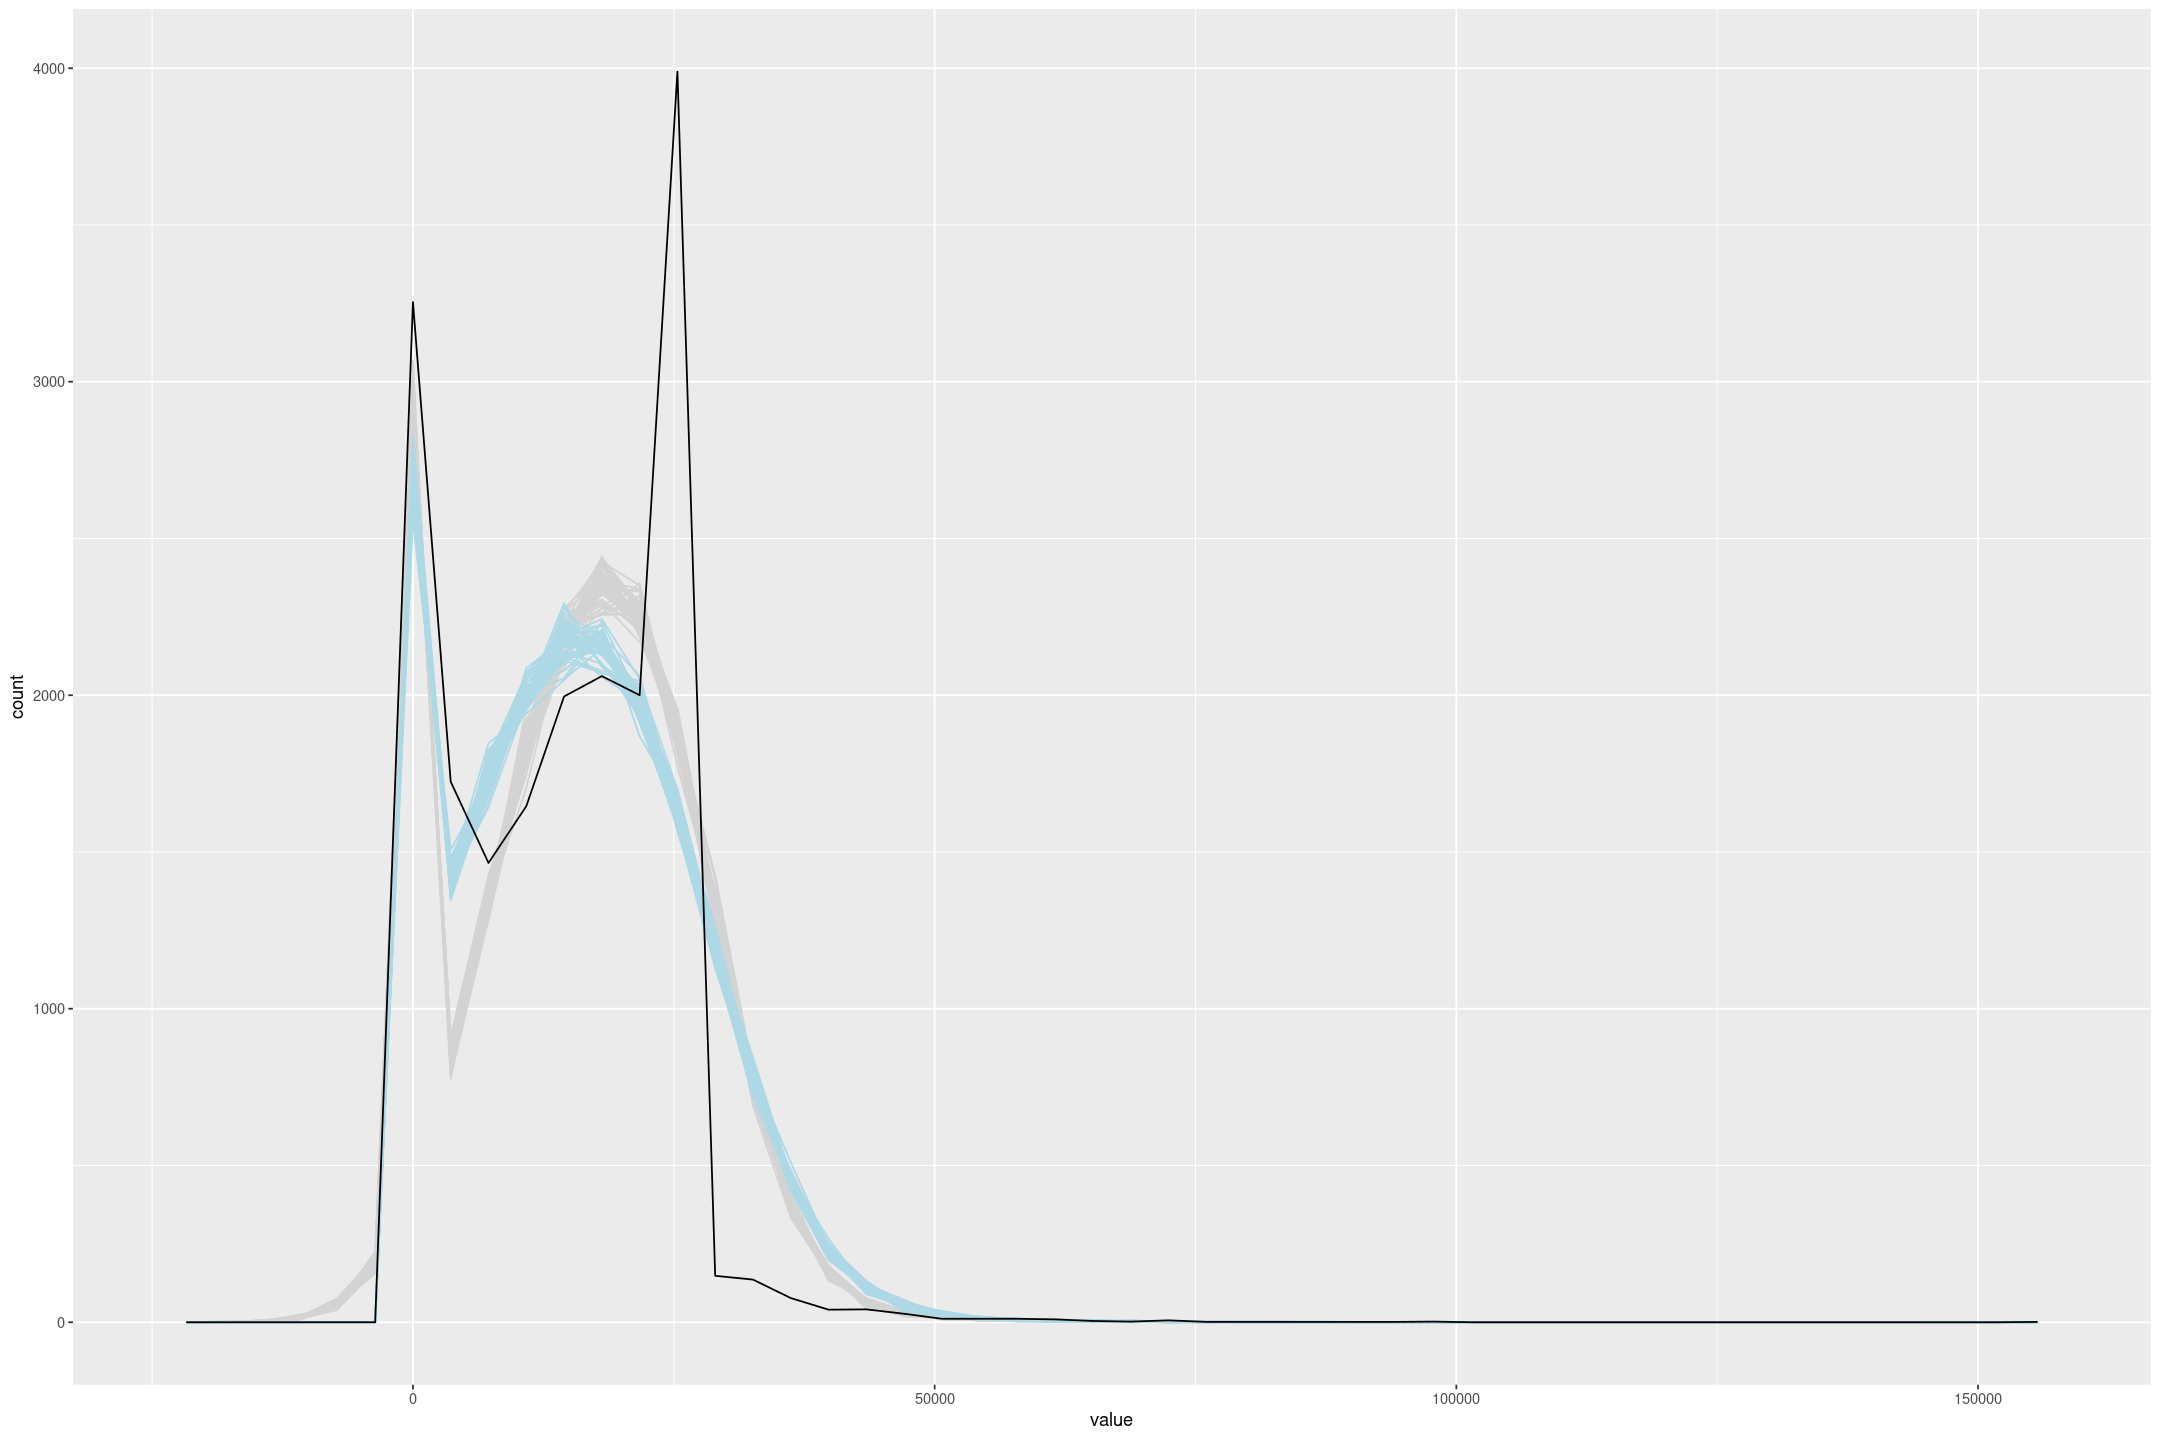

In [339]:
pred_lalonde_hurdle[1:50,] %>%
t() %>%
cbind(lalonde) %>%
pivot_longer(-colnames(lalonde)) %>%
gf_freqpoly(~value, group=~name, bins=50, colour="lightgrey") %>%
gf_freqpoly(~value, group=~draw, bins=50, colour="lightblue", data=filter(post_lalonde_tobit, draw<=50), legend="lalonde") %>%
gf_freqpoly(~re75, group=FALSE, data=lalonde, bins=50)

Let's have a look at the predictive accuracy by groups

In [340]:
rms <- function(x,y) sqrt(mean((x-y)^2))

In [341]:
quibble <- function(x, q = c(0.25, 0.5, 0.75)) {
  tibble(x = quantile(x, q), q = q)
}

In [342]:
pred_lalonde_hurdle[1:1000,] %>%
t() %>%
cbind(lalonde) %>%
pivot_longer(-colnames(lalonde)) %>%
group_by(treat, name) %>%
summarise(rms=rms(re78, value)) %>%
summarise(quibble(rms, c(0.025, 0.5, 0.975))) %>%
pivot_wider(names_from=q, values_from=x)

`summarise()` has grouped output by 'treat'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'treat'. You can override using the `.groups` argument.



treat 0.025     0.5      0.975   
1 0     10895.890 11006.71 11137.01
2 1      9679.337 10517.15 11395.04

The RMS error is very slightly higher for the control group, but for the treatment group it's about the same.

In [343]:
post_lalonde_tobit %>%
filter(draw <= 1000) %>%
group_by(draw) %>%
mutate(treat=lalonde$treat, re78=lalonde$re78) %>%
group_by(treat, draw) %>%
summarise(rms=rms(re78, value)) %>%
summarise(quibble(rms, c(0.025, 0.5, 0.975))) %>%
pivot_wider(names_from=q, values_from=x)

`summarise()` has grouped output by 'treat'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'treat'. You can override using the `.groups` argument.



treat 0.025     0.5      0.975   
1 0     11072.746 11173.05 11264.56
2 1      9560.851 10540.54 11457.33

Overall I have a slight preference to the hurdle model in the predictions, although it's a little harder to interpret the effect of treatment - in fact if the income is positive it's predicted to reduce earnings.

In [344]:
coef(fit_lalonde_positive)[['treat']]

[1] -1311.241

### Loghurdle

A further advantage of a hurdle model is we can fit logarithmic models (which won't give the zero predictions)

In [345]:
fit_lalonde_positive_log <- stan_glm(log(re78) ~ log(re75+1) + treat + as.integer(re75==0),
                             data=lalonde, subset=lalonde$re78>0)

In [346]:
fit_lalonde_positive_log

stan_glm
 family:       gaussian [identity]
 formula:      log(re78) ~ log(re75 + 1) + treat + as.integer(re75 == 0)
 observations: 16164
 predictors:   4
------
                      Median MAD_SD
(Intercept)            5.3    0.1  
log(re75 + 1)          0.5    0.0  
treat                 -0.1    0.1  
as.integer(re75 == 0)  3.3    0.1  

Auxiliary parameter(s):
      Median MAD_SD
sigma 0.8    0.0   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

In [347]:
pred_lalonde_positive_log <- exp(posterior_predict(fit_lalonde_positive_log, newdata=lalonde))

In [348]:
pred_lalonde_loghurdle <- (1 - pred_lalonde_zero) * pred_lalonde_positive_log

We get some *much* larger predictions than are found in the data however.

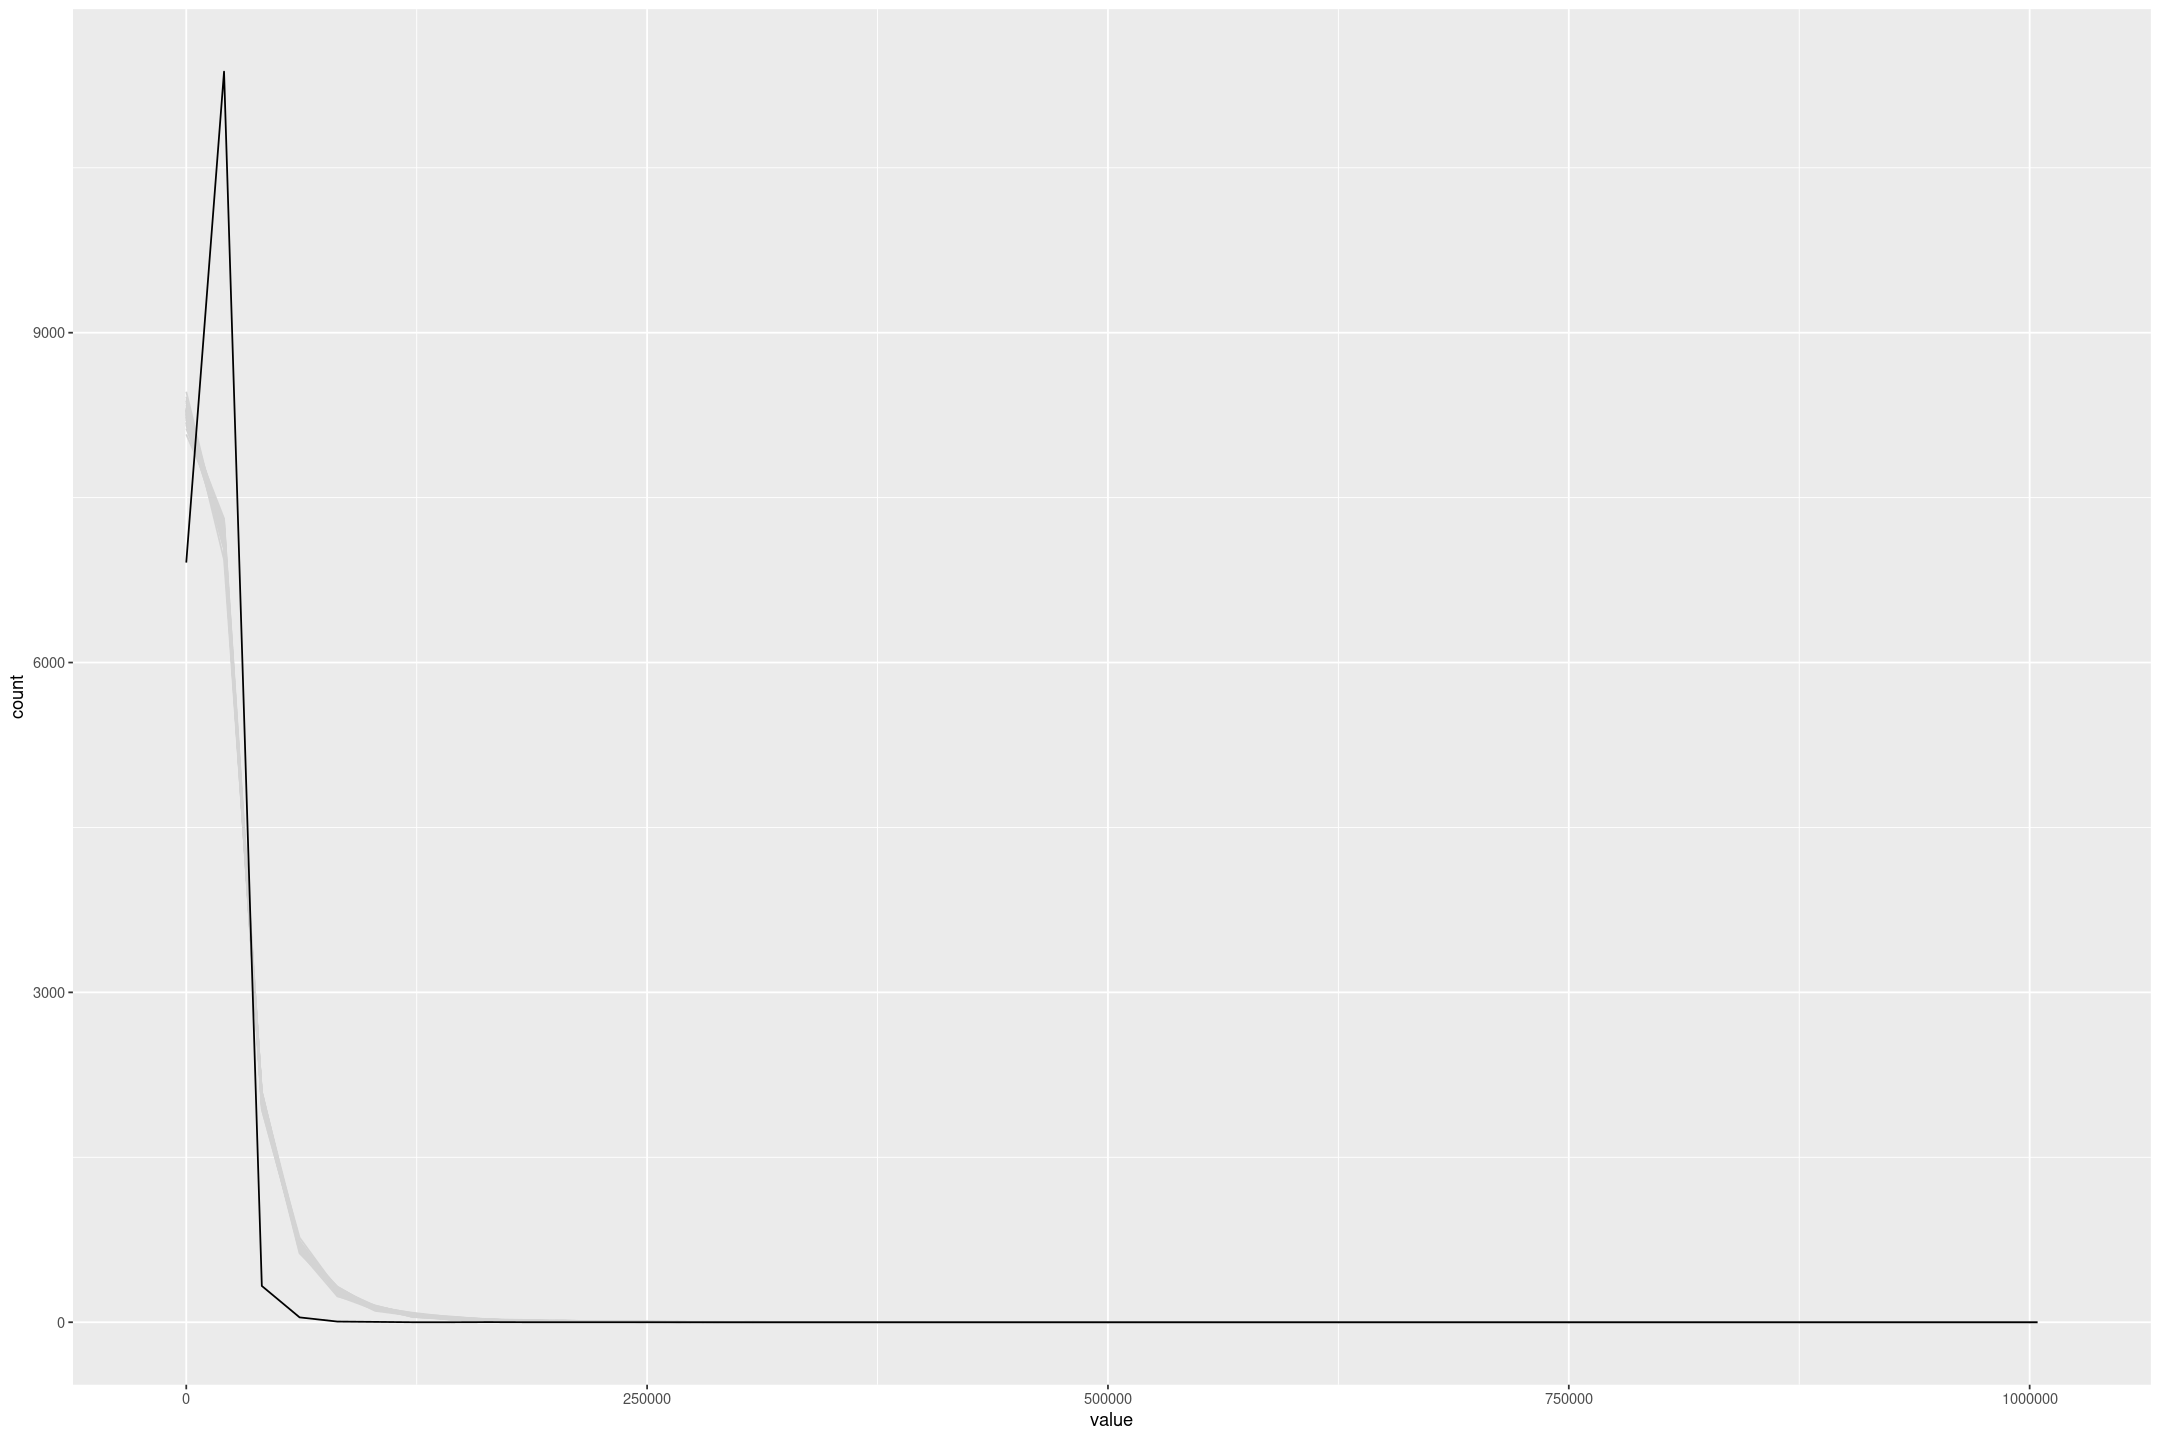

In [349]:
pred_lalonde_loghurdle[1:50,] %>%
t() %>%
cbind(lalonde) %>%
pivot_longer(-colnames(lalonde)) %>%
gf_freqpoly(~value, group=~name, bins=50, colour="lightgrey") %>%
gf_freqpoly(~re75, group=FALSE, data=lalonde, bins=50)

We predict earnings of over \\$200,000 very frequently which never happens in the model.

In [350]:
max(lalonde$re78)

[1] 121173.6

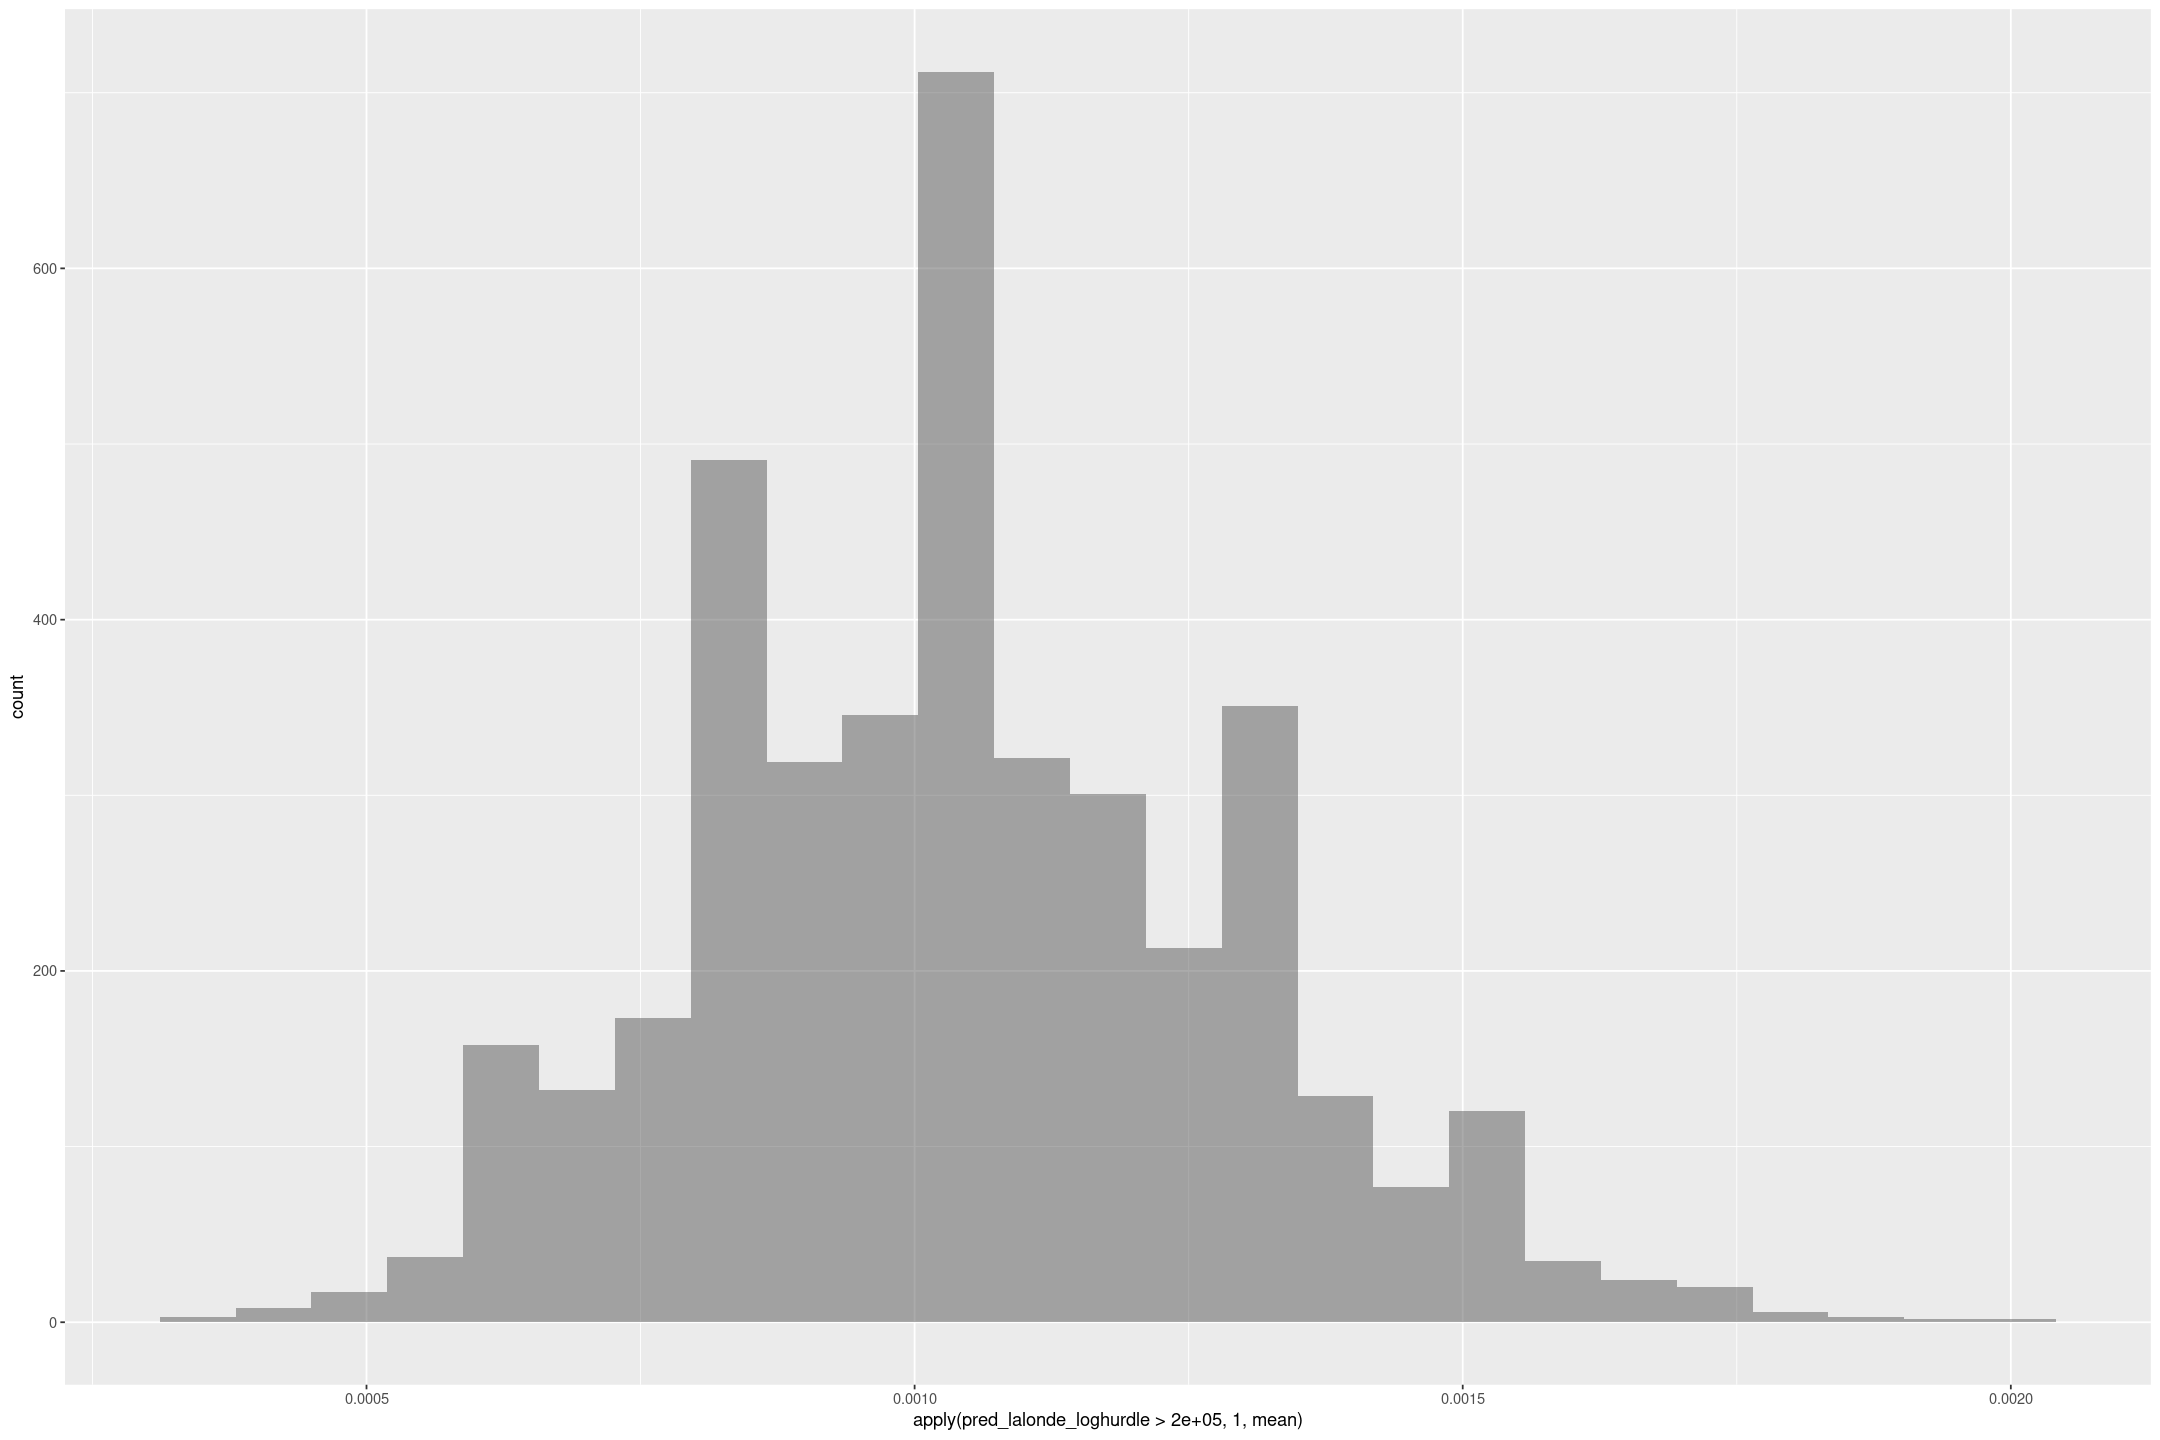

In [351]:
gf_histogram(~apply(pred_lalonde_loghurdle > 2e5, 1, mean))

We get a significantly larger RMS since we're minimising log(RMS).

In [352]:
pred_lalonde_loghurdle[1:1000,] %>%
t() %>%
cbind(lalonde) %>%
pivot_longer(-colnames(lalonde)) %>%
group_by(treat, name) %>%
summarise(rms=rms(re78, value)) %>%
summarise(quibble(rms, c(0.025, 0.5, 0.975))) %>%
pivot_wider(names_from=q, values_from=x)

`summarise()` has grouped output by 'treat'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'treat'. You can override using the `.groups` argument.



treat 0.025     0.5      0.975   
1 0     21431.797 22451.78 23725.68
2 1      9500.708 11110.52 15094.66

Perhaps a better model would be a squareroot transform, or just capping at 0.

Clean up some large variables

In [353]:
rm(pred_lalonde_loghurdle)
rm(pred_lalonde_positive_log)
rm(post_lalonde_tobit)
rm(pred_lalonde_hurdle)
rm(pred_lalonde_positive)
rm(pred_lalonde_zero)
rm(lalonde)

# Average Predictive Comparisons

## Log Roaches

Take the roach model from Section 15.2 and estimate the average predictive comparisons for logarithm of roach count, for each of the input variables in the model.

In [354]:
filename <- 'data/Roaches/roaches.csv'

download_if_missing(filename, 'https://raw.githubusercontent.com/avehtari/ROS-Examples/master/Roaches/data/roaches.csv')

roaches <- read.csv(filename)

In [355]:
head(roaches)

X y   roach1 treatment senior exposure2
1 1 153 308.00 1         0      0.800000 
2 2 127 331.25 1         0      0.600000 
3 3   7   1.67 1         0      1.000000 
4 4   7   3.00 1         0      1.000000 
5 5   0   2.00 1         0      1.142857 
6 6   0   0.00 1         0      1.000000

In [356]:
roaches <- roaches %>% mutate(roach100 = roach1/100)

In [357]:
fit_roach <- stan_glm(y ~ roach100 + treatment + senior, family=neg_binomial_2,
                     offset=log(exposure2), data=roaches)
print(fit_roach, digits=2)

stan_glm
 family:       neg_binomial_2 [log]
 formula:      y ~ roach100 + treatment + senior
 observations: 262
 predictors:   4
------
            Median MAD_SD
(Intercept)  2.84   0.24 
roach100     1.30   0.25 
treatment   -0.78   0.25 
senior      -0.33   0.27 

Auxiliary parameter(s):
                      Median MAD_SD
reciprocal_dispersion 0.27   0.03  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


I get a warning because offset [isn't passed to pp_data](https://github.com/stan-dev/rstanarm/blob/v2.21.1/R/predict.R#L71) in rstanarm

In [358]:
preds <- predict(fit_roach, newdata=roaches, offset=log(roaches$exposure2))

Warning message:
“'offset' argument is NULL but it looks like you estimated the model using an offset term.”


Let's cheat to create an approximate prediction function.

In [359]:
mypred <- function(data) {
     apply(posterior_linpred(fit_roach, newdata=data, offset=log(data$exposure2)), 2 ,median)
    }

The predictions are slightly higher but generally within 1%.

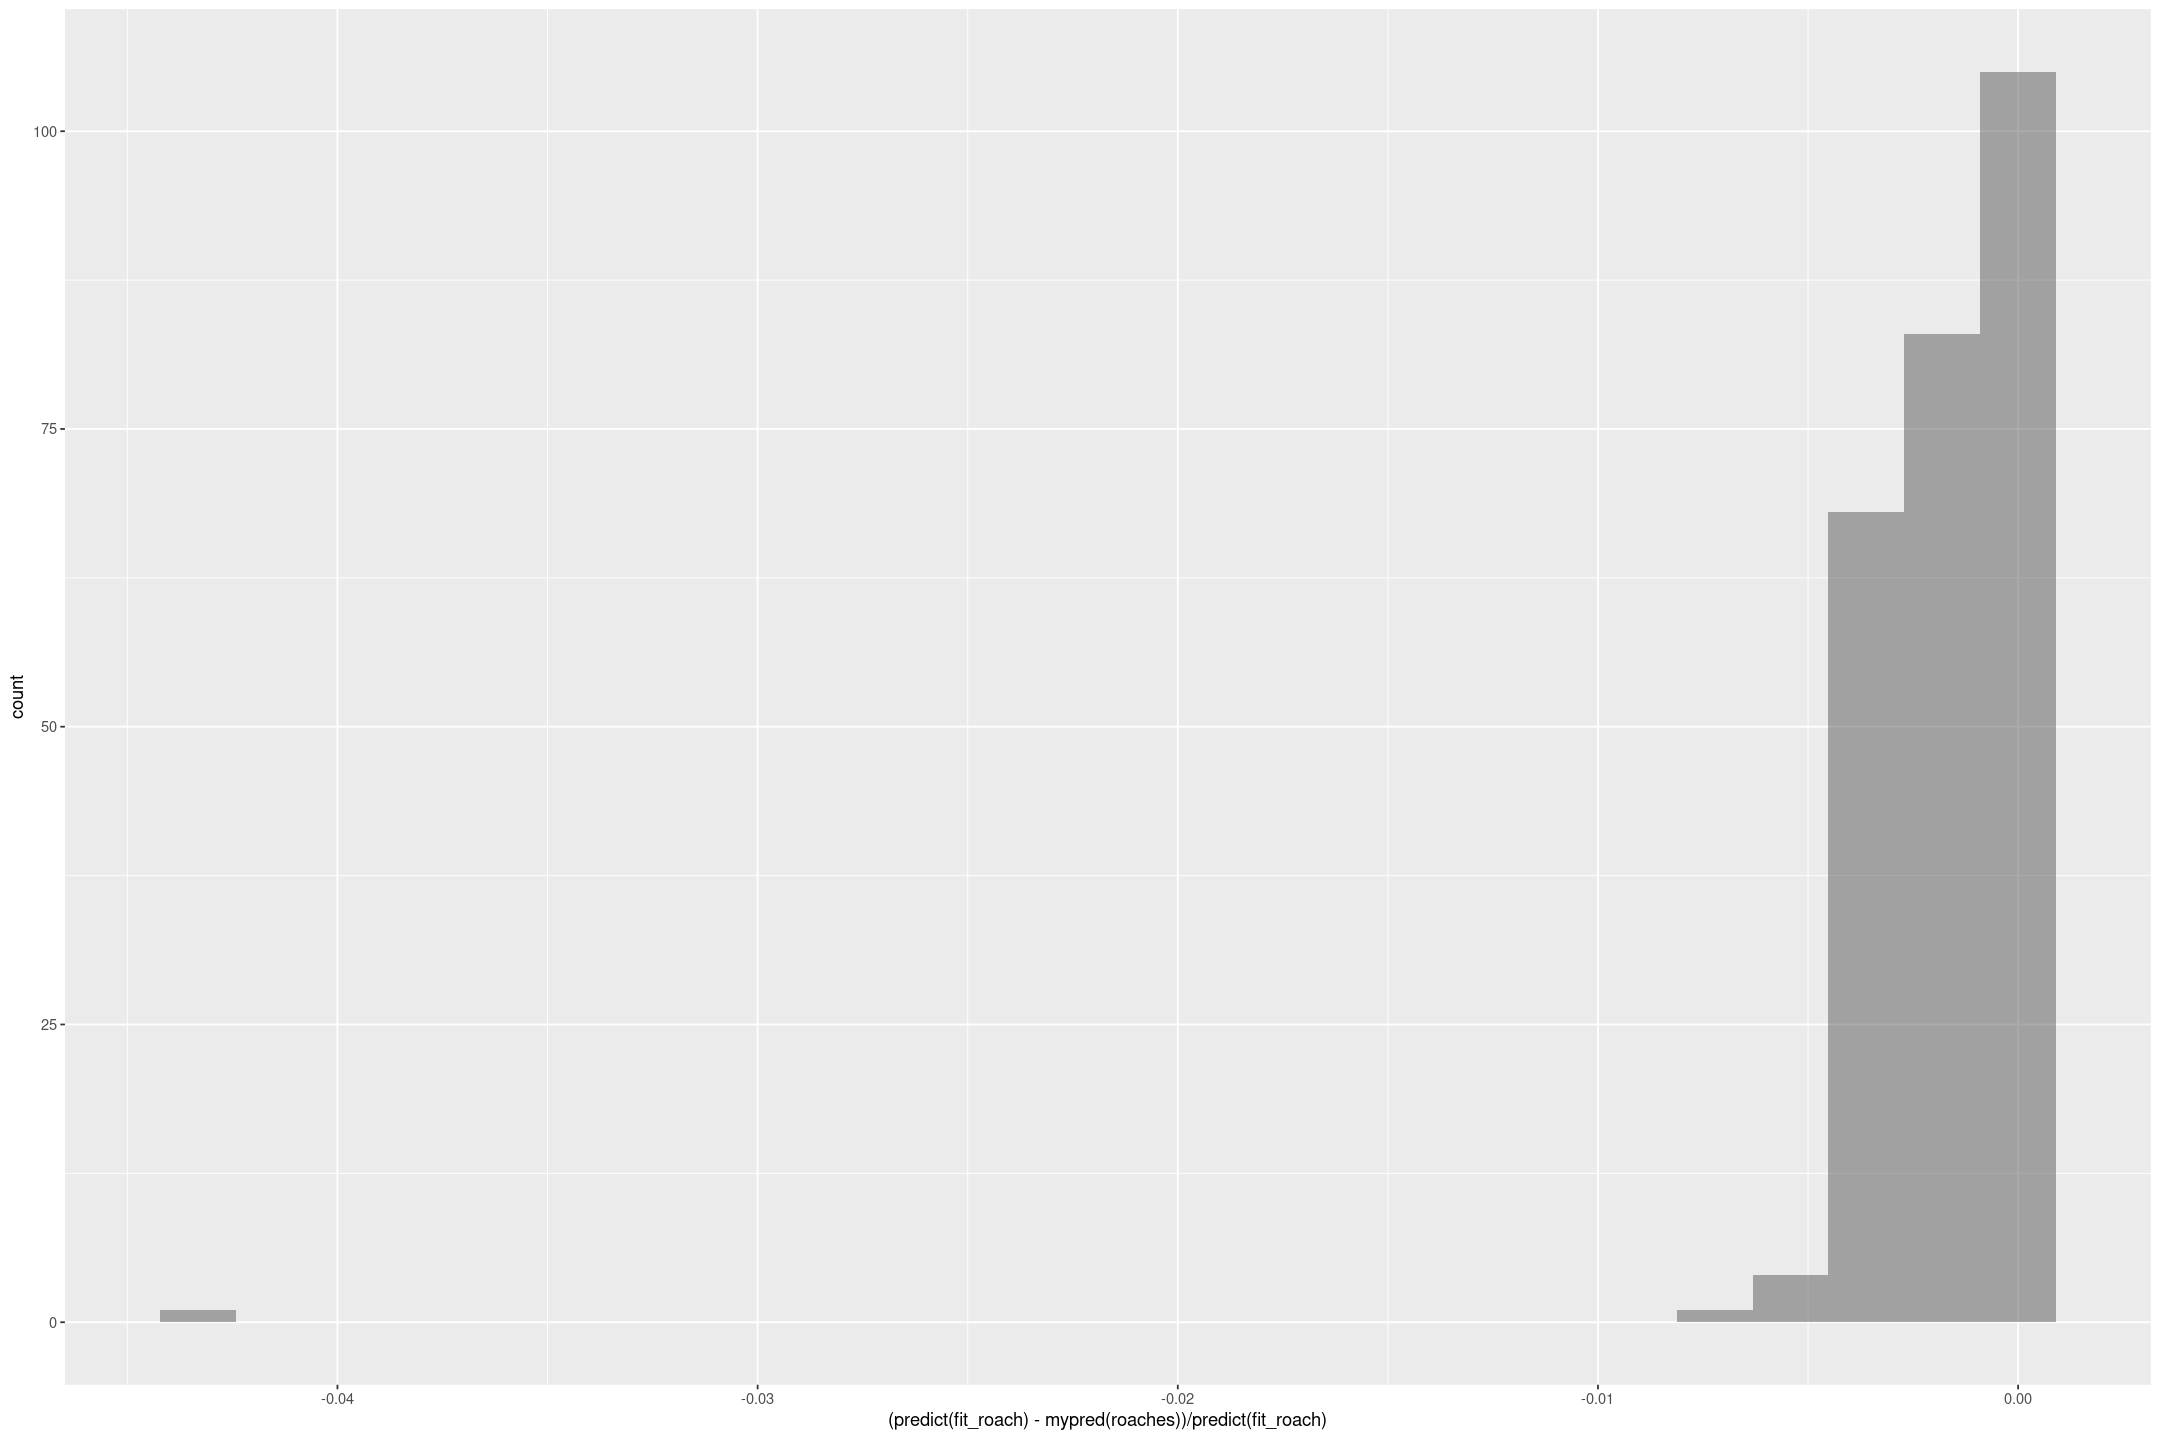

In [360]:
gf_histogram(~(predict(fit_roach) - mypred(roaches)) / predict(fit_roach))

In [361]:
fit_roach

stan_glm
 family:       neg_binomial_2 [log]
 formula:      y ~ roach100 + treatment + senior
 observations: 262
 predictors:   4
------
            Median MAD_SD
(Intercept)  2.8    0.2  
roach100     1.3    0.2  
treatment   -0.8    0.2  
senior      -0.3    0.3  

Auxiliary parameter(s):
                      Median MAD_SD
reciprocal_dispersion 0.3    0.0   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

Treatment on average reduces log roaches

In [362]:
(lintreat <- mean(mypred(mutate(roaches, treatment=1)) - mypred(mutate(roaches, treatment=0))))

[1] -0.7808254

So this changes the number of roaches by

In [363]:
exp(lintreat) %>% scales::percent()

[1] "46%"

An increase in roach100 by 1 is even more significant

In [364]:
(linroach <- mean(mypred(mutate(roaches, roach100=roach100+1)) - mypred(roaches)))

[1] 1.309815

Note this is close to symmetric by linearity with decreasing by 1

In [365]:
mean(mypred(mutate(roaches, roach100=roach100-1)) - mypred(roaches))

[1] -1.305502

The percentage change is

In [366]:
exp(linroach) %>% scales::percent()

[1] "371%"

Seniors living in the building slightly reduces log roaches

In [367]:
(linsenior <- mean(mypred(mutate(roaches, senior=1)) - mypred(mutate(roaches, senior=0))))

[1] -0.332352

In [368]:
exp(linsenior) %>% scales::percent()

[1] "72%"

## Actual roaches

Do the same things but estimating average predictive comparisons for roach count itself.

Across the sample the average predictive impact of treatment is:

In [369]:
mean(exp(mypred(mutate(roaches, treatment=1))) - exp(mypred(mutate(roaches, treatment=0))))

[1] -44.96571

Across the sample the average predictive impact of adding 100 roaches is

In [370]:
mean(exp(mypred(mutate(roaches, roach100=roach100+1))) - exp(mypred(roaches)))

[1] 159.6584

Note that *decreasing* by 100 roaches has a smaller effect (note this doesn't really make sense where it makes the number of roaches < 0).

In [371]:
mean(exp(mypred(mutate(roaches, roach100=roach100-1))) - exp(mypred(roaches)))

[1] -43.50478

Finally having a senior citizen decreases roaches by a little bit:

In [372]:
mean(exp(mypred(mutate(roaches, senior=1))) - exp(mypred(mutate(roaches, senior=0))))

[1] -17.34229

# Learning from social science data

The General Social Survey (GSS) has been conducted in the United States every two years since 1972.

## Download count data

Go to the GSS website and download the data.
Consider a question of intereste that was asked in may rounds of the survey and which is a count variable.
Decide how you will handle nonresponse in your analysis.

In [373]:
library(gssr)
data(gss_all)
data(gss_doc)

Package loaded. To attach the GSS data, type data(gss_all) at the console.
For the codebook, type data(gss_doc). The gss_all and gss_doc objects will then be available to use.



Let's look at number of children

In [374]:
gss_childs <- 
gss_all %>% 
transmute(id,
          year,
          childs=childs, 
          age,
          educ,
          male = ifelse(sex == 1, 1, 0),
          black = ifelse(race== 2, 1, 0)) %>%
drop_na()

## Average response by year

Make a graph of the average response of this count variable over time, each year giving &pm;1 standard error bounds, as in Figure 4.3, computing the standard error for each year as ${\rm sd}(y) / \sqrt{n}$ using the data from that year.

The number of children has fallen substantially over time.

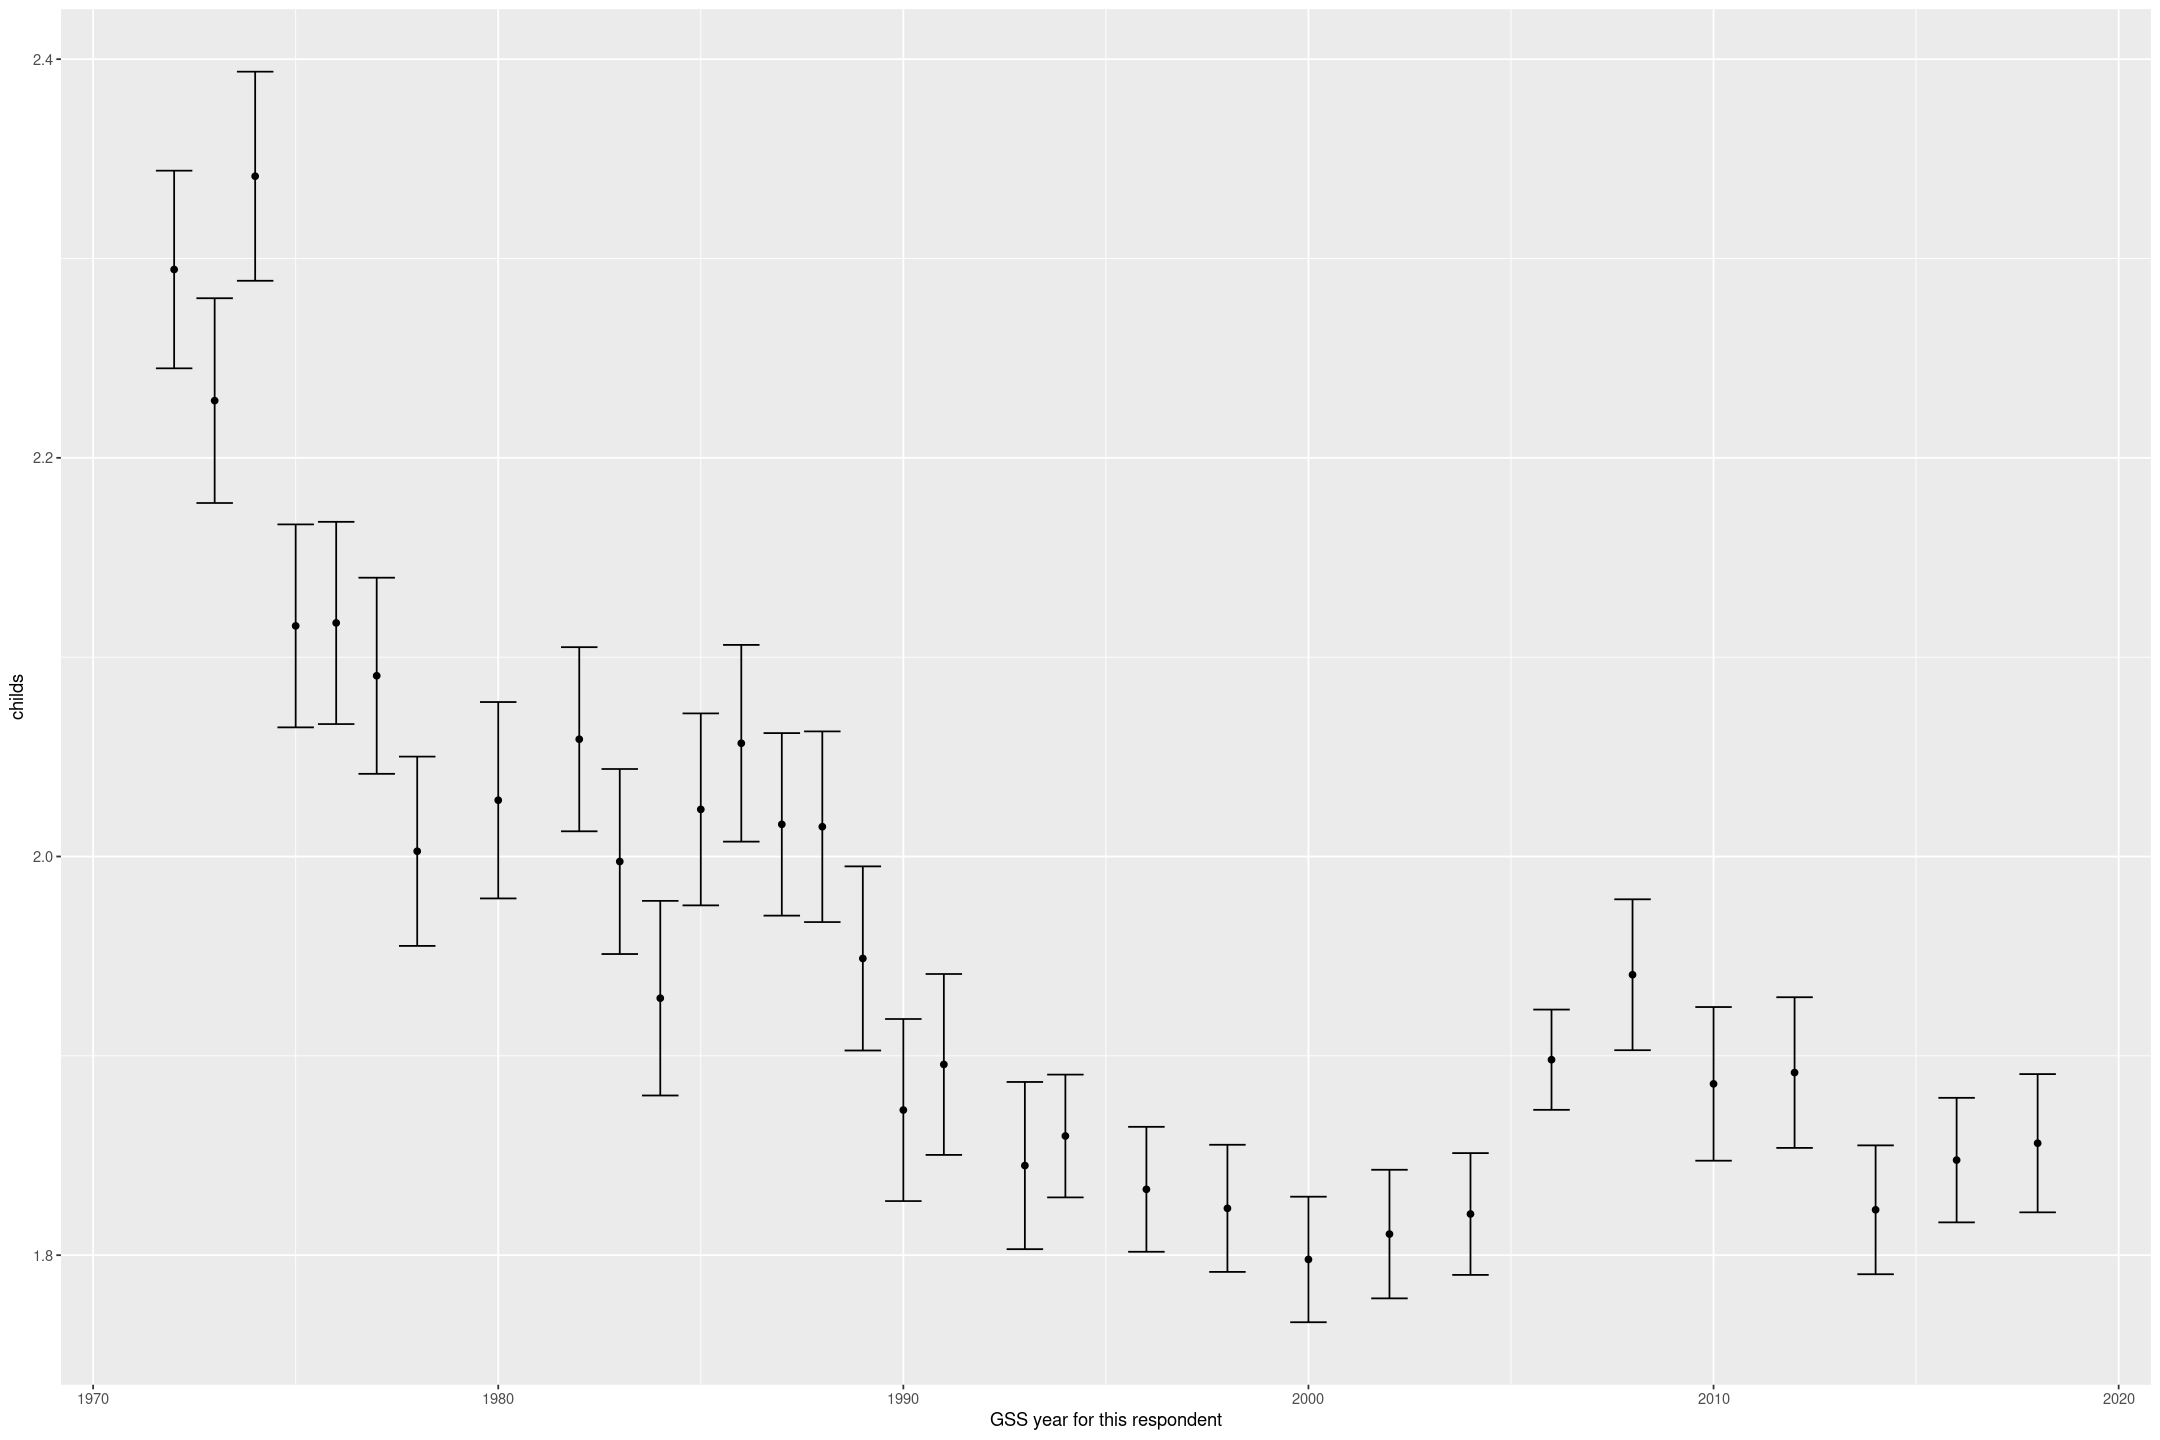

In [375]:
gss_childs %>% 
group_by(year) %>%
summarise(se=sd(childs)/sqrt(n()), childs=mean(childs)) %>%
mutate(upper = childs+se, lower = childs-se) %>%
gf_point(childs ~ year) %>%
gf_errorbar(ymin=~lower, ymax=~upper)

## Predicted response by year

Set up a negative binomial regression for this outcome given predictors for age, sex, education, and ethnicity.
Fit the model separately for each year that the question was asked, and make a grid of plots with the time series coefficient estimates &pm; standard errors over time.

Having age as a *linear* coefficient doesn't make heaps of sense; it would likely work better in bands.
But for now let's just run with it.

In [376]:
start_time <- Sys.time()

gss_childs_models <- 
gss_childs %>%
group_by(year) %>%
nest(data=c(id, childs, age, male, black, educ)) %>%
mutate(model = purrr::map(data, ~stan_glm(childs ~ age + male + black + educ, family=neg_binomial_2, data=., refresh=0, QR=TRUE)))

Sys.time() - start_time

Time difference of 5.51395 mins

There's a lot of interesting things here.

The impact of age becomes more significant over time - perhaps in tie with the average age people have children is getting older.

Males being slightly less likely to have children indicates single-mothers. It could be interesting to combine this with other indicators.

Years of education has a level shift around 2003 - I can't make sense of how this could happen?

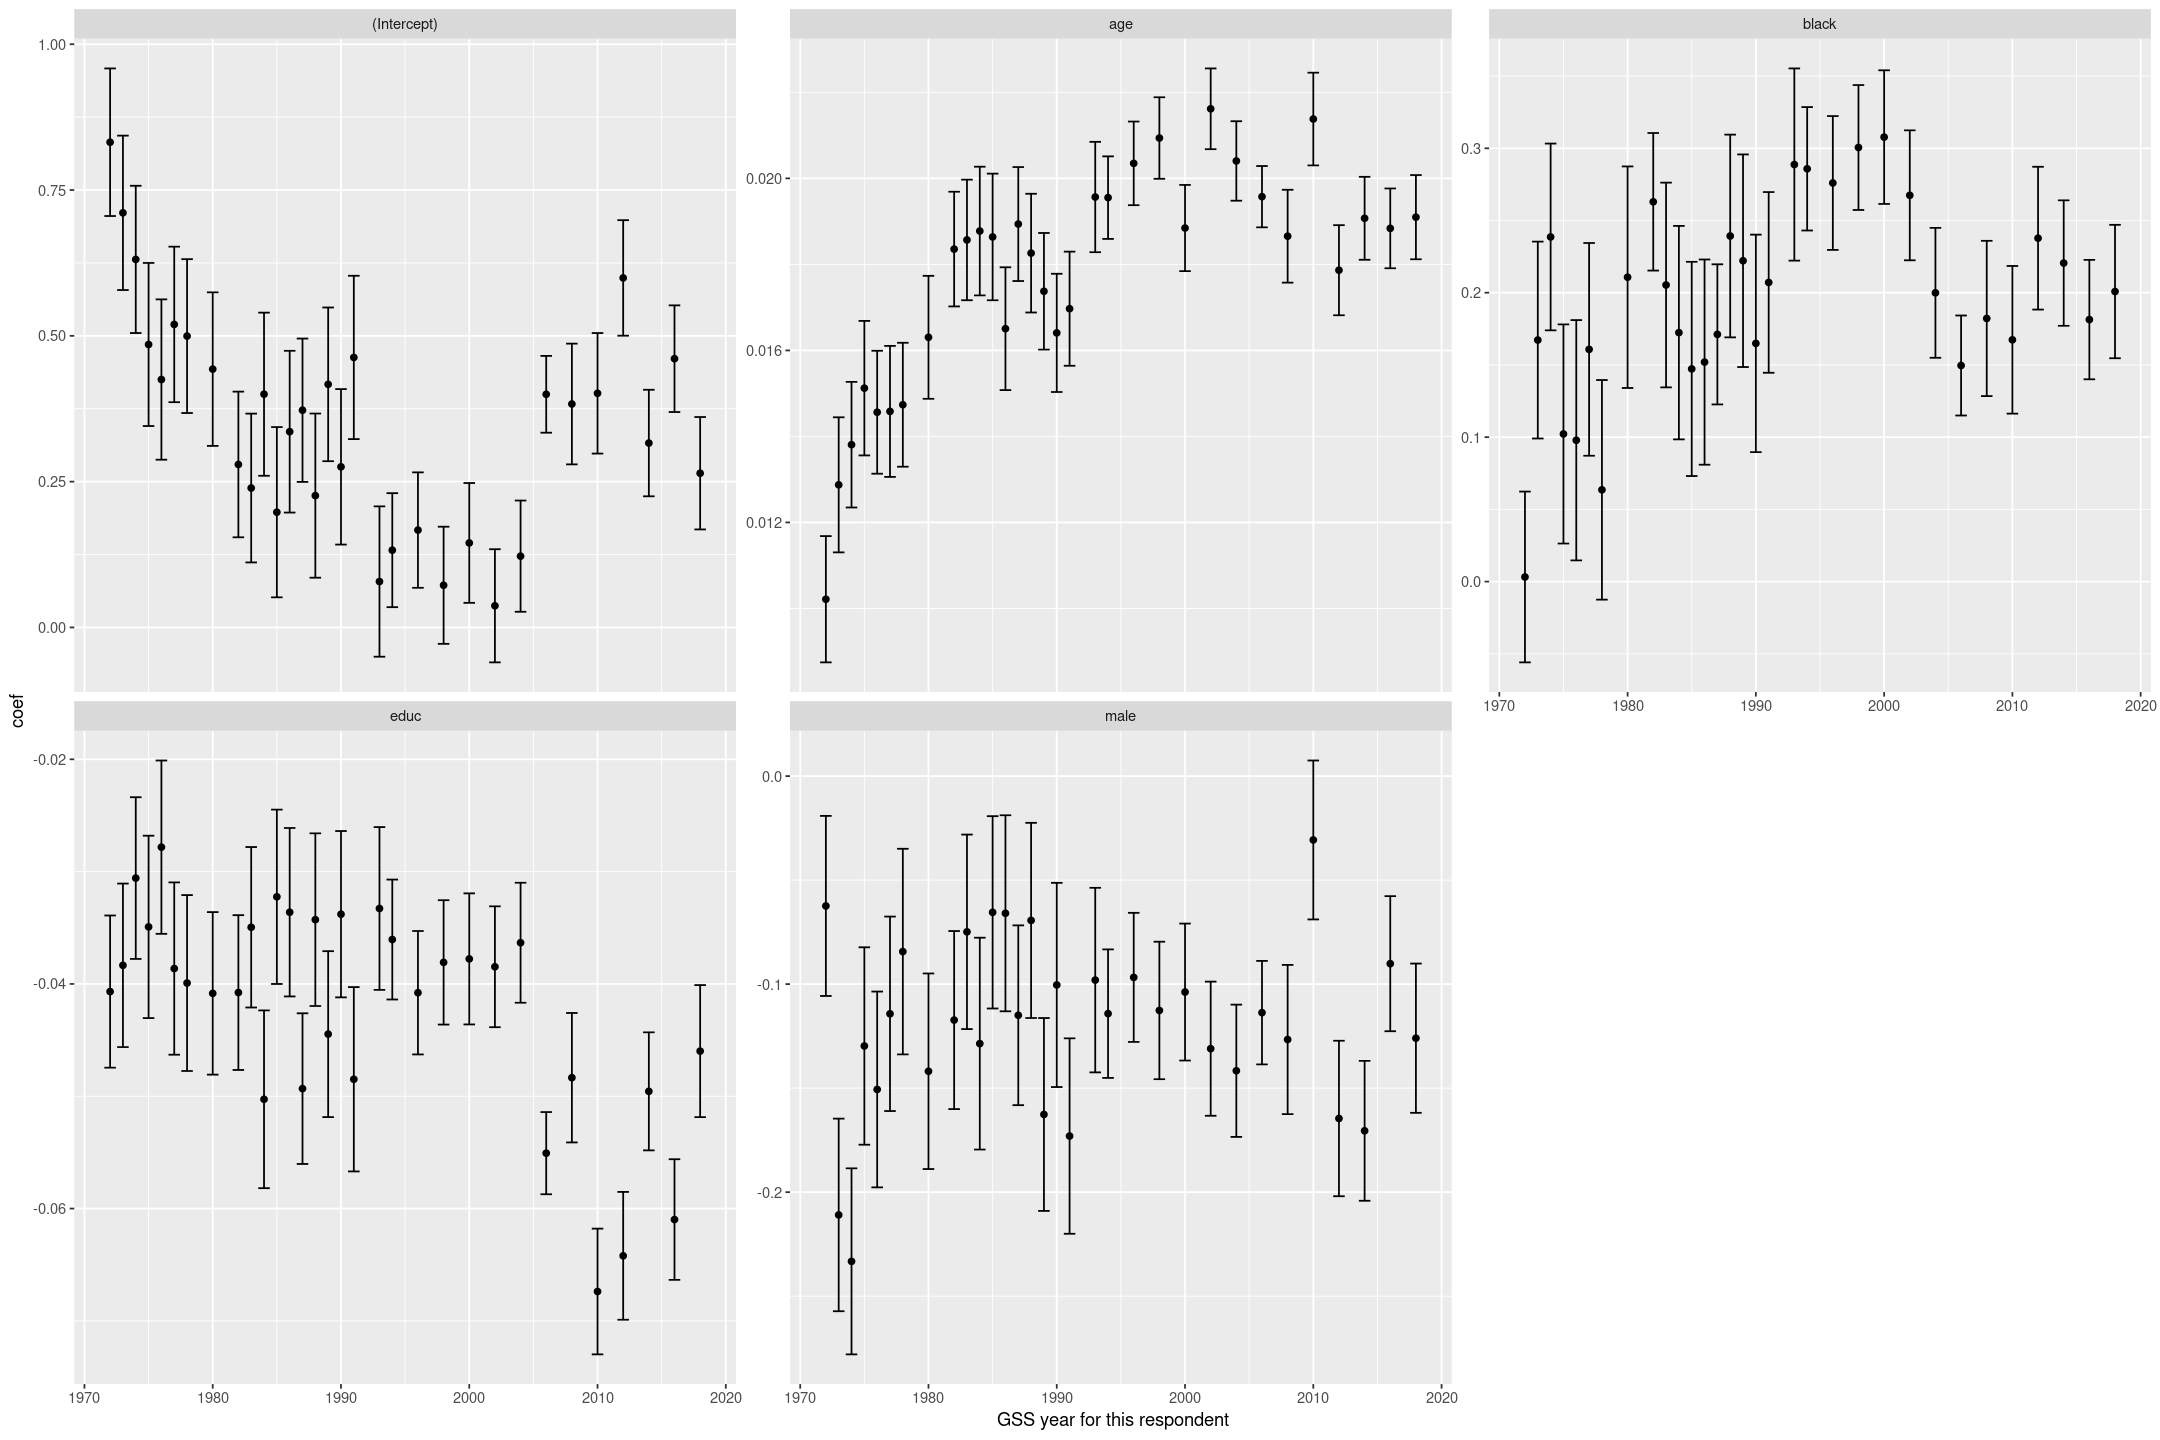

In [377]:
gss_childs_models %>%
mutate(coef=purrr::map(model, coef),
       se = purrr::map(model, se),
       name=purrr::map(coef, names),
      ) %>%
select(-data, -model) %>%
unnest(c(coef, name, se)) %>%
gf_point(coef ~ year) %>%
gf_errorbar(ymin=~coef-se, ymax=~coef+se) %>%
gf_facet_wrap(~name, scales="free_y")

## Further research

Discuss the results and how you might want to expand your model to answer some social science question of interest.

The increase in age as a predictor in the number of children from the 1970s to the 1990s is likely due to changes where children are being had later in life due to social changes (as women have careers before children) and technological or legislative changes (such as availability of contraceptives, abortion and IVF).
It would be interesting to try to estimate the effects of these changes, which vary by location in the US, by looking at state level and time events.